In [1]:
%matplotlib inline

# Fitting TESS FFIs

In [2]:
%run notebook_setup

This tutorial is nearly identical to the :ref:`tess` tutorial with added support for the TESS full frame images using [tesscut](https://mast.stsci.edu/tesscut/).

First, we query the TESS input catalog for the coordinates and properties of this source:

In [3]:
import numpy as np
from astroquery.mast import Catalogs

ticid = 49899799
tic = Catalogs.query_object("TIC {0}".format(ticid), radius=0.2, catalog="TIC")
star = tic[np.argmin(tic["dstArcSec"])]

tic_mass = float(star["mass"]), float(star["e_mass"])
tic_radius = float(star["rad"]), float(star["e_rad"])

Then we download the data from tesscut.
This is similar to what we did in the :ref:`tess` tutorial, but we need to do some background subtraction because the pipeline doesn't seem to do too well for the official TESS FFIs.

In [4]:
from io import BytesIO
from zipfile import ZipFile

from astropy.io import fits
from astropy.utils.data import download_file

# Download the cutout
url = "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra={0[ra]}&dec={0[dec]}&y=15&x=15&units=px&sector=All".format(star)
fn = download_file(url, cache=True)
with ZipFile(fn, "r") as f:
    with fits.open(BytesIO(f.read(f.namelist()[0]))) as hdus:
        tpf = hdus[1].data
        tpf_hdr = hdus[1].header

texp = tpf_hdr["FRAMETIM"] * tpf_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
time = tpf["TIME"]
flux = tpf["FLUX"]
m = np.any(np.isfinite(flux), axis=(1, 2)) & (tpf["QUALITY"] == 0)
ref_time = 0.5 * (np.min(time[m])+np.max(time[m]))
time = np.ascontiguousarray(time[m] - ref_time, dtype=np.float64)
flux = np.ascontiguousarray(flux[m], dtype=np.float64)

# Compute the median image
mean_img = np.median(flux, axis=0)

# Sort the pixels by median brightness
order = np.argsort(mean_img.flatten())[::-1]

# Choose a mask for the background
bkg_mask = np.zeros_like(mean_img, dtype=bool)
bkg_mask[np.unravel_index(order[-100:], mean_img.shape)] = True
flux -= np.median(flux[:, bkg_mask], axis=-1)[:, None, None]

Everything below this line is the same as the :ref:`tess` tutorial.

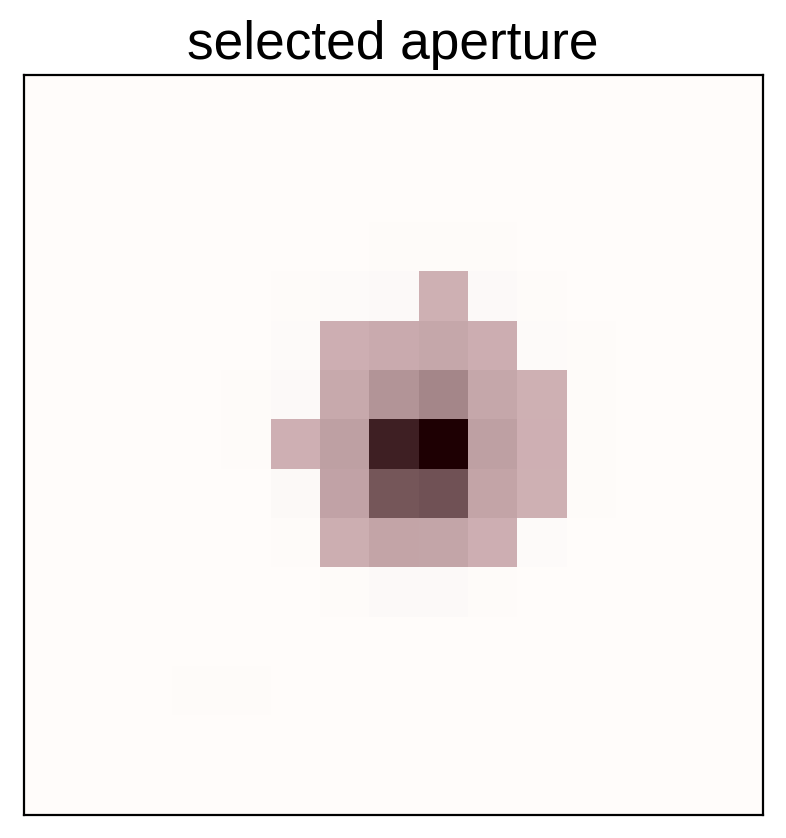

In [5]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# A function to estimate the windowed scatter in a lightcurve
def estimate_scatter_with_mask(mask):
    f = np.sum(flux[:, mask], axis=-1)
    smooth = savgol_filter(f, 1001, polyorder=5)
    return 1e6 * np.sqrt(np.median((f / smooth - 1)**2))

# Loop over pixels ordered by brightness and add them one-by-one
# to the aperture
masks, scatters = [], []
for i in range(1, 100):
    msk = np.zeros_like(mean_img, dtype=bool)
    msk[np.unravel_index(order[:i], mean_img.shape)] = True
    scatter = estimate_scatter_with_mask(msk)
    masks.append(msk)
    scatters.append(scatter)

# Choose the aperture that minimizes the scatter
pix_mask = masks[np.argmin(scatters)]

# Plot the selected aperture
plt.imshow(mean_img.T, cmap="gray_r")
plt.imshow(pix_mask.T, cmap="Reds", alpha=0.3)
plt.title("selected aperture")
plt.xticks([])
plt.yticks([]);

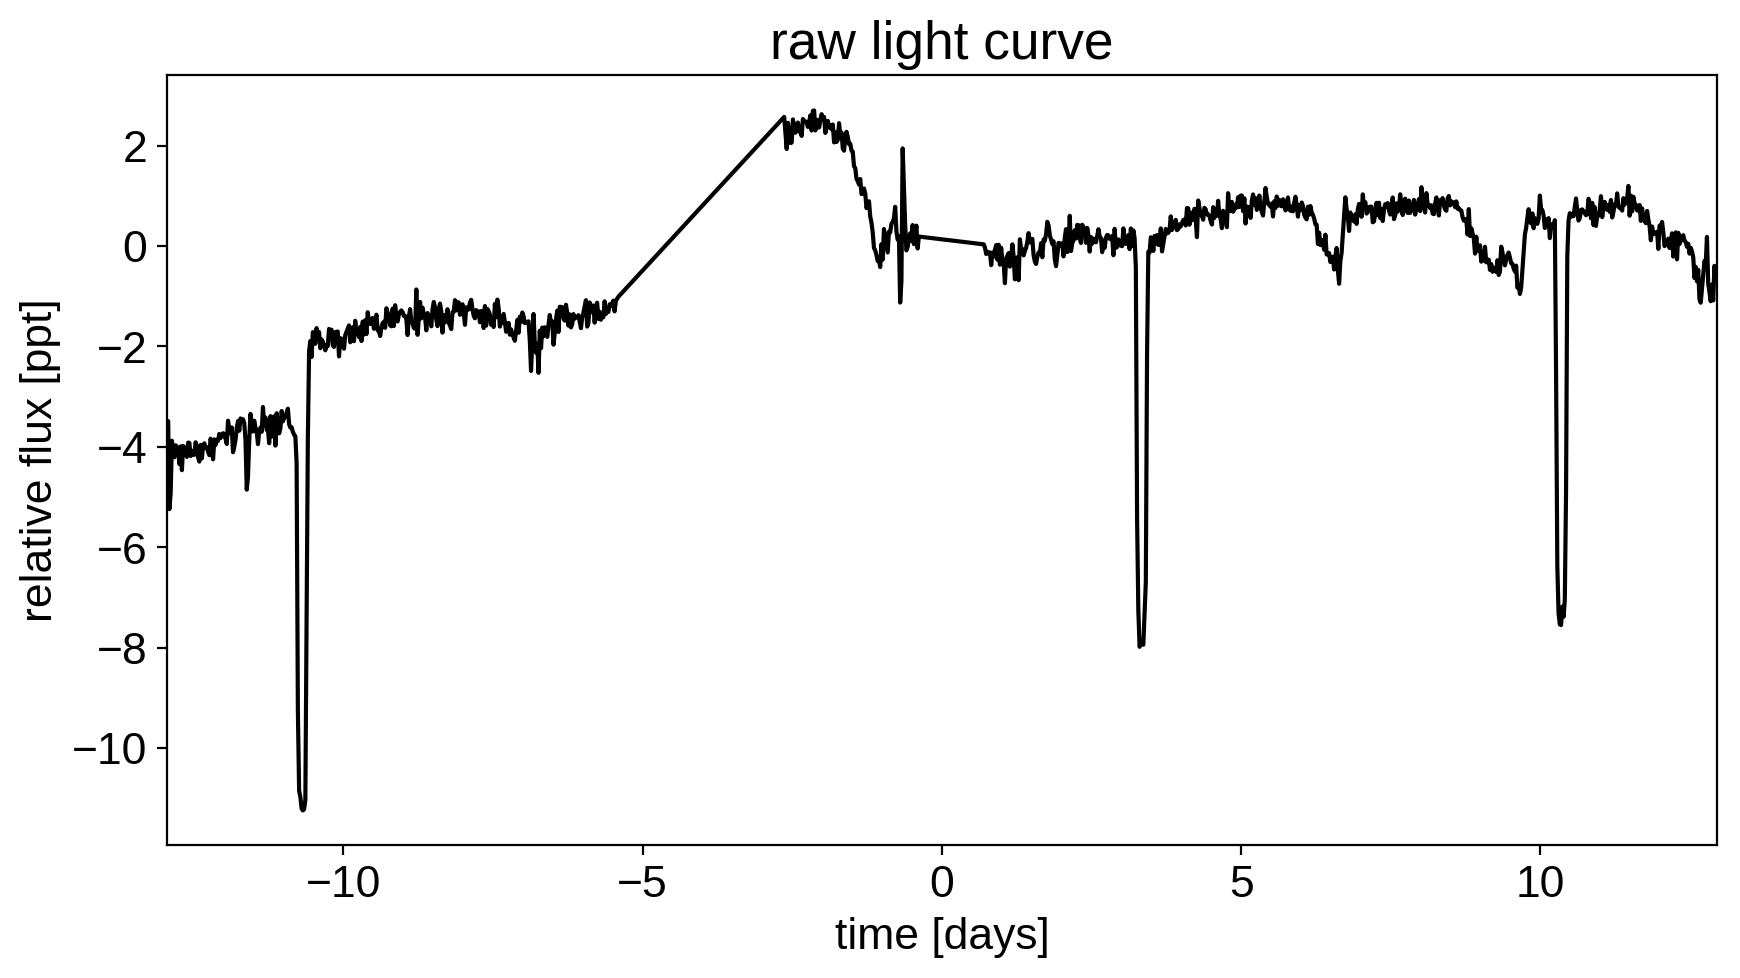

In [6]:
plt.figure(figsize=(10, 5))
sap_flux = np.sum(flux[:, pix_mask], axis=-1)
sap_flux = (sap_flux / np.median(sap_flux) - 1) * 1e3
plt.plot(time, sap_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("raw light curve")
plt.xlim(time.min(), time.max());

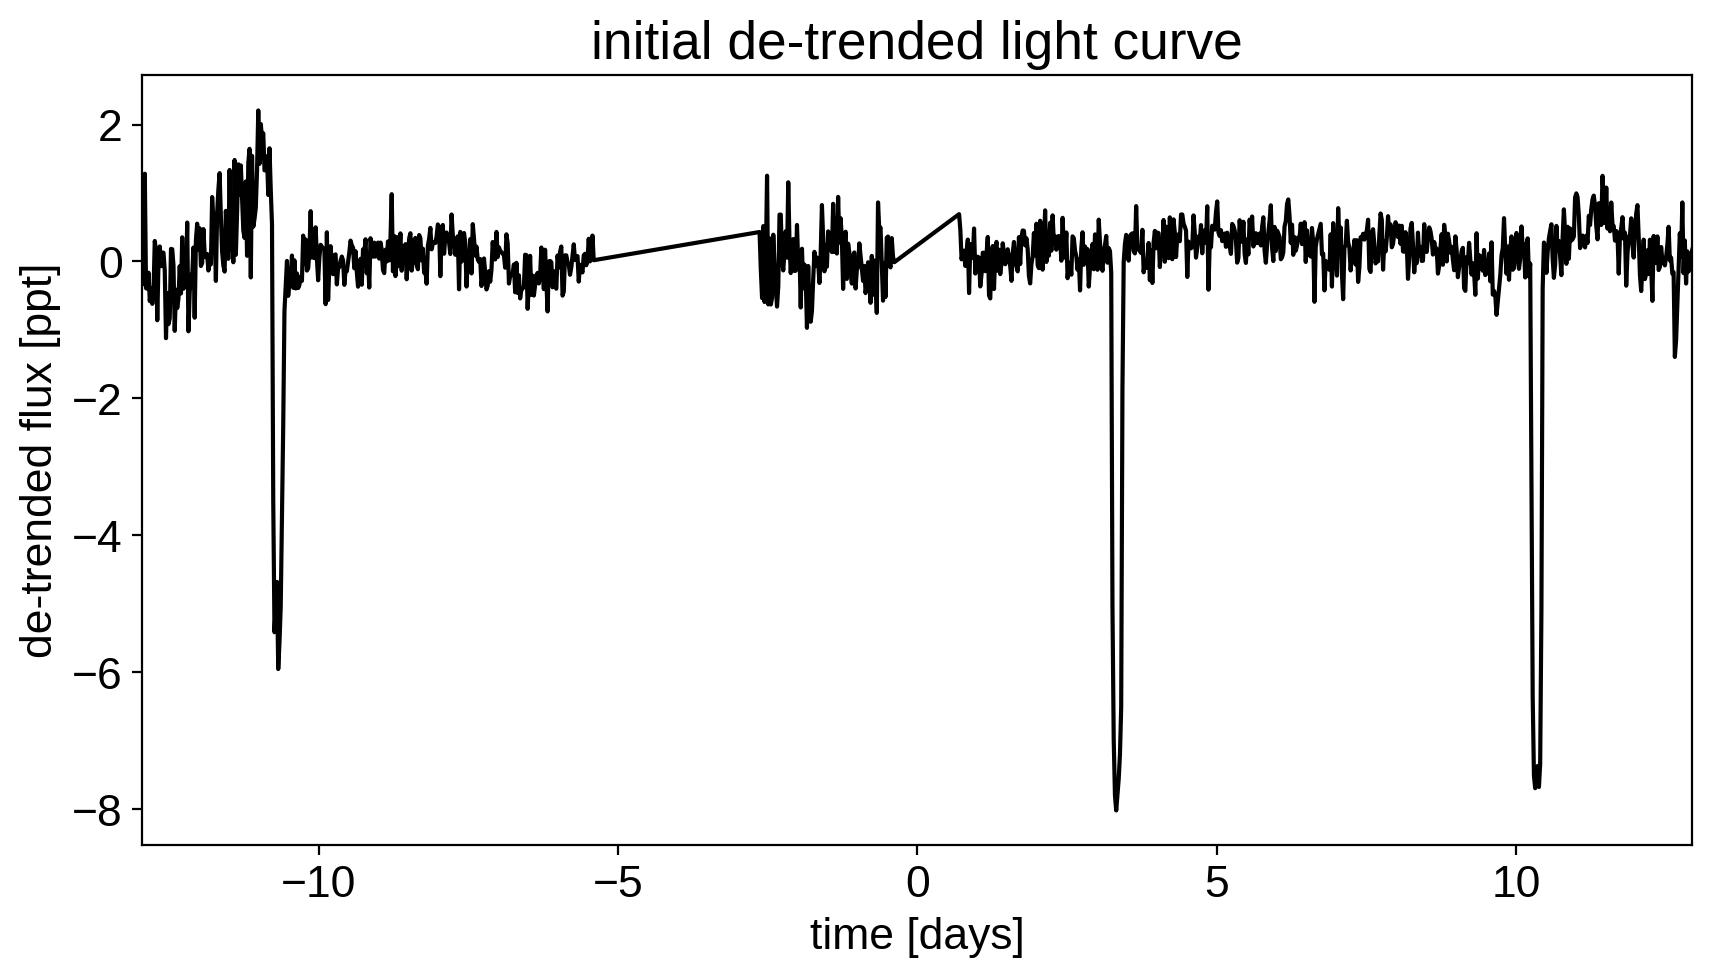

In [7]:
# Build the first order PLD basis
X_pld = np.reshape(flux[:, pix_mask], (len(flux), -1))
X_pld = X_pld / np.sum(flux[:, pix_mask], axis=-1)[:, None]

# Build the second order PLD basis and run PCA to reduce the number of dimensions
X2_pld = np.reshape(X_pld[:, None, :] * X_pld[:, :, None], (len(flux), -1))
U, _, _ = np.linalg.svd(X2_pld, full_matrices=False)
X2_pld = U[:, :X_pld.shape[1]]

# Construct the design matrix and fit for the PLD model
X_pld = np.concatenate((np.ones((len(flux), 1)), X_pld, X2_pld), axis=-1)
XTX = np.dot(X_pld.T, X_pld)
w_pld = np.linalg.solve(XTX, np.dot(X_pld.T, sap_flux))
pld_flux = np.dot(X_pld, w_pld)

# Plot the de-trended light curve
plt.figure(figsize=(10, 5))
plt.plot(time, sap_flux-pld_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.xlim(time.min(), time.max());

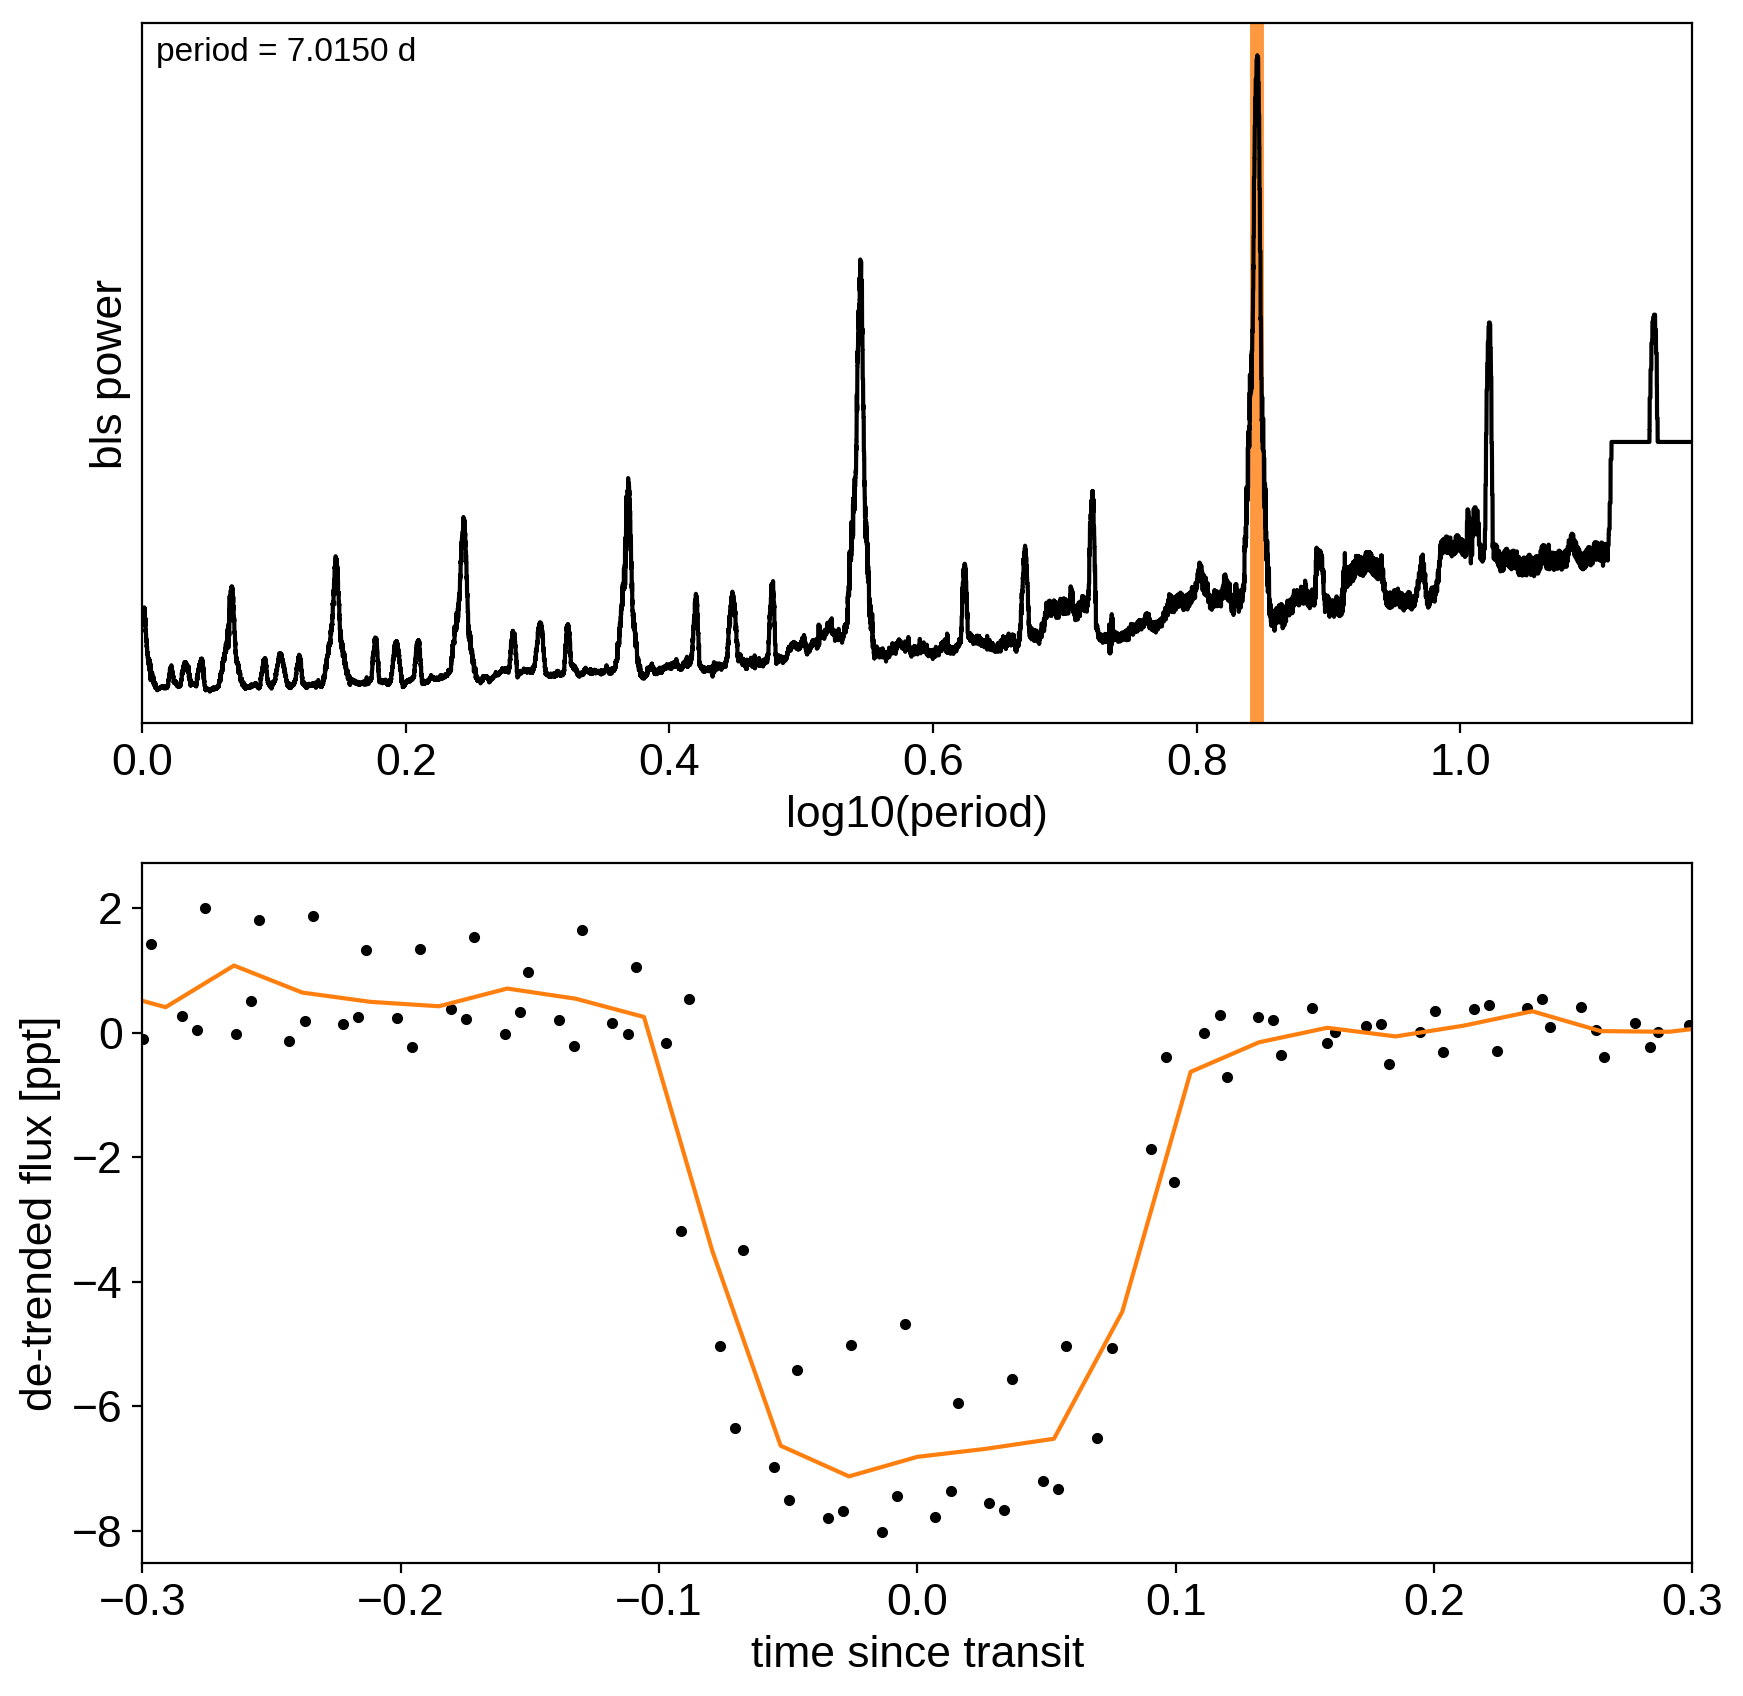

In [8]:
from astropy.stats import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(1), np.log(15), 50000))

bls = BoxLeastSquares(time, sap_flux - pld_flux)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(time, bls_period, 0.2, bls_t0)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate("period = {0:.4f} d".format(bls_period),
            (0, 1), xycoords="axes fraction",
            xytext=(5, -5), textcoords="offset points",
            va="top", ha="left", fontsize=12)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold = (time - bls_t0 + 0.5*bls_period)%bls_period - 0.5*bls_period
m = np.abs(x_fold) < 0.4
ax.plot(x_fold[m], sap_flux[m] - pld_flux[m], ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=sap_flux - pld_flux)
denom[num == 0] = 1.0
ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux [ppt]")
ax.set_xlabel("time since transit");

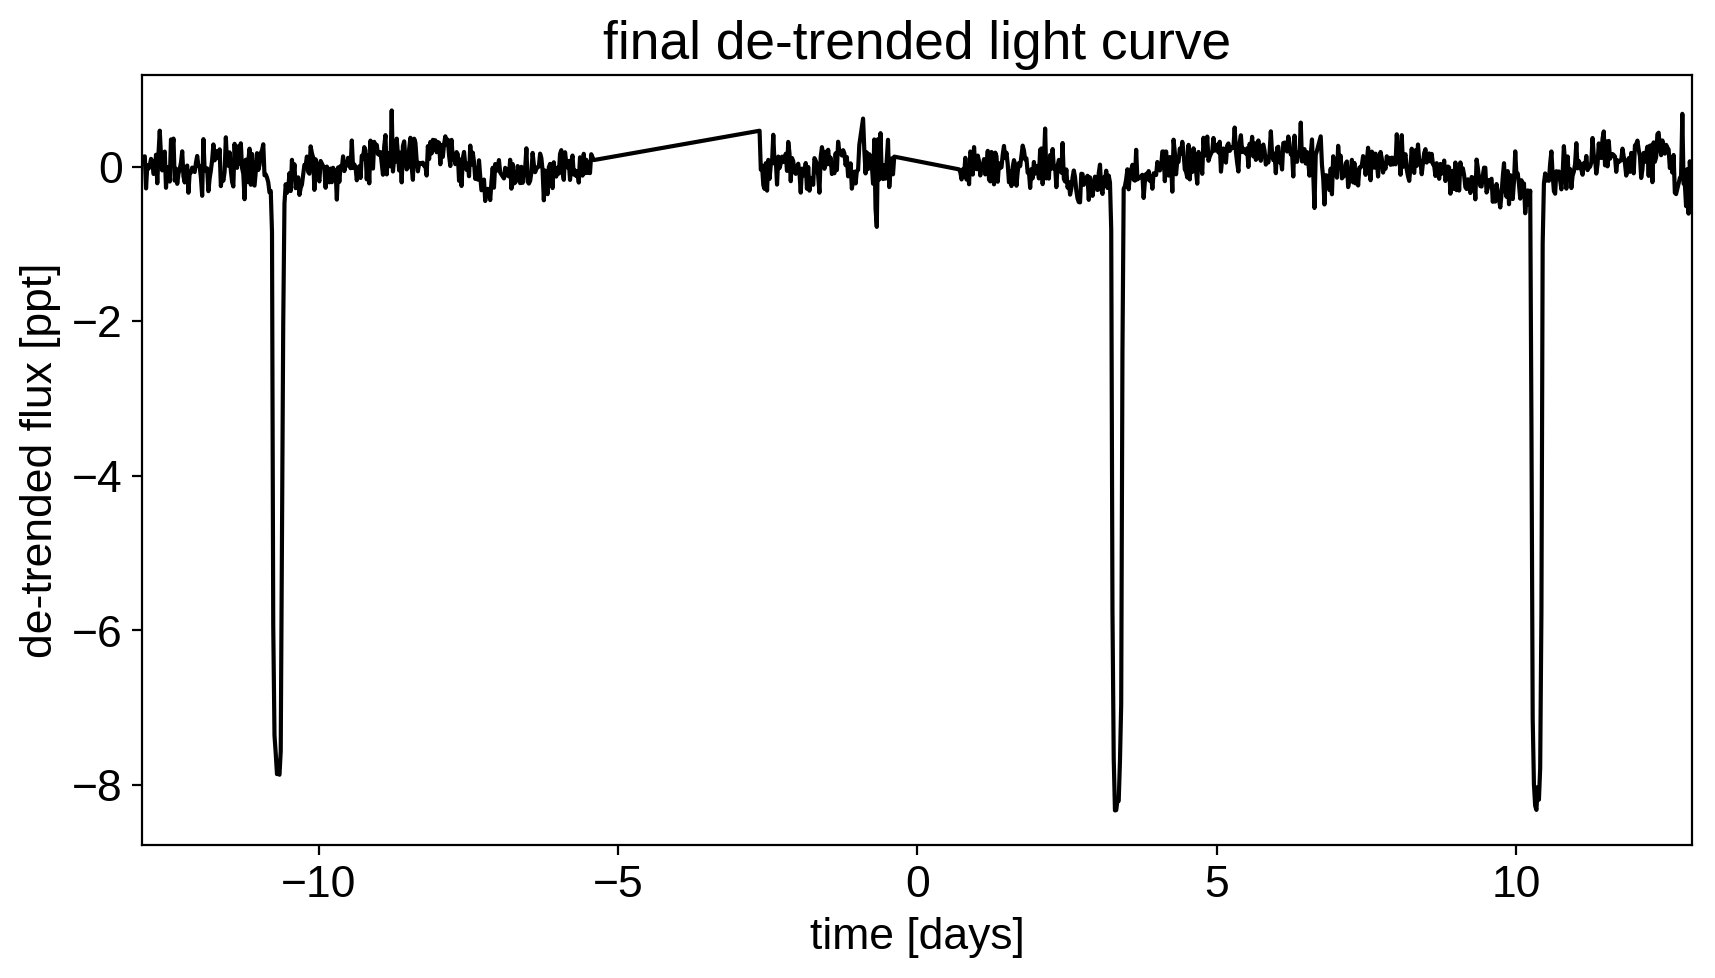

In [9]:
m = ~transit_mask
XTX = np.dot(X_pld[m].T, X_pld[m])
w_pld = np.linalg.solve(XTX, np.dot(X_pld[m].T, sap_flux[m]))
pld_flux = np.dot(X_pld, w_pld)

x = np.ascontiguousarray(time, dtype=np.float64)
y = np.ascontiguousarray(sap_flux-pld_flux, dtype=np.float64)

plt.figure(figsize=(10, 5))
plt.plot(time, y, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("final de-trended light curve")
plt.xlim(time.min(), time.max());

In [10]:
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star")
        
        # Stellar parameters from TIC
        M_star_huang = 1.094, 0.039
        R_star_huang = 1.10, 0.023
        m_star = pm.Normal("m_star", mu=tic_mass[0], sd=tic_mass[1])
        r_star = pm.Normal("r_star", mu=tic_radius[0], sd=tic_radius[1])

        # Prior to require physical parameters
        pm.Potential("m_star_prior", tt.switch(m_star > 0, 0, -np.inf))
        pm.Potential("r_star_prior", tt.switch(r_star > 0, 0, -np.inf))

        # Orbital parameters for the planets
        logP = pm.Normal("logP", mu=np.log(bls_period), sd=1)
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        b = pm.Uniform("b", lower=0, upper=1, testval=0.5)
        logr = pm.Normal("logr", sd=1.0,
                         mu=0.5*np.log(1e-3*np.array(bls_depth))+np.log(tic_radius[0]))
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
        ror = pm.Deterministic("ror", r_pl / r_star)
        
        # This is the eccentricity prior from Kipping (2013):
        # https://arxiv.org/abs/1306.4982
        ecc = pm.Beta("ecc", alpha=0.867, beta=3.03, testval=0.1)
        omega = xo.distributions.Angle("omega")

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0_guess = np.log(2*np.pi/10)
        logw0 = pm.Normal("logw0", mu=logw0_guess, sd=10)
        
        # We'll parameterize using the maximum power (S_0 * w_0^4) instead of
        # S_0 directly because this removes some of the degeneracies between
        # S_0 and omega_0
        logpower = pm.Normal("logpower",
                             mu=np.log(np.var(y[mask]))+4*logw0_guess,
                             sd=10)
        logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, m_star=m_star,
            period=period, t0=t0, b=b,
            ecc=ecc, omega=omega)
        pm.Deterministic("a", orbit.a_planet)
        pm.Deterministic("incl", orbit.incl)

        # Compute the model light curve using starry
        light_curves = xo.StarryLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1) + mean
        pm.Deterministic("light_curves", light_curves)

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), J=2)
        pm.Potential("transit_obs", gp.log_likelihood(y[mask] - light_curve))
        pm.Deterministic("gp_pred", gp.predict())

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[b])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logpower, logw0])
        map_soln = xo.optimize(start=map_soln, vars=[logr])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

model0, map_soln0 = build_model()

optimizing logp for variables: [b]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.181836e+03]

1it [00:00, 169.38it/s, logp=-1.181836e+03]

2it [00:00, 247.61it/s, logp=-1.181836e+03]

3it [00:00, 270.00it/s, logp=-1.179678e+03]

4it [00:00, 289.77it/s, logp=-1.166416e+03]

5it [00:00, 300.48it/s, logp=-1.166143e+03]

6it [00:00, 316.53it/s, logp=-1.165231e+03]

7it [00:00, 323.57it/s, logp=-1.165229e+03]

8it [00:00, 303.88it/s, logp=-1.165229e+03]

9it [00:00, 289.68it/s, logp=-1.165229e+03]

10it [00:08,  1.16it/s, logp=-1.165229e+03]


message: Optimization terminated successfully.
logp: -1181.8355629633472 -> -1165.2287368771365


optimizing logp for variables: [logw0, logpower, logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=-1.165229e+03]

1it [00:00, 167.24it/s, logp=-1.165229e+03]

2it [00:00, 212.66it/s, logp=-1.165229e+03]

3it [00:00, 248.55it/s, logp=-6.787997e+02]

4it [00:00, 284.96it/s, logp=-1.224300e+03]

5it [00:00, 304.54it/s, logp=1.855576e+01] 

6it [00:00, 321.27it/s, logp=-1.193506e+03]

7it [00:00, 328.70it/s, logp=-5.082018e+01]

8it [00:00, 330.55it/s, logp=3.411314e+01] 

9it [00:00, 335.23it/s, logp=1.284088e+01]

10it [00:00, 340.35it/s, logp=5.070551e+01]

11it [00:00, 328.61it/s, logp=7.211435e+01]

12it [00:00, 323.53it/s, logp=-1.725357e+02]

13it [00:00, 304.89it/s, logp=7.333284e+01] 

14it [00:00, 295.54it/s, logp=7.562508e+01]

15it [00:00, 295.58it/s, logp=7.930542e+01]

16it [00:00, 291.01it/s, logp=8.192531e+01]

17it [00:00, 289.14it/s, logp=8.251752e+01]

18it [00:00, 288.96it/s, logp=8.333711e+01]

19it [00:00, 288.83it/s, logp=8.373428e+01]

20it [00:00, 286.12it/s, logp=8.375757e+01]

21it [00:00, 285.85it/s, logp=8.375777e+01]

22it [00:00, 287.26it/s, logp=8.375777e+01]

23it [00:00, 287.32it/s, logp=8.375777e+01]

24it [00:01, 16.89it/s, logp=8.375777e+01] 


message: Optimization terminated successfully.
logp: -1165.2287368771363 -> 83.75777489524128


optimizing logp for variables: [logr]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=8.375777e+01]

1it [00:00, 166.92it/s, logp=8.375777e+01]

2it [00:00, 229.79it/s, logp=8.375777e+01]

3it [00:00, 257.88it/s, logp=-1.807271e+05]

4it [00:00, 275.48it/s, logp=-7.012263e+02]

5it [00:00, 291.21it/s, logp=1.185211e+02] 

6it [00:00, 302.59it/s, logp=1.189181e+02]

7it [00:00, 311.82it/s, logp=1.189246e+02]

8it [00:00, 321.25it/s, logp=1.189246e+02]

9it [00:00, 332.41it/s, logp=1.189246e+02]

10it [00:00, 344.61it/s, logp=1.189246e+02]

11it [00:00, 342.43it/s, logp=1.189246e+02]

12it [00:00, 324.92it/s, logp=1.189246e+02]

13it [00:00, 331.18it/s, logp=1.189246e+02]

14it [00:00, 321.77it/s, logp=1.189246e+02]

15it [00:00, 320.18it/s, logp=1.189246e+02]

16it [00:00, 320.39it/s, logp=1.189246e+02]

17it [00:00, 320.33it/s, logp=1.189246e+02]

18it [00:00, 319.26it/s, logp=1.189246e+02]

19it [00:00, 318.15it/s, logp=1.189246e+02]

20it [00:00, 319.26it/s, logp=1.189246e+02]

21it [00:00, 321.10it/s, logp=1.189246e+02]

22it [00:00, 320.14it/s, logp=1.189246e+02]

23it [00:00, 322.12it/s, logp=1.189246e+02]

24it [00:00, 324.10it/s, logp=1.189246e+02]

25it [00:00, 324.97it/s, logp=1.189246e+02]

26it [00:00, 324.15it/s, logp=1.189246e+02]

27it [00:00, 325.72it/s, logp=1.189246e+02]

28it [00:00, 325.72it/s, logp=1.189246e+02]

29it [00:00, 326.96it/s, logp=1.189246e+02]

30it [00:00, 327.70it/s, logp=1.189246e+02]

31it [00:00, 330.62it/s, logp=1.189246e+02]

32it [00:00, 332.46it/s, logp=1.189246e+02]

33it [00:00, 334.03it/s, logp=1.189246e+02]

34it [00:00, 334.55it/s, logp=1.189246e+02]

35it [00:00, 342.08it/s, logp=1.189246e+02]

35it [00:00, 342.08it/s, logp=1.189246e+02]

36it [00:00, 342.08it/s, logp=1.189246e+02]

37it [00:00, 342.08it/s, logp=1.189246e+02]

38it [00:00, 342.08it/s, logp=1.189246e+02]

39it [00:00, 342.08it/s, logp=1.189246e+02]

40it [00:00, 342.08it/s, logp=1.189246e+02]

41it [00:00, 342.08it/s, logp=1.189246e+02]

42it [00:00, 342.08it/s, logp=1.189246e+02]

43it [00:00, 342.08it/s, logp=1.189246e+02]

44it [00:00, 342.08it/s, logp=1.189246e+02]

45it [00:00, 342.08it/s, logp=1.189246e+02]

46it [00:00, 342.08it/s, logp=1.189246e+02]

47it [00:00, 342.08it/s, logp=1.189246e+02]

48it [00:00, 342.08it/s, logp=1.189246e+02]

49it [00:00, 342.08it/s, logp=1.189246e+02]

50it [00:00, 342.08it/s, logp=1.189246e+02]

51it [00:00, 342.08it/s, logp=1.189246e+02]

52it [00:00, 342.08it/s, logp=1.189246e+02]

53it [00:00, 342.08it/s, logp=1.189246e+02]

54it [00:00, 342.08it/s, logp=1.189246e+02]

55it [00:00, 342.08it/s, logp=1.189246e+02]

56it [00:00, 342.08it/s, logp=1.189246e+02]

57it [00:00, 342.08it/s, logp=1.189246e+02]

58it [00:00, 342.08it/s, logp=1.189246e+02]

59it [00:00, 342.08it/s, logp=1.189246e+02]

60it [00:00, 342.08it/s, logp=1.189246e+02]

61it [00:00, 342.08it/s, logp=1.189246e+02]

62it [00:00, 342.08it/s, logp=1.189246e+02]

63it [00:00, 342.08it/s, logp=1.189246e+02]

64it [00:00, 342.08it/s, logp=1.189246e+02]

65it [00:00, 342.08it/s, logp=1.189246e+02]

66it [00:00, 342.08it/s, logp=1.189246e+02]

67it [00:00, 342.08it/s, logp=1.189246e+02]

68it [00:00, 342.08it/s, logp=1.189246e+02]

69it [00:00, 342.08it/s, logp=1.189246e+02]

70it [00:00, 342.08it/s, logp=1.189246e+02]

71it [00:00, 342.08it/s, logp=1.189246e+02]

72it [00:00, 349.88it/s, logp=1.189246e+02]

72it [00:00, 349.88it/s, logp=1.189246e+02]

73it [00:00, 349.88it/s, logp=1.189246e+02]

74it [00:01, 49.88it/s, logp=1.189246e+02] 


message: Desired error not necessarily achieved due to precision loss.
logp: 83.75777489524128 -> 118.9245857261529


optimizing logp for variables: [logpower, logw0, logs2, omega, ecc, logr, b, t0, logP, r_star, m_star, u_star, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.189246e+02]

1it [00:00, 123.42it/s, logp=1.189246e+02]

2it [00:00, 172.83it/s, logp=1.189246e+02]

3it [00:00, 192.96it/s, logp=-2.277008e+04]

4it [00:00, 213.90it/s, logp=-1.379749e+04]

5it [00:00, 229.38it/s, logp=-1.108565e+04]

6it [00:00, 237.70it/s, logp=-4.412875e+03]

7it [00:00, 245.27it/s, logp=1.418641e+02] 

8it [00:00, 250.49it/s, logp=1.804270e+02]

9it [00:00, 252.95it/s, logp=2.034361e+02]

10it [00:00, 254.41it/s, logp=2.100251e+02]

11it [00:00, 256.39it/s, logp=2.221327e+02]

12it [00:00, 255.89it/s, logp=2.009218e+02]

13it [00:00, 258.50it/s, logp=2.258697e+02]

14it [00:00, 262.10it/s, logp=2.335034e+02]

15it [00:00, 265.60it/s, logp=2.628630e+02]

16it [00:00, 263.93it/s, logp=1.717723e+02]

17it [00:00, 268.12it/s, logp=2.777111e+02]

18it [00:00, 268.55it/s, logp=2.897960e+02]

19it [00:00, 271.34it/s, logp=2.081446e+02]

20it [00:00, 275.67it/s, logp=2.918995e+02]

21it [00:00, 276.54it/s, logp=2.961445e+02]

22it [00:00, 278.60it/s, logp=3.090738e+02]

23it [00:00, 279.76it/s, logp=2.151666e+02]

24it [00:00, 282.14it/s, logp=3.137939e+02]

25it [00:00, 283.88it/s, logp=3.210418e+02]

26it [00:00, 274.70it/s, logp=3.314137e+02]

27it [00:00, 276.19it/s, logp=3.334920e+02]

28it [00:00, 270.01it/s, logp=3.377026e+02]

29it [00:00, 276.94it/s, logp=3.377026e+02]

29it [00:00, 276.94it/s, logp=3.397897e+02]

30it [00:00, 276.94it/s, logp=3.420840e+02]

31it [00:00, 276.94it/s, logp=3.415529e+02]

32it [00:00, 276.94it/s, logp=3.428254e+02]

33it [00:00, 276.94it/s, logp=3.425019e+02]

34it [00:00, 276.94it/s, logp=3.431057e+02]

35it [00:00, 276.94it/s, logp=3.434235e+02]

36it [00:00, 276.94it/s, logp=3.438553e+02]

37it [00:00, 276.94it/s, logp=3.440439e+02]

38it [00:00, 276.94it/s, logp=3.440791e+02]

39it [00:00, 276.94it/s, logp=3.441339e+02]

40it [00:00, 276.94it/s, logp=3.441997e+02]

41it [00:00, 276.94it/s, logp=3.442557e+02]

42it [00:00, 276.94it/s, logp=3.443120e+02]

43it [00:00, 276.94it/s, logp=3.443199e+02]

44it [00:00, 276.94it/s, logp=3.443258e+02]

45it [00:00, 276.94it/s, logp=3.443304e+02]

46it [00:00, 231.33it/s, logp=3.443304e+02]

46it [00:00, 231.33it/s, logp=3.443373e+02]

47it [00:00, 231.33it/s, logp=3.443464e+02]

48it [00:00, 231.33it/s, logp=3.443549e+02]

49it [00:00, 231.33it/s, logp=3.443632e+02]

50it [00:00, 231.33it/s, logp=3.443617e+02]

51it [00:00, 231.33it/s, logp=3.443653e+02]

52it [00:00, 231.33it/s, logp=3.443679e+02]

53it [00:00, 231.33it/s, logp=3.443696e+02]

54it [00:00, 231.33it/s, logp=3.443719e+02]

55it [00:00, 231.33it/s, logp=3.443731e+02]

56it [00:00, 231.33it/s, logp=3.443739e+02]

57it [00:00, 231.33it/s, logp=3.443741e+02]

58it [00:00, 231.33it/s, logp=3.443743e+02]

59it [00:00, 231.33it/s, logp=3.443743e+02]

60it [00:00, 231.33it/s, logp=3.443744e+02]

61it [00:00, 231.33it/s, logp=3.443744e+02]

62it [00:00, 231.33it/s, logp=3.443744e+02]

63it [00:00, 231.33it/s, logp=3.443744e+02]

64it [00:00, 231.33it/s, logp=3.443744e+02]

65it [00:00, 231.33it/s, logp=3.443744e+02]

66it [00:00, 231.33it/s, logp=3.443745e+02]

67it [00:00, 223.68it/s, logp=3.443745e+02]

67it [00:00, 223.68it/s, logp=3.443745e+02]

68it [00:00, 223.68it/s, logp=3.443745e+02]

69it [00:00, 223.68it/s, logp=3.443746e+02]

70it [00:00, 223.68it/s, logp=3.443747e+02]

71it [00:00, 223.68it/s, logp=3.443750e+02]

72it [00:00, 223.68it/s, logp=3.443754e+02]

73it [00:00, 223.68it/s, logp=3.443760e+02]

74it [00:00, 223.68it/s, logp=3.443768e+02]

75it [00:00, 223.68it/s, logp=3.443782e+02]

76it [00:00, 223.68it/s, logp=3.443796e+02]

77it [00:00, 223.68it/s, logp=3.443798e+02]

78it [00:00, 223.68it/s, logp=3.443800e+02]

79it [00:00, 223.68it/s, logp=3.443802e+02]

80it [00:00, 223.68it/s, logp=3.443803e+02]

81it [00:00, 223.68it/s, logp=3.443804e+02]

82it [00:00, 223.68it/s, logp=3.443805e+02]

83it [00:00, 223.68it/s, logp=3.443805e+02]

84it [00:00, 223.68it/s, logp=3.443805e+02]

85it [00:00, 223.68it/s, logp=3.443805e+02]

86it [00:00, 223.68it/s, logp=3.443805e+02]

87it [00:00, 223.68it/s, logp=3.443805e+02]

88it [00:00, 223.68it/s, logp=3.443805e+02]

89it [00:00, 223.68it/s, logp=3.443805e+02]

90it [00:00, 223.68it/s, logp=3.443805e+02]

91it [00:00, 223.68it/s, logp=3.443805e+02]

92it [00:00, 223.68it/s, logp=3.443805e+02]

93it [00:00, 223.68it/s, logp=3.443805e+02]

94it [00:00, 223.68it/s, logp=3.443805e+02]

95it [00:00, 223.68it/s, logp=3.443805e+02]

96it [00:00, 223.68it/s, logp=3.443805e+02]

97it [00:00, 223.68it/s, logp=3.443805e+02]

98it [00:00, 223.68it/s, logp=3.443805e+02]

99it [00:00, 223.68it/s, logp=3.443805e+02]

100it [00:00, 223.68it/s, logp=3.443805e+02]

101it [00:00, 223.68it/s, logp=3.443805e+02]

102it [00:00, 250.10it/s, logp=3.443805e+02]

102it [00:00, 250.10it/s, logp=3.443805e+02]

103it [00:00, 250.10it/s, logp=3.443805e+02]

104it [00:00, 250.10it/s, logp=3.443805e+02]

105it [00:00, 250.10it/s, logp=3.443805e+02]

106it [00:00, 250.10it/s, logp=3.443805e+02]

107it [00:00, 250.10it/s, logp=3.443805e+02]

108it [00:00, 250.10it/s, logp=3.443805e+02]

109it [00:00, 250.10it/s, logp=3.443805e+02]

110it [00:00, 250.10it/s, logp=3.443805e+02]

111it [00:00, 250.10it/s, logp=3.443805e+02]

112it [00:00, 250.10it/s, logp=3.443805e+02]

113it [00:00, 250.10it/s, logp=3.443805e+02]

114it [00:00, 250.10it/s, logp=3.443805e+02]

115it [00:00, 250.10it/s, logp=3.443805e+02]

116it [00:00, 250.10it/s, logp=3.443805e+02]

117it [00:00, 250.10it/s, logp=3.443805e+02]

118it [00:00, 250.10it/s, logp=3.443805e+02]

119it [00:00, 250.10it/s, logp=3.443805e+02]

120it [00:00, 250.10it/s, logp=3.443805e+02]

121it [00:00, 250.10it/s, logp=3.443805e+02]

122it [00:00, 250.10it/s, logp=3.443805e+02]

123it [00:00, 250.10it/s, logp=3.443805e+02]

124it [00:00, 250.10it/s, logp=3.443805e+02]

125it [00:00, 250.10it/s, logp=3.443805e+02]

126it [00:00, 250.10it/s, logp=3.443805e+02]

127it [00:00, 250.10it/s, logp=3.443805e+02]

128it [00:00, 250.10it/s, logp=3.443805e+02]

129it [00:00, 250.10it/s, logp=3.443805e+02]

130it [00:00, 250.10it/s, logp=3.443805e+02]

131it [00:00, 250.10it/s, logp=3.443805e+02]

132it [00:00, 250.10it/s, logp=3.443805e+02]

133it [00:00, 250.10it/s, logp=3.443805e+02]

134it [00:00, 250.10it/s, logp=3.443805e+02]

135it [00:00, 250.10it/s, logp=3.443805e+02]

136it [00:00, 250.10it/s, logp=3.443805e+02]

137it [00:00, 250.10it/s, logp=3.443805e+02]

138it [00:00, 250.10it/s, logp=3.443805e+02]

139it [00:00, 250.10it/s, logp=3.443805e+02]

140it [00:00, 278.53it/s, logp=3.443805e+02]

140it [00:00, 278.53it/s, logp=3.443805e+02]

141it [00:00, 278.53it/s, logp=3.443805e+02]

142it [00:00, 278.53it/s, logp=3.443805e+02]

143it [00:00, 278.53it/s, logp=3.443805e+02]

144it [00:00, 278.53it/s, logp=3.443805e+02]

145it [00:00, 278.53it/s, logp=3.443805e+02]

146it [00:00, 278.53it/s, logp=3.443805e+02]

147it [00:00, 278.53it/s, logp=3.443805e+02]

148it [00:00, 278.53it/s, logp=3.443805e+02]

149it [00:00, 278.53it/s, logp=3.443805e+02]

150it [00:00, 278.53it/s, logp=3.443805e+02]

151it [00:01, 81.98it/s, logp=3.443805e+02] 


message: Desired error not necessarily achieved due to precision loss.
logp: 118.92458572615267 -> 344.3805435085567


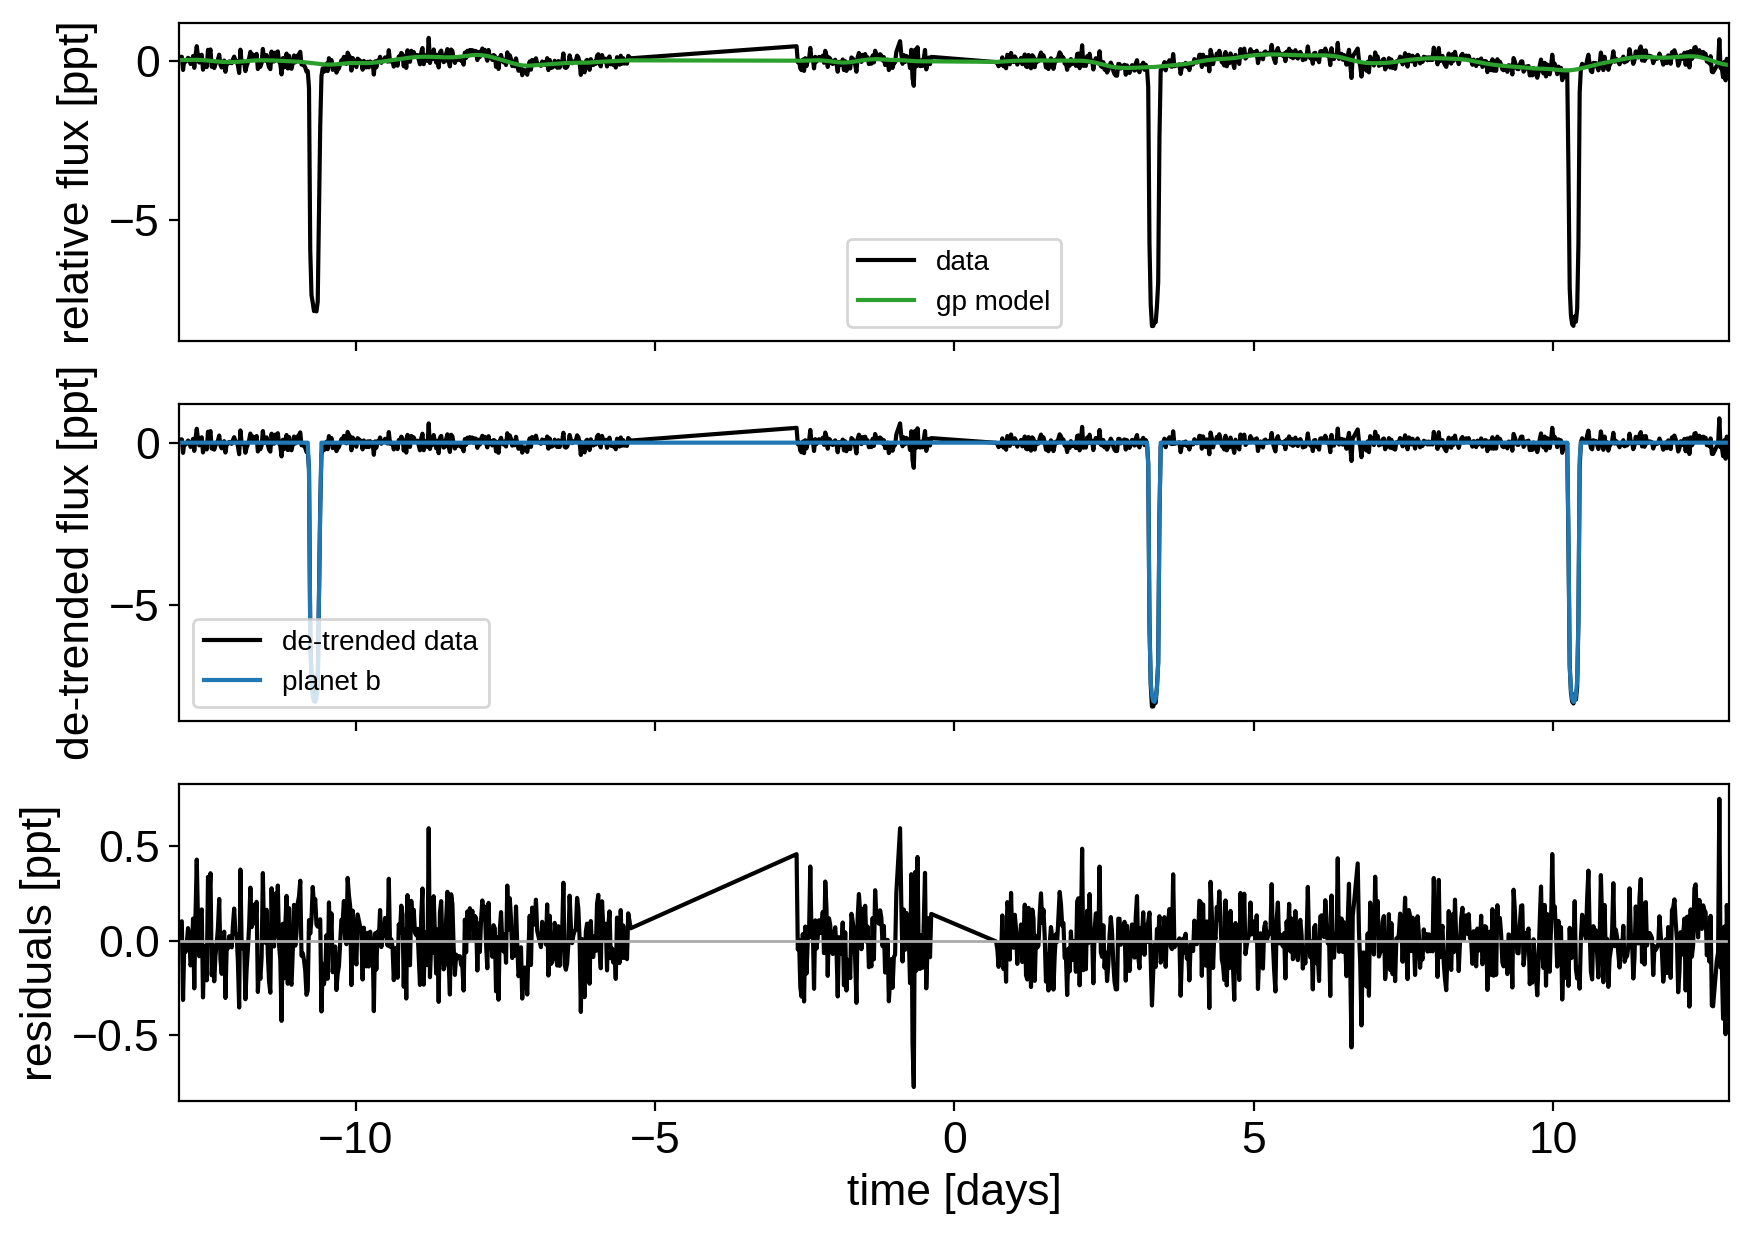

In [11]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("b"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(map_soln0);

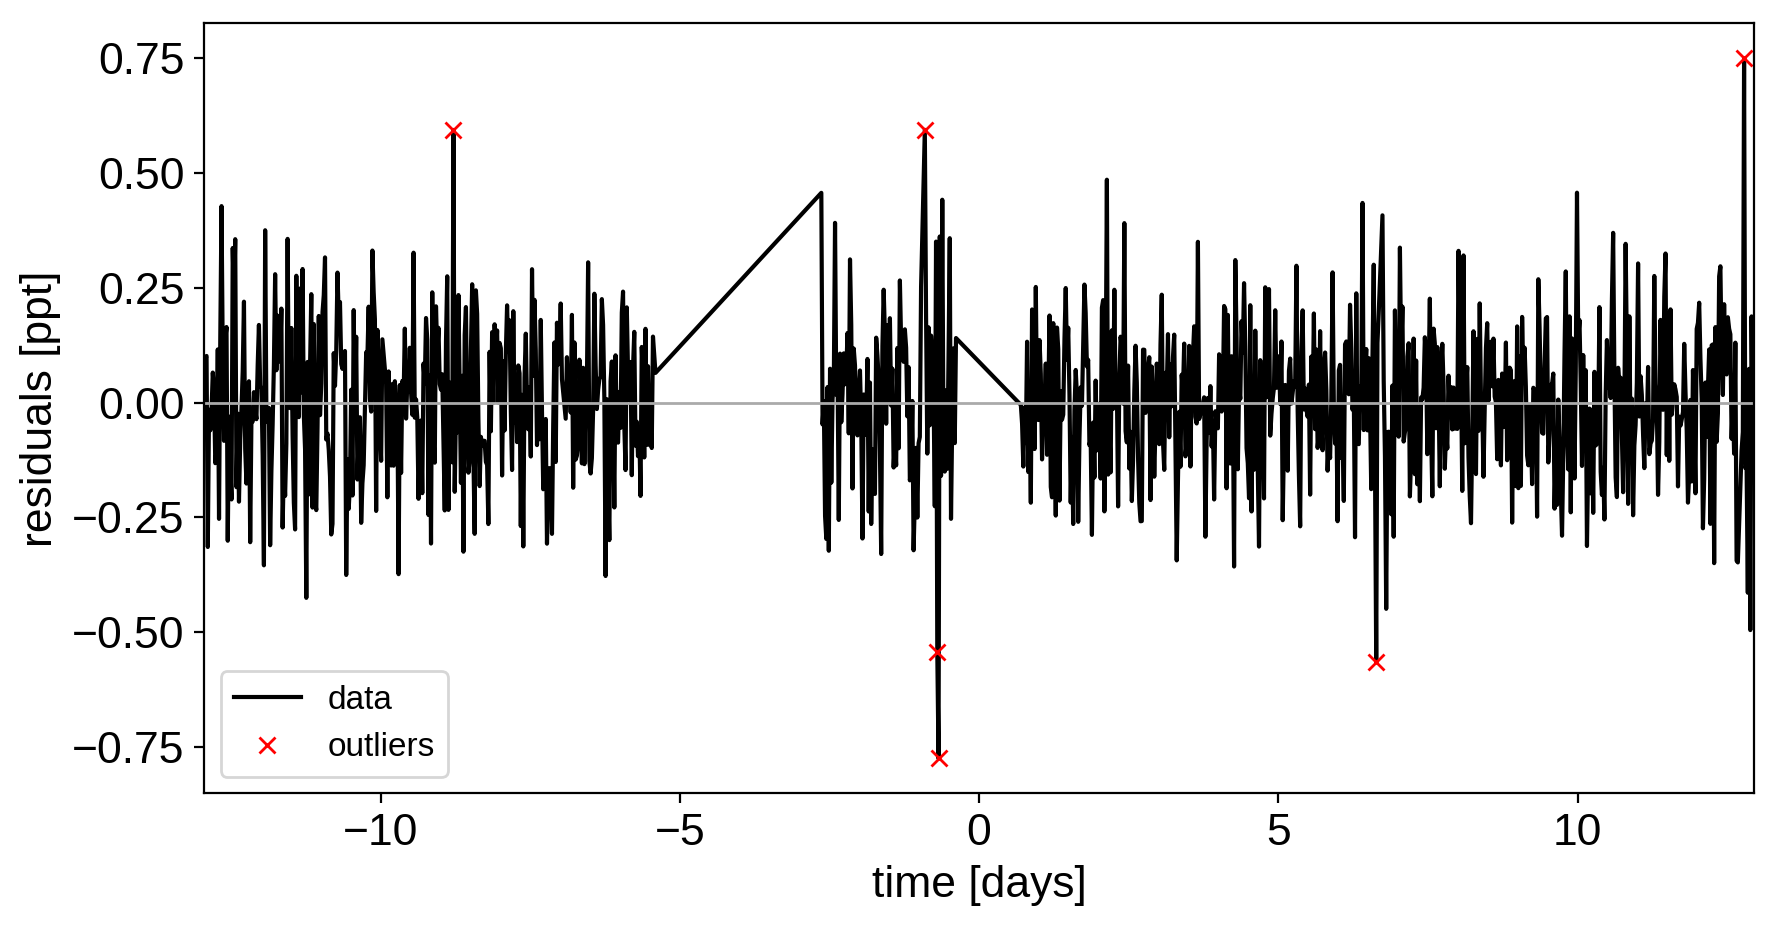

In [12]:
mod = map_soln0["gp_pred"] + map_soln0["mean"] + np.sum(map_soln0["light_curves"], axis=-1)
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
plt.xlim(x.min(), x.max());

optimizing logp for variables: [b]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=3.867826e+02]

1it [00:00, 239.81it/s, logp=3.867826e+02]

2it [00:00, 338.78it/s, logp=3.867826e+02]

3it [00:00, 345.00it/s, logp=3.867476e+02]

4it [00:00, 388.86it/s, logp=3.867826e+02]

5it [00:01,  4.11it/s, logp=3.867826e+02] 


message: Optimization terminated successfully.
logp: 386.7826018453201 -> 386.78260184658603


optimizing logp for variables: [logw0, logpower, logs2]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=3.867826e+02]

1it [00:00, 249.01it/s, logp=3.867826e+02]

2it [00:00, 327.96it/s, logp=3.867826e+02]

3it [00:00, 356.17it/s, logp=1.139909e+02]

4it [00:00, 378.59it/s, logp=3.890355e+02]

5it [00:00, 388.52it/s, logp=3.486127e+02]

6it [00:00, 400.08it/s, logp=3.890600e+02]

7it [00:00, 406.22it/s, logp=3.891084e+02]

8it [00:00, 414.20it/s, logp=3.892812e+02]

9it [00:00, 417.85it/s, logp=3.895975e+02]

10it [00:00, 421.10it/s, logp=3.896636e+02]

11it [00:00, 424.36it/s, logp=3.896638e+02]

12it [00:00, 428.19it/s, logp=3.896638e+02]

13it [00:00, 430.72it/s, logp=3.896638e+02]

14it [00:01, 11.53it/s, logp=3.896638e+02] 


message: Optimization terminated successfully.
logp: 386.7826018465867 -> 389.663802516971


optimizing logp for variables: [logr]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=3.896638e+02]

1it [00:00, 329.15it/s, logp=3.896638e+02]

2it [00:00, 441.58it/s, logp=3.896638e+02]

3it [00:00, 499.98it/s, logp=-1.139864e+04]

4it [00:00, 530.54it/s, logp=3.896528e+02] 

5it [00:00, 545.68it/s, logp=3.896844e+02]

6it [00:00, 553.47it/s, logp=3.896844e+02]

7it [00:01,  5.19it/s, logp=3.896844e+02] 


message: Optimization terminated successfully.
logp: 389.663802516971 -> 389.6844148433393


optimizing logp for variables: [logpower, logw0, logs2, omega, ecc, logr, b, t0, logP, r_star, m_star, u_star, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=3.896844e+02]

1it [00:00, 156.97it/s, logp=3.896844e+02]

2it [00:00, 216.37it/s, logp=3.896844e+02]

3it [00:00, 250.71it/s, logp=-1.533690e+04]

4it [00:00, 258.89it/s, logp=-3.912231e+04]

5it [00:00, 276.55it/s, logp=3.896295e+02] 

6it [00:00, 288.06it/s, logp=3.896873e+02]

7it [00:00, 292.54it/s, logp=3.896896e+02]

8it [00:00, 286.64it/s, logp=3.896912e+02]

9it [00:00, 294.54it/s, logp=3.896888e+02]

10it [00:00, 304.18it/s, logp=3.896917e+02]

11it [00:00, 310.61it/s, logp=3.896915e+02]

12it [00:00, 318.08it/s, logp=3.896919e+02]

13it [00:00, 322.63it/s, logp=3.896920e+02]

14it [00:00, 325.37it/s, logp=3.896920e+02]

15it [00:00, 330.10it/s, logp=3.896921e+02]

16it [00:00, 331.72it/s, logp=3.896923e+02]

17it [00:00, 332.72it/s, logp=3.896925e+02]

18it [00:00, 334.40it/s, logp=3.896929e+02]

19it [00:00, 336.15it/s, logp=3.896935e+02]

20it [00:00, 337.77it/s, logp=3.896945e+02]

21it [00:00, 339.44it/s, logp=3.896949e+02]

22it [00:00, 340.23it/s, logp=3.896949e+02]

23it [00:00, 341.07it/s, logp=3.896949e+02]

24it [00:00, 341.79it/s, logp=3.896949e+02]

25it [00:00, 342.38it/s, logp=3.896949e+02]

26it [00:00, 343.52it/s, logp=3.896949e+02]

27it [00:00, 344.22it/s, logp=3.896949e+02]

28it [00:00, 341.75it/s, logp=3.896949e+02]

29it [00:00, 338.38it/s, logp=3.896949e+02]

30it [00:00, 333.25it/s, logp=3.896949e+02]

31it [00:00, 324.46it/s, logp=3.896949e+02]

32it [00:00, 315.57it/s, logp=3.896949e+02]

33it [00:00, 322.96it/s, logp=3.896949e+02]

33it [00:00, 322.96it/s, logp=3.896949e+02]

34it [00:00, 322.96it/s, logp=3.896949e+02]

35it [00:00, 322.96it/s, logp=3.896949e+02]

36it [00:00, 322.96it/s, logp=3.896949e+02]

37it [00:00, 322.96it/s, logp=3.896949e+02]

38it [00:00, 322.96it/s, logp=3.896949e+02]

39it [00:00, 322.96it/s, logp=3.896949e+02]

40it [00:00, 322.96it/s, logp=3.896949e+02]

41it [00:00, 322.96it/s, logp=3.896949e+02]

42it [00:00, 322.96it/s, logp=3.896949e+02]

43it [00:00, 322.96it/s, logp=3.896949e+02]

44it [00:00, 322.96it/s, logp=3.896949e+02]

45it [00:00, 322.96it/s, logp=3.896949e+02]

46it [00:00, 322.96it/s, logp=3.896949e+02]

47it [00:00, 322.96it/s, logp=3.896949e+02]

48it [00:00, 322.96it/s, logp=3.896949e+02]

49it [00:00, 322.96it/s, logp=3.896949e+02]

50it [00:00, 322.96it/s, logp=3.896949e+02]

51it [00:00, 322.96it/s, logp=3.896949e+02]

52it [00:00, 322.96it/s, logp=3.896949e+02]

53it [00:00, 322.96it/s, logp=3.896949e+02]

54it [00:00, 322.96it/s, logp=3.896949e+02]

55it [00:00, 322.96it/s, logp=3.896949e+02]

56it [00:00, 322.96it/s, logp=3.896949e+02]

57it [00:00, 322.96it/s, logp=3.896949e+02]

58it [00:00, 322.96it/s, logp=3.896949e+02]

59it [00:00, 322.96it/s, logp=3.896949e+02]

60it [00:00, 322.96it/s, logp=3.896949e+02]

61it [00:00, 322.96it/s, logp=3.896949e+02]

62it [00:00, 322.96it/s, logp=3.896949e+02]

63it [00:00, 322.96it/s, logp=3.896949e+02]

64it [00:00, 322.96it/s, logp=3.896949e+02]

65it [00:00, 322.96it/s, logp=3.896949e+02]

66it [00:00, 322.96it/s, logp=3.896949e+02]

67it [00:00, 327.33it/s, logp=3.896949e+02]

67it [00:00, 327.33it/s, logp=3.896949e+02]

68it [00:00, 327.33it/s, logp=3.896949e+02]

69it [00:00, 327.33it/s, logp=3.896949e+02]

70it [00:00, 327.33it/s, logp=3.896949e+02]

71it [00:00, 327.33it/s, logp=3.896949e+02]

72it [00:00, 327.33it/s, logp=3.896949e+02]

73it [00:00, 327.33it/s, logp=3.896949e+02]

74it [00:00, 327.33it/s, logp=3.896949e+02]

75it [00:00, 327.33it/s, logp=3.896949e+02]

76it [00:00, 327.33it/s, logp=3.896949e+02]

77it [00:00, 327.33it/s, logp=3.896949e+02]

78it [00:00, 327.33it/s, logp=3.896949e+02]

79it [00:00, 327.33it/s, logp=3.896949e+02]

80it [00:00, 327.33it/s, logp=3.896949e+02]

81it [00:00, 327.33it/s, logp=3.896949e+02]

82it [00:00, 327.33it/s, logp=3.896949e+02]

83it [00:00, 327.33it/s, logp=3.896949e+02]

84it [00:00, 327.33it/s, logp=3.896949e+02]

85it [00:00, 327.33it/s, logp=3.896949e+02]

86it [00:00, 327.33it/s, logp=3.896949e+02]

87it [00:00, 327.33it/s, logp=3.896949e+02]

88it [00:00, 327.33it/s, logp=3.896949e+02]

89it [00:00, 327.33it/s, logp=3.896949e+02]

90it [00:01, 69.74it/s, logp=3.896949e+02] 


message: Desired error not necessarily achieved due to precision loss.
logp: 389.68441484333886 -> 389.6948927325021


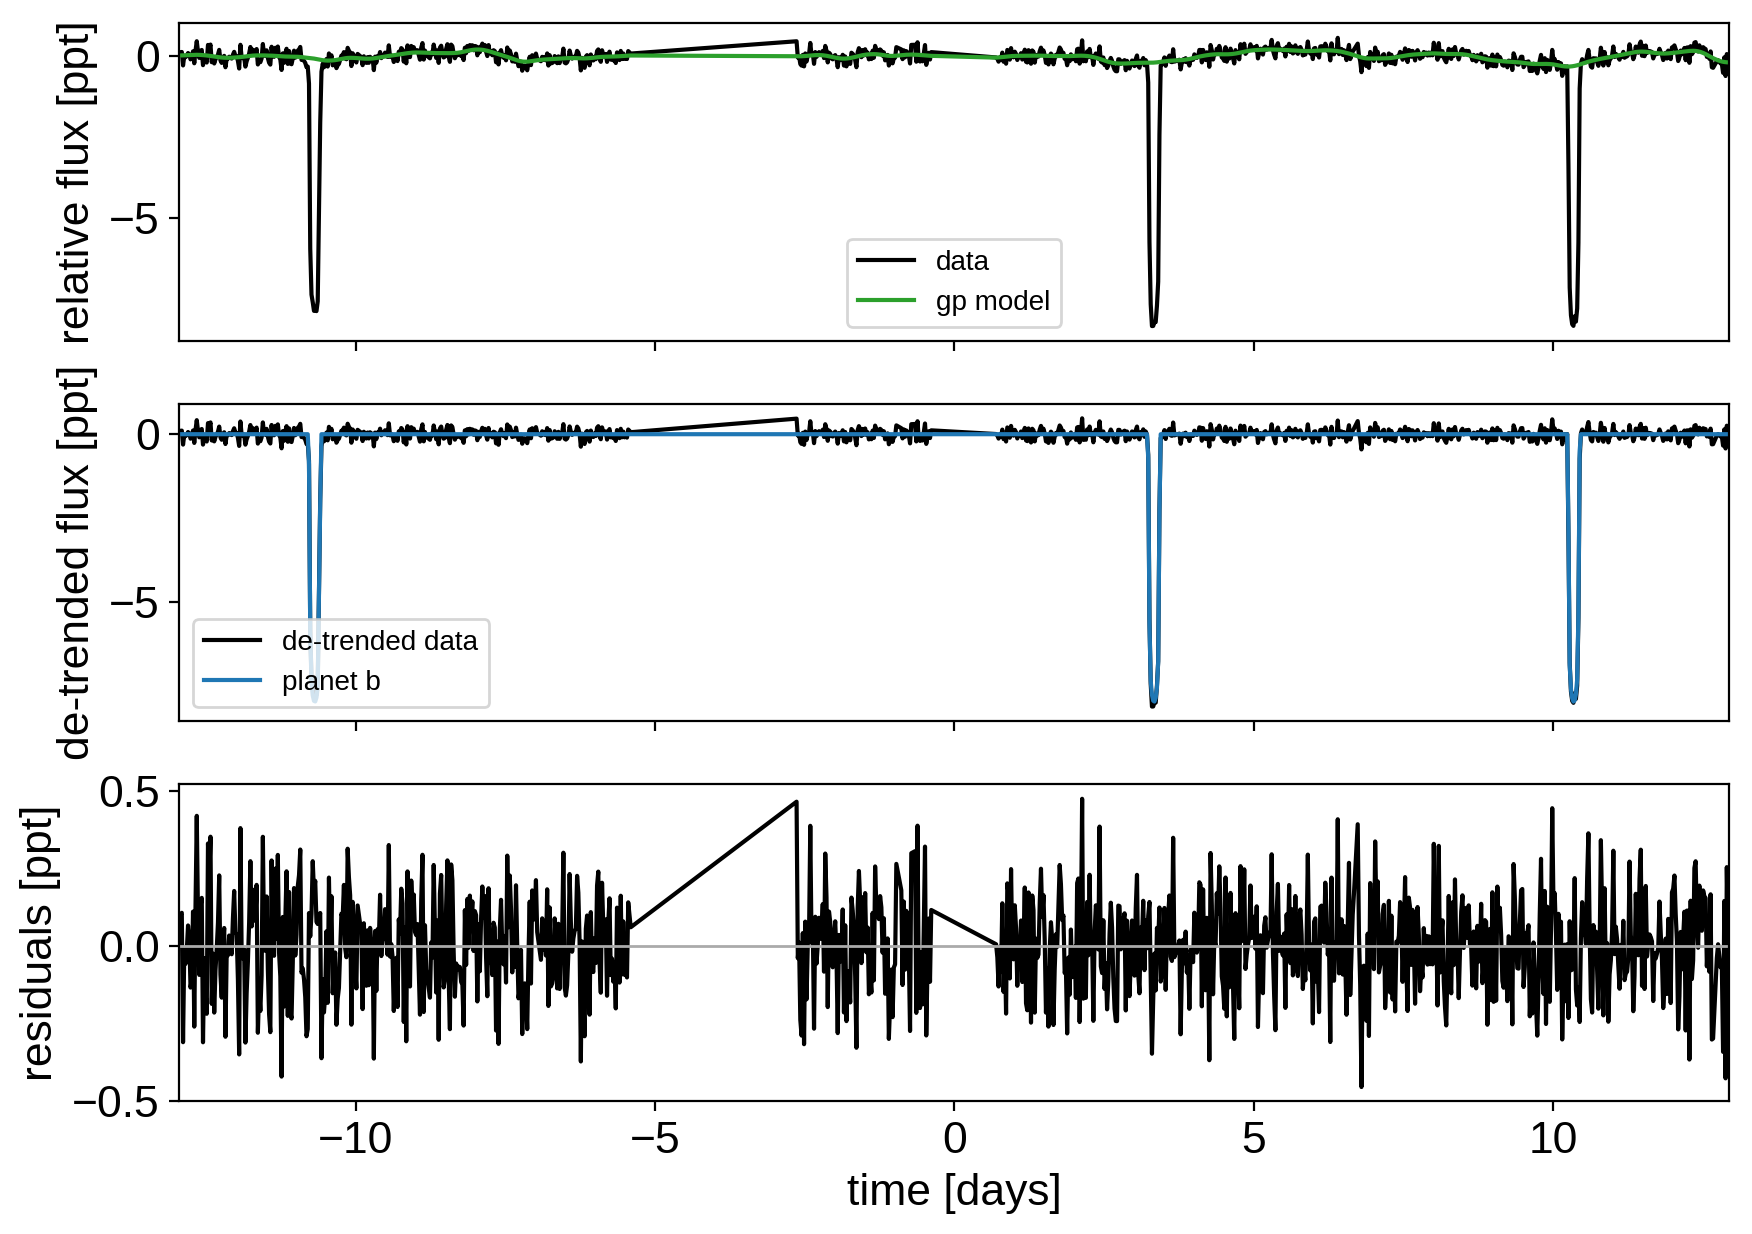

In [13]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(map_soln, mask);

In [14]:
np.random.seed(12345)
sampler = xo.PyMC3Sampler(window=100, start=300, finish=500)
with model:
    burnin = sampler.tune(tune=3500, start=map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=4)

Sampling 4 chains:   0%|          | 0/1208 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|▏         | 18/1208 [00:00<00:19, 60.08draws/s]

Sampling 4 chains:   2%|▏         | 22/1208 [00:00<00:38, 30.49draws/s]

Sampling 4 chains:   2%|▏         | 26/1208 [00:00<00:50, 23.24draws/s]

Sampling 4 chains:   2%|▏         | 29/1208 [00:00<00:50, 23.41draws/s]

Sampling 4 chains:   3%|▎         | 31/1208 [00:01<01:00, 19.44draws/s]

Sampling 4 chains:   3%|▎         | 33/1208 [00:01<01:08, 17.09draws/s]

Sampling 4 chains:   3%|▎         | 35/1208 [00:01<01:08, 17.12draws/s]

Sampling 4 chains:   3%|▎         | 37/1208 [00:01<01:21, 14.45draws/s]

Sampling 4 chains:   3%|▎         | 40/1208 [00:01<01:10, 16.47draws/s]

Sampling 4 chains:   3%|▎         | 42/1208 [00:01<01:27, 13.33draws/s]

Sampling 4 chains:   4%|▎         | 45/1208 [00:02<01:32, 12.61draws/s]

Sampling 4 chains:   4%|▍         | 49/1208 [00:02<01:29, 12.96draws/s]

Sampling 4 chains:   4%|▍         | 53/1208 [00:02<01:26, 13.32draws/s]

Sampling 4 chains:   5%|▍         | 57/1208 [00:03<01:24, 13.62draws/s]

Sampling 4 chains:   5%|▌         | 61/1208 [00:03<01:22, 13.98draws/s]

Sampling 4 chains:   6%|▌         | 67/1208 [00:03<01:13, 15.61draws/s]

Sampling 4 chains:   6%|▌         | 71/1208 [00:03<01:13, 15.41draws/s]

Sampling 4 chains:   6%|▋         | 76/1208 [00:04<01:09, 16.22draws/s]

Sampling 4 chains:   7%|▋         | 79/1208 [00:04<01:01, 18.32draws/s]

Sampling 4 chains:   7%|▋         | 81/1208 [00:04<01:12, 15.57draws/s]

Sampling 4 chains:   7%|▋         | 83/1208 [00:04<01:11, 15.72draws/s]

Sampling 4 chains:   7%|▋         | 85/1208 [00:04<01:14, 15.09draws/s]

Sampling 4 chains:   7%|▋         | 87/1208 [00:04<01:16, 14.67draws/s]

Sampling 4 chains:   7%|▋         | 89/1208 [00:04<01:15, 14.80draws/s]

Sampling 4 chains:   8%|▊         | 91/1208 [00:05<01:19, 14.06draws/s]

Sampling 4 chains:   8%|▊         | 93/1208 [00:05<01:14, 15.06draws/s]

Sampling 4 chains:   8%|▊         | 95/1208 [00:05<01:30, 12.24draws/s]

Sampling 4 chains:   8%|▊         | 99/1208 [00:05<01:22, 13.48draws/s]

Sampling 4 chains:   9%|▊         | 103/1208 [00:05<01:22, 13.36draws/s]

Sampling 4 chains:   9%|▉         | 107/1208 [00:06<01:19, 13.77draws/s]

Sampling 4 chains:   9%|▉         | 111/1208 [00:06<01:17, 14.09draws/s]

Sampling 4 chains:  10%|▉         | 115/1208 [00:06<01:17, 14.04draws/s]

Sampling 4 chains:  10%|▉         | 119/1208 [00:07<01:17, 14.07draws/s]

Sampling 4 chains:  10%|█         | 124/1208 [00:07<01:11, 15.14draws/s]

Sampling 4 chains:  11%|█         | 128/1208 [00:07<01:12, 14.99draws/s]

Sampling 4 chains:  11%|█         | 132/1208 [00:07<01:11, 14.96draws/s]

Sampling 4 chains:  11%|█▏        | 137/1208 [00:08<01:07, 15.82draws/s]

Sampling 4 chains:  12%|█▏        | 141/1208 [00:08<01:08, 15.47draws/s]

Sampling 4 chains:  12%|█▏        | 145/1208 [00:08<01:10, 15.06draws/s]

Sampling 4 chains:  12%|█▏        | 149/1208 [00:09<01:10, 15.04draws/s]

Sampling 4 chains:  13%|█▎        | 152/1208 [00:09<00:59, 17.67draws/s]

Sampling 4 chains:  13%|█▎        | 154/1208 [00:09<01:08, 15.48draws/s]

Sampling 4 chains:  13%|█▎        | 156/1208 [00:09<01:04, 16.39draws/s]

Sampling 4 chains:  13%|█▎        | 158/1208 [00:09<01:10, 14.87draws/s]

Sampling 4 chains:  13%|█▎        | 160/1208 [00:09<01:07, 15.61draws/s]

Sampling 4 chains:  13%|█▎        | 162/1208 [00:09<01:10, 14.77draws/s]

Sampling 4 chains:  14%|█▎        | 164/1208 [00:09<01:12, 14.34draws/s]

Sampling 4 chains:  14%|█▎        | 166/1208 [00:10<01:15, 13.77draws/s]

Sampling 4 chains:  14%|█▍        | 168/1208 [00:10<01:12, 14.33draws/s]

Sampling 4 chains:  14%|█▍        | 170/1208 [00:10<01:12, 14.24draws/s]

Sampling 4 chains:  14%|█▍        | 172/1208 [00:10<01:11, 14.45draws/s]

Sampling 4 chains:  14%|█▍        | 174/1208 [00:10<01:10, 14.62draws/s]

Sampling 4 chains:  15%|█▍        | 177/1208 [00:10<01:03, 16.17draws/s]

Sampling 4 chains:  15%|█▍        | 179/1208 [00:10<01:05, 15.63draws/s]

Sampling 4 chains:  15%|█▍        | 181/1208 [00:11<01:11, 14.38draws/s]

Sampling 4 chains:  15%|█▌        | 183/1208 [00:11<01:06, 15.52draws/s]

Sampling 4 chains:  15%|█▌        | 185/1208 [00:11<01:14, 13.79draws/s]

Sampling 4 chains:  16%|█▌        | 189/1208 [00:11<01:12, 14.07draws/s]

Sampling 4 chains:  16%|█▌        | 193/1208 [00:11<01:11, 14.23draws/s]

Sampling 4 chains:  16%|█▋        | 197/1208 [00:12<01:10, 14.40draws/s]

Sampling 4 chains:  17%|█▋        | 201/1208 [00:12<01:09, 14.53draws/s]

Sampling 4 chains:  17%|█▋        | 207/1208 [00:12<01:01, 16.16draws/s]

Sampling 4 chains:  17%|█▋        | 211/1208 [00:13<01:03, 15.77draws/s]

Sampling 4 chains:  18%|█▊        | 215/1208 [00:13<01:04, 15.49draws/s]

Sampling 4 chains:  18%|█▊        | 219/1208 [00:13<01:05, 15.21draws/s]

Sampling 4 chains:  18%|█▊        | 223/1208 [00:13<01:05, 15.12draws/s]

Sampling 4 chains:  19%|█▉        | 227/1208 [00:14<01:05, 15.05draws/s]

Sampling 4 chains:  19%|█▉        | 231/1208 [00:14<01:05, 15.01draws/s]

Sampling 4 chains:  19%|█▉        | 235/1208 [00:14<01:04, 14.99draws/s]

Sampling 4 chains:  20%|█▉        | 239/1208 [00:14<01:04, 14.95draws/s]

Sampling 4 chains:  20%|██        | 243/1208 [00:15<01:04, 14.89draws/s]

Sampling 4 chains:  20%|██        | 247/1208 [00:15<01:04, 14.88draws/s]

Sampling 4 chains:  21%|██        | 251/1208 [00:15<01:04, 14.87draws/s]

Sampling 4 chains:  21%|██        | 255/1208 [00:15<01:04, 14.87draws/s]

Sampling 4 chains:  21%|██▏       | 258/1208 [00:16<00:55, 17.22draws/s]

Sampling 4 chains:  22%|██▏       | 260/1208 [00:16<01:01, 15.53draws/s]

Sampling 4 chains:  22%|██▏       | 263/1208 [00:16<00:54, 17.41draws/s]

Sampling 4 chains:  22%|██▏       | 265/1208 [00:16<01:00, 15.49draws/s]

Sampling 4 chains:  22%|██▏       | 267/1208 [00:16<00:57, 16.42draws/s]

Sampling 4 chains:  22%|██▏       | 269/1208 [00:16<01:02, 15.07draws/s]

Sampling 4 chains:  22%|██▏       | 271/1208 [00:16<00:58, 15.91draws/s]

Sampling 4 chains:  23%|██▎       | 273/1208 [00:17<01:03, 14.81draws/s]

Sampling 4 chains:  23%|██▎       | 275/1208 [00:17<00:59, 15.65draws/s]

Sampling 4 chains:  23%|██▎       | 277/1208 [00:17<01:03, 14.70draws/s]

Sampling 4 chains:  23%|██▎       | 279/1208 [00:17<01:01, 15.14draws/s]

Sampling 4 chains:  23%|██▎       | 281/1208 [00:17<01:02, 14.80draws/s]

Sampling 4 chains:  23%|██▎       | 283/1208 [00:17<01:04, 14.40draws/s]

Sampling 4 chains:  24%|██▎       | 285/1208 [00:17<01:01, 15.09draws/s]

Sampling 4 chains:  24%|██▍       | 287/1208 [00:18<01:05, 14.11draws/s]

Sampling 4 chains:  24%|██▍       | 289/1208 [00:18<01:00, 15.27draws/s]

Sampling 4 chains:  24%|██▍       | 291/1208 [00:18<01:06, 13.86draws/s]

Sampling 4 chains:  24%|██▍       | 294/1208 [00:18<00:58, 15.68draws/s]

Sampling 4 chains:  25%|██▍       | 296/1208 [00:18<01:09, 13.05draws/s]

Sampling 4 chains:  25%|██▍       | 299/1208 [00:18<01:12, 12.51draws/s]

Sampling 4 chains:  25%|██▌       | 303/1208 [00:19<01:08, 13.20draws/s]

Sampling 4 chains:  25%|██▌       | 307/1208 [00:19<01:05, 13.74draws/s]

Sampling 4 chains:  26%|██▌       | 311/1208 [00:19<01:03, 14.10draws/s]

Sampling 4 chains:  26%|██▌       | 316/1208 [00:19<00:59, 15.10draws/s]

Sampling 4 chains:  26%|██▋       | 320/1208 [00:20<00:58, 15.11draws/s]

Sampling 4 chains:  27%|██▋       | 324/1208 [00:20<00:58, 15.13draws/s]

Sampling 4 chains:  27%|██▋       | 328/1208 [00:20<00:58, 15.14draws/s]

Sampling 4 chains:  27%|██▋       | 332/1208 [00:21<00:58, 15.08draws/s]

Sampling 4 chains:  28%|██▊       | 336/1208 [00:21<00:58, 15.03draws/s]

Sampling 4 chains:  28%|██▊       | 340/1208 [00:21<00:57, 15.07draws/s]

Sampling 4 chains:  28%|██▊       | 344/1208 [00:21<00:59, 14.63draws/s]

Sampling 4 chains:  29%|██▉       | 348/1208 [00:22<00:59, 14.43draws/s]

Sampling 4 chains:  29%|██▉       | 351/1208 [00:22<00:51, 16.72draws/s]

Sampling 4 chains:  29%|██▉       | 353/1208 [00:22<01:03, 13.55draws/s]

Sampling 4 chains:  29%|██▉       | 356/1208 [00:22<01:03, 13.39draws/s]

Sampling 4 chains:  30%|██▉       | 360/1208 [00:22<01:01, 13.79draws/s]

Sampling 4 chains:  30%|███       | 364/1208 [00:23<00:59, 14.09draws/s]

Sampling 4 chains:  30%|███       | 368/1208 [00:23<00:58, 14.31draws/s]

Sampling 4 chains:  31%|███       | 372/1208 [00:23<00:57, 14.49draws/s]

Sampling 4 chains:  31%|███       | 376/1208 [00:24<00:56, 14.61draws/s]

Sampling 4 chains:  31%|███▏      | 380/1208 [00:24<00:56, 14.69draws/s]

Sampling 4 chains:  32%|███▏      | 384/1208 [00:24<00:55, 14.74draws/s]

Sampling 4 chains:  32%|███▏      | 388/1208 [00:24<00:55, 14.78draws/s]

Sampling 4 chains:  32%|███▏      | 392/1208 [00:25<00:55, 14.82draws/s]

Sampling 4 chains:  33%|███▎      | 395/1208 [00:25<00:47, 17.25draws/s]

Sampling 4 chains:  33%|███▎      | 397/1208 [00:25<01:00, 13.47draws/s]

Sampling 4 chains:  33%|███▎      | 400/1208 [00:25<00:58, 13.70draws/s]

Sampling 4 chains:  33%|███▎      | 402/1208 [00:25<00:55, 14.55draws/s]

Sampling 4 chains:  34%|███▎      | 405/1208 [00:25<00:51, 15.66draws/s]

Sampling 4 chains:  34%|███▎      | 407/1208 [00:26<00:49, 16.18draws/s]

Sampling 4 chains:  34%|███▍      | 409/1208 [00:26<00:53, 14.94draws/s]

Sampling 4 chains:  34%|███▍      | 411/1208 [00:26<00:50, 15.67draws/s]

Sampling 4 chains:  34%|███▍      | 413/1208 [00:26<00:53, 14.73draws/s]

Sampling 4 chains:  34%|███▍      | 415/1208 [00:26<00:52, 15.14draws/s]

Sampling 4 chains:  35%|███▍      | 417/1208 [00:26<00:53, 14.77draws/s]

Sampling 4 chains:  35%|███▍      | 419/1208 [00:26<00:53, 14.81draws/s]

Sampling 4 chains:  35%|███▍      | 421/1208 [00:27<00:52, 14.93draws/s]

Sampling 4 chains:  35%|███▌      | 423/1208 [00:27<00:53, 14.64draws/s]

Sampling 4 chains:  35%|███▌      | 425/1208 [00:27<00:51, 15.08draws/s]

Sampling 4 chains:  35%|███▌      | 427/1208 [00:27<00:54, 14.21draws/s]

Sampling 4 chains:  36%|███▌      | 429/1208 [00:27<00:57, 13.56draws/s]

Sampling 4 chains:  36%|███▌      | 431/1208 [00:27<00:58, 13.22draws/s]

Sampling 4 chains:  36%|███▌      | 433/1208 [00:27<00:58, 13.18draws/s]

Sampling 4 chains:  36%|███▌      | 435/1208 [00:28<01:00, 12.70draws/s]

Sampling 4 chains:  36%|███▌      | 437/1208 [00:28<01:00, 12.77draws/s]

Sampling 4 chains:  36%|███▋      | 439/1208 [00:28<01:05, 11.82draws/s]

Sampling 4 chains:  37%|███▋      | 441/1208 [00:28<01:02, 12.19draws/s]

Sampling 4 chains:  37%|███▋      | 443/1208 [00:28<00:59, 12.89draws/s]

Sampling 4 chains:  37%|███▋      | 445/1208 [00:28<01:03, 11.94draws/s]

Sampling 4 chains:  37%|███▋      | 447/1208 [00:29<00:57, 13.25draws/s]

Sampling 4 chains:  37%|███▋      | 449/1208 [00:29<00:58, 12.97draws/s]

Sampling 4 chains:  37%|███▋      | 451/1208 [00:29<00:52, 14.37draws/s]

Sampling 4 chains:  38%|███▊      | 453/1208 [00:29<00:57, 13.14draws/s]

Sampling 4 chains:  38%|███▊      | 455/1208 [00:29<00:51, 14.51draws/s]

Sampling 4 chains:  38%|███▊      | 457/1208 [00:29<00:54, 13.75draws/s]

Sampling 4 chains:  38%|███▊      | 459/1208 [00:29<00:50, 14.97draws/s]

Sampling 4 chains:  38%|███▊      | 461/1208 [00:30<00:52, 14.18draws/s]

Sampling 4 chains:  38%|███▊      | 463/1208 [00:30<00:48, 15.33draws/s]

Sampling 4 chains:  38%|███▊      | 465/1208 [00:30<00:52, 14.19draws/s]

Sampling 4 chains:  39%|███▊      | 468/1208 [00:30<00:54, 13.47draws/s]

Sampling 4 chains:  39%|███▉      | 471/1208 [00:30<00:47, 15.62draws/s]

Sampling 4 chains:  39%|███▉      | 473/1208 [00:30<00:56, 13.01draws/s]

Sampling 4 chains:  39%|███▉      | 476/1208 [00:31<00:57, 12.78draws/s]

Sampling 4 chains:  40%|███▉      | 479/1208 [00:31<00:49, 14.64draws/s]

Sampling 4 chains:  40%|███▉      | 481/1208 [00:31<00:52, 13.85draws/s]

Sampling 4 chains:  40%|███▉      | 483/1208 [00:31<00:48, 15.00draws/s]

Sampling 4 chains:  40%|████      | 485/1208 [00:31<00:51, 14.14draws/s]

Sampling 4 chains:  40%|████      | 487/1208 [00:31<00:47, 15.10draws/s]

Sampling 4 chains:  40%|████      | 489/1208 [00:31<00:50, 14.32draws/s]

Sampling 4 chains:  41%|████      | 491/1208 [00:32<00:46, 15.37draws/s]

Sampling 4 chains:  41%|████      | 493/1208 [00:32<00:49, 14.34draws/s]

Sampling 4 chains:  41%|████      | 495/1208 [00:32<00:45, 15.58draws/s]

Sampling 4 chains:  41%|████      | 497/1208 [00:32<00:49, 14.32draws/s]

Sampling 4 chains:  41%|████▏     | 499/1208 [00:32<00:45, 15.62draws/s]

Sampling 4 chains:  41%|████▏     | 501/1208 [00:32<00:49, 14.41draws/s]

Sampling 4 chains:  42%|████▏     | 504/1208 [00:32<00:51, 13.62draws/s]

Sampling 4 chains:  42%|████▏     | 507/1208 [00:33<00:46, 15.14draws/s]

Sampling 4 chains:  42%|████▏     | 509/1208 [00:33<00:47, 14.87draws/s]

Sampling 4 chains:  42%|████▏     | 511/1208 [00:33<00:47, 14.71draws/s]

Sampling 4 chains:  42%|████▏     | 513/1208 [00:33<00:46, 14.92draws/s]

Sampling 4 chains:  43%|████▎     | 515/1208 [00:33<00:47, 14.69draws/s]

Sampling 4 chains:  43%|████▎     | 517/1208 [00:33<00:45, 15.02draws/s]

Sampling 4 chains:  43%|████▎     | 519/1208 [00:33<00:47, 14.53draws/s]

Sampling 4 chains:  43%|████▎     | 521/1208 [00:34<00:45, 15.09draws/s]

Sampling 4 chains:  43%|████▎     | 523/1208 [00:34<00:47, 14.54draws/s]

Sampling 4 chains:  43%|████▎     | 525/1208 [00:34<00:44, 15.22draws/s]

Sampling 4 chains:  44%|████▎     | 527/1208 [00:34<00:47, 14.47draws/s]

Sampling 4 chains:  44%|████▍     | 529/1208 [00:34<00:44, 15.33draws/s]

Sampling 4 chains:  44%|████▍     | 531/1208 [00:34<00:46, 14.42draws/s]

Sampling 4 chains:  44%|████▍     | 533/1208 [00:34<00:43, 15.41draws/s]

Sampling 4 chains:  44%|████▍     | 535/1208 [00:35<00:46, 14.38draws/s]

Sampling 4 chains:  44%|████▍     | 537/1208 [00:35<00:43, 15.43draws/s]

Sampling 4 chains:  45%|████▍     | 539/1208 [00:35<00:46, 14.36draws/s]

Sampling 4 chains:  45%|████▍     | 541/1208 [00:35<00:42, 15.57draws/s]

Sampling 4 chains:  45%|████▍     | 543/1208 [00:35<00:46, 14.18draws/s]

Sampling 4 chains:  45%|████▌     | 546/1208 [00:35<00:40, 16.48draws/s]

Sampling 4 chains:  45%|████▌     | 548/1208 [00:35<00:52, 12.56draws/s]

Sampling 4 chains:  46%|████▌     | 551/1208 [00:36<00:48, 13.60draws/s]

Sampling 4 chains:  46%|████▌     | 554/1208 [00:36<00:40, 16.17draws/s]

Sampling 4 chains:  46%|████▌     | 556/1208 [00:36<00:53, 12.28draws/s]

Sampling 4 chains:  46%|████▋     | 559/1208 [00:36<00:48, 13.35draws/s]

Sampling 4 chains:  47%|████▋     | 562/1208 [00:36<00:40, 16.01draws/s]

Sampling 4 chains:  47%|████▋     | 565/1208 [00:37<00:45, 14.19draws/s]

Sampling 4 chains:  47%|████▋     | 567/1208 [00:37<00:47, 13.43draws/s]

Sampling 4 chains:  47%|████▋     | 570/1208 [00:37<00:39, 16.07draws/s]

Sampling 4 chains:  47%|████▋     | 573/1208 [00:37<00:44, 14.13draws/s]

Sampling 4 chains:  48%|████▊     | 575/1208 [00:37<00:47, 13.47draws/s]

Sampling 4 chains:  48%|████▊     | 577/1208 [00:37<00:42, 14.78draws/s]

Sampling 4 chains:  48%|████▊     | 579/1208 [00:38<00:45, 13.86draws/s]

Sampling 4 chains:  48%|████▊     | 581/1208 [00:38<00:41, 15.09draws/s]

Sampling 4 chains:  48%|████▊     | 583/1208 [00:38<00:44, 14.09draws/s]

Sampling 4 chains:  48%|████▊     | 585/1208 [00:38<00:40, 15.25draws/s]

Sampling 4 chains:  49%|████▊     | 587/1208 [00:38<00:43, 14.21draws/s]

Sampling 4 chains:  49%|████▉     | 589/1208 [00:38<00:40, 15.28draws/s]

Sampling 4 chains:  49%|████▉     | 591/1208 [00:38<00:43, 14.30draws/s]

Sampling 4 chains:  49%|████▉     | 593/1208 [00:38<00:40, 15.37draws/s]

Sampling 4 chains:  49%|████▉     | 595/1208 [00:39<00:42, 14.36draws/s]

Sampling 4 chains:  49%|████▉     | 597/1208 [00:39<00:39, 15.52draws/s]

Sampling 4 chains:  50%|████▉     | 599/1208 [00:39<00:42, 14.30draws/s]

Sampling 4 chains:  50%|████▉     | 601/1208 [00:39<00:39, 15.46draws/s]

Sampling 4 chains:  50%|████▉     | 603/1208 [00:39<00:42, 14.28draws/s]

Sampling 4 chains:  50%|█████     | 605/1208 [00:39<00:39, 15.37draws/s]

Sampling 4 chains:  50%|█████     | 607/1208 [00:39<00:42, 14.31draws/s]

Sampling 4 chains:  50%|█████     | 609/1208 [00:40<00:39, 15.11draws/s]

Sampling 4 chains:  51%|█████     | 611/1208 [00:40<00:41, 14.28draws/s]

Sampling 4 chains:  51%|█████     | 613/1208 [00:40<00:39, 15.24draws/s]

Sampling 4 chains:  51%|█████     | 615/1208 [00:40<00:42, 14.12draws/s]

Sampling 4 chains:  51%|█████     | 617/1208 [00:40<00:39, 15.06draws/s]

Sampling 4 chains:  51%|█████     | 619/1208 [00:40<00:41, 14.28draws/s]

Sampling 4 chains:  51%|█████▏    | 621/1208 [00:40<00:38, 15.14draws/s]

Sampling 4 chains:  52%|█████▏    | 623/1208 [00:40<00:40, 14.34draws/s]

Sampling 4 chains:  52%|█████▏    | 625/1208 [00:41<00:38, 15.25draws/s]

Sampling 4 chains:  52%|█████▏    | 627/1208 [00:41<00:40, 14.28draws/s]

Sampling 4 chains:  52%|█████▏    | 629/1208 [00:41<00:37, 15.44draws/s]

Sampling 4 chains:  52%|█████▏    | 631/1208 [00:41<00:40, 14.14draws/s]

Sampling 4 chains:  52%|█████▏    | 634/1208 [00:41<00:41, 13.77draws/s]

Sampling 4 chains:  53%|█████▎    | 637/1208 [00:41<00:36, 15.53draws/s]

Sampling 4 chains:  53%|█████▎    | 639/1208 [00:42<00:41, 13.70draws/s]

Sampling 4 chains:  53%|█████▎    | 642/1208 [00:42<00:42, 13.33draws/s]

Sampling 4 chains:  53%|█████▎    | 646/1208 [00:42<00:35, 15.67draws/s]

Sampling 4 chains:  54%|█████▎    | 648/1208 [00:42<00:38, 14.66draws/s]

Sampling 4 chains:  54%|█████▍    | 651/1208 [00:42<00:33, 16.80draws/s]

Sampling 4 chains:  54%|█████▍    | 653/1208 [00:42<00:35, 15.57draws/s]

Sampling 4 chains:  54%|█████▍    | 655/1208 [00:43<00:35, 15.57draws/s]

Sampling 4 chains:  54%|█████▍    | 657/1208 [00:43<00:36, 15.20draws/s]

Sampling 4 chains:  55%|█████▍    | 659/1208 [00:43<00:36, 15.22draws/s]

Sampling 4 chains:  55%|█████▍    | 661/1208 [00:43<00:37, 14.77draws/s]

Sampling 4 chains:  55%|█████▍    | 663/1208 [00:43<00:36, 15.04draws/s]

Sampling 4 chains:  55%|█████▌    | 665/1208 [00:43<00:37, 14.43draws/s]

Sampling 4 chains:  55%|█████▌    | 667/1208 [00:43<00:36, 15.02draws/s]

Sampling 4 chains:  55%|█████▌    | 669/1208 [00:43<00:37, 14.39draws/s]

Sampling 4 chains:  56%|█████▌    | 671/1208 [00:44<00:35, 15.14draws/s]

Sampling 4 chains:  56%|█████▌    | 673/1208 [00:44<00:37, 14.44draws/s]

Sampling 4 chains:  56%|█████▌    | 675/1208 [00:44<00:34, 15.28draws/s]

Sampling 4 chains:  56%|█████▌    | 677/1208 [00:44<00:36, 14.61draws/s]

Sampling 4 chains:  56%|█████▌    | 679/1208 [00:44<00:35, 15.02draws/s]

Sampling 4 chains:  56%|█████▋    | 681/1208 [00:44<00:35, 14.80draws/s]

Sampling 4 chains:  57%|█████▋    | 683/1208 [00:44<00:35, 14.91draws/s]

Sampling 4 chains:  57%|█████▋    | 685/1208 [00:45<00:34, 15.03draws/s]

Sampling 4 chains:  57%|█████▋    | 687/1208 [00:45<00:35, 14.88draws/s]

Sampling 4 chains:  57%|█████▋    | 689/1208 [00:45<00:34, 15.18draws/s]

Sampling 4 chains:  57%|█████▋    | 691/1208 [00:45<00:35, 14.71draws/s]

Sampling 4 chains:  57%|█████▋    | 693/1208 [00:45<00:33, 15.24draws/s]

Sampling 4 chains:  58%|█████▊    | 695/1208 [00:45<00:35, 14.49draws/s]

Sampling 4 chains:  58%|█████▊    | 697/1208 [00:45<00:37, 13.68draws/s]

Sampling 4 chains:  58%|█████▊    | 699/1208 [00:45<00:33, 15.10draws/s]

Sampling 4 chains:  58%|█████▊    | 701/1208 [00:46<00:36, 13.89draws/s]

Sampling 4 chains:  58%|█████▊    | 704/1208 [00:46<00:36, 13.83draws/s]

Sampling 4 chains:  59%|█████▊    | 707/1208 [00:46<00:33, 15.07draws/s]

Sampling 4 chains:  59%|█████▊    | 709/1208 [00:46<00:34, 14.30draws/s]

Sampling 4 chains:  59%|█████▉    | 711/1208 [00:46<00:33, 14.94draws/s]

Sampling 4 chains:  59%|█████▉    | 713/1208 [00:46<00:34, 14.54draws/s]

Sampling 4 chains:  59%|█████▉    | 715/1208 [00:47<00:32, 15.26draws/s]

Sampling 4 chains:  59%|█████▉    | 717/1208 [00:47<00:33, 14.71draws/s]

Sampling 4 chains:  60%|█████▉    | 719/1208 [00:47<00:31, 15.36draws/s]

Sampling 4 chains:  60%|█████▉    | 721/1208 [00:47<00:32, 14.78draws/s]

Sampling 4 chains:  60%|█████▉    | 723/1208 [00:47<00:31, 15.43draws/s]

Sampling 4 chains:  60%|██████    | 725/1208 [00:47<00:32, 14.83draws/s]

Sampling 4 chains:  60%|██████    | 727/1208 [00:47<00:31, 15.10draws/s]

Sampling 4 chains:  60%|██████    | 729/1208 [00:48<00:32, 14.91draws/s]

Sampling 4 chains:  61%|██████    | 731/1208 [00:48<00:31, 15.11draws/s]

Sampling 4 chains:  61%|██████    | 733/1208 [00:48<00:33, 14.27draws/s]

Sampling 4 chains:  61%|██████    | 735/1208 [00:48<00:30, 15.43draws/s]

Sampling 4 chains:  61%|██████    | 737/1208 [00:48<00:32, 14.37draws/s]

Sampling 4 chains:  61%|██████▏   | 740/1208 [00:48<00:34, 13.54draws/s]

Sampling 4 chains:  62%|██████▏   | 743/1208 [00:48<00:29, 15.93draws/s]

Sampling 4 chains:  62%|██████▏   | 745/1208 [00:49<00:32, 14.35draws/s]

Sampling 4 chains:  62%|██████▏   | 748/1208 [00:49<00:34, 13.26draws/s]

Sampling 4 chains:  62%|██████▏   | 752/1208 [00:49<00:33, 13.59draws/s]

Sampling 4 chains:  63%|██████▎   | 756/1208 [00:49<00:32, 14.01draws/s]

Sampling 4 chains:  63%|██████▎   | 760/1208 [00:50<00:26, 16.85draws/s]

Sampling 4 chains:  63%|██████▎   | 762/1208 [00:50<00:32, 13.81draws/s]

Sampling 4 chains:  63%|██████▎   | 765/1208 [00:50<00:31, 14.06draws/s]

Sampling 4 chains:  64%|██████▎   | 768/1208 [00:50<00:27, 15.72draws/s]

Sampling 4 chains:  64%|██████▎   | 770/1208 [00:50<00:32, 13.32draws/s]

Sampling 4 chains:  64%|██████▍   | 773/1208 [00:50<00:31, 13.98draws/s]

Sampling 4 chains:  64%|██████▍   | 776/1208 [00:51<00:28, 14.98draws/s]

Sampling 4 chains:  64%|██████▍   | 778/1208 [00:51<00:31, 13.62draws/s]

Sampling 4 chains:  65%|██████▍   | 781/1208 [00:51<00:30, 14.09draws/s]

Sampling 4 chains:  65%|██████▍   | 784/1208 [00:51<00:28, 14.95draws/s]

Sampling 4 chains:  65%|██████▌   | 786/1208 [00:51<00:29, 14.09draws/s]

Sampling 4 chains:  65%|██████▌   | 788/1208 [00:51<00:27, 15.07draws/s]

Sampling 4 chains:  65%|██████▌   | 790/1208 [00:52<00:28, 14.42draws/s]

Sampling 4 chains:  66%|██████▌   | 792/1208 [00:52<00:27, 15.14draws/s]

Sampling 4 chains:  66%|██████▌   | 794/1208 [00:52<00:26, 15.91draws/s]

Sampling 4 chains:  66%|██████▌   | 797/1208 [00:52<00:24, 16.59draws/s]

Sampling 4 chains:  66%|██████▌   | 799/1208 [00:52<00:28, 14.49draws/s]

Sampling 4 chains:  66%|██████▋   | 801/1208 [00:52<00:36, 11.28draws/s]

Sampling 4 chains:  66%|██████▋   | 803/1208 [00:53<01:10,  5.77draws/s]

Sampling 4 chains:  67%|██████▋   | 804/1208 [00:53<01:10,  5.71draws/s]

Sampling 4 chains:  67%|██████▋   | 805/1208 [00:54<01:10,  5.68draws/s]

Sampling 4 chains:  67%|██████▋   | 806/1208 [00:54<01:42,  3.91draws/s]

Sampling 4 chains:  67%|██████▋   | 807/1208 [00:54<01:42,  3.90draws/s]

Sampling 4 chains:  67%|██████▋   | 808/1208 [00:55<01:48,  3.70draws/s]

Sampling 4 chains:  67%|██████▋   | 810/1208 [00:55<01:48,  3.69draws/s]

Sampling 4 chains:  67%|██████▋   | 811/1208 [00:55<01:45,  3.78draws/s]

Sampling 4 chains:  67%|██████▋   | 812/1208 [00:56<01:44,  3.80draws/s]

Sampling 4 chains:  67%|██████▋   | 813/1208 [00:56<01:31,  4.32draws/s]

Sampling 4 chains:  67%|██████▋   | 814/1208 [00:56<01:49,  3.60draws/s]

Sampling 4 chains:  67%|██████▋   | 815/1208 [00:56<01:49,  3.59draws/s]

Sampling 4 chains:  68%|██████▊   | 816/1208 [00:57<01:42,  3.81draws/s]

Sampling 4 chains:  68%|██████▊   | 817/1208 [00:57<01:41,  3.86draws/s]

Sampling 4 chains:  68%|██████▊   | 818/1208 [00:57<01:49,  3.56draws/s]

Sampling 4 chains:  68%|██████▊   | 819/1208 [00:58<01:49,  3.56draws/s]

Sampling 4 chains:  68%|██████▊   | 820/1208 [00:58<01:51,  3.48draws/s]

Sampling 4 chains:  68%|██████▊   | 821/1208 [00:58<01:41,  3.80draws/s]

Sampling 4 chains:  68%|██████▊   | 822/1208 [00:58<01:42,  3.78draws/s]

Sampling 4 chains:  68%|██████▊   | 823/1208 [00:59<01:46,  3.61draws/s]

Sampling 4 chains:  68%|██████▊   | 824/1208 [00:59<01:51,  3.43draws/s]

Sampling 4 chains:  68%|██████▊   | 825/1208 [00:59<01:41,  3.76draws/s]

Sampling 4 chains:  68%|██████▊   | 826/1208 [00:59<01:43,  3.70draws/s]

Sampling 4 chains:  68%|██████▊   | 827/1208 [01:00<01:46,  3.59draws/s]

Sampling 4 chains:  69%|██████▊   | 828/1208 [01:00<01:55,  3.29draws/s]

Sampling 4 chains:  69%|██████▊   | 829/1208 [01:00<01:45,  3.59draws/s]

Sampling 4 chains:  69%|██████▊   | 830/1208 [01:01<01:50,  3.43draws/s]

Sampling 4 chains:  69%|██████▉   | 831/1208 [01:01<01:42,  3.67draws/s]

Sampling 4 chains:  69%|██████▉   | 832/1208 [01:01<01:50,  3.40draws/s]

Sampling 4 chains:  69%|██████▉   | 833/1208 [01:01<01:40,  3.75draws/s]

Sampling 4 chains:  69%|██████▉   | 834/1208 [01:02<01:53,  3.31draws/s]

Sampling 4 chains:  69%|██████▉   | 835/1208 [01:02<01:57,  3.19draws/s]

Sampling 4 chains:  69%|██████▉   | 836/1208 [01:02<01:38,  3.78draws/s]

Sampling 4 chains:  69%|██████▉   | 837/1208 [01:02<01:32,  4.01draws/s]

Sampling 4 chains:  69%|██████▉   | 838/1208 [01:03<02:11,  2.82draws/s]

Sampling 4 chains:  69%|██████▉   | 839/1208 [01:03<01:56,  3.16draws/s]

Sampling 4 chains:  70%|██████▉   | 840/1208 [01:03<01:33,  3.92draws/s]

Sampling 4 chains:  70%|██████▉   | 841/1208 [01:04<01:26,  4.22draws/s]

Sampling 4 chains:  70%|██████▉   | 842/1208 [01:04<02:15,  2.71draws/s]

Sampling 4 chains:  70%|██████▉   | 843/1208 [01:04<01:47,  3.39draws/s]

Sampling 4 chains:  70%|██████▉   | 845/1208 [01:05<01:30,  3.99draws/s]

Sampling 4 chains:  70%|███████   | 846/1208 [01:05<02:26,  2.47draws/s]

Sampling 4 chains:  70%|███████   | 848/1208 [01:06<01:48,  3.31draws/s]

Sampling 4 chains:  70%|███████   | 849/1208 [01:06<01:39,  3.59draws/s]

Sampling 4 chains:  70%|███████   | 850/1208 [01:07<02:54,  2.05draws/s]

Sampling 4 chains:  71%|███████   | 852/1208 [01:07<02:12,  2.69draws/s]

Sampling 4 chains:  71%|███████   | 854/1208 [01:08<02:31,  2.34draws/s]

Sampling 4 chains:  71%|███████   | 856/1208 [01:08<01:51,  3.15draws/s]

Sampling 4 chains:  71%|███████   | 857/1208 [01:08<01:33,  3.76draws/s]

Sampling 4 chains:  71%|███████   | 858/1208 [01:09<02:50,  2.06draws/s]

Sampling 4 chains:  71%|███████   | 859/1208 [01:10<02:10,  2.67draws/s]

Sampling 4 chains:  71%|███████▏  | 861/1208 [01:10<01:39,  3.50draws/s]

Sampling 4 chains:  71%|███████▏  | 862/1208 [01:11<03:02,  1.90draws/s]

Sampling 4 chains:  72%|███████▏  | 864/1208 [01:11<02:11,  2.61draws/s]

Sampling 4 chains:  72%|███████▏  | 866/1208 [01:12<02:32,  2.24draws/s]

Sampling 4 chains:  72%|███████▏  | 869/1208 [01:12<01:54,  2.95draws/s]

Sampling 4 chains:  72%|███████▏  | 870/1208 [01:13<03:00,  1.88draws/s]

Sampling 4 chains:  72%|███████▏  | 873/1208 [01:13<02:11,  2.54draws/s]

Sampling 4 chains:  72%|███████▏  | 874/1208 [01:14<03:08,  1.78draws/s]

Sampling 4 chains:  72%|███████▏  | 875/1208 [01:15<02:22,  2.34draws/s]

Sampling 4 chains:  73%|███████▎  | 877/1208 [01:15<01:47,  3.08draws/s]

Sampling 4 chains:  73%|███████▎  | 878/1208 [01:16<02:45,  1.99draws/s]

Sampling 4 chains:  73%|███████▎  | 879/1208 [01:16<02:11,  2.51draws/s]

Sampling 4 chains:  73%|███████▎  | 881/1208 [01:16<01:40,  3.27draws/s]

Sampling 4 chains:  73%|███████▎  | 882/1208 [01:17<02:46,  1.95draws/s]

Sampling 4 chains:  73%|███████▎  | 883/1208 [01:17<02:09,  2.50draws/s]

Sampling 4 chains:  73%|███████▎  | 885/1208 [01:17<01:38,  3.27draws/s]

Sampling 4 chains:  73%|███████▎  | 886/1208 [01:18<02:43,  1.97draws/s]

Sampling 4 chains:  73%|███████▎  | 887/1208 [01:18<02:06,  2.54draws/s]

Sampling 4 chains:  74%|███████▎  | 889/1208 [01:19<01:36,  3.30draws/s]

Sampling 4 chains:  74%|███████▎  | 890/1208 [01:20<02:54,  1.82draws/s]

Sampling 4 chains:  74%|███████▍  | 893/1208 [01:20<02:05,  2.50draws/s]

Sampling 4 chains:  74%|███████▍  | 894/1208 [01:21<03:12,  1.63draws/s]

Sampling 4 chains:  74%|███████▍  | 896/1208 [01:21<02:19,  2.23draws/s]

Sampling 4 chains:  74%|███████▍  | 898/1208 [01:22<02:28,  2.08draws/s]

Sampling 4 chains:  74%|███████▍  | 899/1208 [01:22<01:59,  2.60draws/s]

Sampling 4 chains:  75%|███████▍  | 902/1208 [01:24<01:57,  2.60draws/s]

Sampling 4 chains:  75%|███████▍  | 903/1208 [01:24<01:36,  3.17draws/s]

Sampling 4 chains:  75%|███████▌  | 906/1208 [01:25<01:36,  3.13draws/s]

Sampling 4 chains:  75%|███████▌  | 907/1208 [01:25<01:25,  3.53draws/s]

Sampling 4 chains:  75%|███████▌  | 910/1208 [01:26<01:26,  3.46draws/s]

Sampling 4 chains:  75%|███████▌  | 911/1208 [01:26<01:17,  3.83draws/s]

Sampling 4 chains:  76%|███████▌  | 914/1208 [01:27<01:22,  3.56draws/s]

Sampling 4 chains:  76%|███████▌  | 915/1208 [01:27<01:15,  3.89draws/s]

Sampling 4 chains:  76%|███████▌  | 918/1208 [01:28<01:18,  3.69draws/s]

Sampling 4 chains:  76%|███████▌  | 919/1208 [01:28<01:08,  4.19draws/s]

Sampling 4 chains:  76%|███████▋  | 922/1208 [01:29<01:15,  3.78draws/s]

Sampling 4 chains:  76%|███████▋  | 923/1208 [01:29<01:03,  4.49draws/s]

Sampling 4 chains:  77%|███████▋  | 926/1208 [01:30<01:10,  3.99draws/s]

Sampling 4 chains:  77%|███████▋  | 927/1208 [01:30<00:59,  4.73draws/s]

Sampling 4 chains:  77%|███████▋  | 930/1208 [01:31<01:07,  4.12draws/s]

Sampling 4 chains:  77%|███████▋  | 931/1208 [01:31<00:59,  4.62draws/s]

Sampling 4 chains:  77%|███████▋  | 934/1208 [01:32<01:06,  4.12draws/s]

Sampling 4 chains:  77%|███████▋  | 935/1208 [01:33<00:59,  4.59draws/s]

Sampling 4 chains:  78%|███████▊  | 938/1208 [01:33<01:06,  4.06draws/s]

Sampling 4 chains:  78%|███████▊  | 939/1208 [01:34<00:56,  4.78draws/s]

Sampling 4 chains:  78%|███████▊  | 942/1208 [01:35<01:04,  4.13draws/s]

Sampling 4 chains:  78%|███████▊  | 943/1208 [01:35<00:53,  4.96draws/s]

Sampling 4 chains:  78%|███████▊  | 946/1208 [01:36<01:02,  4.18draws/s]

Sampling 4 chains:  78%|███████▊  | 948/1208 [01:36<00:47,  5.45draws/s]

Sampling 4 chains:  79%|███████▊  | 950/1208 [01:37<01:10,  3.66draws/s]

Sampling 4 chains:  79%|███████▉  | 952/1208 [01:37<00:53,  4.81draws/s]

Sampling 4 chains:  79%|███████▉  | 954/1208 [01:38<01:13,  3.46draws/s]

Sampling 4 chains:  79%|███████▉  | 956/1208 [01:38<00:55,  4.56draws/s]

Sampling 4 chains:  79%|███████▉  | 958/1208 [01:39<01:14,  3.37draws/s]

Sampling 4 chains:  79%|███████▉  | 960/1208 [01:39<00:55,  4.46draws/s]

Sampling 4 chains:  80%|███████▉  | 962/1208 [01:40<01:14,  3.31draws/s]

Sampling 4 chains:  80%|███████▉  | 965/1208 [01:40<00:54,  4.49draws/s]

Sampling 4 chains:  80%|████████  | 967/1208 [01:41<01:12,  3.32draws/s]

Sampling 4 chains:  80%|████████  | 970/1208 [01:42<01:06,  3.60draws/s]

Sampling 4 chains:  80%|████████  | 971/1208 [01:42<01:15,  3.15draws/s]

Sampling 4 chains:  81%|████████  | 974/1208 [01:43<01:07,  3.46draws/s]

Sampling 4 chains:  81%|████████  | 975/1208 [01:43<01:15,  3.09draws/s]

Sampling 4 chains:  81%|████████  | 978/1208 [01:44<01:07,  3.39draws/s]

Sampling 4 chains:  81%|████████  | 979/1208 [01:44<01:11,  3.19draws/s]

Sampling 4 chains:  81%|████████▏ | 982/1208 [01:45<01:06,  3.41draws/s]

Sampling 4 chains:  81%|████████▏ | 983/1208 [01:45<01:07,  3.34draws/s]

Sampling 4 chains:  82%|████████▏ | 985/1208 [01:45<00:50,  4.45draws/s]

Sampling 4 chains:  82%|████████▏ | 986/1208 [01:46<01:19,  2.81draws/s]

Sampling 4 chains:  82%|████████▏ | 987/1208 [01:46<01:14,  2.97draws/s]

Sampling 4 chains:  82%|████████▏ | 989/1208 [01:46<00:55,  3.96draws/s]

Sampling 4 chains:  82%|████████▏ | 990/1208 [01:47<01:23,  2.62draws/s]

Sampling 4 chains:  82%|████████▏ | 991/1208 [01:47<01:14,  2.91draws/s]

Sampling 4 chains:  82%|████████▏ | 992/1208 [01:47<00:59,  3.62draws/s]

Sampling 4 chains:  82%|████████▏ | 994/1208 [01:48<01:05,  3.27draws/s]

Sampling 4 chains:  82%|████████▏ | 995/1208 [01:48<00:59,  3.60draws/s]

Sampling 4 chains:  82%|████████▏ | 996/1208 [01:49<00:47,  4.44draws/s]

Sampling 4 chains:  83%|████████▎ | 998/1208 [01:49<00:56,  3.70draws/s]

Sampling 4 chains:  83%|████████▎ | 999/1208 [01:50<00:53,  3.92draws/s]

Sampling 4 chains:  83%|████████▎ | 1001/1208 [01:50<00:41,  4.99draws/s]

Sampling 4 chains:  83%|████████▎ | 1002/1208 [01:50<01:14,  2.78draws/s]

Sampling 4 chains:  83%|████████▎ | 1003/1208 [01:51<01:04,  3.17draws/s]

Sampling 4 chains:  83%|████████▎ | 1005/1208 [01:51<00:49,  4.11draws/s]

Sampling 4 chains:  83%|████████▎ | 1006/1208 [01:51<01:17,  2.61draws/s]

Sampling 4 chains:  83%|████████▎ | 1007/1208 [01:52<01:08,  2.93draws/s]

Sampling 4 chains:  84%|████████▎ | 1009/1208 [01:52<00:50,  3.91draws/s]

Sampling 4 chains:  84%|████████▎ | 1010/1208 [01:53<01:18,  2.52draws/s]

Sampling 4 chains:  84%|████████▍ | 1012/1208 [01:53<01:01,  3.17draws/s]

Sampling 4 chains:  84%|████████▍ | 1014/1208 [01:54<01:06,  2.93draws/s]

Sampling 4 chains:  84%|████████▍ | 1016/1208 [01:54<00:53,  3.59draws/s]

Sampling 4 chains:  84%|████████▍ | 1017/1208 [01:54<00:44,  4.27draws/s]

Sampling 4 chains:  84%|████████▍ | 1018/1208 [01:55<01:08,  2.77draws/s]

Sampling 4 chains:  84%|████████▍ | 1020/1208 [01:55<00:56,  3.34draws/s]

Sampling 4 chains:  85%|████████▍ | 1021/1208 [01:55<00:45,  4.09draws/s]

Sampling 4 chains:  85%|████████▍ | 1022/1208 [01:56<01:09,  2.68draws/s]

Sampling 4 chains:  85%|████████▍ | 1024/1208 [01:56<00:56,  3.26draws/s]

Sampling 4 chains:  85%|████████▍ | 1025/1208 [01:56<00:46,  3.92draws/s]

Sampling 4 chains:  85%|████████▍ | 1026/1208 [01:57<01:05,  2.78draws/s]

Sampling 4 chains:  85%|████████▌ | 1028/1208 [01:57<00:54,  3.31draws/s]

Sampling 4 chains:  85%|████████▌ | 1029/1208 [01:57<00:44,  3.98draws/s]

Sampling 4 chains:  85%|████████▌ | 1030/1208 [01:58<01:02,  2.87draws/s]

Sampling 4 chains:  85%|████████▌ | 1031/1208 [01:58<00:48,  3.64draws/s]

Sampling 4 chains:  85%|████████▌ | 1032/1208 [01:58<00:53,  3.32draws/s]

Sampling 4 chains:  86%|████████▌ | 1034/1208 [01:59<00:52,  3.30draws/s]

Sampling 4 chains:  86%|████████▌ | 1036/1208 [01:59<00:48,  3.54draws/s]

Sampling 4 chains:  86%|████████▌ | 1037/1208 [01:59<00:39,  4.36draws/s]

Sampling 4 chains:  86%|████████▌ | 1038/1208 [02:00<00:51,  3.27draws/s]

Sampling 4 chains:  86%|████████▌ | 1040/1208 [02:00<00:48,  3.48draws/s]

Sampling 4 chains:  86%|████████▌ | 1041/1208 [02:01<00:39,  4.27draws/s]

Sampling 4 chains:  86%|████████▋ | 1042/1208 [02:01<00:49,  3.36draws/s]

Sampling 4 chains:  86%|████████▋ | 1043/1208 [02:01<00:41,  4.02draws/s]

Sampling 4 chains:  86%|████████▋ | 1044/1208 [02:02<00:48,  3.41draws/s]

Sampling 4 chains:  87%|████████▋ | 1045/1208 [02:02<00:38,  4.24draws/s]

Sampling 4 chains:  87%|████████▋ | 1046/1208 [02:02<00:46,  3.48draws/s]

Sampling 4 chains:  87%|████████▋ | 1047/1208 [02:02<00:40,  3.96draws/s]

Sampling 4 chains:  87%|████████▋ | 1048/1208 [02:03<00:47,  3.36draws/s]

Sampling 4 chains:  87%|████████▋ | 1049/1208 [02:03<00:37,  4.19draws/s]

Sampling 4 chains:  87%|████████▋ | 1050/1208 [02:03<00:43,  3.62draws/s]

Sampling 4 chains:  87%|████████▋ | 1051/1208 [02:03<00:40,  3.88draws/s]

Sampling 4 chains:  87%|████████▋ | 1052/1208 [02:04<00:48,  3.25draws/s]

Sampling 4 chains:  87%|████████▋ | 1054/1208 [02:04<00:42,  3.63draws/s]

Sampling 4 chains:  87%|████████▋ | 1055/1208 [02:04<00:41,  3.69draws/s]

Sampling 4 chains:  87%|████████▋ | 1056/1208 [02:05<00:47,  3.19draws/s]

Sampling 4 chains:  88%|████████▊ | 1058/1208 [02:05<00:41,  3.65draws/s]

Sampling 4 chains:  88%|████████▊ | 1059/1208 [02:05<00:41,  3.58draws/s]

Sampling 4 chains:  88%|████████▊ | 1060/1208 [02:06<00:47,  3.14draws/s]

Sampling 4 chains:  88%|████████▊ | 1062/1208 [02:06<00:40,  3.65draws/s]

Sampling 4 chains:  88%|████████▊ | 1063/1208 [02:07<00:41,  3.49draws/s]

Sampling 4 chains:  88%|████████▊ | 1064/1208 [02:07<00:48,  2.98draws/s]

Sampling 4 chains:  88%|████████▊ | 1066/1208 [02:07<00:39,  3.58draws/s]

Sampling 4 chains:  88%|████████▊ | 1067/1208 [02:08<00:41,  3.41draws/s]

Sampling 4 chains:  88%|████████▊ | 1069/1208 [02:08<00:37,  3.69draws/s]

Sampling 4 chains:  89%|████████▊ | 1070/1208 [02:08<00:30,  4.53draws/s]

Sampling 4 chains:  89%|████████▊ | 1071/1208 [02:08<00:28,  4.80draws/s]

Sampling 4 chains:  89%|████████▊ | 1072/1208 [02:09<00:35,  3.86draws/s]

Sampling 4 chains:  89%|████████▉ | 1073/1208 [02:09<00:41,  3.27draws/s]

Sampling 4 chains:  89%|████████▉ | 1074/1208 [02:09<00:33,  4.05draws/s]

Sampling 4 chains:  89%|████████▉ | 1075/1208 [02:09<00:28,  4.65draws/s]

Sampling 4 chains:  89%|████████▉ | 1076/1208 [02:10<00:35,  3.68draws/s]

Sampling 4 chains:  89%|████████▉ | 1077/1208 [02:10<00:41,  3.14draws/s]

Sampling 4 chains:  89%|████████▉ | 1078/1208 [02:10<00:33,  3.90draws/s]

Sampling 4 chains:  89%|████████▉ | 1079/1208 [02:10<00:27,  4.77draws/s]

Sampling 4 chains:  89%|████████▉ | 1080/1208 [02:11<00:35,  3.59draws/s]

Sampling 4 chains:  89%|████████▉ | 1081/1208 [02:11<00:40,  3.11draws/s]

Sampling 4 chains:  90%|████████▉ | 1082/1208 [02:11<00:33,  3.80draws/s]

Sampling 4 chains:  90%|████████▉ | 1083/1208 [02:12<00:27,  4.62draws/s]

Sampling 4 chains:  90%|████████▉ | 1084/1208 [02:12<00:35,  3.49draws/s]

Sampling 4 chains:  90%|████████▉ | 1085/1208 [02:12<00:39,  3.14draws/s]

Sampling 4 chains:  90%|████████▉ | 1086/1208 [02:12<00:32,  3.79draws/s]

Sampling 4 chains:  90%|█████████ | 1088/1208 [02:13<00:32,  3.71draws/s]

Sampling 4 chains:  90%|█████████ | 1089/1208 [02:13<00:35,  3.38draws/s]

Sampling 4 chains:  90%|█████████ | 1090/1208 [02:14<00:30,  3.93draws/s]

Sampling 4 chains:  90%|█████████ | 1092/1208 [02:14<00:30,  3.77draws/s]

Sampling 4 chains:  90%|█████████ | 1093/1208 [02:14<00:32,  3.54draws/s]

Sampling 4 chains:  91%|█████████ | 1094/1208 [02:15<00:28,  3.99draws/s]

Sampling 4 chains:  91%|█████████ | 1096/1208 [02:15<00:29,  3.83draws/s]

Sampling 4 chains:  91%|█████████ | 1097/1208 [02:16<00:30,  3.65draws/s]

Sampling 4 chains:  91%|█████████ | 1098/1208 [02:16<00:26,  4.10draws/s]

Sampling 4 chains:  91%|█████████ | 1100/1208 [02:16<00:28,  3.81draws/s]

Sampling 4 chains:  91%|█████████ | 1101/1208 [02:17<00:28,  3.73draws/s]

Sampling 4 chains:  91%|█████████ | 1102/1208 [02:17<00:25,  4.23draws/s]

Sampling 4 chains:  91%|█████████▏| 1104/1208 [02:17<00:26,  3.86draws/s]

Sampling 4 chains:  91%|█████████▏| 1105/1208 [02:18<00:27,  3.73draws/s]

Sampling 4 chains:  92%|█████████▏| 1106/1208 [02:18<00:25,  4.01draws/s]

Sampling 4 chains:  92%|█████████▏| 1108/1208 [02:18<00:26,  3.82draws/s]

Sampling 4 chains:  92%|█████████▏| 1109/1208 [02:19<00:26,  3.74draws/s]

Sampling 4 chains:  92%|█████████▏| 1110/1208 [02:19<00:23,  4.11draws/s]

Sampling 4 chains:  92%|█████████▏| 1112/1208 [02:20<00:24,  3.86draws/s]

Sampling 4 chains:  92%|█████████▏| 1113/1208 [02:20<00:25,  3.72draws/s]

Sampling 4 chains:  92%|█████████▏| 1114/1208 [02:20<00:22,  4.17draws/s]

Sampling 4 chains:  92%|█████████▏| 1116/1208 [02:21<00:23,  3.84draws/s]

Sampling 4 chains:  92%|█████████▏| 1117/1208 [02:21<00:24,  3.73draws/s]

Sampling 4 chains:  93%|█████████▎| 1118/1208 [02:21<00:20,  4.33draws/s]

Sampling 4 chains:  93%|█████████▎| 1119/1208 [02:21<00:17,  4.96draws/s]

Sampling 4 chains:  93%|█████████▎| 1120/1208 [02:22<00:25,  3.39draws/s]

Sampling 4 chains:  93%|█████████▎| 1121/1208 [02:22<00:25,  3.35draws/s]

Sampling 4 chains:  93%|█████████▎| 1123/1208 [02:22<00:21,  4.00draws/s]

Sampling 4 chains:  93%|█████████▎| 1124/1208 [02:23<00:27,  3.09draws/s]

Sampling 4 chains:  93%|█████████▎| 1125/1208 [02:23<00:26,  3.17draws/s]

Sampling 4 chains:  93%|█████████▎| 1127/1208 [02:23<00:21,  3.76draws/s]

Sampling 4 chains:  93%|█████████▎| 1128/1208 [02:24<00:27,  2.93draws/s]

Sampling 4 chains:  93%|█████████▎| 1129/1208 [02:24<00:25,  3.09draws/s]

Sampling 4 chains:  94%|█████████▎| 1131/1208 [02:24<00:20,  3.72draws/s]

Sampling 4 chains:  94%|█████████▎| 1132/1208 [02:25<00:26,  2.90draws/s]

Sampling 4 chains:  94%|█████████▍| 1133/1208 [02:25<00:24,  3.11draws/s]

Sampling 4 chains:  94%|█████████▍| 1135/1208 [02:26<00:19,  3.71draws/s]

Sampling 4 chains:  94%|█████████▍| 1136/1208 [02:26<00:24,  2.89draws/s]

Sampling 4 chains:  94%|█████████▍| 1137/1208 [02:26<00:22,  3.20draws/s]

Sampling 4 chains:  94%|█████████▍| 1139/1208 [02:27<00:18,  3.74draws/s]

Sampling 4 chains:  94%|█████████▍| 1140/1208 [02:27<00:23,  2.87draws/s]

Sampling 4 chains:  94%|█████████▍| 1141/1208 [02:27<00:19,  3.35draws/s]

Sampling 4 chains:  95%|█████████▍| 1143/1208 [02:28<00:17,  3.79draws/s]

Sampling 4 chains:  95%|█████████▍| 1144/1208 [02:28<00:22,  2.81draws/s]

Sampling 4 chains:  95%|█████████▍| 1145/1208 [02:28<00:17,  3.57draws/s]

Sampling 4 chains:  95%|█████████▍| 1147/1208 [02:29<00:15,  3.89draws/s]

Sampling 4 chains:  95%|█████████▌| 1148/1208 [02:29<00:21,  2.82draws/s]

Sampling 4 chains:  95%|█████████▌| 1150/1208 [02:29<00:15,  3.69draws/s]

Sampling 4 chains:  95%|█████████▌| 1151/1208 [02:30<00:16,  3.41draws/s]

Sampling 4 chains:  95%|█████████▌| 1152/1208 [02:30<00:21,  2.62draws/s]

Sampling 4 chains:  96%|█████████▌| 1154/1208 [02:31<00:15,  3.49draws/s]

Sampling 4 chains:  96%|█████████▌| 1155/1208 [02:31<00:16,  3.13draws/s]

Sampling 4 chains:  96%|█████████▌| 1156/1208 [02:32<00:20,  2.52draws/s]

Sampling 4 chains:  96%|█████████▌| 1157/1208 [02:32<00:16,  3.12draws/s]

Sampling 4 chains:  96%|█████████▌| 1159/1208 [02:32<00:13,  3.58draws/s]

Sampling 4 chains:  96%|█████████▌| 1160/1208 [02:33<00:17,  2.73draws/s]

Sampling 4 chains:  96%|█████████▌| 1161/1208 [02:33<00:14,  3.30draws/s]

Sampling 4 chains:  96%|█████████▋| 1163/1208 [02:33<00:12,  3.74draws/s]

Sampling 4 chains:  96%|█████████▋| 1164/1208 [02:34<00:15,  2.82draws/s]

Sampling 4 chains:  96%|█████████▋| 1165/1208 [02:34<00:12,  3.39draws/s]

Sampling 4 chains:  97%|█████████▋| 1167/1208 [02:34<00:10,  3.82draws/s]

Sampling 4 chains:  97%|█████████▋| 1168/1208 [02:35<00:13,  2.88draws/s]

Sampling 4 chains:  97%|█████████▋| 1169/1208 [02:35<00:11,  3.42draws/s]

Sampling 4 chains:  97%|█████████▋| 1171/1208 [02:35<00:09,  3.88draws/s]

Sampling 4 chains:  97%|█████████▋| 1172/1208 [02:36<00:12,  2.89draws/s]

Sampling 4 chains:  97%|█████████▋| 1173/1208 [02:36<00:10,  3.35draws/s]

Sampling 4 chains:  97%|█████████▋| 1175/1208 [02:36<00:08,  3.88draws/s]

Sampling 4 chains:  97%|█████████▋| 1176/1208 [02:37<00:11,  2.81draws/s]

Sampling 4 chains:  97%|█████████▋| 1177/1208 [02:37<00:09,  3.42draws/s]

Sampling 4 chains:  98%|█████████▊| 1179/1208 [02:37<00:07,  3.90draws/s]

Sampling 4 chains:  98%|█████████▊| 1180/1208 [02:38<00:09,  2.81draws/s]

Sampling 4 chains:  98%|█████████▊| 1181/1208 [02:38<00:07,  3.48draws/s]

Sampling 4 chains:  98%|█████████▊| 1183/1208 [02:38<00:06,  3.92draws/s]

Sampling 4 chains:  98%|█████████▊| 1184/1208 [02:39<00:08,  2.71draws/s]

Sampling 4 chains:  98%|█████████▊| 1185/1208 [02:39<00:06,  3.43draws/s]

Sampling 4 chains:  98%|█████████▊| 1187/1208 [02:40<00:05,  3.95draws/s]

Sampling 4 chains:  98%|█████████▊| 1188/1208 [02:40<00:07,  2.67draws/s]

Sampling 4 chains:  99%|█████████▊| 1190/1208 [02:40<00:05,  3.53draws/s]

Sampling 4 chains:  99%|█████████▊| 1191/1208 [02:41<00:04,  3.61draws/s]

Sampling 4 chains:  99%|█████████▊| 1192/1208 [02:41<00:06,  2.51draws/s]

Sampling 4 chains:  99%|█████████▉| 1194/1208 [02:41<00:04,  3.33draws/s]

Sampling 4 chains:  99%|█████████▉| 1195/1208 [02:42<00:03,  3.45draws/s]

Sampling 4 chains:  99%|█████████▉| 1196/1208 [02:42<00:05,  2.38draws/s]

Sampling 4 chains:  99%|█████████▉| 1199/1208 [02:43<00:02,  3.02draws/s]

Sampling 4 chains:  99%|█████████▉| 1200/1208 [02:44<00:03,  2.26draws/s]

Sampling 4 chains: 100%|█████████▉| 1203/1208 [02:44<00:01,  2.85draws/s]

Sampling 4 chains: 100%|█████████▉| 1204/1208 [02:45<00:01,  2.20draws/s]

Sampling 4 chains: 100%|█████████▉| 1206/1208 [02:45<00:00,  2.63draws/s]

Sampling 4 chains: 100%|█████████▉| 1207/1208 [02:46<00:00,  2.11draws/s]

Sampling 4 chains: 100%|██████████| 1208/1208 [02:46<00:00,  2.19draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   5%|▌         | 21/408 [00:00<00:05, 67.89draws/s]

Sampling 4 chains:   6%|▌         | 25/408 [00:00<00:11, 33.33draws/s]

Sampling 4 chains:   7%|▋         | 29/408 [00:00<00:15, 24.32draws/s]

Sampling 4 chains:   8%|▊         | 33/408 [00:01<00:18, 20.55draws/s]

Sampling 4 chains:   9%|▉         | 38/408 [00:01<00:18, 20.06draws/s]

Sampling 4 chains:  11%|█         | 43/408 [00:01<00:18, 19.32draws/s]

Sampling 4 chains:  12%|█▏        | 47/408 [00:01<00:20, 17.56draws/s]

Sampling 4 chains:  13%|█▎        | 52/408 [00:02<00:20, 17.62draws/s]

Sampling 4 chains:  14%|█▎        | 56/408 [00:02<00:18, 19.49draws/s]

Sampling 4 chains:  14%|█▍        | 58/408 [00:02<00:19, 18.16draws/s]

Sampling 4 chains:  15%|█▍        | 60/408 [00:02<00:20, 16.93draws/s]

Sampling 4 chains:  15%|█▌        | 62/408 [00:02<00:21, 16.22draws/s]

Sampling 4 chains:  16%|█▌        | 65/408 [00:02<00:21, 16.27draws/s]

Sampling 4 chains:  17%|█▋        | 68/408 [00:03<00:18, 18.54draws/s]

Sampling 4 chains:  17%|█▋        | 70/408 [00:03<00:26, 12.84draws/s]

Sampling 4 chains:  18%|█▊        | 73/408 [00:03<00:23, 14.05draws/s]

Sampling 4 chains:  18%|█▊        | 75/408 [00:03<00:22, 14.71draws/s]

Sampling 4 chains:  19%|█▉        | 78/408 [00:03<00:20, 16.04draws/s]

Sampling 4 chains:  20%|█▉        | 80/408 [00:03<00:19, 16.46draws/s]

Sampling 4 chains:  21%|██        | 85/408 [00:04<00:16, 19.15draws/s]

Sampling 4 chains:  22%|██▏       | 88/408 [00:04<00:16, 19.57draws/s]

Sampling 4 chains:  22%|██▏       | 91/408 [00:04<00:19, 16.10draws/s]

Sampling 4 chains:  23%|██▎       | 93/408 [00:04<00:19, 16.23draws/s]

Sampling 4 chains:  23%|██▎       | 95/408 [00:04<00:19, 16.17draws/s]

Sampling 4 chains:  25%|██▍       | 100/408 [00:04<00:16, 18.76draws/s]

Sampling 4 chains:  25%|██▌       | 103/408 [00:05<00:16, 18.73draws/s]

Sampling 4 chains:  26%|██▌       | 106/408 [00:05<00:19, 15.88draws/s]

Sampling 4 chains:  27%|██▋       | 109/408 [00:05<00:16, 18.07draws/s]

Sampling 4 chains:  27%|██▋       | 112/408 [00:05<00:16, 17.51draws/s]

Sampling 4 chains:  28%|██▊       | 115/408 [00:05<00:19, 15.31draws/s]

Sampling 4 chains:  29%|██▉       | 119/408 [00:05<00:15, 18.61draws/s]

Sampling 4 chains:  30%|██▉       | 122/408 [00:06<00:15, 18.09draws/s]

Sampling 4 chains:  31%|███       | 125/408 [00:06<00:18, 15.36draws/s]

Sampling 4 chains:  32%|███▏      | 130/408 [00:06<00:17, 16.14draws/s]

Sampling 4 chains:  33%|███▎      | 134/408 [00:06<00:17, 15.62draws/s]

Sampling 4 chains:  34%|███▍      | 139/408 [00:07<00:16, 16.33draws/s]

Sampling 4 chains:  35%|███▌      | 143/408 [00:07<00:16, 15.74draws/s]

Sampling 4 chains:  36%|███▌      | 147/408 [00:07<00:16, 15.37draws/s]

Sampling 4 chains:  38%|███▊      | 155/408 [00:08<00:14, 17.89draws/s]

Sampling 4 chains:  39%|███▉      | 159/408 [00:08<00:14, 16.89draws/s]

Sampling 4 chains:  40%|███▉      | 163/408 [00:08<00:15, 16.24draws/s]

Sampling 4 chains:  41%|████      | 167/408 [00:08<00:15, 15.90draws/s]

Sampling 4 chains:  42%|████▏     | 173/408 [00:09<00:13, 17.35draws/s]

Sampling 4 chains:  44%|████▎     | 178/408 [00:09<00:12, 17.79draws/s]

Sampling 4 chains:  45%|████▍     | 182/408 [00:09<00:12, 18.52draws/s]

Sampling 4 chains:  45%|████▌     | 184/408 [00:09<00:13, 16.98draws/s]

Sampling 4 chains:  46%|████▌     | 186/408 [00:09<00:13, 16.59draws/s]

Sampling 4 chains:  46%|████▌     | 188/408 [00:09<00:14, 15.65draws/s]

Sampling 4 chains:  47%|████▋     | 190/408 [00:10<00:13, 16.03draws/s]

Sampling 4 chains:  47%|████▋     | 192/408 [00:10<00:14, 15.13draws/s]

Sampling 4 chains:  48%|████▊     | 195/408 [00:10<00:12, 17.33draws/s]

Sampling 4 chains:  48%|████▊     | 197/408 [00:10<00:13, 15.43draws/s]

Sampling 4 chains:  49%|████▉     | 199/408 [00:10<00:13, 15.93draws/s]

Sampling 4 chains:  49%|████▉     | 201/408 [00:10<00:13, 14.85draws/s]

Sampling 4 chains:  50%|████▉     | 203/408 [00:10<00:12, 15.82draws/s]

Sampling 4 chains:  50%|█████     | 205/408 [00:11<00:13, 14.59draws/s]

Sampling 4 chains:  51%|█████     | 207/408 [00:11<00:12, 15.72draws/s]

Sampling 4 chains:  51%|█████     | 209/408 [00:11<00:13, 14.25draws/s]

Sampling 4 chains:  52%|█████▏    | 212/408 [00:11<00:14, 13.58draws/s]

Sampling 4 chains:  53%|█████▎    | 215/408 [00:11<00:12, 15.91draws/s]

Sampling 4 chains:  53%|█████▎    | 217/408 [00:11<00:13, 13.74draws/s]

Sampling 4 chains:  54%|█████▍    | 222/408 [00:12<00:11, 15.54draws/s]

Sampling 4 chains:  55%|█████▌    | 225/408 [00:12<00:10, 17.02draws/s]

Sampling 4 chains:  56%|█████▌    | 227/408 [00:12<00:12, 14.12draws/s]

Sampling 4 chains:  57%|█████▋    | 231/408 [00:12<00:11, 15.65draws/s]

Sampling 4 chains:  57%|█████▋    | 233/408 [00:12<00:10, 16.59draws/s]

Sampling 4 chains:  58%|█████▊    | 235/408 [00:12<00:11, 15.14draws/s]

Sampling 4 chains:  58%|█████▊    | 238/408 [00:12<00:09, 17.48draws/s]

Sampling 4 chains:  59%|█████▉    | 240/408 [00:13<00:11, 15.23draws/s]

Sampling 4 chains:  60%|█████▉    | 243/408 [00:13<00:09, 17.85draws/s]

Sampling 4 chains:  60%|██████    | 246/408 [00:13<00:09, 17.75draws/s]

Sampling 4 chains:  61%|██████    | 249/408 [00:13<00:08, 19.27draws/s]

Sampling 4 chains:  62%|██████▏   | 252/408 [00:13<00:09, 16.33draws/s]

Sampling 4 chains:  62%|██████▏   | 254/408 [00:13<00:10, 15.21draws/s]

Sampling 4 chains:  63%|██████▎   | 256/408 [00:14<00:09, 15.76draws/s]

Sampling 4 chains:  64%|██████▎   | 260/408 [00:14<00:08, 17.35draws/s]

Sampling 4 chains:  64%|██████▍   | 262/408 [00:14<00:08, 16.60draws/s]

Sampling 4 chains:  65%|██████▍   | 264/408 [00:14<00:09, 15.04draws/s]

Sampling 4 chains:  65%|██████▌   | 266/408 [00:14<00:09, 15.33draws/s]

Sampling 4 chains:  66%|██████▌   | 269/408 [00:14<00:08, 16.81draws/s]

Sampling 4 chains:  66%|██████▋   | 271/408 [00:14<00:08, 16.30draws/s]

Sampling 4 chains:  67%|██████▋   | 273/408 [00:15<00:08, 15.66draws/s]

Sampling 4 chains:  67%|██████▋   | 275/408 [00:15<00:08, 15.92draws/s]

Sampling 4 chains:  68%|██████▊   | 278/408 [00:15<00:07, 16.96draws/s]

Sampling 4 chains:  69%|██████▊   | 280/408 [00:15<00:07, 16.71draws/s]

Sampling 4 chains:  69%|██████▉   | 283/408 [00:15<00:06, 17.94draws/s]

Sampling 4 chains:  70%|██████▉   | 285/408 [00:15<00:07, 16.84draws/s]

Sampling 4 chains:  70%|███████   | 287/408 [00:15<00:07, 16.48draws/s]

Sampling 4 chains:  71%|███████   | 289/408 [00:16<00:07, 15.89draws/s]

Sampling 4 chains:  72%|███████▏  | 292/408 [00:16<00:06, 17.22draws/s]

Sampling 4 chains:  72%|███████▏  | 294/408 [00:16<00:07, 16.25draws/s]

Sampling 4 chains:  73%|███████▎  | 297/408 [00:16<00:06, 17.84draws/s]

Sampling 4 chains:  73%|███████▎  | 299/408 [00:16<00:06, 16.42draws/s]

Sampling 4 chains:  74%|███████▍  | 302/408 [00:16<00:05, 18.02draws/s]

Sampling 4 chains:  75%|███████▍  | 304/408 [00:16<00:06, 16.15draws/s]

Sampling 4 chains:  75%|███████▌  | 306/408 [00:16<00:06, 16.12draws/s]

Sampling 4 chains:  75%|███████▌  | 308/408 [00:17<00:06, 15.52draws/s]

Sampling 4 chains:  76%|███████▌  | 310/408 [00:17<00:06, 15.04draws/s]

Sampling 4 chains:  77%|███████▋  | 313/408 [00:17<00:05, 16.86draws/s]

Sampling 4 chains:  77%|███████▋  | 315/408 [00:17<00:06, 15.36draws/s]

Sampling 4 chains:  78%|███████▊  | 318/408 [00:17<00:05, 17.51draws/s]

Sampling 4 chains:  78%|███████▊  | 320/408 [00:17<00:05, 15.86draws/s]

Sampling 4 chains:  79%|███████▉  | 323/408 [00:17<00:04, 17.79draws/s]

Sampling 4 chains:  80%|███████▉  | 325/408 [00:18<00:05, 14.78draws/s]

Sampling 4 chains:  80%|████████  | 328/408 [00:18<00:05, 14.27draws/s]

Sampling 4 chains:  81%|████████  | 331/408 [00:18<00:04, 16.41draws/s]

Sampling 4 chains:  82%|████████▏ | 333/408 [00:18<00:04, 15.12draws/s]

Sampling 4 chains:  82%|████████▏ | 336/408 [00:18<00:04, 17.39draws/s]

Sampling 4 chains:  83%|████████▎ | 338/408 [00:18<00:05, 13.85draws/s]

Sampling 4 chains:  84%|████████▎ | 341/408 [00:19<00:04, 14.02draws/s]

Sampling 4 chains:  84%|████████▍ | 343/408 [00:19<00:04, 14.21draws/s]

Sampling 4 chains:  85%|████████▍ | 345/408 [00:19<00:04, 14.52draws/s]

Sampling 4 chains:  85%|████████▌ | 347/408 [00:19<00:04, 14.61draws/s]

Sampling 4 chains:  86%|████████▌ | 349/408 [00:19<00:03, 14.91draws/s]

Sampling 4 chains:  86%|████████▌ | 351/408 [00:19<00:03, 14.64draws/s]

Sampling 4 chains:  87%|████████▋ | 353/408 [00:19<00:03, 15.14draws/s]

Sampling 4 chains:  87%|████████▋ | 355/408 [00:20<00:03, 14.63draws/s]

Sampling 4 chains:  88%|████████▊ | 357/408 [00:20<00:03, 15.23draws/s]

Sampling 4 chains:  88%|████████▊ | 359/408 [00:20<00:03, 14.58draws/s]

Sampling 4 chains:  88%|████████▊ | 361/408 [00:20<00:03, 15.26draws/s]

Sampling 4 chains:  89%|████████▉ | 363/408 [00:20<00:02, 15.11draws/s]

Sampling 4 chains:  90%|████████▉ | 367/408 [00:20<00:02, 17.89draws/s]

Sampling 4 chains:  91%|█████████ | 370/408 [00:20<00:02, 16.12draws/s]

Sampling 4 chains:  91%|█████████ | 372/408 [00:21<00:02, 13.75draws/s]

Sampling 4 chains:  92%|█████████▏| 375/408 [00:21<00:02, 16.30draws/s]

Sampling 4 chains:  92%|█████████▏| 377/408 [00:21<00:02, 14.43draws/s]

Sampling 4 chains:  93%|█████████▎| 380/408 [00:21<00:02, 13.39draws/s]

Sampling 4 chains:  94%|█████████▍| 384/408 [00:21<00:01, 13.83draws/s]

Sampling 4 chains:  95%|█████████▍| 387/408 [00:22<00:01, 16.30draws/s]

Sampling 4 chains:  95%|█████████▌| 389/408 [00:22<00:01, 14.24draws/s]

Sampling 4 chains:  96%|█████████▋| 393/408 [00:22<00:00, 17.64draws/s]

Sampling 4 chains:  97%|█████████▋| 396/408 [00:22<00:00, 16.94draws/s]

Sampling 4 chains:  98%|█████████▊| 399/408 [00:22<00:00, 14.55draws/s]

Sampling 4 chains:  98%|█████████▊| 401/408 [00:23<00:00, 10.32draws/s]

Sampling 4 chains:  99%|█████████▉| 403/408 [00:23<00:00,  8.91draws/s]

Sampling 4 chains: 100%|█████████▉| 406/408 [00:23<00:00,  7.90draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:24<00:00,  5.05draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 3/808 [00:00<00:44, 18.22draws/s]

Sampling 4 chains:   1%|          | 5/808 [00:00<00:48, 16.65draws/s]

Sampling 4 chains:   1%|          | 10/808 [00:00<00:43, 18.51draws/s]

Sampling 4 chains:   1%|▏         | 12/808 [00:00<00:45, 17.56draws/s]

Sampling 4 chains:   2%|▏         | 14/808 [00:00<00:50, 15.79draws/s]

Sampling 4 chains:   2%|▏         | 16/808 [00:00<00:50, 15.74draws/s]

Sampling 4 chains:   2%|▏         | 18/808 [00:01<00:53, 14.77draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:01<00:46, 16.75draws/s]

Sampling 4 chains:   3%|▎         | 23/808 [00:01<00:52, 14.97draws/s]

Sampling 4 chains:   3%|▎         | 26/808 [00:01<00:45, 17.36draws/s]

Sampling 4 chains:   3%|▎         | 28/808 [00:01<00:58, 13.35draws/s]

Sampling 4 chains:   4%|▍         | 32/808 [00:01<00:49, 15.75draws/s]

Sampling 4 chains:   4%|▍         | 35/808 [00:01<00:42, 18.07draws/s]

Sampling 4 chains:   5%|▍         | 39/808 [00:02<00:44, 17.23draws/s]

Sampling 4 chains:   5%|▌         | 43/808 [00:02<00:41, 18.62draws/s]

Sampling 4 chains:   6%|▌         | 46/808 [00:02<00:42, 17.84draws/s]

Sampling 4 chains:   6%|▌         | 48/808 [00:02<00:49, 15.30draws/s]

Sampling 4 chains:   6%|▋         | 51/808 [00:02<00:44, 17.07draws/s]

Sampling 4 chains:   7%|▋         | 53/808 [00:03<00:48, 15.52draws/s]

Sampling 4 chains:   7%|▋         | 55/808 [00:03<00:48, 15.59draws/s]

Sampling 4 chains:   7%|▋         | 58/808 [00:03<00:45, 16.50draws/s]

Sampling 4 chains:   7%|▋         | 60/808 [00:03<00:45, 16.32draws/s]

Sampling 4 chains:   8%|▊         | 62/808 [00:03<00:49, 15.17draws/s]

Sampling 4 chains:   8%|▊         | 64/808 [00:03<00:50, 14.86draws/s]

Sampling 4 chains:   8%|▊         | 66/808 [00:03<00:50, 14.61draws/s]

Sampling 4 chains:   8%|▊         | 68/808 [00:04<00:52, 14.18draws/s]

Sampling 4 chains:   9%|▉         | 71/808 [00:04<00:54, 13.58draws/s]

Sampling 4 chains:   9%|▉         | 74/808 [00:04<00:45, 16.11draws/s]

Sampling 4 chains:   9%|▉         | 76/808 [00:04<00:51, 14.13draws/s]

Sampling 4 chains:  10%|▉         | 79/808 [00:04<00:44, 16.35draws/s]

Sampling 4 chains:  10%|█         | 81/808 [00:04<00:48, 15.13draws/s]

Sampling 4 chains:  10%|█         | 83/808 [00:04<00:45, 16.06draws/s]

Sampling 4 chains:  11%|█         | 85/808 [00:05<00:48, 14.89draws/s]

Sampling 4 chains:  11%|█         | 88/808 [00:05<00:42, 16.88draws/s]

Sampling 4 chains:  11%|█         | 90/808 [00:05<00:54, 13.07draws/s]

Sampling 4 chains:  12%|█▏        | 94/808 [00:05<00:46, 15.47draws/s]

Sampling 4 chains:  12%|█▏        | 96/808 [00:05<00:45, 15.74draws/s]

Sampling 4 chains:  12%|█▏        | 98/808 [00:05<00:49, 14.43draws/s]

Sampling 4 chains:  12%|█▏        | 100/808 [00:06<00:46, 15.32draws/s]

Sampling 4 chains:  13%|█▎        | 102/808 [00:06<00:50, 13.92draws/s]

Sampling 4 chains:  13%|█▎        | 105/808 [00:06<00:46, 14.99draws/s]

Sampling 4 chains:  13%|█▎        | 107/808 [00:06<00:46, 14.94draws/s]

Sampling 4 chains:  14%|█▎        | 110/808 [00:06<00:42, 16.27draws/s]

Sampling 4 chains:  14%|█▍        | 112/808 [00:06<00:43, 16.01draws/s]

Sampling 4 chains:  14%|█▍        | 114/808 [00:06<00:45, 15.09draws/s]

Sampling 4 chains:  14%|█▍        | 116/808 [00:07<00:46, 14.99draws/s]

Sampling 4 chains:  15%|█▍        | 118/808 [00:07<00:47, 14.60draws/s]

Sampling 4 chains:  15%|█▍        | 120/808 [00:07<00:47, 14.57draws/s]

Sampling 4 chains:  15%|█▌        | 122/808 [00:07<00:48, 14.16draws/s]

Sampling 4 chains:  15%|█▌        | 124/808 [00:07<00:47, 14.47draws/s]

Sampling 4 chains:  16%|█▌        | 126/808 [00:07<00:47, 14.45draws/s]

Sampling 4 chains:  16%|█▌        | 129/808 [00:07<00:44, 15.37draws/s]

Sampling 4 chains:  16%|█▌        | 131/808 [00:08<00:42, 16.12draws/s]

Sampling 4 chains:  17%|█▋        | 134/808 [00:08<00:44, 15.03draws/s]

Sampling 4 chains:  17%|█▋        | 138/808 [00:08<00:38, 17.55draws/s]

Sampling 4 chains:  17%|█▋        | 140/808 [00:08<00:41, 15.91draws/s]

Sampling 4 chains:  18%|█▊        | 143/808 [00:08<00:38, 17.31draws/s]

Sampling 4 chains:  18%|█▊        | 145/808 [00:08<00:41, 16.17draws/s]

Sampling 4 chains:  18%|█▊        | 148/808 [00:08<00:37, 17.55draws/s]

Sampling 4 chains:  19%|█▊        | 151/808 [00:09<00:36, 17.88draws/s]

Sampling 4 chains:  19%|█▉        | 153/808 [00:09<00:40, 16.02draws/s]

Sampling 4 chains:  19%|█▉        | 156/808 [00:09<00:37, 17.61draws/s]

Sampling 4 chains:  20%|█▉        | 158/808 [00:09<00:35, 18.24draws/s]

Sampling 4 chains:  20%|█▉        | 160/808 [00:09<00:40, 16.19draws/s]

Sampling 4 chains:  20%|██        | 162/808 [00:09<00:39, 16.39draws/s]

Sampling 4 chains:  20%|██        | 164/808 [00:09<00:43, 14.96draws/s]

Sampling 4 chains:  21%|██        | 166/808 [00:10<00:41, 15.58draws/s]

Sampling 4 chains:  21%|██        | 169/808 [00:10<00:35, 18.05draws/s]

Sampling 4 chains:  21%|██        | 171/808 [00:10<00:43, 14.81draws/s]

Sampling 4 chains:  22%|██▏       | 175/808 [00:10<00:39, 16.03draws/s]

Sampling 4 chains:  22%|██▏       | 177/808 [00:10<00:39, 16.17draws/s]

Sampling 4 chains:  23%|██▎       | 182/808 [00:10<00:32, 19.25draws/s]

Sampling 4 chains:  23%|██▎       | 185/808 [00:11<00:37, 16.58draws/s]

Sampling 4 chains:  23%|██▎       | 187/808 [00:11<00:40, 15.19draws/s]

Sampling 4 chains:  23%|██▎       | 189/808 [00:11<00:40, 15.13draws/s]

Sampling 4 chains:  24%|██▎       | 191/808 [00:11<00:41, 14.72draws/s]

Sampling 4 chains:  24%|██▍       | 193/808 [00:11<00:42, 14.52draws/s]

Sampling 4 chains:  24%|██▍       | 196/808 [00:11<00:37, 16.38draws/s]

Sampling 4 chains:  25%|██▍       | 199/808 [00:11<00:36, 16.90draws/s]

Sampling 4 chains:  25%|██▍       | 201/808 [00:12<00:38, 15.73draws/s]

Sampling 4 chains:  25%|██▌       | 205/808 [00:12<00:38, 15.86draws/s]

Sampling 4 chains:  26%|██▌       | 209/808 [00:12<00:32, 18.17draws/s]

Sampling 4 chains:  26%|██▌       | 211/808 [00:12<00:39, 14.95draws/s]

Sampling 4 chains:  27%|██▋       | 215/808 [00:12<00:34, 17.30draws/s]

Sampling 4 chains:  27%|██▋       | 218/808 [00:13<00:36, 16.32draws/s]

Sampling 4 chains:  27%|██▋       | 221/808 [00:13<00:36, 16.24draws/s]

Sampling 4 chains:  28%|██▊       | 224/808 [00:13<00:31, 18.70draws/s]

Sampling 4 chains:  28%|██▊       | 227/808 [00:13<00:37, 15.56draws/s]

Sampling 4 chains:  28%|██▊       | 230/808 [00:13<00:33, 17.34draws/s]

Sampling 4 chains:  29%|██▊       | 232/808 [00:13<00:37, 15.32draws/s]

Sampling 4 chains:  29%|██▉       | 234/808 [00:13<00:36, 15.71draws/s]

Sampling 4 chains:  29%|██▉       | 237/808 [00:14<00:33, 17.15draws/s]

Sampling 4 chains:  30%|██▉       | 239/808 [00:14<00:39, 14.23draws/s]

Sampling 4 chains:  30%|███       | 243/808 [00:14<00:37, 14.94draws/s]

Sampling 4 chains:  30%|███       | 246/808 [00:14<00:32, 17.09draws/s]

Sampling 4 chains:  31%|███       | 248/808 [00:14<00:34, 16.18draws/s]

Sampling 4 chains:  31%|███       | 250/808 [00:14<00:33, 16.48draws/s]

Sampling 4 chains:  31%|███▏      | 254/808 [00:15<00:30, 18.38draws/s]

Sampling 4 chains:  32%|███▏      | 256/808 [00:15<00:36, 14.97draws/s]

Sampling 4 chains:  32%|███▏      | 259/808 [00:15<00:33, 16.18draws/s]

Sampling 4 chains:  32%|███▏      | 261/808 [00:15<00:33, 16.14draws/s]

Sampling 4 chains:  33%|███▎      | 263/808 [00:15<00:36, 15.10draws/s]

Sampling 4 chains:  33%|███▎      | 265/808 [00:15<00:35, 15.40draws/s]

Sampling 4 chains:  33%|███▎      | 267/808 [00:15<00:37, 14.55draws/s]

Sampling 4 chains:  33%|███▎      | 269/808 [00:16<00:34, 15.80draws/s]

Sampling 4 chains:  34%|███▎      | 272/808 [00:16<00:29, 18.29draws/s]

Sampling 4 chains:  34%|███▍      | 275/808 [00:16<00:31, 16.75draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [00:16<00:31, 17.00draws/s]

Sampling 4 chains:  35%|███▍      | 279/808 [00:16<00:33, 15.83draws/s]

Sampling 4 chains:  35%|███▍      | 282/808 [00:16<00:30, 17.02draws/s]

Sampling 4 chains:  35%|███▌      | 284/808 [00:16<00:32, 15.98draws/s]

Sampling 4 chains:  36%|███▌      | 287/808 [00:17<00:30, 17.18draws/s]

Sampling 4 chains:  36%|███▌      | 289/808 [00:17<00:36, 14.15draws/s]

Sampling 4 chains:  36%|███▋      | 293/808 [00:17<00:30, 17.03draws/s]

Sampling 4 chains:  37%|███▋      | 296/808 [00:17<00:33, 15.37draws/s]

Sampling 4 chains:  37%|███▋      | 299/808 [00:17<00:34, 14.90draws/s]

Sampling 4 chains:  37%|███▋      | 301/808 [00:17<00:32, 15.44draws/s]

Sampling 4 chains:  38%|███▊      | 304/808 [00:18<00:34, 14.67draws/s]

Sampling 4 chains:  38%|███▊      | 308/808 [00:18<00:29, 17.20draws/s]

Sampling 4 chains:  38%|███▊      | 311/808 [00:18<00:28, 17.27draws/s]

Sampling 4 chains:  39%|███▉      | 314/808 [00:18<00:26, 18.54draws/s]

Sampling 4 chains:  39%|███▉      | 317/808 [00:18<00:28, 17.50draws/s]

Sampling 4 chains:  39%|███▉      | 319/808 [00:19<00:37, 13.19draws/s]

Sampling 4 chains:  40%|███▉      | 323/808 [00:19<00:35, 13.50draws/s]

Sampling 4 chains:  40%|████      | 327/808 [00:19<00:34, 13.76draws/s]

Sampling 4 chains:  41%|████      | 331/808 [00:19<00:34, 13.90draws/s]

Sampling 4 chains:  41%|████▏     | 334/808 [00:20<00:28, 16.50draws/s]

Sampling 4 chains:  42%|████▏     | 336/808 [00:20<00:34, 13.81draws/s]

Sampling 4 chains:  42%|████▏     | 339/808 [00:20<00:29, 16.06draws/s]

Sampling 4 chains:  42%|████▏     | 341/808 [00:20<00:31, 14.82draws/s]

Sampling 4 chains:  43%|████▎     | 345/808 [00:20<00:25, 18.00draws/s]

Sampling 4 chains:  43%|████▎     | 348/808 [00:20<00:26, 17.20draws/s]

Sampling 4 chains:  43%|████▎     | 351/808 [00:20<00:24, 18.31draws/s]

Sampling 4 chains:  44%|████▍     | 354/808 [00:21<00:26, 16.90draws/s]

Sampling 4 chains:  44%|████▍     | 357/808 [00:21<00:26, 17.05draws/s]

Sampling 4 chains:  45%|████▍     | 360/808 [00:21<00:23, 19.34draws/s]

Sampling 4 chains:  45%|████▍     | 363/808 [00:21<00:25, 17.76draws/s]

Sampling 4 chains:  45%|████▌     | 365/808 [00:21<00:25, 17.56draws/s]

Sampling 4 chains:  45%|████▌     | 367/808 [00:21<00:28, 15.60draws/s]

Sampling 4 chains:  46%|████▌     | 371/808 [00:22<00:23, 18.32draws/s]

Sampling 4 chains:  46%|████▋     | 374/808 [00:22<00:27, 15.94draws/s]

Sampling 4 chains:  47%|████▋     | 376/808 [00:22<00:32, 13.13draws/s]

Sampling 4 chains:  47%|████▋     | 379/808 [00:22<00:27, 15.41draws/s]

Sampling 4 chains:  47%|████▋     | 381/808 [00:22<00:32, 13.05draws/s]

Sampling 4 chains:  48%|████▊     | 384/808 [00:23<00:33, 12.80draws/s]

Sampling 4 chains:  48%|████▊     | 387/808 [00:23<00:28, 14.70draws/s]

Sampling 4 chains:  48%|████▊     | 389/808 [00:23<00:30, 13.58draws/s]

Sampling 4 chains:  48%|████▊     | 391/808 [00:23<00:28, 14.73draws/s]

Sampling 4 chains:  49%|████▊     | 393/808 [00:23<00:26, 15.67draws/s]

Sampling 4 chains:  49%|████▉     | 395/808 [00:23<00:28, 14.30draws/s]

Sampling 4 chains:  49%|████▉     | 398/808 [00:23<00:24, 16.65draws/s]

Sampling 4 chains:  50%|████▉     | 400/808 [00:24<00:29, 13.86draws/s]

Sampling 4 chains:  50%|█████     | 404/808 [00:24<00:28, 14.08draws/s]

Sampling 4 chains:  50%|█████     | 408/808 [00:24<00:28, 14.22draws/s]

Sampling 4 chains:  51%|█████     | 411/808 [00:24<00:24, 16.05draws/s]

Sampling 4 chains:  51%|█████     | 413/808 [00:24<00:28, 13.73draws/s]

Sampling 4 chains:  51%|█████▏    | 416/808 [00:25<00:28, 13.59draws/s]

Sampling 4 chains:  52%|█████▏    | 419/808 [00:25<00:23, 16.22draws/s]

Sampling 4 chains:  52%|█████▏    | 421/808 [00:25<00:25, 15.43draws/s]

Sampling 4 chains:  52%|█████▏    | 423/808 [00:25<00:24, 15.65draws/s]

Sampling 4 chains:  53%|█████▎    | 426/808 [00:25<00:23, 16.52draws/s]

Sampling 4 chains:  53%|█████▎    | 429/808 [00:25<00:24, 15.64draws/s]

Sampling 4 chains:  53%|█████▎    | 431/808 [00:26<00:24, 15.43draws/s]

Sampling 4 chains:  54%|█████▎    | 433/808 [00:26<00:25, 14.60draws/s]

Sampling 4 chains:  54%|█████▍    | 435/808 [00:26<00:25, 14.89draws/s]

Sampling 4 chains:  54%|█████▍    | 439/808 [00:26<00:21, 17.00draws/s]

Sampling 4 chains:  55%|█████▍    | 442/808 [00:26<00:19, 18.78draws/s]

Sampling 4 chains:  55%|█████▌    | 445/808 [00:26<00:19, 18.35draws/s]

Sampling 4 chains:  55%|█████▌    | 447/808 [00:26<00:20, 17.41draws/s]

Sampling 4 chains:  56%|█████▌    | 450/808 [00:27<00:24, 14.62draws/s]

Sampling 4 chains:  56%|█████▌    | 454/808 [00:27<00:24, 14.51draws/s]

Sampling 4 chains:  57%|█████▋    | 458/808 [00:27<00:24, 14.43draws/s]

Sampling 4 chains:  57%|█████▋    | 462/808 [00:28<00:23, 14.45draws/s]

Sampling 4 chains:  58%|█████▊    | 466/808 [00:28<00:22, 15.53draws/s]

Sampling 4 chains:  58%|█████▊    | 468/808 [00:28<00:21, 15.84draws/s]

Sampling 4 chains:  58%|█████▊    | 471/808 [00:28<00:19, 17.72draws/s]

Sampling 4 chains:  59%|█████▊    | 473/808 [00:28<00:22, 15.01draws/s]

Sampling 4 chains:  59%|█████▉    | 476/808 [00:28<00:19, 16.62draws/s]

Sampling 4 chains:  59%|█████▉    | 478/808 [00:29<00:24, 13.57draws/s]

Sampling 4 chains:  60%|█████▉    | 482/808 [00:29<00:20, 16.11draws/s]

Sampling 4 chains:  60%|█████▉    | 484/808 [00:29<00:19, 16.58draws/s]

Sampling 4 chains:  60%|██████    | 487/808 [00:29<00:18, 17.03draws/s]

Sampling 4 chains:  61%|██████    | 489/808 [00:29<00:21, 15.17draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [00:29<00:19, 15.99draws/s]

Sampling 4 chains:  61%|██████    | 493/808 [00:29<00:22, 14.25draws/s]

Sampling 4 chains:  61%|██████▏   | 495/808 [00:29<00:20, 15.48draws/s]

Sampling 4 chains:  62%|██████▏   | 497/808 [00:30<00:22, 13.93draws/s]

Sampling 4 chains:  62%|██████▏   | 500/808 [00:30<00:19, 15.63draws/s]

Sampling 4 chains:  62%|██████▏   | 502/808 [00:30<00:22, 13.81draws/s]

Sampling 4 chains:  62%|██████▎   | 505/808 [00:30<00:20, 14.72draws/s]

Sampling 4 chains:  63%|██████▎   | 507/808 [00:30<00:19, 15.35draws/s]

Sampling 4 chains:  63%|██████▎   | 510/808 [00:30<00:16, 17.90draws/s]

Sampling 4 chains:  63%|██████▎   | 513/808 [00:31<00:17, 16.48draws/s]

Sampling 4 chains:  64%|██████▎   | 515/808 [00:31<00:22, 13.06draws/s]

Sampling 4 chains:  64%|██████▍   | 518/808 [00:31<00:18, 15.28draws/s]

Sampling 4 chains:  64%|██████▍   | 520/808 [00:31<00:20, 14.01draws/s]

Sampling 4 chains:  65%|██████▍   | 522/808 [00:31<00:18, 15.13draws/s]

Sampling 4 chains:  65%|██████▍   | 525/808 [00:31<00:18, 15.04draws/s]

Sampling 4 chains:  65%|██████▌   | 528/808 [00:32<00:16, 17.28draws/s]

Sampling 4 chains:  66%|██████▌   | 530/808 [00:32<00:21, 13.12draws/s]

Sampling 4 chains:  66%|██████▌   | 534/808 [00:32<00:19, 14.20draws/s]

Sampling 4 chains:  67%|██████▋   | 538/808 [00:32<00:18, 14.25draws/s]

Sampling 4 chains:  67%|██████▋   | 542/808 [00:33<00:17, 14.90draws/s]

Sampling 4 chains:  67%|██████▋   | 545/808 [00:33<00:15, 16.85draws/s]

Sampling 4 chains:  68%|██████▊   | 548/808 [00:33<00:15, 17.03draws/s]

Sampling 4 chains:  68%|██████▊   | 551/808 [00:33<00:13, 19.45draws/s]

Sampling 4 chains:  69%|██████▊   | 554/808 [00:33<00:16, 15.74draws/s]

Sampling 4 chains:  69%|██████▉   | 557/808 [00:33<00:17, 14.25draws/s]

Sampling 4 chains:  69%|██████▉   | 560/808 [00:34<00:14, 16.82draws/s]

Sampling 4 chains:  70%|██████▉   | 563/808 [00:34<00:15, 15.96draws/s]

Sampling 4 chains:  70%|██████▉   | 565/808 [00:34<00:18, 13.48draws/s]

Sampling 4 chains:  70%|███████   | 569/808 [00:34<00:17, 13.59draws/s]

Sampling 4 chains:  71%|███████   | 573/808 [00:35<00:16, 14.12draws/s]

Sampling 4 chains:  71%|███████▏  | 577/808 [00:35<00:16, 14.25draws/s]

Sampling 4 chains:  72%|███████▏  | 581/808 [00:35<00:15, 14.30draws/s]

Sampling 4 chains:  72%|███████▏  | 584/808 [00:35<00:13, 16.52draws/s]

Sampling 4 chains:  73%|███████▎  | 586/808 [00:35<00:14, 15.41draws/s]

Sampling 4 chains:  73%|███████▎  | 588/808 [00:35<00:13, 16.29draws/s]

Sampling 4 chains:  73%|███████▎  | 590/808 [00:36<00:16, 13.48draws/s]

Sampling 4 chains:  74%|███████▎  | 594/808 [00:36<00:13, 15.44draws/s]

Sampling 4 chains:  74%|███████▍  | 596/808 [00:36<00:15, 13.72draws/s]

Sampling 4 chains:  74%|███████▍  | 598/808 [00:36<00:14, 14.05draws/s]

Sampling 4 chains:  74%|███████▍  | 601/808 [00:36<00:13, 15.34draws/s]

Sampling 4 chains:  75%|███████▍  | 603/808 [00:36<00:13, 15.26draws/s]

Sampling 4 chains:  75%|███████▌  | 606/808 [00:37<00:12, 16.69draws/s]

Sampling 4 chains:  75%|███████▌  | 608/808 [00:37<00:14, 13.82draws/s]

Sampling 4 chains:  75%|███████▌  | 610/808 [00:37<00:13, 14.27draws/s]

Sampling 4 chains:  76%|███████▌  | 612/808 [00:37<00:13, 14.28draws/s]

Sampling 4 chains:  76%|███████▌  | 614/808 [00:37<00:13, 14.71draws/s]

Sampling 4 chains:  76%|███████▌  | 616/808 [00:37<00:16, 11.93draws/s]

Sampling 4 chains:  77%|███████▋  | 619/808 [00:38<00:15, 12.23draws/s]

Sampling 4 chains:  77%|███████▋  | 621/808 [00:38<00:14, 12.52draws/s]

Sampling 4 chains:  77%|███████▋  | 623/808 [00:38<00:13, 13.22draws/s]

Sampling 4 chains:  77%|███████▋  | 625/808 [00:38<00:14, 12.82draws/s]

Sampling 4 chains:  78%|███████▊  | 627/808 [00:38<00:13, 12.99draws/s]

Sampling 4 chains:  78%|███████▊  | 629/808 [00:38<00:14, 12.52draws/s]

Sampling 4 chains:  78%|███████▊  | 631/808 [00:39<00:12, 13.86draws/s]

Sampling 4 chains:  78%|███████▊  | 633/808 [00:39<00:12, 14.03draws/s]

Sampling 4 chains:  79%|███████▊  | 635/808 [00:39<00:12, 14.23draws/s]

Sampling 4 chains:  79%|███████▉  | 637/808 [00:39<00:11, 14.27draws/s]

Sampling 4 chains:  79%|███████▉  | 640/808 [00:39<00:11, 15.25draws/s]

Sampling 4 chains:  79%|███████▉  | 642/808 [00:39<00:11, 14.62draws/s]

Sampling 4 chains:  80%|███████▉  | 644/808 [00:39<00:11, 14.50draws/s]

Sampling 4 chains:  80%|███████▉  | 646/808 [00:40<00:11, 14.06draws/s]

Sampling 4 chains:  80%|████████  | 648/808 [00:40<00:11, 13.52draws/s]

Sampling 4 chains:  80%|████████  | 650/808 [00:40<00:11, 13.51draws/s]

Sampling 4 chains:  81%|████████  | 652/808 [00:40<00:12, 12.98draws/s]

Sampling 4 chains:  81%|████████  | 654/808 [00:40<00:10, 14.03draws/s]

Sampling 4 chains:  81%|████████  | 656/808 [00:40<00:11, 13.13draws/s]

Sampling 4 chains:  81%|████████▏ | 658/808 [00:40<00:11, 12.68draws/s]

Sampling 4 chains:  82%|████████▏ | 660/808 [00:41<00:11, 12.55draws/s]

Sampling 4 chains:  82%|████████▏ | 663/808 [00:41<00:10, 13.31draws/s]

Sampling 4 chains:  82%|████████▏ | 665/808 [00:41<00:09, 14.71draws/s]

Sampling 4 chains:  83%|████████▎ | 667/808 [00:41<00:10, 12.87draws/s]

Sampling 4 chains:  83%|████████▎ | 670/808 [00:41<00:09, 14.27draws/s]

Sampling 4 chains:  83%|████████▎ | 672/808 [00:42<00:11, 11.96draws/s]

Sampling 4 chains:  84%|████████▎ | 675/808 [00:42<00:11, 12.00draws/s]

Sampling 4 chains:  84%|████████▍ | 678/808 [00:42<00:09, 14.08draws/s]

Sampling 4 chains:  84%|████████▍ | 680/808 [00:42<00:09, 14.03draws/s]

Sampling 4 chains:  85%|████████▍ | 683/808 [00:42<00:09, 13.18draws/s]

Sampling 4 chains:  85%|████████▍ | 686/808 [00:42<00:08, 15.00draws/s]

Sampling 4 chains:  85%|████████▌ | 688/808 [00:43<00:09, 12.59draws/s]

Sampling 4 chains:  86%|████████▌ | 691/808 [00:43<00:08, 14.25draws/s]

Sampling 4 chains:  86%|████████▌ | 693/808 [00:43<00:09, 12.58draws/s]

Sampling 4 chains:  86%|████████▌ | 695/808 [00:43<00:07, 14.15draws/s]

Sampling 4 chains:  86%|████████▋ | 697/808 [00:43<00:08, 12.90draws/s]

Sampling 4 chains:  87%|████████▋ | 700/808 [00:43<00:07, 15.07draws/s]

Sampling 4 chains:  87%|████████▋ | 702/808 [00:44<00:08, 12.16draws/s]

Sampling 4 chains:  87%|████████▋ | 705/808 [00:44<00:09, 11.43draws/s]

Sampling 4 chains:  88%|████████▊ | 709/808 [00:44<00:08, 11.89draws/s]

Sampling 4 chains:  88%|████████▊ | 712/808 [00:44<00:07, 13.62draws/s]

Sampling 4 chains:  88%|████████▊ | 714/808 [00:45<00:07, 12.10draws/s]

Sampling 4 chains:  89%|████████▉ | 718/808 [00:45<00:05, 15.02draws/s]

Sampling 4 chains:  89%|████████▉ | 720/808 [00:45<00:07, 12.14draws/s]

Sampling 4 chains:  89%|████████▉ | 723/808 [00:45<00:06, 14.07draws/s]

Sampling 4 chains:  90%|████████▉ | 725/808 [00:45<00:06, 12.47draws/s]

Sampling 4 chains:  90%|█████████ | 728/808 [00:45<00:05, 14.77draws/s]

Sampling 4 chains:  90%|█████████ | 730/808 [00:46<00:05, 13.97draws/s]

Sampling 4 chains:  91%|█████████ | 732/808 [00:46<00:05, 14.07draws/s]

Sampling 4 chains:  91%|█████████ | 735/808 [00:46<00:04, 14.95draws/s]

Sampling 4 chains:  91%|█████████ | 737/808 [00:46<00:05, 13.72draws/s]

Sampling 4 chains:  91%|█████████▏| 739/808 [00:46<00:04, 14.03draws/s]

Sampling 4 chains:  92%|█████████▏| 741/808 [00:46<00:05, 12.74draws/s]

Sampling 4 chains:  92%|█████████▏| 744/808 [00:46<00:04, 15.26draws/s]

Sampling 4 chains:  92%|█████████▏| 746/808 [00:47<00:04, 14.59draws/s]

Sampling 4 chains:  93%|█████████▎| 748/808 [00:47<00:04, 14.58draws/s]

Sampling 4 chains:  93%|█████████▎| 750/808 [00:47<00:04, 12.92draws/s]

Sampling 4 chains:  93%|█████████▎| 752/808 [00:47<00:04, 13.36draws/s]

Sampling 4 chains:  93%|█████████▎| 754/808 [00:47<00:03, 13.59draws/s]

Sampling 4 chains:  94%|█████████▎| 756/808 [00:47<00:04, 12.92draws/s]

Sampling 4 chains:  94%|█████████▍| 758/808 [00:48<00:03, 12.65draws/s]

Sampling 4 chains:  94%|█████████▍| 762/808 [00:48<00:03, 14.12draws/s]

Sampling 4 chains:  95%|█████████▍| 764/808 [00:48<00:03, 13.59draws/s]

Sampling 4 chains:  95%|█████████▍| 766/808 [00:48<00:03, 13.93draws/s]

Sampling 4 chains:  95%|█████████▌| 768/808 [00:48<00:02, 13.99draws/s]

Sampling 4 chains:  95%|█████████▌| 771/808 [00:48<00:02, 13.69draws/s]

Sampling 4 chains:  96%|█████████▌| 774/808 [00:49<00:02, 14.28draws/s]

Sampling 4 chains:  96%|█████████▌| 776/808 [00:49<00:02, 12.74draws/s]

Sampling 4 chains:  96%|█████████▋| 778/808 [00:49<00:02, 13.42draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [00:49<00:02, 12.63draws/s]

Sampling 4 chains:  97%|█████████▋| 782/808 [00:49<00:02, 11.77draws/s]

Sampling 4 chains:  97%|█████████▋| 784/808 [00:49<00:01, 12.95draws/s]

Sampling 4 chains:  97%|█████████▋| 786/808 [00:50<00:01, 11.80draws/s]

Sampling 4 chains:  98%|█████████▊| 789/808 [00:50<00:01, 11.80draws/s]

Sampling 4 chains:  98%|█████████▊| 791/808 [00:50<00:01,  9.22draws/s]

Sampling 4 chains:  98%|█████████▊| 793/808 [00:51<00:02,  5.73draws/s]

Sampling 4 chains:  98%|█████████▊| 795/808 [00:51<00:02,  5.77draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [00:52<00:02,  4.58draws/s]

Sampling 4 chains:  99%|█████████▊| 797/808 [00:52<00:02,  4.84draws/s]

Sampling 4 chains:  99%|█████████▉| 798/808 [00:52<00:02,  4.26draws/s]

Sampling 4 chains:  99%|█████████▉| 799/808 [00:52<00:02,  3.96draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [00:53<00:02,  3.56draws/s]

Sampling 4 chains:  99%|█████████▉| 801/808 [00:53<00:02,  3.42draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [00:53<00:01,  3.58draws/s]

Sampling 4 chains:  99%|█████████▉| 803/808 [00:54<00:01,  3.48draws/s]

Sampling 4 chains: 100%|█████████▉| 804/808 [00:54<00:01,  3.43draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [00:54<00:00,  3.32draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [00:55<00:00,  3.08draws/s]

Sampling 4 chains: 100%|█████████▉| 807/808 [00:56<00:00,  1.91draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [00:57<00:00,  1.46draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 9/1608 [00:00<00:31, 50.98draws/s]

Sampling 4 chains:   1%|          | 12/1608 [00:00<01:05, 24.45draws/s]

Sampling 4 chains:   1%|          | 14/1608 [00:00<01:10, 22.76draws/s]

Sampling 4 chains:   1%|          | 16/1608 [00:00<01:46, 14.88draws/s]

Sampling 4 chains:   1%|          | 19/1608 [00:00<01:33, 16.95draws/s]

Sampling 4 chains:   1%|▏         | 21/1608 [00:01<01:53, 13.97draws/s]

Sampling 4 chains:   1%|▏         | 23/1608 [00:01<02:00, 13.14draws/s]

Sampling 4 chains:   2%|▏         | 25/1608 [00:01<02:00, 13.16draws/s]

Sampling 4 chains:   2%|▏         | 27/1608 [00:01<02:33, 10.33draws/s]

Sampling 4 chains:   2%|▏         | 30/1608 [00:01<02:05, 12.59draws/s]

Sampling 4 chains:   2%|▏         | 32/1608 [00:02<02:31, 10.43draws/s]

Sampling 4 chains:   2%|▏         | 35/1608 [00:02<02:32, 10.34draws/s]

Sampling 4 chains:   2%|▏         | 37/1608 [00:02<02:22, 10.99draws/s]

Sampling 4 chains:   2%|▏         | 39/1608 [00:02<02:09, 12.14draws/s]

Sampling 4 chains:   3%|▎         | 41/1608 [00:02<02:15, 11.54draws/s]

Sampling 4 chains:   3%|▎         | 43/1608 [00:03<02:02, 12.78draws/s]

Sampling 4 chains:   3%|▎         | 45/1608 [00:03<02:15, 11.54draws/s]

Sampling 4 chains:   3%|▎         | 48/1608 [00:03<02:26, 10.64draws/s]

Sampling 4 chains:   3%|▎         | 52/1608 [00:03<02:18, 11.23draws/s]

Sampling 4 chains:   3%|▎         | 56/1608 [00:04<02:13, 11.61draws/s]

Sampling 4 chains:   4%|▎         | 60/1608 [00:04<02:13, 11.63draws/s]

Sampling 4 chains:   4%|▍         | 64/1608 [00:04<02:07, 12.13draws/s]

Sampling 4 chains:   4%|▍         | 68/1608 [00:05<02:04, 12.35draws/s]

Sampling 4 chains:   4%|▍         | 71/1608 [00:05<01:52, 13.61draws/s]

Sampling 4 chains:   5%|▍         | 73/1608 [00:05<02:00, 12.74draws/s]

Sampling 4 chains:   5%|▍         | 75/1608 [00:05<01:51, 13.71draws/s]

Sampling 4 chains:   5%|▍         | 77/1608 [00:05<01:58, 12.87draws/s]

Sampling 4 chains:   5%|▍         | 79/1608 [00:05<01:55, 13.19draws/s]

Sampling 4 chains:   5%|▌         | 81/1608 [00:06<02:00, 12.66draws/s]

Sampling 4 chains:   5%|▌         | 83/1608 [00:06<01:52, 13.56draws/s]

Sampling 4 chains:   5%|▌         | 85/1608 [00:06<01:59, 12.71draws/s]

Sampling 4 chains:   5%|▌         | 88/1608 [00:06<01:49, 13.88draws/s]

Sampling 4 chains:   6%|▌         | 90/1608 [00:06<02:10, 11.68draws/s]

Sampling 4 chains:   6%|▌         | 94/1608 [00:07<01:59, 12.64draws/s]

Sampling 4 chains:   6%|▌         | 96/1608 [00:07<01:48, 13.97draws/s]

Sampling 4 chains:   6%|▌         | 99/1608 [00:07<01:55, 13.04draws/s]

Sampling 4 chains:   6%|▋         | 103/1608 [00:07<01:57, 12.79draws/s]

Sampling 4 chains:   7%|▋         | 107/1608 [00:08<01:54, 13.11draws/s]

Sampling 4 chains:   7%|▋         | 110/1608 [00:08<01:43, 14.42draws/s]

Sampling 4 chains:   7%|▋         | 112/1608 [00:08<01:50, 13.49draws/s]

Sampling 4 chains:   7%|▋         | 115/1608 [00:08<01:51, 13.36draws/s]

Sampling 4 chains:   7%|▋         | 119/1608 [00:08<01:39, 14.97draws/s]

Sampling 4 chains:   8%|▊         | 121/1608 [00:08<01:34, 15.75draws/s]

Sampling 4 chains:   8%|▊         | 124/1608 [00:09<01:36, 15.41draws/s]

Sampling 4 chains:   8%|▊         | 126/1608 [00:09<01:38, 15.11draws/s]

Sampling 4 chains:   8%|▊         | 129/1608 [00:09<01:41, 14.63draws/s]

Sampling 4 chains:   8%|▊         | 133/1608 [00:09<01:40, 14.61draws/s]

Sampling 4 chains:   9%|▊         | 137/1608 [00:09<01:24, 17.49draws/s]

Sampling 4 chains:   9%|▊         | 140/1608 [00:10<01:31, 15.97draws/s]

Sampling 4 chains:   9%|▉         | 142/1608 [00:10<01:40, 14.54draws/s]

Sampling 4 chains:   9%|▉         | 144/1608 [00:10<01:39, 14.68draws/s]

Sampling 4 chains:   9%|▉         | 146/1608 [00:10<01:44, 14.05draws/s]

Sampling 4 chains:   9%|▉         | 148/1608 [00:10<01:43, 14.12draws/s]

Sampling 4 chains:   9%|▉         | 150/1608 [00:10<01:47, 13.60draws/s]

Sampling 4 chains:   9%|▉         | 152/1608 [00:10<01:48, 13.44draws/s]

Sampling 4 chains:  10%|▉         | 154/1608 [00:11<01:48, 13.36draws/s]

Sampling 4 chains:  10%|▉         | 156/1608 [00:11<01:49, 13.23draws/s]

Sampling 4 chains:  10%|▉         | 159/1608 [00:11<01:37, 14.84draws/s]

Sampling 4 chains:  10%|█         | 161/1608 [00:11<01:58, 12.16draws/s]

Sampling 4 chains:  10%|█         | 164/1608 [00:11<01:50, 13.03draws/s]

Sampling 4 chains:  10%|█         | 166/1608 [00:11<01:40, 14.30draws/s]

Sampling 4 chains:  11%|█         | 169/1608 [00:12<01:36, 14.93draws/s]

Sampling 4 chains:  11%|█         | 171/1608 [00:12<01:34, 15.28draws/s]

Sampling 4 chains:  11%|█         | 174/1608 [00:12<01:48, 13.27draws/s]

Sampling 4 chains:  11%|█         | 178/1608 [00:12<01:48, 13.21draws/s]

Sampling 4 chains:  11%|█▏        | 182/1608 [00:13<01:33, 15.30draws/s]

Sampling 4 chains:  11%|█▏        | 184/1608 [00:13<01:33, 15.18draws/s]

Sampling 4 chains:  12%|█▏        | 187/1608 [00:13<01:27, 16.20draws/s]

Sampling 4 chains:  12%|█▏        | 189/1608 [00:13<01:33, 15.13draws/s]

Sampling 4 chains:  12%|█▏        | 191/1608 [00:13<01:32, 15.36draws/s]

Sampling 4 chains:  12%|█▏        | 193/1608 [00:13<01:38, 14.41draws/s]

Sampling 4 chains:  12%|█▏        | 196/1608 [00:13<01:26, 16.23draws/s]

Sampling 4 chains:  12%|█▏        | 198/1608 [00:14<01:36, 14.57draws/s]

Sampling 4 chains:  12%|█▏        | 200/1608 [00:14<01:30, 15.60draws/s]

Sampling 4 chains:  13%|█▎        | 202/1608 [00:14<01:41, 13.80draws/s]

Sampling 4 chains:  13%|█▎        | 205/1608 [00:14<01:52, 12.49draws/s]

Sampling 4 chains:  13%|█▎        | 208/1608 [00:14<01:35, 14.74draws/s]

Sampling 4 chains:  13%|█▎        | 210/1608 [00:15<01:54, 12.25draws/s]

Sampling 4 chains:  13%|█▎        | 212/1608 [00:15<01:41, 13.70draws/s]

Sampling 4 chains:  13%|█▎        | 214/1608 [00:15<01:50, 12.61draws/s]

Sampling 4 chains:  13%|█▎        | 216/1608 [00:15<01:42, 13.54draws/s]

Sampling 4 chains:  14%|█▎        | 218/1608 [00:15<01:51, 12.47draws/s]

Sampling 4 chains:  14%|█▎        | 221/1608 [00:15<01:56, 11.95draws/s]

Sampling 4 chains:  14%|█▍        | 225/1608 [00:16<01:46, 13.03draws/s]

Sampling 4 chains:  14%|█▍        | 228/1608 [00:16<01:45, 13.09draws/s]

Sampling 4 chains:  14%|█▍        | 231/1608 [00:16<01:35, 14.49draws/s]

Sampling 4 chains:  14%|█▍        | 233/1608 [00:16<01:51, 12.36draws/s]

Sampling 4 chains:  15%|█▍        | 236/1608 [00:16<01:44, 13.17draws/s]

Sampling 4 chains:  15%|█▍        | 238/1608 [00:17<01:38, 13.85draws/s]

Sampling 4 chains:  15%|█▍        | 240/1608 [00:17<01:48, 12.55draws/s]

Sampling 4 chains:  15%|█▌        | 242/1608 [00:17<01:38, 13.92draws/s]

Sampling 4 chains:  15%|█▌        | 244/1608 [00:17<01:40, 13.64draws/s]

Sampling 4 chains:  15%|█▌        | 247/1608 [00:17<01:31, 14.96draws/s]

Sampling 4 chains:  15%|█▌        | 249/1608 [00:17<01:35, 14.29draws/s]

Sampling 4 chains:  16%|█▌        | 251/1608 [00:17<01:27, 15.45draws/s]

Sampling 4 chains:  16%|█▌        | 255/1608 [00:18<01:29, 15.19draws/s]

Sampling 4 chains:  16%|█▌        | 258/1608 [00:18<01:19, 17.01draws/s]

Sampling 4 chains:  16%|█▌        | 260/1608 [00:18<01:35, 14.10draws/s]

Sampling 4 chains:  16%|█▋        | 263/1608 [00:18<01:29, 15.01draws/s]

Sampling 4 chains:  16%|█▋        | 265/1608 [00:18<01:24, 15.88draws/s]

Sampling 4 chains:  17%|█▋        | 267/1608 [00:18<01:21, 16.45draws/s]

Sampling 4 chains:  17%|█▋        | 269/1608 [00:19<01:35, 14.05draws/s]

Sampling 4 chains:  17%|█▋        | 272/1608 [00:19<01:36, 13.78draws/s]

Sampling 4 chains:  17%|█▋        | 275/1608 [00:19<01:22, 16.21draws/s]

Sampling 4 chains:  17%|█▋        | 277/1608 [00:19<01:41, 13.07draws/s]

Sampling 4 chains:  17%|█▋        | 280/1608 [00:19<01:37, 13.66draws/s]

Sampling 4 chains:  18%|█▊        | 283/1608 [00:20<01:31, 14.55draws/s]

Sampling 4 chains:  18%|█▊        | 285/1608 [00:20<01:26, 15.37draws/s]

Sampling 4 chains:  18%|█▊        | 287/1608 [00:20<01:36, 13.63draws/s]

Sampling 4 chains:  18%|█▊        | 290/1608 [00:20<01:21, 16.16draws/s]

Sampling 4 chains:  18%|█▊        | 293/1608 [00:20<01:33, 14.05draws/s]

Sampling 4 chains:  18%|█▊        | 296/1608 [00:20<01:29, 14.71draws/s]

Sampling 4 chains:  19%|█▊        | 298/1608 [00:21<01:24, 15.52draws/s]

Sampling 4 chains:  19%|█▊        | 300/1608 [00:21<01:26, 15.17draws/s]

Sampling 4 chains:  19%|█▉        | 302/1608 [00:21<01:24, 15.38draws/s]

Sampling 4 chains:  19%|█▉        | 305/1608 [00:21<01:18, 16.58draws/s]

Sampling 4 chains:  19%|█▉        | 308/1608 [00:21<01:17, 16.71draws/s]

Sampling 4 chains:  19%|█▉        | 311/1608 [00:21<01:15, 17.22draws/s]

Sampling 4 chains:  19%|█▉        | 313/1608 [00:21<01:29, 14.48draws/s]

Sampling 4 chains:  20%|█▉        | 318/1608 [00:22<01:19, 16.15draws/s]

Sampling 4 chains:  20%|█▉        | 321/1608 [00:22<01:14, 17.25draws/s]

Sampling 4 chains:  20%|██        | 323/1608 [00:22<01:32, 13.90draws/s]

Sampling 4 chains:  20%|██        | 326/1608 [00:22<01:39, 12.86draws/s]

Sampling 4 chains:  21%|██        | 330/1608 [00:22<01:27, 14.61draws/s]

Sampling 4 chains:  21%|██        | 332/1608 [00:23<01:21, 15.63draws/s]

Sampling 4 chains:  21%|██        | 334/1608 [00:23<01:30, 14.07draws/s]

Sampling 4 chains:  21%|██        | 336/1608 [00:23<01:23, 15.32draws/s]

Sampling 4 chains:  21%|██        | 339/1608 [00:23<01:32, 13.75draws/s]

Sampling 4 chains:  21%|██▏       | 343/1608 [00:23<01:19, 15.85draws/s]

Sampling 4 chains:  21%|██▏       | 345/1608 [00:23<01:28, 14.21draws/s]

Sampling 4 chains:  22%|██▏       | 347/1608 [00:24<01:24, 14.93draws/s]

Sampling 4 chains:  22%|██▏       | 349/1608 [00:24<01:29, 14.02draws/s]

Sampling 4 chains:  22%|██▏       | 351/1608 [00:24<01:27, 14.38draws/s]

Sampling 4 chains:  22%|██▏       | 353/1608 [00:24<01:21, 15.35draws/s]

Sampling 4 chains:  22%|██▏       | 356/1608 [00:24<01:20, 15.53draws/s]

Sampling 4 chains:  22%|██▏       | 358/1608 [00:24<01:27, 14.22draws/s]

Sampling 4 chains:  22%|██▏       | 360/1608 [00:25<01:28, 14.04draws/s]

Sampling 4 chains:  23%|██▎       | 362/1608 [00:25<01:31, 13.69draws/s]

Sampling 4 chains:  23%|██▎       | 364/1608 [00:25<01:30, 13.70draws/s]

Sampling 4 chains:  23%|██▎       | 366/1608 [00:25<01:30, 13.70draws/s]

Sampling 4 chains:  23%|██▎       | 368/1608 [00:25<01:32, 13.46draws/s]

Sampling 4 chains:  23%|██▎       | 370/1608 [00:25<01:31, 13.53draws/s]

Sampling 4 chains:  23%|██▎       | 372/1608 [00:25<01:27, 14.12draws/s]

Sampling 4 chains:  23%|██▎       | 374/1608 [00:26<01:26, 14.32draws/s]

Sampling 4 chains:  23%|██▎       | 377/1608 [00:26<01:26, 14.29draws/s]

Sampling 4 chains:  24%|██▎       | 379/1608 [00:26<01:20, 15.32draws/s]

Sampling 4 chains:  24%|██▎       | 381/1608 [00:26<01:33, 13.16draws/s]

Sampling 4 chains:  24%|██▍       | 384/1608 [00:26<01:30, 13.56draws/s]

Sampling 4 chains:  24%|██▍       | 386/1608 [00:26<01:32, 13.18draws/s]

Sampling 4 chains:  24%|██▍       | 388/1608 [00:27<01:28, 13.71draws/s]

Sampling 4 chains:  24%|██▍       | 390/1608 [00:27<01:24, 14.46draws/s]

Sampling 4 chains:  24%|██▍       | 393/1608 [00:27<01:17, 15.60draws/s]

Sampling 4 chains:  25%|██▍       | 395/1608 [00:27<01:25, 14.22draws/s]

Sampling 4 chains:  25%|██▍       | 397/1608 [00:27<01:21, 14.78draws/s]

Sampling 4 chains:  25%|██▍       | 400/1608 [00:27<01:21, 14.85draws/s]

Sampling 4 chains:  25%|██▌       | 402/1608 [00:27<01:15, 15.96draws/s]

Sampling 4 chains:  25%|██▌       | 404/1608 [00:28<01:23, 14.39draws/s]

Sampling 4 chains:  25%|██▌       | 407/1608 [00:28<01:11, 16.82draws/s]

Sampling 4 chains:  25%|██▌       | 409/1608 [00:28<01:20, 14.89draws/s]

Sampling 4 chains:  26%|██▌       | 411/1608 [00:28<01:16, 15.74draws/s]

Sampling 4 chains:  26%|██▌       | 413/1608 [00:28<01:20, 14.80draws/s]

Sampling 4 chains:  26%|██▌       | 416/1608 [00:28<01:12, 16.50draws/s]

Sampling 4 chains:  26%|██▌       | 418/1608 [00:28<01:24, 14.14draws/s]

Sampling 4 chains:  26%|██▌       | 421/1608 [00:29<01:25, 13.92draws/s]

Sampling 4 chains:  26%|██▋       | 424/1608 [00:29<01:17, 15.36draws/s]

Sampling 4 chains:  26%|██▋       | 426/1608 [00:29<01:26, 13.63draws/s]

Sampling 4 chains:  27%|██▋       | 430/1608 [00:29<01:25, 13.84draws/s]

Sampling 4 chains:  27%|██▋       | 434/1608 [00:29<01:15, 15.52draws/s]

Sampling 4 chains:  27%|██▋       | 436/1608 [00:30<01:20, 14.56draws/s]

Sampling 4 chains:  27%|██▋       | 438/1608 [00:30<01:16, 15.20draws/s]

Sampling 4 chains:  27%|██▋       | 440/1608 [00:30<01:20, 14.47draws/s]

Sampling 4 chains:  27%|██▋       | 442/1608 [00:30<01:17, 15.09draws/s]

Sampling 4 chains:  28%|██▊       | 444/1608 [00:30<01:21, 14.31draws/s]

Sampling 4 chains:  28%|██▊       | 446/1608 [00:30<01:16, 15.12draws/s]

Sampling 4 chains:  28%|██▊       | 448/1608 [00:30<01:17, 14.95draws/s]

Sampling 4 chains:  28%|██▊       | 451/1608 [00:31<01:17, 15.02draws/s]

Sampling 4 chains:  28%|██▊       | 454/1608 [00:31<01:09, 16.56draws/s]

Sampling 4 chains:  28%|██▊       | 456/1608 [00:31<01:24, 13.56draws/s]

Sampling 4 chains:  29%|██▊       | 460/1608 [00:31<01:23, 13.81draws/s]

Sampling 4 chains:  29%|██▉       | 464/1608 [00:31<01:12, 15.81draws/s]

Sampling 4 chains:  29%|██▉       | 466/1608 [00:32<01:11, 16.02draws/s]

Sampling 4 chains:  29%|██▉       | 468/1608 [00:32<01:07, 16.81draws/s]

Sampling 4 chains:  29%|██▉       | 470/1608 [00:32<01:19, 14.23draws/s]

Sampling 4 chains:  29%|██▉       | 472/1608 [00:32<01:15, 15.12draws/s]

Sampling 4 chains:  29%|██▉       | 474/1608 [00:32<01:21, 13.91draws/s]

Sampling 4 chains:  30%|██▉       | 476/1608 [00:32<01:19, 14.32draws/s]

Sampling 4 chains:  30%|██▉       | 478/1608 [00:32<01:25, 13.27draws/s]

Sampling 4 chains:  30%|██▉       | 480/1608 [00:33<01:34, 11.89draws/s]

Sampling 4 chains:  30%|██▉       | 482/1608 [00:33<01:23, 13.44draws/s]

Sampling 4 chains:  30%|███       | 484/1608 [00:33<01:44, 10.74draws/s]

Sampling 4 chains:  30%|███       | 487/1608 [00:33<01:25, 13.18draws/s]

Sampling 4 chains:  30%|███       | 489/1608 [00:33<01:37, 11.53draws/s]

Sampling 4 chains:  31%|███       | 493/1608 [00:33<01:17, 14.30draws/s]

Sampling 4 chains:  31%|███       | 495/1608 [00:34<01:27, 12.68draws/s]

Sampling 4 chains:  31%|███       | 498/1608 [00:34<01:30, 12.29draws/s]

Sampling 4 chains:  31%|███       | 501/1608 [00:34<01:14, 14.79draws/s]

Sampling 4 chains:  31%|███▏      | 503/1608 [00:34<01:37, 11.36draws/s]

Sampling 4 chains:  31%|███▏      | 506/1608 [00:35<01:37, 11.31draws/s]

Sampling 4 chains:  32%|███▏      | 509/1608 [00:35<01:19, 13.77draws/s]

Sampling 4 chains:  32%|███▏      | 511/1608 [00:35<01:21, 13.51draws/s]

Sampling 4 chains:  32%|███▏      | 513/1608 [00:35<01:13, 14.94draws/s]

Sampling 4 chains:  32%|███▏      | 516/1608 [00:35<01:23, 13.09draws/s]

Sampling 4 chains:  32%|███▏      | 520/1608 [00:35<01:11, 15.22draws/s]

Sampling 4 chains:  32%|███▏      | 522/1608 [00:36<01:30, 11.97draws/s]

Sampling 4 chains:  33%|███▎      | 525/1608 [00:36<01:27, 12.45draws/s]

Sampling 4 chains:  33%|███▎      | 527/1608 [00:36<01:18, 13.73draws/s]

Sampling 4 chains:  33%|███▎      | 530/1608 [00:36<01:24, 12.81draws/s]

Sampling 4 chains:  33%|███▎      | 534/1608 [00:36<01:15, 14.30draws/s]

Sampling 4 chains:  33%|███▎      | 536/1608 [00:37<01:16, 14.09draws/s]

Sampling 4 chains:  34%|███▎      | 539/1608 [00:37<01:21, 13.10draws/s]

Sampling 4 chains:  34%|███▎      | 541/1608 [00:37<01:24, 12.59draws/s]

Sampling 4 chains:  34%|███▍      | 543/1608 [00:37<01:16, 13.88draws/s]

Sampling 4 chains:  34%|███▍      | 545/1608 [00:37<01:25, 12.43draws/s]

Sampling 4 chains:  34%|███▍      | 547/1608 [00:37<01:21, 13.04draws/s]

Sampling 4 chains:  34%|███▍      | 549/1608 [00:38<01:26, 12.19draws/s]

Sampling 4 chains:  34%|███▍      | 551/1608 [00:38<01:20, 13.12draws/s]

Sampling 4 chains:  34%|███▍      | 553/1608 [00:38<01:26, 12.17draws/s]

Sampling 4 chains:  35%|███▍      | 555/1608 [00:38<01:18, 13.44draws/s]

Sampling 4 chains:  35%|███▍      | 557/1608 [00:38<01:22, 12.76draws/s]

Sampling 4 chains:  35%|███▍      | 559/1608 [00:38<01:16, 13.63draws/s]

Sampling 4 chains:  35%|███▍      | 561/1608 [00:39<01:29, 11.75draws/s]

Sampling 4 chains:  35%|███▌      | 563/1608 [00:39<01:19, 13.12draws/s]

Sampling 4 chains:  35%|███▌      | 565/1608 [00:39<01:16, 13.58draws/s]

Sampling 4 chains:  35%|███▌      | 567/1608 [00:39<01:10, 14.71draws/s]

Sampling 4 chains:  35%|███▌      | 569/1608 [00:39<01:28, 11.75draws/s]

Sampling 4 chains:  36%|███▌      | 572/1608 [00:39<01:19, 12.98draws/s]

Sampling 4 chains:  36%|███▌      | 574/1608 [00:40<01:16, 13.43draws/s]

Sampling 4 chains:  36%|███▌      | 576/1608 [00:40<01:20, 12.85draws/s]

Sampling 4 chains:  36%|███▌      | 578/1608 [00:40<01:16, 13.41draws/s]

Sampling 4 chains:  36%|███▌      | 580/1608 [00:40<01:21, 12.64draws/s]

Sampling 4 chains:  36%|███▌      | 582/1608 [00:40<01:19, 12.90draws/s]

Sampling 4 chains:  36%|███▋      | 584/1608 [00:40<01:20, 12.64draws/s]

Sampling 4 chains:  36%|███▋      | 586/1608 [00:40<01:18, 13.00draws/s]

Sampling 4 chains:  37%|███▋      | 588/1608 [00:41<01:21, 12.58draws/s]

Sampling 4 chains:  37%|███▋      | 590/1608 [00:41<01:17, 13.20draws/s]

Sampling 4 chains:  37%|███▋      | 592/1608 [00:41<01:20, 12.59draws/s]

Sampling 4 chains:  37%|███▋      | 595/1608 [00:41<01:17, 13.09draws/s]

Sampling 4 chains:  37%|███▋      | 598/1608 [00:41<01:05, 15.39draws/s]

Sampling 4 chains:  37%|███▋      | 600/1608 [00:42<01:26, 11.61draws/s]

Sampling 4 chains:  38%|███▊      | 603/1608 [00:42<01:23, 11.97draws/s]

Sampling 4 chains:  38%|███▊      | 607/1608 [00:42<01:26, 11.62draws/s]

Sampling 4 chains:  38%|███▊      | 610/1608 [00:42<01:10, 14.18draws/s]

Sampling 4 chains:  38%|███▊      | 612/1608 [00:42<01:22, 12.07draws/s]

Sampling 4 chains:  38%|███▊      | 615/1608 [00:43<01:16, 12.97draws/s]

Sampling 4 chains:  38%|███▊      | 617/1608 [00:43<01:20, 12.34draws/s]

Sampling 4 chains:  38%|███▊      | 619/1608 [00:43<01:19, 12.41draws/s]

Sampling 4 chains:  39%|███▊      | 621/1608 [00:43<01:13, 13.43draws/s]

Sampling 4 chains:  39%|███▊      | 623/1608 [00:43<01:19, 12.44draws/s]

Sampling 4 chains:  39%|███▉      | 625/1608 [00:43<01:11, 13.68draws/s]

Sampling 4 chains:  39%|███▉      | 627/1608 [00:44<01:20, 12.17draws/s]

Sampling 4 chains:  39%|███▉      | 629/1608 [00:44<01:11, 13.65draws/s]

Sampling 4 chains:  39%|███▉      | 631/1608 [00:44<01:21, 11.93draws/s]

Sampling 4 chains:  39%|███▉      | 634/1608 [00:44<01:09, 13.95draws/s]

Sampling 4 chains:  40%|███▉      | 636/1608 [00:44<01:22, 11.82draws/s]

Sampling 4 chains:  40%|███▉      | 638/1608 [00:44<01:17, 12.57draws/s]

Sampling 4 chains:  40%|███▉      | 640/1608 [00:45<01:21, 11.84draws/s]

Sampling 4 chains:  40%|███▉      | 642/1608 [00:45<01:17, 12.40draws/s]

Sampling 4 chains:  40%|████      | 644/1608 [00:45<01:18, 12.30draws/s]

Sampling 4 chains:  40%|████      | 646/1608 [00:45<01:16, 12.56draws/s]

Sampling 4 chains:  40%|████      | 648/1608 [00:45<01:18, 12.22draws/s]

Sampling 4 chains:  40%|████      | 650/1608 [00:45<01:12, 13.23draws/s]

Sampling 4 chains:  41%|████      | 652/1608 [00:46<01:15, 12.71draws/s]

Sampling 4 chains:  41%|████      | 654/1608 [00:46<01:13, 13.02draws/s]

Sampling 4 chains:  41%|████      | 656/1608 [00:46<01:14, 12.82draws/s]

Sampling 4 chains:  41%|████      | 658/1608 [00:46<01:10, 13.41draws/s]

Sampling 4 chains:  41%|████      | 661/1608 [00:46<01:17, 12.16draws/s]

Sampling 4 chains:  41%|████▏     | 665/1608 [00:46<01:07, 14.05draws/s]

Sampling 4 chains:  41%|████▏     | 667/1608 [00:47<01:11, 13.20draws/s]

Sampling 4 chains:  42%|████▏     | 669/1608 [00:47<01:11, 13.08draws/s]

Sampling 4 chains:  42%|████▏     | 671/1608 [00:47<01:13, 12.80draws/s]

Sampling 4 chains:  42%|████▏     | 674/1608 [00:47<01:20, 11.66draws/s]

Sampling 4 chains:  42%|████▏     | 678/1608 [00:48<01:18, 11.80draws/s]

Sampling 4 chains:  42%|████▏     | 682/1608 [00:48<01:14, 12.51draws/s]

Sampling 4 chains:  43%|████▎     | 686/1608 [00:48<01:12, 12.75draws/s]

Sampling 4 chains:  43%|████▎     | 690/1608 [00:48<01:00, 15.11draws/s]

Sampling 4 chains:  43%|████▎     | 692/1608 [00:49<01:14, 12.35draws/s]

Sampling 4 chains:  43%|████▎     | 695/1608 [00:49<01:05, 13.89draws/s]

Sampling 4 chains:  43%|████▎     | 697/1608 [00:49<01:14, 12.29draws/s]

Sampling 4 chains:  43%|████▎     | 699/1608 [00:49<01:06, 13.76draws/s]

Sampling 4 chains:  44%|████▎     | 701/1608 [00:49<01:13, 12.40draws/s]

Sampling 4 chains:  44%|████▎     | 703/1608 [00:49<01:09, 13.07draws/s]

Sampling 4 chains:  44%|████▍     | 705/1608 [00:50<01:11, 12.68draws/s]

Sampling 4 chains:  44%|████▍     | 708/1608 [00:50<01:01, 14.61draws/s]

Sampling 4 chains:  44%|████▍     | 710/1608 [00:50<01:09, 12.98draws/s]

Sampling 4 chains:  44%|████▍     | 712/1608 [00:50<01:02, 14.41draws/s]

Sampling 4 chains:  44%|████▍     | 715/1608 [00:50<00:56, 15.85draws/s]

Sampling 4 chains:  45%|████▍     | 717/1608 [00:50<01:00, 14.62draws/s]

Sampling 4 chains:  45%|████▍     | 719/1608 [00:50<01:01, 14.46draws/s]

Sampling 4 chains:  45%|████▍     | 721/1608 [00:51<01:01, 14.49draws/s]

Sampling 4 chains:  45%|████▍     | 723/1608 [00:51<01:03, 13.95draws/s]

Sampling 4 chains:  45%|████▌     | 725/1608 [00:51<01:01, 14.40draws/s]

Sampling 4 chains:  45%|████▌     | 727/1608 [00:51<01:01, 14.44draws/s]

Sampling 4 chains:  45%|████▌     | 730/1608 [00:51<00:58, 15.04draws/s]

Sampling 4 chains:  46%|████▌     | 732/1608 [00:51<01:00, 14.47draws/s]

Sampling 4 chains:  46%|████▌     | 734/1608 [00:51<01:03, 13.81draws/s]

Sampling 4 chains:  46%|████▌     | 736/1608 [00:52<01:00, 14.33draws/s]

Sampling 4 chains:  46%|████▌     | 739/1608 [00:52<00:59, 14.60draws/s]

Sampling 4 chains:  46%|████▌     | 741/1608 [00:52<01:00, 14.31draws/s]

Sampling 4 chains:  46%|████▌     | 743/1608 [00:52<01:07, 12.79draws/s]

Sampling 4 chains:  46%|████▋     | 745/1608 [00:52<01:03, 13.58draws/s]

Sampling 4 chains:  47%|████▋     | 748/1608 [00:53<01:10, 12.20draws/s]

Sampling 4 chains:  47%|████▋     | 752/1608 [00:53<01:08, 12.45draws/s]

Sampling 4 chains:  47%|████▋     | 756/1608 [00:53<01:07, 12.61draws/s]

Sampling 4 chains:  47%|████▋     | 759/1608 [00:53<01:00, 14.01draws/s]

Sampling 4 chains:  47%|████▋     | 762/1608 [00:54<00:59, 14.20draws/s]

Sampling 4 chains:  48%|████▊     | 764/1608 [00:54<01:01, 13.79draws/s]

Sampling 4 chains:  48%|████▊     | 767/1608 [00:54<00:55, 15.05draws/s]

Sampling 4 chains:  48%|████▊     | 770/1608 [00:54<00:49, 16.89draws/s]

Sampling 4 chains:  48%|████▊     | 772/1608 [00:54<01:07, 12.39draws/s]

Sampling 4 chains:  48%|████▊     | 775/1608 [00:54<01:06, 12.62draws/s]

Sampling 4 chains:  48%|████▊     | 777/1608 [00:55<01:02, 13.21draws/s]

Sampling 4 chains:  48%|████▊     | 779/1608 [00:55<01:04, 12.84draws/s]

Sampling 4 chains:  49%|████▊     | 781/1608 [00:55<01:01, 13.54draws/s]

Sampling 4 chains:  49%|████▊     | 783/1608 [00:55<00:55, 14.99draws/s]

Sampling 4 chains:  49%|████▉     | 785/1608 [00:55<01:01, 13.30draws/s]

Sampling 4 chains:  49%|████▉     | 788/1608 [00:55<01:00, 13.64draws/s]

Sampling 4 chains:  49%|████▉     | 790/1608 [00:56<00:59, 13.81draws/s]

Sampling 4 chains:  49%|████▉     | 792/1608 [00:56<01:02, 13.09draws/s]

Sampling 4 chains:  49%|████▉     | 794/1608 [00:56<00:59, 13.76draws/s]

Sampling 4 chains:  50%|████▉     | 796/1608 [00:56<01:01, 13.20draws/s]

Sampling 4 chains:  50%|████▉     | 798/1608 [00:56<00:59, 13.65draws/s]

Sampling 4 chains:  50%|████▉     | 800/1608 [00:56<00:58, 13.78draws/s]

Sampling 4 chains:  50%|████▉     | 803/1608 [00:57<01:01, 13.06draws/s]

Sampling 4 chains:  50%|█████     | 805/1608 [00:57<00:59, 13.45draws/s]

Sampling 4 chains:  50%|█████     | 808/1608 [00:57<00:58, 13.76draws/s]

Sampling 4 chains:  50%|█████     | 810/1608 [00:57<00:55, 14.29draws/s]

Sampling 4 chains:  50%|█████     | 812/1608 [00:57<00:59, 13.44draws/s]

Sampling 4 chains:  51%|█████     | 814/1608 [00:57<00:57, 13.76draws/s]

Sampling 4 chains:  51%|█████     | 816/1608 [00:57<01:00, 13.07draws/s]

Sampling 4 chains:  51%|█████     | 818/1608 [00:58<00:58, 13.45draws/s]

Sampling 4 chains:  51%|█████     | 820/1608 [00:58<01:04, 12.30draws/s]

Sampling 4 chains:  51%|█████     | 822/1608 [00:58<01:11, 10.94draws/s]

Sampling 4 chains:  51%|█████     | 824/1608 [00:58<01:02, 12.48draws/s]

Sampling 4 chains:  51%|█████▏    | 826/1608 [00:58<01:17, 10.12draws/s]

Sampling 4 chains:  52%|█████▏    | 829/1608 [00:59<01:10, 11.11draws/s]

Sampling 4 chains:  52%|█████▏    | 831/1608 [00:59<01:23,  9.28draws/s]

Sampling 4 chains:  52%|█████▏    | 833/1608 [00:59<01:19,  9.80draws/s]

Sampling 4 chains:  52%|█████▏    | 835/1608 [00:59<01:12, 10.68draws/s]

Sampling 4 chains:  52%|█████▏    | 837/1608 [01:00<01:47,  7.17draws/s]

Sampling 4 chains:  52%|█████▏    | 839/1608 [01:00<01:31,  8.36draws/s]

Sampling 4 chains:  52%|█████▏    | 841/1608 [01:00<01:36,  7.98draws/s]

Sampling 4 chains:  52%|█████▏    | 842/1608 [01:00<01:54,  6.68draws/s]

Sampling 4 chains:  52%|█████▏    | 843/1608 [01:01<01:49,  6.97draws/s]

Sampling 4 chains:  53%|█████▎    | 845/1608 [01:01<01:33,  8.14draws/s]

Sampling 4 chains:  53%|█████▎    | 847/1608 [01:01<01:37,  7.79draws/s]

Sampling 4 chains:  53%|█████▎    | 850/1608 [01:01<01:21,  9.36draws/s]

Sampling 4 chains:  53%|█████▎    | 852/1608 [01:01<01:30,  8.38draws/s]

Sampling 4 chains:  53%|█████▎    | 854/1608 [01:02<01:36,  7.78draws/s]

Sampling 4 chains:  53%|█████▎    | 856/1608 [01:02<01:30,  8.29draws/s]

Sampling 4 chains:  53%|█████▎    | 857/1608 [01:02<01:26,  8.73draws/s]

Sampling 4 chains:  53%|█████▎    | 858/1608 [01:02<01:24,  8.84draws/s]

Sampling 4 chains:  53%|█████▎    | 859/1608 [01:02<01:46,  7.03draws/s]

Sampling 4 chains:  54%|█████▎    | 861/1608 [01:03<01:32,  8.10draws/s]

Sampling 4 chains:  54%|█████▎    | 864/1608 [01:03<01:16,  9.73draws/s]

Sampling 4 chains:  54%|█████▍    | 866/1608 [01:03<01:19,  9.32draws/s]

Sampling 4 chains:  54%|█████▍    | 868/1608 [01:03<01:10, 10.45draws/s]

Sampling 4 chains:  54%|█████▍    | 871/1608 [01:03<01:05, 11.25draws/s]

Sampling 4 chains:  54%|█████▍    | 873/1608 [01:03<01:01, 11.87draws/s]

Sampling 4 chains:  54%|█████▍    | 875/1608 [01:04<00:58, 12.50draws/s]

Sampling 4 chains:  55%|█████▍    | 877/1608 [01:04<00:55, 13.22draws/s]

Sampling 4 chains:  55%|█████▍    | 879/1608 [01:04<00:55, 13.20draws/s]

Sampling 4 chains:  55%|█████▍    | 881/1608 [01:04<01:00, 12.00draws/s]

Sampling 4 chains:  55%|█████▍    | 883/1608 [01:04<00:54, 13.30draws/s]

Sampling 4 chains:  55%|█████▌    | 885/1608 [01:05<01:16,  9.44draws/s]

Sampling 4 chains:  55%|█████▌    | 887/1608 [01:05<01:22,  8.73draws/s]

Sampling 4 chains:  55%|█████▌    | 889/1608 [01:05<01:09, 10.36draws/s]

Sampling 4 chains:  55%|█████▌    | 891/1608 [01:05<01:15,  9.46draws/s]

Sampling 4 chains:  56%|█████▌    | 893/1608 [01:05<01:08, 10.50draws/s]

Sampling 4 chains:  56%|█████▌    | 895/1608 [01:05<01:06, 10.78draws/s]

Sampling 4 chains:  56%|█████▌    | 897/1608 [01:06<01:17,  9.17draws/s]

Sampling 4 chains:  56%|█████▌    | 899/1608 [01:06<01:08, 10.28draws/s]

Sampling 4 chains:  56%|█████▌    | 901/1608 [01:06<01:15,  9.42draws/s]

Sampling 4 chains:  56%|█████▌    | 903/1608 [01:06<01:27,  8.07draws/s]

Sampling 4 chains:  56%|█████▋    | 906/1608 [01:07<01:15,  9.31draws/s]

Sampling 4 chains:  56%|█████▋    | 908/1608 [01:07<01:06, 10.53draws/s]

Sampling 4 chains:  57%|█████▋    | 910/1608 [01:07<01:22,  8.44draws/s]

Sampling 4 chains:  57%|█████▋    | 912/1608 [01:07<01:19,  8.75draws/s]

Sampling 4 chains:  57%|█████▋    | 914/1608 [01:08<01:08, 10.06draws/s]

Sampling 4 chains:  57%|█████▋    | 916/1608 [01:08<01:09, 10.02draws/s]

Sampling 4 chains:  57%|█████▋    | 918/1608 [01:08<01:14,  9.31draws/s]

Sampling 4 chains:  57%|█████▋    | 921/1608 [01:08<01:03, 10.85draws/s]

Sampling 4 chains:  57%|█████▋    | 923/1608 [01:08<01:02, 10.97draws/s]

Sampling 4 chains:  58%|█████▊    | 925/1608 [01:09<01:14,  9.18draws/s]

Sampling 4 chains:  58%|█████▊    | 928/1608 [01:09<01:04, 10.57draws/s]

Sampling 4 chains:  58%|█████▊    | 930/1608 [01:09<01:01, 11.02draws/s]

Sampling 4 chains:  58%|█████▊    | 932/1608 [01:09<01:08,  9.80draws/s]

Sampling 4 chains:  58%|█████▊    | 935/1608 [01:09<01:03, 10.54draws/s]

Sampling 4 chains:  58%|█████▊    | 938/1608 [01:10<00:55, 12.01draws/s]

Sampling 4 chains:  58%|█████▊    | 940/1608 [01:10<01:02, 10.75draws/s]

Sampling 4 chains:  59%|█████▊    | 942/1608 [01:10<01:13,  9.04draws/s]

Sampling 4 chains:  59%|█████▊    | 944/1608 [01:10<01:06, 10.04draws/s]

Sampling 4 chains:  59%|█████▉    | 946/1608 [01:10<01:01, 10.82draws/s]

Sampling 4 chains:  59%|█████▉    | 948/1608 [01:11<01:08,  9.57draws/s]

Sampling 4 chains:  59%|█████▉    | 950/1608 [01:11<01:21,  8.12draws/s]

Sampling 4 chains:  59%|█████▉    | 952/1608 [01:11<01:09,  9.46draws/s]

Sampling 4 chains:  59%|█████▉    | 954/1608 [01:11<01:08,  9.53draws/s]

Sampling 4 chains:  59%|█████▉    | 956/1608 [01:12<01:20,  8.09draws/s]

Sampling 4 chains:  60%|█████▉    | 957/1608 [01:12<01:16,  8.55draws/s]

Sampling 4 chains:  60%|█████▉    | 959/1608 [01:12<01:09,  9.32draws/s]

Sampling 4 chains:  60%|█████▉    | 961/1608 [01:12<01:07,  9.63draws/s]

Sampling 4 chains:  60%|█████▉    | 964/1608 [01:12<01:06,  9.69draws/s]

Sampling 4 chains:  60%|██████    | 967/1608 [01:13<01:04,  9.95draws/s]

Sampling 4 chains:  60%|██████    | 970/1608 [01:13<01:04,  9.95draws/s]

Sampling 4 chains:  61%|██████    | 973/1608 [01:13<01:02, 10.18draws/s]

Sampling 4 chains:  61%|██████    | 975/1608 [01:13<00:54, 11.63draws/s]

Sampling 4 chains:  61%|██████    | 977/1608 [01:14<00:53, 11.70draws/s]

Sampling 4 chains:  61%|██████    | 979/1608 [01:14<00:49, 12.67draws/s]

Sampling 4 chains:  61%|██████    | 981/1608 [01:14<00:50, 12.50draws/s]

Sampling 4 chains:  61%|██████    | 983/1608 [01:14<00:48, 12.86draws/s]

Sampling 4 chains:  61%|██████▏   | 985/1608 [01:14<00:46, 13.43draws/s]

Sampling 4 chains:  61%|██████▏   | 987/1608 [01:14<00:48, 12.77draws/s]

Sampling 4 chains:  62%|██████▏   | 989/1608 [01:15<00:54, 11.36draws/s]

Sampling 4 chains:  62%|██████▏   | 991/1608 [01:15<00:52, 11.65draws/s]

Sampling 4 chains:  62%|██████▏   | 994/1608 [01:15<00:46, 13.27draws/s]

Sampling 4 chains:  62%|██████▏   | 996/1608 [01:15<00:47, 12.97draws/s]

Sampling 4 chains:  62%|██████▏   | 1000/1608 [01:15<00:43, 13.86draws/s]

Sampling 4 chains:  62%|██████▏   | 1002/1608 [01:15<00:43, 14.02draws/s]

Sampling 4 chains:  62%|██████▏   | 1004/1608 [01:16<00:44, 13.57draws/s]

Sampling 4 chains:  63%|██████▎   | 1006/1608 [01:16<00:44, 13.38draws/s]

Sampling 4 chains:  63%|██████▎   | 1008/1608 [01:16<00:44, 13.60draws/s]

Sampling 4 chains:  63%|██████▎   | 1011/1608 [01:16<00:40, 14.78draws/s]

Sampling 4 chains:  63%|██████▎   | 1014/1608 [01:16<00:38, 15.27draws/s]

Sampling 4 chains:  63%|██████▎   | 1017/1608 [01:16<00:36, 16.27draws/s]

Sampling 4 chains:  63%|██████▎   | 1019/1608 [01:17<00:39, 15.03draws/s]

Sampling 4 chains:  63%|██████▎   | 1021/1608 [01:17<00:38, 15.14draws/s]

Sampling 4 chains:  64%|██████▎   | 1025/1608 [01:17<00:41, 13.92draws/s]

Sampling 4 chains:  64%|██████▍   | 1027/1608 [01:17<00:49, 11.73draws/s]

Sampling 4 chains:  64%|██████▍   | 1029/1608 [01:17<00:48, 11.97draws/s]

Sampling 4 chains:  64%|██████▍   | 1031/1608 [01:18<00:45, 12.59draws/s]

Sampling 4 chains:  64%|██████▍   | 1033/1608 [01:18<00:50, 11.39draws/s]

Sampling 4 chains:  64%|██████▍   | 1035/1608 [01:18<00:50, 11.27draws/s]

Sampling 4 chains:  64%|██████▍   | 1037/1608 [01:18<00:46, 12.28draws/s]

Sampling 4 chains:  65%|██████▍   | 1039/1608 [01:18<00:57,  9.83draws/s]

Sampling 4 chains:  65%|██████▍   | 1041/1608 [01:19<00:54, 10.35draws/s]

Sampling 4 chains:  65%|██████▍   | 1043/1608 [01:19<00:48, 11.61draws/s]

Sampling 4 chains:  65%|██████▌   | 1046/1608 [01:19<00:44, 12.64draws/s]

Sampling 4 chains:  65%|██████▌   | 1048/1608 [01:19<00:43, 12.93draws/s]

Sampling 4 chains:  65%|██████▌   | 1050/1608 [01:19<00:50, 11.03draws/s]

Sampling 4 chains:  66%|██████▌   | 1054/1608 [01:20<00:47, 11.68draws/s]

Sampling 4 chains:  66%|██████▌   | 1056/1608 [01:20<00:45, 12.01draws/s]

Sampling 4 chains:  66%|██████▌   | 1058/1608 [01:20<00:57,  9.64draws/s]

Sampling 4 chains:  66%|██████▌   | 1060/1608 [01:20<00:59,  9.18draws/s]

Sampling 4 chains:  66%|██████▌   | 1062/1608 [01:21<01:06,  8.16draws/s]

Sampling 4 chains:  66%|██████▌   | 1064/1608 [01:21<00:57,  9.47draws/s]

Sampling 4 chains:  66%|██████▋   | 1066/1608 [01:21<00:55,  9.84draws/s]

Sampling 4 chains:  66%|██████▋   | 1069/1608 [01:21<00:46, 11.64draws/s]

Sampling 4 chains:  67%|██████▋   | 1071/1608 [01:21<00:48, 10.99draws/s]

Sampling 4 chains:  67%|██████▋   | 1073/1608 [01:22<01:01,  8.76draws/s]

Sampling 4 chains:  67%|██████▋   | 1075/1608 [01:22<01:02,  8.47draws/s]

Sampling 4 chains:  67%|██████▋   | 1076/1608 [01:22<01:00,  8.81draws/s]

Sampling 4 chains:  67%|██████▋   | 1077/1608 [01:22<01:13,  7.19draws/s]

Sampling 4 chains:  67%|██████▋   | 1079/1608 [01:22<01:00,  8.69draws/s]

Sampling 4 chains:  67%|██████▋   | 1081/1608 [01:22<00:55,  9.47draws/s]

Sampling 4 chains:  67%|██████▋   | 1084/1608 [01:23<00:54,  9.54draws/s]

Sampling 4 chains:  68%|██████▊   | 1087/1608 [01:23<00:44, 11.61draws/s]

Sampling 4 chains:  68%|██████▊   | 1089/1608 [01:23<00:43, 11.98draws/s]

Sampling 4 chains:  68%|██████▊   | 1091/1608 [01:23<00:39, 13.00draws/s]

Sampling 4 chains:  68%|██████▊   | 1093/1608 [01:23<00:43, 11.81draws/s]

Sampling 4 chains:  68%|██████▊   | 1095/1608 [01:24<00:49, 10.28draws/s]

Sampling 4 chains:  68%|██████▊   | 1097/1608 [01:24<00:48, 10.51draws/s]

Sampling 4 chains:  68%|██████▊   | 1099/1608 [01:24<00:54,  9.41draws/s]

Sampling 4 chains:  69%|██████▊   | 1102/1608 [01:24<00:53,  9.39draws/s]

Sampling 4 chains:  69%|██████▊   | 1104/1608 [01:24<00:48, 10.48draws/s]

Sampling 4 chains:  69%|██████▉   | 1106/1608 [01:25<00:47, 10.50draws/s]

Sampling 4 chains:  69%|██████▉   | 1109/1608 [01:25<00:47, 10.49draws/s]

Sampling 4 chains:  69%|██████▉   | 1111/1608 [01:25<00:41, 12.10draws/s]

Sampling 4 chains:  69%|██████▉   | 1113/1608 [01:25<00:42, 11.68draws/s]

Sampling 4 chains:  69%|██████▉   | 1115/1608 [01:26<00:48, 10.27draws/s]

Sampling 4 chains:  69%|██████▉   | 1117/1608 [01:26<00:48, 10.09draws/s]

Sampling 4 chains:  70%|██████▉   | 1119/1608 [01:26<00:43, 11.29draws/s]

Sampling 4 chains:  70%|██████▉   | 1121/1608 [01:26<00:49,  9.76draws/s]

Sampling 4 chains:  70%|██████▉   | 1125/1608 [01:26<00:46, 10.46draws/s]

Sampling 4 chains:  70%|███████   | 1128/1608 [01:27<00:39, 12.17draws/s]

Sampling 4 chains:  70%|███████   | 1130/1608 [01:27<00:41, 11.39draws/s]

Sampling 4 chains:  70%|███████   | 1132/1608 [01:27<00:39, 12.16draws/s]

Sampling 4 chains:  71%|███████   | 1134/1608 [01:27<00:40, 11.56draws/s]

Sampling 4 chains:  71%|███████   | 1136/1608 [01:27<00:40, 11.69draws/s]

Sampling 4 chains:  71%|███████   | 1138/1608 [01:27<00:36, 12.80draws/s]

Sampling 4 chains:  71%|███████   | 1140/1608 [01:28<00:37, 12.60draws/s]

Sampling 4 chains:  71%|███████   | 1142/1608 [01:28<00:36, 12.63draws/s]

Sampling 4 chains:  71%|███████▏  | 1146/1608 [01:28<00:36, 12.61draws/s]

Sampling 4 chains:  71%|███████▏  | 1148/1608 [01:28<00:32, 14.16draws/s]

Sampling 4 chains:  72%|███████▏  | 1150/1608 [01:28<00:39, 11.51draws/s]

Sampling 4 chains:  72%|███████▏  | 1152/1608 [01:29<00:37, 12.26draws/s]

Sampling 4 chains:  72%|███████▏  | 1154/1608 [01:29<00:40, 11.23draws/s]

Sampling 4 chains:  72%|███████▏  | 1157/1608 [01:29<00:35, 12.71draws/s]

Sampling 4 chains:  72%|███████▏  | 1159/1608 [01:29<00:40, 11.08draws/s]

Sampling 4 chains:  72%|███████▏  | 1162/1608 [01:29<00:34, 12.75draws/s]

Sampling 4 chains:  72%|███████▏  | 1164/1608 [01:30<00:37, 11.76draws/s]

Sampling 4 chains:  73%|███████▎  | 1166/1608 [01:30<00:33, 13.32draws/s]

Sampling 4 chains:  73%|███████▎  | 1168/1608 [01:30<00:37, 11.73draws/s]

Sampling 4 chains:  73%|███████▎  | 1171/1608 [01:30<00:33, 13.13draws/s]

Sampling 4 chains:  73%|███████▎  | 1173/1608 [01:30<00:32, 13.34draws/s]

Sampling 4 chains:  73%|███████▎  | 1175/1608 [01:30<00:31, 13.64draws/s]

Sampling 4 chains:  73%|███████▎  | 1178/1608 [01:31<00:33, 12.86draws/s]

Sampling 4 chains:  74%|███████▎  | 1182/1608 [01:31<00:29, 14.36draws/s]

Sampling 4 chains:  74%|███████▎  | 1184/1608 [01:31<00:33, 12.57draws/s]

Sampling 4 chains:  74%|███████▍  | 1186/1608 [01:31<00:33, 12.79draws/s]

Sampling 4 chains:  74%|███████▍  | 1188/1608 [01:31<00:33, 12.52draws/s]

Sampling 4 chains:  74%|███████▍  | 1190/1608 [01:31<00:32, 12.68draws/s]

Sampling 4 chains:  74%|███████▍  | 1193/1608 [01:32<00:35, 11.64draws/s]

Sampling 4 chains:  74%|███████▍  | 1197/1608 [01:32<00:34, 11.81draws/s]

Sampling 4 chains:  75%|███████▍  | 1201/1608 [01:32<00:31, 12.77draws/s]

Sampling 4 chains:  75%|███████▍  | 1203/1608 [01:32<00:28, 14.19draws/s]

Sampling 4 chains:  75%|███████▍  | 1205/1608 [01:33<00:31, 12.85draws/s]

Sampling 4 chains:  75%|███████▌  | 1207/1608 [01:33<00:28, 14.18draws/s]

Sampling 4 chains:  75%|███████▌  | 1209/1608 [01:33<00:31, 12.68draws/s]

Sampling 4 chains:  75%|███████▌  | 1211/1608 [01:33<00:30, 13.09draws/s]

Sampling 4 chains:  75%|███████▌  | 1213/1608 [01:33<00:30, 12.89draws/s]

Sampling 4 chains:  76%|███████▌  | 1215/1608 [01:33<00:36, 10.74draws/s]

Sampling 4 chains:  76%|███████▌  | 1217/1608 [01:34<00:43,  8.98draws/s]

Sampling 4 chains:  76%|███████▌  | 1219/1608 [01:34<00:39,  9.93draws/s]

Sampling 4 chains:  76%|███████▌  | 1222/1608 [01:34<00:38, 10.10draws/s]

Sampling 4 chains:  76%|███████▌  | 1226/1608 [01:34<00:31, 12.20draws/s]

Sampling 4 chains:  76%|███████▋  | 1228/1608 [01:35<00:39,  9.69draws/s]

Sampling 4 chains:  76%|███████▋  | 1230/1608 [01:35<00:40,  9.28draws/s]

Sampling 4 chains:  77%|███████▋  | 1233/1608 [01:35<00:38,  9.77draws/s]

Sampling 4 chains:  77%|███████▋  | 1235/1608 [01:36<00:45,  8.14draws/s]

Sampling 4 chains:  77%|███████▋  | 1237/1608 [01:36<00:38,  9.72draws/s]

Sampling 4 chains:  77%|███████▋  | 1239/1608 [01:36<00:39,  9.33draws/s]

Sampling 4 chains:  77%|███████▋  | 1241/1608 [01:36<00:41,  8.82draws/s]

Sampling 4 chains:  77%|███████▋  | 1245/1608 [01:36<00:37,  9.72draws/s]

Sampling 4 chains:  78%|███████▊  | 1247/1608 [01:37<00:31, 11.44draws/s]

Sampling 4 chains:  78%|███████▊  | 1249/1608 [01:37<00:32, 10.88draws/s]

Sampling 4 chains:  78%|███████▊  | 1252/1608 [01:37<00:36,  9.84draws/s]

Sampling 4 chains:  78%|███████▊  | 1254/1608 [01:37<00:35,  9.85draws/s]

Sampling 4 chains:  78%|███████▊  | 1256/1608 [01:37<00:31, 11.24draws/s]

Sampling 4 chains:  78%|███████▊  | 1258/1608 [01:38<00:34, 10.26draws/s]

Sampling 4 chains:  78%|███████▊  | 1260/1608 [01:38<00:29, 11.86draws/s]

Sampling 4 chains:  78%|███████▊  | 1262/1608 [01:38<00:29, 11.57draws/s]

Sampling 4 chains:  79%|███████▊  | 1264/1608 [01:38<00:27, 12.53draws/s]

Sampling 4 chains:  79%|███████▊  | 1266/1608 [01:38<00:28, 11.92draws/s]

Sampling 4 chains:  79%|███████▉  | 1269/1608 [01:38<00:24, 13.94draws/s]

Sampling 4 chains:  79%|███████▉  | 1271/1608 [01:39<00:28, 11.78draws/s]

Sampling 4 chains:  79%|███████▉  | 1273/1608 [01:39<00:25, 13.38draws/s]

Sampling 4 chains:  79%|███████▉  | 1275/1608 [01:39<00:26, 12.47draws/s]

Sampling 4 chains:  79%|███████▉  | 1277/1608 [01:39<00:23, 14.04draws/s]

Sampling 4 chains:  80%|███████▉  | 1279/1608 [01:39<00:27, 11.94draws/s]

Sampling 4 chains:  80%|███████▉  | 1283/1608 [01:39<00:24, 13.21draws/s]

Sampling 4 chains:  80%|███████▉  | 1285/1608 [01:40<00:23, 13.79draws/s]

Sampling 4 chains:  80%|████████  | 1287/1608 [01:40<00:24, 12.85draws/s]

Sampling 4 chains:  80%|████████  | 1289/1608 [01:40<00:23, 13.64draws/s]

Sampling 4 chains:  80%|████████  | 1291/1608 [01:40<00:25, 12.34draws/s]

Sampling 4 chains:  80%|████████  | 1293/1608 [01:40<00:31, 10.06draws/s]

Sampling 4 chains:  81%|████████  | 1295/1608 [01:41<00:28, 11.14draws/s]

Sampling 4 chains:  81%|████████  | 1297/1608 [01:41<00:28, 10.95draws/s]

Sampling 4 chains:  81%|████████  | 1299/1608 [01:41<00:24, 12.39draws/s]

Sampling 4 chains:  81%|████████  | 1301/1608 [01:41<00:25, 11.88draws/s]

Sampling 4 chains:  81%|████████  | 1303/1608 [01:41<00:23, 13.07draws/s]

Sampling 4 chains:  81%|████████  | 1305/1608 [01:41<00:28, 10.51draws/s]

Sampling 4 chains:  81%|████████▏ | 1308/1608 [01:42<00:26, 11.39draws/s]

Sampling 4 chains:  81%|████████▏ | 1310/1608 [01:42<00:23, 12.78draws/s]

Sampling 4 chains:  82%|████████▏ | 1312/1608 [01:42<00:28, 10.34draws/s]

Sampling 4 chains:  82%|████████▏ | 1315/1608 [01:42<00:26, 11.20draws/s]

Sampling 4 chains:  82%|████████▏ | 1318/1608 [01:42<00:22, 13.05draws/s]

Sampling 4 chains:  82%|████████▏ | 1320/1608 [01:43<00:27, 10.45draws/s]

Sampling 4 chains:  82%|████████▏ | 1322/1608 [01:43<00:24, 11.60draws/s]

Sampling 4 chains:  82%|████████▏ | 1324/1608 [01:43<00:23, 12.09draws/s]

Sampling 4 chains:  82%|████████▏ | 1326/1608 [01:43<00:30,  9.37draws/s]

Sampling 4 chains:  83%|████████▎ | 1328/1608 [01:43<00:29,  9.35draws/s]

Sampling 4 chains:  83%|████████▎ | 1330/1608 [01:44<00:26, 10.65draws/s]

Sampling 4 chains:  83%|████████▎ | 1332/1608 [01:44<00:24, 11.35draws/s]

Sampling 4 chains:  83%|████████▎ | 1334/1608 [01:44<00:34,  8.02draws/s]

Sampling 4 chains:  83%|████████▎ | 1336/1608 [01:44<00:33,  8.16draws/s]

Sampling 4 chains:  83%|████████▎ | 1338/1608 [01:45<00:35,  7.55draws/s]

Sampling 4 chains:  83%|████████▎ | 1339/1608 [01:45<00:34,  7.78draws/s]

Sampling 4 chains:  83%|████████▎ | 1340/1608 [01:45<00:41,  6.46draws/s]

Sampling 4 chains:  83%|████████▎ | 1342/1608 [01:45<00:33,  8.05draws/s]

Sampling 4 chains:  84%|████████▎ | 1344/1608 [01:45<00:31,  8.35draws/s]

Sampling 4 chains:  84%|████████▍ | 1347/1608 [01:46<00:29,  8.74draws/s]

Sampling 4 chains:  84%|████████▍ | 1349/1608 [01:46<00:26,  9.89draws/s]

Sampling 4 chains:  84%|████████▍ | 1351/1608 [01:46<00:24, 10.50draws/s]

Sampling 4 chains:  84%|████████▍ | 1353/1608 [01:46<00:22, 11.20draws/s]

Sampling 4 chains:  84%|████████▍ | 1355/1608 [01:46<00:27,  9.30draws/s]

Sampling 4 chains:  84%|████████▍ | 1357/1608 [01:47<00:27,  9.08draws/s]

Sampling 4 chains:  85%|████████▍ | 1360/1608 [01:47<00:26,  9.41draws/s]

Sampling 4 chains:  85%|████████▍ | 1362/1608 [01:47<00:22, 10.89draws/s]

Sampling 4 chains:  85%|████████▍ | 1364/1608 [01:47<00:24,  9.91draws/s]

Sampling 4 chains:  85%|████████▌ | 1367/1608 [01:47<00:20, 11.98draws/s]

Sampling 4 chains:  85%|████████▌ | 1369/1608 [01:48<00:23, 10.36draws/s]

Sampling 4 chains:  85%|████████▌ | 1371/1608 [01:48<00:23, 10.12draws/s]

Sampling 4 chains:  85%|████████▌ | 1373/1608 [01:48<00:21, 10.99draws/s]

Sampling 4 chains:  86%|████████▌ | 1375/1608 [01:48<00:19, 11.65draws/s]

Sampling 4 chains:  86%|████████▌ | 1377/1608 [01:48<00:21, 10.93draws/s]

Sampling 4 chains:  86%|████████▌ | 1380/1608 [01:49<00:20, 11.17draws/s]

Sampling 4 chains:  86%|████████▌ | 1382/1608 [01:49<00:18, 12.11draws/s]

Sampling 4 chains:  86%|████████▌ | 1384/1608 [01:49<00:19, 11.42draws/s]

Sampling 4 chains:  86%|████████▌ | 1386/1608 [01:49<00:17, 12.58draws/s]

Sampling 4 chains:  86%|████████▋ | 1388/1608 [01:49<00:18, 11.66draws/s]

Sampling 4 chains:  86%|████████▋ | 1390/1608 [01:50<00:22,  9.84draws/s]

Sampling 4 chains:  87%|████████▋ | 1393/1608 [01:50<00:18, 11.62draws/s]

Sampling 4 chains:  87%|████████▋ | 1395/1608 [01:50<00:22,  9.36draws/s]

Sampling 4 chains:  87%|████████▋ | 1397/1608 [01:50<00:20, 10.37draws/s]

Sampling 4 chains:  87%|████████▋ | 1400/1608 [01:50<00:17, 12.11draws/s]

Sampling 4 chains:  87%|████████▋ | 1402/1608 [01:51<00:18, 11.20draws/s]

Sampling 4 chains:  87%|████████▋ | 1404/1608 [01:51<00:18, 10.89draws/s]

Sampling 4 chains:  87%|████████▋ | 1406/1608 [01:51<00:16, 12.51draws/s]

Sampling 4 chains:  88%|████████▊ | 1408/1608 [01:51<00:26,  7.43draws/s]

Sampling 4 chains:  88%|████████▊ | 1410/1608 [01:52<00:22,  8.93draws/s]

Sampling 4 chains:  88%|████████▊ | 1412/1608 [01:52<00:28,  6.98draws/s]

Sampling 4 chains:  88%|████████▊ | 1414/1608 [01:52<00:22,  8.61draws/s]

Sampling 4 chains:  88%|████████▊ | 1416/1608 [01:52<00:22,  8.56draws/s]

Sampling 4 chains:  88%|████████▊ | 1418/1608 [01:53<00:26,  7.13draws/s]

Sampling 4 chains:  88%|████████▊ | 1422/1608 [01:53<00:23,  7.99draws/s]

Sampling 4 chains:  89%|████████▊ | 1424/1608 [01:53<00:24,  7.48draws/s]

Sampling 4 chains:  89%|████████▉ | 1428/1608 [01:54<00:20,  8.63draws/s]

Sampling 4 chains:  89%|████████▉ | 1431/1608 [01:54<00:16, 10.88draws/s]

Sampling 4 chains:  89%|████████▉ | 1433/1608 [01:54<00:18,  9.68draws/s]

Sampling 4 chains:  89%|████████▉ | 1435/1608 [01:54<00:17,  9.96draws/s]

Sampling 4 chains:  89%|████████▉ | 1437/1608 [01:54<00:15, 11.36draws/s]

Sampling 4 chains:  89%|████████▉ | 1439/1608 [01:54<00:14, 11.32draws/s]

Sampling 4 chains:  90%|████████▉ | 1441/1608 [01:55<00:14, 11.62draws/s]

Sampling 4 chains:  90%|████████▉ | 1443/1608 [01:55<00:13, 11.98draws/s]

Sampling 4 chains:  90%|████████▉ | 1445/1608 [01:55<00:14, 11.20draws/s]

Sampling 4 chains:  90%|████████▉ | 1447/1608 [01:55<00:17,  9.01draws/s]

Sampling 4 chains:  90%|█████████ | 1450/1608 [01:56<00:15, 10.26draws/s]

Sampling 4 chains:  90%|█████████ | 1452/1608 [01:56<00:14, 10.40draws/s]

Sampling 4 chains:  90%|█████████ | 1454/1608 [01:56<00:14, 10.80draws/s]

Sampling 4 chains:  91%|█████████ | 1456/1608 [01:56<00:13, 11.51draws/s]

Sampling 4 chains:  91%|█████████ | 1458/1608 [01:56<00:13, 11.50draws/s]

Sampling 4 chains:  91%|█████████ | 1460/1608 [01:56<00:13, 10.71draws/s]

Sampling 4 chains:  91%|█████████ | 1462/1608 [01:57<00:12, 12.09draws/s]

Sampling 4 chains:  91%|█████████ | 1464/1608 [01:57<00:13, 11.07draws/s]

Sampling 4 chains:  91%|█████████ | 1467/1608 [01:57<00:11, 12.33draws/s]

Sampling 4 chains:  91%|█████████▏| 1469/1608 [01:57<00:10, 13.77draws/s]

Sampling 4 chains:  91%|█████████▏| 1471/1608 [01:57<00:10, 13.18draws/s]

Sampling 4 chains:  92%|█████████▏| 1473/1608 [01:57<00:09, 14.16draws/s]

Sampling 4 chains:  92%|█████████▏| 1475/1608 [01:58<00:12, 10.80draws/s]

Sampling 4 chains:  92%|█████████▏| 1477/1608 [01:58<00:14,  9.21draws/s]

Sampling 4 chains:  92%|█████████▏| 1479/1608 [01:58<00:15,  8.26draws/s]

Sampling 4 chains:  92%|█████████▏| 1482/1608 [01:58<00:12,  9.89draws/s]

Sampling 4 chains:  92%|█████████▏| 1484/1608 [01:59<00:12,  9.80draws/s]

Sampling 4 chains:  92%|█████████▏| 1486/1608 [01:59<00:14,  8.47draws/s]

Sampling 4 chains:  93%|█████████▎| 1490/1608 [01:59<00:12,  9.45draws/s]

Sampling 4 chains:  93%|█████████▎| 1493/1608 [02:00<00:12,  9.27draws/s]

Sampling 4 chains:  93%|█████████▎| 1496/1608 [02:00<00:11,  9.48draws/s]

Sampling 4 chains:  93%|█████████▎| 1498/1608 [02:00<00:09, 11.23draws/s]

Sampling 4 chains:  93%|█████████▎| 1500/1608 [02:00<00:11,  9.43draws/s]

Sampling 4 chains:  93%|█████████▎| 1503/1608 [02:00<00:09, 11.28draws/s]

Sampling 4 chains:  94%|█████████▎| 1505/1608 [02:01<00:11,  9.30draws/s]

Sampling 4 chains:  94%|█████████▎| 1507/1608 [02:01<00:09, 10.27draws/s]

Sampling 4 chains:  94%|█████████▍| 1509/1608 [02:01<00:08, 11.42draws/s]

Sampling 4 chains:  94%|█████████▍| 1511/1608 [02:01<00:08, 11.12draws/s]

Sampling 4 chains:  94%|█████████▍| 1513/1608 [02:01<00:08, 11.73draws/s]

Sampling 4 chains:  94%|█████████▍| 1516/1608 [02:02<00:07, 12.32draws/s]

Sampling 4 chains:  94%|█████████▍| 1518/1608 [02:02<00:07, 12.44draws/s]

Sampling 4 chains:  95%|█████████▍| 1520/1608 [02:02<00:06, 12.63draws/s]

Sampling 4 chains:  95%|█████████▍| 1522/1608 [02:02<00:06, 12.85draws/s]

Sampling 4 chains:  95%|█████████▍| 1524/1608 [02:02<00:08,  9.96draws/s]

Sampling 4 chains:  95%|█████████▍| 1526/1608 [02:02<00:07, 11.32draws/s]

Sampling 4 chains:  95%|█████████▌| 1528/1608 [02:03<00:07, 11.34draws/s]

Sampling 4 chains:  95%|█████████▌| 1530/1608 [02:03<00:06, 12.01draws/s]

Sampling 4 chains:  95%|█████████▌| 1532/1608 [02:03<00:06, 11.81draws/s]

Sampling 4 chains:  95%|█████████▌| 1535/1608 [02:03<00:05, 12.93draws/s]

Sampling 4 chains:  96%|█████████▌| 1537/1608 [02:03<00:06, 11.29draws/s]

Sampling 4 chains:  96%|█████████▌| 1539/1608 [02:03<00:05, 12.63draws/s]

Sampling 4 chains:  96%|█████████▌| 1541/1608 [02:04<00:06, 10.05draws/s]

Sampling 4 chains:  96%|█████████▌| 1543/1608 [02:04<00:06,  9.97draws/s]

Sampling 4 chains:  96%|█████████▌| 1545/1608 [02:04<00:05, 11.04draws/s]

Sampling 4 chains:  96%|█████████▌| 1547/1608 [02:04<00:06,  9.05draws/s]

Sampling 4 chains:  96%|█████████▋| 1549/1608 [02:05<00:07,  8.06draws/s]

Sampling 4 chains:  96%|█████████▋| 1551/1608 [02:05<00:07,  7.52draws/s]

Sampling 4 chains:  97%|█████████▋| 1553/1608 [02:05<00:07,  7.21draws/s]

Sampling 4 chains:  97%|█████████▋| 1555/1608 [02:06<00:07,  6.86draws/s]

Sampling 4 chains:  97%|█████████▋| 1557/1608 [02:06<00:06,  8.19draws/s]

Sampling 4 chains:  97%|█████████▋| 1558/1608 [02:06<00:08,  6.07draws/s]

Sampling 4 chains:  97%|█████████▋| 1559/1608 [02:06<00:07,  6.21draws/s]

Sampling 4 chains:  97%|█████████▋| 1561/1608 [02:06<00:06,  6.85draws/s]

Sampling 4 chains:  97%|█████████▋| 1562/1608 [02:07<00:09,  4.74draws/s]

Sampling 4 chains:  97%|█████████▋| 1563/1608 [02:07<00:08,  5.15draws/s]

Sampling 4 chains:  97%|█████████▋| 1564/1608 [02:07<00:07,  5.63draws/s]

Sampling 4 chains:  97%|█████████▋| 1566/1608 [02:08<00:08,  5.10draws/s]

Sampling 4 chains:  97%|█████████▋| 1567/1608 [02:08<00:07,  5.68draws/s]

Sampling 4 chains:  98%|█████████▊| 1569/1608 [02:08<00:06,  5.91draws/s]

Sampling 4 chains:  98%|█████████▊| 1570/1608 [02:08<00:06,  5.91draws/s]

Sampling 4 chains:  98%|█████████▊| 1571/1608 [02:08<00:06,  6.09draws/s]

Sampling 4 chains:  98%|█████████▊| 1573/1608 [02:09<00:06,  5.81draws/s]

Sampling 4 chains:  98%|█████████▊| 1575/1608 [02:09<00:05,  5.98draws/s]

Sampling 4 chains:  98%|█████████▊| 1578/1608 [02:09<00:04,  6.84draws/s]

Sampling 4 chains:  98%|█████████▊| 1580/1608 [02:10<00:04,  6.72draws/s]

Sampling 4 chains:  98%|█████████▊| 1583/1608 [02:10<00:03,  6.88draws/s]

Sampling 4 chains:  99%|█████████▊| 1584/1608 [02:10<00:03,  6.20draws/s]

Sampling 4 chains:  99%|█████████▊| 1586/1608 [02:11<00:04,  5.44draws/s]

Sampling 4 chains:  99%|█████████▊| 1587/1608 [02:11<00:03,  5.67draws/s]

Sampling 4 chains:  99%|█████████▉| 1589/1608 [02:11<00:02,  6.46draws/s]

Sampling 4 chains:  99%|█████████▉| 1590/1608 [02:11<00:02,  6.84draws/s]

Sampling 4 chains:  99%|█████████▉| 1591/1608 [02:11<00:02,  5.93draws/s]

Sampling 4 chains:  99%|█████████▉| 1593/1608 [02:11<00:02,  7.31draws/s]

Sampling 4 chains:  99%|█████████▉| 1594/1608 [02:12<00:02,  6.53draws/s]

Sampling 4 chains:  99%|█████████▉| 1596/1608 [02:12<00:01,  7.88draws/s]

Sampling 4 chains:  99%|█████████▉| 1598/1608 [02:12<00:01,  8.59draws/s]

Sampling 4 chains: 100%|█████████▉| 1600/1608 [02:12<00:00,  9.92draws/s]

Sampling 4 chains: 100%|█████████▉| 1602/1608 [02:12<00:00,  8.68draws/s]

Sampling 4 chains: 100%|█████████▉| 1604/1608 [02:13<00:00,  9.74draws/s]

Sampling 4 chains: 100%|█████████▉| 1606/1608 [02:13<00:00,  8.66draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [02:13<00:00,  6.11draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/3208 [00:00<01:04, 49.67draws/s]

Sampling 4 chains:   0%|          | 11/3208 [00:00<01:39, 32.11draws/s]

Sampling 4 chains:   0%|          | 13/3208 [00:00<02:49, 18.90draws/s]

Sampling 4 chains:   0%|          | 16/3208 [00:00<02:47, 19.09draws/s]

Sampling 4 chains:   1%|          | 18/3208 [00:00<03:03, 17.43draws/s]

Sampling 4 chains:   1%|          | 20/3208 [00:00<03:30, 15.14draws/s]

Sampling 4 chains:   1%|          | 22/3208 [00:01<03:27, 15.39draws/s]

Sampling 4 chains:   1%|          | 24/3208 [00:01<03:44, 14.21draws/s]

Sampling 4 chains:   1%|          | 26/3208 [00:01<03:34, 14.85draws/s]

Sampling 4 chains:   1%|          | 28/3208 [00:01<04:07, 12.85draws/s]

Sampling 4 chains:   1%|          | 31/3208 [00:01<03:37, 14.63draws/s]

Sampling 4 chains:   1%|          | 33/3208 [00:01<04:05, 12.94draws/s]

Sampling 4 chains:   1%|          | 36/3208 [00:02<03:47, 13.96draws/s]

Sampling 4 chains:   1%|          | 39/3208 [00:02<03:27, 15.30draws/s]

Sampling 4 chains:   1%|▏         | 41/3208 [00:02<03:39, 14.46draws/s]

Sampling 4 chains:   1%|▏         | 43/3208 [00:02<03:44, 14.09draws/s]

Sampling 4 chains:   1%|▏         | 45/3208 [00:02<03:33, 14.78draws/s]

Sampling 4 chains:   1%|▏         | 47/3208 [00:02<03:43, 14.13draws/s]

Sampling 4 chains:   2%|▏         | 50/3208 [00:02<03:09, 16.70draws/s]

Sampling 4 chains:   2%|▏         | 52/3208 [00:03<03:02, 17.31draws/s]

Sampling 4 chains:   2%|▏         | 54/3208 [00:03<03:29, 15.04draws/s]

Sampling 4 chains:   2%|▏         | 57/3208 [00:03<02:58, 17.67draws/s]

Sampling 4 chains:   2%|▏         | 60/3208 [00:03<03:02, 17.23draws/s]

Sampling 4 chains:   2%|▏         | 63/3208 [00:03<03:07, 16.78draws/s]

Sampling 4 chains:   2%|▏         | 66/3208 [00:03<03:08, 16.71draws/s]

Sampling 4 chains:   2%|▏         | 68/3208 [00:03<03:06, 16.80draws/s]

Sampling 4 chains:   2%|▏         | 70/3208 [00:04<03:02, 17.17draws/s]

Sampling 4 chains:   2%|▏         | 72/3208 [00:04<03:13, 16.24draws/s]

Sampling 4 chains:   2%|▏         | 76/3208 [00:04<02:40, 19.52draws/s]

Sampling 4 chains:   2%|▏         | 79/3208 [00:04<02:51, 18.26draws/s]

Sampling 4 chains:   3%|▎         | 82/3208 [00:04<02:38, 19.70draws/s]

Sampling 4 chains:   3%|▎         | 85/3208 [00:04<03:19, 15.65draws/s]

Sampling 4 chains:   3%|▎         | 87/3208 [00:05<03:41, 14.08draws/s]

Sampling 4 chains:   3%|▎         | 90/3208 [00:05<03:14, 16.07draws/s]

Sampling 4 chains:   3%|▎         | 92/3208 [00:05<04:07, 12.62draws/s]

Sampling 4 chains:   3%|▎         | 95/3208 [00:05<03:30, 14.81draws/s]

Sampling 4 chains:   3%|▎         | 97/3208 [00:05<03:58, 13.02draws/s]

Sampling 4 chains:   3%|▎         | 99/3208 [00:05<04:15, 12.17draws/s]

Sampling 4 chains:   3%|▎         | 102/3208 [00:06<03:34, 14.48draws/s]

Sampling 4 chains:   3%|▎         | 104/3208 [00:06<04:32, 11.40draws/s]

Sampling 4 chains:   3%|▎         | 108/3208 [00:06<04:16, 12.09draws/s]

Sampling 4 chains:   3%|▎         | 111/3208 [00:06<03:36, 14.30draws/s]

Sampling 4 chains:   4%|▎         | 113/3208 [00:06<04:19, 11.93draws/s]

Sampling 4 chains:   4%|▎         | 116/3208 [00:07<04:18, 11.95draws/s]

Sampling 4 chains:   4%|▎         | 119/3208 [00:07<03:41, 13.95draws/s]

Sampling 4 chains:   4%|▍         | 121/3208 [00:07<03:45, 13.68draws/s]

Sampling 4 chains:   4%|▍         | 123/3208 [00:07<03:30, 14.67draws/s]

Sampling 4 chains:   4%|▍         | 125/3208 [00:07<03:24, 15.09draws/s]

Sampling 4 chains:   4%|▍         | 128/3208 [00:07<03:12, 15.98draws/s]

Sampling 4 chains:   4%|▍         | 130/3208 [00:08<03:33, 14.39draws/s]

Sampling 4 chains:   4%|▍         | 132/3208 [00:08<03:19, 15.40draws/s]

Sampling 4 chains:   4%|▍         | 134/3208 [00:08<03:14, 15.82draws/s]

Sampling 4 chains:   4%|▍         | 136/3208 [00:08<03:27, 14.83draws/s]

Sampling 4 chains:   4%|▍         | 139/3208 [00:08<03:02, 16.79draws/s]

Sampling 4 chains:   4%|▍         | 141/3208 [00:08<03:04, 16.66draws/s]

Sampling 4 chains:   4%|▍         | 143/3208 [00:08<03:00, 17.02draws/s]

Sampling 4 chains:   5%|▍         | 146/3208 [00:08<02:50, 18.00draws/s]

Sampling 4 chains:   5%|▍         | 149/3208 [00:09<02:49, 18.00draws/s]

Sampling 4 chains:   5%|▍         | 151/3208 [00:09<02:49, 18.01draws/s]

Sampling 4 chains:   5%|▍         | 154/3208 [00:09<02:52, 17.75draws/s]

Sampling 4 chains:   5%|▍         | 156/3208 [00:09<02:54, 17.54draws/s]

Sampling 4 chains:   5%|▍         | 158/3208 [00:09<03:23, 15.02draws/s]

Sampling 4 chains:   5%|▌         | 161/3208 [00:09<02:52, 17.67draws/s]

Sampling 4 chains:   5%|▌         | 164/3208 [00:10<02:55, 17.30draws/s]

Sampling 4 chains:   5%|▌         | 167/3208 [00:10<02:44, 18.47draws/s]

Sampling 4 chains:   5%|▌         | 169/3208 [00:10<02:42, 18.68draws/s]

Sampling 4 chains:   5%|▌         | 171/3208 [00:10<02:58, 17.01draws/s]

Sampling 4 chains:   5%|▌         | 175/3208 [00:10<02:30, 20.19draws/s]

Sampling 4 chains:   6%|▌         | 178/3208 [00:10<02:31, 20.05draws/s]

Sampling 4 chains:   6%|▌         | 181/3208 [00:10<02:28, 20.32draws/s]

Sampling 4 chains:   6%|▌         | 184/3208 [00:10<02:24, 20.87draws/s]

Sampling 4 chains:   6%|▌         | 187/3208 [00:11<02:36, 19.37draws/s]

Sampling 4 chains:   6%|▌         | 190/3208 [00:11<02:35, 19.36draws/s]

Sampling 4 chains:   6%|▌         | 193/3208 [00:11<02:55, 17.19draws/s]

Sampling 4 chains:   6%|▌         | 195/3208 [00:11<03:18, 15.19draws/s]

Sampling 4 chains:   6%|▌         | 198/3208 [00:11<02:50, 17.66draws/s]

Sampling 4 chains:   6%|▌         | 200/3208 [00:11<03:14, 15.50draws/s]

Sampling 4 chains:   6%|▋         | 203/3208 [00:12<03:30, 14.28draws/s]

Sampling 4 chains:   6%|▋         | 206/3208 [00:12<03:01, 16.57draws/s]

Sampling 4 chains:   6%|▋         | 208/3208 [00:12<03:28, 14.37draws/s]

Sampling 4 chains:   7%|▋         | 211/3208 [00:12<03:01, 16.54draws/s]

Sampling 4 chains:   7%|▋         | 213/3208 [00:12<03:16, 15.25draws/s]

Sampling 4 chains:   7%|▋         | 216/3208 [00:12<02:52, 17.35draws/s]

Sampling 4 chains:   7%|▋         | 218/3208 [00:13<03:09, 15.74draws/s]

Sampling 4 chains:   7%|▋         | 221/3208 [00:13<02:48, 17.69draws/s]

Sampling 4 chains:   7%|▋         | 223/3208 [00:13<03:23, 14.65draws/s]

Sampling 4 chains:   7%|▋         | 225/3208 [00:13<03:13, 15.42draws/s]

Sampling 4 chains:   7%|▋         | 227/3208 [00:13<03:33, 13.96draws/s]

Sampling 4 chains:   7%|▋         | 229/3208 [00:13<03:21, 14.77draws/s]

Sampling 4 chains:   7%|▋         | 231/3208 [00:13<03:38, 13.62draws/s]

Sampling 4 chains:   7%|▋         | 234/3208 [00:14<03:22, 14.68draws/s]

Sampling 4 chains:   7%|▋         | 236/3208 [00:14<03:17, 15.05draws/s]

Sampling 4 chains:   7%|▋         | 239/3208 [00:14<03:08, 15.76draws/s]

Sampling 4 chains:   8%|▊         | 242/3208 [00:14<02:51, 17.29draws/s]

Sampling 4 chains:   8%|▊         | 245/3208 [00:14<03:07, 15.81draws/s]

Sampling 4 chains:   8%|▊         | 248/3208 [00:14<02:47, 17.65draws/s]

Sampling 4 chains:   8%|▊         | 250/3208 [00:15<03:04, 16.01draws/s]

Sampling 4 chains:   8%|▊         | 252/3208 [00:15<03:03, 16.12draws/s]

Sampling 4 chains:   8%|▊         | 254/3208 [00:15<03:16, 15.00draws/s]

Sampling 4 chains:   8%|▊         | 256/3208 [00:15<03:08, 15.62draws/s]

Sampling 4 chains:   8%|▊         | 259/3208 [00:15<02:59, 16.40draws/s]

Sampling 4 chains:   8%|▊         | 261/3208 [00:15<02:59, 16.38draws/s]

Sampling 4 chains:   8%|▊         | 263/3208 [00:15<03:20, 14.68draws/s]

Sampling 4 chains:   8%|▊         | 266/3208 [00:15<02:52, 17.06draws/s]

Sampling 4 chains:   8%|▊         | 268/3208 [00:16<03:17, 14.92draws/s]

Sampling 4 chains:   8%|▊         | 271/3208 [00:16<02:51, 17.12draws/s]

Sampling 4 chains:   9%|▊         | 273/3208 [00:16<03:18, 14.80draws/s]

Sampling 4 chains:   9%|▊         | 275/3208 [00:16<03:11, 15.29draws/s]

Sampling 4 chains:   9%|▊         | 277/3208 [00:16<03:17, 14.85draws/s]

Sampling 4 chains:   9%|▊         | 280/3208 [00:16<02:57, 16.46draws/s]

Sampling 4 chains:   9%|▉         | 282/3208 [00:16<02:50, 17.12draws/s]

Sampling 4 chains:   9%|▉         | 286/3208 [00:17<02:24, 20.17draws/s]

Sampling 4 chains:   9%|▉         | 289/3208 [00:17<02:20, 20.79draws/s]

Sampling 4 chains:   9%|▉         | 292/3208 [00:17<02:20, 20.72draws/s]

Sampling 4 chains:   9%|▉         | 295/3208 [00:17<02:45, 17.65draws/s]

Sampling 4 chains:   9%|▉         | 298/3208 [00:17<02:37, 18.42draws/s]

Sampling 4 chains:   9%|▉         | 301/3208 [00:17<02:31, 19.17draws/s]

Sampling 4 chains:   9%|▉         | 304/3208 [00:18<02:39, 18.26draws/s]

Sampling 4 chains:  10%|▉         | 306/3208 [00:18<02:52, 16.79draws/s]

Sampling 4 chains:  10%|▉         | 308/3208 [00:18<03:06, 15.54draws/s]

Sampling 4 chains:  10%|▉         | 311/3208 [00:18<03:00, 16.03draws/s]

Sampling 4 chains:  10%|▉         | 313/3208 [00:18<03:08, 15.36draws/s]

Sampling 4 chains:  10%|▉         | 316/3208 [00:18<02:56, 16.37draws/s]

Sampling 4 chains:  10%|▉         | 319/3208 [00:18<02:46, 17.37draws/s]

Sampling 4 chains:  10%|█         | 322/3208 [00:19<02:38, 18.18draws/s]

Sampling 4 chains:  10%|█         | 324/3208 [00:19<02:35, 18.51draws/s]

Sampling 4 chains:  10%|█         | 326/3208 [00:19<02:48, 17.11draws/s]

Sampling 4 chains:  10%|█         | 328/3208 [00:19<02:59, 16.01draws/s]

Sampling 4 chains:  10%|█         | 331/3208 [00:19<02:43, 17.56draws/s]

Sampling 4 chains:  10%|█         | 334/3208 [00:19<02:39, 18.03draws/s]

Sampling 4 chains:  10%|█         | 336/3208 [00:19<02:52, 16.64draws/s]

Sampling 4 chains:  11%|█         | 338/3208 [00:20<03:12, 14.91draws/s]

Sampling 4 chains:  11%|█         | 341/3208 [00:20<03:11, 14.97draws/s]

Sampling 4 chains:  11%|█         | 344/3208 [00:20<02:52, 16.56draws/s]

Sampling 4 chains:  11%|█         | 346/3208 [00:20<03:06, 15.36draws/s]

Sampling 4 chains:  11%|█         | 348/3208 [00:20<03:13, 14.76draws/s]

Sampling 4 chains:  11%|█         | 351/3208 [00:20<03:33, 13.40draws/s]

Sampling 4 chains:  11%|█         | 355/3208 [00:21<03:08, 15.12draws/s]

Sampling 4 chains:  11%|█         | 357/3208 [00:21<03:09, 15.03draws/s]

Sampling 4 chains:  11%|█         | 359/3208 [00:21<03:20, 14.19draws/s]

Sampling 4 chains:  11%|█▏        | 361/3208 [00:21<03:31, 13.47draws/s]

Sampling 4 chains:  11%|█▏        | 364/3208 [00:21<03:16, 14.47draws/s]

Sampling 4 chains:  11%|█▏        | 366/3208 [00:21<03:31, 13.42draws/s]

Sampling 4 chains:  11%|█▏        | 368/3208 [00:22<03:17, 14.41draws/s]

Sampling 4 chains:  12%|█▏        | 370/3208 [00:22<03:37, 13.05draws/s]

Sampling 4 chains:  12%|█▏        | 373/3208 [00:22<03:01, 15.59draws/s]

Sampling 4 chains:  12%|█▏        | 375/3208 [00:22<02:54, 16.21draws/s]

Sampling 4 chains:  12%|█▏        | 377/3208 [00:22<03:26, 13.73draws/s]

Sampling 4 chains:  12%|█▏        | 381/3208 [00:22<03:17, 14.30draws/s]

Sampling 4 chains:  12%|█▏        | 384/3208 [00:23<03:00, 15.64draws/s]

Sampling 4 chains:  12%|█▏        | 387/3208 [00:23<02:46, 16.90draws/s]

Sampling 4 chains:  12%|█▏        | 390/3208 [00:23<02:59, 15.70draws/s]

Sampling 4 chains:  12%|█▏        | 393/3208 [00:23<02:37, 17.90draws/s]

Sampling 4 chains:  12%|█▏        | 396/3208 [00:23<02:44, 17.12draws/s]

Sampling 4 chains:  12%|█▏        | 399/3208 [00:23<02:42, 17.27draws/s]

Sampling 4 chains:  12%|█▎        | 401/3208 [00:24<02:50, 16.50draws/s]

Sampling 4 chains:  13%|█▎        | 404/3208 [00:24<02:38, 17.70draws/s]

Sampling 4 chains:  13%|█▎        | 406/3208 [00:24<02:46, 16.85draws/s]

Sampling 4 chains:  13%|█▎        | 409/3208 [00:24<02:35, 17.98draws/s]

Sampling 4 chains:  13%|█▎        | 411/3208 [00:24<02:44, 16.96draws/s]

Sampling 4 chains:  13%|█▎        | 414/3208 [00:24<02:35, 18.02draws/s]

Sampling 4 chains:  13%|█▎        | 416/3208 [00:24<02:43, 17.05draws/s]

Sampling 4 chains:  13%|█▎        | 418/3208 [00:25<02:55, 15.89draws/s]

Sampling 4 chains:  13%|█▎        | 420/3208 [00:25<02:56, 15.78draws/s]

Sampling 4 chains:  13%|█▎        | 422/3208 [00:25<03:21, 13.85draws/s]

Sampling 4 chains:  13%|█▎        | 425/3208 [00:25<02:49, 16.44draws/s]

Sampling 4 chains:  13%|█▎        | 427/3208 [00:25<03:15, 14.22draws/s]

Sampling 4 chains:  13%|█▎        | 430/3208 [00:25<03:15, 14.24draws/s]

Sampling 4 chains:  13%|█▎        | 433/3208 [00:25<02:57, 15.63draws/s]

Sampling 4 chains:  14%|█▎        | 435/3208 [00:26<03:02, 15.21draws/s]

Sampling 4 chains:  14%|█▎        | 438/3208 [00:26<02:45, 16.73draws/s]

Sampling 4 chains:  14%|█▎        | 441/3208 [00:26<02:40, 17.26draws/s]

Sampling 4 chains:  14%|█▍        | 444/3208 [00:26<02:24, 19.18draws/s]

Sampling 4 chains:  14%|█▍        | 447/3208 [00:26<02:45, 16.67draws/s]

Sampling 4 chains:  14%|█▍        | 451/3208 [00:27<02:41, 17.03draws/s]

Sampling 4 chains:  14%|█▍        | 453/3208 [00:27<02:48, 16.33draws/s]

Sampling 4 chains:  14%|█▍        | 455/3208 [00:27<02:58, 15.44draws/s]

Sampling 4 chains:  14%|█▍        | 458/3208 [00:27<02:43, 16.83draws/s]

Sampling 4 chains:  14%|█▍        | 460/3208 [00:27<02:52, 15.89draws/s]

Sampling 4 chains:  14%|█▍        | 462/3208 [00:27<02:54, 15.74draws/s]

Sampling 4 chains:  14%|█▍        | 464/3208 [00:27<03:04, 14.89draws/s]

Sampling 4 chains:  15%|█▍        | 466/3208 [00:27<02:59, 15.30draws/s]

Sampling 4 chains:  15%|█▍        | 468/3208 [00:28<03:09, 14.46draws/s]

Sampling 4 chains:  15%|█▍        | 470/3208 [00:28<03:00, 15.18draws/s]

Sampling 4 chains:  15%|█▍        | 472/3208 [00:28<03:12, 14.22draws/s]

Sampling 4 chains:  15%|█▍        | 474/3208 [00:28<03:00, 15.18draws/s]

Sampling 4 chains:  15%|█▍        | 476/3208 [00:28<02:58, 15.30draws/s]

Sampling 4 chains:  15%|█▍        | 478/3208 [00:28<03:05, 14.71draws/s]

Sampling 4 chains:  15%|█▍        | 481/3208 [00:28<02:45, 16.51draws/s]

Sampling 4 chains:  15%|█▌        | 483/3208 [00:29<03:03, 14.86draws/s]

Sampling 4 chains:  15%|█▌        | 485/3208 [00:29<02:56, 15.44draws/s]

Sampling 4 chains:  15%|█▌        | 488/3208 [00:29<03:04, 14.78draws/s]

Sampling 4 chains:  15%|█▌        | 491/3208 [00:29<02:52, 15.76draws/s]

Sampling 4 chains:  15%|█▌        | 493/3208 [00:29<03:28, 13.01draws/s]

Sampling 4 chains:  15%|█▌        | 496/3208 [00:29<03:03, 14.80draws/s]

Sampling 4 chains:  16%|█▌        | 498/3208 [00:30<03:10, 14.19draws/s]

Sampling 4 chains:  16%|█▌        | 500/3208 [00:30<03:07, 14.41draws/s]

Sampling 4 chains:  16%|█▌        | 502/3208 [00:30<03:35, 12.54draws/s]

Sampling 4 chains:  16%|█▌        | 505/3208 [00:30<03:02, 14.79draws/s]

Sampling 4 chains:  16%|█▌        | 507/3208 [00:30<03:27, 13.00draws/s]

Sampling 4 chains:  16%|█▌        | 509/3208 [00:30<03:06, 14.50draws/s]

Sampling 4 chains:  16%|█▌        | 511/3208 [00:31<03:17, 13.65draws/s]

Sampling 4 chains:  16%|█▌        | 513/3208 [00:31<03:05, 14.56draws/s]

Sampling 4 chains:  16%|█▌        | 515/3208 [00:31<03:28, 12.94draws/s]

Sampling 4 chains:  16%|█▌        | 518/3208 [00:31<02:54, 15.38draws/s]

Sampling 4 chains:  16%|█▌        | 520/3208 [00:31<03:27, 12.97draws/s]

Sampling 4 chains:  16%|█▋        | 523/3208 [00:31<03:04, 14.52draws/s]

Sampling 4 chains:  16%|█▋        | 525/3208 [00:31<03:07, 14.31draws/s]

Sampling 4 chains:  16%|█▋        | 527/3208 [00:32<03:03, 14.63draws/s]

Sampling 4 chains:  16%|█▋        | 529/3208 [00:32<03:07, 14.29draws/s]

Sampling 4 chains:  17%|█▋        | 532/3208 [00:32<03:22, 13.22draws/s]

Sampling 4 chains:  17%|█▋        | 536/3208 [00:32<02:44, 16.20draws/s]

Sampling 4 chains:  17%|█▋        | 539/3208 [00:32<02:44, 16.26draws/s]

Sampling 4 chains:  17%|█▋        | 541/3208 [00:32<02:57, 14.99draws/s]

Sampling 4 chains:  17%|█▋        | 544/3208 [00:33<02:36, 16.97draws/s]

Sampling 4 chains:  17%|█▋        | 546/3208 [00:33<02:51, 15.53draws/s]

Sampling 4 chains:  17%|█▋        | 548/3208 [00:33<02:51, 15.48draws/s]

Sampling 4 chains:  17%|█▋        | 551/3208 [00:33<02:39, 16.70draws/s]

Sampling 4 chains:  17%|█▋        | 553/3208 [00:33<02:42, 16.34draws/s]

Sampling 4 chains:  17%|█▋        | 556/3208 [00:33<02:34, 17.16draws/s]

Sampling 4 chains:  17%|█▋        | 558/3208 [00:33<02:33, 17.24draws/s]

Sampling 4 chains:  17%|█▋        | 560/3208 [00:34<02:52, 15.37draws/s]

Sampling 4 chains:  18%|█▊        | 562/3208 [00:34<02:50, 15.50draws/s]

Sampling 4 chains:  18%|█▊        | 564/3208 [00:34<02:53, 15.27draws/s]

Sampling 4 chains:  18%|█▊        | 568/3208 [00:34<02:31, 17.48draws/s]

Sampling 4 chains:  18%|█▊        | 570/3208 [00:34<02:40, 16.44draws/s]

Sampling 4 chains:  18%|█▊        | 573/3208 [00:34<02:27, 17.84draws/s]

Sampling 4 chains:  18%|█▊        | 575/3208 [00:34<02:38, 16.62draws/s]

Sampling 4 chains:  18%|█▊        | 577/3208 [00:35<02:43, 16.11draws/s]

Sampling 4 chains:  18%|█▊        | 579/3208 [00:35<02:49, 15.47draws/s]

Sampling 4 chains:  18%|█▊        | 581/3208 [00:35<02:54, 15.10draws/s]

Sampling 4 chains:  18%|█▊        | 583/3208 [00:35<02:55, 15.00draws/s]

Sampling 4 chains:  18%|█▊        | 585/3208 [00:35<02:59, 14.60draws/s]

Sampling 4 chains:  18%|█▊        | 587/3208 [00:35<02:55, 14.89draws/s]

Sampling 4 chains:  18%|█▊        | 589/3208 [00:35<02:59, 14.59draws/s]

Sampling 4 chains:  18%|█▊        | 591/3208 [00:35<02:56, 14.79draws/s]

Sampling 4 chains:  18%|█▊        | 593/3208 [00:36<02:58, 14.62draws/s]

Sampling 4 chains:  19%|█▊        | 595/3208 [00:36<02:58, 14.67draws/s]

Sampling 4 chains:  19%|█▊        | 597/3208 [00:36<02:58, 14.61draws/s]

Sampling 4 chains:  19%|█▊        | 599/3208 [00:36<02:59, 14.56draws/s]

Sampling 4 chains:  19%|█▊        | 601/3208 [00:36<02:57, 14.67draws/s]

Sampling 4 chains:  19%|█▉        | 605/3208 [00:36<02:32, 17.11draws/s]

Sampling 4 chains:  19%|█▉        | 607/3208 [00:37<02:59, 14.48draws/s]

Sampling 4 chains:  19%|█▉        | 610/3208 [00:37<03:01, 14.34draws/s]

Sampling 4 chains:  19%|█▉        | 613/3208 [00:37<02:45, 15.69draws/s]

Sampling 4 chains:  19%|█▉        | 615/3208 [00:37<02:48, 15.35draws/s]

Sampling 4 chains:  19%|█▉        | 618/3208 [00:37<02:50, 15.20draws/s]

Sampling 4 chains:  19%|█▉        | 621/3208 [00:37<02:31, 17.11draws/s]

Sampling 4 chains:  19%|█▉        | 623/3208 [00:38<03:06, 13.87draws/s]

Sampling 4 chains:  20%|█▉        | 627/3208 [00:38<02:32, 16.93draws/s]

Sampling 4 chains:  20%|█▉        | 630/3208 [00:38<02:31, 17.04draws/s]

Sampling 4 chains:  20%|█▉        | 633/3208 [00:38<02:29, 17.24draws/s]

Sampling 4 chains:  20%|█▉        | 636/3208 [00:38<02:28, 17.33draws/s]

Sampling 4 chains:  20%|█▉        | 638/3208 [00:38<02:32, 16.87draws/s]

Sampling 4 chains:  20%|█▉        | 640/3208 [00:38<02:47, 15.36draws/s]

Sampling 4 chains:  20%|██        | 642/3208 [00:39<02:42, 15.77draws/s]

Sampling 4 chains:  20%|██        | 644/3208 [00:39<03:00, 14.18draws/s]

Sampling 4 chains:  20%|██        | 646/3208 [00:39<02:47, 15.27draws/s]

Sampling 4 chains:  20%|██        | 648/3208 [00:39<02:38, 16.13draws/s]

Sampling 4 chains:  20%|██        | 650/3208 [00:39<02:40, 15.95draws/s]

Sampling 4 chains:  20%|██        | 653/3208 [00:39<02:26, 17.39draws/s]

Sampling 4 chains:  20%|██        | 655/3208 [00:39<03:08, 13.54draws/s]

Sampling 4 chains:  21%|██        | 658/3208 [00:40<03:07, 13.57draws/s]

Sampling 4 chains:  21%|██        | 661/3208 [00:40<02:41, 15.73draws/s]

Sampling 4 chains:  21%|██        | 664/3208 [00:40<02:35, 16.36draws/s]

Sampling 4 chains:  21%|██        | 666/3208 [00:40<02:27, 17.18draws/s]

Sampling 4 chains:  21%|██        | 668/3208 [00:40<02:22, 17.84draws/s]

Sampling 4 chains:  21%|██        | 670/3208 [00:40<02:19, 18.21draws/s]

Sampling 4 chains:  21%|██        | 673/3208 [00:40<02:11, 19.33draws/s]

Sampling 4 chains:  21%|██        | 675/3208 [00:41<02:11, 19.28draws/s]

Sampling 4 chains:  21%|██        | 678/3208 [00:41<02:32, 16.57draws/s]

Sampling 4 chains:  21%|██▏       | 682/3208 [00:41<02:12, 19.04draws/s]

Sampling 4 chains:  21%|██▏       | 685/3208 [00:41<02:22, 17.75draws/s]

Sampling 4 chains:  21%|██▏       | 687/3208 [00:41<02:30, 16.74draws/s]

Sampling 4 chains:  21%|██▏       | 689/3208 [00:41<02:41, 15.64draws/s]

Sampling 4 chains:  22%|██▏       | 691/3208 [00:42<02:45, 15.24draws/s]

Sampling 4 chains:  22%|██▏       | 693/3208 [00:42<02:49, 14.88draws/s]

Sampling 4 chains:  22%|██▏       | 695/3208 [00:42<02:50, 14.71draws/s]

Sampling 4 chains:  22%|██▏       | 699/3208 [00:42<02:24, 17.31draws/s]

Sampling 4 chains:  22%|██▏       | 701/3208 [00:42<02:46, 15.02draws/s]

Sampling 4 chains:  22%|██▏       | 703/3208 [00:42<02:38, 15.81draws/s]

Sampling 4 chains:  22%|██▏       | 705/3208 [00:42<02:52, 14.48draws/s]

Sampling 4 chains:  22%|██▏       | 707/3208 [00:42<02:42, 15.40draws/s]

Sampling 4 chains:  22%|██▏       | 709/3208 [00:43<02:35, 16.11draws/s]

Sampling 4 chains:  22%|██▏       | 711/3208 [00:43<02:49, 14.73draws/s]

Sampling 4 chains:  22%|██▏       | 713/3208 [00:43<02:39, 15.62draws/s]

Sampling 4 chains:  22%|██▏       | 717/3208 [00:43<02:22, 17.43draws/s]

Sampling 4 chains:  22%|██▏       | 719/3208 [00:43<02:17, 18.13draws/s]

Sampling 4 chains:  23%|██▎       | 722/3208 [00:43<02:19, 17.80draws/s]

Sampling 4 chains:  23%|██▎       | 725/3208 [00:43<02:11, 18.92draws/s]

Sampling 4 chains:  23%|██▎       | 727/3208 [00:44<02:30, 16.54draws/s]

Sampling 4 chains:  23%|██▎       | 729/3208 [00:44<02:30, 16.46draws/s]

Sampling 4 chains:  23%|██▎       | 732/3208 [00:44<02:51, 14.40draws/s]

Sampling 4 chains:  23%|██▎       | 736/3208 [00:44<02:50, 14.52draws/s]

Sampling 4 chains:  23%|██▎       | 740/3208 [00:44<02:34, 15.96draws/s]

Sampling 4 chains:  23%|██▎       | 743/3208 [00:45<02:32, 16.11draws/s]

Sampling 4 chains:  23%|██▎       | 745/3208 [00:45<02:55, 14.04draws/s]

Sampling 4 chains:  23%|██▎       | 748/3208 [00:45<02:37, 15.65draws/s]

Sampling 4 chains:  23%|██▎       | 750/3208 [00:45<02:38, 15.56draws/s]

Sampling 4 chains:  23%|██▎       | 752/3208 [00:45<02:42, 15.11draws/s]

Sampling 4 chains:  24%|██▎       | 754/3208 [00:45<02:41, 15.23draws/s]

Sampling 4 chains:  24%|██▎       | 756/3208 [00:46<02:44, 14.89draws/s]

Sampling 4 chains:  24%|██▎       | 758/3208 [00:46<02:42, 15.07draws/s]

Sampling 4 chains:  24%|██▎       | 761/3208 [00:46<02:42, 15.04draws/s]

Sampling 4 chains:  24%|██▍       | 764/3208 [00:46<02:35, 15.72draws/s]

Sampling 4 chains:  24%|██▍       | 766/3208 [00:46<02:33, 15.86draws/s]

Sampling 4 chains:  24%|██▍       | 769/3208 [00:46<02:25, 16.73draws/s]

Sampling 4 chains:  24%|██▍       | 771/3208 [00:46<02:45, 14.74draws/s]

Sampling 4 chains:  24%|██▍       | 773/3208 [00:47<02:33, 15.89draws/s]

Sampling 4 chains:  24%|██▍       | 775/3208 [00:47<02:47, 14.50draws/s]

Sampling 4 chains:  24%|██▍       | 777/3208 [00:47<02:36, 15.48draws/s]

Sampling 4 chains:  24%|██▍       | 779/3208 [00:47<02:39, 15.21draws/s]

Sampling 4 chains:  24%|██▍       | 782/3208 [00:47<02:25, 16.70draws/s]

Sampling 4 chains:  24%|██▍       | 784/3208 [00:47<02:35, 15.63draws/s]

Sampling 4 chains:  25%|██▍       | 787/3208 [00:47<02:29, 16.22draws/s]

Sampling 4 chains:  25%|██▍       | 789/3208 [00:48<02:30, 16.03draws/s]

Sampling 4 chains:  25%|██▍       | 792/3208 [00:48<02:20, 17.18draws/s]

Sampling 4 chains:  25%|██▍       | 794/3208 [00:48<02:29, 16.14draws/s]

Sampling 4 chains:  25%|██▍       | 798/3208 [00:48<02:13, 18.09draws/s]

Sampling 4 chains:  25%|██▍       | 800/3208 [00:48<02:38, 15.23draws/s]

Sampling 4 chains:  25%|██▌       | 803/3208 [00:48<02:24, 16.70draws/s]

Sampling 4 chains:  25%|██▌       | 806/3208 [00:49<02:36, 15.37draws/s]

Sampling 4 chains:  25%|██▌       | 809/3208 [00:49<02:16, 17.55draws/s]

Sampling 4 chains:  25%|██▌       | 811/3208 [00:49<03:01, 13.18draws/s]

Sampling 4 chains:  25%|██▌       | 814/3208 [00:49<02:59, 13.37draws/s]

Sampling 4 chains:  25%|██▌       | 816/3208 [00:49<02:47, 14.28draws/s]

Sampling 4 chains:  25%|██▌       | 818/3208 [00:49<03:18, 12.05draws/s]

Sampling 4 chains:  26%|██▌       | 821/3208 [00:50<03:11, 12.45draws/s]

Sampling 4 chains:  26%|██▌       | 823/3208 [00:50<02:59, 13.28draws/s]

Sampling 4 chains:  26%|██▌       | 825/3208 [00:50<03:02, 13.08draws/s]

Sampling 4 chains:  26%|██▌       | 827/3208 [00:50<02:55, 13.58draws/s]

Sampling 4 chains:  26%|██▌       | 829/3208 [00:50<02:58, 13.31draws/s]

Sampling 4 chains:  26%|██▌       | 831/3208 [00:50<02:50, 13.98draws/s]

Sampling 4 chains:  26%|██▌       | 833/3208 [00:51<02:48, 14.07draws/s]

Sampling 4 chains:  26%|██▌       | 836/3208 [00:51<02:32, 15.54draws/s]

Sampling 4 chains:  26%|██▌       | 838/3208 [00:51<02:32, 15.50draws/s]

Sampling 4 chains:  26%|██▌       | 840/3208 [00:51<02:36, 15.13draws/s]

Sampling 4 chains:  26%|██▋       | 843/3208 [00:51<02:42, 14.57draws/s]

Sampling 4 chains:  26%|██▋       | 846/3208 [00:51<02:38, 14.93draws/s]

Sampling 4 chains:  26%|██▋       | 848/3208 [00:51<02:34, 15.28draws/s]

Sampling 4 chains:  27%|██▋       | 851/3208 [00:52<02:19, 16.86draws/s]

Sampling 4 chains:  27%|██▋       | 853/3208 [00:52<02:36, 15.07draws/s]

Sampling 4 chains:  27%|██▋       | 855/3208 [00:52<02:33, 15.37draws/s]

Sampling 4 chains:  27%|██▋       | 860/3208 [00:52<02:27, 15.93draws/s]

Sampling 4 chains:  27%|██▋       | 863/3208 [00:52<02:47, 14.01draws/s]

Sampling 4 chains:  27%|██▋       | 867/3208 [00:53<02:47, 13.98draws/s]

Sampling 4 chains:  27%|██▋       | 869/3208 [00:53<02:52, 13.54draws/s]

Sampling 4 chains:  27%|██▋       | 871/3208 [00:53<02:50, 13.67draws/s]

Sampling 4 chains:  27%|██▋       | 873/3208 [00:53<02:40, 14.59draws/s]

Sampling 4 chains:  27%|██▋       | 875/3208 [00:53<02:45, 14.07draws/s]

Sampling 4 chains:  27%|██▋       | 878/3208 [00:53<02:32, 15.31draws/s]

Sampling 4 chains:  27%|██▋       | 880/3208 [00:54<02:38, 14.69draws/s]

Sampling 4 chains:  27%|██▋       | 882/3208 [00:54<03:11, 12.14draws/s]

Sampling 4 chains:  28%|██▊       | 884/3208 [00:54<03:55,  9.87draws/s]

Sampling 4 chains:  28%|██▊       | 887/3208 [00:54<03:18, 11.69draws/s]

Sampling 4 chains:  28%|██▊       | 889/3208 [00:54<03:12, 12.02draws/s]

Sampling 4 chains:  28%|██▊       | 891/3208 [00:55<04:04,  9.47draws/s]

Sampling 4 chains:  28%|██▊       | 893/3208 [00:55<03:44, 10.31draws/s]

Sampling 4 chains:  28%|██▊       | 895/3208 [00:55<03:29, 11.03draws/s]

Sampling 4 chains:  28%|██▊       | 897/3208 [00:55<03:10, 12.13draws/s]

Sampling 4 chains:  28%|██▊       | 899/3208 [00:55<03:21, 11.44draws/s]

Sampling 4 chains:  28%|██▊       | 902/3208 [00:56<02:52, 13.37draws/s]

Sampling 4 chains:  28%|██▊       | 904/3208 [00:56<02:47, 13.76draws/s]

Sampling 4 chains:  28%|██▊       | 908/3208 [00:56<02:43, 14.05draws/s]

Sampling 4 chains:  28%|██▊       | 912/3208 [00:56<02:17, 16.68draws/s]

Sampling 4 chains:  29%|██▊       | 915/3208 [00:56<02:19, 16.40draws/s]

Sampling 4 chains:  29%|██▊       | 917/3208 [00:56<02:19, 16.40draws/s]

Sampling 4 chains:  29%|██▊       | 920/3208 [00:57<02:12, 17.30draws/s]

Sampling 4 chains:  29%|██▊       | 922/3208 [00:57<02:18, 16.53draws/s]

Sampling 4 chains:  29%|██▉       | 925/3208 [00:57<02:08, 17.83draws/s]

Sampling 4 chains:  29%|██▉       | 927/3208 [00:57<02:16, 16.77draws/s]

Sampling 4 chains:  29%|██▉       | 929/3208 [00:57<02:16, 16.75draws/s]

Sampling 4 chains:  29%|██▉       | 931/3208 [00:57<02:24, 15.74draws/s]

Sampling 4 chains:  29%|██▉       | 934/3208 [00:57<02:14, 16.87draws/s]

Sampling 4 chains:  29%|██▉       | 936/3208 [00:58<02:26, 15.47draws/s]

Sampling 4 chains:  29%|██▉       | 938/3208 [00:58<02:24, 15.72draws/s]

Sampling 4 chains:  29%|██▉       | 940/3208 [00:58<02:32, 14.89draws/s]

Sampling 4 chains:  29%|██▉       | 942/3208 [00:58<02:27, 15.36draws/s]

Sampling 4 chains:  29%|██▉       | 944/3208 [00:58<02:29, 15.17draws/s]

Sampling 4 chains:  30%|██▉       | 947/3208 [00:58<02:22, 15.91draws/s]

Sampling 4 chains:  30%|██▉       | 950/3208 [00:58<02:02, 18.44draws/s]

Sampling 4 chains:  30%|██▉       | 953/3208 [00:59<02:10, 17.26draws/s]

Sampling 4 chains:  30%|██▉       | 955/3208 [00:59<02:57, 12.68draws/s]

Sampling 4 chains:  30%|██▉       | 959/3208 [00:59<02:52, 13.06draws/s]

Sampling 4 chains:  30%|███       | 963/3208 [00:59<02:24, 15.53draws/s]

Sampling 4 chains:  30%|███       | 965/3208 [00:59<02:44, 13.64draws/s]

Sampling 4 chains:  30%|███       | 967/3208 [01:00<03:07, 11.97draws/s]

Sampling 4 chains:  30%|███       | 971/3208 [01:00<02:39, 14.00draws/s]

Sampling 4 chains:  30%|███       | 973/3208 [01:00<02:59, 12.42draws/s]

Sampling 4 chains:  30%|███       | 975/3208 [01:00<03:07, 11.90draws/s]

Sampling 4 chains:  30%|███       | 978/3208 [01:00<03:12, 11.61draws/s]

Sampling 4 chains:  31%|███       | 980/3208 [01:01<02:53, 12.83draws/s]

Sampling 4 chains:  31%|███       | 982/3208 [01:01<02:41, 13.78draws/s]

Sampling 4 chains:  31%|███       | 984/3208 [01:01<02:55, 12.66draws/s]

Sampling 4 chains:  31%|███       | 986/3208 [01:01<03:25, 10.82draws/s]

Sampling 4 chains:  31%|███       | 988/3208 [01:01<03:19, 11.14draws/s]

Sampling 4 chains:  31%|███       | 990/3208 [01:01<03:19, 11.11draws/s]

Sampling 4 chains:  31%|███       | 992/3208 [01:02<03:23, 10.91draws/s]

Sampling 4 chains:  31%|███       | 994/3208 [01:02<03:02, 12.13draws/s]

Sampling 4 chains:  31%|███       | 996/3208 [01:02<02:48, 13.16draws/s]

Sampling 4 chains:  31%|███       | 998/3208 [01:02<03:13, 11.40draws/s]

Sampling 4 chains:  31%|███       | 1000/3208 [01:02<03:04, 11.96draws/s]

Sampling 4 chains:  31%|███       | 1002/3208 [01:02<03:06, 11.85draws/s]

Sampling 4 chains:  31%|███▏      | 1004/3208 [01:03<03:08, 11.68draws/s]

Sampling 4 chains:  31%|███▏      | 1006/3208 [01:03<03:01, 12.16draws/s]

Sampling 4 chains:  31%|███▏      | 1008/3208 [01:03<03:25, 10.72draws/s]

Sampling 4 chains:  31%|███▏      | 1010/3208 [01:03<04:03,  9.01draws/s]

Sampling 4 chains:  32%|███▏      | 1012/3208 [01:03<03:40,  9.97draws/s]

Sampling 4 chains:  32%|███▏      | 1014/3208 [01:04<03:23, 10.76draws/s]

Sampling 4 chains:  32%|███▏      | 1016/3208 [01:04<03:22, 10.81draws/s]

Sampling 4 chains:  32%|███▏      | 1018/3208 [01:04<03:07, 11.69draws/s]

Sampling 4 chains:  32%|███▏      | 1020/3208 [01:04<03:28, 10.48draws/s]

Sampling 4 chains:  32%|███▏      | 1024/3208 [01:04<03:12, 11.34draws/s]

Sampling 4 chains:  32%|███▏      | 1027/3208 [01:05<03:16, 11.12draws/s]

Sampling 4 chains:  32%|███▏      | 1029/3208 [01:05<02:54, 12.46draws/s]

Sampling 4 chains:  32%|███▏      | 1031/3208 [01:05<03:16, 11.07draws/s]

Sampling 4 chains:  32%|███▏      | 1033/3208 [01:05<02:50, 12.76draws/s]

Sampling 4 chains:  32%|███▏      | 1035/3208 [01:05<03:09, 11.49draws/s]

Sampling 4 chains:  32%|███▏      | 1038/3208 [01:06<02:44, 13.16draws/s]

Sampling 4 chains:  32%|███▏      | 1040/3208 [01:06<03:00, 12.03draws/s]

Sampling 4 chains:  33%|███▎      | 1044/3208 [01:06<02:37, 13.72draws/s]

Sampling 4 chains:  33%|███▎      | 1046/3208 [01:06<02:47, 12.91draws/s]

Sampling 4 chains:  33%|███▎      | 1048/3208 [01:06<02:30, 14.36draws/s]

Sampling 4 chains:  33%|███▎      | 1050/3208 [01:06<02:31, 14.26draws/s]

Sampling 4 chains:  33%|███▎      | 1053/3208 [01:07<03:01, 11.90draws/s]

Sampling 4 chains:  33%|███▎      | 1057/3208 [01:07<02:57, 12.15draws/s]

Sampling 4 chains:  33%|███▎      | 1060/3208 [01:07<03:12, 11.18draws/s]

Sampling 4 chains:  33%|███▎      | 1062/3208 [01:08<03:22, 10.60draws/s]

Sampling 4 chains:  33%|███▎      | 1064/3208 [01:08<03:07, 11.46draws/s]

Sampling 4 chains:  33%|███▎      | 1066/3208 [01:08<03:27, 10.34draws/s]

Sampling 4 chains:  33%|███▎      | 1068/3208 [01:08<03:08, 11.38draws/s]

Sampling 4 chains:  33%|███▎      | 1070/3208 [01:08<03:35,  9.93draws/s]

Sampling 4 chains:  33%|███▎      | 1072/3208 [01:08<03:06, 11.48draws/s]

Sampling 4 chains:  33%|███▎      | 1074/3208 [01:09<03:20, 10.62draws/s]

Sampling 4 chains:  34%|███▎      | 1077/3208 [01:09<02:56, 12.08draws/s]

Sampling 4 chains:  34%|███▎      | 1079/3208 [01:09<03:12, 11.05draws/s]

Sampling 4 chains:  34%|███▎      | 1081/3208 [01:09<03:54,  9.09draws/s]

Sampling 4 chains:  34%|███▍      | 1083/3208 [01:10<03:54,  9.07draws/s]

Sampling 4 chains:  34%|███▍      | 1085/3208 [01:10<03:18, 10.69draws/s]

Sampling 4 chains:  34%|███▍      | 1087/3208 [01:10<03:56,  8.95draws/s]

Sampling 4 chains:  34%|███▍      | 1090/3208 [01:10<03:23, 10.38draws/s]

Sampling 4 chains:  34%|███▍      | 1092/3208 [01:10<03:08, 11.20draws/s]

Sampling 4 chains:  34%|███▍      | 1094/3208 [01:10<02:59, 11.77draws/s]

Sampling 4 chains:  34%|███▍      | 1097/3208 [01:11<02:54, 12.12draws/s]

Sampling 4 chains:  34%|███▍      | 1100/3208 [01:11<02:32, 13.78draws/s]

Sampling 4 chains:  34%|███▍      | 1102/3208 [01:11<03:12, 10.97draws/s]

Sampling 4 chains:  34%|███▍      | 1104/3208 [01:11<03:52,  9.07draws/s]

Sampling 4 chains:  35%|███▍      | 1107/3208 [01:12<03:22, 10.38draws/s]

Sampling 4 chains:  35%|███▍      | 1109/3208 [01:12<03:07, 11.20draws/s]

Sampling 4 chains:  35%|███▍      | 1112/3208 [01:12<02:49, 12.37draws/s]

Sampling 4 chains:  35%|███▍      | 1114/3208 [01:12<02:34, 13.56draws/s]

Sampling 4 chains:  35%|███▍      | 1116/3208 [01:12<02:49, 12.31draws/s]

Sampling 4 chains:  35%|███▍      | 1118/3208 [01:12<02:30, 13.89draws/s]

Sampling 4 chains:  35%|███▍      | 1120/3208 [01:13<02:47, 12.43draws/s]

Sampling 4 chains:  35%|███▌      | 1125/3208 [01:13<02:27, 14.13draws/s]

Sampling 4 chains:  35%|███▌      | 1127/3208 [01:13<02:28, 14.02draws/s]

Sampling 4 chains:  35%|███▌      | 1129/3208 [01:13<02:29, 13.87draws/s]

Sampling 4 chains:  35%|███▌      | 1131/3208 [01:13<02:25, 14.29draws/s]

Sampling 4 chains:  35%|███▌      | 1134/3208 [01:13<02:09, 16.07draws/s]

Sampling 4 chains:  35%|███▌      | 1137/3208 [01:14<02:05, 16.55draws/s]

Sampling 4 chains:  36%|███▌      | 1139/3208 [01:14<02:11, 15.71draws/s]

Sampling 4 chains:  36%|███▌      | 1141/3208 [01:14<02:27, 13.97draws/s]

Sampling 4 chains:  36%|███▌      | 1143/3208 [01:14<02:31, 13.67draws/s]

Sampling 4 chains:  36%|███▌      | 1145/3208 [01:14<02:33, 13.43draws/s]

Sampling 4 chains:  36%|███▌      | 1147/3208 [01:14<02:40, 12.86draws/s]

Sampling 4 chains:  36%|███▌      | 1149/3208 [01:14<02:32, 13.54draws/s]

Sampling 4 chains:  36%|███▌      | 1151/3208 [01:15<03:24, 10.08draws/s]

Sampling 4 chains:  36%|███▌      | 1153/3208 [01:15<03:01, 11.29draws/s]

Sampling 4 chains:  36%|███▌      | 1155/3208 [01:15<03:04, 11.11draws/s]

Sampling 4 chains:  36%|███▌      | 1159/3208 [01:15<02:28, 13.81draws/s]

Sampling 4 chains:  36%|███▌      | 1161/3208 [01:15<02:39, 12.84draws/s]

Sampling 4 chains:  36%|███▋      | 1163/3208 [01:16<03:03, 11.16draws/s]

Sampling 4 chains:  36%|███▋      | 1165/3208 [01:16<02:39, 12.80draws/s]

Sampling 4 chains:  36%|███▋      | 1167/3208 [01:16<03:20, 10.17draws/s]

Sampling 4 chains:  36%|███▋      | 1169/3208 [01:16<03:25,  9.91draws/s]

Sampling 4 chains:  37%|███▋      | 1171/3208 [01:16<03:01, 11.25draws/s]

Sampling 4 chains:  37%|███▋      | 1173/3208 [01:17<02:57, 11.46draws/s]

Sampling 4 chains:  37%|███▋      | 1176/3208 [01:17<02:33, 13.26draws/s]

Sampling 4 chains:  37%|███▋      | 1178/3208 [01:17<02:36, 12.99draws/s]

Sampling 4 chains:  37%|███▋      | 1182/3208 [01:17<02:43, 12.39draws/s]

Sampling 4 chains:  37%|███▋      | 1186/3208 [01:17<02:12, 15.27draws/s]

Sampling 4 chains:  37%|███▋      | 1188/3208 [01:18<02:51, 11.81draws/s]

Sampling 4 chains:  37%|███▋      | 1191/3208 [01:18<02:50, 11.83draws/s]

Sampling 4 chains:  37%|███▋      | 1193/3208 [01:18<02:45, 12.18draws/s]

Sampling 4 chains:  37%|███▋      | 1195/3208 [01:18<03:08, 10.68draws/s]

Sampling 4 chains:  37%|███▋      | 1197/3208 [01:18<03:09, 10.64draws/s]

Sampling 4 chains:  37%|███▋      | 1199/3208 [01:19<02:50, 11.80draws/s]

Sampling 4 chains:  37%|███▋      | 1201/3208 [01:19<02:45, 12.13draws/s]

Sampling 4 chains:  38%|███▊      | 1203/3208 [01:19<02:42, 12.33draws/s]

Sampling 4 chains:  38%|███▊      | 1207/3208 [01:19<02:43, 12.27draws/s]

Sampling 4 chains:  38%|███▊      | 1210/3208 [01:19<02:55, 11.38draws/s]

Sampling 4 chains:  38%|███▊      | 1213/3208 [01:20<02:33, 12.96draws/s]

Sampling 4 chains:  38%|███▊      | 1215/3208 [01:20<02:43, 12.21draws/s]

Sampling 4 chains:  38%|███▊      | 1217/3208 [01:20<02:49, 11.74draws/s]

Sampling 4 chains:  38%|███▊      | 1219/3208 [01:20<02:39, 12.49draws/s]

Sampling 4 chains:  38%|███▊      | 1221/3208 [01:20<02:29, 13.32draws/s]

Sampling 4 chains:  38%|███▊      | 1224/3208 [01:20<02:14, 14.80draws/s]

Sampling 4 chains:  38%|███▊      | 1227/3208 [01:21<02:04, 15.89draws/s]

Sampling 4 chains:  38%|███▊      | 1230/3208 [01:21<01:56, 16.93draws/s]

Sampling 4 chains:  38%|███▊      | 1233/3208 [01:21<01:50, 17.83draws/s]

Sampling 4 chains:  39%|███▊      | 1236/3208 [01:21<01:49, 18.09draws/s]

Sampling 4 chains:  39%|███▊      | 1239/3208 [01:21<01:40, 19.53draws/s]

Sampling 4 chains:  39%|███▊      | 1242/3208 [01:21<01:48, 18.18draws/s]

Sampling 4 chains:  39%|███▉      | 1245/3208 [01:22<01:46, 18.44draws/s]

Sampling 4 chains:  39%|███▉      | 1247/3208 [01:22<02:13, 14.69draws/s]

Sampling 4 chains:  39%|███▉      | 1250/3208 [01:22<02:01, 16.07draws/s]

Sampling 4 chains:  39%|███▉      | 1252/3208 [01:22<02:15, 14.39draws/s]

Sampling 4 chains:  39%|███▉      | 1254/3208 [01:22<02:48, 11.58draws/s]

Sampling 4 chains:  39%|███▉      | 1258/3208 [01:22<02:22, 13.71draws/s]

Sampling 4 chains:  39%|███▉      | 1260/3208 [01:23<02:59, 10.84draws/s]

Sampling 4 chains:  39%|███▉      | 1262/3208 [01:23<02:47, 11.63draws/s]

Sampling 4 chains:  39%|███▉      | 1264/3208 [01:23<02:26, 13.24draws/s]

Sampling 4 chains:  39%|███▉      | 1267/3208 [01:23<02:09, 14.93draws/s]

Sampling 4 chains:  40%|███▉      | 1269/3208 [01:23<02:24, 13.46draws/s]

Sampling 4 chains:  40%|███▉      | 1272/3208 [01:23<02:06, 15.35draws/s]

Sampling 4 chains:  40%|███▉      | 1274/3208 [01:24<02:05, 15.36draws/s]

Sampling 4 chains:  40%|███▉      | 1277/3208 [01:24<02:08, 14.99draws/s]

Sampling 4 chains:  40%|███▉      | 1280/3208 [01:24<02:04, 15.48draws/s]

Sampling 4 chains:  40%|███▉      | 1282/3208 [01:24<02:10, 14.78draws/s]

Sampling 4 chains:  40%|████      | 1285/3208 [01:24<01:59, 16.15draws/s]

Sampling 4 chains:  40%|████      | 1287/3208 [01:24<02:14, 14.30draws/s]

Sampling 4 chains:  40%|████      | 1289/3208 [01:25<02:09, 14.88draws/s]

Sampling 4 chains:  40%|████      | 1291/3208 [01:25<02:34, 12.41draws/s]

Sampling 4 chains:  40%|████      | 1293/3208 [01:25<02:24, 13.21draws/s]

Sampling 4 chains:  40%|████      | 1295/3208 [01:25<02:33, 12.43draws/s]

Sampling 4 chains:  40%|████      | 1297/3208 [01:25<02:42, 11.77draws/s]

Sampling 4 chains:  40%|████      | 1299/3208 [01:25<02:25, 13.12draws/s]

Sampling 4 chains:  41%|████      | 1301/3208 [01:26<02:40, 11.89draws/s]

Sampling 4 chains:  41%|████      | 1303/3208 [01:26<02:31, 12.60draws/s]

Sampling 4 chains:  41%|████      | 1305/3208 [01:26<02:49, 11.23draws/s]

Sampling 4 chains:  41%|████      | 1308/3208 [01:26<02:19, 13.58draws/s]

Sampling 4 chains:  41%|████      | 1311/3208 [01:26<02:34, 12.31draws/s]

Sampling 4 chains:  41%|████      | 1314/3208 [01:27<02:35, 12.21draws/s]

Sampling 4 chains:  41%|████      | 1316/3208 [01:27<02:27, 12.82draws/s]

Sampling 4 chains:  41%|████      | 1318/3208 [01:27<02:16, 13.87draws/s]

Sampling 4 chains:  41%|████      | 1320/3208 [01:27<02:23, 13.18draws/s]

Sampling 4 chains:  41%|████      | 1322/3208 [01:27<02:22, 13.23draws/s]

Sampling 4 chains:  41%|████▏     | 1324/3208 [01:27<02:41, 11.63draws/s]

Sampling 4 chains:  41%|████▏     | 1327/3208 [01:28<02:23, 13.09draws/s]

Sampling 4 chains:  41%|████▏     | 1329/3208 [01:28<02:33, 12.27draws/s]

Sampling 4 chains:  41%|████▏     | 1331/3208 [01:28<02:40, 11.67draws/s]

Sampling 4 chains:  42%|████▏     | 1333/3208 [01:28<03:06, 10.06draws/s]

Sampling 4 chains:  42%|████▏     | 1335/3208 [01:28<02:58, 10.51draws/s]

Sampling 4 chains:  42%|████▏     | 1337/3208 [01:29<02:53, 10.76draws/s]

Sampling 4 chains:  42%|████▏     | 1339/3208 [01:29<02:58, 10.48draws/s]

Sampling 4 chains:  42%|████▏     | 1342/3208 [01:29<03:03, 10.19draws/s]

Sampling 4 chains:  42%|████▏     | 1344/3208 [01:29<02:45, 11.28draws/s]

Sampling 4 chains:  42%|████▏     | 1346/3208 [01:29<02:51, 10.84draws/s]

Sampling 4 chains:  42%|████▏     | 1348/3208 [01:30<02:42, 11.43draws/s]

Sampling 4 chains:  42%|████▏     | 1350/3208 [01:30<02:36, 11.86draws/s]

Sampling 4 chains:  42%|████▏     | 1352/3208 [01:30<02:54, 10.66draws/s]

Sampling 4 chains:  42%|████▏     | 1356/3208 [01:30<02:51, 10.79draws/s]

Sampling 4 chains:  42%|████▏     | 1360/3208 [01:31<02:39, 11.56draws/s]

Sampling 4 chains:  42%|████▏     | 1363/3208 [01:31<02:21, 13.04draws/s]

Sampling 4 chains:  43%|████▎     | 1365/3208 [01:31<02:30, 12.23draws/s]

Sampling 4 chains:  43%|████▎     | 1368/3208 [01:31<02:17, 13.36draws/s]

Sampling 4 chains:  43%|████▎     | 1370/3208 [01:31<02:11, 13.96draws/s]

Sampling 4 chains:  43%|████▎     | 1372/3208 [01:32<02:49, 10.84draws/s]

Sampling 4 chains:  43%|████▎     | 1374/3208 [01:32<02:27, 12.48draws/s]

Sampling 4 chains:  43%|████▎     | 1376/3208 [01:32<02:37, 11.60draws/s]

Sampling 4 chains:  43%|████▎     | 1379/3208 [01:32<02:24, 12.68draws/s]

Sampling 4 chains:  43%|████▎     | 1381/3208 [01:32<02:28, 12.31draws/s]

Sampling 4 chains:  43%|████▎     | 1383/3208 [01:32<02:53, 10.52draws/s]

Sampling 4 chains:  43%|████▎     | 1386/3208 [01:33<02:28, 12.26draws/s]

Sampling 4 chains:  43%|████▎     | 1388/3208 [01:33<02:21, 12.90draws/s]

Sampling 4 chains:  43%|████▎     | 1391/3208 [01:33<02:07, 14.22draws/s]

Sampling 4 chains:  43%|████▎     | 1394/3208 [01:33<02:06, 14.31draws/s]

Sampling 4 chains:  44%|████▎     | 1397/3208 [01:33<01:54, 15.75draws/s]

Sampling 4 chains:  44%|████▎     | 1399/3208 [01:33<02:07, 14.14draws/s]

Sampling 4 chains:  44%|████▎     | 1401/3208 [01:34<02:33, 11.76draws/s]

Sampling 4 chains:  44%|████▎     | 1403/3208 [01:34<02:34, 11.69draws/s]

Sampling 4 chains:  44%|████▍     | 1405/3208 [01:34<02:32, 11.80draws/s]

Sampling 4 chains:  44%|████▍     | 1407/3208 [01:34<02:36, 11.54draws/s]

Sampling 4 chains:  44%|████▍     | 1409/3208 [01:34<02:31, 11.86draws/s]

Sampling 4 chains:  44%|████▍     | 1411/3208 [01:35<02:38, 11.36draws/s]

Sampling 4 chains:  44%|████▍     | 1413/3208 [01:35<02:22, 12.58draws/s]

Sampling 4 chains:  44%|████▍     | 1415/3208 [01:35<02:29, 12.01draws/s]

Sampling 4 chains:  44%|████▍     | 1417/3208 [01:35<02:15, 13.23draws/s]

Sampling 4 chains:  44%|████▍     | 1419/3208 [01:35<02:26, 12.20draws/s]

Sampling 4 chains:  44%|████▍     | 1421/3208 [01:35<02:25, 12.30draws/s]

Sampling 4 chains:  44%|████▍     | 1423/3208 [01:35<02:30, 11.85draws/s]

Sampling 4 chains:  44%|████▍     | 1425/3208 [01:36<02:28, 11.97draws/s]

Sampling 4 chains:  44%|████▍     | 1427/3208 [01:36<02:22, 12.46draws/s]

Sampling 4 chains:  45%|████▍     | 1430/3208 [01:36<02:07, 13.91draws/s]

Sampling 4 chains:  45%|████▍     | 1432/3208 [01:36<02:18, 12.85draws/s]

Sampling 4 chains:  45%|████▍     | 1435/3208 [01:36<02:04, 14.20draws/s]

Sampling 4 chains:  45%|████▍     | 1437/3208 [01:36<02:12, 13.32draws/s]

Sampling 4 chains:  45%|████▍     | 1440/3208 [01:37<01:59, 14.83draws/s]

Sampling 4 chains:  45%|████▍     | 1442/3208 [01:37<02:09, 13.64draws/s]

Sampling 4 chains:  45%|████▌     | 1444/3208 [01:37<02:10, 13.48draws/s]

Sampling 4 chains:  45%|████▌     | 1446/3208 [01:37<02:13, 13.20draws/s]

Sampling 4 chains:  45%|████▌     | 1448/3208 [01:37<02:15, 12.98draws/s]

Sampling 4 chains:  45%|████▌     | 1450/3208 [01:37<02:15, 13.01draws/s]

Sampling 4 chains:  45%|████▌     | 1452/3208 [01:38<02:16, 12.89draws/s]

Sampling 4 chains:  45%|████▌     | 1454/3208 [01:38<02:15, 12.91draws/s]

Sampling 4 chains:  45%|████▌     | 1456/3208 [01:38<02:26, 12.00draws/s]

Sampling 4 chains:  45%|████▌     | 1459/3208 [01:38<02:07, 13.67draws/s]

Sampling 4 chains:  46%|████▌     | 1461/3208 [01:38<02:27, 11.84draws/s]

Sampling 4 chains:  46%|████▌     | 1464/3208 [01:38<02:12, 13.14draws/s]

Sampling 4 chains:  46%|████▌     | 1466/3208 [01:39<02:19, 12.48draws/s]

Sampling 4 chains:  46%|████▌     | 1468/3208 [01:39<02:11, 13.25draws/s]

Sampling 4 chains:  46%|████▌     | 1471/3208 [01:39<01:59, 14.53draws/s]

Sampling 4 chains:  46%|████▌     | 1473/3208 [01:39<02:01, 14.26draws/s]

Sampling 4 chains:  46%|████▌     | 1476/3208 [01:39<02:00, 14.43draws/s]

Sampling 4 chains:  46%|████▌     | 1478/3208 [01:39<01:54, 15.06draws/s]

Sampling 4 chains:  46%|████▌     | 1480/3208 [01:40<02:17, 12.53draws/s]

Sampling 4 chains:  46%|████▌     | 1482/3208 [01:40<02:04, 13.81draws/s]

Sampling 4 chains:  46%|████▋     | 1485/3208 [01:40<02:20, 12.25draws/s]

Sampling 4 chains:  46%|████▋     | 1487/3208 [01:40<02:09, 13.31draws/s]

Sampling 4 chains:  46%|████▋     | 1490/3208 [01:40<02:03, 13.89draws/s]

Sampling 4 chains:  47%|████▋     | 1493/3208 [01:40<01:52, 15.21draws/s]

Sampling 4 chains:  47%|████▋     | 1495/3208 [01:41<01:53, 15.09draws/s]

Sampling 4 chains:  47%|████▋     | 1499/3208 [01:41<01:38, 17.34draws/s]

Sampling 4 chains:  47%|████▋     | 1503/3208 [01:41<01:29, 19.13draws/s]

Sampling 4 chains:  47%|████▋     | 1506/3208 [01:41<01:29, 18.94draws/s]

Sampling 4 chains:  47%|████▋     | 1509/3208 [01:41<01:28, 19.13draws/s]

Sampling 4 chains:  47%|████▋     | 1513/3208 [01:41<01:22, 20.63draws/s]

Sampling 4 chains:  47%|████▋     | 1516/3208 [01:42<01:23, 20.16draws/s]

Sampling 4 chains:  47%|████▋     | 1519/3208 [01:42<01:28, 19.18draws/s]

Sampling 4 chains:  47%|████▋     | 1523/3208 [01:42<01:22, 20.41draws/s]

Sampling 4 chains:  48%|████▊     | 1526/3208 [01:42<01:22, 20.38draws/s]

Sampling 4 chains:  48%|████▊     | 1529/3208 [01:42<01:34, 17.80draws/s]

Sampling 4 chains:  48%|████▊     | 1531/3208 [01:42<01:38, 17.09draws/s]

Sampling 4 chains:  48%|████▊     | 1534/3208 [01:43<01:39, 16.90draws/s]

Sampling 4 chains:  48%|████▊     | 1536/3208 [01:43<01:44, 16.06draws/s]

Sampling 4 chains:  48%|████▊     | 1538/3208 [01:43<01:49, 15.28draws/s]

Sampling 4 chains:  48%|████▊     | 1541/3208 [01:43<01:47, 15.54draws/s]

Sampling 4 chains:  48%|████▊     | 1543/3208 [01:43<02:20, 11.83draws/s]

Sampling 4 chains:  48%|████▊     | 1545/3208 [01:43<02:19, 11.89draws/s]

Sampling 4 chains:  48%|████▊     | 1547/3208 [01:44<02:20, 11.84draws/s]

Sampling 4 chains:  48%|████▊     | 1549/3208 [01:44<02:20, 11.78draws/s]

Sampling 4 chains:  48%|████▊     | 1552/3208 [01:44<02:30, 10.97draws/s]

Sampling 4 chains:  48%|████▊     | 1554/3208 [01:44<02:21, 11.71draws/s]

Sampling 4 chains:  49%|████▊     | 1556/3208 [01:45<02:36, 10.57draws/s]

Sampling 4 chains:  49%|████▊     | 1559/3208 [01:45<02:45,  9.95draws/s]

Sampling 4 chains:  49%|████▊     | 1562/3208 [01:45<02:40, 10.28draws/s]

Sampling 4 chains:  49%|████▉     | 1564/3208 [01:46<03:25,  7.99draws/s]

Sampling 4 chains:  49%|████▉     | 1565/3208 [01:46<03:16,  8.37draws/s]

Sampling 4 chains:  49%|████▉     | 1566/3208 [01:46<03:24,  8.04draws/s]

Sampling 4 chains:  49%|████▉     | 1568/3208 [01:46<03:00,  9.11draws/s]

Sampling 4 chains:  49%|████▉     | 1569/3208 [01:46<03:14,  8.43draws/s]

Sampling 4 chains:  49%|████▉     | 1571/3208 [01:46<02:43, 10.04draws/s]

Sampling 4 chains:  49%|████▉     | 1573/3208 [01:46<02:40, 10.21draws/s]

Sampling 4 chains:  49%|████▉     | 1575/3208 [01:46<02:21, 11.52draws/s]

Sampling 4 chains:  49%|████▉     | 1577/3208 [01:47<02:22, 11.41draws/s]

Sampling 4 chains:  49%|████▉     | 1580/3208 [01:47<02:03, 13.17draws/s]

Sampling 4 chains:  49%|████▉     | 1582/3208 [01:47<02:02, 13.27draws/s]

Sampling 4 chains:  49%|████▉     | 1585/3208 [01:47<01:51, 14.56draws/s]

Sampling 4 chains:  49%|████▉     | 1587/3208 [01:47<02:02, 13.24draws/s]

Sampling 4 chains:  50%|████▉     | 1589/3208 [01:47<01:52, 14.35draws/s]

Sampling 4 chains:  50%|████▉     | 1591/3208 [01:48<02:10, 12.43draws/s]

Sampling 4 chains:  50%|████▉     | 1593/3208 [01:48<02:12, 12.15draws/s]

Sampling 4 chains:  50%|████▉     | 1595/3208 [01:48<02:12, 12.16draws/s]

Sampling 4 chains:  50%|████▉     | 1597/3208 [01:48<02:21, 11.42draws/s]

Sampling 4 chains:  50%|████▉     | 1599/3208 [01:48<02:07, 12.61draws/s]

Sampling 4 chains:  50%|████▉     | 1601/3208 [01:48<02:18, 11.59draws/s]

Sampling 4 chains:  50%|████▉     | 1603/3208 [01:49<02:15, 11.83draws/s]

Sampling 4 chains:  50%|█████     | 1605/3208 [01:49<02:07, 12.56draws/s]

Sampling 4 chains:  50%|█████     | 1607/3208 [01:49<02:08, 12.48draws/s]

Sampling 4 chains:  50%|█████     | 1609/3208 [01:49<02:37, 10.16draws/s]

Sampling 4 chains:  50%|█████     | 1611/3208 [01:49<02:30, 10.61draws/s]

Sampling 4 chains:  50%|█████     | 1613/3208 [01:50<02:28, 10.71draws/s]

Sampling 4 chains:  50%|█████     | 1615/3208 [01:50<02:11, 12.09draws/s]

Sampling 4 chains:  50%|█████     | 1617/3208 [01:50<02:39,  9.96draws/s]

Sampling 4 chains:  50%|█████     | 1619/3208 [01:50<02:33, 10.34draws/s]

Sampling 4 chains:  51%|█████     | 1621/3208 [01:50<02:14, 11.80draws/s]

Sampling 4 chains:  51%|█████     | 1623/3208 [01:50<02:22, 11.11draws/s]

Sampling 4 chains:  51%|█████     | 1625/3208 [01:51<02:19, 11.38draws/s]

Sampling 4 chains:  51%|█████     | 1627/3208 [01:51<02:32, 10.38draws/s]

Sampling 4 chains:  51%|█████     | 1631/3208 [01:51<02:16, 11.51draws/s]

Sampling 4 chains:  51%|█████     | 1633/3208 [01:51<02:08, 12.25draws/s]

Sampling 4 chains:  51%|█████     | 1635/3208 [01:51<02:10, 12.01draws/s]

Sampling 4 chains:  51%|█████     | 1638/3208 [01:52<02:19, 11.22draws/s]

Sampling 4 chains:  51%|█████     | 1640/3208 [01:52<02:20, 11.14draws/s]

Sampling 4 chains:  51%|█████     | 1643/3208 [01:52<02:09, 12.11draws/s]

Sampling 4 chains:  51%|█████▏    | 1645/3208 [01:52<02:16, 11.45draws/s]

Sampling 4 chains:  51%|█████▏    | 1647/3208 [01:52<02:01, 12.82draws/s]

Sampling 4 chains:  51%|█████▏    | 1649/3208 [01:53<02:16, 11.39draws/s]

Sampling 4 chains:  51%|█████▏    | 1652/3208 [01:53<01:59, 13.07draws/s]

Sampling 4 chains:  52%|█████▏    | 1654/3208 [01:53<02:24, 10.75draws/s]

Sampling 4 chains:  52%|█████▏    | 1656/3208 [01:53<02:21, 10.96draws/s]

Sampling 4 chains:  52%|█████▏    | 1658/3208 [01:53<02:06, 12.28draws/s]

Sampling 4 chains:  52%|█████▏    | 1660/3208 [01:54<02:29, 10.34draws/s]

Sampling 4 chains:  52%|█████▏    | 1662/3208 [01:54<03:04,  8.39draws/s]

Sampling 4 chains:  52%|█████▏    | 1665/3208 [01:54<02:53,  8.87draws/s]

Sampling 4 chains:  52%|█████▏    | 1669/3208 [01:54<02:24, 10.63draws/s]

Sampling 4 chains:  52%|█████▏    | 1671/3208 [01:55<02:34,  9.92draws/s]

Sampling 4 chains:  52%|█████▏    | 1673/3208 [01:55<02:32, 10.09draws/s]

Sampling 4 chains:  52%|█████▏    | 1675/3208 [01:55<02:41,  9.48draws/s]

Sampling 4 chains:  52%|█████▏    | 1678/3208 [01:55<02:50,  8.95draws/s]

Sampling 4 chains:  52%|█████▏    | 1682/3208 [01:56<02:35,  9.79draws/s]

Sampling 4 chains:  53%|█████▎    | 1686/3208 [01:56<02:22, 10.70draws/s]

Sampling 4 chains:  53%|█████▎    | 1688/3208 [01:56<02:16, 11.16draws/s]

Sampling 4 chains:  53%|█████▎    | 1690/3208 [01:56<02:16, 11.16draws/s]

Sampling 4 chains:  53%|█████▎    | 1692/3208 [01:57<02:15, 11.16draws/s]

Sampling 4 chains:  53%|█████▎    | 1694/3208 [01:57<02:22, 10.64draws/s]

Sampling 4 chains:  53%|█████▎    | 1696/3208 [01:57<02:18, 10.95draws/s]

Sampling 4 chains:  53%|█████▎    | 1698/3208 [01:57<02:33,  9.87draws/s]

Sampling 4 chains:  53%|█████▎    | 1700/3208 [01:57<02:13, 11.31draws/s]

Sampling 4 chains:  53%|█████▎    | 1702/3208 [01:58<03:03,  8.22draws/s]

Sampling 4 chains:  53%|█████▎    | 1704/3208 [01:58<02:31,  9.90draws/s]

Sampling 4 chains:  53%|█████▎    | 1707/3208 [01:58<02:29, 10.07draws/s]

Sampling 4 chains:  53%|█████▎    | 1709/3208 [01:58<02:56,  8.48draws/s]

Sampling 4 chains:  53%|█████▎    | 1713/3208 [01:59<02:45,  9.04draws/s]

Sampling 4 chains:  53%|█████▎    | 1716/3208 [01:59<02:38,  9.44draws/s]

Sampling 4 chains:  54%|█████▎    | 1718/3208 [01:59<02:22, 10.44draws/s]

Sampling 4 chains:  54%|█████▎    | 1720/3208 [02:00<03:07,  7.96draws/s]

Sampling 4 chains:  54%|█████▎    | 1721/3208 [02:00<03:36,  6.87draws/s]

Sampling 4 chains:  54%|█████▎    | 1723/3208 [02:00<02:54,  8.50draws/s]

Sampling 4 chains:  54%|█████▍    | 1725/3208 [02:00<03:03,  8.08draws/s]

Sampling 4 chains:  54%|█████▍    | 1727/3208 [02:00<02:31,  9.75draws/s]

Sampling 4 chains:  54%|█████▍    | 1729/3208 [02:01<02:22, 10.41draws/s]

Sampling 4 chains:  54%|█████▍    | 1731/3208 [02:01<03:04,  8.00draws/s]

Sampling 4 chains:  54%|█████▍    | 1733/3208 [02:01<02:52,  8.54draws/s]

Sampling 4 chains:  54%|█████▍    | 1735/3208 [02:01<02:44,  8.94draws/s]

Sampling 4 chains:  54%|█████▍    | 1738/3208 [02:01<02:16, 10.76draws/s]

Sampling 4 chains:  54%|█████▍    | 1740/3208 [02:02<02:14, 10.91draws/s]

Sampling 4 chains:  54%|█████▍    | 1742/3208 [02:02<02:39,  9.20draws/s]

Sampling 4 chains:  54%|█████▍    | 1745/3208 [02:02<02:21, 10.31draws/s]

Sampling 4 chains:  54%|█████▍    | 1747/3208 [02:02<02:11, 11.12draws/s]

Sampling 4 chains:  55%|█████▍    | 1749/3208 [02:03<02:53,  8.41draws/s]

Sampling 4 chains:  55%|█████▍    | 1751/3208 [02:03<02:27,  9.85draws/s]

Sampling 4 chains:  55%|█████▍    | 1753/3208 [02:03<02:37,  9.24draws/s]

Sampling 4 chains:  55%|█████▍    | 1755/3208 [02:03<02:45,  8.76draws/s]

Sampling 4 chains:  55%|█████▍    | 1757/3208 [02:03<02:22, 10.18draws/s]

Sampling 4 chains:  55%|█████▍    | 1759/3208 [02:04<02:36,  9.28draws/s]

Sampling 4 chains:  55%|█████▍    | 1761/3208 [02:04<02:31,  9.58draws/s]

Sampling 4 chains:  55%|█████▍    | 1763/3208 [02:04<02:20, 10.32draws/s]

Sampling 4 chains:  55%|█████▌    | 1765/3208 [02:04<02:06, 11.39draws/s]

Sampling 4 chains:  55%|█████▌    | 1767/3208 [02:04<02:16, 10.57draws/s]

Sampling 4 chains:  55%|█████▌    | 1769/3208 [02:05<02:05, 11.45draws/s]

Sampling 4 chains:  55%|█████▌    | 1771/3208 [02:05<02:11, 10.91draws/s]

Sampling 4 chains:  55%|█████▌    | 1773/3208 [02:05<02:33,  9.35draws/s]

Sampling 4 chains:  55%|█████▌    | 1777/3208 [02:05<02:05, 11.41draws/s]

Sampling 4 chains:  55%|█████▌    | 1779/3208 [02:05<02:03, 11.54draws/s]

Sampling 4 chains:  56%|█████▌    | 1781/3208 [02:05<01:59, 11.95draws/s]

Sampling 4 chains:  56%|█████▌    | 1783/3208 [02:06<02:02, 11.61draws/s]

Sampling 4 chains:  56%|█████▌    | 1785/3208 [02:06<01:53, 12.58draws/s]

Sampling 4 chains:  56%|█████▌    | 1787/3208 [02:06<01:53, 12.51draws/s]

Sampling 4 chains:  56%|█████▌    | 1789/3208 [02:06<01:50, 12.81draws/s]

Sampling 4 chains:  56%|█████▌    | 1791/3208 [02:06<02:03, 11.49draws/s]

Sampling 4 chains:  56%|█████▌    | 1794/3208 [02:07<01:57, 12.03draws/s]

Sampling 4 chains:  56%|█████▌    | 1796/3208 [02:07<02:00, 11.71draws/s]

Sampling 4 chains:  56%|█████▌    | 1798/3208 [02:07<01:54, 12.33draws/s]

Sampling 4 chains:  56%|█████▌    | 1800/3208 [02:07<01:46, 13.27draws/s]

Sampling 4 chains:  56%|█████▌    | 1802/3208 [02:07<02:21,  9.92draws/s]

Sampling 4 chains:  56%|█████▌    | 1804/3208 [02:07<02:10, 10.80draws/s]

Sampling 4 chains:  56%|█████▋    | 1806/3208 [02:08<02:14, 10.45draws/s]

Sampling 4 chains:  56%|█████▋    | 1808/3208 [02:08<01:57, 11.91draws/s]

Sampling 4 chains:  56%|█████▋    | 1810/3208 [02:08<01:50, 12.60draws/s]

Sampling 4 chains:  56%|█████▋    | 1812/3208 [02:08<01:41, 13.79draws/s]

Sampling 4 chains:  57%|█████▋    | 1814/3208 [02:08<01:45, 13.16draws/s]

Sampling 4 chains:  57%|█████▋    | 1817/3208 [02:08<01:34, 14.67draws/s]

Sampling 4 chains:  57%|█████▋    | 1819/3208 [02:09<01:46, 13.01draws/s]

Sampling 4 chains:  57%|█████▋    | 1821/3208 [02:09<01:40, 13.82draws/s]

Sampling 4 chains:  57%|█████▋    | 1824/3208 [02:09<01:30, 15.36draws/s]

Sampling 4 chains:  57%|█████▋    | 1826/3208 [02:09<01:38, 14.04draws/s]

Sampling 4 chains:  57%|█████▋    | 1828/3208 [02:09<01:34, 14.60draws/s]

Sampling 4 chains:  57%|█████▋    | 1831/3208 [02:09<01:32, 14.95draws/s]

Sampling 4 chains:  57%|█████▋    | 1834/3208 [02:09<01:18, 17.47draws/s]

Sampling 4 chains:  57%|█████▋    | 1837/3208 [02:10<01:15, 18.13draws/s]

Sampling 4 chains:  57%|█████▋    | 1839/3208 [02:10<01:33, 14.64draws/s]

Sampling 4 chains:  57%|█████▋    | 1841/3208 [02:10<01:26, 15.79draws/s]

Sampling 4 chains:  57%|█████▋    | 1843/3208 [02:10<01:39, 13.75draws/s]

Sampling 4 chains:  58%|█████▊    | 1845/3208 [02:10<01:36, 14.15draws/s]

Sampling 4 chains:  58%|█████▊    | 1847/3208 [02:10<01:39, 13.66draws/s]

Sampling 4 chains:  58%|█████▊    | 1850/3208 [02:11<01:33, 14.55draws/s]

Sampling 4 chains:  58%|█████▊    | 1852/3208 [02:11<01:27, 15.42draws/s]

Sampling 4 chains:  58%|█████▊    | 1855/3208 [02:11<01:17, 17.44draws/s]

Sampling 4 chains:  58%|█████▊    | 1857/3208 [02:11<01:28, 15.34draws/s]

Sampling 4 chains:  58%|█████▊    | 1861/3208 [02:11<01:19, 17.02draws/s]

Sampling 4 chains:  58%|█████▊    | 1863/3208 [02:11<01:24, 15.86draws/s]

Sampling 4 chains:  58%|█████▊    | 1865/3208 [02:11<01:38, 13.64draws/s]

Sampling 4 chains:  58%|█████▊    | 1869/3208 [02:12<01:25, 15.74draws/s]

Sampling 4 chains:  58%|█████▊    | 1871/3208 [02:12<01:30, 14.82draws/s]

Sampling 4 chains:  58%|█████▊    | 1873/3208 [02:12<01:23, 15.94draws/s]

Sampling 4 chains:  58%|█████▊    | 1875/3208 [02:12<01:27, 15.15draws/s]

Sampling 4 chains:  59%|█████▊    | 1877/3208 [02:12<01:22, 16.06draws/s]

Sampling 4 chains:  59%|█████▊    | 1879/3208 [02:12<01:33, 14.23draws/s]

Sampling 4 chains:  59%|█████▊    | 1882/3208 [02:12<01:23, 15.88draws/s]

Sampling 4 chains:  59%|█████▉    | 1885/3208 [02:13<01:19, 16.54draws/s]

Sampling 4 chains:  59%|█████▉    | 1888/3208 [02:13<01:16, 17.35draws/s]

Sampling 4 chains:  59%|█████▉    | 1891/3208 [02:13<01:13, 17.96draws/s]

Sampling 4 chains:  59%|█████▉    | 1893/3208 [02:13<01:12, 18.23draws/s]

Sampling 4 chains:  59%|█████▉    | 1896/3208 [02:13<01:19, 16.50draws/s]

Sampling 4 chains:  59%|█████▉    | 1898/3208 [02:13<01:16, 17.02draws/s]

Sampling 4 chains:  59%|█████▉    | 1900/3208 [02:14<01:33, 13.99draws/s]

Sampling 4 chains:  59%|█████▉    | 1902/3208 [02:14<01:27, 14.86draws/s]

Sampling 4 chains:  59%|█████▉    | 1905/3208 [02:14<01:17, 16.76draws/s]

Sampling 4 chains:  59%|█████▉    | 1907/3208 [02:14<01:33, 13.85draws/s]

Sampling 4 chains:  60%|█████▉    | 1909/3208 [02:14<01:36, 13.45draws/s]

Sampling 4 chains:  60%|█████▉    | 1911/3208 [02:14<01:31, 14.12draws/s]

Sampling 4 chains:  60%|█████▉    | 1913/3208 [02:14<01:43, 12.50draws/s]

Sampling 4 chains:  60%|█████▉    | 1915/3208 [02:15<02:00, 10.70draws/s]

Sampling 4 chains:  60%|█████▉    | 1917/3208 [02:15<01:46, 12.16draws/s]

Sampling 4 chains:  60%|█████▉    | 1919/3208 [02:15<01:42, 12.58draws/s]

Sampling 4 chains:  60%|█████▉    | 1921/3208 [02:15<01:49, 11.72draws/s]

Sampling 4 chains:  60%|█████▉    | 1924/3208 [02:15<01:32, 13.93draws/s]

Sampling 4 chains:  60%|██████    | 1926/3208 [02:15<01:27, 14.60draws/s]

Sampling 4 chains:  60%|██████    | 1929/3208 [02:16<01:39, 12.80draws/s]

Sampling 4 chains:  60%|██████    | 1931/3208 [02:16<01:50, 11.54draws/s]

Sampling 4 chains:  60%|██████    | 1933/3208 [02:16<01:36, 13.19draws/s]

Sampling 4 chains:  60%|██████    | 1936/3208 [02:16<01:32, 13.71draws/s]

Sampling 4 chains:  60%|██████    | 1938/3208 [02:16<01:32, 13.77draws/s]

Sampling 4 chains:  60%|██████    | 1940/3208 [02:16<01:30, 13.95draws/s]

Sampling 4 chains:  61%|██████    | 1942/3208 [02:17<01:35, 13.21draws/s]

Sampling 4 chains:  61%|██████    | 1945/3208 [02:17<01:45, 12.00draws/s]

Sampling 4 chains:  61%|██████    | 1947/3208 [02:17<01:32, 13.57draws/s]

Sampling 4 chains:  61%|██████    | 1950/3208 [02:17<01:31, 13.80draws/s]

Sampling 4 chains:  61%|██████    | 1952/3208 [02:17<01:31, 13.69draws/s]

Sampling 4 chains:  61%|██████    | 1954/3208 [02:18<01:37, 12.82draws/s]

Sampling 4 chains:  61%|██████    | 1956/3208 [02:18<01:30, 13.86draws/s]

Sampling 4 chains:  61%|██████    | 1960/3208 [02:18<01:34, 13.27draws/s]

Sampling 4 chains:  61%|██████    | 1963/3208 [02:18<01:20, 15.53draws/s]

Sampling 4 chains:  61%|██████▏   | 1965/3208 [02:18<01:31, 13.65draws/s]

Sampling 4 chains:  61%|██████▏   | 1967/3208 [02:19<01:31, 13.60draws/s]

Sampling 4 chains:  61%|██████▏   | 1969/3208 [02:19<01:35, 12.92draws/s]

Sampling 4 chains:  61%|██████▏   | 1971/3208 [02:19<01:34, 13.05draws/s]

Sampling 4 chains:  62%|██████▏   | 1973/3208 [02:19<01:34, 13.08draws/s]

Sampling 4 chains:  62%|██████▏   | 1975/3208 [02:19<01:28, 13.89draws/s]

Sampling 4 chains:  62%|██████▏   | 1977/3208 [02:19<01:38, 12.50draws/s]

Sampling 4 chains:  62%|██████▏   | 1980/3208 [02:20<01:46, 11.55draws/s]

Sampling 4 chains:  62%|██████▏   | 1985/3208 [02:20<01:26, 14.21draws/s]

Sampling 4 chains:  62%|██████▏   | 1987/3208 [02:20<01:27, 13.89draws/s]

Sampling 4 chains:  62%|██████▏   | 1989/3208 [02:20<01:28, 13.78draws/s]

Sampling 4 chains:  62%|██████▏   | 1991/3208 [02:20<01:28, 13.75draws/s]

Sampling 4 chains:  62%|██████▏   | 1993/3208 [02:20<01:31, 13.33draws/s]

Sampling 4 chains:  62%|██████▏   | 1995/3208 [02:21<01:31, 13.26draws/s]

Sampling 4 chains:  62%|██████▏   | 1997/3208 [02:21<01:35, 12.69draws/s]

Sampling 4 chains:  62%|██████▏   | 1999/3208 [02:21<01:29, 13.55draws/s]

Sampling 4 chains:  62%|██████▏   | 2001/3208 [02:21<01:29, 13.51draws/s]

Sampling 4 chains:  62%|██████▏   | 2003/3208 [02:21<01:32, 12.99draws/s]

Sampling 4 chains:  62%|██████▎   | 2005/3208 [02:21<01:29, 13.49draws/s]

Sampling 4 chains:  63%|██████▎   | 2007/3208 [02:21<01:25, 14.13draws/s]

Sampling 4 chains:  63%|██████▎   | 2010/3208 [02:22<01:21, 14.70draws/s]

Sampling 4 chains:  63%|██████▎   | 2012/3208 [02:22<01:22, 14.53draws/s]

Sampling 4 chains:  63%|██████▎   | 2014/3208 [02:22<01:27, 13.66draws/s]

Sampling 4 chains:  63%|██████▎   | 2017/3208 [02:22<01:16, 15.65draws/s]

Sampling 4 chains:  63%|██████▎   | 2019/3208 [02:22<01:26, 13.68draws/s]

Sampling 4 chains:  63%|██████▎   | 2021/3208 [02:22<01:25, 13.83draws/s]

Sampling 4 chains:  63%|██████▎   | 2023/3208 [02:22<01:25, 13.88draws/s]

Sampling 4 chains:  63%|██████▎   | 2026/3208 [02:23<01:13, 15.99draws/s]

Sampling 4 chains:  63%|██████▎   | 2028/3208 [02:23<01:30, 13.04draws/s]

Sampling 4 chains:  63%|██████▎   | 2030/3208 [02:23<01:48, 10.87draws/s]

Sampling 4 chains:  63%|██████▎   | 2033/3208 [02:23<01:30, 12.96draws/s]

Sampling 4 chains:  63%|██████▎   | 2035/3208 [02:23<01:32, 12.65draws/s]

Sampling 4 chains:  63%|██████▎   | 2037/3208 [02:23<01:24, 13.87draws/s]

Sampling 4 chains:  64%|██████▎   | 2039/3208 [02:24<01:38, 11.89draws/s]

Sampling 4 chains:  64%|██████▎   | 2041/3208 [02:24<01:53, 10.30draws/s]

Sampling 4 chains:  64%|██████▎   | 2043/3208 [02:24<01:41, 11.45draws/s]

Sampling 4 chains:  64%|██████▎   | 2045/3208 [02:24<01:40, 11.63draws/s]

Sampling 4 chains:  64%|██████▍   | 2047/3208 [02:25<02:01,  9.55draws/s]

Sampling 4 chains:  64%|██████▍   | 2050/3208 [02:25<01:43, 11.24draws/s]

Sampling 4 chains:  64%|██████▍   | 2052/3208 [02:25<01:32, 12.46draws/s]

Sampling 4 chains:  64%|██████▍   | 2054/3208 [02:25<01:35, 12.04draws/s]

Sampling 4 chains:  64%|██████▍   | 2056/3208 [02:25<01:29, 12.90draws/s]

Sampling 4 chains:  64%|██████▍   | 2058/3208 [02:25<01:25, 13.45draws/s]

Sampling 4 chains:  64%|██████▍   | 2060/3208 [02:25<01:30, 12.62draws/s]

Sampling 4 chains:  64%|██████▍   | 2062/3208 [02:26<01:25, 13.35draws/s]

Sampling 4 chains:  64%|██████▍   | 2064/3208 [02:26<01:28, 12.91draws/s]

Sampling 4 chains:  64%|██████▍   | 2066/3208 [02:26<01:26, 13.17draws/s]

Sampling 4 chains:  64%|██████▍   | 2068/3208 [02:26<01:31, 12.50draws/s]

Sampling 4 chains:  65%|██████▍   | 2070/3208 [02:26<01:53, 10.06draws/s]

Sampling 4 chains:  65%|██████▍   | 2073/3208 [02:27<01:38, 11.50draws/s]

Sampling 4 chains:  65%|██████▍   | 2075/3208 [02:27<01:38, 11.53draws/s]

Sampling 4 chains:  65%|██████▍   | 2077/3208 [02:27<01:27, 13.00draws/s]

Sampling 4 chains:  65%|██████▍   | 2079/3208 [02:27<02:01,  9.29draws/s]

Sampling 4 chains:  65%|██████▍   | 2082/3208 [02:27<01:41, 11.09draws/s]

Sampling 4 chains:  65%|██████▍   | 2084/3208 [02:28<01:40, 11.23draws/s]

Sampling 4 chains:  65%|██████▌   | 2086/3208 [02:28<01:35, 11.80draws/s]

Sampling 4 chains:  65%|██████▌   | 2088/3208 [02:28<01:36, 11.56draws/s]

Sampling 4 chains:  65%|██████▌   | 2090/3208 [02:28<01:30, 12.36draws/s]

Sampling 4 chains:  65%|██████▌   | 2092/3208 [02:28<01:31, 12.21draws/s]

Sampling 4 chains:  65%|██████▌   | 2094/3208 [02:28<01:55,  9.65draws/s]

Sampling 4 chains:  65%|██████▌   | 2096/3208 [02:29<01:46, 10.46draws/s]

Sampling 4 chains:  65%|██████▌   | 2098/3208 [02:29<02:00,  9.20draws/s]

Sampling 4 chains:  65%|██████▌   | 2100/3208 [02:29<02:17,  8.03draws/s]

Sampling 4 chains:  66%|██████▌   | 2103/3208 [02:29<02:01,  9.13draws/s]

Sampling 4 chains:  66%|██████▌   | 2105/3208 [02:30<01:41, 10.82draws/s]

Sampling 4 chains:  66%|██████▌   | 2107/3208 [02:30<01:56,  9.49draws/s]

Sampling 4 chains:  66%|██████▌   | 2109/3208 [02:30<02:00,  9.16draws/s]

Sampling 4 chains:  66%|██████▌   | 2112/3208 [02:30<01:47, 10.19draws/s]

Sampling 4 chains:  66%|██████▌   | 2114/3208 [02:30<01:41, 10.77draws/s]

Sampling 4 chains:  66%|██████▌   | 2116/3208 [02:31<01:28, 12.38draws/s]

Sampling 4 chains:  66%|██████▌   | 2118/3208 [02:31<01:34, 11.59draws/s]

Sampling 4 chains:  66%|██████▌   | 2120/3208 [02:31<01:45, 10.33draws/s]

Sampling 4 chains:  66%|██████▌   | 2122/3208 [02:31<01:40, 10.84draws/s]

Sampling 4 chains:  66%|██████▌   | 2124/3208 [02:31<01:42, 10.60draws/s]

Sampling 4 chains:  66%|██████▋   | 2127/3208 [02:32<01:35, 11.37draws/s]

Sampling 4 chains:  66%|██████▋   | 2129/3208 [02:32<01:34, 11.43draws/s]

Sampling 4 chains:  66%|██████▋   | 2131/3208 [02:32<01:31, 11.79draws/s]

Sampling 4 chains:  66%|██████▋   | 2133/3208 [02:32<01:32, 11.57draws/s]

Sampling 4 chains:  67%|██████▋   | 2135/3208 [02:32<01:28, 12.15draws/s]

Sampling 4 chains:  67%|██████▋   | 2137/3208 [02:33<01:53,  9.48draws/s]

Sampling 4 chains:  67%|██████▋   | 2139/3208 [02:33<01:55,  9.29draws/s]

Sampling 4 chains:  67%|██████▋   | 2141/3208 [02:33<01:55,  9.24draws/s]

Sampling 4 chains:  67%|██████▋   | 2143/3208 [02:33<01:49,  9.73draws/s]

Sampling 4 chains:  67%|██████▋   | 2145/3208 [02:33<01:40, 10.56draws/s]

Sampling 4 chains:  67%|██████▋   | 2147/3208 [02:34<02:00,  8.81draws/s]

Sampling 4 chains:  67%|██████▋   | 2149/3208 [02:34<02:10,  8.12draws/s]

Sampling 4 chains:  67%|██████▋   | 2150/3208 [02:34<02:04,  8.48draws/s]

Sampling 4 chains:  67%|██████▋   | 2151/3208 [02:34<02:21,  7.49draws/s]

Sampling 4 chains:  67%|██████▋   | 2152/3208 [02:35<03:28,  5.07draws/s]

Sampling 4 chains:  67%|██████▋   | 2154/3208 [02:35<02:44,  6.39draws/s]

Sampling 4 chains:  67%|██████▋   | 2155/3208 [02:35<02:49,  6.21draws/s]

Sampling 4 chains:  67%|██████▋   | 2156/3208 [02:35<03:44,  4.68draws/s]

Sampling 4 chains:  67%|██████▋   | 2158/3208 [02:35<02:58,  5.88draws/s]

Sampling 4 chains:  67%|██████▋   | 2159/3208 [02:35<02:52,  6.08draws/s]

Sampling 4 chains:  67%|██████▋   | 2161/3208 [02:36<02:40,  6.51draws/s]

Sampling 4 chains:  67%|██████▋   | 2163/3208 [02:36<02:32,  6.87draws/s]

Sampling 4 chains:  67%|██████▋   | 2164/3208 [02:36<02:18,  7.56draws/s]

Sampling 4 chains:  68%|██████▊   | 2166/3208 [02:36<02:25,  7.18draws/s]

Sampling 4 chains:  68%|██████▊   | 2167/3208 [02:36<02:13,  7.80draws/s]

Sampling 4 chains:  68%|██████▊   | 2168/3208 [02:37<02:12,  7.84draws/s]

Sampling 4 chains:  68%|██████▊   | 2170/3208 [02:37<02:02,  8.44draws/s]

Sampling 4 chains:  68%|██████▊   | 2171/3208 [02:37<02:20,  7.38draws/s]

Sampling 4 chains:  68%|██████▊   | 2173/3208 [02:37<01:59,  8.67draws/s]

Sampling 4 chains:  68%|██████▊   | 2174/3208 [02:37<02:29,  6.90draws/s]

Sampling 4 chains:  68%|██████▊   | 2176/3208 [02:37<02:00,  8.56draws/s]

Sampling 4 chains:  68%|██████▊   | 2178/3208 [02:38<02:21,  7.28draws/s]

Sampling 4 chains:  68%|██████▊   | 2179/3208 [02:38<02:29,  6.90draws/s]

Sampling 4 chains:  68%|██████▊   | 2181/3208 [02:38<02:11,  7.82draws/s]

Sampling 4 chains:  68%|██████▊   | 2183/3208 [02:38<02:23,  7.14draws/s]

Sampling 4 chains:  68%|██████▊   | 2186/3208 [02:39<02:08,  7.94draws/s]

Sampling 4 chains:  68%|██████▊   | 2188/3208 [02:39<01:47,  9.51draws/s]

Sampling 4 chains:  68%|██████▊   | 2190/3208 [02:39<01:51,  9.13draws/s]

Sampling 4 chains:  68%|██████▊   | 2192/3208 [02:39<02:06,  8.05draws/s]

Sampling 4 chains:  68%|██████▊   | 2194/3208 [02:40<01:46,  9.55draws/s]

Sampling 4 chains:  68%|██████▊   | 2196/3208 [02:40<01:47,  9.41draws/s]

Sampling 4 chains:  69%|██████▊   | 2198/3208 [02:40<01:52,  8.98draws/s]

Sampling 4 chains:  69%|██████▊   | 2200/3208 [02:40<01:43,  9.78draws/s]

Sampling 4 chains:  69%|██████▊   | 2202/3208 [02:40<01:37, 10.33draws/s]

Sampling 4 chains:  69%|██████▊   | 2204/3208 [02:40<01:24, 11.95draws/s]

Sampling 4 chains:  69%|██████▉   | 2206/3208 [02:41<01:27, 11.51draws/s]

Sampling 4 chains:  69%|██████▉   | 2209/3208 [02:41<01:26, 11.60draws/s]

Sampling 4 chains:  69%|██████▉   | 2211/3208 [02:41<01:21, 12.27draws/s]

Sampling 4 chains:  69%|██████▉   | 2213/3208 [02:41<01:25, 11.68draws/s]

Sampling 4 chains:  69%|██████▉   | 2215/3208 [02:41<01:21, 12.15draws/s]

Sampling 4 chains:  69%|██████▉   | 2217/3208 [02:42<01:26, 11.44draws/s]

Sampling 4 chains:  69%|██████▉   | 2219/3208 [02:42<01:17, 12.74draws/s]

Sampling 4 chains:  69%|██████▉   | 2221/3208 [02:42<01:14, 13.33draws/s]

Sampling 4 chains:  69%|██████▉   | 2223/3208 [02:42<01:17, 12.67draws/s]

Sampling 4 chains:  69%|██████▉   | 2225/3208 [02:42<01:11, 13.78draws/s]

Sampling 4 chains:  69%|██████▉   | 2227/3208 [02:42<01:19, 12.39draws/s]

Sampling 4 chains:  69%|██████▉   | 2229/3208 [02:43<01:37, 10.06draws/s]

Sampling 4 chains:  70%|██████▉   | 2231/3208 [02:43<01:24, 11.62draws/s]

Sampling 4 chains:  70%|██████▉   | 2234/3208 [02:43<01:19, 12.24draws/s]

Sampling 4 chains:  70%|██████▉   | 2236/3208 [02:43<01:38,  9.83draws/s]

Sampling 4 chains:  70%|██████▉   | 2238/3208 [02:43<01:27, 11.13draws/s]

Sampling 4 chains:  70%|██████▉   | 2240/3208 [02:44<01:27, 11.05draws/s]

Sampling 4 chains:  70%|██████▉   | 2242/3208 [02:44<01:22, 11.65draws/s]

Sampling 4 chains:  70%|██████▉   | 2244/3208 [02:44<01:21, 11.85draws/s]

Sampling 4 chains:  70%|███████   | 2246/3208 [02:44<01:15, 12.71draws/s]

Sampling 4 chains:  70%|███████   | 2248/3208 [02:44<01:23, 11.49draws/s]

Sampling 4 chains:  70%|███████   | 2250/3208 [02:44<01:15, 12.68draws/s]

Sampling 4 chains:  70%|███████   | 2253/3208 [02:45<01:16, 12.43draws/s]

Sampling 4 chains:  70%|███████   | 2257/3208 [02:45<01:03, 15.04draws/s]

Sampling 4 chains:  70%|███████   | 2259/3208 [02:45<01:14, 12.76draws/s]

Sampling 4 chains:  71%|███████   | 2263/3208 [02:45<01:06, 14.28draws/s]

Sampling 4 chains:  71%|███████   | 2265/3208 [02:45<01:04, 14.59draws/s]

Sampling 4 chains:  71%|███████   | 2268/3208 [02:45<01:02, 15.02draws/s]

Sampling 4 chains:  71%|███████   | 2270/3208 [02:46<01:03, 14.68draws/s]

Sampling 4 chains:  71%|███████   | 2272/3208 [02:46<01:07, 13.90draws/s]

Sampling 4 chains:  71%|███████   | 2274/3208 [02:46<01:10, 13.31draws/s]

Sampling 4 chains:  71%|███████   | 2276/3208 [02:46<01:09, 13.48draws/s]

Sampling 4 chains:  71%|███████   | 2278/3208 [02:46<01:09, 13.43draws/s]

Sampling 4 chains:  71%|███████   | 2280/3208 [02:46<01:08, 13.53draws/s]

Sampling 4 chains:  71%|███████   | 2282/3208 [02:46<01:11, 13.01draws/s]

Sampling 4 chains:  71%|███████   | 2284/3208 [02:47<01:04, 14.22draws/s]

Sampling 4 chains:  71%|███████▏  | 2286/3208 [02:47<01:11, 12.91draws/s]

Sampling 4 chains:  71%|███████▏  | 2288/3208 [02:47<01:03, 14.40draws/s]

Sampling 4 chains:  71%|███████▏  | 2290/3208 [02:47<01:10, 13.10draws/s]

Sampling 4 chains:  71%|███████▏  | 2293/3208 [02:47<01:02, 14.69draws/s]

Sampling 4 chains:  72%|███████▏  | 2295/3208 [02:47<01:06, 13.81draws/s]

Sampling 4 chains:  72%|███████▏  | 2297/3208 [02:48<01:02, 14.64draws/s]

Sampling 4 chains:  72%|███████▏  | 2299/3208 [02:48<01:04, 14.04draws/s]

Sampling 4 chains:  72%|███████▏  | 2301/3208 [02:48<01:06, 13.67draws/s]

Sampling 4 chains:  72%|███████▏  | 2303/3208 [02:48<01:10, 12.84draws/s]

Sampling 4 chains:  72%|███████▏  | 2305/3208 [02:48<01:13, 12.36draws/s]

Sampling 4 chains:  72%|███████▏  | 2307/3208 [02:48<01:07, 13.41draws/s]

Sampling 4 chains:  72%|███████▏  | 2309/3208 [02:49<01:20, 11.20draws/s]

Sampling 4 chains:  72%|███████▏  | 2312/3208 [02:49<01:06, 13.42draws/s]

Sampling 4 chains:  72%|███████▏  | 2314/3208 [02:49<01:16, 11.71draws/s]

Sampling 4 chains:  72%|███████▏  | 2317/3208 [02:49<01:02, 14.19draws/s]

Sampling 4 chains:  72%|███████▏  | 2319/3208 [02:49<01:14, 11.96draws/s]

Sampling 4 chains:  72%|███████▏  | 2322/3208 [02:49<01:05, 13.48draws/s]

Sampling 4 chains:  72%|███████▏  | 2324/3208 [02:49<01:01, 14.48draws/s]

Sampling 4 chains:  73%|███████▎  | 2326/3208 [02:50<01:03, 13.96draws/s]

Sampling 4 chains:  73%|███████▎  | 2329/3208 [02:50<00:54, 16.25draws/s]

Sampling 4 chains:  73%|███████▎  | 2331/3208 [02:50<00:58, 15.05draws/s]

Sampling 4 chains:  73%|███████▎  | 2334/3208 [02:50<00:50, 17.35draws/s]

Sampling 4 chains:  73%|███████▎  | 2337/3208 [02:50<00:57, 15.03draws/s]

Sampling 4 chains:  73%|███████▎  | 2339/3208 [02:50<00:58, 14.80draws/s]

Sampling 4 chains:  73%|███████▎  | 2342/3208 [02:51<01:06, 13.06draws/s]

Sampling 4 chains:  73%|███████▎  | 2345/3208 [02:51<00:55, 15.62draws/s]

Sampling 4 chains:  73%|███████▎  | 2348/3208 [02:51<00:55, 15.59draws/s]

Sampling 4 chains:  73%|███████▎  | 2350/3208 [02:51<00:53, 16.11draws/s]

Sampling 4 chains:  73%|███████▎  | 2354/3208 [02:51<00:47, 18.01draws/s]

Sampling 4 chains:  73%|███████▎  | 2356/3208 [02:51<00:49, 17.18draws/s]

Sampling 4 chains:  74%|███████▎  | 2358/3208 [02:52<00:53, 16.03draws/s]

Sampling 4 chains:  74%|███████▎  | 2360/3208 [02:52<00:53, 15.83draws/s]

Sampling 4 chains:  74%|███████▎  | 2362/3208 [02:52<01:04, 13.13draws/s]

Sampling 4 chains:  74%|███████▎  | 2364/3208 [02:52<01:00, 13.98draws/s]

Sampling 4 chains:  74%|███████▍  | 2366/3208 [02:52<01:01, 13.74draws/s]

Sampling 4 chains:  74%|███████▍  | 2368/3208 [02:52<00:57, 14.63draws/s]

Sampling 4 chains:  74%|███████▍  | 2371/3208 [02:52<00:53, 15.71draws/s]

Sampling 4 chains:  74%|███████▍  | 2374/3208 [02:53<00:48, 17.15draws/s]

Sampling 4 chains:  74%|███████▍  | 2376/3208 [02:53<00:51, 16.25draws/s]

Sampling 4 chains:  74%|███████▍  | 2378/3208 [02:53<00:50, 16.33draws/s]

Sampling 4 chains:  74%|███████▍  | 2380/3208 [02:53<00:59, 13.89draws/s]

Sampling 4 chains:  74%|███████▍  | 2382/3208 [02:53<01:10, 11.64draws/s]

Sampling 4 chains:  74%|███████▍  | 2385/3208 [02:53<00:58, 14.16draws/s]

Sampling 4 chains:  74%|███████▍  | 2387/3208 [02:54<01:09, 11.77draws/s]

Sampling 4 chains:  75%|███████▍  | 2390/3208 [02:54<01:07, 12.11draws/s]

Sampling 4 chains:  75%|███████▍  | 2392/3208 [02:54<01:00, 13.58draws/s]

Sampling 4 chains:  75%|███████▍  | 2395/3208 [02:54<00:56, 14.29draws/s]

Sampling 4 chains:  75%|███████▍  | 2399/3208 [02:54<00:54, 14.80draws/s]

Sampling 4 chains:  75%|███████▍  | 2401/3208 [02:55<00:53, 15.21draws/s]

Sampling 4 chains:  75%|███████▍  | 2403/3208 [02:55<00:58, 13.71draws/s]

Sampling 4 chains:  75%|███████▌  | 2406/3208 [02:55<00:52, 15.40draws/s]

Sampling 4 chains:  75%|███████▌  | 2408/3208 [02:55<00:53, 14.91draws/s]

Sampling 4 chains:  75%|███████▌  | 2410/3208 [02:55<00:56, 14.23draws/s]

Sampling 4 chains:  75%|███████▌  | 2412/3208 [02:55<00:58, 13.61draws/s]

Sampling 4 chains:  75%|███████▌  | 2414/3208 [02:56<01:15, 10.52draws/s]

Sampling 4 chains:  75%|███████▌  | 2417/3208 [02:56<01:04, 12.33draws/s]

Sampling 4 chains:  75%|███████▌  | 2420/3208 [02:56<01:01, 12.91draws/s]

Sampling 4 chains:  75%|███████▌  | 2422/3208 [02:56<01:14, 10.49draws/s]

Sampling 4 chains:  76%|███████▌  | 2425/3208 [02:56<01:14, 10.56draws/s]

Sampling 4 chains:  76%|███████▌  | 2427/3208 [02:57<01:14, 10.52draws/s]

Sampling 4 chains:  76%|███████▌  | 2430/3208 [02:57<01:13, 10.65draws/s]

Sampling 4 chains:  76%|███████▌  | 2432/3208 [02:57<01:08, 11.31draws/s]

Sampling 4 chains:  76%|███████▌  | 2434/3208 [02:57<01:04, 12.00draws/s]

Sampling 4 chains:  76%|███████▌  | 2436/3208 [02:57<01:00, 12.75draws/s]

Sampling 4 chains:  76%|███████▌  | 2438/3208 [02:58<01:08, 11.31draws/s]

Sampling 4 chains:  76%|███████▌  | 2441/3208 [02:58<01:02, 12.19draws/s]

Sampling 4 chains:  76%|███████▌  | 2444/3208 [02:58<00:53, 14.16draws/s]

Sampling 4 chains:  76%|███████▌  | 2446/3208 [02:58<01:04, 11.85draws/s]

Sampling 4 chains:  76%|███████▋  | 2448/3208 [02:58<01:08, 11.15draws/s]

Sampling 4 chains:  76%|███████▋  | 2451/3208 [02:59<01:00, 12.48draws/s]

Sampling 4 chains:  76%|███████▋  | 2453/3208 [02:59<00:59, 12.65draws/s]

Sampling 4 chains:  77%|███████▋  | 2455/3208 [02:59<00:54, 13.74draws/s]

Sampling 4 chains:  77%|███████▋  | 2457/3208 [02:59<00:56, 13.22draws/s]

Sampling 4 chains:  77%|███████▋  | 2459/3208 [02:59<00:54, 13.83draws/s]

Sampling 4 chains:  77%|███████▋  | 2461/3208 [02:59<01:08, 10.86draws/s]

Sampling 4 chains:  77%|███████▋  | 2463/3208 [03:00<01:05, 11.42draws/s]

Sampling 4 chains:  77%|███████▋  | 2465/3208 [03:00<01:01, 12.02draws/s]

Sampling 4 chains:  77%|███████▋  | 2467/3208 [03:00<00:55, 13.43draws/s]

Sampling 4 chains:  77%|███████▋  | 2470/3208 [03:00<00:52, 14.17draws/s]

Sampling 4 chains:  77%|███████▋  | 2472/3208 [03:00<00:51, 14.25draws/s]

Sampling 4 chains:  77%|███████▋  | 2474/3208 [03:00<00:51, 14.21draws/s]

Sampling 4 chains:  77%|███████▋  | 2476/3208 [03:00<00:49, 14.69draws/s]

Sampling 4 chains:  77%|███████▋  | 2478/3208 [03:01<00:49, 14.75draws/s]

Sampling 4 chains:  77%|███████▋  | 2481/3208 [03:01<00:46, 15.72draws/s]

Sampling 4 chains:  77%|███████▋  | 2483/3208 [03:01<00:44, 16.21draws/s]

Sampling 4 chains:  77%|███████▋  | 2486/3208 [03:01<00:40, 17.84draws/s]

Sampling 4 chains:  78%|███████▊  | 2488/3208 [03:01<00:42, 16.87draws/s]

Sampling 4 chains:  78%|███████▊  | 2491/3208 [03:01<00:39, 18.23draws/s]

Sampling 4 chains:  78%|███████▊  | 2493/3208 [03:01<00:41, 17.09draws/s]

Sampling 4 chains:  78%|███████▊  | 2496/3208 [03:01<00:38, 18.37draws/s]

Sampling 4 chains:  78%|███████▊  | 2499/3208 [03:02<00:36, 19.38draws/s]

Sampling 4 chains:  78%|███████▊  | 2502/3208 [03:02<00:32, 21.60draws/s]

Sampling 4 chains:  78%|███████▊  | 2505/3208 [03:02<00:32, 21.81draws/s]

Sampling 4 chains:  78%|███████▊  | 2508/3208 [03:02<00:32, 21.84draws/s]

Sampling 4 chains:  78%|███████▊  | 2511/3208 [03:02<00:41, 16.97draws/s]

Sampling 4 chains:  78%|███████▊  | 2513/3208 [03:02<00:46, 14.87draws/s]

Sampling 4 chains:  78%|███████▊  | 2516/3208 [03:03<00:45, 15.11draws/s]

Sampling 4 chains:  79%|███████▊  | 2519/3208 [03:03<00:43, 15.76draws/s]

Sampling 4 chains:  79%|███████▊  | 2521/3208 [03:03<00:44, 15.45draws/s]

Sampling 4 chains:  79%|███████▊  | 2523/3208 [03:03<00:44, 15.26draws/s]

Sampling 4 chains:  79%|███████▊  | 2525/3208 [03:03<00:45, 15.14draws/s]

Sampling 4 chains:  79%|███████▉  | 2527/3208 [03:03<00:45, 15.03draws/s]

Sampling 4 chains:  79%|███████▉  | 2529/3208 [03:03<00:45, 14.95draws/s]

Sampling 4 chains:  79%|███████▉  | 2531/3208 [03:04<00:49, 13.74draws/s]

Sampling 4 chains:  79%|███████▉  | 2534/3208 [03:04<00:49, 13.53draws/s]

Sampling 4 chains:  79%|███████▉  | 2537/3208 [03:04<00:43, 15.30draws/s]

Sampling 4 chains:  79%|███████▉  | 2539/3208 [03:04<00:41, 16.04draws/s]

Sampling 4 chains:  79%|███████▉  | 2541/3208 [03:04<00:46, 14.35draws/s]

Sampling 4 chains:  79%|███████▉  | 2543/3208 [03:04<00:45, 14.65draws/s]

Sampling 4 chains:  79%|███████▉  | 2546/3208 [03:05<00:42, 15.62draws/s]

Sampling 4 chains:  79%|███████▉  | 2548/3208 [03:05<00:43, 15.31draws/s]

Sampling 4 chains:  79%|███████▉  | 2550/3208 [03:05<00:43, 15.20draws/s]

Sampling 4 chains:  80%|███████▉  | 2553/3208 [03:05<00:39, 16.50draws/s]

Sampling 4 chains:  80%|███████▉  | 2555/3208 [03:05<00:41, 15.77draws/s]

Sampling 4 chains:  80%|███████▉  | 2557/3208 [03:05<00:42, 15.28draws/s]

Sampling 4 chains:  80%|███████▉  | 2559/3208 [03:05<00:40, 16.00draws/s]

Sampling 4 chains:  80%|███████▉  | 2562/3208 [03:06<00:37, 17.37draws/s]

Sampling 4 chains:  80%|███████▉  | 2564/3208 [03:06<00:39, 16.23draws/s]

Sampling 4 chains:  80%|████████  | 2567/3208 [03:06<00:34, 18.73draws/s]

Sampling 4 chains:  80%|████████  | 2570/3208 [03:06<00:40, 15.69draws/s]

Sampling 4 chains:  80%|████████  | 2573/3208 [03:06<00:41, 15.12draws/s]

Sampling 4 chains:  80%|████████  | 2577/3208 [03:07<00:42, 14.99draws/s]

Sampling 4 chains:  80%|████████  | 2581/3208 [03:07<00:40, 15.59draws/s]

Sampling 4 chains:  81%|████████  | 2583/3208 [03:07<00:38, 16.44draws/s]

Sampling 4 chains:  81%|████████  | 2585/3208 [03:07<00:50, 12.45draws/s]

Sampling 4 chains:  81%|████████  | 2587/3208 [03:07<00:50, 12.21draws/s]

Sampling 4 chains:  81%|████████  | 2589/3208 [03:07<00:45, 13.74draws/s]

Sampling 4 chains:  81%|████████  | 2593/3208 [03:08<00:43, 14.00draws/s]

Sampling 4 chains:  81%|████████  | 2596/3208 [03:08<00:40, 15.01draws/s]

Sampling 4 chains:  81%|████████  | 2598/3208 [03:08<00:39, 15.46draws/s]

Sampling 4 chains:  81%|████████  | 2600/3208 [03:08<00:41, 14.62draws/s]

Sampling 4 chains:  81%|████████  | 2602/3208 [03:08<00:39, 15.51draws/s]

Sampling 4 chains:  81%|████████  | 2604/3208 [03:08<00:41, 14.44draws/s]

Sampling 4 chains:  81%|████████  | 2606/3208 [03:08<00:39, 15.34draws/s]

Sampling 4 chains:  81%|████████▏ | 2608/3208 [03:09<00:41, 14.39draws/s]

Sampling 4 chains:  81%|████████▏ | 2610/3208 [03:09<00:39, 15.08draws/s]

Sampling 4 chains:  81%|████████▏ | 2612/3208 [03:09<00:41, 14.52draws/s]

Sampling 4 chains:  81%|████████▏ | 2614/3208 [03:09<00:39, 14.92draws/s]

Sampling 4 chains:  82%|████████▏ | 2616/3208 [03:09<00:40, 14.60draws/s]

Sampling 4 chains:  82%|████████▏ | 2618/3208 [03:09<00:39, 14.84draws/s]

Sampling 4 chains:  82%|████████▏ | 2620/3208 [03:09<00:36, 16.04draws/s]

Sampling 4 chains:  82%|████████▏ | 2623/3208 [03:10<00:32, 17.86draws/s]

Sampling 4 chains:  82%|████████▏ | 2625/3208 [03:10<00:35, 16.42draws/s]

Sampling 4 chains:  82%|████████▏ | 2628/3208 [03:10<00:32, 18.04draws/s]

Sampling 4 chains:  82%|████████▏ | 2630/3208 [03:10<00:34, 16.81draws/s]

Sampling 4 chains:  82%|████████▏ | 2633/3208 [03:10<00:34, 16.52draws/s]

Sampling 4 chains:  82%|████████▏ | 2635/3208 [03:10<00:34, 16.53draws/s]

Sampling 4 chains:  82%|████████▏ | 2637/3208 [03:10<00:37, 15.26draws/s]

Sampling 4 chains:  82%|████████▏ | 2640/3208 [03:11<00:32, 17.47draws/s]

Sampling 4 chains:  82%|████████▏ | 2643/3208 [03:11<00:31, 17.84draws/s]

Sampling 4 chains:  82%|████████▏ | 2645/3208 [03:11<00:31, 17.99draws/s]

Sampling 4 chains:  83%|████████▎ | 2648/3208 [03:11<00:34, 16.11draws/s]

Sampling 4 chains:  83%|████████▎ | 2652/3208 [03:11<00:31, 17.67draws/s]

Sampling 4 chains:  83%|████████▎ | 2654/3208 [03:11<00:36, 15.36draws/s]

Sampling 4 chains:  83%|████████▎ | 2657/3208 [03:12<00:36, 15.16draws/s]

Sampling 4 chains:  83%|████████▎ | 2660/3208 [03:12<00:34, 15.98draws/s]

Sampling 4 chains:  83%|████████▎ | 2662/3208 [03:12<00:38, 14.18draws/s]

Sampling 4 chains:  83%|████████▎ | 2665/3208 [03:12<00:37, 14.40draws/s]

Sampling 4 chains:  83%|████████▎ | 2669/3208 [03:12<00:37, 14.52draws/s]

Sampling 4 chains:  83%|████████▎ | 2673/3208 [03:13<00:36, 14.59draws/s]

Sampling 4 chains:  83%|████████▎ | 2677/3208 [03:13<00:31, 16.82draws/s]

Sampling 4 chains:  84%|████████▎ | 2680/3208 [03:13<00:28, 18.73draws/s]

Sampling 4 chains:  84%|████████▎ | 2683/3208 [03:13<00:31, 16.70draws/s]

Sampling 4 chains:  84%|████████▎ | 2685/3208 [03:13<00:32, 16.03draws/s]

Sampling 4 chains:  84%|████████▍ | 2687/3208 [03:13<00:32, 15.99draws/s]

Sampling 4 chains:  84%|████████▍ | 2689/3208 [03:14<00:34, 15.08draws/s]

Sampling 4 chains:  84%|████████▍ | 2691/3208 [03:14<00:33, 15.50draws/s]

Sampling 4 chains:  84%|████████▍ | 2694/3208 [03:14<00:34, 14.96draws/s]

Sampling 4 chains:  84%|████████▍ | 2698/3208 [03:14<00:31, 16.40draws/s]

Sampling 4 chains:  84%|████████▍ | 2701/3208 [03:14<00:28, 17.74draws/s]

Sampling 4 chains:  84%|████████▍ | 2703/3208 [03:14<00:30, 16.78draws/s]

Sampling 4 chains:  84%|████████▍ | 2705/3208 [03:14<00:31, 16.08draws/s]

Sampling 4 chains:  84%|████████▍ | 2707/3208 [03:15<00:38, 13.13draws/s]

Sampling 4 chains:  85%|████████▍ | 2711/3208 [03:15<00:33, 14.83draws/s]

Sampling 4 chains:  85%|████████▍ | 2713/3208 [03:15<00:34, 14.31draws/s]

Sampling 4 chains:  85%|████████▍ | 2715/3208 [03:15<00:32, 14.97draws/s]

Sampling 4 chains:  85%|████████▍ | 2717/3208 [03:15<00:32, 14.93draws/s]

Sampling 4 chains:  85%|████████▍ | 2720/3208 [03:15<00:30, 16.00draws/s]

Sampling 4 chains:  85%|████████▍ | 2722/3208 [03:16<00:31, 15.54draws/s]

Sampling 4 chains:  85%|████████▍ | 2724/3208 [03:16<00:36, 13.30draws/s]

Sampling 4 chains:  85%|████████▌ | 2727/3208 [03:16<00:33, 14.21draws/s]

Sampling 4 chains:  85%|████████▌ | 2729/3208 [03:16<00:35, 13.39draws/s]

Sampling 4 chains:  85%|████████▌ | 2731/3208 [03:16<00:32, 14.84draws/s]

Sampling 4 chains:  85%|████████▌ | 2733/3208 [03:16<00:34, 13.65draws/s]

Sampling 4 chains:  85%|████████▌ | 2736/3208 [03:17<00:33, 14.13draws/s]

Sampling 4 chains:  85%|████████▌ | 2739/3208 [03:17<00:31, 15.06draws/s]

Sampling 4 chains:  85%|████████▌ | 2741/3208 [03:17<00:34, 13.71draws/s]

Sampling 4 chains:  86%|████████▌ | 2744/3208 [03:17<00:32, 14.10draws/s]

Sampling 4 chains:  86%|████████▌ | 2748/3208 [03:17<00:29, 15.37draws/s]

Sampling 4 chains:  86%|████████▌ | 2751/3208 [03:18<00:27, 16.41draws/s]

Sampling 4 chains:  86%|████████▌ | 2753/3208 [03:18<00:27, 16.45draws/s]

Sampling 4 chains:  86%|████████▌ | 2755/3208 [03:18<00:29, 15.25draws/s]

Sampling 4 chains:  86%|████████▌ | 2757/3208 [03:18<00:28, 15.84draws/s]

Sampling 4 chains:  86%|████████▌ | 2759/3208 [03:18<00:30, 14.73draws/s]

Sampling 4 chains:  86%|████████▌ | 2761/3208 [03:18<00:28, 15.60draws/s]

Sampling 4 chains:  86%|████████▌ | 2763/3208 [03:18<00:30, 14.45draws/s]

Sampling 4 chains:  86%|████████▌ | 2765/3208 [03:18<00:28, 15.52draws/s]

Sampling 4 chains:  86%|████████▋ | 2767/3208 [03:19<00:31, 13.91draws/s]

Sampling 4 chains:  86%|████████▋ | 2770/3208 [03:19<00:26, 16.40draws/s]

Sampling 4 chains:  86%|████████▋ | 2772/3208 [03:19<00:33, 13.16draws/s]

Sampling 4 chains:  87%|████████▋ | 2775/3208 [03:19<00:31, 13.55draws/s]

Sampling 4 chains:  87%|████████▋ | 2778/3208 [03:19<00:27, 15.51draws/s]

Sampling 4 chains:  87%|████████▋ | 2780/3208 [03:19<00:32, 13.23draws/s]

Sampling 4 chains:  87%|████████▋ | 2783/3208 [03:20<00:28, 15.06draws/s]

Sampling 4 chains:  87%|████████▋ | 2785/3208 [03:20<00:30, 13.94draws/s]

Sampling 4 chains:  87%|████████▋ | 2787/3208 [03:20<00:27, 15.29draws/s]

Sampling 4 chains:  87%|████████▋ | 2789/3208 [03:20<00:27, 15.17draws/s]

Sampling 4 chains:  87%|████████▋ | 2792/3208 [03:20<00:25, 16.61draws/s]

Sampling 4 chains:  87%|████████▋ | 2794/3208 [03:20<00:25, 16.06draws/s]

Sampling 4 chains:  87%|████████▋ | 2798/3208 [03:20<00:23, 17.24draws/s]

Sampling 4 chains:  87%|████████▋ | 2801/3208 [03:21<00:21, 18.51draws/s]

Sampling 4 chains:  87%|████████▋ | 2804/3208 [03:21<00:20, 19.56draws/s]

Sampling 4 chains:  88%|████████▊ | 2808/3208 [03:21<00:19, 20.46draws/s]

Sampling 4 chains:  88%|████████▊ | 2811/3208 [03:21<00:19, 19.97draws/s]

Sampling 4 chains:  88%|████████▊ | 2814/3208 [03:21<00:19, 20.30draws/s]

Sampling 4 chains:  88%|████████▊ | 2817/3208 [03:21<00:18, 20.82draws/s]

Sampling 4 chains:  88%|████████▊ | 2820/3208 [03:21<00:18, 21.32draws/s]

Sampling 4 chains:  88%|████████▊ | 2823/3208 [03:22<00:17, 21.59draws/s]

Sampling 4 chains:  88%|████████▊ | 2826/3208 [03:22<00:17, 22.12draws/s]

Sampling 4 chains:  88%|████████▊ | 2829/3208 [03:22<00:17, 21.83draws/s]

Sampling 4 chains:  88%|████████▊ | 2832/3208 [03:22<00:17, 21.92draws/s]

Sampling 4 chains:  88%|████████▊ | 2835/3208 [03:22<00:17, 21.93draws/s]

Sampling 4 chains:  88%|████████▊ | 2838/3208 [03:22<00:16, 22.63draws/s]

Sampling 4 chains:  89%|████████▊ | 2841/3208 [03:23<00:20, 18.20draws/s]

Sampling 4 chains:  89%|████████▊ | 2845/3208 [03:23<00:17, 20.54draws/s]

Sampling 4 chains:  89%|████████▉ | 2848/3208 [03:23<00:17, 20.10draws/s]

Sampling 4 chains:  89%|████████▉ | 2852/3208 [03:23<00:15, 22.29draws/s]

Sampling 4 chains:  89%|████████▉ | 2855/3208 [03:23<00:14, 23.67draws/s]

Sampling 4 chains:  89%|████████▉ | 2858/3208 [03:23<00:15, 22.98draws/s]

Sampling 4 chains:  89%|████████▉ | 2861/3208 [03:23<00:15, 21.81draws/s]

Sampling 4 chains:  89%|████████▉ | 2864/3208 [03:24<00:20, 17.02draws/s]

Sampling 4 chains:  89%|████████▉ | 2867/3208 [03:24<00:21, 15.83draws/s]

Sampling 4 chains:  89%|████████▉ | 2870/3208 [03:24<00:19, 17.31draws/s]

Sampling 4 chains:  90%|████████▉ | 2873/3208 [03:24<00:18, 18.49draws/s]

Sampling 4 chains:  90%|████████▉ | 2875/3208 [03:24<00:19, 17.20draws/s]

Sampling 4 chains:  90%|████████▉ | 2878/3208 [03:24<00:19, 17.32draws/s]

Sampling 4 chains:  90%|████████▉ | 2880/3208 [03:25<00:18, 17.59draws/s]

Sampling 4 chains:  90%|████████▉ | 2882/3208 [03:25<00:21, 15.37draws/s]

Sampling 4 chains:  90%|████████▉ | 2884/3208 [03:25<00:19, 16.43draws/s]

Sampling 4 chains:  90%|████████▉ | 2886/3208 [03:25<00:19, 16.41draws/s]

Sampling 4 chains:  90%|█████████ | 2888/3208 [03:25<00:20, 15.91draws/s]

Sampling 4 chains:  90%|█████████ | 2892/3208 [03:25<00:17, 18.47draws/s]

Sampling 4 chains:  90%|█████████ | 2895/3208 [03:25<00:17, 18.37draws/s]

Sampling 4 chains:  90%|█████████ | 2897/3208 [03:26<00:18, 17.04draws/s]

Sampling 4 chains:  90%|█████████ | 2899/3208 [03:26<00:18, 16.53draws/s]

Sampling 4 chains:  90%|█████████ | 2901/3208 [03:26<00:21, 14.47draws/s]

Sampling 4 chains:  90%|█████████ | 2903/3208 [03:26<00:20, 14.55draws/s]

Sampling 4 chains:  91%|█████████ | 2906/3208 [03:26<00:21, 13.87draws/s]

Sampling 4 chains:  91%|█████████ | 2908/3208 [03:26<00:20, 14.82draws/s]

Sampling 4 chains:  91%|█████████ | 2910/3208 [03:26<00:20, 14.84draws/s]

Sampling 4 chains:  91%|█████████ | 2912/3208 [03:27<00:19, 14.89draws/s]

Sampling 4 chains:  91%|█████████ | 2914/3208 [03:27<00:25, 11.48draws/s]

Sampling 4 chains:  91%|█████████ | 2917/3208 [03:27<00:21, 13.42draws/s]

Sampling 4 chains:  91%|█████████ | 2920/3208 [03:27<00:19, 15.15draws/s]

Sampling 4 chains:  91%|█████████ | 2923/3208 [03:27<00:17, 16.05draws/s]

Sampling 4 chains:  91%|█████████ | 2926/3208 [03:27<00:17, 16.48draws/s]

Sampling 4 chains:  91%|█████████▏| 2929/3208 [03:28<00:19, 14.46draws/s]

Sampling 4 chains:  91%|█████████▏| 2931/3208 [03:28<00:17, 15.67draws/s]

Sampling 4 chains:  91%|█████████▏| 2933/3208 [03:28<00:19, 14.39draws/s]

Sampling 4 chains:  91%|█████████▏| 2935/3208 [03:28<00:17, 15.58draws/s]

Sampling 4 chains:  92%|█████████▏| 2937/3208 [03:28<00:19, 13.73draws/s]

Sampling 4 chains:  92%|█████████▏| 2939/3208 [03:28<00:19, 14.03draws/s]

Sampling 4 chains:  92%|█████████▏| 2941/3208 [03:29<00:18, 14.31draws/s]

Sampling 4 chains:  92%|█████████▏| 2943/3208 [03:29<00:18, 14.49draws/s]

Sampling 4 chains:  92%|█████████▏| 2945/3208 [03:29<00:21, 12.33draws/s]

Sampling 4 chains:  92%|█████████▏| 2949/3208 [03:29<00:17, 14.60draws/s]

Sampling 4 chains:  92%|█████████▏| 2951/3208 [03:29<00:18, 13.86draws/s]

Sampling 4 chains:  92%|█████████▏| 2953/3208 [03:29<00:18, 13.45draws/s]

Sampling 4 chains:  92%|█████████▏| 2955/3208 [03:29<00:17, 14.55draws/s]

Sampling 4 chains:  92%|█████████▏| 2957/3208 [03:30<00:15, 15.80draws/s]

Sampling 4 chains:  92%|█████████▏| 2959/3208 [03:30<00:18, 13.64draws/s]

Sampling 4 chains:  92%|█████████▏| 2961/3208 [03:30<00:20, 12.14draws/s]

Sampling 4 chains:  92%|█████████▏| 2965/3208 [03:30<00:18, 12.88draws/s]

Sampling 4 chains:  93%|█████████▎| 2969/3208 [03:30<00:17, 14.00draws/s]

Sampling 4 chains:  93%|█████████▎| 2972/3208 [03:31<00:14, 15.76draws/s]

Sampling 4 chains:  93%|█████████▎| 2974/3208 [03:31<00:15, 15.46draws/s]

Sampling 4 chains:  93%|█████████▎| 2977/3208 [03:31<00:14, 16.05draws/s]

Sampling 4 chains:  93%|█████████▎| 2979/3208 [03:31<00:16, 14.29draws/s]

Sampling 4 chains:  93%|█████████▎| 2983/3208 [03:31<00:15, 14.59draws/s]

Sampling 4 chains:  93%|█████████▎| 2986/3208 [03:31<00:12, 17.19draws/s]

Sampling 4 chains:  93%|█████████▎| 2988/3208 [03:32<00:14, 15.20draws/s]

Sampling 4 chains:  93%|█████████▎| 2991/3208 [03:32<00:12, 16.79draws/s]

Sampling 4 chains:  93%|█████████▎| 2993/3208 [03:32<00:13, 15.63draws/s]

Sampling 4 chains:  93%|█████████▎| 2995/3208 [03:32<00:17, 12.06draws/s]

Sampling 4 chains:  93%|█████████▎| 2998/3208 [03:32<00:17, 11.72draws/s]

Sampling 4 chains:  94%|█████████▎| 3001/3208 [03:33<00:15, 13.38draws/s]

Sampling 4 chains:  94%|█████████▎| 3003/3208 [03:33<00:15, 13.07draws/s]

Sampling 4 chains:  94%|█████████▎| 3005/3208 [03:33<00:14, 14.33draws/s]

Sampling 4 chains:  94%|█████████▎| 3007/3208 [03:33<00:17, 11.18draws/s]

Sampling 4 chains:  94%|█████████▍| 3009/3208 [03:33<00:17, 11.50draws/s]

Sampling 4 chains:  94%|█████████▍| 3011/3208 [03:33<00:18, 10.76draws/s]

Sampling 4 chains:  94%|█████████▍| 3013/3208 [03:34<00:16, 11.75draws/s]

Sampling 4 chains:  94%|█████████▍| 3015/3208 [03:34<00:15, 12.55draws/s]

Sampling 4 chains:  94%|█████████▍| 3018/3208 [03:34<00:15, 12.10draws/s]

Sampling 4 chains:  94%|█████████▍| 3021/3208 [03:34<00:15, 11.75draws/s]

Sampling 4 chains:  94%|█████████▍| 3024/3208 [03:34<00:14, 13.06draws/s]

Sampling 4 chains:  94%|█████████▍| 3026/3208 [03:35<00:13, 13.71draws/s]

Sampling 4 chains:  94%|█████████▍| 3028/3208 [03:35<00:14, 12.27draws/s]

Sampling 4 chains:  94%|█████████▍| 3030/3208 [03:35<00:13, 13.62draws/s]

Sampling 4 chains:  95%|█████████▍| 3032/3208 [03:35<00:13, 13.23draws/s]

Sampling 4 chains:  95%|█████████▍| 3034/3208 [03:35<00:12, 13.55draws/s]

Sampling 4 chains:  95%|█████████▍| 3036/3208 [03:35<00:13, 12.31draws/s]

Sampling 4 chains:  95%|█████████▍| 3038/3208 [03:36<00:14, 11.89draws/s]

Sampling 4 chains:  95%|█████████▍| 3041/3208 [03:36<00:13, 12.34draws/s]

Sampling 4 chains:  95%|█████████▍| 3044/3208 [03:36<00:12, 13.20draws/s]

Sampling 4 chains:  95%|█████████▍| 3047/3208 [03:36<00:10, 14.71draws/s]

Sampling 4 chains:  95%|█████████▌| 3049/3208 [03:36<00:12, 12.83draws/s]

Sampling 4 chains:  95%|█████████▌| 3051/3208 [03:37<00:13, 11.93draws/s]

Sampling 4 chains:  95%|█████████▌| 3054/3208 [03:37<00:11, 13.80draws/s]

Sampling 4 chains:  95%|█████████▌| 3056/3208 [03:37<00:12, 12.22draws/s]

Sampling 4 chains:  95%|█████████▌| 3059/3208 [03:37<00:10, 14.13draws/s]

Sampling 4 chains:  95%|█████████▌| 3061/3208 [03:37<00:11, 12.47draws/s]

Sampling 4 chains:  95%|█████████▌| 3063/3208 [03:37<00:13, 10.41draws/s]

Sampling 4 chains:  96%|█████████▌| 3065/3208 [03:38<00:12, 11.86draws/s]

Sampling 4 chains:  96%|█████████▌| 3067/3208 [03:38<00:13, 10.10draws/s]

Sampling 4 chains:  96%|█████████▌| 3069/3208 [03:38<00:12, 10.74draws/s]

Sampling 4 chains:  96%|█████████▌| 3071/3208 [03:38<00:11, 12.18draws/s]

Sampling 4 chains:  96%|█████████▌| 3074/3208 [03:38<00:11, 11.85draws/s]

Sampling 4 chains:  96%|█████████▌| 3076/3208 [03:39<00:13, 10.09draws/s]

Sampling 4 chains:  96%|█████████▌| 3079/3208 [03:39<00:12, 10.42draws/s]

Sampling 4 chains:  96%|█████████▌| 3081/3208 [03:39<00:13,  9.32draws/s]

Sampling 4 chains:  96%|█████████▌| 3083/3208 [03:39<00:11, 11.02draws/s]

Sampling 4 chains:  96%|█████████▌| 3085/3208 [03:40<00:11, 11.01draws/s]

Sampling 4 chains:  96%|█████████▌| 3087/3208 [03:40<00:12,  9.85draws/s]

Sampling 4 chains:  96%|█████████▋| 3089/3208 [03:40<00:12,  9.29draws/s]

Sampling 4 chains:  96%|█████████▋| 3091/3208 [03:40<00:11, 10.09draws/s]

Sampling 4 chains:  96%|█████████▋| 3093/3208 [03:40<00:10, 11.18draws/s]

Sampling 4 chains:  96%|█████████▋| 3095/3208 [03:41<00:11,  9.99draws/s]

Sampling 4 chains:  97%|█████████▋| 3097/3208 [03:41<00:12,  8.87draws/s]

Sampling 4 chains:  97%|█████████▋| 3099/3208 [03:41<00:10, 10.08draws/s]

Sampling 4 chains:  97%|█████████▋| 3101/3208 [03:41<00:11,  9.09draws/s]

Sampling 4 chains:  97%|█████████▋| 3103/3208 [03:42<00:12,  8.53draws/s]

Sampling 4 chains:  97%|█████████▋| 3104/3208 [03:42<00:12,  8.52draws/s]

Sampling 4 chains:  97%|█████████▋| 3106/3208 [03:42<00:12,  8.41draws/s]

Sampling 4 chains:  97%|█████████▋| 3109/3208 [03:42<00:09, 10.33draws/s]

Sampling 4 chains:  97%|█████████▋| 3111/3208 [03:42<00:09,  9.80draws/s]

Sampling 4 chains:  97%|█████████▋| 3113/3208 [03:42<00:08, 10.89draws/s]

Sampling 4 chains:  97%|█████████▋| 3115/3208 [03:43<00:07, 11.81draws/s]

Sampling 4 chains:  97%|█████████▋| 3117/3208 [03:43<00:07, 12.58draws/s]

Sampling 4 chains:  97%|█████████▋| 3119/3208 [03:43<00:06, 13.16draws/s]

Sampling 4 chains:  97%|█████████▋| 3121/3208 [03:43<00:06, 13.60draws/s]

Sampling 4 chains:  97%|█████████▋| 3123/3208 [03:43<00:07, 12.09draws/s]

Sampling 4 chains:  97%|█████████▋| 3125/3208 [03:43<00:08, 10.15draws/s]

Sampling 4 chains:  97%|█████████▋| 3127/3208 [03:44<00:12,  6.66draws/s]

Sampling 4 chains:  98%|█████████▊| 3128/3208 [03:44<00:14,  5.38draws/s]

Sampling 4 chains:  98%|█████████▊| 3129/3208 [03:44<00:16,  4.74draws/s]

Sampling 4 chains:  98%|█████████▊| 3130/3208 [03:45<00:17,  4.35draws/s]

Sampling 4 chains:  98%|█████████▊| 3131/3208 [03:45<00:18,  4.13draws/s]

Sampling 4 chains:  98%|█████████▊| 3132/3208 [03:45<00:19,  4.00draws/s]

Sampling 4 chains:  98%|█████████▊| 3133/3208 [03:46<00:19,  3.91draws/s]

Sampling 4 chains:  98%|█████████▊| 3134/3208 [03:46<00:19,  3.85draws/s]

Sampling 4 chains:  98%|█████████▊| 3135/3208 [03:46<00:19,  3.80draws/s]

Sampling 4 chains:  98%|█████████▊| 3136/3208 [03:46<00:19,  3.75draws/s]

Sampling 4 chains:  98%|█████████▊| 3137/3208 [03:47<00:19,  3.73draws/s]

Sampling 4 chains:  98%|█████████▊| 3138/3208 [03:47<00:18,  3.72draws/s]

Sampling 4 chains:  98%|█████████▊| 3139/3208 [03:47<00:15,  4.37draws/s]

Sampling 4 chains:  98%|█████████▊| 3140/3208 [03:47<00:16,  4.14draws/s]

Sampling 4 chains:  98%|█████████▊| 3141/3208 [03:47<00:14,  4.77draws/s]

Sampling 4 chains:  98%|█████████▊| 3142/3208 [03:48<00:15,  4.37draws/s]

Sampling 4 chains:  98%|█████████▊| 3143/3208 [03:48<00:15,  4.12draws/s]

Sampling 4 chains:  98%|█████████▊| 3144/3208 [03:48<00:16,  3.98draws/s]

Sampling 4 chains:  98%|█████████▊| 3145/3208 [03:48<00:13,  4.62draws/s]

Sampling 4 chains:  98%|█████████▊| 3146/3208 [03:49<00:11,  5.20draws/s]

Sampling 4 chains:  98%|█████████▊| 3147/3208 [03:49<00:13,  4.63draws/s]

Sampling 4 chains:  98%|█████████▊| 3148/3208 [03:49<00:11,  5.21draws/s]

Sampling 4 chains:  98%|█████████▊| 3149/3208 [03:49<00:10,  5.71draws/s]

Sampling 4 chains:  98%|█████████▊| 3150/3208 [03:49<00:11,  4.90draws/s]

Sampling 4 chains:  98%|█████████▊| 3151/3208 [03:49<00:10,  5.44draws/s]

Sampling 4 chains:  98%|█████████▊| 3152/3208 [03:50<00:09,  5.87draws/s]

Sampling 4 chains:  98%|█████████▊| 3154/3208 [03:50<00:08,  6.67draws/s]

Sampling 4 chains:  98%|█████████▊| 3155/3208 [03:50<00:07,  6.84draws/s]

Sampling 4 chains:  98%|█████████▊| 3156/3208 [03:50<00:07,  6.98draws/s]

Sampling 4 chains:  98%|█████████▊| 3157/3208 [03:50<00:07,  7.07draws/s]

Sampling 4 chains:  98%|█████████▊| 3158/3208 [03:51<00:09,  5.55draws/s]

Sampling 4 chains:  98%|█████████▊| 3159/3208 [03:51<00:08,  5.98draws/s]

Sampling 4 chains:  99%|█████████▊| 3160/3208 [03:51<00:09,  5.01draws/s]

Sampling 4 chains:  99%|█████████▊| 3161/3208 [03:51<00:08,  5.55draws/s]

Sampling 4 chains:  99%|█████████▊| 3162/3208 [03:51<00:09,  4.80draws/s]

Sampling 4 chains:  99%|█████████▊| 3164/3208 [03:52<00:08,  5.09draws/s]

Sampling 4 chains:  99%|█████████▊| 3165/3208 [03:52<00:09,  4.58draws/s]

Sampling 4 chains:  99%|█████████▊| 3166/3208 [03:52<00:09,  4.27draws/s]

Sampling 4 chains:  99%|█████████▊| 3167/3208 [03:52<00:08,  4.89draws/s]

Sampling 4 chains:  99%|█████████▉| 3168/3208 [03:53<00:09,  4.44draws/s]

Sampling 4 chains:  99%|█████████▉| 3169/3208 [03:53<00:07,  5.04draws/s]

Sampling 4 chains:  99%|█████████▉| 3170/3208 [03:53<00:06,  5.57draws/s]

Sampling 4 chains:  99%|█████████▉| 3171/3208 [03:53<00:06,  6.00draws/s]

Sampling 4 chains:  99%|█████████▉| 3172/3208 [03:53<00:08,  4.18draws/s]

Sampling 4 chains:  99%|█████████▉| 3173/3208 [03:54<00:07,  4.80draws/s]

Sampling 4 chains:  99%|█████████▉| 3174/3208 [03:54<00:06,  5.36draws/s]

Sampling 4 chains:  99%|█████████▉| 3175/3208 [03:54<00:05,  5.80draws/s]

Sampling 4 chains:  99%|█████████▉| 3176/3208 [03:54<00:05,  6.20draws/s]

Sampling 4 chains:  99%|█████████▉| 3177/3208 [03:54<00:04,  6.52draws/s]

Sampling 4 chains:  99%|█████████▉| 3178/3208 [03:54<00:04,  6.73draws/s]

Sampling 4 chains:  99%|█████████▉| 3179/3208 [03:54<00:04,  6.91draws/s]

Sampling 4 chains:  99%|█████████▉| 3180/3208 [03:55<00:03,  7.05draws/s]

Sampling 4 chains:  99%|█████████▉| 3181/3208 [03:55<00:04,  5.54draws/s]

Sampling 4 chains:  99%|█████████▉| 3182/3208 [03:55<00:05,  4.82draws/s]

Sampling 4 chains:  99%|█████████▉| 3183/3208 [03:55<00:05,  4.43draws/s]

Sampling 4 chains:  99%|█████████▉| 3184/3208 [03:56<00:05,  4.17draws/s]

Sampling 4 chains:  99%|█████████▉| 3185/3208 [03:56<00:04,  4.80draws/s]

Sampling 4 chains:  99%|█████████▉| 3186/3208 [03:56<00:04,  5.35draws/s]

Sampling 4 chains:  99%|█████████▉| 3187/3208 [03:56<00:03,  5.83draws/s]

Sampling 4 chains:  99%|█████████▉| 3188/3208 [03:56<00:03,  6.21draws/s]

Sampling 4 chains:  99%|█████████▉| 3189/3208 [03:56<00:03,  5.15draws/s]

Sampling 4 chains:  99%|█████████▉| 3190/3208 [03:57<00:03,  5.24draws/s]

Sampling 4 chains:  99%|█████████▉| 3191/3208 [03:57<00:02,  5.74draws/s]

Sampling 4 chains: 100%|█████████▉| 3192/3208 [03:57<00:02,  6.09draws/s]

Sampling 4 chains: 100%|█████████▉| 3193/3208 [03:57<00:02,  6.43draws/s]

Sampling 4 chains: 100%|█████████▉| 3194/3208 [03:57<00:02,  5.26draws/s]

Sampling 4 chains: 100%|█████████▉| 3195/3208 [03:57<00:02,  5.74draws/s]

Sampling 4 chains: 100%|█████████▉| 3196/3208 [03:58<00:02,  5.01draws/s]

Sampling 4 chains: 100%|█████████▉| 3197/3208 [03:58<00:01,  5.55draws/s]

Sampling 4 chains: 100%|█████████▉| 3198/3208 [03:58<00:01,  5.99draws/s]

Sampling 4 chains: 100%|█████████▉| 3199/3208 [03:58<00:01,  6.33draws/s]

Sampling 4 chains: 100%|█████████▉| 3200/3208 [03:58<00:01,  6.61draws/s]

Sampling 4 chains: 100%|█████████▉| 3201/3208 [03:58<00:01,  6.00draws/s]

Sampling 4 chains: 100%|█████████▉| 3202/3208 [03:59<00:00,  6.37draws/s]

Sampling 4 chains: 100%|█████████▉| 3203/3208 [03:59<00:00,  6.63draws/s]

Sampling 4 chains: 100%|█████████▉| 3204/3208 [03:59<00:00,  5.37draws/s]

Sampling 4 chains: 100%|█████████▉| 3205/3208 [03:59<00:00,  5.84draws/s]

Sampling 4 chains: 100%|█████████▉| 3206/3208 [03:59<00:00,  4.98draws/s]

Sampling 4 chains: 100%|█████████▉| 3207/3208 [04:00<00:00,  4.50draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [04:00<00:00,  4.19draws/s]

Sampling 4 chains:   0%|          | 0/6808 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/6808 [00:00<02:13, 50.78draws/s]

Sampling 4 chains:   0%|          | 11/6808 [00:00<03:44, 30.27draws/s]

Sampling 4 chains:   0%|          | 14/6808 [00:00<05:25, 20.87draws/s]

Sampling 4 chains:   0%|          | 17/6808 [00:00<05:06, 22.15draws/s]

Sampling 4 chains:   0%|          | 19/6808 [00:00<06:50, 16.52draws/s]

Sampling 4 chains:   0%|          | 21/6808 [00:00<06:55, 16.34draws/s]

Sampling 4 chains:   0%|          | 23/6808 [00:01<07:22, 15.34draws/s]

Sampling 4 chains:   0%|          | 25/6808 [00:01<08:15, 13.70draws/s]

Sampling 4 chains:   0%|          | 28/6808 [00:01<07:33, 14.97draws/s]

Sampling 4 chains:   0%|          | 30/6808 [00:01<08:05, 13.97draws/s]

Sampling 4 chains:   0%|          | 33/6808 [00:01<06:54, 16.33draws/s]

Sampling 4 chains:   1%|          | 35/6808 [00:01<08:10, 13.80draws/s]

Sampling 4 chains:   1%|          | 39/6808 [00:02<06:59, 16.12draws/s]

Sampling 4 chains:   1%|          | 41/6808 [00:02<06:58, 16.19draws/s]

Sampling 4 chains:   1%|          | 44/6808 [00:02<06:37, 17.02draws/s]

Sampling 4 chains:   1%|          | 47/6808 [00:02<05:55, 19.01draws/s]

Sampling 4 chains:   1%|          | 51/6808 [00:02<05:33, 20.26draws/s]

Sampling 4 chains:   1%|          | 54/6808 [00:02<06:01, 18.69draws/s]

Sampling 4 chains:   1%|          | 56/6808 [00:02<06:16, 17.93draws/s]

Sampling 4 chains:   1%|          | 58/6808 [00:03<07:37, 14.74draws/s]

Sampling 4 chains:   1%|          | 61/6808 [00:03<06:59, 16.09draws/s]

Sampling 4 chains:   1%|          | 63/6808 [00:03<07:16, 15.45draws/s]

Sampling 4 chains:   1%|          | 66/6808 [00:03<06:35, 17.06draws/s]

Sampling 4 chains:   1%|          | 68/6808 [00:03<08:01, 14.01draws/s]

Sampling 4 chains:   1%|          | 71/6808 [00:03<07:10, 15.64draws/s]

Sampling 4 chains:   1%|          | 74/6808 [00:04<07:15, 15.46draws/s]

Sampling 4 chains:   1%|          | 77/6808 [00:04<06:38, 16.87draws/s]

Sampling 4 chains:   1%|          | 79/6808 [00:04<07:46, 14.44draws/s]

Sampling 4 chains:   1%|          | 82/6808 [00:04<07:11, 15.59draws/s]

Sampling 4 chains:   1%|          | 85/6808 [00:04<06:48, 16.46draws/s]

Sampling 4 chains:   1%|▏         | 88/6808 [00:04<06:20, 17.67draws/s]

Sampling 4 chains:   1%|▏         | 90/6808 [00:05<06:45, 16.55draws/s]

Sampling 4 chains:   1%|▏         | 94/6808 [00:05<06:08, 18.21draws/s]

Sampling 4 chains:   1%|▏         | 96/6808 [00:05<06:36, 16.93draws/s]

Sampling 4 chains:   1%|▏         | 98/6808 [00:05<06:54, 16.19draws/s]

Sampling 4 chains:   1%|▏         | 100/6808 [00:05<06:48, 16.43draws/s]

Sampling 4 chains:   1%|▏         | 102/6808 [00:05<07:21, 15.18draws/s]

Sampling 4 chains:   2%|▏         | 104/6808 [00:05<07:02, 15.86draws/s]

Sampling 4 chains:   2%|▏         | 106/6808 [00:06<07:29, 14.91draws/s]

Sampling 4 chains:   2%|▏         | 111/6808 [00:06<06:10, 18.06draws/s]

Sampling 4 chains:   2%|▏         | 114/6808 [00:06<05:52, 18.98draws/s]

Sampling 4 chains:   2%|▏         | 117/6808 [00:06<05:41, 19.61draws/s]

Sampling 4 chains:   2%|▏         | 120/6808 [00:06<06:58, 15.96draws/s]

Sampling 4 chains:   2%|▏         | 124/6808 [00:06<06:04, 18.33draws/s]

Sampling 4 chains:   2%|▏         | 127/6808 [00:06<05:41, 19.56draws/s]

Sampling 4 chains:   2%|▏         | 130/6808 [00:07<05:28, 20.30draws/s]

Sampling 4 chains:   2%|▏         | 133/6808 [00:07<05:22, 20.72draws/s]

Sampling 4 chains:   2%|▏         | 136/6808 [00:07<05:16, 21.05draws/s]

Sampling 4 chains:   2%|▏         | 139/6808 [00:07<05:15, 21.11draws/s]

Sampling 4 chains:   2%|▏         | 142/6808 [00:07<05:39, 19.64draws/s]

Sampling 4 chains:   2%|▏         | 145/6808 [00:07<06:24, 17.34draws/s]

Sampling 4 chains:   2%|▏         | 148/6808 [00:08<05:58, 18.60draws/s]

Sampling 4 chains:   2%|▏         | 150/6808 [00:08<06:24, 17.31draws/s]

Sampling 4 chains:   2%|▏         | 153/6808 [00:08<06:07, 18.11draws/s]

Sampling 4 chains:   2%|▏         | 155/6808 [00:08<07:22, 15.02draws/s]

Sampling 4 chains:   2%|▏         | 158/6808 [00:08<07:27, 14.88draws/s]

Sampling 4 chains:   2%|▏         | 160/6808 [00:08<07:07, 15.57draws/s]

Sampling 4 chains:   2%|▏         | 162/6808 [00:09<07:33, 14.66draws/s]

Sampling 4 chains:   2%|▏         | 164/6808 [00:09<07:59, 13.85draws/s]

Sampling 4 chains:   2%|▏         | 166/6808 [00:09<07:26, 14.87draws/s]

Sampling 4 chains:   2%|▏         | 168/6808 [00:09<07:05, 15.60draws/s]

Sampling 4 chains:   3%|▎         | 172/6808 [00:09<06:15, 17.67draws/s]

Sampling 4 chains:   3%|▎         | 174/6808 [00:09<06:26, 17.19draws/s]

Sampling 4 chains:   3%|▎         | 176/6808 [00:09<06:58, 15.84draws/s]

Sampling 4 chains:   3%|▎         | 178/6808 [00:09<07:01, 15.73draws/s]

Sampling 4 chains:   3%|▎         | 180/6808 [00:10<07:15, 15.22draws/s]

Sampling 4 chains:   3%|▎         | 183/6808 [00:10<06:34, 16.81draws/s]

Sampling 4 chains:   3%|▎         | 185/6808 [00:10<07:24, 14.90draws/s]

Sampling 4 chains:   3%|▎         | 188/6808 [00:10<06:21, 17.37draws/s]

Sampling 4 chains:   3%|▎         | 190/6808 [00:10<06:35, 16.72draws/s]

Sampling 4 chains:   3%|▎         | 194/6808 [00:10<06:50, 16.12draws/s]

Sampling 4 chains:   3%|▎         | 198/6808 [00:11<05:55, 18.60draws/s]

Sampling 4 chains:   3%|▎         | 201/6808 [00:11<05:52, 18.75draws/s]

Sampling 4 chains:   3%|▎         | 204/6808 [00:11<06:50, 16.07draws/s]

Sampling 4 chains:   3%|▎         | 206/6808 [00:11<07:02, 15.64draws/s]

Sampling 4 chains:   3%|▎         | 209/6808 [00:11<06:48, 16.16draws/s]

Sampling 4 chains:   3%|▎         | 211/6808 [00:11<06:27, 17.03draws/s]

Sampling 4 chains:   3%|▎         | 213/6808 [00:11<06:41, 16.45draws/s]

Sampling 4 chains:   3%|▎         | 215/6808 [00:12<07:03, 15.57draws/s]

Sampling 4 chains:   3%|▎         | 217/6808 [00:12<07:10, 15.29draws/s]

Sampling 4 chains:   3%|▎         | 220/6808 [00:12<06:29, 16.90draws/s]

Sampling 4 chains:   3%|▎         | 222/6808 [00:12<07:44, 14.18draws/s]

Sampling 4 chains:   3%|▎         | 225/6808 [00:12<06:38, 16.54draws/s]

Sampling 4 chains:   3%|▎         | 227/6808 [00:12<08:29, 12.91draws/s]

Sampling 4 chains:   3%|▎         | 230/6808 [00:13<08:14, 13.29draws/s]

Sampling 4 chains:   3%|▎         | 233/6808 [00:13<06:56, 15.79draws/s]

Sampling 4 chains:   3%|▎         | 235/6808 [00:13<07:41, 14.24draws/s]

Sampling 4 chains:   3%|▎         | 237/6808 [00:13<07:39, 14.31draws/s]

Sampling 4 chains:   4%|▎         | 240/6808 [00:13<06:53, 15.90draws/s]

Sampling 4 chains:   4%|▎         | 242/6808 [00:13<07:42, 14.21draws/s]

Sampling 4 chains:   4%|▎         | 244/6808 [00:13<07:02, 15.52draws/s]

Sampling 4 chains:   4%|▎         | 247/6808 [00:14<07:17, 14.99draws/s]

Sampling 4 chains:   4%|▎         | 250/6808 [00:14<06:33, 16.66draws/s]

Sampling 4 chains:   4%|▎         | 252/6808 [00:14<06:48, 16.06draws/s]

Sampling 4 chains:   4%|▎         | 255/6808 [00:14<06:14, 17.52draws/s]

Sampling 4 chains:   4%|▍         | 257/6808 [00:14<06:34, 16.62draws/s]

Sampling 4 chains:   4%|▍         | 260/6808 [00:14<06:31, 16.74draws/s]

Sampling 4 chains:   4%|▍         | 263/6808 [00:15<06:36, 16.51draws/s]

Sampling 4 chains:   4%|▍         | 266/6808 [00:15<06:05, 17.92draws/s]

Sampling 4 chains:   4%|▍         | 268/6808 [00:15<06:29, 16.77draws/s]

Sampling 4 chains:   4%|▍         | 272/6808 [00:15<06:46, 16.08draws/s]

Sampling 4 chains:   4%|▍         | 275/6808 [00:15<06:14, 17.44draws/s]

Sampling 4 chains:   4%|▍         | 277/6808 [00:15<06:43, 16.19draws/s]

Sampling 4 chains:   4%|▍         | 279/6808 [00:16<07:26, 14.62draws/s]

Sampling 4 chains:   4%|▍         | 281/6808 [00:16<06:52, 15.81draws/s]

Sampling 4 chains:   4%|▍         | 283/6808 [00:16<08:15, 13.18draws/s]

Sampling 4 chains:   4%|▍         | 287/6808 [00:16<08:18, 13.08draws/s]

Sampling 4 chains:   4%|▍         | 291/6808 [00:16<07:14, 15.02draws/s]

Sampling 4 chains:   4%|▍         | 293/6808 [00:17<06:58, 15.56draws/s]

Sampling 4 chains:   4%|▍         | 295/6808 [00:17<08:13, 13.18draws/s]

Sampling 4 chains:   4%|▍         | 298/6808 [00:17<06:58, 15.56draws/s]

Sampling 4 chains:   4%|▍         | 301/6808 [00:17<06:07, 17.72draws/s]

Sampling 4 chains:   4%|▍         | 304/6808 [00:17<06:58, 15.56draws/s]

Sampling 4 chains:   5%|▍         | 307/6808 [00:17<06:21, 17.06draws/s]

Sampling 4 chains:   5%|▍         | 309/6808 [00:17<06:51, 15.78draws/s]

Sampling 4 chains:   5%|▍         | 311/6808 [00:18<06:48, 15.89draws/s]

Sampling 4 chains:   5%|▍         | 315/6808 [00:18<05:58, 18.09draws/s]

Sampling 4 chains:   5%|▍         | 318/6808 [00:18<06:48, 15.89draws/s]

Sampling 4 chains:   5%|▍         | 320/6808 [00:18<07:56, 13.63draws/s]

Sampling 4 chains:   5%|▍         | 322/6808 [00:18<07:13, 14.96draws/s]

Sampling 4 chains:   5%|▍         | 324/6808 [00:18<07:57, 13.57draws/s]

Sampling 4 chains:   5%|▍         | 328/6808 [00:19<06:53, 15.68draws/s]

Sampling 4 chains:   5%|▍         | 330/6808 [00:19<06:40, 16.16draws/s]

Sampling 4 chains:   5%|▍         | 333/6808 [00:19<06:22, 16.94draws/s]

Sampling 4 chains:   5%|▍         | 335/6808 [00:19<06:20, 17.03draws/s]

Sampling 4 chains:   5%|▍         | 338/6808 [00:19<06:50, 15.77draws/s]

Sampling 4 chains:   5%|▌         | 342/6808 [00:20<07:02, 15.32draws/s]

Sampling 4 chains:   5%|▌         | 346/6808 [00:20<06:41, 16.09draws/s]

Sampling 4 chains:   5%|▌         | 350/6808 [00:20<05:56, 18.09draws/s]

Sampling 4 chains:   5%|▌         | 352/6808 [00:20<07:29, 14.36draws/s]

Sampling 4 chains:   5%|▌         | 354/6808 [00:20<07:01, 15.30draws/s]

Sampling 4 chains:   5%|▌         | 356/6808 [00:20<07:28, 14.38draws/s]

Sampling 4 chains:   5%|▌         | 359/6808 [00:21<08:08, 13.20draws/s]

Sampling 4 chains:   5%|▌         | 363/6808 [00:21<06:51, 15.65draws/s]

Sampling 4 chains:   5%|▌         | 365/6808 [00:21<06:58, 15.41draws/s]

Sampling 4 chains:   5%|▌         | 368/6808 [00:21<06:21, 16.90draws/s]

Sampling 4 chains:   5%|▌         | 370/6808 [00:21<06:38, 16.15draws/s]

Sampling 4 chains:   5%|▌         | 372/6808 [00:21<06:49, 15.73draws/s]

Sampling 4 chains:   6%|▌         | 375/6808 [00:21<06:00, 17.86draws/s]

Sampling 4 chains:   6%|▌         | 378/6808 [00:22<05:40, 18.86draws/s]

Sampling 4 chains:   6%|▌         | 381/6808 [00:22<05:38, 18.99draws/s]

Sampling 4 chains:   6%|▌         | 383/6808 [00:22<07:46, 13.77draws/s]

Sampling 4 chains:   6%|▌         | 387/6808 [00:22<06:37, 16.14draws/s]

Sampling 4 chains:   6%|▌         | 389/6808 [00:22<07:09, 14.95draws/s]

Sampling 4 chains:   6%|▌         | 392/6808 [00:22<06:18, 16.97draws/s]

Sampling 4 chains:   6%|▌         | 394/6808 [00:23<07:27, 14.34draws/s]

Sampling 4 chains:   6%|▌         | 398/6808 [00:23<06:36, 16.15draws/s]

Sampling 4 chains:   6%|▌         | 400/6808 [00:23<06:59, 15.29draws/s]

Sampling 4 chains:   6%|▌         | 403/6808 [00:23<06:47, 15.70draws/s]

Sampling 4 chains:   6%|▌         | 405/6808 [00:23<06:41, 15.94draws/s]

Sampling 4 chains:   6%|▌         | 407/6808 [00:23<07:05, 15.04draws/s]

Sampling 4 chains:   6%|▌         | 409/6808 [00:23<06:45, 15.80draws/s]

Sampling 4 chains:   6%|▌         | 413/6808 [00:24<06:57, 15.33draws/s]

Sampling 4 chains:   6%|▌         | 416/6808 [00:24<06:12, 17.17draws/s]

Sampling 4 chains:   6%|▌         | 418/6808 [00:24<06:47, 15.67draws/s]

Sampling 4 chains:   6%|▌         | 421/6808 [00:24<07:32, 14.11draws/s]

Sampling 4 chains:   6%|▌         | 425/6808 [00:25<07:24, 14.36draws/s]

Sampling 4 chains:   6%|▋         | 428/6808 [00:25<06:21, 16.74draws/s]

Sampling 4 chains:   6%|▋         | 430/6808 [00:25<07:34, 14.04draws/s]

Sampling 4 chains:   6%|▋         | 433/6808 [00:25<07:47, 13.64draws/s]

Sampling 4 chains:   6%|▋         | 436/6808 [00:25<06:53, 15.41draws/s]

Sampling 4 chains:   6%|▋         | 438/6808 [00:25<07:37, 13.94draws/s]

Sampling 4 chains:   6%|▋         | 441/6808 [00:26<07:06, 14.94draws/s]

Sampling 4 chains:   7%|▋         | 443/6808 [00:26<07:10, 14.77draws/s]

Sampling 4 chains:   7%|▋         | 445/6808 [00:26<06:39, 15.93draws/s]

Sampling 4 chains:   7%|▋         | 447/6808 [00:26<06:19, 16.75draws/s]

Sampling 4 chains:   7%|▋         | 449/6808 [00:26<06:13, 17.01draws/s]

Sampling 4 chains:   7%|▋         | 451/6808 [00:26<07:00, 15.13draws/s]

Sampling 4 chains:   7%|▋         | 453/6808 [00:26<06:31, 16.23draws/s]

Sampling 4 chains:   7%|▋         | 455/6808 [00:26<06:49, 15.52draws/s]

Sampling 4 chains:   7%|▋         | 457/6808 [00:27<06:25, 16.49draws/s]

Sampling 4 chains:   7%|▋         | 459/6808 [00:27<07:46, 13.62draws/s]

Sampling 4 chains:   7%|▋         | 463/6808 [00:27<07:06, 14.87draws/s]

Sampling 4 chains:   7%|▋         | 465/6808 [00:27<06:35, 16.03draws/s]

Sampling 4 chains:   7%|▋         | 467/6808 [00:27<07:24, 14.26draws/s]

Sampling 4 chains:   7%|▋         | 469/6808 [00:27<07:21, 14.35draws/s]

Sampling 4 chains:   7%|▋         | 472/6808 [00:28<06:40, 15.82draws/s]

Sampling 4 chains:   7%|▋         | 475/6808 [00:28<06:00, 17.56draws/s]

Sampling 4 chains:   7%|▋         | 477/6808 [00:28<06:35, 16.00draws/s]

Sampling 4 chains:   7%|▋         | 479/6808 [00:28<06:12, 17.00draws/s]

Sampling 4 chains:   7%|▋         | 481/6808 [00:28<07:08, 14.76draws/s]

Sampling 4 chains:   7%|▋         | 483/6808 [00:28<07:31, 14.01draws/s]

Sampling 4 chains:   7%|▋         | 485/6808 [00:28<07:06, 14.83draws/s]

Sampling 4 chains:   7%|▋         | 487/6808 [00:29<08:22, 12.58draws/s]

Sampling 4 chains:   7%|▋         | 490/6808 [00:29<07:10, 14.68draws/s]

Sampling 4 chains:   7%|▋         | 492/6808 [00:29<08:16, 12.71draws/s]

Sampling 4 chains:   7%|▋         | 495/6808 [00:29<08:19, 12.64draws/s]

Sampling 4 chains:   7%|▋         | 498/6808 [00:29<06:55, 15.19draws/s]

Sampling 4 chains:   7%|▋         | 500/6808 [00:29<07:26, 14.12draws/s]

Sampling 4 chains:   7%|▋         | 502/6808 [00:30<06:55, 15.19draws/s]

Sampling 4 chains:   7%|▋         | 504/6808 [00:30<07:30, 13.99draws/s]

Sampling 4 chains:   7%|▋         | 506/6808 [00:30<06:53, 15.25draws/s]

Sampling 4 chains:   7%|▋         | 508/6808 [00:30<07:26, 14.11draws/s]

Sampling 4 chains:   7%|▋         | 510/6808 [00:30<06:58, 15.04draws/s]

Sampling 4 chains:   8%|▊         | 512/6808 [00:30<07:22, 14.23draws/s]

Sampling 4 chains:   8%|▊         | 514/6808 [00:30<06:58, 15.04draws/s]

Sampling 4 chains:   8%|▊         | 516/6808 [00:31<08:12, 12.77draws/s]

Sampling 4 chains:   8%|▊         | 519/6808 [00:31<07:13, 14.52draws/s]

Sampling 4 chains:   8%|▊         | 521/6808 [00:31<08:07, 12.90draws/s]

Sampling 4 chains:   8%|▊         | 524/6808 [00:31<07:14, 14.47draws/s]

Sampling 4 chains:   8%|▊         | 526/6808 [00:31<07:56, 13.18draws/s]

Sampling 4 chains:   8%|▊         | 529/6808 [00:31<07:48, 13.41draws/s]

Sampling 4 chains:   8%|▊         | 531/6808 [00:32<07:19, 14.27draws/s]

Sampling 4 chains:   8%|▊         | 533/6808 [00:32<07:32, 13.87draws/s]

Sampling 4 chains:   8%|▊         | 535/6808 [00:32<07:31, 13.90draws/s]

Sampling 4 chains:   8%|▊         | 537/6808 [00:32<07:16, 14.36draws/s]

Sampling 4 chains:   8%|▊         | 539/6808 [00:32<06:50, 15.27draws/s]

Sampling 4 chains:   8%|▊         | 541/6808 [00:32<07:18, 14.28draws/s]

Sampling 4 chains:   8%|▊         | 543/6808 [00:32<06:57, 15.02draws/s]

Sampling 4 chains:   8%|▊         | 545/6808 [00:33<07:19, 14.26draws/s]

Sampling 4 chains:   8%|▊         | 549/6808 [00:33<06:35, 15.82draws/s]

Sampling 4 chains:   8%|▊         | 552/6808 [00:33<06:35, 15.81draws/s]

Sampling 4 chains:   8%|▊         | 554/6808 [00:33<06:51, 15.22draws/s]

Sampling 4 chains:   8%|▊         | 556/6808 [00:33<07:05, 14.70draws/s]

Sampling 4 chains:   8%|▊         | 558/6808 [00:33<07:41, 13.53draws/s]

Sampling 4 chains:   8%|▊         | 561/6808 [00:34<06:30, 16.01draws/s]

Sampling 4 chains:   8%|▊         | 563/6808 [00:34<06:42, 15.50draws/s]

Sampling 4 chains:   8%|▊         | 565/6808 [00:34<06:40, 15.58draws/s]

Sampling 4 chains:   8%|▊         | 568/6808 [00:34<06:26, 16.16draws/s]

Sampling 4 chains:   8%|▊         | 570/6808 [00:34<07:09, 14.53draws/s]

Sampling 4 chains:   8%|▊         | 572/6808 [00:34<06:35, 15.78draws/s]

Sampling 4 chains:   8%|▊         | 574/6808 [00:34<07:38, 13.59draws/s]

Sampling 4 chains:   8%|▊         | 577/6808 [00:35<07:25, 13.99draws/s]

Sampling 4 chains:   9%|▊         | 580/6808 [00:35<06:41, 15.50draws/s]

Sampling 4 chains:   9%|▊         | 582/6808 [00:35<06:40, 15.54draws/s]

Sampling 4 chains:   9%|▊         | 584/6808 [00:35<06:52, 15.08draws/s]

Sampling 4 chains:   9%|▊         | 586/6808 [00:35<06:52, 15.07draws/s]

Sampling 4 chains:   9%|▊         | 588/6808 [00:35<06:55, 14.95draws/s]

Sampling 4 chains:   9%|▊         | 590/6808 [00:35<07:27, 13.91draws/s]

Sampling 4 chains:   9%|▊         | 592/6808 [00:36<06:47, 15.24draws/s]

Sampling 4 chains:   9%|▊         | 594/6808 [00:36<06:58, 14.83draws/s]

Sampling 4 chains:   9%|▉         | 597/6808 [00:36<06:11, 16.72draws/s]

Sampling 4 chains:   9%|▉         | 599/6808 [00:36<06:35, 15.68draws/s]

Sampling 4 chains:   9%|▉         | 601/6808 [00:36<06:34, 15.74draws/s]

Sampling 4 chains:   9%|▉         | 604/6808 [00:36<06:06, 16.93draws/s]

Sampling 4 chains:   9%|▉         | 606/6808 [00:36<06:13, 16.60draws/s]

Sampling 4 chains:   9%|▉         | 608/6808 [00:37<06:35, 15.68draws/s]

Sampling 4 chains:   9%|▉         | 610/6808 [00:37<06:35, 15.66draws/s]

Sampling 4 chains:   9%|▉         | 613/6808 [00:37<06:04, 16.99draws/s]

Sampling 4 chains:   9%|▉         | 615/6808 [00:37<06:22, 16.21draws/s]

Sampling 4 chains:   9%|▉         | 619/6808 [00:37<05:57, 17.29draws/s]

Sampling 4 chains:   9%|▉         | 621/6808 [00:37<06:17, 16.39draws/s]

Sampling 4 chains:   9%|▉         | 625/6808 [00:38<06:28, 15.90draws/s]

Sampling 4 chains:   9%|▉         | 628/6808 [00:38<05:56, 17.35draws/s]

Sampling 4 chains:   9%|▉         | 630/6808 [00:38<06:11, 16.63draws/s]

Sampling 4 chains:   9%|▉         | 633/6808 [00:38<05:38, 18.25draws/s]

Sampling 4 chains:   9%|▉         | 636/6808 [00:38<05:24, 19.02draws/s]

Sampling 4 chains:   9%|▉         | 638/6808 [00:38<05:52, 17.48draws/s]

Sampling 4 chains:   9%|▉         | 640/6808 [00:38<06:12, 16.56draws/s]

Sampling 4 chains:   9%|▉         | 642/6808 [00:38<06:30, 15.79draws/s]

Sampling 4 chains:   9%|▉         | 644/6808 [00:39<06:31, 15.76draws/s]

Sampling 4 chains:  10%|▉         | 647/6808 [00:39<06:05, 16.88draws/s]

Sampling 4 chains:  10%|▉         | 649/6808 [00:39<06:22, 16.09draws/s]

Sampling 4 chains:  10%|▉         | 651/6808 [00:39<06:18, 16.29draws/s]

Sampling 4 chains:  10%|▉         | 653/6808 [00:39<06:18, 16.28draws/s]

Sampling 4 chains:  10%|▉         | 656/6808 [00:39<05:36, 18.27draws/s]

Sampling 4 chains:  10%|▉         | 660/6808 [00:39<05:10, 19.80draws/s]

Sampling 4 chains:  10%|▉         | 663/6808 [00:40<05:01, 20.36draws/s]

Sampling 4 chains:  10%|▉         | 666/6808 [00:40<04:56, 20.69draws/s]

Sampling 4 chains:  10%|▉         | 669/6808 [00:40<06:12, 16.48draws/s]

Sampling 4 chains:  10%|▉         | 672/6808 [00:40<05:28, 18.69draws/s]

Sampling 4 chains:  10%|▉         | 675/6808 [00:40<06:36, 15.46draws/s]

Sampling 4 chains:  10%|▉         | 678/6808 [00:40<06:12, 16.45draws/s]

Sampling 4 chains:  10%|█         | 681/6808 [00:41<05:34, 18.34draws/s]

Sampling 4 chains:  10%|█         | 684/6808 [00:41<05:25, 18.83draws/s]

Sampling 4 chains:  10%|█         | 687/6808 [00:41<05:02, 20.22draws/s]

Sampling 4 chains:  10%|█         | 690/6808 [00:41<05:25, 18.81draws/s]

Sampling 4 chains:  10%|█         | 692/6808 [00:41<05:55, 17.23draws/s]

Sampling 4 chains:  10%|█         | 695/6808 [00:41<05:33, 18.31draws/s]

Sampling 4 chains:  10%|█         | 697/6808 [00:41<05:29, 18.53draws/s]

Sampling 4 chains:  10%|█         | 699/6808 [00:42<05:35, 18.23draws/s]

Sampling 4 chains:  10%|█         | 701/6808 [00:42<06:57, 14.62draws/s]

Sampling 4 chains:  10%|█         | 705/6808 [00:42<05:56, 17.14draws/s]

Sampling 4 chains:  10%|█         | 707/6808 [00:42<07:15, 14.02draws/s]

Sampling 4 chains:  10%|█         | 711/6808 [00:42<06:33, 15.49draws/s]

Sampling 4 chains:  10%|█         | 714/6808 [00:42<06:11, 16.38draws/s]

Sampling 4 chains:  11%|█         | 716/6808 [00:43<06:23, 15.88draws/s]

Sampling 4 chains:  11%|█         | 720/6808 [00:43<05:23, 18.84draws/s]

Sampling 4 chains:  11%|█         | 723/6808 [00:43<05:28, 18.51draws/s]

Sampling 4 chains:  11%|█         | 727/6808 [00:43<05:09, 19.63draws/s]

Sampling 4 chains:  11%|█         | 730/6808 [00:43<04:51, 20.86draws/s]

Sampling 4 chains:  11%|█         | 733/6808 [00:43<05:32, 18.25draws/s]

Sampling 4 chains:  11%|█         | 737/6808 [00:44<05:28, 18.48draws/s]

Sampling 4 chains:  11%|█         | 739/6808 [00:44<05:50, 17.31draws/s]

Sampling 4 chains:  11%|█         | 741/6808 [00:44<07:51, 12.87draws/s]

Sampling 4 chains:  11%|█         | 745/6808 [00:44<07:35, 13.30draws/s]

Sampling 4 chains:  11%|█         | 747/6808 [00:44<07:32, 13.39draws/s]

Sampling 4 chains:  11%|█         | 749/6808 [00:45<07:15, 13.91draws/s]

Sampling 4 chains:  11%|█         | 752/6808 [00:45<07:12, 14.01draws/s]

Sampling 4 chains:  11%|█         | 755/6808 [00:45<06:45, 14.92draws/s]

Sampling 4 chains:  11%|█         | 757/6808 [00:45<07:21, 13.72draws/s]

Sampling 4 chains:  11%|█         | 759/6808 [00:45<07:13, 13.94draws/s]

Sampling 4 chains:  11%|█         | 761/6808 [00:45<06:39, 15.13draws/s]

Sampling 4 chains:  11%|█         | 764/6808 [00:46<06:18, 15.95draws/s]

Sampling 4 chains:  11%|█▏        | 766/6808 [00:46<06:28, 15.55draws/s]

Sampling 4 chains:  11%|█▏        | 768/6808 [00:46<06:26, 15.61draws/s]

Sampling 4 chains:  11%|█▏        | 770/6808 [00:46<06:10, 16.29draws/s]

Sampling 4 chains:  11%|█▏        | 774/6808 [00:46<05:06, 19.70draws/s]

Sampling 4 chains:  11%|█▏        | 777/6808 [00:46<05:13, 19.22draws/s]

Sampling 4 chains:  11%|█▏        | 780/6808 [00:46<04:44, 21.19draws/s]

Sampling 4 chains:  12%|█▏        | 783/6808 [00:47<06:02, 16.63draws/s]

Sampling 4 chains:  12%|█▏        | 786/6808 [00:47<05:48, 17.29draws/s]

Sampling 4 chains:  12%|█▏        | 788/6808 [00:47<06:51, 14.64draws/s]

Sampling 4 chains:  12%|█▏        | 790/6808 [00:47<08:47, 11.40draws/s]

Sampling 4 chains:  12%|█▏        | 794/6808 [00:47<08:28, 11.84draws/s]

Sampling 4 chains:  12%|█▏        | 796/6808 [00:48<08:00, 12.50draws/s]

Sampling 4 chains:  12%|█▏        | 798/6808 [00:48<07:39, 13.09draws/s]

Sampling 4 chains:  12%|█▏        | 800/6808 [00:48<07:55, 12.65draws/s]

Sampling 4 chains:  12%|█▏        | 802/6808 [00:48<10:25,  9.61draws/s]

Sampling 4 chains:  12%|█▏        | 805/6808 [00:49<10:52,  9.20draws/s]

Sampling 4 chains:  12%|█▏        | 807/6808 [00:49<09:27, 10.58draws/s]

Sampling 4 chains:  12%|█▏        | 811/6808 [00:49<08:44, 11.44draws/s]

Sampling 4 chains:  12%|█▏        | 814/6808 [00:49<07:32, 13.25draws/s]

Sampling 4 chains:  12%|█▏        | 816/6808 [00:49<07:19, 13.65draws/s]

Sampling 4 chains:  12%|█▏        | 818/6808 [00:49<07:03, 14.15draws/s]

Sampling 4 chains:  12%|█▏        | 820/6808 [00:50<07:41, 12.97draws/s]

Sampling 4 chains:  12%|█▏        | 822/6808 [00:50<08:48, 11.33draws/s]

Sampling 4 chains:  12%|█▏        | 825/6808 [00:50<07:24, 13.46draws/s]

Sampling 4 chains:  12%|█▏        | 827/6808 [00:50<08:03, 12.37draws/s]

Sampling 4 chains:  12%|█▏        | 829/6808 [00:50<08:31, 11.69draws/s]

Sampling 4 chains:  12%|█▏        | 832/6808 [00:50<07:30, 13.26draws/s]

Sampling 4 chains:  12%|█▏        | 834/6808 [00:51<07:16, 13.68draws/s]

Sampling 4 chains:  12%|█▏        | 837/6808 [00:51<07:16, 13.68draws/s]

Sampling 4 chains:  12%|█▏        | 839/6808 [00:51<10:00,  9.94draws/s]

Sampling 4 chains:  12%|█▏        | 843/6808 [00:51<08:00, 12.40draws/s]

Sampling 4 chains:  12%|█▏        | 845/6808 [00:51<08:33, 11.60draws/s]

Sampling 4 chains:  12%|█▏        | 848/6808 [00:52<08:03, 12.32draws/s]

Sampling 4 chains:  12%|█▏        | 850/6808 [00:52<09:39, 10.28draws/s]

Sampling 4 chains:  13%|█▎        | 853/6808 [00:52<08:07, 12.22draws/s]

Sampling 4 chains:  13%|█▎        | 855/6808 [00:52<08:33, 11.58draws/s]

Sampling 4 chains:  13%|█▎        | 857/6808 [00:53<10:01,  9.90draws/s]

Sampling 4 chains:  13%|█▎        | 861/6808 [00:53<08:31, 11.63draws/s]

Sampling 4 chains:  13%|█▎        | 863/6808 [00:53<07:28, 13.26draws/s]

Sampling 4 chains:  13%|█▎        | 866/6808 [00:53<07:00, 14.15draws/s]

Sampling 4 chains:  13%|█▎        | 870/6808 [00:53<05:54, 16.74draws/s]

Sampling 4 chains:  13%|█▎        | 873/6808 [00:53<06:29, 15.23draws/s]

Sampling 4 chains:  13%|█▎        | 875/6808 [00:54<06:35, 15.01draws/s]

Sampling 4 chains:  13%|█▎        | 877/6808 [00:54<07:03, 14.00draws/s]

Sampling 4 chains:  13%|█▎        | 879/6808 [00:54<08:02, 12.28draws/s]

Sampling 4 chains:  13%|█▎        | 882/6808 [00:54<07:02, 14.02draws/s]

Sampling 4 chains:  13%|█▎        | 885/6808 [00:54<06:17, 15.71draws/s]

Sampling 4 chains:  13%|█▎        | 888/6808 [00:54<06:24, 15.38draws/s]

Sampling 4 chains:  13%|█▎        | 891/6808 [00:55<06:36, 14.93draws/s]

Sampling 4 chains:  13%|█▎        | 894/6808 [00:55<05:49, 16.91draws/s]

Sampling 4 chains:  13%|█▎        | 896/6808 [00:55<07:18, 13.49draws/s]

Sampling 4 chains:  13%|█▎        | 899/6808 [00:55<07:40, 12.83draws/s]

Sampling 4 chains:  13%|█▎        | 903/6808 [00:55<06:07, 16.08draws/s]

Sampling 4 chains:  13%|█▎        | 906/6808 [00:56<06:56, 14.16draws/s]

Sampling 4 chains:  13%|█▎        | 909/6808 [00:56<05:52, 16.72draws/s]

Sampling 4 chains:  13%|█▎        | 912/6808 [00:56<06:47, 14.47draws/s]

Sampling 4 chains:  13%|█▎        | 914/6808 [00:56<07:12, 13.63draws/s]

Sampling 4 chains:  13%|█▎        | 916/6808 [00:56<06:35, 14.88draws/s]

Sampling 4 chains:  13%|█▎        | 918/6808 [00:56<06:38, 14.78draws/s]

Sampling 4 chains:  14%|█▎        | 920/6808 [00:57<06:22, 15.41draws/s]

Sampling 4 chains:  14%|█▎        | 922/6808 [00:57<06:46, 14.50draws/s]

Sampling 4 chains:  14%|█▎        | 925/6808 [00:57<07:25, 13.20draws/s]

Sampling 4 chains:  14%|█▎        | 927/6808 [00:57<07:42, 12.72draws/s]

Sampling 4 chains:  14%|█▎        | 929/6808 [00:57<06:58, 14.06draws/s]

Sampling 4 chains:  14%|█▎        | 931/6808 [00:57<07:45, 12.64draws/s]

Sampling 4 chains:  14%|█▎        | 934/6808 [00:58<06:45, 14.49draws/s]

Sampling 4 chains:  14%|█▍        | 937/6808 [00:58<06:12, 15.75draws/s]

Sampling 4 chains:  14%|█▍        | 940/6808 [00:58<05:29, 17.78draws/s]

Sampling 4 chains:  14%|█▍        | 943/6808 [00:58<05:11, 18.83draws/s]

Sampling 4 chains:  14%|█▍        | 946/6808 [00:58<04:57, 19.68draws/s]

Sampling 4 chains:  14%|█▍        | 949/6808 [00:58<05:39, 17.25draws/s]

Sampling 4 chains:  14%|█▍        | 952/6808 [00:58<05:19, 18.31draws/s]

Sampling 4 chains:  14%|█▍        | 954/6808 [00:59<05:46, 16.88draws/s]

Sampling 4 chains:  14%|█▍        | 956/6808 [00:59<05:59, 16.30draws/s]

Sampling 4 chains:  14%|█▍        | 958/6808 [00:59<06:10, 15.79draws/s]

Sampling 4 chains:  14%|█▍        | 960/6808 [00:59<06:16, 15.52draws/s]

Sampling 4 chains:  14%|█▍        | 962/6808 [00:59<06:22, 15.27draws/s]

Sampling 4 chains:  14%|█▍        | 965/6808 [00:59<06:27, 15.08draws/s]

Sampling 4 chains:  14%|█▍        | 968/6808 [01:00<06:07, 15.89draws/s]

Sampling 4 chains:  14%|█▍        | 970/6808 [01:00<06:52, 14.16draws/s]

Sampling 4 chains:  14%|█▍        | 973/6808 [01:00<07:03, 13.77draws/s]

Sampling 4 chains:  14%|█▍        | 976/6808 [01:00<06:00, 16.19draws/s]

Sampling 4 chains:  14%|█▍        | 978/6808 [01:00<06:09, 15.76draws/s]

Sampling 4 chains:  14%|█▍        | 980/6808 [01:00<05:46, 16.80draws/s]

Sampling 4 chains:  14%|█▍        | 982/6808 [01:00<05:35, 17.38draws/s]

Sampling 4 chains:  14%|█▍        | 985/6808 [01:01<05:52, 16.53draws/s]

Sampling 4 chains:  14%|█▍        | 987/6808 [01:01<06:07, 15.82draws/s]

Sampling 4 chains:  15%|█▍        | 989/6808 [01:01<05:51, 16.54draws/s]

Sampling 4 chains:  15%|█▍        | 991/6808 [01:01<06:07, 15.84draws/s]

Sampling 4 chains:  15%|█▍        | 995/6808 [01:01<05:25, 17.84draws/s]

Sampling 4 chains:  15%|█▍        | 997/6808 [01:01<05:47, 16.71draws/s]

Sampling 4 chains:  15%|█▍        | 999/6808 [01:02<07:49, 12.38draws/s]

Sampling 4 chains:  15%|█▍        | 1001/6808 [01:02<08:13, 11.77draws/s]

Sampling 4 chains:  15%|█▍        | 1004/6808 [01:02<06:44, 14.36draws/s]

Sampling 4 chains:  15%|█▍        | 1006/6808 [01:02<08:31, 11.33draws/s]

Sampling 4 chains:  15%|█▍        | 1009/6808 [01:02<07:38, 12.66draws/s]

Sampling 4 chains:  15%|█▍        | 1011/6808 [01:02<07:51, 12.30draws/s]

Sampling 4 chains:  15%|█▍        | 1013/6808 [01:03<08:32, 11.31draws/s]

Sampling 4 chains:  15%|█▍        | 1015/6808 [01:03<08:13, 11.73draws/s]

Sampling 4 chains:  15%|█▍        | 1017/6808 [01:03<09:29, 10.18draws/s]

Sampling 4 chains:  15%|█▍        | 1020/6808 [01:03<07:57, 12.12draws/s]

Sampling 4 chains:  15%|█▌        | 1023/6808 [01:03<06:41, 14.39draws/s]

Sampling 4 chains:  15%|█▌        | 1025/6808 [01:03<07:03, 13.65draws/s]

Sampling 4 chains:  15%|█▌        | 1027/6808 [01:04<06:55, 13.92draws/s]

Sampling 4 chains:  15%|█▌        | 1029/6808 [01:04<06:52, 13.99draws/s]

Sampling 4 chains:  15%|█▌        | 1032/6808 [01:04<06:03, 15.89draws/s]

Sampling 4 chains:  15%|█▌        | 1034/6808 [01:04<06:51, 14.03draws/s]

Sampling 4 chains:  15%|█▌        | 1036/6808 [01:04<08:19, 11.56draws/s]

Sampling 4 chains:  15%|█▌        | 1038/6808 [01:04<07:25, 12.94draws/s]

Sampling 4 chains:  15%|█▌        | 1040/6808 [01:05<07:08, 13.47draws/s]

Sampling 4 chains:  15%|█▌        | 1043/6808 [01:05<07:35, 12.66draws/s]

Sampling 4 chains:  15%|█▌        | 1046/6808 [01:05<06:36, 14.54draws/s]

Sampling 4 chains:  15%|█▌        | 1048/6808 [01:05<07:25, 12.93draws/s]

Sampling 4 chains:  15%|█▌        | 1051/6808 [01:05<07:52, 12.18draws/s]

Sampling 4 chains:  15%|█▌        | 1054/6808 [01:06<07:34, 12.66draws/s]

Sampling 4 chains:  16%|█▌        | 1057/6808 [01:06<06:29, 14.75draws/s]

Sampling 4 chains:  16%|█▌        | 1061/6808 [01:06<05:31, 17.35draws/s]

Sampling 4 chains:  16%|█▌        | 1064/6808 [01:06<06:27, 14.84draws/s]

Sampling 4 chains:  16%|█▌        | 1066/6808 [01:06<06:38, 14.42draws/s]

Sampling 4 chains:  16%|█▌        | 1069/6808 [01:06<06:21, 15.04draws/s]

Sampling 4 chains:  16%|█▌        | 1071/6808 [01:07<09:38,  9.92draws/s]

Sampling 4 chains:  16%|█▌        | 1073/6808 [01:07<08:25, 11.34draws/s]

Sampling 4 chains:  16%|█▌        | 1075/6808 [01:07<08:44, 10.93draws/s]

Sampling 4 chains:  16%|█▌        | 1077/6808 [01:07<09:18, 10.27draws/s]

Sampling 4 chains:  16%|█▌        | 1079/6808 [01:08<08:32, 11.18draws/s]

Sampling 4 chains:  16%|█▌        | 1081/6808 [01:08<07:59, 11.95draws/s]

Sampling 4 chains:  16%|█▌        | 1083/6808 [01:08<09:20, 10.21draws/s]

Sampling 4 chains:  16%|█▌        | 1086/6808 [01:08<09:07, 10.45draws/s]

Sampling 4 chains:  16%|█▌        | 1089/6808 [01:09<09:19, 10.23draws/s]

Sampling 4 chains:  16%|█▌        | 1092/6808 [01:09<09:06, 10.47draws/s]

Sampling 4 chains:  16%|█▌        | 1096/6808 [01:09<08:20, 11.42draws/s]

Sampling 4 chains:  16%|█▌        | 1099/6808 [01:09<07:22, 12.90draws/s]

Sampling 4 chains:  16%|█▌        | 1101/6808 [01:09<06:51, 13.88draws/s]

Sampling 4 chains:  16%|█▌        | 1103/6808 [01:10<07:57, 11.95draws/s]

Sampling 4 chains:  16%|█▋        | 1107/6808 [01:10<06:59, 13.60draws/s]

Sampling 4 chains:  16%|█▋        | 1109/6808 [01:10<06:54, 13.74draws/s]

Sampling 4 chains:  16%|█▋        | 1111/6808 [01:10<06:46, 14.00draws/s]

Sampling 4 chains:  16%|█▋        | 1113/6808 [01:10<07:05, 13.38draws/s]

Sampling 4 chains:  16%|█▋        | 1115/6808 [01:10<06:34, 14.44draws/s]

Sampling 4 chains:  16%|█▋        | 1117/6808 [01:10<06:35, 14.40draws/s]

Sampling 4 chains:  16%|█▋        | 1119/6808 [01:11<07:46, 12.19draws/s]

Sampling 4 chains:  16%|█▋        | 1122/6808 [01:11<07:18, 12.97draws/s]

Sampling 4 chains:  17%|█▋        | 1125/6808 [01:11<06:25, 14.75draws/s]

Sampling 4 chains:  17%|█▋        | 1127/6808 [01:11<06:57, 13.62draws/s]

Sampling 4 chains:  17%|█▋        | 1131/6808 [01:11<05:50, 16.22draws/s]

Sampling 4 chains:  17%|█▋        | 1133/6808 [01:11<05:58, 15.83draws/s]

Sampling 4 chains:  17%|█▋        | 1136/6808 [01:12<05:08, 18.38draws/s]

Sampling 4 chains:  17%|█▋        | 1139/6808 [01:12<06:08, 15.40draws/s]

Sampling 4 chains:  17%|█▋        | 1142/6808 [01:12<05:28, 17.26draws/s]

Sampling 4 chains:  17%|█▋        | 1145/6808 [01:12<05:43, 16.47draws/s]

Sampling 4 chains:  17%|█▋        | 1147/6808 [01:12<07:12, 13.10draws/s]

Sampling 4 chains:  17%|█▋        | 1149/6808 [01:13<08:36, 10.96draws/s]

Sampling 4 chains:  17%|█▋        | 1154/6808 [01:13<06:53, 13.68draws/s]

Sampling 4 chains:  17%|█▋        | 1156/6808 [01:13<07:29, 12.57draws/s]

Sampling 4 chains:  17%|█▋        | 1159/6808 [01:13<06:35, 14.30draws/s]

Sampling 4 chains:  17%|█▋        | 1161/6808 [01:13<06:46, 13.90draws/s]

Sampling 4 chains:  17%|█▋        | 1163/6808 [01:13<06:28, 14.54draws/s]

Sampling 4 chains:  17%|█▋        | 1165/6808 [01:14<06:39, 14.12draws/s]

Sampling 4 chains:  17%|█▋        | 1167/6808 [01:14<08:02, 11.69draws/s]

Sampling 4 chains:  17%|█▋        | 1169/6808 [01:14<07:53, 11.90draws/s]

Sampling 4 chains:  17%|█▋        | 1171/6808 [01:14<07:02, 13.33draws/s]

Sampling 4 chains:  17%|█▋        | 1174/6808 [01:14<06:30, 14.45draws/s]

Sampling 4 chains:  17%|█▋        | 1177/6808 [01:14<05:42, 16.45draws/s]

Sampling 4 chains:  17%|█▋        | 1179/6808 [01:15<06:53, 13.60draws/s]

Sampling 4 chains:  17%|█▋        | 1181/6808 [01:15<08:36, 10.90draws/s]

Sampling 4 chains:  17%|█▋        | 1184/6808 [01:15<07:56, 11.81draws/s]

Sampling 4 chains:  17%|█▋        | 1186/6808 [01:15<07:17, 12.86draws/s]

Sampling 4 chains:  17%|█▋        | 1188/6808 [01:15<08:10, 11.45draws/s]

Sampling 4 chains:  17%|█▋        | 1190/6808 [01:16<09:29,  9.87draws/s]

Sampling 4 chains:  18%|█▊        | 1193/6808 [01:16<09:09, 10.22draws/s]

Sampling 4 chains:  18%|█▊        | 1196/6808 [01:16<07:46, 12.04draws/s]

Sampling 4 chains:  18%|█▊        | 1198/6808 [01:16<08:19, 11.23draws/s]

Sampling 4 chains:  18%|█▊        | 1200/6808 [01:16<07:44, 12.08draws/s]

Sampling 4 chains:  18%|█▊        | 1202/6808 [01:17<07:22, 12.67draws/s]

Sampling 4 chains:  18%|█▊        | 1204/6808 [01:17<07:48, 11.97draws/s]

Sampling 4 chains:  18%|█▊        | 1206/6808 [01:17<08:33, 10.91draws/s]

Sampling 4 chains:  18%|█▊        | 1208/6808 [01:17<07:50, 11.90draws/s]

Sampling 4 chains:  18%|█▊        | 1210/6808 [01:17<08:03, 11.57draws/s]

Sampling 4 chains:  18%|█▊        | 1212/6808 [01:17<07:49, 11.91draws/s]

Sampling 4 chains:  18%|█▊        | 1214/6808 [01:18<07:06, 13.13draws/s]

Sampling 4 chains:  18%|█▊        | 1216/6808 [01:18<08:06, 11.50draws/s]

Sampling 4 chains:  18%|█▊        | 1218/6808 [01:18<07:43, 12.07draws/s]

Sampling 4 chains:  18%|█▊        | 1220/6808 [01:18<07:50, 11.86draws/s]

Sampling 4 chains:  18%|█▊        | 1223/6808 [01:18<07:40, 12.12draws/s]

Sampling 4 chains:  18%|█▊        | 1225/6808 [01:18<07:08, 13.03draws/s]

Sampling 4 chains:  18%|█▊        | 1228/6808 [01:19<06:37, 14.03draws/s]

Sampling 4 chains:  18%|█▊        | 1230/6808 [01:19<06:59, 13.31draws/s]

Sampling 4 chains:  18%|█▊        | 1232/6808 [01:19<07:53, 11.78draws/s]

Sampling 4 chains:  18%|█▊        | 1234/6808 [01:19<07:16, 12.76draws/s]

Sampling 4 chains:  18%|█▊        | 1236/6808 [01:19<07:06, 13.08draws/s]

Sampling 4 chains:  18%|█▊        | 1240/6808 [01:19<05:54, 15.69draws/s]

Sampling 4 chains:  18%|█▊        | 1242/6808 [01:20<06:22, 14.57draws/s]

Sampling 4 chains:  18%|█▊        | 1245/6808 [01:20<05:28, 16.93draws/s]

Sampling 4 chains:  18%|█▊        | 1247/6808 [01:20<05:42, 16.22draws/s]

Sampling 4 chains:  18%|█▊        | 1250/6808 [01:20<05:56, 15.57draws/s]

Sampling 4 chains:  18%|█▊        | 1252/6808 [01:20<05:45, 16.07draws/s]

Sampling 4 chains:  18%|█▊        | 1255/6808 [01:20<05:29, 16.83draws/s]

Sampling 4 chains:  18%|█▊        | 1258/6808 [01:20<04:57, 18.68draws/s]

Sampling 4 chains:  19%|█▊        | 1260/6808 [01:21<05:33, 16.63draws/s]

Sampling 4 chains:  19%|█▊        | 1263/6808 [01:21<06:34, 14.04draws/s]

Sampling 4 chains:  19%|█▊        | 1265/6808 [01:21<06:05, 15.16draws/s]

Sampling 4 chains:  19%|█▊        | 1267/6808 [01:21<06:35, 14.01draws/s]

Sampling 4 chains:  19%|█▊        | 1269/6808 [01:21<08:49, 10.46draws/s]

Sampling 4 chains:  19%|█▊        | 1271/6808 [01:22<08:34, 10.77draws/s]

Sampling 4 chains:  19%|█▊        | 1273/6808 [01:22<10:38,  8.67draws/s]

Sampling 4 chains:  19%|█▊        | 1275/6808 [01:22<10:16,  8.97draws/s]

Sampling 4 chains:  19%|█▉        | 1277/6808 [01:22<11:49,  7.80draws/s]

Sampling 4 chains:  19%|█▉        | 1280/6808 [01:23<09:30,  9.69draws/s]

Sampling 4 chains:  19%|█▉        | 1282/6808 [01:23<09:01, 10.21draws/s]

Sampling 4 chains:  19%|█▉        | 1284/6808 [01:23<11:21,  8.11draws/s]

Sampling 4 chains:  19%|█▉        | 1286/6808 [01:23<09:24,  9.78draws/s]

Sampling 4 chains:  19%|█▉        | 1288/6808 [01:24<09:57,  9.24draws/s]

Sampling 4 chains:  19%|█▉        | 1291/6808 [01:24<08:38, 10.64draws/s]

Sampling 4 chains:  19%|█▉        | 1293/6808 [01:24<07:55, 11.61draws/s]

Sampling 4 chains:  19%|█▉        | 1295/6808 [01:24<07:25, 12.37draws/s]

Sampling 4 chains:  19%|█▉        | 1297/6808 [01:24<07:37, 12.04draws/s]

Sampling 4 chains:  19%|█▉        | 1300/6808 [01:24<07:35, 12.10draws/s]

Sampling 4 chains:  19%|█▉        | 1304/6808 [01:25<06:06, 15.00draws/s]

Sampling 4 chains:  19%|█▉        | 1306/6808 [01:25<07:56, 11.55draws/s]

Sampling 4 chains:  19%|█▉        | 1308/6808 [01:25<07:53, 11.62draws/s]

Sampling 4 chains:  19%|█▉        | 1310/6808 [01:25<07:35, 12.07draws/s]

Sampling 4 chains:  19%|█▉        | 1312/6808 [01:25<09:40,  9.47draws/s]

Sampling 4 chains:  19%|█▉        | 1314/6808 [01:26<08:54, 10.28draws/s]

Sampling 4 chains:  19%|█▉        | 1316/6808 [01:26<09:08, 10.02draws/s]

Sampling 4 chains:  19%|█▉        | 1318/6808 [01:26<07:51, 11.64draws/s]

Sampling 4 chains:  19%|█▉        | 1320/6808 [01:26<08:45, 10.45draws/s]

Sampling 4 chains:  19%|█▉        | 1322/6808 [01:26<09:07, 10.01draws/s]

Sampling 4 chains:  19%|█▉        | 1327/6808 [01:27<07:48, 11.71draws/s]

Sampling 4 chains:  20%|█▉        | 1332/6808 [01:27<06:20, 14.39draws/s]

Sampling 4 chains:  20%|█▉        | 1336/6808 [01:27<05:44, 15.87draws/s]

Sampling 4 chains:  20%|█▉        | 1338/6808 [01:27<05:36, 16.27draws/s]

Sampling 4 chains:  20%|█▉        | 1340/6808 [01:27<06:07, 14.87draws/s]

Sampling 4 chains:  20%|█▉        | 1342/6808 [01:27<06:19, 14.41draws/s]

Sampling 4 chains:  20%|█▉        | 1344/6808 [01:28<06:18, 14.42draws/s]

Sampling 4 chains:  20%|█▉        | 1347/6808 [01:28<06:54, 13.18draws/s]

Sampling 4 chains:  20%|█▉        | 1350/6808 [01:28<06:59, 13.01draws/s]

Sampling 4 chains:  20%|█▉        | 1353/6808 [01:28<06:24, 14.19draws/s]

Sampling 4 chains:  20%|█▉        | 1355/6808 [01:28<06:35, 13.79draws/s]

Sampling 4 chains:  20%|█▉        | 1357/6808 [01:29<08:03, 11.28draws/s]

Sampling 4 chains:  20%|█▉        | 1359/6808 [01:29<07:50, 11.59draws/s]

Sampling 4 chains:  20%|█▉        | 1361/6808 [01:29<07:15, 12.51draws/s]

Sampling 4 chains:  20%|██        | 1364/6808 [01:29<06:04, 14.92draws/s]

Sampling 4 chains:  20%|██        | 1366/6808 [01:29<05:58, 15.19draws/s]

Sampling 4 chains:  20%|██        | 1368/6808 [01:29<06:10, 14.70draws/s]

Sampling 4 chains:  20%|██        | 1370/6808 [01:29<06:40, 13.59draws/s]

Sampling 4 chains:  20%|██        | 1372/6808 [01:30<06:26, 14.06draws/s]

Sampling 4 chains:  20%|██        | 1374/6808 [01:30<06:28, 13.98draws/s]

Sampling 4 chains:  20%|██        | 1377/6808 [01:30<05:59, 15.10draws/s]

Sampling 4 chains:  20%|██        | 1379/6808 [01:30<06:11, 14.62draws/s]

Sampling 4 chains:  20%|██        | 1381/6808 [01:30<06:23, 14.15draws/s]

Sampling 4 chains:  20%|██        | 1383/6808 [01:30<05:52, 15.37draws/s]

Sampling 4 chains:  20%|██        | 1386/6808 [01:30<05:26, 16.60draws/s]

Sampling 4 chains:  20%|██        | 1388/6808 [01:31<06:06, 14.80draws/s]

Sampling 4 chains:  20%|██        | 1390/6808 [01:31<07:22, 12.25draws/s]

Sampling 4 chains:  20%|██        | 1394/6808 [01:31<07:10, 12.57draws/s]

Sampling 4 chains:  21%|██        | 1397/6808 [01:31<06:19, 14.24draws/s]

Sampling 4 chains:  21%|██        | 1400/6808 [01:31<05:42, 15.80draws/s]

Sampling 4 chains:  21%|██        | 1402/6808 [01:32<05:54, 15.26draws/s]

Sampling 4 chains:  21%|██        | 1404/6808 [01:32<08:49, 10.20draws/s]

Sampling 4 chains:  21%|██        | 1408/6808 [01:32<08:19, 10.80draws/s]

Sampling 4 chains:  21%|██        | 1411/6808 [01:32<07:42, 11.67draws/s]

Sampling 4 chains:  21%|██        | 1414/6808 [01:33<06:44, 13.33draws/s]

Sampling 4 chains:  21%|██        | 1416/6808 [01:33<06:27, 13.91draws/s]

Sampling 4 chains:  21%|██        | 1418/6808 [01:33<06:24, 14.03draws/s]

Sampling 4 chains:  21%|██        | 1420/6808 [01:33<06:22, 14.08draws/s]

Sampling 4 chains:  21%|██        | 1422/6808 [01:33<06:11, 14.51draws/s]

Sampling 4 chains:  21%|██        | 1424/6808 [01:33<06:15, 14.33draws/s]

Sampling 4 chains:  21%|██        | 1428/6808 [01:34<06:15, 14.31draws/s]

Sampling 4 chains:  21%|██        | 1431/6808 [01:34<06:53, 13.02draws/s]

Sampling 4 chains:  21%|██        | 1434/6808 [01:34<07:25, 12.07draws/s]

Sampling 4 chains:  21%|██        | 1437/6808 [01:34<06:35, 13.60draws/s]

Sampling 4 chains:  21%|██        | 1439/6808 [01:34<06:39, 13.44draws/s]

Sampling 4 chains:  21%|██        | 1441/6808 [01:35<06:00, 14.90draws/s]

Sampling 4 chains:  21%|██        | 1443/6808 [01:35<07:06, 12.58draws/s]

Sampling 4 chains:  21%|██        | 1446/6808 [01:35<06:50, 13.07draws/s]

Sampling 4 chains:  21%|██▏       | 1449/6808 [01:35<06:33, 13.62draws/s]

Sampling 4 chains:  21%|██▏       | 1452/6808 [01:35<05:51, 15.22draws/s]

Sampling 4 chains:  21%|██▏       | 1454/6808 [01:36<07:38, 11.69draws/s]

Sampling 4 chains:  21%|██▏       | 1456/6808 [01:36<07:10, 12.44draws/s]

Sampling 4 chains:  21%|██▏       | 1459/6808 [01:36<06:14, 14.30draws/s]

Sampling 4 chains:  21%|██▏       | 1461/6808 [01:36<06:10, 14.42draws/s]

Sampling 4 chains:  22%|██▏       | 1464/6808 [01:36<05:33, 16.02draws/s]

Sampling 4 chains:  22%|██▏       | 1466/6808 [01:36<05:56, 14.98draws/s]

Sampling 4 chains:  22%|██▏       | 1468/6808 [01:36<06:01, 14.79draws/s]

Sampling 4 chains:  22%|██▏       | 1470/6808 [01:37<06:03, 14.69draws/s]

Sampling 4 chains:  22%|██▏       | 1472/6808 [01:37<05:54, 15.06draws/s]

Sampling 4 chains:  22%|██▏       | 1474/6808 [01:37<05:51, 15.19draws/s]

Sampling 4 chains:  22%|██▏       | 1477/6808 [01:37<06:30, 13.65draws/s]

Sampling 4 chains:  22%|██▏       | 1480/6808 [01:37<06:58, 12.73draws/s]

Sampling 4 chains:  22%|██▏       | 1483/6808 [01:38<06:25, 13.80draws/s]

Sampling 4 chains:  22%|██▏       | 1485/6808 [01:38<06:18, 14.08draws/s]

Sampling 4 chains:  22%|██▏       | 1487/6808 [01:38<07:40, 11.54draws/s]

Sampling 4 chains:  22%|██▏       | 1490/6808 [01:38<06:27, 13.74draws/s]

Sampling 4 chains:  22%|██▏       | 1492/6808 [01:38<06:50, 12.94draws/s]

Sampling 4 chains:  22%|██▏       | 1494/6808 [01:38<06:15, 14.15draws/s]

Sampling 4 chains:  22%|██▏       | 1496/6808 [01:39<07:14, 12.22draws/s]

Sampling 4 chains:  22%|██▏       | 1498/6808 [01:39<07:24, 11.94draws/s]

Sampling 4 chains:  22%|██▏       | 1500/6808 [01:39<06:45, 13.09draws/s]

Sampling 4 chains:  22%|██▏       | 1502/6808 [01:39<06:33, 13.50draws/s]

Sampling 4 chains:  22%|██▏       | 1505/6808 [01:39<05:40, 15.59draws/s]

Sampling 4 chains:  22%|██▏       | 1507/6808 [01:39<05:47, 15.26draws/s]

Sampling 4 chains:  22%|██▏       | 1510/6808 [01:39<05:21, 16.46draws/s]

Sampling 4 chains:  22%|██▏       | 1512/6808 [01:40<06:14, 14.12draws/s]

Sampling 4 chains:  22%|██▏       | 1514/6808 [01:40<05:58, 14.76draws/s]

Sampling 4 chains:  22%|██▏       | 1516/6808 [01:40<05:59, 14.72draws/s]

Sampling 4 chains:  22%|██▏       | 1518/6808 [01:40<07:07, 12.39draws/s]

Sampling 4 chains:  22%|██▏       | 1522/6808 [01:40<05:58, 14.76draws/s]

Sampling 4 chains:  22%|██▏       | 1524/6808 [01:40<06:51, 12.85draws/s]

Sampling 4 chains:  22%|██▏       | 1526/6808 [01:41<06:32, 13.44draws/s]

Sampling 4 chains:  22%|██▏       | 1528/6808 [01:41<06:21, 13.85draws/s]

Sampling 4 chains:  22%|██▏       | 1530/6808 [01:41<05:55, 14.83draws/s]

Sampling 4 chains:  23%|██▎       | 1532/6808 [01:41<05:50, 15.05draws/s]

Sampling 4 chains:  23%|██▎       | 1534/6808 [01:41<05:29, 15.99draws/s]

Sampling 4 chains:  23%|██▎       | 1538/6808 [01:41<05:22, 16.34draws/s]

Sampling 4 chains:  23%|██▎       | 1541/6808 [01:41<04:57, 17.72draws/s]

Sampling 4 chains:  23%|██▎       | 1544/6808 [01:42<05:50, 15.03draws/s]

Sampling 4 chains:  23%|██▎       | 1546/6808 [01:42<06:05, 14.39draws/s]

Sampling 4 chains:  23%|██▎       | 1550/6808 [01:42<05:15, 16.65draws/s]

Sampling 4 chains:  23%|██▎       | 1552/6808 [01:42<05:54, 14.83draws/s]

Sampling 4 chains:  23%|██▎       | 1554/6808 [01:42<05:35, 15.67draws/s]

Sampling 4 chains:  23%|██▎       | 1557/6808 [01:42<05:17, 16.53draws/s]

Sampling 4 chains:  23%|██▎       | 1559/6808 [01:42<05:10, 16.90draws/s]

Sampling 4 chains:  23%|██▎       | 1561/6808 [01:43<05:23, 16.24draws/s]

Sampling 4 chains:  23%|██▎       | 1565/6808 [01:43<04:38, 18.79draws/s]

Sampling 4 chains:  23%|██▎       | 1568/6808 [01:43<04:45, 18.35draws/s]

Sampling 4 chains:  23%|██▎       | 1570/6808 [01:43<05:01, 17.38draws/s]

Sampling 4 chains:  23%|██▎       | 1572/6808 [01:43<05:38, 15.48draws/s]

Sampling 4 chains:  23%|██▎       | 1574/6808 [01:43<05:55, 14.71draws/s]

Sampling 4 chains:  23%|██▎       | 1576/6808 [01:43<05:50, 14.94draws/s]

Sampling 4 chains:  23%|██▎       | 1579/6808 [01:44<05:42, 15.25draws/s]

Sampling 4 chains:  23%|██▎       | 1582/6808 [01:44<06:35, 13.21draws/s]

Sampling 4 chains:  23%|██▎       | 1585/6808 [01:44<05:45, 15.11draws/s]

Sampling 4 chains:  23%|██▎       | 1587/6808 [01:44<06:46, 12.85draws/s]

Sampling 4 chains:  23%|██▎       | 1591/6808 [01:45<06:02, 14.37draws/s]

Sampling 4 chains:  23%|██▎       | 1593/6808 [01:45<05:51, 14.84draws/s]

Sampling 4 chains:  23%|██▎       | 1597/6808 [01:45<05:03, 17.15draws/s]

Sampling 4 chains:  23%|██▎       | 1599/6808 [01:45<06:33, 13.22draws/s]

Sampling 4 chains:  24%|██▎       | 1602/6808 [01:45<05:57, 14.55draws/s]

Sampling 4 chains:  24%|██▎       | 1604/6808 [01:45<05:43, 15.16draws/s]

Sampling 4 chains:  24%|██▎       | 1606/6808 [01:45<06:12, 13.97draws/s]

Sampling 4 chains:  24%|██▎       | 1608/6808 [01:46<05:56, 14.58draws/s]

Sampling 4 chains:  24%|██▎       | 1611/6808 [01:46<05:15, 16.46draws/s]

Sampling 4 chains:  24%|██▎       | 1613/6808 [01:46<05:37, 15.40draws/s]

Sampling 4 chains:  24%|██▎       | 1615/6808 [01:46<05:33, 15.56draws/s]

Sampling 4 chains:  24%|██▍       | 1617/6808 [01:46<06:19, 13.67draws/s]

Sampling 4 chains:  24%|██▍       | 1621/6808 [01:46<05:32, 15.59draws/s]

Sampling 4 chains:  24%|██▍       | 1623/6808 [01:47<06:12, 13.91draws/s]

Sampling 4 chains:  24%|██▍       | 1625/6808 [01:47<06:06, 14.13draws/s]

Sampling 4 chains:  24%|██▍       | 1628/6808 [01:47<05:46, 14.93draws/s]

Sampling 4 chains:  24%|██▍       | 1630/6808 [01:47<06:03, 14.24draws/s]

Sampling 4 chains:  24%|██▍       | 1633/6808 [01:47<06:02, 14.29draws/s]

Sampling 4 chains:  24%|██▍       | 1636/6808 [01:47<05:43, 15.07draws/s]

Sampling 4 chains:  24%|██▍       | 1638/6808 [01:48<05:59, 14.38draws/s]

Sampling 4 chains:  24%|██▍       | 1640/6808 [01:48<05:42, 15.08draws/s]

Sampling 4 chains:  24%|██▍       | 1642/6808 [01:48<05:56, 14.49draws/s]

Sampling 4 chains:  24%|██▍       | 1644/6808 [01:48<05:53, 14.60draws/s]

Sampling 4 chains:  24%|██▍       | 1646/6808 [01:48<05:57, 14.43draws/s]

Sampling 4 chains:  24%|██▍       | 1648/6808 [01:48<05:51, 14.70draws/s]

Sampling 4 chains:  24%|██▍       | 1650/6808 [01:48<07:22, 11.67draws/s]

Sampling 4 chains:  24%|██▍       | 1653/6808 [01:49<06:42, 12.80draws/s]

Sampling 4 chains:  24%|██▍       | 1655/6808 [01:49<06:28, 13.25draws/s]

Sampling 4 chains:  24%|██▍       | 1658/6808 [01:49<06:24, 13.39draws/s]

Sampling 4 chains:  24%|██▍       | 1661/6808 [01:49<05:43, 14.98draws/s]

Sampling 4 chains:  24%|██▍       | 1663/6808 [01:49<06:27, 13.27draws/s]

Sampling 4 chains:  24%|██▍       | 1665/6808 [01:49<06:18, 13.59draws/s]

Sampling 4 chains:  25%|██▍       | 1669/6808 [01:50<05:16, 16.23draws/s]

Sampling 4 chains:  25%|██▍       | 1671/6808 [01:50<05:25, 15.77draws/s]

Sampling 4 chains:  25%|██▍       | 1673/6808 [01:50<06:08, 13.94draws/s]

Sampling 4 chains:  25%|██▍       | 1675/6808 [01:50<06:18, 13.58draws/s]

Sampling 4 chains:  25%|██▍       | 1677/6808 [01:50<06:58, 12.27draws/s]

Sampling 4 chains:  25%|██▍       | 1679/6808 [01:51<08:19, 10.27draws/s]

Sampling 4 chains:  25%|██▍       | 1682/6808 [01:51<07:33, 11.31draws/s]

Sampling 4 chains:  25%|██▍       | 1684/6808 [01:51<06:53, 12.38draws/s]

Sampling 4 chains:  25%|██▍       | 1686/6808 [01:51<07:01, 12.15draws/s]

Sampling 4 chains:  25%|██▍       | 1688/6808 [01:51<06:56, 12.28draws/s]

Sampling 4 chains:  25%|██▍       | 1690/6808 [01:51<06:20, 13.44draws/s]

Sampling 4 chains:  25%|██▍       | 1692/6808 [01:52<08:07, 10.49draws/s]

Sampling 4 chains:  25%|██▍       | 1696/6808 [01:52<06:51, 12.43draws/s]

Sampling 4 chains:  25%|██▍       | 1699/6808 [01:52<06:17, 13.55draws/s]

Sampling 4 chains:  25%|██▍       | 1701/6808 [01:52<07:21, 11.58draws/s]

Sampling 4 chains:  25%|██▌       | 1704/6808 [01:52<07:25, 11.45draws/s]

Sampling 4 chains:  25%|██▌       | 1706/6808 [01:53<06:32, 12.99draws/s]

Sampling 4 chains:  25%|██▌       | 1708/6808 [01:53<06:40, 12.74draws/s]

Sampling 4 chains:  25%|██▌       | 1710/6808 [01:53<08:05, 10.50draws/s]

Sampling 4 chains:  25%|██▌       | 1712/6808 [01:53<08:29, 10.01draws/s]

Sampling 4 chains:  25%|██▌       | 1714/6808 [01:54<09:57,  8.52draws/s]

Sampling 4 chains:  25%|██▌       | 1717/6808 [01:54<07:58, 10.64draws/s]

Sampling 4 chains:  25%|██▌       | 1719/6808 [01:54<07:40, 11.05draws/s]

Sampling 4 chains:  25%|██▌       | 1721/6808 [01:54<07:28, 11.35draws/s]

Sampling 4 chains:  25%|██▌       | 1723/6808 [01:54<07:19, 11.56draws/s]

Sampling 4 chains:  25%|██▌       | 1725/6808 [01:54<07:46, 10.90draws/s]

Sampling 4 chains:  25%|██▌       | 1728/6808 [01:54<06:26, 13.13draws/s]

Sampling 4 chains:  25%|██▌       | 1730/6808 [01:55<06:57, 12.17draws/s]

Sampling 4 chains:  25%|██▌       | 1732/6808 [01:55<07:08, 11.86draws/s]

Sampling 4 chains:  25%|██▌       | 1734/6808 [01:55<06:27, 13.09draws/s]

Sampling 4 chains:  26%|██▌       | 1737/6808 [01:55<06:13, 13.57draws/s]

Sampling 4 chains:  26%|██▌       | 1739/6808 [01:55<05:54, 14.32draws/s]

Sampling 4 chains:  26%|██▌       | 1741/6808 [01:56<06:50, 12.34draws/s]

Sampling 4 chains:  26%|██▌       | 1744/6808 [01:56<05:58, 14.13draws/s]

Sampling 4 chains:  26%|██▌       | 1746/6808 [01:56<05:51, 14.42draws/s]

Sampling 4 chains:  26%|██▌       | 1748/6808 [01:56<07:29, 11.25draws/s]

Sampling 4 chains:  26%|██▌       | 1751/6808 [01:56<06:40, 12.62draws/s]

Sampling 4 chains:  26%|██▌       | 1753/6808 [01:57<08:10, 10.30draws/s]

Sampling 4 chains:  26%|██▌       | 1755/6808 [01:57<07:33, 11.13draws/s]

Sampling 4 chains:  26%|██▌       | 1757/6808 [01:57<06:56, 12.12draws/s]

Sampling 4 chains:  26%|██▌       | 1759/6808 [01:57<06:34, 12.79draws/s]

Sampling 4 chains:  26%|██▌       | 1761/6808 [01:57<07:22, 11.41draws/s]

Sampling 4 chains:  26%|██▌       | 1763/6808 [01:57<06:52, 12.23draws/s]

Sampling 4 chains:  26%|██▌       | 1765/6808 [01:57<06:55, 12.15draws/s]

Sampling 4 chains:  26%|██▌       | 1767/6808 [01:58<06:08, 13.67draws/s]

Sampling 4 chains:  26%|██▌       | 1770/6808 [01:58<06:34, 12.78draws/s]

Sampling 4 chains:  26%|██▌       | 1773/6808 [01:58<06:33, 12.81draws/s]

Sampling 4 chains:  26%|██▌       | 1777/6808 [01:58<06:30, 12.88draws/s]

Sampling 4 chains:  26%|██▌       | 1780/6808 [01:59<05:58, 14.03draws/s]

Sampling 4 chains:  26%|██▌       | 1783/6808 [01:59<05:52, 14.27draws/s]

Sampling 4 chains:  26%|██▌       | 1786/6808 [01:59<06:22, 13.15draws/s]

Sampling 4 chains:  26%|██▋       | 1789/6808 [01:59<05:28, 15.27draws/s]

Sampling 4 chains:  26%|██▋       | 1791/6808 [01:59<06:02, 13.85draws/s]

Sampling 4 chains:  26%|██▋       | 1793/6808 [01:59<05:34, 14.99draws/s]

Sampling 4 chains:  26%|██▋       | 1795/6808 [02:00<05:36, 14.91draws/s]

Sampling 4 chains:  26%|██▋       | 1798/6808 [02:00<05:03, 16.51draws/s]

Sampling 4 chains:  26%|██▋       | 1800/6808 [02:00<06:04, 13.74draws/s]

Sampling 4 chains:  26%|██▋       | 1802/6808 [02:00<05:33, 15.03draws/s]

Sampling 4 chains:  26%|██▋       | 1804/6808 [02:00<05:34, 14.97draws/s]

Sampling 4 chains:  27%|██▋       | 1808/6808 [02:00<04:48, 17.35draws/s]

Sampling 4 chains:  27%|██▋       | 1810/6808 [02:00<05:44, 14.51draws/s]

Sampling 4 chains:  27%|██▋       | 1812/6808 [02:01<05:57, 13.97draws/s]

Sampling 4 chains:  27%|██▋       | 1815/6808 [02:01<05:18, 15.70draws/s]

Sampling 4 chains:  27%|██▋       | 1818/6808 [02:01<04:49, 17.24draws/s]

Sampling 4 chains:  27%|██▋       | 1821/6808 [02:01<05:12, 15.98draws/s]

Sampling 4 chains:  27%|██▋       | 1825/6808 [02:01<04:46, 17.41draws/s]

Sampling 4 chains:  27%|██▋       | 1828/6808 [02:01<05:02, 16.48draws/s]

Sampling 4 chains:  27%|██▋       | 1831/6808 [02:02<04:34, 18.12draws/s]

Sampling 4 chains:  27%|██▋       | 1833/6808 [02:02<04:53, 16.96draws/s]

Sampling 4 chains:  27%|██▋       | 1837/6808 [02:02<04:15, 19.44draws/s]

Sampling 4 chains:  27%|██▋       | 1840/6808 [02:02<04:03, 20.43draws/s]

Sampling 4 chains:  27%|██▋       | 1843/6808 [02:02<03:43, 22.26draws/s]

Sampling 4 chains:  27%|██▋       | 1846/6808 [02:02<04:29, 18.42draws/s]

Sampling 4 chains:  27%|██▋       | 1849/6808 [02:02<04:11, 19.68draws/s]

Sampling 4 chains:  27%|██▋       | 1852/6808 [02:03<04:17, 19.21draws/s]

Sampling 4 chains:  27%|██▋       | 1855/6808 [02:03<04:51, 16.99draws/s]

Sampling 4 chains:  27%|██▋       | 1859/6808 [02:03<04:40, 17.67draws/s]

Sampling 4 chains:  27%|██▋       | 1861/6808 [02:03<04:50, 17.03draws/s]

Sampling 4 chains:  27%|██▋       | 1863/6808 [02:03<05:16, 15.64draws/s]

Sampling 4 chains:  27%|██▋       | 1865/6808 [02:03<05:18, 15.54draws/s]

Sampling 4 chains:  27%|██▋       | 1867/6808 [02:04<05:30, 14.95draws/s]

Sampling 4 chains:  27%|██▋       | 1869/6808 [02:04<05:25, 15.19draws/s]

Sampling 4 chains:  27%|██▋       | 1871/6808 [02:04<05:11, 15.84draws/s]

Sampling 4 chains:  28%|██▊       | 1874/6808 [02:04<04:48, 17.13draws/s]

Sampling 4 chains:  28%|██▊       | 1876/6808 [02:04<04:49, 17.02draws/s]

Sampling 4 chains:  28%|██▊       | 1879/6808 [02:04<04:54, 16.73draws/s]

Sampling 4 chains:  28%|██▊       | 1882/6808 [02:04<04:18, 19.07draws/s]

Sampling 4 chains:  28%|██▊       | 1885/6808 [02:05<05:01, 16.31draws/s]

Sampling 4 chains:  28%|██▊       | 1888/6808 [02:05<04:51, 16.87draws/s]

Sampling 4 chains:  28%|██▊       | 1890/6808 [02:05<04:39, 17.59draws/s]

Sampling 4 chains:  28%|██▊       | 1892/6808 [02:05<04:33, 17.97draws/s]

Sampling 4 chains:  28%|██▊       | 1895/6808 [02:05<04:32, 18.01draws/s]

Sampling 4 chains:  28%|██▊       | 1897/6808 [02:05<04:49, 16.98draws/s]

Sampling 4 chains:  28%|██▊       | 1899/6808 [02:05<05:01, 16.27draws/s]

Sampling 4 chains:  28%|██▊       | 1901/6808 [02:06<06:51, 11.94draws/s]

Sampling 4 chains:  28%|██▊       | 1903/6808 [02:06<06:46, 12.08draws/s]

Sampling 4 chains:  28%|██▊       | 1905/6808 [02:06<08:24,  9.72draws/s]

Sampling 4 chains:  28%|██▊       | 1907/6808 [02:06<07:10, 11.39draws/s]

Sampling 4 chains:  28%|██▊       | 1909/6808 [02:07<07:36, 10.72draws/s]

Sampling 4 chains:  28%|██▊       | 1912/6808 [02:07<06:22, 12.80draws/s]

Sampling 4 chains:  28%|██▊       | 1914/6808 [02:07<07:39, 10.65draws/s]

Sampling 4 chains:  28%|██▊       | 1918/6808 [02:07<07:04, 11.53draws/s]

Sampling 4 chains:  28%|██▊       | 1921/6808 [02:07<07:08, 11.40draws/s]

Sampling 4 chains:  28%|██▊       | 1924/6808 [02:08<06:04, 13.38draws/s]

Sampling 4 chains:  28%|██▊       | 1926/6808 [02:08<06:33, 12.39draws/s]

Sampling 4 chains:  28%|██▊       | 1928/6808 [02:08<07:14, 11.22draws/s]

Sampling 4 chains:  28%|██▊       | 1931/6808 [02:08<07:16, 11.18draws/s]

Sampling 4 chains:  28%|██▊       | 1934/6808 [02:09<07:17, 11.14draws/s]

Sampling 4 chains:  28%|██▊       | 1937/6808 [02:09<07:16, 11.16draws/s]

Sampling 4 chains:  28%|██▊       | 1940/6808 [02:09<06:11, 13.09draws/s]

Sampling 4 chains:  29%|██▊       | 1942/6808 [02:09<07:37, 10.65draws/s]

Sampling 4 chains:  29%|██▊       | 1944/6808 [02:09<06:58, 11.61draws/s]

Sampling 4 chains:  29%|██▊       | 1947/6808 [02:09<05:59, 13.52draws/s]

Sampling 4 chains:  29%|██▊       | 1949/6808 [02:10<06:19, 12.81draws/s]

Sampling 4 chains:  29%|██▊       | 1951/6808 [02:10<07:13, 11.21draws/s]

Sampling 4 chains:  29%|██▊       | 1955/6808 [02:10<05:52, 13.76draws/s]

Sampling 4 chains:  29%|██▊       | 1957/6808 [02:10<06:13, 13.00draws/s]

Sampling 4 chains:  29%|██▉       | 1959/6808 [02:10<07:08, 11.31draws/s]

Sampling 4 chains:  29%|██▉       | 1962/6808 [02:11<06:05, 13.24draws/s]

Sampling 4 chains:  29%|██▉       | 1964/6808 [02:11<05:55, 13.61draws/s]

Sampling 4 chains:  29%|██▉       | 1967/6808 [02:11<05:15, 15.37draws/s]

Sampling 4 chains:  29%|██▉       | 1969/6808 [02:11<05:18, 15.19draws/s]

Sampling 4 chains:  29%|██▉       | 1971/6808 [02:11<05:21, 15.04draws/s]

Sampling 4 chains:  29%|██▉       | 1973/6808 [02:11<05:28, 14.72draws/s]

Sampling 4 chains:  29%|██▉       | 1975/6808 [02:11<05:48, 13.85draws/s]

Sampling 4 chains:  29%|██▉       | 1977/6808 [02:12<06:07, 13.13draws/s]

Sampling 4 chains:  29%|██▉       | 1980/6808 [02:12<05:51, 13.75draws/s]

Sampling 4 chains:  29%|██▉       | 1982/6808 [02:12<06:10, 13.03draws/s]

Sampling 4 chains:  29%|██▉       | 1984/6808 [02:12<05:57, 13.48draws/s]

Sampling 4 chains:  29%|██▉       | 1986/6808 [02:12<06:11, 12.97draws/s]

Sampling 4 chains:  29%|██▉       | 1988/6808 [02:12<05:37, 14.29draws/s]

Sampling 4 chains:  29%|██▉       | 1990/6808 [02:13<05:33, 14.45draws/s]

Sampling 4 chains:  29%|██▉       | 1993/6808 [02:13<06:02, 13.28draws/s]

Sampling 4 chains:  29%|██▉       | 1995/6808 [02:13<06:43, 11.93draws/s]

Sampling 4 chains:  29%|██▉       | 1997/6808 [02:13<06:37, 12.10draws/s]

Sampling 4 chains:  29%|██▉       | 1999/6808 [02:13<06:10, 13.00draws/s]

Sampling 4 chains:  29%|██▉       | 2001/6808 [02:13<06:03, 13.23draws/s]

Sampling 4 chains:  29%|██▉       | 2003/6808 [02:14<05:51, 13.67draws/s]

Sampling 4 chains:  29%|██▉       | 2005/6808 [02:14<06:09, 13.01draws/s]

Sampling 4 chains:  29%|██▉       | 2008/6808 [02:14<05:23, 14.86draws/s]

Sampling 4 chains:  30%|██▉       | 2010/6808 [02:14<05:03, 15.82draws/s]

Sampling 4 chains:  30%|██▉       | 2012/6808 [02:14<05:42, 14.00draws/s]

Sampling 4 chains:  30%|██▉       | 2014/6808 [02:14<05:37, 14.19draws/s]

Sampling 4 chains:  30%|██▉       | 2016/6808 [02:14<05:34, 14.32draws/s]

Sampling 4 chains:  30%|██▉       | 2018/6808 [02:15<05:31, 14.43draws/s]

Sampling 4 chains:  30%|██▉       | 2023/6808 [02:15<04:55, 16.20draws/s]

Sampling 4 chains:  30%|██▉       | 2025/6808 [02:15<05:04, 15.70draws/s]

Sampling 4 chains:  30%|██▉       | 2027/6808 [02:15<06:47, 11.74draws/s]

Sampling 4 chains:  30%|██▉       | 2030/6808 [02:15<05:47, 13.76draws/s]

Sampling 4 chains:  30%|██▉       | 2032/6808 [02:15<05:45, 13.83draws/s]

Sampling 4 chains:  30%|██▉       | 2034/6808 [02:16<05:38, 14.10draws/s]

Sampling 4 chains:  30%|██▉       | 2036/6808 [02:16<05:27, 14.57draws/s]

Sampling 4 chains:  30%|██▉       | 2038/6808 [02:16<05:34, 14.24draws/s]

Sampling 4 chains:  30%|██▉       | 2040/6808 [02:16<05:20, 14.87draws/s]

Sampling 4 chains:  30%|██▉       | 2042/6808 [02:16<05:35, 14.20draws/s]

Sampling 4 chains:  30%|███       | 2044/6808 [02:16<05:33, 14.27draws/s]

Sampling 4 chains:  30%|███       | 2046/6808 [02:16<05:14, 15.15draws/s]

Sampling 4 chains:  30%|███       | 2048/6808 [02:17<05:17, 15.00draws/s]

Sampling 4 chains:  30%|███       | 2051/6808 [02:17<05:51, 13.54draws/s]

Sampling 4 chains:  30%|███       | 2054/6808 [02:17<05:10, 15.29draws/s]

Sampling 4 chains:  30%|███       | 2058/6808 [02:17<04:42, 16.83draws/s]

Sampling 4 chains:  30%|███       | 2060/6808 [02:17<04:42, 16.81draws/s]

Sampling 4 chains:  30%|███       | 2062/6808 [02:17<05:50, 13.55draws/s]

Sampling 4 chains:  30%|███       | 2066/6808 [02:18<05:15, 15.02draws/s]

Sampling 4 chains:  30%|███       | 2068/6808 [02:18<05:14, 15.05draws/s]

Sampling 4 chains:  30%|███       | 2071/6808 [02:18<04:45, 16.57draws/s]

Sampling 4 chains:  30%|███       | 2074/6808 [02:18<05:30, 14.34draws/s]

Sampling 4 chains:  31%|███       | 2078/6808 [02:18<05:29, 14.36draws/s]

Sampling 4 chains:  31%|███       | 2082/6808 [02:19<05:16, 14.95draws/s]

Sampling 4 chains:  31%|███       | 2085/6808 [02:19<04:31, 17.40draws/s]

Sampling 4 chains:  31%|███       | 2087/6808 [02:19<05:31, 14.26draws/s]

Sampling 4 chains:  31%|███       | 2091/6808 [02:19<04:46, 16.48draws/s]

Sampling 4 chains:  31%|███       | 2093/6808 [02:19<04:58, 15.77draws/s]

Sampling 4 chains:  31%|███       | 2096/6808 [02:19<04:22, 17.92draws/s]

Sampling 4 chains:  31%|███       | 2099/6808 [02:20<04:20, 18.10draws/s]

Sampling 4 chains:  31%|███       | 2101/6808 [02:20<05:05, 15.40draws/s]

Sampling 4 chains:  31%|███       | 2104/6808 [02:20<04:27, 17.60draws/s]

Sampling 4 chains:  31%|███       | 2107/6808 [02:20<04:51, 16.11draws/s]

Sampling 4 chains:  31%|███       | 2110/6808 [02:20<04:31, 17.29draws/s]

Sampling 4 chains:  31%|███       | 2112/6808 [02:20<04:38, 16.87draws/s]

Sampling 4 chains:  31%|███       | 2115/6808 [02:21<05:13, 14.97draws/s]

Sampling 4 chains:  31%|███       | 2119/6808 [02:21<04:37, 16.91draws/s]

Sampling 4 chains:  31%|███       | 2121/6808 [02:21<04:40, 16.71draws/s]

Sampling 4 chains:  31%|███       | 2124/6808 [02:21<04:25, 17.61draws/s]

Sampling 4 chains:  31%|███       | 2126/6808 [02:21<04:31, 17.26draws/s]

Sampling 4 chains:  31%|███▏      | 2128/6808 [02:21<04:57, 15.75draws/s]

Sampling 4 chains:  31%|███▏      | 2130/6808 [02:21<04:51, 16.07draws/s]

Sampling 4 chains:  31%|███▏      | 2132/6808 [02:22<05:12, 14.99draws/s]

Sampling 4 chains:  31%|███▏      | 2134/6808 [02:22<04:59, 15.60draws/s]

Sampling 4 chains:  31%|███▏      | 2136/6808 [02:22<05:20, 14.57draws/s]

Sampling 4 chains:  31%|███▏      | 2138/6808 [02:22<05:00, 15.53draws/s]

Sampling 4 chains:  31%|███▏      | 2140/6808 [02:22<05:24, 14.37draws/s]

Sampling 4 chains:  31%|███▏      | 2142/6808 [02:22<06:59, 11.13draws/s]

Sampling 4 chains:  32%|███▏      | 2145/6808 [02:23<05:57, 13.06draws/s]

Sampling 4 chains:  32%|███▏      | 2147/6808 [02:23<06:36, 11.76draws/s]

Sampling 4 chains:  32%|███▏      | 2150/6808 [02:23<05:54, 13.16draws/s]

Sampling 4 chains:  32%|███▏      | 2152/6808 [02:23<06:06, 12.71draws/s]

Sampling 4 chains:  32%|███▏      | 2154/6808 [02:23<06:52, 11.27draws/s]

Sampling 4 chains:  32%|███▏      | 2157/6808 [02:24<06:03, 12.79draws/s]

Sampling 4 chains:  32%|███▏      | 2159/6808 [02:24<07:28, 10.38draws/s]

Sampling 4 chains:  32%|███▏      | 2161/6808 [02:24<06:59, 11.07draws/s]

Sampling 4 chains:  32%|███▏      | 2163/6808 [02:24<06:21, 12.19draws/s]

Sampling 4 chains:  32%|███▏      | 2165/6808 [02:24<07:42, 10.04draws/s]

Sampling 4 chains:  32%|███▏      | 2167/6808 [02:25<08:34,  9.03draws/s]

Sampling 4 chains:  32%|███▏      | 2170/6808 [02:25<07:03, 10.94draws/s]

Sampling 4 chains:  32%|███▏      | 2172/6808 [02:25<06:43, 11.48draws/s]

Sampling 4 chains:  32%|███▏      | 2174/6808 [02:25<06:06, 12.64draws/s]

Sampling 4 chains:  32%|███▏      | 2176/6808 [02:25<06:30, 11.87draws/s]

Sampling 4 chains:  32%|███▏      | 2178/6808 [02:25<07:10, 10.75draws/s]

Sampling 4 chains:  32%|███▏      | 2180/6808 [02:26<06:37, 11.65draws/s]

Sampling 4 chains:  32%|███▏      | 2182/6808 [02:26<06:13, 12.39draws/s]

Sampling 4 chains:  32%|███▏      | 2185/6808 [02:26<05:25, 14.19draws/s]

Sampling 4 chains:  32%|███▏      | 2187/6808 [02:26<08:50,  8.71draws/s]

Sampling 4 chains:  32%|███▏      | 2190/6808 [02:26<07:02, 10.92draws/s]

Sampling 4 chains:  32%|███▏      | 2192/6808 [02:27<08:04,  9.53draws/s]

Sampling 4 chains:  32%|███▏      | 2194/6808 [02:27<07:26, 10.33draws/s]

Sampling 4 chains:  32%|███▏      | 2196/6808 [02:27<06:33, 11.71draws/s]

Sampling 4 chains:  32%|███▏      | 2198/6808 [02:27<06:36, 11.62draws/s]

Sampling 4 chains:  32%|███▏      | 2200/6808 [02:27<06:12, 12.35draws/s]

Sampling 4 chains:  32%|███▏      | 2202/6808 [02:28<07:00, 10.95draws/s]

Sampling 4 chains:  32%|███▏      | 2204/6808 [02:28<06:28, 11.86draws/s]

Sampling 4 chains:  32%|███▏      | 2208/6808 [02:28<05:18, 14.44draws/s]

Sampling 4 chains:  32%|███▏      | 2210/6808 [02:28<05:49, 13.14draws/s]

Sampling 4 chains:  32%|███▏      | 2212/6808 [02:28<06:43, 11.38draws/s]

Sampling 4 chains:  33%|███▎      | 2214/6808 [02:28<06:12, 12.32draws/s]

Sampling 4 chains:  33%|███▎      | 2216/6808 [02:28<05:55, 12.93draws/s]

Sampling 4 chains:  33%|███▎      | 2219/6808 [02:29<05:11, 14.72draws/s]

Sampling 4 chains:  33%|███▎      | 2221/6808 [02:29<05:48, 13.14draws/s]

Sampling 4 chains:  33%|███▎      | 2223/6808 [02:29<05:39, 13.49draws/s]

Sampling 4 chains:  33%|███▎      | 2225/6808 [02:29<05:49, 13.13draws/s]

Sampling 4 chains:  33%|███▎      | 2227/6808 [02:29<05:22, 14.22draws/s]

Sampling 4 chains:  33%|███▎      | 2229/6808 [02:29<06:18, 12.10draws/s]

Sampling 4 chains:  33%|███▎      | 2231/6808 [02:30<05:47, 13.19draws/s]

Sampling 4 chains:  33%|███▎      | 2233/6808 [02:30<05:48, 13.14draws/s]

Sampling 4 chains:  33%|███▎      | 2236/6808 [02:30<06:09, 12.39draws/s]

Sampling 4 chains:  33%|███▎      | 2238/6808 [02:30<05:32, 13.72draws/s]

Sampling 4 chains:  33%|███▎      | 2243/6808 [02:30<04:52, 15.62draws/s]

Sampling 4 chains:  33%|███▎      | 2245/6808 [02:30<04:57, 15.32draws/s]

Sampling 4 chains:  33%|███▎      | 2248/6808 [02:31<04:31, 16.82draws/s]

Sampling 4 chains:  33%|███▎      | 2251/6808 [02:31<04:12, 18.07draws/s]

Sampling 4 chains:  33%|███▎      | 2253/6808 [02:31<04:43, 16.08draws/s]

Sampling 4 chains:  33%|███▎      | 2255/6808 [02:31<04:37, 16.41draws/s]

Sampling 4 chains:  33%|███▎      | 2257/6808 [02:31<05:13, 14.50draws/s]

Sampling 4 chains:  33%|███▎      | 2260/6808 [02:31<05:33, 13.62draws/s]

Sampling 4 chains:  33%|███▎      | 2263/6808 [02:32<04:55, 15.37draws/s]

Sampling 4 chains:  33%|███▎      | 2267/6808 [02:32<04:18, 17.55draws/s]

Sampling 4 chains:  33%|███▎      | 2270/6808 [02:32<04:04, 18.56draws/s]

Sampling 4 chains:  33%|███▎      | 2273/6808 [02:32<03:52, 19.52draws/s]

Sampling 4 chains:  33%|███▎      | 2276/6808 [02:32<04:44, 15.95draws/s]

Sampling 4 chains:  34%|███▎      | 2281/6808 [02:32<03:55, 19.23draws/s]

Sampling 4 chains:  34%|███▎      | 2284/6808 [02:33<04:03, 18.61draws/s]

Sampling 4 chains:  34%|███▎      | 2287/6808 [02:33<04:19, 17.43draws/s]

Sampling 4 chains:  34%|███▎      | 2290/6808 [02:33<04:43, 15.94draws/s]

Sampling 4 chains:  34%|███▎      | 2293/6808 [02:33<04:09, 18.12draws/s]

Sampling 4 chains:  34%|███▎      | 2296/6808 [02:33<04:42, 15.98draws/s]

Sampling 4 chains:  34%|███▍      | 2298/6808 [02:34<05:57, 12.62draws/s]

Sampling 4 chains:  34%|███▍      | 2301/6808 [02:34<05:00, 15.01draws/s]

Sampling 4 chains:  34%|███▍      | 2303/6808 [02:34<05:41, 13.20draws/s]

Sampling 4 chains:  34%|███▍      | 2306/6808 [02:34<04:51, 15.46draws/s]

Sampling 4 chains:  34%|███▍      | 2308/6808 [02:34<05:39, 13.26draws/s]

Sampling 4 chains:  34%|███▍      | 2312/6808 [02:34<05:35, 13.40draws/s]

Sampling 4 chains:  34%|███▍      | 2315/6808 [02:35<04:55, 15.21draws/s]

Sampling 4 chains:  34%|███▍      | 2317/6808 [02:35<05:38, 13.26draws/s]

Sampling 4 chains:  34%|███▍      | 2320/6808 [02:35<05:02, 14.81draws/s]

Sampling 4 chains:  34%|███▍      | 2322/6808 [02:35<04:56, 15.13draws/s]

Sampling 4 chains:  34%|███▍      | 2324/6808 [02:35<05:17, 14.10draws/s]

Sampling 4 chains:  34%|███▍      | 2326/6808 [02:35<05:05, 14.65draws/s]

Sampling 4 chains:  34%|███▍      | 2328/6808 [02:35<04:55, 15.16draws/s]

Sampling 4 chains:  34%|███▍      | 2330/6808 [02:36<05:12, 14.32draws/s]

Sampling 4 chains:  34%|███▍      | 2333/6808 [02:36<05:01, 14.85draws/s]

Sampling 4 chains:  34%|███▍      | 2336/6808 [02:36<04:25, 16.83draws/s]

Sampling 4 chains:  34%|███▍      | 2338/6808 [02:36<05:11, 14.37draws/s]

Sampling 4 chains:  34%|███▍      | 2341/6808 [02:36<05:04, 14.65draws/s]

Sampling 4 chains:  34%|███▍      | 2344/6808 [02:36<04:45, 15.61draws/s]

Sampling 4 chains:  34%|███▍      | 2346/6808 [02:37<05:26, 13.66draws/s]

Sampling 4 chains:  34%|███▍      | 2348/6808 [02:37<05:53, 12.62draws/s]

Sampling 4 chains:  35%|███▍      | 2350/6808 [02:37<05:22, 13.83draws/s]

Sampling 4 chains:  35%|███▍      | 2352/6808 [02:37<05:30, 13.48draws/s]

Sampling 4 chains:  35%|███▍      | 2354/6808 [02:37<05:11, 14.32draws/s]

Sampling 4 chains:  35%|███▍      | 2356/6808 [02:37<05:09, 14.38draws/s]

Sampling 4 chains:  35%|███▍      | 2358/6808 [02:38<05:39, 13.13draws/s]

Sampling 4 chains:  35%|███▍      | 2362/6808 [02:38<05:26, 13.62draws/s]

Sampling 4 chains:  35%|███▍      | 2365/6808 [02:38<04:32, 16.28draws/s]

Sampling 4 chains:  35%|███▍      | 2367/6808 [02:38<05:02, 14.70draws/s]

Sampling 4 chains:  35%|███▍      | 2369/6808 [02:38<05:27, 13.54draws/s]

Sampling 4 chains:  35%|███▍      | 2372/6808 [02:38<05:17, 13.96draws/s]

Sampling 4 chains:  35%|███▍      | 2374/6808 [02:39<05:15, 14.06draws/s]

Sampling 4 chains:  35%|███▍      | 2377/6808 [02:39<04:39, 15.85draws/s]

Sampling 4 chains:  35%|███▍      | 2379/6808 [02:39<04:47, 15.42draws/s]

Sampling 4 chains:  35%|███▍      | 2382/6808 [02:39<04:19, 17.03draws/s]

Sampling 4 chains:  35%|███▌      | 2384/6808 [02:39<04:34, 16.12draws/s]

Sampling 4 chains:  35%|███▌      | 2386/6808 [02:39<04:48, 15.35draws/s]

Sampling 4 chains:  35%|███▌      | 2389/6808 [02:39<04:24, 16.73draws/s]

Sampling 4 chains:  35%|███▌      | 2392/6808 [02:40<04:07, 17.81draws/s]

Sampling 4 chains:  35%|███▌      | 2394/6808 [02:40<04:32, 16.22draws/s]

Sampling 4 chains:  35%|███▌      | 2396/6808 [02:40<04:41, 15.68draws/s]

Sampling 4 chains:  35%|███▌      | 2398/6808 [02:40<04:44, 15.50draws/s]

Sampling 4 chains:  35%|███▌      | 2400/6808 [02:40<06:16, 11.70draws/s]

Sampling 4 chains:  35%|███▌      | 2402/6808 [02:40<05:57, 12.32draws/s]

Sampling 4 chains:  35%|███▌      | 2404/6808 [02:41<05:35, 13.14draws/s]

Sampling 4 chains:  35%|███▌      | 2406/6808 [02:41<06:28, 11.32draws/s]

Sampling 4 chains:  35%|███▌      | 2409/6808 [02:41<05:47, 12.65draws/s]

Sampling 4 chains:  35%|███▌      | 2411/6808 [02:41<05:28, 13.38draws/s]

Sampling 4 chains:  35%|███▌      | 2414/6808 [02:41<04:48, 15.23draws/s]

Sampling 4 chains:  35%|███▌      | 2416/6808 [02:41<06:00, 12.19draws/s]

Sampling 4 chains:  36%|███▌      | 2420/6808 [02:42<05:49, 12.55draws/s]

Sampling 4 chains:  36%|███▌      | 2423/6808 [02:42<06:02, 12.10draws/s]

Sampling 4 chains:  36%|███▌      | 2427/6808 [02:42<05:42, 12.78draws/s]

Sampling 4 chains:  36%|███▌      | 2429/6808 [02:42<05:25, 13.44draws/s]

Sampling 4 chains:  36%|███▌      | 2431/6808 [02:43<05:27, 13.36draws/s]

Sampling 4 chains:  36%|███▌      | 2433/6808 [02:43<05:09, 14.13draws/s]

Sampling 4 chains:  36%|███▌      | 2436/6808 [02:43<04:35, 15.87draws/s]

Sampling 4 chains:  36%|███▌      | 2438/6808 [02:43<04:54, 14.86draws/s]

Sampling 4 chains:  36%|███▌      | 2442/6808 [02:43<04:54, 14.85draws/s]

Sampling 4 chains:  36%|███▌      | 2444/6808 [02:43<05:03, 14.38draws/s]

Sampling 4 chains:  36%|███▌      | 2446/6808 [02:44<05:07, 14.17draws/s]

Sampling 4 chains:  36%|███▌      | 2448/6808 [02:44<05:10, 14.04draws/s]

Sampling 4 chains:  36%|███▌      | 2450/6808 [02:44<04:43, 15.39draws/s]

Sampling 4 chains:  36%|███▌      | 2452/6808 [02:44<05:07, 14.15draws/s]

Sampling 4 chains:  36%|███▌      | 2454/6808 [02:44<04:43, 15.35draws/s]

Sampling 4 chains:  36%|███▌      | 2456/6808 [02:44<04:47, 15.14draws/s]

Sampling 4 chains:  36%|███▌      | 2458/6808 [02:44<05:06, 14.20draws/s]

Sampling 4 chains:  36%|███▌      | 2460/6808 [02:44<04:45, 15.22draws/s]

Sampling 4 chains:  36%|███▌      | 2463/6808 [02:45<04:32, 15.92draws/s]

Sampling 4 chains:  36%|███▌      | 2465/6808 [02:45<04:17, 16.88draws/s]

Sampling 4 chains:  36%|███▋      | 2468/6808 [02:45<04:54, 14.73draws/s]

Sampling 4 chains:  36%|███▋      | 2472/6808 [02:45<04:13, 17.13draws/s]

Sampling 4 chains:  36%|███▋      | 2474/6808 [02:45<04:51, 14.88draws/s]

Sampling 4 chains:  36%|███▋      | 2476/6808 [02:45<04:32, 15.89draws/s]

Sampling 4 chains:  36%|███▋      | 2478/6808 [02:46<05:29, 13.13draws/s]

Sampling 4 chains:  36%|███▋      | 2481/6808 [02:46<05:12, 13.83draws/s]

Sampling 4 chains:  36%|███▋      | 2484/6808 [02:46<05:42, 12.61draws/s]

Sampling 4 chains:  37%|███▋      | 2487/6808 [02:46<04:50, 14.89draws/s]

Sampling 4 chains:  37%|███▋      | 2489/6808 [02:47<05:57, 12.07draws/s]

Sampling 4 chains:  37%|███▋      | 2492/6808 [02:47<05:32, 12.99draws/s]

Sampling 4 chains:  37%|███▋      | 2494/6808 [02:47<05:17, 13.60draws/s]

Sampling 4 chains:  37%|███▋      | 2496/6808 [02:47<05:13, 13.75draws/s]

Sampling 4 chains:  37%|███▋      | 2498/6808 [02:47<05:32, 12.97draws/s]

Sampling 4 chains:  37%|███▋      | 2500/6808 [02:47<04:57, 14.49draws/s]

Sampling 4 chains:  37%|███▋      | 2503/6808 [02:47<04:41, 15.27draws/s]

Sampling 4 chains:  37%|███▋      | 2505/6808 [02:48<04:23, 16.34draws/s]

Sampling 4 chains:  37%|███▋      | 2508/6808 [02:48<03:54, 18.32draws/s]

Sampling 4 chains:  37%|███▋      | 2510/6808 [02:48<04:44, 15.13draws/s]

Sampling 4 chains:  37%|███▋      | 2512/6808 [02:48<04:28, 16.02draws/s]

Sampling 4 chains:  37%|███▋      | 2514/6808 [02:48<04:58, 14.37draws/s]

Sampling 4 chains:  37%|███▋      | 2516/6808 [02:48<06:15, 11.42draws/s]

Sampling 4 chains:  37%|███▋      | 2518/6808 [02:49<07:17,  9.81draws/s]

Sampling 4 chains:  37%|███▋      | 2520/6808 [02:49<06:41, 10.69draws/s]

Sampling 4 chains:  37%|███▋      | 2522/6808 [02:49<06:00, 11.88draws/s]

Sampling 4 chains:  37%|███▋      | 2524/6808 [02:49<06:16, 11.37draws/s]

Sampling 4 chains:  37%|███▋      | 2527/6808 [02:49<05:49, 12.25draws/s]

Sampling 4 chains:  37%|███▋      | 2529/6808 [02:49<05:33, 12.83draws/s]

Sampling 4 chains:  37%|███▋      | 2531/6808 [02:50<05:19, 13.39draws/s]

Sampling 4 chains:  37%|███▋      | 2533/6808 [02:50<05:15, 13.56draws/s]

Sampling 4 chains:  37%|███▋      | 2535/6808 [02:50<05:03, 14.08draws/s]

Sampling 4 chains:  37%|███▋      | 2537/6808 [02:50<05:02, 14.12draws/s]

Sampling 4 chains:  37%|███▋      | 2539/6808 [02:50<04:57, 14.37draws/s]

Sampling 4 chains:  37%|███▋      | 2541/6808 [02:50<04:54, 14.48draws/s]

Sampling 4 chains:  37%|███▋      | 2543/6808 [02:51<08:04,  8.80draws/s]

Sampling 4 chains:  37%|███▋      | 2545/6808 [02:51<09:25,  7.54draws/s]

Sampling 4 chains:  37%|███▋      | 2547/6808 [02:51<08:21,  8.49draws/s]

Sampling 4 chains:  37%|███▋      | 2549/6808 [02:51<07:02, 10.07draws/s]

Sampling 4 chains:  37%|███▋      | 2551/6808 [02:52<07:48,  9.08draws/s]

Sampling 4 chains:  38%|███▊      | 2553/6808 [02:52<08:08,  8.71draws/s]

Sampling 4 chains:  38%|███▊      | 2555/6808 [02:52<08:45,  8.10draws/s]

Sampling 4 chains:  38%|███▊      | 2557/6808 [02:52<07:57,  8.91draws/s]

Sampling 4 chains:  38%|███▊      | 2559/6808 [02:52<06:54, 10.25draws/s]

Sampling 4 chains:  38%|███▊      | 2561/6808 [02:53<07:43,  9.17draws/s]

Sampling 4 chains:  38%|███▊      | 2563/6808 [02:53<07:34,  9.34draws/s]

Sampling 4 chains:  38%|███▊      | 2565/6808 [02:53<07:34,  9.33draws/s]

Sampling 4 chains:  38%|███▊      | 2567/6808 [02:53<06:35, 10.71draws/s]

Sampling 4 chains:  38%|███▊      | 2569/6808 [02:53<06:40, 10.59draws/s]

Sampling 4 chains:  38%|███▊      | 2572/6808 [02:54<06:32, 10.80draws/s]

Sampling 4 chains:  38%|███▊      | 2574/6808 [02:54<05:39, 12.48draws/s]

Sampling 4 chains:  38%|███▊      | 2576/6808 [02:54<06:32, 10.78draws/s]

Sampling 4 chains:  38%|███▊      | 2578/6808 [02:54<06:00, 11.74draws/s]

Sampling 4 chains:  38%|███▊      | 2580/6808 [02:54<05:57, 11.82draws/s]

Sampling 4 chains:  38%|███▊      | 2582/6808 [02:55<05:58, 11.78draws/s]

Sampling 4 chains:  38%|███▊      | 2584/6808 [02:55<06:19, 11.13draws/s]

Sampling 4 chains:  38%|███▊      | 2586/6808 [02:55<05:36, 12.53draws/s]

Sampling 4 chains:  38%|███▊      | 2588/6808 [02:55<05:35, 12.57draws/s]

Sampling 4 chains:  38%|███▊      | 2590/6808 [02:55<06:46, 10.38draws/s]

Sampling 4 chains:  38%|███▊      | 2592/6808 [02:55<06:39, 10.57draws/s]

Sampling 4 chains:  38%|███▊      | 2595/6808 [02:56<05:28, 12.84draws/s]

Sampling 4 chains:  38%|███▊      | 2597/6808 [02:56<06:28, 10.83draws/s]

Sampling 4 chains:  38%|███▊      | 2599/6808 [02:56<06:23, 10.97draws/s]

Sampling 4 chains:  38%|███▊      | 2601/6808 [02:56<06:46, 10.36draws/s]

Sampling 4 chains:  38%|███▊      | 2603/6808 [02:56<06:42, 10.46draws/s]

Sampling 4 chains:  38%|███▊      | 2605/6808 [02:57<07:06,  9.85draws/s]

Sampling 4 chains:  38%|███▊      | 2607/6808 [02:57<07:45,  9.03draws/s]

Sampling 4 chains:  38%|███▊      | 2610/6808 [02:57<07:16,  9.61draws/s]

Sampling 4 chains:  38%|███▊      | 2612/6808 [02:57<07:55,  8.82draws/s]

Sampling 4 chains:  38%|███▊      | 2614/6808 [02:58<07:33,  9.24draws/s]

Sampling 4 chains:  38%|███▊      | 2616/6808 [02:58<08:53,  7.86draws/s]

Sampling 4 chains:  38%|███▊      | 2618/6808 [02:58<08:19,  8.38draws/s]

Sampling 4 chains:  38%|███▊      | 2620/6808 [02:58<07:09,  9.75draws/s]

Sampling 4 chains:  39%|███▊      | 2622/6808 [02:59<07:47,  8.96draws/s]

Sampling 4 chains:  39%|███▊      | 2623/6808 [02:59<08:38,  8.08draws/s]

Sampling 4 chains:  39%|███▊      | 2626/6808 [02:59<07:55,  8.80draws/s]

Sampling 4 chains:  39%|███▊      | 2629/6808 [02:59<06:21, 10.97draws/s]

Sampling 4 chains:  39%|███▊      | 2631/6808 [02:59<06:09, 11.32draws/s]

Sampling 4 chains:  39%|███▊      | 2633/6808 [03:00<07:14,  9.61draws/s]

Sampling 4 chains:  39%|███▊      | 2635/6808 [03:00<07:49,  8.89draws/s]

Sampling 4 chains:  39%|███▊      | 2637/6808 [03:00<06:31, 10.66draws/s]

Sampling 4 chains:  39%|███▉      | 2639/6808 [03:00<06:31, 10.64draws/s]

Sampling 4 chains:  39%|███▉      | 2641/6808 [03:00<05:50, 11.88draws/s]

Sampling 4 chains:  39%|███▉      | 2643/6808 [03:00<05:31, 12.57draws/s]

Sampling 4 chains:  39%|███▉      | 2645/6808 [03:00<05:18, 13.08draws/s]

Sampling 4 chains:  39%|███▉      | 2647/6808 [03:01<05:08, 13.50draws/s]

Sampling 4 chains:  39%|███▉      | 2649/6808 [03:01<06:27, 10.73draws/s]

Sampling 4 chains:  39%|███▉      | 2652/6808 [03:01<06:19, 10.95draws/s]

Sampling 4 chains:  39%|███▉      | 2655/6808 [03:01<06:00, 11.52draws/s]

Sampling 4 chains:  39%|███▉      | 2658/6808 [03:02<06:18, 10.97draws/s]

Sampling 4 chains:  39%|███▉      | 2660/6808 [03:02<05:27, 12.66draws/s]

Sampling 4 chains:  39%|███▉      | 2662/6808 [03:02<06:00, 11.51draws/s]

Sampling 4 chains:  39%|███▉      | 2664/6808 [03:02<05:40, 12.18draws/s]

Sampling 4 chains:  39%|███▉      | 2666/6808 [03:02<05:40, 12.18draws/s]

Sampling 4 chains:  39%|███▉      | 2668/6808 [03:02<05:04, 13.58draws/s]

Sampling 4 chains:  39%|███▉      | 2670/6808 [03:03<04:58, 13.87draws/s]

Sampling 4 chains:  39%|███▉      | 2673/6808 [03:03<04:25, 15.59draws/s]

Sampling 4 chains:  39%|███▉      | 2675/6808 [03:03<04:15, 16.18draws/s]

Sampling 4 chains:  39%|███▉      | 2677/6808 [03:03<04:17, 16.02draws/s]

Sampling 4 chains:  39%|███▉      | 2680/6808 [03:03<03:43, 18.50draws/s]

Sampling 4 chains:  39%|███▉      | 2683/6808 [03:03<04:25, 15.52draws/s]

Sampling 4 chains:  39%|███▉      | 2685/6808 [03:03<04:45, 14.42draws/s]

Sampling 4 chains:  39%|███▉      | 2687/6808 [03:04<04:56, 13.90draws/s]

Sampling 4 chains:  39%|███▉      | 2689/6808 [03:04<05:44, 11.95draws/s]

Sampling 4 chains:  40%|███▉      | 2691/6808 [03:04<05:13, 13.13draws/s]

Sampling 4 chains:  40%|███▉      | 2693/6808 [03:04<05:12, 13.17draws/s]

Sampling 4 chains:  40%|███▉      | 2696/6808 [03:04<04:55, 13.91draws/s]

Sampling 4 chains:  40%|███▉      | 2698/6808 [03:05<06:50, 10.02draws/s]

Sampling 4 chains:  40%|███▉      | 2702/6808 [03:05<05:34, 12.28draws/s]

Sampling 4 chains:  40%|███▉      | 2704/6808 [03:05<05:42, 11.99draws/s]

Sampling 4 chains:  40%|███▉      | 2706/6808 [03:05<06:19, 10.80draws/s]

Sampling 4 chains:  40%|███▉      | 2709/6808 [03:05<06:14, 10.93draws/s]

Sampling 4 chains:  40%|███▉      | 2712/6808 [03:06<05:17, 12.91draws/s]

Sampling 4 chains:  40%|███▉      | 2714/6808 [03:06<05:08, 13.29draws/s]

Sampling 4 chains:  40%|███▉      | 2716/6808 [03:06<04:52, 13.98draws/s]

Sampling 4 chains:  40%|███▉      | 2718/6808 [03:06<04:46, 14.26draws/s]

Sampling 4 chains:  40%|███▉      | 2721/6808 [03:06<04:15, 15.97draws/s]

Sampling 4 chains:  40%|███▉      | 2723/6808 [03:06<04:28, 15.24draws/s]

Sampling 4 chains:  40%|████      | 2726/6808 [03:06<03:57, 17.21draws/s]

Sampling 4 chains:  40%|████      | 2728/6808 [03:07<04:51, 14.01draws/s]

Sampling 4 chains:  40%|████      | 2730/6808 [03:07<05:40, 11.97draws/s]

Sampling 4 chains:  40%|████      | 2732/6808 [03:07<05:08, 13.22draws/s]

Sampling 4 chains:  40%|████      | 2734/6808 [03:07<05:10, 13.10draws/s]

Sampling 4 chains:  40%|████      | 2736/6808 [03:07<05:34, 12.19draws/s]

Sampling 4 chains:  40%|████      | 2739/6808 [03:07<05:10, 13.09draws/s]

Sampling 4 chains:  40%|████      | 2741/6808 [03:08<04:59, 13.59draws/s]

Sampling 4 chains:  40%|████      | 2743/6808 [03:08<06:05, 11.12draws/s]

Sampling 4 chains:  40%|████      | 2746/6808 [03:08<05:14, 12.90draws/s]

Sampling 4 chains:  40%|████      | 2748/6808 [03:08<05:02, 13.42draws/s]

Sampling 4 chains:  40%|████      | 2750/6808 [03:08<06:14, 10.84draws/s]

Sampling 4 chains:  40%|████      | 2753/6808 [03:09<05:31, 12.21draws/s]

Sampling 4 chains:  40%|████      | 2756/6808 [03:09<04:35, 14.73draws/s]

Sampling 4 chains:  41%|████      | 2758/6808 [03:09<05:59, 11.26draws/s]

Sampling 4 chains:  41%|████      | 2760/6808 [03:09<05:36, 12.03draws/s]

Sampling 4 chains:  41%|████      | 2763/6808 [03:09<04:57, 13.59draws/s]

Sampling 4 chains:  41%|████      | 2765/6808 [03:09<04:49, 13.95draws/s]

Sampling 4 chains:  41%|████      | 2767/6808 [03:10<04:37, 14.57draws/s]

Sampling 4 chains:  41%|████      | 2769/6808 [03:10<04:36, 14.59draws/s]

Sampling 4 chains:  41%|████      | 2772/6808 [03:10<04:09, 16.20draws/s]

Sampling 4 chains:  41%|████      | 2774/6808 [03:10<04:22, 15.35draws/s]

Sampling 4 chains:  41%|████      | 2777/6808 [03:10<04:52, 13.78draws/s]

Sampling 4 chains:  41%|████      | 2781/6808 [03:10<04:17, 15.62draws/s]

Sampling 4 chains:  41%|████      | 2783/6808 [03:11<04:23, 15.26draws/s]

Sampling 4 chains:  41%|████      | 2785/6808 [03:11<05:20, 12.56draws/s]

Sampling 4 chains:  41%|████      | 2788/6808 [03:11<05:06, 13.11draws/s]

Sampling 4 chains:  41%|████      | 2790/6808 [03:11<04:42, 14.20draws/s]

Sampling 4 chains:  41%|████      | 2792/6808 [03:11<05:25, 12.34draws/s]

Sampling 4 chains:  41%|████      | 2796/6808 [03:11<04:44, 14.09draws/s]

Sampling 4 chains:  41%|████      | 2799/6808 [03:12<04:14, 15.76draws/s]

Sampling 4 chains:  41%|████      | 2801/6808 [03:12<04:24, 15.12draws/s]

Sampling 4 chains:  41%|████      | 2803/6808 [03:12<04:30, 14.80draws/s]

Sampling 4 chains:  41%|████      | 2805/6808 [03:12<04:16, 15.60draws/s]

Sampling 4 chains:  41%|████      | 2808/6808 [03:12<04:02, 16.51draws/s]

Sampling 4 chains:  41%|████▏     | 2811/6808 [03:12<03:34, 18.67draws/s]

Sampling 4 chains:  41%|████▏     | 2814/6808 [03:12<03:34, 18.58draws/s]

Sampling 4 chains:  41%|████▏     | 2816/6808 [03:13<03:48, 17.50draws/s]

Sampling 4 chains:  41%|████▏     | 2818/6808 [03:13<03:48, 17.42draws/s]

Sampling 4 chains:  41%|████▏     | 2820/6808 [03:13<04:12, 15.77draws/s]

Sampling 4 chains:  41%|████▏     | 2822/6808 [03:13<04:05, 16.24draws/s]

Sampling 4 chains:  41%|████▏     | 2824/6808 [03:13<04:24, 15.04draws/s]

Sampling 4 chains:  42%|████▏     | 2826/6808 [03:13<04:26, 14.96draws/s]

Sampling 4 chains:  42%|████▏     | 2829/6808 [03:13<04:10, 15.86draws/s]

Sampling 4 chains:  42%|████▏     | 2831/6808 [03:14<04:15, 15.55draws/s]

Sampling 4 chains:  42%|████▏     | 2833/6808 [03:14<05:07, 12.92draws/s]

Sampling 4 chains:  42%|████▏     | 2835/6808 [03:14<04:57, 13.34draws/s]

Sampling 4 chains:  42%|████▏     | 2837/6808 [03:14<05:07, 12.90draws/s]

Sampling 4 chains:  42%|████▏     | 2840/6808 [03:14<05:06, 12.93draws/s]

Sampling 4 chains:  42%|████▏     | 2844/6808 [03:14<04:28, 14.77draws/s]

Sampling 4 chains:  42%|████▏     | 2846/6808 [03:15<04:22, 15.10draws/s]

Sampling 4 chains:  42%|████▏     | 2848/6808 [03:15<05:03, 13.05draws/s]

Sampling 4 chains:  42%|████▏     | 2850/6808 [03:15<04:35, 14.36draws/s]

Sampling 4 chains:  42%|████▏     | 2852/6808 [03:15<05:06, 12.92draws/s]

Sampling 4 chains:  42%|████▏     | 2855/6808 [03:15<04:19, 15.24draws/s]

Sampling 4 chains:  42%|████▏     | 2857/6808 [03:15<04:59, 13.20draws/s]

Sampling 4 chains:  42%|████▏     | 2860/6808 [03:16<05:11, 12.68draws/s]

Sampling 4 chains:  42%|████▏     | 2862/6808 [03:16<05:19, 12.34draws/s]

Sampling 4 chains:  42%|████▏     | 2864/6808 [03:16<04:49, 13.61draws/s]

Sampling 4 chains:  42%|████▏     | 2867/6808 [03:16<04:48, 13.64draws/s]

Sampling 4 chains:  42%|████▏     | 2870/6808 [03:16<04:42, 13.93draws/s]

Sampling 4 chains:  42%|████▏     | 2872/6808 [03:17<06:34,  9.99draws/s]

Sampling 4 chains:  42%|████▏     | 2876/6808 [03:17<05:58, 10.98draws/s]

Sampling 4 chains:  42%|████▏     | 2879/6808 [03:17<05:50, 11.22draws/s]

Sampling 4 chains:  42%|████▏     | 2883/6808 [03:18<05:23, 12.15draws/s]

Sampling 4 chains:  42%|████▏     | 2886/6808 [03:18<04:29, 14.56draws/s]

Sampling 4 chains:  42%|████▏     | 2888/6808 [03:18<05:22, 12.15draws/s]

Sampling 4 chains:  42%|████▏     | 2890/6808 [03:18<05:39, 11.54draws/s]

Sampling 4 chains:  42%|████▏     | 2892/6808 [03:18<05:37, 11.60draws/s]

Sampling 4 chains:  43%|████▎     | 2894/6808 [03:18<05:40, 11.50draws/s]

Sampling 4 chains:  43%|████▎     | 2896/6808 [03:19<05:51, 11.14draws/s]

Sampling 4 chains:  43%|████▎     | 2899/6808 [03:19<04:48, 13.57draws/s]

Sampling 4 chains:  43%|████▎     | 2901/6808 [03:19<05:11, 12.53draws/s]

Sampling 4 chains:  43%|████▎     | 2903/6808 [03:19<06:13, 10.46draws/s]

Sampling 4 chains:  43%|████▎     | 2907/6808 [03:19<05:40, 11.44draws/s]

Sampling 4 chains:  43%|████▎     | 2909/6808 [03:20<06:36,  9.82draws/s]

Sampling 4 chains:  43%|████▎     | 2913/6808 [03:20<05:56, 10.93draws/s]

Sampling 4 chains:  43%|████▎     | 2915/6808 [03:20<06:46,  9.57draws/s]

Sampling 4 chains:  43%|████▎     | 2918/6808 [03:20<06:15, 10.37draws/s]

Sampling 4 chains:  43%|████▎     | 2921/6808 [03:21<05:53, 10.99draws/s]

Sampling 4 chains:  43%|████▎     | 2924/6808 [03:21<04:56, 13.09draws/s]

Sampling 4 chains:  43%|████▎     | 2926/6808 [03:21<05:35, 11.58draws/s]

Sampling 4 chains:  43%|████▎     | 2929/6808 [03:21<05:05, 12.69draws/s]

Sampling 4 chains:  43%|████▎     | 2932/6808 [03:21<04:31, 14.27draws/s]

Sampling 4 chains:  43%|████▎     | 2934/6808 [03:22<05:11, 12.43draws/s]

Sampling 4 chains:  43%|████▎     | 2936/6808 [03:22<05:16, 12.23draws/s]

Sampling 4 chains:  43%|████▎     | 2938/6808 [03:22<05:21, 12.03draws/s]

Sampling 4 chains:  43%|████▎     | 2940/6808 [03:22<05:31, 11.68draws/s]

Sampling 4 chains:  43%|████▎     | 2943/6808 [03:22<05:39, 11.37draws/s]

Sampling 4 chains:  43%|████▎     | 2946/6808 [03:23<04:49, 13.32draws/s]

Sampling 4 chains:  43%|████▎     | 2948/6808 [03:23<05:35, 11.50draws/s]

Sampling 4 chains:  43%|████▎     | 2951/6808 [03:23<04:49, 13.30draws/s]

Sampling 4 chains:  43%|████▎     | 2953/6808 [03:23<04:58, 12.90draws/s]

Sampling 4 chains:  43%|████▎     | 2955/6808 [03:23<04:36, 13.95draws/s]

Sampling 4 chains:  43%|████▎     | 2957/6808 [03:23<04:26, 14.42draws/s]

Sampling 4 chains:  43%|████▎     | 2959/6808 [03:23<04:26, 14.44draws/s]

Sampling 4 chains:  43%|████▎     | 2961/6808 [03:24<05:05, 12.61draws/s]

Sampling 4 chains:  44%|████▎     | 2963/6808 [03:24<05:49, 11.01draws/s]

Sampling 4 chains:  44%|████▎     | 2965/6808 [03:24<05:13, 12.27draws/s]

Sampling 4 chains:  44%|████▎     | 2967/6808 [03:24<05:47, 11.06draws/s]

Sampling 4 chains:  44%|████▎     | 2971/6808 [03:25<05:23, 11.88draws/s]

Sampling 4 chains:  44%|████▎     | 2973/6808 [03:25<06:19, 10.11draws/s]

Sampling 4 chains:  44%|████▎     | 2976/6808 [03:25<06:02, 10.57draws/s]

Sampling 4 chains:  44%|████▎     | 2978/6808 [03:25<06:56,  9.20draws/s]

Sampling 4 chains:  44%|████▍     | 2981/6808 [03:26<06:36,  9.65draws/s]

Sampling 4 chains:  44%|████▍     | 2983/6808 [03:26<05:55, 10.77draws/s]

Sampling 4 chains:  44%|████▍     | 2985/6808 [03:26<05:29, 11.60draws/s]

Sampling 4 chains:  44%|████▍     | 2987/6808 [03:26<05:39, 11.25draws/s]

Sampling 4 chains:  44%|████▍     | 2989/6808 [03:26<07:04,  9.00draws/s]

Sampling 4 chains:  44%|████▍     | 2993/6808 [03:27<06:13, 10.22draws/s]

Sampling 4 chains:  44%|████▍     | 2996/6808 [03:27<05:04, 12.52draws/s]

Sampling 4 chains:  44%|████▍     | 2998/6808 [03:27<05:12, 12.18draws/s]

Sampling 4 chains:  44%|████▍     | 3000/6808 [03:27<05:08, 12.33draws/s]

Sampling 4 chains:  44%|████▍     | 3002/6808 [03:27<04:47, 13.22draws/s]

Sampling 4 chains:  44%|████▍     | 3004/6808 [03:27<05:47, 10.95draws/s]

Sampling 4 chains:  44%|████▍     | 3006/6808 [03:28<05:19, 11.91draws/s]

Sampling 4 chains:  44%|████▍     | 3008/6808 [03:28<06:17, 10.08draws/s]

Sampling 4 chains:  44%|████▍     | 3010/6808 [03:28<06:40,  9.49draws/s]

Sampling 4 chains:  44%|████▍     | 3012/6808 [03:28<06:14, 10.13draws/s]

Sampling 4 chains:  44%|████▍     | 3014/6808 [03:29<06:56,  9.11draws/s]

Sampling 4 chains:  44%|████▍     | 3016/6808 [03:29<07:25,  8.50draws/s]

Sampling 4 chains:  44%|████▍     | 3018/6808 [03:29<06:29,  9.73draws/s]

Sampling 4 chains:  44%|████▍     | 3020/6808 [03:29<06:01, 10.49draws/s]

Sampling 4 chains:  44%|████▍     | 3022/6808 [03:29<05:18, 11.88draws/s]

Sampling 4 chains:  44%|████▍     | 3024/6808 [03:29<05:11, 12.16draws/s]

Sampling 4 chains:  44%|████▍     | 3026/6808 [03:30<05:05, 12.37draws/s]

Sampling 4 chains:  45%|████▍     | 3030/6808 [03:30<04:06, 15.30draws/s]

Sampling 4 chains:  45%|████▍     | 3032/6808 [03:30<05:26, 11.57draws/s]

Sampling 4 chains:  45%|████▍     | 3034/6808 [03:30<05:39, 11.11draws/s]

Sampling 4 chains:  45%|████▍     | 3038/6808 [03:30<04:50, 12.96draws/s]

Sampling 4 chains:  45%|████▍     | 3041/6808 [03:30<04:23, 14.30draws/s]

Sampling 4 chains:  45%|████▍     | 3043/6808 [03:31<04:51, 12.92draws/s]

Sampling 4 chains:  45%|████▍     | 3046/6808 [03:31<04:12, 14.91draws/s]

Sampling 4 chains:  45%|████▍     | 3048/6808 [03:31<04:13, 14.85draws/s]

Sampling 4 chains:  45%|████▍     | 3050/6808 [03:31<04:14, 14.78draws/s]

Sampling 4 chains:  45%|████▍     | 3052/6808 [03:31<04:24, 14.18draws/s]

Sampling 4 chains:  45%|████▍     | 3054/6808 [03:31<04:11, 14.91draws/s]

Sampling 4 chains:  45%|████▍     | 3056/6808 [03:31<04:12, 14.85draws/s]

Sampling 4 chains:  45%|████▍     | 3058/6808 [03:32<03:54, 16.00draws/s]

Sampling 4 chains:  45%|████▍     | 3060/6808 [03:32<05:17, 11.82draws/s]

Sampling 4 chains:  45%|████▍     | 3062/6808 [03:32<05:01, 12.43draws/s]

Sampling 4 chains:  45%|████▌     | 3064/6808 [03:32<04:45, 13.13draws/s]

Sampling 4 chains:  45%|████▌     | 3066/6808 [03:32<04:53, 12.76draws/s]

Sampling 4 chains:  45%|████▌     | 3068/6808 [03:32<05:03, 12.32draws/s]

Sampling 4 chains:  45%|████▌     | 3071/6808 [03:33<04:47, 12.98draws/s]

Sampling 4 chains:  45%|████▌     | 3073/6808 [03:33<04:33, 13.67draws/s]

Sampling 4 chains:  45%|████▌     | 3075/6808 [03:33<04:32, 13.72draws/s]

Sampling 4 chains:  45%|████▌     | 3077/6808 [03:33<04:19, 14.36draws/s]

Sampling 4 chains:  45%|████▌     | 3079/6808 [03:33<04:25, 14.06draws/s]

Sampling 4 chains:  45%|████▌     | 3081/6808 [03:33<04:11, 14.79draws/s]

Sampling 4 chains:  45%|████▌     | 3083/6808 [03:34<04:35, 13.52draws/s]

Sampling 4 chains:  45%|████▌     | 3086/6808 [03:34<03:58, 15.62draws/s]

Sampling 4 chains:  45%|████▌     | 3088/6808 [03:34<05:11, 11.95draws/s]

Sampling 4 chains:  45%|████▌     | 3091/6808 [03:34<04:36, 13.44draws/s]

Sampling 4 chains:  45%|████▌     | 3093/6808 [03:34<04:26, 13.91draws/s]

Sampling 4 chains:  45%|████▌     | 3096/6808 [03:34<04:45, 13.00draws/s]

Sampling 4 chains:  46%|████▌     | 3099/6808 [03:35<04:29, 13.76draws/s]

Sampling 4 chains:  46%|████▌     | 3103/6808 [03:35<04:46, 12.93draws/s]

Sampling 4 chains:  46%|████▌     | 3107/6808 [03:35<04:15, 14.51draws/s]

Sampling 4 chains:  46%|████▌     | 3111/6808 [03:35<03:57, 15.53draws/s]

Sampling 4 chains:  46%|████▌     | 3113/6808 [03:36<04:03, 15.20draws/s]

Sampling 4 chains:  46%|████▌     | 3115/6808 [03:36<04:02, 15.25draws/s]

Sampling 4 chains:  46%|████▌     | 3117/6808 [03:36<04:02, 15.21draws/s]

Sampling 4 chains:  46%|████▌     | 3121/6808 [03:36<04:04, 15.09draws/s]

Sampling 4 chains:  46%|████▌     | 3125/6808 [03:36<03:28, 17.67draws/s]

Sampling 4 chains:  46%|████▌     | 3128/6808 [03:36<03:15, 18.80draws/s]

Sampling 4 chains:  46%|████▌     | 3131/6808 [03:37<03:55, 15.58draws/s]

Sampling 4 chains:  46%|████▌     | 3134/6808 [03:37<03:35, 17.09draws/s]

Sampling 4 chains:  46%|████▌     | 3136/6808 [03:37<04:59, 12.26draws/s]

Sampling 4 chains:  46%|████▌     | 3138/6808 [03:37<04:44, 12.91draws/s]

Sampling 4 chains:  46%|████▌     | 3140/6808 [03:37<04:33, 13.41draws/s]

Sampling 4 chains:  46%|████▌     | 3142/6808 [03:37<04:25, 13.80draws/s]

Sampling 4 chains:  46%|████▌     | 3144/6808 [03:38<04:21, 14.00draws/s]

Sampling 4 chains:  46%|████▌     | 3146/6808 [03:38<04:24, 13.85draws/s]

Sampling 4 chains:  46%|████▌     | 3148/6808 [03:38<05:23, 11.32draws/s]

Sampling 4 chains:  46%|████▋     | 3150/6808 [03:38<06:14,  9.77draws/s]

Sampling 4 chains:  46%|████▋     | 3153/6808 [03:38<05:11, 11.74draws/s]

Sampling 4 chains:  46%|████▋     | 3155/6808 [03:39<05:07, 11.90draws/s]

Sampling 4 chains:  46%|████▋     | 3157/6808 [03:39<04:35, 13.25draws/s]

Sampling 4 chains:  46%|████▋     | 3159/6808 [03:39<04:35, 13.23draws/s]

Sampling 4 chains:  46%|████▋     | 3161/6808 [03:39<05:27, 11.13draws/s]

Sampling 4 chains:  46%|████▋     | 3163/6808 [03:39<05:05, 11.95draws/s]

Sampling 4 chains:  46%|████▋     | 3165/6808 [03:39<06:00, 10.10draws/s]

Sampling 4 chains:  47%|████▋     | 3167/6808 [03:40<05:38, 10.76draws/s]

Sampling 4 chains:  47%|████▋     | 3169/6808 [03:40<05:23, 11.26draws/s]

Sampling 4 chains:  47%|████▋     | 3171/6808 [03:40<04:47, 12.65draws/s]

Sampling 4 chains:  47%|████▋     | 3173/6808 [03:40<04:32, 13.32draws/s]

Sampling 4 chains:  47%|████▋     | 3175/6808 [03:40<05:13, 11.59draws/s]

Sampling 4 chains:  47%|████▋     | 3178/6808 [03:40<04:29, 13.46draws/s]

Sampling 4 chains:  47%|████▋     | 3180/6808 [03:41<04:46, 12.67draws/s]

Sampling 4 chains:  47%|████▋     | 3183/6808 [03:41<04:04, 14.84draws/s]

Sampling 4 chains:  47%|████▋     | 3185/6808 [03:41<04:11, 14.41draws/s]

Sampling 4 chains:  47%|████▋     | 3187/6808 [03:41<04:01, 14.96draws/s]

Sampling 4 chains:  47%|████▋     | 3189/6808 [03:41<04:09, 14.50draws/s]

Sampling 4 chains:  47%|████▋     | 3192/6808 [03:41<04:32, 13.28draws/s]

Sampling 4 chains:  47%|████▋     | 3194/6808 [03:41<04:13, 14.25draws/s]

Sampling 4 chains:  47%|████▋     | 3196/6808 [03:42<03:52, 15.55draws/s]

Sampling 4 chains:  47%|████▋     | 3198/6808 [03:42<04:20, 13.88draws/s]

Sampling 4 chains:  47%|████▋     | 3200/6808 [03:42<04:24, 13.62draws/s]

Sampling 4 chains:  47%|████▋     | 3202/6808 [03:42<04:56, 12.14draws/s]

Sampling 4 chains:  47%|████▋     | 3206/6808 [03:42<04:10, 14.36draws/s]

Sampling 4 chains:  47%|████▋     | 3208/6808 [03:42<04:23, 13.67draws/s]

Sampling 4 chains:  47%|████▋     | 3210/6808 [03:43<04:15, 14.10draws/s]

Sampling 4 chains:  47%|████▋     | 3214/6808 [03:43<03:58, 15.09draws/s]

Sampling 4 chains:  47%|████▋     | 3216/6808 [03:43<03:59, 14.99draws/s]

Sampling 4 chains:  47%|████▋     | 3219/6808 [03:43<04:24, 13.56draws/s]

Sampling 4 chains:  47%|████▋     | 3222/6808 [03:43<03:54, 15.32draws/s]

Sampling 4 chains:  47%|████▋     | 3225/6808 [03:44<04:21, 13.72draws/s]

Sampling 4 chains:  47%|████▋     | 3228/6808 [03:44<03:51, 15.47draws/s]

Sampling 4 chains:  47%|████▋     | 3230/6808 [03:44<04:25, 13.47draws/s]

Sampling 4 chains:  47%|████▋     | 3232/6808 [03:44<05:00, 11.89draws/s]

Sampling 4 chains:  48%|████▊     | 3234/6808 [03:44<05:56, 10.03draws/s]

Sampling 4 chains:  48%|████▊     | 3237/6808 [03:45<05:46, 10.30draws/s]

Sampling 4 chains:  48%|████▊     | 3240/6808 [03:45<05:39, 10.51draws/s]

Sampling 4 chains:  48%|████▊     | 3242/6808 [03:45<05:03, 11.76draws/s]

Sampling 4 chains:  48%|████▊     | 3244/6808 [03:45<05:14, 11.32draws/s]

Sampling 4 chains:  48%|████▊     | 3247/6808 [03:46<05:03, 11.74draws/s]

Sampling 4 chains:  48%|████▊     | 3249/6808 [03:46<04:43, 12.57draws/s]

Sampling 4 chains:  48%|████▊     | 3251/6808 [03:46<04:16, 13.88draws/s]

Sampling 4 chains:  48%|████▊     | 3254/6808 [03:46<04:45, 12.46draws/s]

Sampling 4 chains:  48%|████▊     | 3257/6808 [03:46<04:07, 14.35draws/s]

Sampling 4 chains:  48%|████▊     | 3259/6808 [03:46<03:50, 15.43draws/s]

Sampling 4 chains:  48%|████▊     | 3261/6808 [03:46<04:09, 14.22draws/s]

Sampling 4 chains:  48%|████▊     | 3263/6808 [03:47<04:13, 13.99draws/s]

Sampling 4 chains:  48%|████▊     | 3265/6808 [03:47<04:32, 12.99draws/s]

Sampling 4 chains:  48%|████▊     | 3267/6808 [03:47<05:04, 11.64draws/s]

Sampling 4 chains:  48%|████▊     | 3269/6808 [03:47<04:44, 12.43draws/s]

Sampling 4 chains:  48%|████▊     | 3271/6808 [03:47<04:31, 13.05draws/s]

Sampling 4 chains:  48%|████▊     | 3273/6808 [03:47<04:13, 13.97draws/s]

Sampling 4 chains:  48%|████▊     | 3275/6808 [03:48<03:57, 14.87draws/s]

Sampling 4 chains:  48%|████▊     | 3277/6808 [03:48<04:07, 14.26draws/s]

Sampling 4 chains:  48%|████▊     | 3279/6808 [03:48<04:16, 13.74draws/s]

Sampling 4 chains:  48%|████▊     | 3282/6808 [03:48<03:37, 16.18draws/s]

Sampling 4 chains:  48%|████▊     | 3284/6808 [03:48<03:58, 14.80draws/s]

Sampling 4 chains:  48%|████▊     | 3286/6808 [03:48<03:43, 15.76draws/s]

Sampling 4 chains:  48%|████▊     | 3289/6808 [03:48<03:50, 15.29draws/s]

Sampling 4 chains:  48%|████▊     | 3292/6808 [03:49<04:30, 13.00draws/s]

Sampling 4 chains:  48%|████▊     | 3296/6808 [03:49<04:25, 13.24draws/s]

Sampling 4 chains:  48%|████▊     | 3298/6808 [03:49<04:05, 14.32draws/s]

Sampling 4 chains:  48%|████▊     | 3300/6808 [03:49<04:25, 13.23draws/s]

Sampling 4 chains:  49%|████▊     | 3302/6808 [03:49<04:39, 12.54draws/s]

Sampling 4 chains:  49%|████▊     | 3306/6808 [03:50<04:07, 14.13draws/s]

Sampling 4 chains:  49%|████▊     | 3308/6808 [03:50<03:57, 14.76draws/s]

Sampling 4 chains:  49%|████▊     | 3311/6808 [03:50<04:09, 14.00draws/s]

Sampling 4 chains:  49%|████▊     | 3314/6808 [03:50<04:07, 14.11draws/s]

Sampling 4 chains:  49%|████▊     | 3316/6808 [03:50<04:09, 13.99draws/s]

Sampling 4 chains:  49%|████▊     | 3318/6808 [03:51<03:59, 14.56draws/s]

Sampling 4 chains:  49%|████▉     | 3320/6808 [03:51<04:05, 14.18draws/s]

Sampling 4 chains:  49%|████▉     | 3322/6808 [03:51<04:03, 14.30draws/s]

Sampling 4 chains:  49%|████▉     | 3324/6808 [03:51<03:51, 15.05draws/s]

Sampling 4 chains:  49%|████▉     | 3326/6808 [03:51<04:04, 14.23draws/s]

Sampling 4 chains:  49%|████▉     | 3328/6808 [03:51<04:57, 11.69draws/s]

Sampling 4 chains:  49%|████▉     | 3331/6808 [03:51<04:15, 13.63draws/s]

Sampling 4 chains:  49%|████▉     | 3334/6808 [03:52<03:45, 15.41draws/s]

Sampling 4 chains:  49%|████▉     | 3336/6808 [03:52<03:50, 15.09draws/s]

Sampling 4 chains:  49%|████▉     | 3338/6808 [03:52<03:37, 15.99draws/s]

Sampling 4 chains:  49%|████▉     | 3340/6808 [03:52<03:54, 14.76draws/s]

Sampling 4 chains:  49%|████▉     | 3342/6808 [03:52<03:54, 14.78draws/s]

Sampling 4 chains:  49%|████▉     | 3345/6808 [03:52<03:30, 16.44draws/s]

Sampling 4 chains:  49%|████▉     | 3348/6808 [03:52<03:23, 17.02draws/s]

Sampling 4 chains:  49%|████▉     | 3350/6808 [03:53<03:26, 16.76draws/s]

Sampling 4 chains:  49%|████▉     | 3352/6808 [03:53<03:51, 14.92draws/s]

Sampling 4 chains:  49%|████▉     | 3354/6808 [03:53<03:57, 14.57draws/s]

Sampling 4 chains:  49%|████▉     | 3357/6808 [03:53<03:28, 16.55draws/s]

Sampling 4 chains:  49%|████▉     | 3359/6808 [03:53<03:44, 15.38draws/s]

Sampling 4 chains:  49%|████▉     | 3361/6808 [03:53<04:11, 13.73draws/s]

Sampling 4 chains:  49%|████▉     | 3365/6808 [03:54<03:40, 15.59draws/s]

Sampling 4 chains:  49%|████▉     | 3367/6808 [03:54<04:11, 13.67draws/s]

Sampling 4 chains:  50%|████▉     | 3371/6808 [03:54<04:06, 13.96draws/s]

Sampling 4 chains:  50%|████▉     | 3373/6808 [03:54<04:20, 13.17draws/s]

Sampling 4 chains:  50%|████▉     | 3375/6808 [03:54<04:05, 13.98draws/s]

Sampling 4 chains:  50%|████▉     | 3377/6808 [03:54<04:28, 12.77draws/s]

Sampling 4 chains:  50%|████▉     | 3381/6808 [03:55<03:43, 15.35draws/s]

Sampling 4 chains:  50%|████▉     | 3383/6808 [03:55<04:19, 13.21draws/s]

Sampling 4 chains:  50%|████▉     | 3385/6808 [03:55<04:21, 13.08draws/s]

Sampling 4 chains:  50%|████▉     | 3387/6808 [03:55<04:54, 11.60draws/s]

Sampling 4 chains:  50%|████▉     | 3389/6808 [03:55<04:18, 13.22draws/s]

Sampling 4 chains:  50%|████▉     | 3391/6808 [03:55<04:29, 12.68draws/s]

Sampling 4 chains:  50%|████▉     | 3393/6808 [03:56<04:19, 13.17draws/s]

Sampling 4 chains:  50%|████▉     | 3395/6808 [03:56<04:26, 12.82draws/s]

Sampling 4 chains:  50%|████▉     | 3397/6808 [03:56<04:02, 14.08draws/s]

Sampling 4 chains:  50%|████▉     | 3399/6808 [03:56<04:42, 12.07draws/s]

Sampling 4 chains:  50%|████▉     | 3401/6808 [03:56<05:04, 11.19draws/s]

Sampling 4 chains:  50%|█████     | 3404/6808 [03:56<04:13, 13.40draws/s]

Sampling 4 chains:  50%|█████     | 3406/6808 [03:57<04:41, 12.07draws/s]

Sampling 4 chains:  50%|█████     | 3408/6808 [03:57<05:05, 11.12draws/s]

Sampling 4 chains:  50%|█████     | 3410/6808 [03:57<04:29, 12.62draws/s]

Sampling 4 chains:  50%|█████     | 3412/6808 [03:57<04:30, 12.54draws/s]

Sampling 4 chains:  50%|█████     | 3416/6808 [03:57<03:51, 14.63draws/s]

Sampling 4 chains:  50%|█████     | 3418/6808 [03:57<03:38, 15.53draws/s]

Sampling 4 chains:  50%|█████     | 3421/6808 [03:57<03:18, 17.02draws/s]

Sampling 4 chains:  50%|█████     | 3423/6808 [03:58<03:21, 16.79draws/s]

Sampling 4 chains:  50%|█████     | 3425/6808 [03:58<03:37, 15.54draws/s]

Sampling 4 chains:  50%|█████     | 3427/6808 [03:58<03:31, 16.00draws/s]

Sampling 4 chains:  50%|█████     | 3430/6808 [03:58<03:21, 16.77draws/s]

Sampling 4 chains:  50%|█████     | 3432/6808 [03:58<03:16, 17.21draws/s]

Sampling 4 chains:  50%|█████     | 3434/6808 [03:58<03:32, 15.87draws/s]

Sampling 4 chains:  50%|█████     | 3436/6808 [03:58<03:29, 16.10draws/s]

Sampling 4 chains:  51%|█████     | 3439/6808 [03:59<03:24, 16.46draws/s]

Sampling 4 chains:  51%|█████     | 3441/6808 [03:59<03:33, 15.80draws/s]

Sampling 4 chains:  51%|█████     | 3444/6808 [03:59<03:11, 17.53draws/s]

Sampling 4 chains:  51%|█████     | 3446/6808 [03:59<03:24, 16.43draws/s]

Sampling 4 chains:  51%|█████     | 3448/6808 [03:59<04:01, 13.89draws/s]

Sampling 4 chains:  51%|█████     | 3450/6808 [03:59<04:09, 13.45draws/s]

Sampling 4 chains:  51%|█████     | 3452/6808 [04:00<04:08, 13.48draws/s]

Sampling 4 chains:  51%|█████     | 3454/6808 [04:00<04:28, 12.48draws/s]

Sampling 4 chains:  51%|█████     | 3456/6808 [04:00<04:02, 13.84draws/s]

Sampling 4 chains:  51%|█████     | 3458/6808 [04:00<04:54, 11.37draws/s]

Sampling 4 chains:  51%|█████     | 3460/6808 [04:00<04:35, 12.13draws/s]

Sampling 4 chains:  51%|█████     | 3462/6808 [04:00<04:21, 12.82draws/s]

Sampling 4 chains:  51%|█████     | 3465/6808 [04:00<03:50, 14.52draws/s]

Sampling 4 chains:  51%|█████     | 3467/6808 [04:01<03:46, 14.72draws/s]

Sampling 4 chains:  51%|█████     | 3469/6808 [04:01<03:52, 14.38draws/s]

Sampling 4 chains:  51%|█████     | 3471/6808 [04:01<04:17, 12.98draws/s]

Sampling 4 chains:  51%|█████     | 3474/6808 [04:01<04:07, 13.48draws/s]

Sampling 4 chains:  51%|█████     | 3477/6808 [04:01<03:48, 14.58draws/s]

Sampling 4 chains:  51%|█████     | 3480/6808 [04:01<03:36, 15.35draws/s]

Sampling 4 chains:  51%|█████     | 3482/6808 [04:02<03:23, 16.30draws/s]

Sampling 4 chains:  51%|█████     | 3484/6808 [04:02<03:55, 14.09draws/s]

Sampling 4 chains:  51%|█████     | 3486/6808 [04:02<04:08, 13.38draws/s]

Sampling 4 chains:  51%|█████     | 3488/6808 [04:02<04:14, 13.06draws/s]

Sampling 4 chains:  51%|█████▏    | 3490/6808 [04:02<03:49, 14.48draws/s]

Sampling 4 chains:  51%|█████▏    | 3493/6808 [04:02<03:24, 16.22draws/s]

Sampling 4 chains:  51%|█████▏    | 3495/6808 [04:03<04:12, 13.10draws/s]

Sampling 4 chains:  51%|█████▏    | 3498/6808 [04:03<03:42, 14.91draws/s]

Sampling 4 chains:  51%|█████▏    | 3500/6808 [04:03<03:41, 14.94draws/s]

Sampling 4 chains:  51%|█████▏    | 3502/6808 [04:03<03:27, 15.93draws/s]

Sampling 4 chains:  51%|█████▏    | 3504/6808 [04:03<03:49, 14.42draws/s]

Sampling 4 chains:  52%|█████▏    | 3507/6808 [04:03<03:28, 15.84draws/s]

Sampling 4 chains:  52%|█████▏    | 3509/6808 [04:03<03:42, 14.82draws/s]

Sampling 4 chains:  52%|█████▏    | 3511/6808 [04:04<03:36, 15.22draws/s]

Sampling 4 chains:  52%|█████▏    | 3513/6808 [04:04<03:29, 15.71draws/s]

Sampling 4 chains:  52%|█████▏    | 3516/6808 [04:04<03:19, 16.50draws/s]

Sampling 4 chains:  52%|█████▏    | 3518/6808 [04:04<03:14, 16.92draws/s]

Sampling 4 chains:  52%|█████▏    | 3521/6808 [04:04<03:10, 17.25draws/s]

Sampling 4 chains:  52%|█████▏    | 3523/6808 [04:04<03:05, 17.71draws/s]

Sampling 4 chains:  52%|█████▏    | 3525/6808 [04:04<03:32, 15.43draws/s]

Sampling 4 chains:  52%|█████▏    | 3527/6808 [04:04<03:29, 15.65draws/s]

Sampling 4 chains:  52%|█████▏    | 3529/6808 [04:05<03:55, 13.94draws/s]

Sampling 4 chains:  52%|█████▏    | 3531/6808 [04:05<04:47, 11.40draws/s]

Sampling 4 chains:  52%|█████▏    | 3534/6808 [04:05<03:54, 13.93draws/s]

Sampling 4 chains:  52%|█████▏    | 3536/6808 [04:05<04:56, 11.05draws/s]

Sampling 4 chains:  52%|█████▏    | 3538/6808 [04:05<05:02, 10.81draws/s]

Sampling 4 chains:  52%|█████▏    | 3540/6808 [04:06<05:04, 10.74draws/s]

Sampling 4 chains:  52%|█████▏    | 3542/6808 [04:06<04:46, 11.40draws/s]

Sampling 4 chains:  52%|█████▏    | 3544/6808 [04:06<04:50, 11.23draws/s]

Sampling 4 chains:  52%|█████▏    | 3547/6808 [04:06<04:17, 12.67draws/s]

Sampling 4 chains:  52%|█████▏    | 3550/6808 [04:06<03:46, 14.41draws/s]

Sampling 4 chains:  52%|█████▏    | 3553/6808 [04:06<03:25, 15.80draws/s]

Sampling 4 chains:  52%|█████▏    | 3555/6808 [04:07<03:29, 15.49draws/s]

Sampling 4 chains:  52%|█████▏    | 3557/6808 [04:07<04:20, 12.46draws/s]

Sampling 4 chains:  52%|█████▏    | 3561/6808 [04:07<03:43, 14.56draws/s]

Sampling 4 chains:  52%|█████▏    | 3563/6808 [04:07<03:43, 14.49draws/s]

Sampling 4 chains:  52%|█████▏    | 3567/6808 [04:07<03:23, 15.91draws/s]

Sampling 4 chains:  52%|█████▏    | 3570/6808 [04:07<03:17, 16.42draws/s]

Sampling 4 chains:  52%|█████▏    | 3572/6808 [04:08<03:37, 14.85draws/s]

Sampling 4 chains:  53%|█████▎    | 3576/6808 [04:08<03:12, 16.78draws/s]

Sampling 4 chains:  53%|█████▎    | 3578/6808 [04:08<03:09, 17.01draws/s]

Sampling 4 chains:  53%|█████▎    | 3582/6808 [04:08<02:53, 18.55draws/s]

Sampling 4 chains:  53%|█████▎    | 3585/6808 [04:08<02:36, 20.65draws/s]

Sampling 4 chains:  53%|█████▎    | 3588/6808 [04:08<03:04, 17.48draws/s]

Sampling 4 chains:  53%|█████▎    | 3591/6808 [04:09<03:18, 16.24draws/s]

Sampling 4 chains:  53%|█████▎    | 3594/6808 [04:09<02:56, 18.25draws/s]

Sampling 4 chains:  53%|█████▎    | 3597/6808 [04:09<03:20, 16.01draws/s]

Sampling 4 chains:  53%|█████▎    | 3600/6808 [04:09<03:03, 17.47draws/s]

Sampling 4 chains:  53%|█████▎    | 3602/6808 [04:09<03:46, 14.19draws/s]

Sampling 4 chains:  53%|█████▎    | 3605/6808 [04:10<03:41, 14.43draws/s]

Sampling 4 chains:  53%|█████▎    | 3607/6808 [04:10<03:39, 14.56draws/s]

Sampling 4 chains:  53%|█████▎    | 3609/6808 [04:10<03:39, 14.61draws/s]

Sampling 4 chains:  53%|█████▎    | 3611/6808 [04:10<03:37, 14.70draws/s]

Sampling 4 chains:  53%|█████▎    | 3613/6808 [04:10<03:37, 14.72draws/s]

Sampling 4 chains:  53%|█████▎    | 3616/6808 [04:10<03:26, 15.42draws/s]

Sampling 4 chains:  53%|█████▎    | 3619/6808 [04:10<03:18, 16.04draws/s]

Sampling 4 chains:  53%|█████▎    | 3621/6808 [04:11<03:38, 14.61draws/s]

Sampling 4 chains:  53%|█████▎    | 3624/6808 [04:11<04:04, 13.00draws/s]

Sampling 4 chains:  53%|█████▎    | 3627/6808 [04:11<03:31, 15.01draws/s]

Sampling 4 chains:  53%|█████▎    | 3629/6808 [04:11<03:36, 14.71draws/s]

Sampling 4 chains:  53%|█████▎    | 3631/6808 [04:11<03:35, 14.76draws/s]

Sampling 4 chains:  53%|█████▎    | 3634/6808 [04:12<03:56, 13.45draws/s]

Sampling 4 chains:  53%|█████▎    | 3638/6808 [04:12<03:33, 14.87draws/s]

Sampling 4 chains:  53%|█████▎    | 3641/6808 [04:12<03:14, 16.25draws/s]

Sampling 4 chains:  54%|█████▎    | 3643/6808 [04:12<03:44, 14.12draws/s]

Sampling 4 chains:  54%|█████▎    | 3646/6808 [04:12<03:29, 15.12draws/s]

Sampling 4 chains:  54%|█████▎    | 3648/6808 [04:12<03:19, 15.85draws/s]

Sampling 4 chains:  54%|█████▎    | 3650/6808 [04:13<03:39, 14.36draws/s]

Sampling 4 chains:  54%|█████▎    | 3653/6808 [04:13<03:17, 15.96draws/s]

Sampling 4 chains:  54%|█████▎    | 3656/6808 [04:13<03:32, 14.82draws/s]

Sampling 4 chains:  54%|█████▎    | 3659/6808 [04:13<03:25, 15.31draws/s]

Sampling 4 chains:  54%|█████▍    | 3661/6808 [04:13<03:47, 13.83draws/s]

Sampling 4 chains:  54%|█████▍    | 3663/6808 [04:13<04:05, 12.81draws/s]

Sampling 4 chains:  54%|█████▍    | 3665/6808 [04:14<04:22, 11.96draws/s]

Sampling 4 chains:  54%|█████▍    | 3667/6808 [04:14<04:21, 12.00draws/s]

Sampling 4 chains:  54%|█████▍    | 3669/6808 [04:14<03:55, 13.30draws/s]

Sampling 4 chains:  54%|█████▍    | 3671/6808 [04:14<03:58, 13.15draws/s]

Sampling 4 chains:  54%|█████▍    | 3673/6808 [04:14<04:06, 12.70draws/s]

Sampling 4 chains:  54%|█████▍    | 3675/6808 [04:14<04:10, 12.51draws/s]

Sampling 4 chains:  54%|█████▍    | 3677/6808 [04:15<03:47, 13.74draws/s]

Sampling 4 chains:  54%|█████▍    | 3680/6808 [04:15<03:46, 13.80draws/s]

Sampling 4 chains:  54%|█████▍    | 3682/6808 [04:15<03:49, 13.60draws/s]

Sampling 4 chains:  54%|█████▍    | 3684/6808 [04:15<04:43, 11.02draws/s]

Sampling 4 chains:  54%|█████▍    | 3686/6808 [04:15<04:42, 11.06draws/s]

Sampling 4 chains:  54%|█████▍    | 3688/6808 [04:15<04:10, 12.48draws/s]

Sampling 4 chains:  54%|█████▍    | 3690/6808 [04:16<04:50, 10.73draws/s]

Sampling 4 chains:  54%|█████▍    | 3694/6808 [04:16<04:26, 11.70draws/s]

Sampling 4 chains:  54%|█████▍    | 3697/6808 [04:16<03:37, 14.27draws/s]

Sampling 4 chains:  54%|█████▍    | 3699/6808 [04:16<04:09, 12.48draws/s]

Sampling 4 chains:  54%|█████▍    | 3701/6808 [04:17<04:43, 10.97draws/s]

Sampling 4 chains:  54%|█████▍    | 3704/6808 [04:17<04:50, 10.67draws/s]

Sampling 4 chains:  54%|█████▍    | 3706/6808 [04:17<04:35, 11.26draws/s]

Sampling 4 chains:  54%|█████▍    | 3709/6808 [04:17<03:47, 13.60draws/s]

Sampling 4 chains:  55%|█████▍    | 3711/6808 [04:17<03:54, 13.21draws/s]

Sampling 4 chains:  55%|█████▍    | 3713/6808 [04:17<03:34, 14.42draws/s]

Sampling 4 chains:  55%|█████▍    | 3715/6808 [04:18<04:23, 11.76draws/s]

Sampling 4 chains:  55%|█████▍    | 3717/6808 [04:18<04:08, 12.45draws/s]

Sampling 4 chains:  55%|█████▍    | 3719/6808 [04:18<03:54, 13.18draws/s]

Sampling 4 chains:  55%|█████▍    | 3722/6808 [04:18<03:52, 13.28draws/s]

Sampling 4 chains:  55%|█████▍    | 3724/6808 [04:18<04:42, 10.90draws/s]

Sampling 4 chains:  55%|█████▍    | 3728/6808 [04:19<04:21, 11.79draws/s]

Sampling 4 chains:  55%|█████▍    | 3731/6808 [04:19<03:37, 14.18draws/s]

Sampling 4 chains:  55%|█████▍    | 3733/6808 [04:19<03:57, 12.96draws/s]

Sampling 4 chains:  55%|█████▍    | 3735/6808 [04:19<04:53, 10.48draws/s]

Sampling 4 chains:  55%|█████▍    | 3737/6808 [04:19<04:11, 12.20draws/s]

Sampling 4 chains:  55%|█████▍    | 3739/6808 [04:19<04:06, 12.44draws/s]

Sampling 4 chains:  55%|█████▍    | 3741/6808 [04:20<04:56, 10.35draws/s]

Sampling 4 chains:  55%|█████▍    | 3744/6808 [04:20<04:48, 10.63draws/s]

Sampling 4 chains:  55%|█████▌    | 3747/6808 [04:20<04:12, 12.12draws/s]

Sampling 4 chains:  55%|█████▌    | 3749/6808 [04:20<04:48, 10.60draws/s]

Sampling 4 chains:  55%|█████▌    | 3751/6808 [04:21<04:34, 11.16draws/s]

Sampling 4 chains:  55%|█████▌    | 3754/6808 [04:21<04:04, 12.51draws/s]

Sampling 4 chains:  55%|█████▌    | 3756/6808 [04:21<03:50, 13.24draws/s]

Sampling 4 chains:  55%|█████▌    | 3758/6808 [04:21<04:44, 10.73draws/s]

Sampling 4 chains:  55%|█████▌    | 3760/6808 [04:21<05:04, 10.00draws/s]

Sampling 4 chains:  55%|█████▌    | 3762/6808 [04:22<05:36,  9.07draws/s]

Sampling 4 chains:  55%|█████▌    | 3766/6808 [04:22<04:34, 11.09draws/s]

Sampling 4 chains:  55%|█████▌    | 3768/6808 [04:22<05:08,  9.86draws/s]

Sampling 4 chains:  55%|█████▌    | 3770/6808 [04:22<04:27, 11.35draws/s]

Sampling 4 chains:  55%|█████▌    | 3772/6808 [04:22<04:08, 12.23draws/s]

Sampling 4 chains:  55%|█████▌    | 3774/6808 [04:22<04:13, 11.97draws/s]

Sampling 4 chains:  55%|█████▌    | 3778/6808 [04:23<03:52, 13.05draws/s]

Sampling 4 chains:  56%|█████▌    | 3781/6808 [04:23<03:16, 15.37draws/s]

Sampling 4 chains:  56%|█████▌    | 3783/6808 [04:23<04:04, 12.36draws/s]

Sampling 4 chains:  56%|█████▌    | 3785/6808 [04:23<04:05, 12.32draws/s]

Sampling 4 chains:  56%|█████▌    | 3787/6808 [04:23<03:42, 13.56draws/s]

Sampling 4 chains:  56%|█████▌    | 3790/6808 [04:23<03:06, 16.17draws/s]

Sampling 4 chains:  56%|█████▌    | 3792/6808 [04:24<03:34, 14.06draws/s]

Sampling 4 chains:  56%|█████▌    | 3795/6808 [04:24<03:10, 15.85draws/s]

Sampling 4 chains:  56%|█████▌    | 3797/6808 [04:24<03:52, 12.93draws/s]

Sampling 4 chains:  56%|█████▌    | 3800/6808 [04:24<03:37, 13.82draws/s]

Sampling 4 chains:  56%|█████▌    | 3802/6808 [04:24<03:30, 14.27draws/s]

Sampling 4 chains:  56%|█████▌    | 3804/6808 [04:24<03:33, 14.06draws/s]

Sampling 4 chains:  56%|█████▌    | 3806/6808 [04:25<03:31, 14.17draws/s]

Sampling 4 chains:  56%|█████▌    | 3808/6808 [04:25<04:20, 11.50draws/s]

Sampling 4 chains:  56%|█████▌    | 3811/6808 [04:25<03:43, 13.44draws/s]

Sampling 4 chains:  56%|█████▌    | 3813/6808 [04:25<04:20, 11.50draws/s]

Sampling 4 chains:  56%|█████▌    | 3815/6808 [04:25<04:02, 12.32draws/s]

Sampling 4 chains:  56%|█████▌    | 3819/6808 [04:26<03:50, 12.99draws/s]

Sampling 4 chains:  56%|█████▌    | 3822/6808 [04:26<03:11, 15.63draws/s]

Sampling 4 chains:  56%|█████▌    | 3824/6808 [04:26<03:46, 13.18draws/s]

Sampling 4 chains:  56%|█████▌    | 3826/6808 [04:26<03:32, 14.05draws/s]

Sampling 4 chains:  56%|█████▌    | 3829/6808 [04:26<03:01, 16.39draws/s]

Sampling 4 chains:  56%|█████▋    | 3831/6808 [04:26<03:25, 14.52draws/s]

Sampling 4 chains:  56%|█████▋    | 3833/6808 [04:27<03:52, 12.81draws/s]

Sampling 4 chains:  56%|█████▋    | 3835/6808 [04:27<03:44, 13.23draws/s]

Sampling 4 chains:  56%|█████▋    | 3838/6808 [04:27<03:18, 14.96draws/s]

Sampling 4 chains:  56%|█████▋    | 3840/6808 [04:27<03:21, 14.73draws/s]

Sampling 4 chains:  56%|█████▋    | 3843/6808 [04:27<03:02, 16.27draws/s]

Sampling 4 chains:  56%|█████▋    | 3845/6808 [04:27<03:08, 15.69draws/s]

Sampling 4 chains:  57%|█████▋    | 3847/6808 [04:27<03:13, 15.31draws/s]

Sampling 4 chains:  57%|█████▋    | 3850/6808 [04:27<02:53, 17.01draws/s]

Sampling 4 chains:  57%|█████▋    | 3852/6808 [04:28<03:20, 14.72draws/s]

Sampling 4 chains:  57%|█████▋    | 3855/6808 [04:28<03:39, 13.46draws/s]

Sampling 4 chains:  57%|█████▋    | 3857/6808 [04:28<03:20, 14.75draws/s]

Sampling 4 chains:  57%|█████▋    | 3859/6808 [04:28<03:31, 13.97draws/s]

Sampling 4 chains:  57%|█████▋    | 3861/6808 [04:28<03:42, 13.24draws/s]

Sampling 4 chains:  57%|█████▋    | 3864/6808 [04:29<03:42, 13.24draws/s]

Sampling 4 chains:  57%|█████▋    | 3866/6808 [04:29<03:29, 14.04draws/s]

Sampling 4 chains:  57%|█████▋    | 3868/6808 [04:29<03:27, 14.20draws/s]

Sampling 4 chains:  57%|█████▋    | 3870/6808 [04:29<03:46, 12.95draws/s]

Sampling 4 chains:  57%|█████▋    | 3872/6808 [04:29<03:28, 14.10draws/s]

Sampling 4 chains:  57%|█████▋    | 3874/6808 [04:29<03:13, 15.19draws/s]

Sampling 4 chains:  57%|█████▋    | 3876/6808 [04:29<03:29, 13.99draws/s]

Sampling 4 chains:  57%|█████▋    | 3878/6808 [04:30<03:15, 14.99draws/s]

Sampling 4 chains:  57%|█████▋    | 3880/6808 [04:30<03:17, 14.81draws/s]

Sampling 4 chains:  57%|█████▋    | 3883/6808 [04:30<02:58, 16.43draws/s]

Sampling 4 chains:  57%|█████▋    | 3885/6808 [04:30<03:20, 14.61draws/s]

Sampling 4 chains:  57%|█████▋    | 3887/6808 [04:30<03:58, 12.24draws/s]

Sampling 4 chains:  57%|█████▋    | 3890/6808 [04:30<03:29, 13.93draws/s]

Sampling 4 chains:  57%|█████▋    | 3892/6808 [04:31<03:40, 13.23draws/s]

Sampling 4 chains:  57%|█████▋    | 3895/6808 [04:31<03:21, 14.47draws/s]

Sampling 4 chains:  57%|█████▋    | 3897/6808 [04:31<03:20, 14.50draws/s]

Sampling 4 chains:  57%|█████▋    | 3900/6808 [04:31<03:29, 13.85draws/s]

Sampling 4 chains:  57%|█████▋    | 3902/6808 [04:31<03:11, 15.16draws/s]

Sampling 4 chains:  57%|█████▋    | 3904/6808 [04:31<03:13, 15.02draws/s]

Sampling 4 chains:  57%|█████▋    | 3907/6808 [04:31<02:54, 16.61draws/s]

Sampling 4 chains:  57%|█████▋    | 3909/6808 [04:32<03:01, 15.98draws/s]

Sampling 4 chains:  57%|█████▋    | 3912/6808 [04:32<02:53, 16.71draws/s]

Sampling 4 chains:  57%|█████▋    | 3914/6808 [04:32<03:03, 15.73draws/s]

Sampling 4 chains:  58%|█████▊    | 3916/6808 [04:32<02:53, 16.67draws/s]

Sampling 4 chains:  58%|█████▊    | 3918/6808 [04:32<03:39, 13.15draws/s]

Sampling 4 chains:  58%|█████▊    | 3922/6808 [04:32<03:09, 15.23draws/s]

Sampling 4 chains:  58%|█████▊    | 3924/6808 [04:33<03:06, 15.47draws/s]

Sampling 4 chains:  58%|█████▊    | 3927/6808 [04:33<03:01, 15.91draws/s]

Sampling 4 chains:  58%|█████▊    | 3929/6808 [04:33<02:57, 16.20draws/s]

Sampling 4 chains:  58%|█████▊    | 3931/6808 [04:33<03:10, 15.13draws/s]

Sampling 4 chains:  58%|█████▊    | 3933/6808 [04:33<03:03, 15.63draws/s]

Sampling 4 chains:  58%|█████▊    | 3935/6808 [04:33<03:07, 15.32draws/s]

Sampling 4 chains:  58%|█████▊    | 3937/6808 [04:33<04:08, 11.56draws/s]

Sampling 4 chains:  58%|█████▊    | 3939/6808 [04:34<03:48, 12.58draws/s]

Sampling 4 chains:  58%|█████▊    | 3942/6808 [04:34<03:09, 15.10draws/s]

Sampling 4 chains:  58%|█████▊    | 3944/6808 [04:34<03:24, 14.01draws/s]

Sampling 4 chains:  58%|█████▊    | 3946/6808 [04:34<03:24, 14.00draws/s]

Sampling 4 chains:  58%|█████▊    | 3948/6808 [04:34<03:24, 13.96draws/s]

Sampling 4 chains:  58%|█████▊    | 3950/6808 [04:34<03:17, 14.49draws/s]

Sampling 4 chains:  58%|█████▊    | 3952/6808 [04:35<04:06, 11.57draws/s]

Sampling 4 chains:  58%|█████▊    | 3954/6808 [04:35<03:58, 11.96draws/s]

Sampling 4 chains:  58%|█████▊    | 3956/6808 [04:35<03:43, 12.73draws/s]

Sampling 4 chains:  58%|█████▊    | 3958/6808 [04:35<03:39, 13.01draws/s]

Sampling 4 chains:  58%|█████▊    | 3960/6808 [04:35<04:09, 11.40draws/s]

Sampling 4 chains:  58%|█████▊    | 3962/6808 [04:36<05:01,  9.44draws/s]

Sampling 4 chains:  58%|█████▊    | 3965/6808 [04:36<04:10, 11.34draws/s]

Sampling 4 chains:  58%|█████▊    | 3967/6808 [04:36<03:50, 12.31draws/s]

Sampling 4 chains:  58%|█████▊    | 3969/6808 [04:36<03:41, 12.84draws/s]

Sampling 4 chains:  58%|█████▊    | 3971/6808 [04:36<04:37, 10.21draws/s]

Sampling 4 chains:  58%|█████▊    | 3973/6808 [04:36<05:00,  9.43draws/s]

Sampling 4 chains:  58%|█████▊    | 3976/6808 [04:37<04:06, 11.48draws/s]

Sampling 4 chains:  58%|█████▊    | 3978/6808 [04:37<03:54, 12.07draws/s]

Sampling 4 chains:  58%|█████▊    | 3980/6808 [04:37<03:38, 12.93draws/s]

Sampling 4 chains:  58%|█████▊    | 3982/6808 [04:37<04:24, 10.70draws/s]

Sampling 4 chains:  59%|█████▊    | 3984/6808 [04:37<04:12, 11.20draws/s]

Sampling 4 chains:  59%|█████▊    | 3986/6808 [04:38<04:48,  9.78draws/s]

Sampling 4 chains:  59%|█████▊    | 3988/6808 [04:38<04:16, 11.00draws/s]

Sampling 4 chains:  59%|█████▊    | 3990/6808 [04:38<04:24, 10.66draws/s]

Sampling 4 chains:  59%|█████▊    | 3993/6808 [04:38<04:03, 11.56draws/s]

Sampling 4 chains:  59%|█████▊    | 3995/6808 [04:38<03:41, 12.68draws/s]

Sampling 4 chains:  59%|█████▊    | 3997/6808 [04:38<03:38, 12.85draws/s]

Sampling 4 chains:  59%|█████▊    | 3999/6808 [04:39<03:48, 12.31draws/s]

Sampling 4 chains:  59%|█████▉    | 4002/6808 [04:39<03:11, 14.65draws/s]

Sampling 4 chains:  59%|█████▉    | 4004/6808 [04:39<03:46, 12.36draws/s]

Sampling 4 chains:  59%|█████▉    | 4007/6808 [04:39<03:54, 11.95draws/s]

Sampling 4 chains:  59%|█████▉    | 4009/6808 [04:39<04:36, 10.11draws/s]

Sampling 4 chains:  59%|█████▉    | 4012/6808 [04:40<03:44, 12.45draws/s]

Sampling 4 chains:  59%|█████▉    | 4014/6808 [04:40<03:42, 12.55draws/s]

Sampling 4 chains:  59%|█████▉    | 4016/6808 [04:40<03:48, 12.19draws/s]

Sampling 4 chains:  59%|█████▉    | 4019/6808 [04:40<03:24, 13.61draws/s]

Sampling 4 chains:  59%|█████▉    | 4021/6808 [04:40<03:20, 13.89draws/s]

Sampling 4 chains:  59%|█████▉    | 4023/6808 [04:40<04:09, 11.15draws/s]

Sampling 4 chains:  59%|█████▉    | 4026/6808 [04:41<03:23, 13.67draws/s]

Sampling 4 chains:  59%|█████▉    | 4028/6808 [04:41<03:32, 13.06draws/s]

Sampling 4 chains:  59%|█████▉    | 4030/6808 [04:41<03:36, 12.85draws/s]

Sampling 4 chains:  59%|█████▉    | 4032/6808 [04:41<03:16, 14.11draws/s]

Sampling 4 chains:  59%|█████▉    | 4034/6808 [04:41<03:17, 14.01draws/s]

Sampling 4 chains:  59%|█████▉    | 4037/6808 [04:41<02:53, 15.99draws/s]

Sampling 4 chains:  59%|█████▉    | 4039/6808 [04:41<03:01, 15.28draws/s]

Sampling 4 chains:  59%|█████▉    | 4041/6808 [04:41<03:00, 15.33draws/s]

Sampling 4 chains:  59%|█████▉    | 4043/6808 [04:42<02:59, 15.44draws/s]

Sampling 4 chains:  59%|█████▉    | 4045/6808 [04:42<03:05, 14.91draws/s]

Sampling 4 chains:  59%|█████▉    | 4048/6808 [04:42<02:43, 16.89draws/s]

Sampling 4 chains:  59%|█████▉    | 4050/6808 [04:42<02:55, 15.70draws/s]

Sampling 4 chains:  60%|█████▉    | 4052/6808 [04:42<02:50, 16.18draws/s]

Sampling 4 chains:  60%|█████▉    | 4054/6808 [04:42<02:57, 15.55draws/s]

Sampling 4 chains:  60%|█████▉    | 4057/6808 [04:42<02:40, 17.13draws/s]

Sampling 4 chains:  60%|█████▉    | 4060/6808 [04:43<02:37, 17.46draws/s]

Sampling 4 chains:  60%|█████▉    | 4062/6808 [04:43<02:32, 18.02draws/s]

Sampling 4 chains:  60%|█████▉    | 4064/6808 [04:43<02:34, 17.77draws/s]

Sampling 4 chains:  60%|█████▉    | 4067/6808 [04:43<02:29, 18.32draws/s]

Sampling 4 chains:  60%|█████▉    | 4069/6808 [04:43<02:40, 17.06draws/s]

Sampling 4 chains:  60%|█████▉    | 4072/6808 [04:43<02:33, 17.85draws/s]

Sampling 4 chains:  60%|█████▉    | 4075/6808 [04:43<02:20, 19.42draws/s]

Sampling 4 chains:  60%|█████▉    | 4078/6808 [04:44<02:15, 20.15draws/s]

Sampling 4 chains:  60%|█████▉    | 4081/6808 [04:44<02:11, 20.70draws/s]

Sampling 4 chains:  60%|█████▉    | 4084/6808 [04:44<02:29, 18.21draws/s]

Sampling 4 chains:  60%|██████    | 4086/6808 [04:44<03:07, 14.51draws/s]

Sampling 4 chains:  60%|██████    | 4089/6808 [04:44<02:44, 16.56draws/s]

Sampling 4 chains:  60%|██████    | 4091/6808 [04:44<02:44, 16.53draws/s]

Sampling 4 chains:  60%|██████    | 4093/6808 [04:44<02:55, 15.47draws/s]

Sampling 4 chains:  60%|██████    | 4097/6808 [04:45<02:48, 16.11draws/s]

Sampling 4 chains:  60%|██████    | 4100/6808 [04:45<02:29, 18.09draws/s]

Sampling 4 chains:  60%|██████    | 4102/6808 [04:45<02:46, 16.21draws/s]

Sampling 4 chains:  60%|██████    | 4105/6808 [04:45<02:44, 16.45draws/s]

Sampling 4 chains:  60%|██████    | 4107/6808 [04:45<02:39, 16.95draws/s]

Sampling 4 chains:  60%|██████    | 4109/6808 [04:45<03:36, 12.47draws/s]

Sampling 4 chains:  60%|██████    | 4112/6808 [04:46<03:45, 11.98draws/s]

Sampling 4 chains:  60%|██████    | 4116/6808 [04:46<03:13, 13.92draws/s]

Sampling 4 chains:  60%|██████    | 4118/6808 [04:46<03:07, 14.38draws/s]

Sampling 4 chains:  61%|██████    | 4120/6808 [04:46<03:48, 11.75draws/s]

Sampling 4 chains:  61%|██████    | 4123/6808 [04:46<03:16, 13.64draws/s]

Sampling 4 chains:  61%|██████    | 4125/6808 [04:47<03:12, 13.97draws/s]

Sampling 4 chains:  61%|██████    | 4129/6808 [04:47<03:00, 14.88draws/s]

Sampling 4 chains:  61%|██████    | 4132/6808 [04:47<02:36, 17.10draws/s]

Sampling 4 chains:  61%|██████    | 4134/6808 [04:47<03:09, 14.12draws/s]

Sampling 4 chains:  61%|██████    | 4137/6808 [04:47<02:46, 16.05draws/s]

Sampling 4 chains:  61%|██████    | 4139/6808 [04:47<03:02, 14.66draws/s]

Sampling 4 chains:  61%|██████    | 4141/6808 [04:48<03:47, 11.73draws/s]

Sampling 4 chains:  61%|██████    | 4145/6808 [04:48<03:11, 13.91draws/s]

Sampling 4 chains:  61%|██████    | 4147/6808 [04:48<03:30, 12.67draws/s]

Sampling 4 chains:  61%|██████    | 4151/6808 [04:48<03:04, 14.39draws/s]

Sampling 4 chains:  61%|██████    | 4153/6808 [04:48<03:25, 12.91draws/s]

Sampling 4 chains:  61%|██████    | 4155/6808 [04:49<03:07, 14.13draws/s]

Sampling 4 chains:  61%|██████    | 4157/6808 [04:49<03:38, 12.11draws/s]

Sampling 4 chains:  61%|██████    | 4159/6808 [04:49<03:27, 12.74draws/s]

Sampling 4 chains:  61%|██████    | 4161/6808 [04:49<04:15, 10.35draws/s]

Sampling 4 chains:  61%|██████    | 4163/6808 [04:49<04:34,  9.65draws/s]

Sampling 4 chains:  61%|██████    | 4165/6808 [04:50<04:46,  9.21draws/s]

Sampling 4 chains:  61%|██████    | 4167/6808 [04:50<05:01,  8.76draws/s]

Sampling 4 chains:  61%|██████    | 4169/6808 [04:50<04:34,  9.60draws/s]

Sampling 4 chains:  61%|██████▏   | 4171/6808 [04:50<04:27,  9.86draws/s]

Sampling 4 chains:  61%|██████▏   | 4173/6808 [04:51<04:53,  8.98draws/s]

Sampling 4 chains:  61%|██████▏   | 4174/6808 [04:51<05:54,  7.43draws/s]

Sampling 4 chains:  61%|██████▏   | 4177/6808 [04:51<05:21,  8.19draws/s]

Sampling 4 chains:  61%|██████▏   | 4180/6808 [04:51<04:32,  9.63draws/s]

Sampling 4 chains:  61%|██████▏   | 4182/6808 [04:51<04:32,  9.64draws/s]

Sampling 4 chains:  61%|██████▏   | 4184/6808 [04:52<04:12, 10.40draws/s]

Sampling 4 chains:  61%|██████▏   | 4186/6808 [04:52<04:30,  9.69draws/s]

Sampling 4 chains:  62%|██████▏   | 4188/6808 [04:52<04:31,  9.65draws/s]

Sampling 4 chains:  62%|██████▏   | 4190/6808 [04:53<06:43,  6.48draws/s]

Sampling 4 chains:  62%|██████▏   | 4191/6808 [04:53<06:01,  7.24draws/s]

Sampling 4 chains:  62%|██████▏   | 4193/6808 [04:53<05:20,  8.16draws/s]

Sampling 4 chains:  62%|██████▏   | 4195/6808 [04:53<05:32,  7.87draws/s]

Sampling 4 chains:  62%|██████▏   | 4196/6808 [04:53<05:11,  8.38draws/s]

Sampling 4 chains:  62%|██████▏   | 4197/6808 [04:53<05:53,  7.39draws/s]

Sampling 4 chains:  62%|██████▏   | 4200/6808 [04:53<04:33,  9.54draws/s]

Sampling 4 chains:  62%|██████▏   | 4202/6808 [04:54<04:58,  8.72draws/s]

Sampling 4 chains:  62%|██████▏   | 4204/6808 [04:54<04:35,  9.46draws/s]

Sampling 4 chains:  62%|██████▏   | 4206/6808 [04:54<03:53, 11.13draws/s]

Sampling 4 chains:  62%|██████▏   | 4208/6808 [04:54<03:53, 11.15draws/s]

Sampling 4 chains:  62%|██████▏   | 4210/6808 [04:54<04:23,  9.85draws/s]

Sampling 4 chains:  62%|██████▏   | 4212/6808 [04:55<03:49, 11.34draws/s]

Sampling 4 chains:  62%|██████▏   | 4214/6808 [04:55<03:34, 12.12draws/s]

Sampling 4 chains:  62%|██████▏   | 4217/6808 [04:55<03:41, 11.67draws/s]

Sampling 4 chains:  62%|██████▏   | 4219/6808 [04:55<04:22,  9.86draws/s]

Sampling 4 chains:  62%|██████▏   | 4223/6808 [04:55<03:30, 12.27draws/s]

Sampling 4 chains:  62%|██████▏   | 4225/6808 [04:56<03:19, 12.94draws/s]

Sampling 4 chains:  62%|██████▏   | 4227/6808 [04:56<04:02, 10.62draws/s]

Sampling 4 chains:  62%|██████▏   | 4230/6808 [04:56<03:36, 11.91draws/s]

Sampling 4 chains:  62%|██████▏   | 4233/6808 [04:56<03:00, 14.24draws/s]

Sampling 4 chains:  62%|██████▏   | 4235/6808 [04:56<02:49, 15.17draws/s]

Sampling 4 chains:  62%|██████▏   | 4238/6808 [04:56<03:07, 13.72draws/s]

Sampling 4 chains:  62%|██████▏   | 4241/6808 [04:57<03:20, 12.82draws/s]

Sampling 4 chains:  62%|██████▏   | 4245/6808 [04:57<02:55, 14.64draws/s]

Sampling 4 chains:  62%|██████▏   | 4249/6808 [04:57<02:29, 17.14draws/s]

Sampling 4 chains:  62%|██████▏   | 4252/6808 [04:57<02:40, 15.96draws/s]

Sampling 4 chains:  62%|██████▏   | 4254/6808 [04:57<03:12, 13.28draws/s]

Sampling 4 chains:  63%|██████▎   | 4256/6808 [04:58<03:00, 14.14draws/s]

Sampling 4 chains:  63%|██████▎   | 4258/6808 [04:58<03:03, 13.87draws/s]

Sampling 4 chains:  63%|██████▎   | 4260/6808 [04:58<02:58, 14.25draws/s]

Sampling 4 chains:  63%|██████▎   | 4263/6808 [04:58<02:40, 15.90draws/s]

Sampling 4 chains:  63%|██████▎   | 4266/6808 [04:58<02:52, 14.78draws/s]

Sampling 4 chains:  63%|██████▎   | 4270/6808 [04:59<02:58, 14.20draws/s]

Sampling 4 chains:  63%|██████▎   | 4274/6808 [04:59<02:32, 16.60draws/s]

Sampling 4 chains:  63%|██████▎   | 4276/6808 [04:59<02:34, 16.42draws/s]

Sampling 4 chains:  63%|██████▎   | 4278/6808 [04:59<02:39, 15.85draws/s]

Sampling 4 chains:  63%|██████▎   | 4281/6808 [04:59<02:59, 14.06draws/s]

Sampling 4 chains:  63%|██████▎   | 4285/6808 [04:59<02:31, 16.66draws/s]

Sampling 4 chains:  63%|██████▎   | 4287/6808 [05:00<02:45, 15.27draws/s]

Sampling 4 chains:  63%|██████▎   | 4290/6808 [05:00<02:58, 14.10draws/s]

Sampling 4 chains:  63%|██████▎   | 4293/6808 [05:00<02:32, 16.44draws/s]

Sampling 4 chains:  63%|██████▎   | 4295/6808 [05:00<02:58, 14.08draws/s]

Sampling 4 chains:  63%|██████▎   | 4298/6808 [05:00<02:44, 15.28draws/s]

Sampling 4 chains:  63%|██████▎   | 4300/6808 [05:00<02:40, 15.64draws/s]

Sampling 4 chains:  63%|██████▎   | 4302/6808 [05:01<03:07, 13.40draws/s]

Sampling 4 chains:  63%|██████▎   | 4305/6808 [05:01<02:48, 14.87draws/s]

Sampling 4 chains:  63%|██████▎   | 4307/6808 [05:01<02:42, 15.41draws/s]

Sampling 4 chains:  63%|██████▎   | 4309/6808 [05:01<02:50, 14.69draws/s]

Sampling 4 chains:  63%|██████▎   | 4311/6808 [05:01<02:42, 15.40draws/s]

Sampling 4 chains:  63%|██████▎   | 4313/6808 [05:01<02:44, 15.21draws/s]

Sampling 4 chains:  63%|██████▎   | 4316/6808 [05:01<02:27, 16.86draws/s]

Sampling 4 chains:  63%|██████▎   | 4318/6808 [05:02<02:43, 15.27draws/s]

Sampling 4 chains:  63%|██████▎   | 4321/6808 [05:02<02:20, 17.67draws/s]

Sampling 4 chains:  63%|██████▎   | 4323/6808 [05:02<02:39, 15.59draws/s]

Sampling 4 chains:  64%|██████▎   | 4326/6808 [05:02<02:34, 16.10draws/s]

Sampling 4 chains:  64%|██████▎   | 4328/6808 [05:02<02:25, 17.09draws/s]

Sampling 4 chains:  64%|██████▎   | 4330/6808 [05:02<02:37, 15.70draws/s]

Sampling 4 chains:  64%|██████▎   | 4332/6808 [05:02<02:34, 15.99draws/s]

Sampling 4 chains:  64%|██████▎   | 4336/6808 [05:02<02:19, 17.75draws/s]

Sampling 4 chains:  64%|██████▎   | 4339/6808 [05:03<02:10, 18.88draws/s]

Sampling 4 chains:  64%|██████▍   | 4342/6808 [05:03<02:04, 19.78draws/s]

Sampling 4 chains:  64%|██████▍   | 4345/6808 [05:03<02:00, 20.39draws/s]

Sampling 4 chains:  64%|██████▍   | 4348/6808 [05:03<01:57, 20.99draws/s]

Sampling 4 chains:  64%|██████▍   | 4351/6808 [05:03<01:55, 21.22draws/s]

Sampling 4 chains:  64%|██████▍   | 4354/6808 [05:03<02:20, 17.43draws/s]

Sampling 4 chains:  64%|██████▍   | 4357/6808 [05:04<02:06, 19.31draws/s]

Sampling 4 chains:  64%|██████▍   | 4360/6808 [05:04<02:06, 19.31draws/s]

Sampling 4 chains:  64%|██████▍   | 4363/6808 [05:04<02:09, 18.85draws/s]

Sampling 4 chains:  64%|██████▍   | 4365/6808 [05:04<02:17, 17.72draws/s]

Sampling 4 chains:  64%|██████▍   | 4367/6808 [05:04<02:25, 16.81draws/s]

Sampling 4 chains:  64%|██████▍   | 4369/6808 [05:04<02:22, 17.15draws/s]

Sampling 4 chains:  64%|██████▍   | 4371/6808 [05:04<02:38, 15.40draws/s]

Sampling 4 chains:  64%|██████▍   | 4373/6808 [05:05<02:39, 15.30draws/s]

Sampling 4 chains:  64%|██████▍   | 4375/6808 [05:05<02:42, 15.00draws/s]

Sampling 4 chains:  64%|██████▍   | 4378/6808 [05:05<02:20, 17.26draws/s]

Sampling 4 chains:  64%|██████▍   | 4380/6808 [05:05<02:35, 15.61draws/s]

Sampling 4 chains:  64%|██████▍   | 4382/6808 [05:05<02:31, 16.06draws/s]

Sampling 4 chains:  64%|██████▍   | 4384/6808 [05:05<02:52, 14.07draws/s]

Sampling 4 chains:  64%|██████▍   | 4386/6808 [05:05<02:38, 15.28draws/s]

Sampling 4 chains:  64%|██████▍   | 4388/6808 [05:06<02:53, 13.96draws/s]

Sampling 4 chains:  64%|██████▍   | 4391/6808 [05:06<02:41, 14.96draws/s]

Sampling 4 chains:  65%|██████▍   | 4393/6808 [05:06<03:01, 13.32draws/s]

Sampling 4 chains:  65%|██████▍   | 4395/6808 [05:06<02:55, 13.72draws/s]

Sampling 4 chains:  65%|██████▍   | 4398/6808 [05:06<02:35, 15.47draws/s]

Sampling 4 chains:  65%|██████▍   | 4400/6808 [05:06<02:59, 13.40draws/s]

Sampling 4 chains:  65%|██████▍   | 4403/6808 [05:07<02:52, 13.93draws/s]

Sampling 4 chains:  65%|██████▍   | 4405/6808 [05:07<02:48, 14.30draws/s]

Sampling 4 chains:  65%|██████▍   | 4407/6808 [05:07<02:46, 14.42draws/s]

Sampling 4 chains:  65%|██████▍   | 4410/6808 [05:07<02:34, 15.53draws/s]

Sampling 4 chains:  65%|██████▍   | 4412/6808 [05:07<03:01, 13.17draws/s]

Sampling 4 chains:  65%|██████▍   | 4415/6808 [05:07<02:47, 14.27draws/s]

Sampling 4 chains:  65%|██████▍   | 4417/6808 [05:07<02:40, 14.88draws/s]

Sampling 4 chains:  65%|██████▍   | 4420/6808 [05:08<02:27, 16.19draws/s]

Sampling 4 chains:  65%|██████▍   | 4422/6808 [05:08<02:29, 15.99draws/s]

Sampling 4 chains:  65%|██████▍   | 4424/6808 [05:08<02:34, 15.45draws/s]

Sampling 4 chains:  65%|██████▌   | 4426/6808 [05:08<02:36, 15.26draws/s]

Sampling 4 chains:  65%|██████▌   | 4429/6808 [05:08<02:24, 16.49draws/s]

Sampling 4 chains:  65%|██████▌   | 4431/6808 [05:08<02:25, 16.29draws/s]

Sampling 4 chains:  65%|██████▌   | 4433/6808 [05:08<02:31, 15.72draws/s]

Sampling 4 chains:  65%|██████▌   | 4435/6808 [05:09<02:30, 15.75draws/s]

Sampling 4 chains:  65%|██████▌   | 4437/6808 [05:09<03:20, 11.83draws/s]

Sampling 4 chains:  65%|██████▌   | 4440/6808 [05:09<02:54, 13.61draws/s]

Sampling 4 chains:  65%|██████▌   | 4443/6808 [05:09<02:31, 15.62draws/s]

Sampling 4 chains:  65%|██████▌   | 4445/6808 [05:09<02:43, 14.47draws/s]

Sampling 4 chains:  65%|██████▌   | 4447/6808 [05:09<02:31, 15.58draws/s]

Sampling 4 chains:  65%|██████▌   | 4449/6808 [05:09<02:33, 15.37draws/s]

Sampling 4 chains:  65%|██████▌   | 4453/6808 [05:10<02:10, 17.98draws/s]

Sampling 4 chains:  65%|██████▌   | 4456/6808 [05:10<02:19, 16.90draws/s]

Sampling 4 chains:  65%|██████▌   | 4458/6808 [05:10<02:47, 14.01draws/s]

Sampling 4 chains:  66%|██████▌   | 4461/6808 [05:10<02:29, 15.73draws/s]

Sampling 4 chains:  66%|██████▌   | 4463/6808 [05:10<02:48, 13.88draws/s]

Sampling 4 chains:  66%|██████▌   | 4467/6808 [05:10<02:26, 15.97draws/s]

Sampling 4 chains:  66%|██████▌   | 4469/6808 [05:11<02:30, 15.49draws/s]

Sampling 4 chains:  66%|██████▌   | 4472/6808 [05:11<02:42, 14.34draws/s]

Sampling 4 chains:  66%|██████▌   | 4475/6808 [05:11<02:26, 15.90draws/s]

Sampling 4 chains:  66%|██████▌   | 4477/6808 [05:11<02:39, 14.62draws/s]

Sampling 4 chains:  66%|██████▌   | 4480/6808 [05:11<02:49, 13.73draws/s]

Sampling 4 chains:  66%|██████▌   | 4484/6808 [05:12<02:46, 13.93draws/s]

Sampling 4 chains:  66%|██████▌   | 4487/6808 [05:12<02:26, 15.84draws/s]

Sampling 4 chains:  66%|██████▌   | 4489/6808 [05:12<02:39, 14.53draws/s]

Sampling 4 chains:  66%|██████▌   | 4492/6808 [05:12<02:23, 16.15draws/s]

Sampling 4 chains:  66%|██████▌   | 4494/6808 [05:12<02:23, 16.12draws/s]

Sampling 4 chains:  66%|██████▌   | 4497/6808 [05:12<02:12, 17.42draws/s]

Sampling 4 chains:  66%|██████▌   | 4500/6808 [05:13<02:24, 15.96draws/s]

Sampling 4 chains:  66%|██████▌   | 4503/6808 [05:13<02:26, 15.76draws/s]

Sampling 4 chains:  66%|██████▌   | 4505/6808 [05:13<02:27, 15.58draws/s]

Sampling 4 chains:  66%|██████▌   | 4509/6808 [05:13<02:16, 16.79draws/s]

Sampling 4 chains:  66%|██████▋   | 4511/6808 [05:13<02:26, 15.64draws/s]

Sampling 4 chains:  66%|██████▋   | 4513/6808 [05:13<02:28, 15.42draws/s]

Sampling 4 chains:  66%|██████▋   | 4516/6808 [05:14<02:14, 17.03draws/s]

Sampling 4 chains:  66%|██████▋   | 4519/6808 [05:14<02:19, 16.35draws/s]

Sampling 4 chains:  66%|██████▋   | 4523/6808 [05:14<02:00, 18.91draws/s]

Sampling 4 chains:  66%|██████▋   | 4526/6808 [05:14<02:20, 16.29draws/s]

Sampling 4 chains:  67%|██████▋   | 4529/6808 [05:14<02:14, 16.91draws/s]

Sampling 4 chains:  67%|██████▋   | 4532/6808 [05:14<02:04, 18.23draws/s]

Sampling 4 chains:  67%|██████▋   | 4534/6808 [05:15<02:58, 12.75draws/s]

Sampling 4 chains:  67%|██████▋   | 4536/6808 [05:15<02:40, 14.13draws/s]

Sampling 4 chains:  67%|██████▋   | 4538/6808 [05:15<02:39, 14.24draws/s]

Sampling 4 chains:  67%|██████▋   | 4540/6808 [05:15<02:47, 13.52draws/s]

Sampling 4 chains:  67%|██████▋   | 4542/6808 [05:15<02:34, 14.71draws/s]

Sampling 4 chains:  67%|██████▋   | 4544/6808 [05:15<02:24, 15.62draws/s]

Sampling 4 chains:  67%|██████▋   | 4547/6808 [05:16<02:18, 16.29draws/s]

Sampling 4 chains:  67%|██████▋   | 4549/6808 [05:16<02:23, 15.70draws/s]

Sampling 4 chains:  67%|██████▋   | 4551/6808 [05:16<02:28, 15.18draws/s]

Sampling 4 chains:  67%|██████▋   | 4553/6808 [05:16<02:28, 15.14draws/s]

Sampling 4 chains:  67%|██████▋   | 4555/6808 [05:16<02:30, 14.95draws/s]

Sampling 4 chains:  67%|██████▋   | 4558/6808 [05:16<02:18, 16.25draws/s]

Sampling 4 chains:  67%|██████▋   | 4560/6808 [05:16<02:19, 16.13draws/s]

Sampling 4 chains:  67%|██████▋   | 4562/6808 [05:16<02:25, 15.40draws/s]

Sampling 4 chains:  67%|██████▋   | 4564/6808 [05:17<02:52, 13.03draws/s]

Sampling 4 chains:  67%|██████▋   | 4568/6808 [05:17<02:23, 15.65draws/s]

Sampling 4 chains:  67%|██████▋   | 4570/6808 [05:17<02:45, 13.49draws/s]

Sampling 4 chains:  67%|██████▋   | 4574/6808 [05:17<02:41, 13.83draws/s]

Sampling 4 chains:  67%|██████▋   | 4577/6808 [05:17<02:23, 15.57draws/s]

Sampling 4 chains:  67%|██████▋   | 4579/6808 [05:18<02:26, 15.24draws/s]

Sampling 4 chains:  67%|██████▋   | 4581/6808 [05:18<02:26, 15.15draws/s]

Sampling 4 chains:  67%|██████▋   | 4584/6808 [05:18<02:14, 16.57draws/s]

Sampling 4 chains:  67%|██████▋   | 4586/6808 [05:18<02:37, 14.10draws/s]

Sampling 4 chains:  67%|██████▋   | 4588/6808 [05:18<02:35, 14.31draws/s]

Sampling 4 chains:  67%|██████▋   | 4591/6808 [05:18<02:18, 16.04draws/s]

Sampling 4 chains:  67%|██████▋   | 4593/6808 [05:18<02:22, 15.52draws/s]

Sampling 4 chains:  67%|██████▋   | 4595/6808 [05:19<02:55, 12.63draws/s]

Sampling 4 chains:  68%|██████▊   | 4597/6808 [05:19<02:56, 12.52draws/s]

Sampling 4 chains:  68%|██████▊   | 4599/6808 [05:19<02:40, 13.76draws/s]

Sampling 4 chains:  68%|██████▊   | 4601/6808 [05:19<02:37, 14.02draws/s]

Sampling 4 chains:  68%|██████▊   | 4603/6808 [05:19<02:46, 13.21draws/s]

Sampling 4 chains:  68%|██████▊   | 4605/6808 [05:19<02:38, 13.94draws/s]

Sampling 4 chains:  68%|██████▊   | 4607/6808 [05:20<02:38, 13.85draws/s]

Sampling 4 chains:  68%|██████▊   | 4609/6808 [05:20<02:31, 14.56draws/s]

Sampling 4 chains:  68%|██████▊   | 4611/6808 [05:20<02:35, 14.10draws/s]

Sampling 4 chains:  68%|██████▊   | 4613/6808 [05:20<02:23, 15.25draws/s]

Sampling 4 chains:  68%|██████▊   | 4616/6808 [05:20<02:41, 13.58draws/s]

Sampling 4 chains:  68%|██████▊   | 4619/6808 [05:20<02:22, 15.39draws/s]

Sampling 4 chains:  68%|██████▊   | 4621/6808 [05:20<02:26, 14.93draws/s]

Sampling 4 chains:  68%|██████▊   | 4623/6808 [05:21<02:33, 14.22draws/s]

Sampling 4 chains:  68%|██████▊   | 4625/6808 [05:21<02:27, 14.80draws/s]

Sampling 4 chains:  68%|██████▊   | 4627/6808 [05:21<02:31, 14.36draws/s]

Sampling 4 chains:  68%|██████▊   | 4629/6808 [05:21<02:28, 14.72draws/s]

Sampling 4 chains:  68%|██████▊   | 4631/6808 [05:21<02:29, 14.52draws/s]

Sampling 4 chains:  68%|██████▊   | 4633/6808 [05:21<02:28, 14.68draws/s]

Sampling 4 chains:  68%|██████▊   | 4635/6808 [05:21<02:37, 13.78draws/s]

Sampling 4 chains:  68%|██████▊   | 4637/6808 [05:22<02:25, 14.91draws/s]

Sampling 4 chains:  68%|██████▊   | 4639/6808 [05:22<02:53, 12.50draws/s]

Sampling 4 chains:  68%|██████▊   | 4643/6808 [05:22<02:32, 14.20draws/s]

Sampling 4 chains:  68%|██████▊   | 4645/6808 [05:22<02:29, 14.45draws/s]

Sampling 4 chains:  68%|██████▊   | 4647/6808 [05:22<02:31, 14.29draws/s]

Sampling 4 chains:  68%|██████▊   | 4649/6808 [05:22<02:26, 14.70draws/s]

Sampling 4 chains:  68%|██████▊   | 4651/6808 [05:23<03:10, 11.32draws/s]

Sampling 4 chains:  68%|██████▊   | 4653/6808 [05:23<02:50, 12.67draws/s]

Sampling 4 chains:  68%|██████▊   | 4655/6808 [05:23<02:49, 12.68draws/s]

Sampling 4 chains:  68%|██████▊   | 4657/6808 [05:23<02:42, 13.25draws/s]

Sampling 4 chains:  68%|██████▊   | 4660/6808 [05:23<02:52, 12.48draws/s]

Sampling 4 chains:  69%|██████▊   | 4664/6808 [05:23<02:27, 14.58draws/s]

Sampling 4 chains:  69%|██████▊   | 4666/6808 [05:24<02:27, 14.56draws/s]

Sampling 4 chains:  69%|██████▊   | 4668/6808 [05:24<02:19, 15.39draws/s]

Sampling 4 chains:  69%|██████▊   | 4670/6808 [05:24<02:30, 14.22draws/s]

Sampling 4 chains:  69%|██████▊   | 4672/6808 [05:24<02:29, 14.32draws/s]

Sampling 4 chains:  69%|██████▊   | 4675/6808 [05:24<02:18, 15.37draws/s]

Sampling 4 chains:  69%|██████▊   | 4677/6808 [05:24<02:12, 16.04draws/s]

Sampling 4 chains:  69%|██████▊   | 4679/6808 [05:24<02:23, 14.81draws/s]

Sampling 4 chains:  69%|██████▉   | 4681/6808 [05:25<02:17, 15.50draws/s]

Sampling 4 chains:  69%|██████▉   | 4683/6808 [05:25<02:17, 15.48draws/s]

Sampling 4 chains:  69%|██████▉   | 4685/6808 [05:25<02:22, 14.95draws/s]

Sampling 4 chains:  69%|██████▉   | 4687/6808 [05:25<02:27, 14.42draws/s]

Sampling 4 chains:  69%|██████▉   | 4689/6808 [05:25<02:22, 14.87draws/s]

Sampling 4 chains:  69%|██████▉   | 4691/6808 [05:25<02:25, 14.55draws/s]

Sampling 4 chains:  69%|██████▉   | 4694/6808 [05:25<02:08, 16.45draws/s]

Sampling 4 chains:  69%|██████▉   | 4696/6808 [05:26<02:14, 15.75draws/s]

Sampling 4 chains:  69%|██████▉   | 4698/6808 [05:26<02:17, 15.38draws/s]

Sampling 4 chains:  69%|██████▉   | 4700/6808 [05:26<02:17, 15.33draws/s]

Sampling 4 chains:  69%|██████▉   | 4702/6808 [05:26<02:23, 14.68draws/s]

Sampling 4 chains:  69%|██████▉   | 4704/6808 [05:26<02:59, 11.75draws/s]

Sampling 4 chains:  69%|██████▉   | 4706/6808 [05:26<02:53, 12.11draws/s]

Sampling 4 chains:  69%|██████▉   | 4708/6808 [05:27<02:45, 12.70draws/s]

Sampling 4 chains:  69%|██████▉   | 4710/6808 [05:27<03:21, 10.43draws/s]

Sampling 4 chains:  69%|██████▉   | 4712/6808 [05:27<03:03, 11.45draws/s]

Sampling 4 chains:  69%|██████▉   | 4714/6808 [05:27<02:50, 12.26draws/s]

Sampling 4 chains:  69%|██████▉   | 4716/6808 [05:27<02:42, 12.86draws/s]

Sampling 4 chains:  69%|██████▉   | 4718/6808 [05:27<02:35, 13.41draws/s]

Sampling 4 chains:  69%|██████▉   | 4720/6808 [05:27<02:40, 12.97draws/s]

Sampling 4 chains:  69%|██████▉   | 4722/6808 [05:28<02:31, 13.80draws/s]

Sampling 4 chains:  69%|██████▉   | 4724/6808 [05:28<02:32, 13.64draws/s]

Sampling 4 chains:  69%|██████▉   | 4726/6808 [05:28<02:29, 13.92draws/s]

Sampling 4 chains:  69%|██████▉   | 4729/6808 [05:28<02:21, 14.74draws/s]

Sampling 4 chains:  70%|██████▉   | 4732/6808 [05:28<02:18, 14.95draws/s]

Sampling 4 chains:  70%|██████▉   | 4734/6808 [05:28<02:23, 14.41draws/s]

Sampling 4 chains:  70%|██████▉   | 4736/6808 [05:29<02:36, 13.26draws/s]

Sampling 4 chains:  70%|██████▉   | 4739/6808 [05:29<02:15, 15.27draws/s]

Sampling 4 chains:  70%|██████▉   | 4741/6808 [05:29<02:36, 13.17draws/s]

Sampling 4 chains:  70%|██████▉   | 4744/6808 [05:29<02:35, 13.29draws/s]

Sampling 4 chains:  70%|██████▉   | 4746/6808 [05:29<02:21, 14.53draws/s]

Sampling 4 chains:  70%|██████▉   | 4748/6808 [05:29<02:28, 13.87draws/s]

Sampling 4 chains:  70%|██████▉   | 4750/6808 [05:30<02:27, 13.94draws/s]

Sampling 4 chains:  70%|██████▉   | 4752/6808 [05:30<02:21, 14.49draws/s]

Sampling 4 chains:  70%|██████▉   | 4754/6808 [05:30<02:11, 15.67draws/s]

Sampling 4 chains:  70%|██████▉   | 4756/6808 [05:30<02:22, 14.43draws/s]

Sampling 4 chains:  70%|██████▉   | 4758/6808 [05:30<02:19, 14.70draws/s]

Sampling 4 chains:  70%|██████▉   | 4760/6808 [05:30<02:28, 13.77draws/s]

Sampling 4 chains:  70%|██████▉   | 4762/6808 [05:30<02:25, 14.08draws/s]

Sampling 4 chains:  70%|██████▉   | 4765/6808 [05:30<02:02, 16.63draws/s]

Sampling 4 chains:  70%|███████   | 4767/6808 [05:31<02:17, 14.79draws/s]

Sampling 4 chains:  70%|███████   | 4771/6808 [05:31<01:57, 17.36draws/s]

Sampling 4 chains:  70%|███████   | 4774/6808 [05:31<02:17, 14.74draws/s]

Sampling 4 chains:  70%|███████   | 4776/6808 [05:31<02:43, 12.42draws/s]

Sampling 4 chains:  70%|███████   | 4779/6808 [05:31<02:18, 14.60draws/s]

Sampling 4 chains:  70%|███████   | 4781/6808 [05:32<02:21, 14.30draws/s]

Sampling 4 chains:  70%|███████   | 4783/6808 [05:32<02:34, 13.08draws/s]

Sampling 4 chains:  70%|███████   | 4787/6808 [05:32<02:13, 15.18draws/s]

Sampling 4 chains:  70%|███████   | 4789/6808 [05:32<02:11, 15.31draws/s]

Sampling 4 chains:  70%|███████   | 4792/6808 [05:32<02:28, 13.60draws/s]

Sampling 4 chains:  70%|███████   | 4796/6808 [05:33<02:25, 13.87draws/s]

Sampling 4 chains:  71%|███████   | 4800/6808 [05:33<02:02, 16.45draws/s]

Sampling 4 chains:  71%|███████   | 4802/6808 [05:33<02:25, 13.79draws/s]

Sampling 4 chains:  71%|███████   | 4805/6808 [05:33<02:24, 13.84draws/s]

Sampling 4 chains:  71%|███████   | 4808/6808 [05:33<02:08, 15.53draws/s]

Sampling 4 chains:  71%|███████   | 4810/6808 [05:33<02:27, 13.58draws/s]

Sampling 4 chains:  71%|███████   | 4812/6808 [05:34<02:34, 12.90draws/s]

Sampling 4 chains:  71%|███████   | 4816/6808 [05:34<02:07, 15.57draws/s]

Sampling 4 chains:  71%|███████   | 4818/6808 [05:34<02:24, 13.73draws/s]

Sampling 4 chains:  71%|███████   | 4820/6808 [05:34<02:22, 13.91draws/s]

Sampling 4 chains:  71%|███████   | 4822/6808 [05:34<02:19, 14.24draws/s]

Sampling 4 chains:  71%|███████   | 4825/6808 [05:34<02:18, 14.30draws/s]

Sampling 4 chains:  71%|███████   | 4827/6808 [05:35<02:21, 14.02draws/s]

Sampling 4 chains:  71%|███████   | 4829/6808 [05:35<02:15, 14.61draws/s]

Sampling 4 chains:  71%|███████   | 4831/6808 [05:35<02:50, 11.57draws/s]

Sampling 4 chains:  71%|███████   | 4834/6808 [05:35<02:31, 13.01draws/s]

Sampling 4 chains:  71%|███████   | 4836/6808 [05:35<02:35, 12.68draws/s]

Sampling 4 chains:  71%|███████   | 4838/6808 [05:36<03:25,  9.58draws/s]

Sampling 4 chains:  71%|███████   | 4840/6808 [05:36<03:16, 10.03draws/s]

Sampling 4 chains:  71%|███████   | 4842/6808 [05:36<02:52, 11.39draws/s]

Sampling 4 chains:  71%|███████   | 4845/6808 [05:36<02:35, 12.63draws/s]

Sampling 4 chains:  71%|███████   | 4848/6808 [05:36<02:11, 14.95draws/s]

Sampling 4 chains:  71%|███████   | 4850/6808 [05:36<02:47, 11.70draws/s]

Sampling 4 chains:  71%|███████▏  | 4853/6808 [05:37<02:40, 12.17draws/s]

Sampling 4 chains:  71%|███████▏  | 4857/6808 [05:37<02:22, 13.69draws/s]

Sampling 4 chains:  71%|███████▏  | 4859/6808 [05:37<02:15, 14.34draws/s]

Sampling 4 chains:  71%|███████▏  | 4861/6808 [05:37<02:17, 14.18draws/s]

Sampling 4 chains:  71%|███████▏  | 4863/6808 [05:37<02:12, 14.64draws/s]

Sampling 4 chains:  71%|███████▏  | 4865/6808 [05:38<02:51, 11.30draws/s]

Sampling 4 chains:  71%|███████▏  | 4867/6808 [05:38<02:33, 12.61draws/s]

Sampling 4 chains:  72%|███████▏  | 4870/6808 [05:38<02:17, 14.11draws/s]

Sampling 4 chains:  72%|███████▏  | 4873/6808 [05:38<02:03, 15.62draws/s]

Sampling 4 chains:  72%|███████▏  | 4875/6808 [05:38<02:03, 15.67draws/s]

Sampling 4 chains:  72%|███████▏  | 4878/6808 [05:38<02:11, 14.65draws/s]

Sampling 4 chains:  72%|███████▏  | 4882/6808 [05:39<01:58, 16.19draws/s]

Sampling 4 chains:  72%|███████▏  | 4884/6808 [05:39<01:57, 16.34draws/s]

Sampling 4 chains:  72%|███████▏  | 4888/6808 [05:39<01:44, 18.40draws/s]

Sampling 4 chains:  72%|███████▏  | 4890/6808 [05:39<02:01, 15.81draws/s]

Sampling 4 chains:  72%|███████▏  | 4892/6808 [05:39<01:54, 16.70draws/s]

Sampling 4 chains:  72%|███████▏  | 4894/6808 [05:39<02:07, 14.99draws/s]

Sampling 4 chains:  72%|███████▏  | 4896/6808 [05:39<01:58, 16.17draws/s]

Sampling 4 chains:  72%|███████▏  | 4898/6808 [05:40<02:10, 14.60draws/s]

Sampling 4 chains:  72%|███████▏  | 4900/6808 [05:40<02:05, 15.20draws/s]

Sampling 4 chains:  72%|███████▏  | 4902/6808 [05:40<02:11, 14.55draws/s]

Sampling 4 chains:  72%|███████▏  | 4904/6808 [05:40<02:07, 14.99draws/s]

Sampling 4 chains:  72%|███████▏  | 4906/6808 [05:40<02:11, 14.52draws/s]

Sampling 4 chains:  72%|███████▏  | 4908/6808 [05:40<02:06, 14.99draws/s]

Sampling 4 chains:  72%|███████▏  | 4910/6808 [05:40<02:10, 14.54draws/s]

Sampling 4 chains:  72%|███████▏  | 4912/6808 [05:40<02:09, 14.68draws/s]

Sampling 4 chains:  72%|███████▏  | 4915/6808 [05:41<01:56, 16.30draws/s]

Sampling 4 chains:  72%|███████▏  | 4917/6808 [05:41<01:59, 15.85draws/s]

Sampling 4 chains:  72%|███████▏  | 4920/6808 [05:41<01:50, 17.12draws/s]

Sampling 4 chains:  72%|███████▏  | 4922/6808 [05:41<01:55, 16.34draws/s]

Sampling 4 chains:  72%|███████▏  | 4924/6808 [05:41<02:00, 15.68draws/s]

Sampling 4 chains:  72%|███████▏  | 4926/6808 [05:41<02:17, 13.66draws/s]

Sampling 4 chains:  72%|███████▏  | 4928/6808 [05:42<02:32, 12.35draws/s]

Sampling 4 chains:  72%|███████▏  | 4930/6808 [05:42<02:23, 13.08draws/s]

Sampling 4 chains:  72%|███████▏  | 4932/6808 [05:42<02:26, 12.76draws/s]

Sampling 4 chains:  72%|███████▏  | 4934/6808 [05:42<02:22, 13.20draws/s]

Sampling 4 chains:  73%|███████▎  | 4937/6808 [05:42<02:18, 13.55draws/s]

Sampling 4 chains:  73%|███████▎  | 4939/6808 [05:42<02:17, 13.57draws/s]

Sampling 4 chains:  73%|███████▎  | 4941/6808 [05:42<02:11, 14.22draws/s]

Sampling 4 chains:  73%|███████▎  | 4943/6808 [05:43<02:09, 14.38draws/s]

Sampling 4 chains:  73%|███████▎  | 4946/6808 [05:43<02:09, 14.35draws/s]

Sampling 4 chains:  73%|███████▎  | 4950/6808 [05:43<01:49, 16.93draws/s]

Sampling 4 chains:  73%|███████▎  | 4952/6808 [05:43<02:10, 14.18draws/s]

Sampling 4 chains:  73%|███████▎  | 4955/6808 [05:43<02:11, 14.10draws/s]

Sampling 4 chains:  73%|███████▎  | 4957/6808 [05:43<02:10, 14.21draws/s]

Sampling 4 chains:  73%|███████▎  | 4959/6808 [05:44<02:17, 13.44draws/s]

Sampling 4 chains:  73%|███████▎  | 4962/6808 [05:44<01:56, 15.83draws/s]

Sampling 4 chains:  73%|███████▎  | 4964/6808 [05:44<02:12, 13.90draws/s]

Sampling 4 chains:  73%|███████▎  | 4968/6808 [05:44<02:00, 15.24draws/s]

Sampling 4 chains:  73%|███████▎  | 4971/6808 [05:44<01:53, 16.20draws/s]

Sampling 4 chains:  73%|███████▎  | 4973/6808 [05:44<02:07, 14.41draws/s]

Sampling 4 chains:  73%|███████▎  | 4977/6808 [05:45<02:01, 15.09draws/s]

Sampling 4 chains:  73%|███████▎  | 4981/6808 [05:45<02:02, 14.97draws/s]

Sampling 4 chains:  73%|███████▎  | 4984/6808 [05:45<01:50, 16.52draws/s]

Sampling 4 chains:  73%|███████▎  | 4986/6808 [05:45<01:54, 15.92draws/s]

Sampling 4 chains:  73%|███████▎  | 4989/6808 [05:45<01:44, 17.33draws/s]

Sampling 4 chains:  73%|███████▎  | 4992/6808 [05:46<01:36, 18.90draws/s]

Sampling 4 chains:  73%|███████▎  | 4994/6808 [05:46<01:47, 16.84draws/s]

Sampling 4 chains:  73%|███████▎  | 4996/6808 [05:46<01:53, 16.02draws/s]

Sampling 4 chains:  73%|███████▎  | 4998/6808 [05:46<02:28, 12.21draws/s]

Sampling 4 chains:  73%|███████▎  | 5001/6808 [05:46<02:11, 13.77draws/s]

Sampling 4 chains:  73%|███████▎  | 5003/6808 [05:46<02:08, 14.05draws/s]

Sampling 4 chains:  74%|███████▎  | 5005/6808 [05:46<02:02, 14.71draws/s]

Sampling 4 chains:  74%|███████▎  | 5008/6808 [05:47<01:52, 16.03draws/s]

Sampling 4 chains:  74%|███████▎  | 5011/6808 [05:47<01:43, 17.33draws/s]

Sampling 4 chains:  74%|███████▎  | 5013/6808 [05:47<01:46, 16.84draws/s]

Sampling 4 chains:  74%|███████▎  | 5016/6808 [05:47<01:40, 17.79draws/s]

Sampling 4 chains:  74%|███████▎  | 5018/6808 [05:47<01:37, 18.34draws/s]

Sampling 4 chains:  74%|███████▍  | 5021/6808 [05:47<01:38, 18.15draws/s]

Sampling 4 chains:  74%|███████▍  | 5023/6808 [05:47<01:41, 17.66draws/s]

Sampling 4 chains:  74%|███████▍  | 5026/6808 [05:48<01:34, 18.81draws/s]

Sampling 4 chains:  74%|███████▍  | 5030/6808 [05:48<01:26, 20.57draws/s]

Sampling 4 chains:  74%|███████▍  | 5033/6808 [05:48<01:21, 21.89draws/s]

Sampling 4 chains:  74%|███████▍  | 5036/6808 [05:48<01:23, 21.11draws/s]

Sampling 4 chains:  74%|███████▍  | 5039/6808 [05:48<01:16, 23.09draws/s]

Sampling 4 chains:  74%|███████▍  | 5042/6808 [05:48<01:19, 22.08draws/s]

Sampling 4 chains:  74%|███████▍  | 5045/6808 [05:48<01:19, 22.13draws/s]

Sampling 4 chains:  74%|███████▍  | 5048/6808 [05:49<01:19, 22.12draws/s]

Sampling 4 chains:  74%|███████▍  | 5051/6808 [05:49<01:19, 22.08draws/s]

Sampling 4 chains:  74%|███████▍  | 5054/6808 [05:49<01:19, 22.04draws/s]

Sampling 4 chains:  74%|███████▍  | 5057/6808 [05:49<01:30, 19.36draws/s]

Sampling 4 chains:  74%|███████▍  | 5060/6808 [05:49<01:40, 17.38draws/s]

Sampling 4 chains:  74%|███████▍  | 5062/6808 [05:49<02:00, 14.50draws/s]

Sampling 4 chains:  74%|███████▍  | 5064/6808 [05:50<02:34, 11.27draws/s]

Sampling 4 chains:  74%|███████▍  | 5067/6808 [05:50<02:26, 11.86draws/s]

Sampling 4 chains:  74%|███████▍  | 5070/6808 [05:50<02:12, 13.16draws/s]

Sampling 4 chains:  75%|███████▍  | 5072/6808 [05:50<02:10, 13.25draws/s]

Sampling 4 chains:  75%|███████▍  | 5074/6808 [05:50<02:16, 12.74draws/s]

Sampling 4 chains:  75%|███████▍  | 5077/6808 [05:51<01:58, 14.57draws/s]

Sampling 4 chains:  75%|███████▍  | 5079/6808 [05:51<02:15, 12.74draws/s]

Sampling 4 chains:  75%|███████▍  | 5082/6808 [05:51<02:25, 11.89draws/s]

Sampling 4 chains:  75%|███████▍  | 5085/6808 [05:51<02:18, 12.48draws/s]

Sampling 4 chains:  75%|███████▍  | 5088/6808 [05:51<01:55, 14.88draws/s]

Sampling 4 chains:  75%|███████▍  | 5090/6808 [05:52<02:15, 12.71draws/s]

Sampling 4 chains:  75%|███████▍  | 5093/6808 [05:52<02:17, 12.50draws/s]

Sampling 4 chains:  75%|███████▍  | 5097/6808 [05:52<02:10, 13.10draws/s]

Sampling 4 chains:  75%|███████▍  | 5100/6808 [05:52<01:56, 14.68draws/s]

Sampling 4 chains:  75%|███████▍  | 5102/6808 [05:52<01:55, 14.72draws/s]

Sampling 4 chains:  75%|███████▍  | 5104/6808 [05:53<02:10, 13.05draws/s]

Sampling 4 chains:  75%|███████▌  | 5107/6808 [05:53<01:58, 14.32draws/s]

Sampling 4 chains:  75%|███████▌  | 5109/6808 [05:53<02:33, 11.10draws/s]

Sampling 4 chains:  75%|███████▌  | 5111/6808 [05:53<02:44, 10.32draws/s]

Sampling 4 chains:  75%|███████▌  | 5113/6808 [05:53<02:49, 10.02draws/s]

Sampling 4 chains:  75%|███████▌  | 5115/6808 [05:54<02:28, 11.42draws/s]

Sampling 4 chains:  75%|███████▌  | 5118/6808 [05:54<02:11, 12.82draws/s]

Sampling 4 chains:  75%|███████▌  | 5120/6808 [05:54<02:01, 13.94draws/s]

Sampling 4 chains:  75%|███████▌  | 5122/6808 [05:54<01:58, 14.24draws/s]

Sampling 4 chains:  75%|███████▌  | 5124/6808 [05:54<01:56, 14.43draws/s]

Sampling 4 chains:  75%|███████▌  | 5126/6808 [05:54<01:55, 14.56draws/s]

Sampling 4 chains:  75%|███████▌  | 5128/6808 [05:54<01:55, 14.49draws/s]

Sampling 4 chains:  75%|███████▌  | 5130/6808 [05:54<01:59, 14.10draws/s]

Sampling 4 chains:  75%|███████▌  | 5132/6808 [05:55<01:53, 14.72draws/s]

Sampling 4 chains:  75%|███████▌  | 5134/6808 [05:55<02:25, 11.50draws/s]

Sampling 4 chains:  75%|███████▌  | 5136/6808 [05:55<02:16, 12.24draws/s]

Sampling 4 chains:  75%|███████▌  | 5138/6808 [05:55<02:07, 13.05draws/s]

Sampling 4 chains:  75%|███████▌  | 5140/6808 [05:55<02:19, 11.93draws/s]

Sampling 4 chains:  76%|███████▌  | 5142/6808 [05:56<02:36, 10.66draws/s]

Sampling 4 chains:  76%|███████▌  | 5144/6808 [05:56<02:14, 12.38draws/s]

Sampling 4 chains:  76%|███████▌  | 5146/6808 [05:56<02:16, 12.16draws/s]

Sampling 4 chains:  76%|███████▌  | 5148/6808 [05:56<02:14, 12.38draws/s]

Sampling 4 chains:  76%|███████▌  | 5150/6808 [05:56<02:26, 11.34draws/s]

Sampling 4 chains:  76%|███████▌  | 5152/6808 [05:56<02:27, 11.24draws/s]

Sampling 4 chains:  76%|███████▌  | 5154/6808 [05:57<02:48,  9.79draws/s]

Sampling 4 chains:  76%|███████▌  | 5157/6808 [05:57<02:19, 11.83draws/s]

Sampling 4 chains:  76%|███████▌  | 5159/6808 [05:57<02:45,  9.99draws/s]

Sampling 4 chains:  76%|███████▌  | 5161/6808 [05:57<02:50,  9.68draws/s]

Sampling 4 chains:  76%|███████▌  | 5164/6808 [05:57<02:30, 10.96draws/s]

Sampling 4 chains:  76%|███████▌  | 5167/6808 [05:58<02:07, 12.86draws/s]

Sampling 4 chains:  76%|███████▌  | 5169/6808 [05:58<02:20, 11.68draws/s]

Sampling 4 chains:  76%|███████▌  | 5171/6808 [05:58<02:11, 12.47draws/s]

Sampling 4 chains:  76%|███████▌  | 5174/6808 [05:58<01:53, 14.40draws/s]

Sampling 4 chains:  76%|███████▌  | 5176/6808 [05:58<02:11, 12.42draws/s]

Sampling 4 chains:  76%|███████▌  | 5179/6808 [05:59<02:04, 13.08draws/s]

Sampling 4 chains:  76%|███████▌  | 5181/6808 [05:59<01:57, 13.89draws/s]

Sampling 4 chains:  76%|███████▌  | 5183/6808 [05:59<02:15, 11.98draws/s]

Sampling 4 chains:  76%|███████▌  | 5185/6808 [05:59<02:04, 13.08draws/s]

Sampling 4 chains:  76%|███████▌  | 5187/6808 [05:59<02:03, 13.16draws/s]

Sampling 4 chains:  76%|███████▌  | 5189/6808 [05:59<01:58, 13.62draws/s]

Sampling 4 chains:  76%|███████▋  | 5192/6808 [05:59<01:52, 14.42draws/s]

Sampling 4 chains:  76%|███████▋  | 5194/6808 [06:00<01:51, 14.42draws/s]

Sampling 4 chains:  76%|███████▋  | 5196/6808 [06:00<01:51, 14.47draws/s]

Sampling 4 chains:  76%|███████▋  | 5198/6808 [06:00<01:51, 14.50draws/s]

Sampling 4 chains:  76%|███████▋  | 5200/6808 [06:00<01:45, 15.18draws/s]

Sampling 4 chains:  76%|███████▋  | 5202/6808 [06:00<01:48, 14.84draws/s]

Sampling 4 chains:  76%|███████▋  | 5205/6808 [06:00<01:39, 16.04draws/s]

Sampling 4 chains:  76%|███████▋  | 5207/6808 [06:00<01:38, 16.33draws/s]

Sampling 4 chains:  77%|███████▋  | 5209/6808 [06:01<01:45, 15.11draws/s]

Sampling 4 chains:  77%|███████▋  | 5211/6808 [06:01<02:05, 12.77draws/s]

Sampling 4 chains:  77%|███████▋  | 5213/6808 [06:01<02:06, 12.57draws/s]

Sampling 4 chains:  77%|███████▋  | 5215/6808 [06:01<01:53, 13.98draws/s]

Sampling 4 chains:  77%|███████▋  | 5217/6808 [06:01<01:58, 13.46draws/s]

Sampling 4 chains:  77%|███████▋  | 5219/6808 [06:01<01:52, 14.17draws/s]

Sampling 4 chains:  77%|███████▋  | 5221/6808 [06:01<01:52, 14.06draws/s]

Sampling 4 chains:  77%|███████▋  | 5223/6808 [06:02<01:46, 14.85draws/s]

Sampling 4 chains:  77%|███████▋  | 5226/6808 [06:02<01:36, 16.36draws/s]

Sampling 4 chains:  77%|███████▋  | 5228/6808 [06:02<01:40, 15.76draws/s]

Sampling 4 chains:  77%|███████▋  | 5230/6808 [06:02<01:42, 15.37draws/s]

Sampling 4 chains:  77%|███████▋  | 5232/6808 [06:02<01:44, 15.12draws/s]

Sampling 4 chains:  77%|███████▋  | 5234/6808 [06:02<01:45, 14.85draws/s]

Sampling 4 chains:  77%|███████▋  | 5236/6808 [06:02<01:43, 15.25draws/s]

Sampling 4 chains:  77%|███████▋  | 5238/6808 [06:03<01:47, 14.58draws/s]

Sampling 4 chains:  77%|███████▋  | 5240/6808 [06:03<01:44, 15.07draws/s]

Sampling 4 chains:  77%|███████▋  | 5242/6808 [06:03<01:48, 14.44draws/s]

Sampling 4 chains:  77%|███████▋  | 5244/6808 [06:03<01:42, 15.23draws/s]

Sampling 4 chains:  77%|███████▋  | 5247/6808 [06:03<01:36, 16.19draws/s]

Sampling 4 chains:  77%|███████▋  | 5249/6808 [06:03<01:33, 16.61draws/s]

Sampling 4 chains:  77%|███████▋  | 5253/6808 [06:03<01:25, 18.26draws/s]

Sampling 4 chains:  77%|███████▋  | 5255/6808 [06:03<01:23, 18.63draws/s]

Sampling 4 chains:  77%|███████▋  | 5258/6808 [06:04<01:34, 16.39draws/s]

Sampling 4 chains:  77%|███████▋  | 5262/6808 [06:04<01:27, 17.68draws/s]

Sampling 4 chains:  77%|███████▋  | 5264/6808 [06:04<01:29, 17.26draws/s]

Sampling 4 chains:  77%|███████▋  | 5267/6808 [06:04<01:29, 17.15draws/s]

Sampling 4 chains:  77%|███████▋  | 5269/6808 [06:04<01:27, 17.63draws/s]

Sampling 4 chains:  77%|███████▋  | 5271/6808 [06:04<01:32, 16.67draws/s]

Sampling 4 chains:  77%|███████▋  | 5273/6808 [06:05<01:31, 16.72draws/s]

Sampling 4 chains:  77%|███████▋  | 5275/6808 [06:05<01:39, 15.45draws/s]

Sampling 4 chains:  78%|███████▊  | 5277/6808 [06:05<01:35, 16.02draws/s]

Sampling 4 chains:  78%|███████▊  | 5279/6808 [06:05<01:37, 15.70draws/s]

Sampling 4 chains:  78%|███████▊  | 5283/6808 [06:05<01:30, 16.90draws/s]

Sampling 4 chains:  78%|███████▊  | 5285/6808 [06:05<01:26, 17.62draws/s]

Sampling 4 chains:  78%|███████▊  | 5287/6808 [06:05<01:26, 17.54draws/s]

Sampling 4 chains:  78%|███████▊  | 5289/6808 [06:05<01:29, 17.05draws/s]

Sampling 4 chains:  78%|███████▊  | 5292/6808 [06:06<01:17, 19.56draws/s]

Sampling 4 chains:  78%|███████▊  | 5295/6808 [06:06<01:19, 19.03draws/s]

Sampling 4 chains:  78%|███████▊  | 5298/6808 [06:06<01:27, 17.20draws/s]

Sampling 4 chains:  78%|███████▊  | 5301/6808 [06:06<01:21, 18.39draws/s]

Sampling 4 chains:  78%|███████▊  | 5304/6808 [06:06<01:18, 19.25draws/s]

Sampling 4 chains:  78%|███████▊  | 5307/6808 [06:06<01:15, 19.94draws/s]

Sampling 4 chains:  78%|███████▊  | 5310/6808 [06:07<01:13, 20.47draws/s]

Sampling 4 chains:  78%|███████▊  | 5313/6808 [06:07<01:16, 19.65draws/s]

Sampling 4 chains:  78%|███████▊  | 5316/6808 [06:07<01:14, 20.14draws/s]

Sampling 4 chains:  78%|███████▊  | 5319/6808 [06:07<01:10, 21.21draws/s]

Sampling 4 chains:  78%|███████▊  | 5322/6808 [06:07<01:09, 21.42draws/s]

Sampling 4 chains:  78%|███████▊  | 5325/6808 [06:07<01:15, 19.72draws/s]

Sampling 4 chains:  78%|███████▊  | 5328/6808 [06:07<01:14, 19.99draws/s]

Sampling 4 chains:  78%|███████▊  | 5331/6808 [06:08<01:24, 17.46draws/s]

Sampling 4 chains:  78%|███████▊  | 5336/6808 [06:08<01:14, 19.84draws/s]

Sampling 4 chains:  78%|███████▊  | 5339/6808 [06:08<01:19, 18.41draws/s]

Sampling 4 chains:  78%|███████▊  | 5342/6808 [06:08<01:23, 17.58draws/s]

Sampling 4 chains:  78%|███████▊  | 5344/6808 [06:08<01:32, 15.77draws/s]

Sampling 4 chains:  79%|███████▊  | 5347/6808 [06:08<01:22, 17.81draws/s]

Sampling 4 chains:  79%|███████▊  | 5349/6808 [06:09<01:57, 12.46draws/s]

Sampling 4 chains:  79%|███████▊  | 5351/6808 [06:09<01:54, 12.68draws/s]

Sampling 4 chains:  79%|███████▊  | 5353/6808 [06:09<01:47, 13.55draws/s]

Sampling 4 chains:  79%|███████▊  | 5357/6808 [06:09<01:30, 15.98draws/s]

Sampling 4 chains:  79%|███████▊  | 5360/6808 [06:09<01:22, 17.60draws/s]

Sampling 4 chains:  79%|███████▉  | 5363/6808 [06:09<01:17, 18.60draws/s]

Sampling 4 chains:  79%|███████▉  | 5366/6808 [06:10<01:13, 19.61draws/s]

Sampling 4 chains:  79%|███████▉  | 5369/6808 [06:10<01:30, 15.97draws/s]

Sampling 4 chains:  79%|███████▉  | 5373/6808 [06:10<01:17, 18.55draws/s]

Sampling 4 chains:  79%|███████▉  | 5376/6808 [06:10<01:23, 17.23draws/s]

Sampling 4 chains:  79%|███████▉  | 5379/6808 [06:10<01:18, 18.19draws/s]

Sampling 4 chains:  79%|███████▉  | 5381/6808 [06:10<01:23, 17.11draws/s]

Sampling 4 chains:  79%|███████▉  | 5383/6808 [06:11<01:39, 14.39draws/s]

Sampling 4 chains:  79%|███████▉  | 5385/6808 [06:11<01:49, 12.96draws/s]

Sampling 4 chains:  79%|███████▉  | 5389/6808 [06:11<01:34, 14.97draws/s]

Sampling 4 chains:  79%|███████▉  | 5391/6808 [06:11<01:34, 14.98draws/s]

Sampling 4 chains:  79%|███████▉  | 5396/6808 [06:11<01:17, 18.14draws/s]

Sampling 4 chains:  79%|███████▉  | 5399/6808 [06:11<01:18, 18.04draws/s]

Sampling 4 chains:  79%|███████▉  | 5402/6808 [06:12<01:29, 15.76draws/s]

Sampling 4 chains:  79%|███████▉  | 5404/6808 [06:12<01:35, 14.76draws/s]

Sampling 4 chains:  79%|███████▉  | 5406/6808 [06:12<01:27, 15.95draws/s]

Sampling 4 chains:  79%|███████▉  | 5408/6808 [06:12<01:34, 14.87draws/s]

Sampling 4 chains:  79%|███████▉  | 5410/6808 [06:12<01:30, 15.43draws/s]

Sampling 4 chains:  79%|███████▉  | 5412/6808 [06:12<01:36, 14.50draws/s]

Sampling 4 chains:  80%|███████▉  | 5414/6808 [06:12<01:35, 14.53draws/s]

Sampling 4 chains:  80%|███████▉  | 5416/6808 [06:13<01:35, 14.55draws/s]

Sampling 4 chains:  80%|███████▉  | 5418/6808 [06:13<01:30, 15.32draws/s]

Sampling 4 chains:  80%|███████▉  | 5420/6808 [06:13<01:31, 15.21draws/s]

Sampling 4 chains:  80%|███████▉  | 5422/6808 [06:13<01:31, 15.07draws/s]

Sampling 4 chains:  80%|███████▉  | 5425/6808 [06:13<01:22, 16.69draws/s]

Sampling 4 chains:  80%|███████▉  | 5427/6808 [06:13<01:27, 15.83draws/s]

Sampling 4 chains:  80%|███████▉  | 5430/6808 [06:14<01:32, 14.90draws/s]

Sampling 4 chains:  80%|███████▉  | 5434/6808 [06:14<01:27, 15.73draws/s]

Sampling 4 chains:  80%|███████▉  | 5436/6808 [06:14<01:27, 15.71draws/s]

Sampling 4 chains:  80%|███████▉  | 5438/6808 [06:14<01:49, 12.46draws/s]

Sampling 4 chains:  80%|███████▉  | 5442/6808 [06:14<01:34, 14.47draws/s]

Sampling 4 chains:  80%|███████▉  | 5444/6808 [06:14<01:26, 15.70draws/s]

Sampling 4 chains:  80%|███████▉  | 5446/6808 [06:15<01:36, 14.09draws/s]

Sampling 4 chains:  80%|████████  | 5448/6808 [06:15<02:01, 11.19draws/s]

Sampling 4 chains:  80%|████████  | 5452/6808 [06:15<01:35, 14.14draws/s]

Sampling 4 chains:  80%|████████  | 5455/6808 [06:15<01:40, 13.50draws/s]

Sampling 4 chains:  80%|████████  | 5458/6808 [06:15<01:46, 12.62draws/s]

Sampling 4 chains:  80%|████████  | 5462/6808 [06:16<01:42, 13.13draws/s]

Sampling 4 chains:  80%|████████  | 5465/6808 [06:16<01:35, 14.07draws/s]

Sampling 4 chains:  80%|████████  | 5467/6808 [06:16<01:30, 14.79draws/s]

Sampling 4 chains:  80%|████████  | 5469/6808 [06:16<01:26, 15.47draws/s]

Sampling 4 chains:  80%|████████  | 5471/6808 [06:16<01:28, 15.17draws/s]

Sampling 4 chains:  80%|████████  | 5473/6808 [06:16<01:29, 14.95draws/s]

Sampling 4 chains:  80%|████████  | 5475/6808 [06:17<01:30, 14.80draws/s]

Sampling 4 chains:  80%|████████  | 5477/6808 [06:17<01:30, 14.71draws/s]

Sampling 4 chains:  80%|████████  | 5480/6808 [06:17<01:19, 16.79draws/s]

Sampling 4 chains:  81%|████████  | 5482/6808 [06:17<01:26, 15.36draws/s]

Sampling 4 chains:  81%|████████  | 5485/6808 [06:17<01:18, 16.87draws/s]

Sampling 4 chains:  81%|████████  | 5487/6808 [06:17<01:22, 15.94draws/s]

Sampling 4 chains:  81%|████████  | 5489/6808 [06:18<01:51, 11.84draws/s]

Sampling 4 chains:  81%|████████  | 5491/6808 [06:18<01:45, 12.54draws/s]

Sampling 4 chains:  81%|████████  | 5493/6808 [06:18<01:40, 13.13draws/s]

Sampling 4 chains:  81%|████████  | 5495/6808 [06:18<01:35, 13.73draws/s]

Sampling 4 chains:  81%|████████  | 5497/6808 [06:18<01:33, 13.99draws/s]

Sampling 4 chains:  81%|████████  | 5499/6808 [06:18<01:32, 14.12draws/s]

Sampling 4 chains:  81%|████████  | 5501/6808 [06:18<01:31, 14.31draws/s]

Sampling 4 chains:  81%|████████  | 5503/6808 [06:18<01:28, 14.75draws/s]

Sampling 4 chains:  81%|████████  | 5506/6808 [06:19<01:21, 15.92draws/s]

Sampling 4 chains:  81%|████████  | 5508/6808 [06:19<01:21, 16.00draws/s]

Sampling 4 chains:  81%|████████  | 5512/6808 [06:19<01:18, 16.58draws/s]

Sampling 4 chains:  81%|████████  | 5515/6808 [06:19<01:15, 17.05draws/s]

Sampling 4 chains:  81%|████████  | 5517/6808 [06:19<01:14, 17.40draws/s]

Sampling 4 chains:  81%|████████  | 5520/6808 [06:19<01:09, 18.53draws/s]

Sampling 4 chains:  81%|████████  | 5522/6808 [06:20<01:24, 15.25draws/s]

Sampling 4 chains:  81%|████████  | 5524/6808 [06:20<01:42, 12.58draws/s]

Sampling 4 chains:  81%|████████  | 5527/6808 [06:20<01:29, 14.35draws/s]

Sampling 4 chains:  81%|████████  | 5529/6808 [06:20<01:33, 13.61draws/s]

Sampling 4 chains:  81%|████████  | 5531/6808 [06:20<01:57, 10.84draws/s]

Sampling 4 chains:  81%|████████▏ | 5535/6808 [06:20<01:35, 13.37draws/s]

Sampling 4 chains:  81%|████████▏ | 5537/6808 [06:21<01:58, 10.77draws/s]

Sampling 4 chains:  81%|████████▏ | 5540/6808 [06:21<01:39, 12.75draws/s]

Sampling 4 chains:  81%|████████▏ | 5543/6808 [06:21<01:27, 14.51draws/s]

Sampling 4 chains:  81%|████████▏ | 5545/6808 [06:21<01:28, 14.33draws/s]

Sampling 4 chains:  81%|████████▏ | 5547/6808 [06:21<01:24, 14.86draws/s]

Sampling 4 chains:  82%|████████▏ | 5549/6808 [06:21<01:25, 14.72draws/s]

Sampling 4 chains:  82%|████████▏ | 5551/6808 [06:22<01:24, 14.92draws/s]

Sampling 4 chains:  82%|████████▏ | 5553/6808 [06:22<01:25, 14.75draws/s]

Sampling 4 chains:  82%|████████▏ | 5555/6808 [06:22<01:24, 14.87draws/s]

Sampling 4 chains:  82%|████████▏ | 5557/6808 [06:22<01:24, 14.79draws/s]

Sampling 4 chains:  82%|████████▏ | 5560/6808 [06:22<01:15, 16.46draws/s]

Sampling 4 chains:  82%|████████▏ | 5562/6808 [06:22<01:18, 15.95draws/s]

Sampling 4 chains:  82%|████████▏ | 5566/6808 [06:22<01:13, 16.87draws/s]

Sampling 4 chains:  82%|████████▏ | 5568/6808 [06:23<01:16, 16.17draws/s]

Sampling 4 chains:  82%|████████▏ | 5570/6808 [06:23<01:31, 13.50draws/s]

Sampling 4 chains:  82%|████████▏ | 5573/6808 [06:23<01:30, 13.67draws/s]

Sampling 4 chains:  82%|████████▏ | 5575/6808 [06:23<01:22, 14.93draws/s]

Sampling 4 chains:  82%|████████▏ | 5577/6808 [06:23<01:40, 12.26draws/s]

Sampling 4 chains:  82%|████████▏ | 5580/6808 [06:24<01:43, 11.87draws/s]

Sampling 4 chains:  82%|████████▏ | 5584/6808 [06:24<01:29, 13.66draws/s]

Sampling 4 chains:  82%|████████▏ | 5586/6808 [06:24<01:39, 12.27draws/s]

Sampling 4 chains:  82%|████████▏ | 5589/6808 [06:24<01:28, 13.84draws/s]

Sampling 4 chains:  82%|████████▏ | 5591/6808 [06:24<01:35, 12.79draws/s]

Sampling 4 chains:  82%|████████▏ | 5594/6808 [06:25<01:39, 12.22draws/s]

Sampling 4 chains:  82%|████████▏ | 5598/6808 [06:25<01:21, 14.81draws/s]

Sampling 4 chains:  82%|████████▏ | 5600/6808 [06:25<01:21, 14.82draws/s]

Sampling 4 chains:  82%|████████▏ | 5603/6808 [06:25<01:29, 13.47draws/s]

Sampling 4 chains:  82%|████████▏ | 5606/6808 [06:25<01:23, 14.36draws/s]

Sampling 4 chains:  82%|████████▏ | 5608/6808 [06:25<01:17, 15.56draws/s]

Sampling 4 chains:  82%|████████▏ | 5611/6808 [06:26<01:08, 17.40draws/s]

Sampling 4 chains:  82%|████████▏ | 5613/6808 [06:26<01:16, 15.71draws/s]

Sampling 4 chains:  82%|████████▏ | 5615/6808 [06:26<01:13, 16.23draws/s]

Sampling 4 chains:  83%|████████▎ | 5617/6808 [06:26<01:17, 15.33draws/s]

Sampling 4 chains:  83%|████████▎ | 5619/6808 [06:26<01:16, 15.64draws/s]

Sampling 4 chains:  83%|████████▎ | 5622/6808 [06:26<01:10, 16.72draws/s]

Sampling 4 chains:  83%|████████▎ | 5624/6808 [06:26<01:15, 15.68draws/s]

Sampling 4 chains:  83%|████████▎ | 5626/6808 [06:27<01:12, 16.38draws/s]

Sampling 4 chains:  83%|████████▎ | 5628/6808 [06:27<01:14, 15.86draws/s]

Sampling 4 chains:  83%|████████▎ | 5632/6808 [06:27<01:03, 18.43draws/s]

Sampling 4 chains:  83%|████████▎ | 5636/6808 [06:27<00:58, 19.93draws/s]

Sampling 4 chains:  83%|████████▎ | 5639/6808 [06:27<01:12, 16.02draws/s]

Sampling 4 chains:  83%|████████▎ | 5641/6808 [06:27<01:14, 15.58draws/s]

Sampling 4 chains:  83%|████████▎ | 5643/6808 [06:27<01:15, 15.43draws/s]

Sampling 4 chains:  83%|████████▎ | 5646/6808 [06:28<01:06, 17.53draws/s]

Sampling 4 chains:  83%|████████▎ | 5649/6808 [06:28<01:04, 17.98draws/s]

Sampling 4 chains:  83%|████████▎ | 5651/6808 [06:28<01:08, 16.94draws/s]

Sampling 4 chains:  83%|████████▎ | 5654/6808 [06:28<01:03, 18.25draws/s]

Sampling 4 chains:  83%|████████▎ | 5656/6808 [06:28<01:08, 16.82draws/s]

Sampling 4 chains:  83%|████████▎ | 5658/6808 [06:28<01:09, 16.46draws/s]

Sampling 4 chains:  83%|████████▎ | 5661/6808 [06:28<01:05, 17.50draws/s]

Sampling 4 chains:  83%|████████▎ | 5663/6808 [06:29<01:07, 17.05draws/s]

Sampling 4 chains:  83%|████████▎ | 5666/6808 [06:29<01:06, 17.06draws/s]

Sampling 4 chains:  83%|████████▎ | 5668/6808 [06:29<01:06, 17.15draws/s]

Sampling 4 chains:  83%|████████▎ | 5670/6808 [06:29<01:13, 15.46draws/s]

Sampling 4 chains:  83%|████████▎ | 5672/6808 [06:29<01:11, 15.92draws/s]

Sampling 4 chains:  83%|████████▎ | 5674/6808 [06:29<01:09, 16.23draws/s]

Sampling 4 chains:  83%|████████▎ | 5676/6808 [06:29<01:10, 16.14draws/s]

Sampling 4 chains:  83%|████████▎ | 5678/6808 [06:30<01:11, 15.70draws/s]

Sampling 4 chains:  83%|████████▎ | 5680/6808 [06:30<01:13, 15.41draws/s]

Sampling 4 chains:  83%|████████▎ | 5682/6808 [06:30<01:22, 13.71draws/s]

Sampling 4 chains:  84%|████████▎ | 5685/6808 [06:30<01:11, 15.69draws/s]

Sampling 4 chains:  84%|████████▎ | 5687/6808 [06:30<01:28, 12.65draws/s]

Sampling 4 chains:  84%|████████▎ | 5690/6808 [06:30<01:22, 13.56draws/s]

Sampling 4 chains:  84%|████████▎ | 5692/6808 [06:31<01:20, 13.92draws/s]

Sampling 4 chains:  84%|████████▎ | 5695/6808 [06:31<01:11, 15.66draws/s]

Sampling 4 chains:  84%|████████▎ | 5697/6808 [06:31<01:15, 14.65draws/s]

Sampling 4 chains:  84%|████████▎ | 5699/6808 [06:31<01:26, 12.83draws/s]

Sampling 4 chains:  84%|████████▎ | 5701/6808 [06:31<01:38, 11.20draws/s]

Sampling 4 chains:  84%|████████▍ | 5704/6808 [06:31<01:27, 12.58draws/s]

Sampling 4 chains:  84%|████████▍ | 5706/6808 [06:32<01:27, 12.53draws/s]

Sampling 4 chains:  84%|████████▍ | 5708/6808 [06:32<01:19, 13.87draws/s]

Sampling 4 chains:  84%|████████▍ | 5710/6808 [06:32<01:28, 12.46draws/s]

Sampling 4 chains:  84%|████████▍ | 5713/6808 [06:32<01:14, 14.73draws/s]

Sampling 4 chains:  84%|████████▍ | 5715/6808 [06:32<01:28, 12.39draws/s]

Sampling 4 chains:  84%|████████▍ | 5717/6808 [06:32<01:45, 10.30draws/s]

Sampling 4 chains:  84%|████████▍ | 5720/6808 [06:33<01:37, 11.20draws/s]

Sampling 4 chains:  84%|████████▍ | 5722/6808 [06:33<01:24, 12.87draws/s]

Sampling 4 chains:  84%|████████▍ | 5724/6808 [06:33<01:35, 11.35draws/s]

Sampling 4 chains:  84%|████████▍ | 5726/6808 [06:33<01:42, 10.51draws/s]

Sampling 4 chains:  84%|████████▍ | 5729/6808 [06:34<01:41, 10.64draws/s]

Sampling 4 chains:  84%|████████▍ | 5732/6808 [06:34<01:25, 12.58draws/s]

Sampling 4 chains:  84%|████████▍ | 5734/6808 [06:34<01:27, 12.22draws/s]

Sampling 4 chains:  84%|████████▍ | 5737/6808 [06:34<01:12, 14.86draws/s]

Sampling 4 chains:  84%|████████▍ | 5739/6808 [06:34<01:12, 14.72draws/s]

Sampling 4 chains:  84%|████████▍ | 5741/6808 [06:34<01:12, 14.62draws/s]

Sampling 4 chains:  84%|████████▍ | 5744/6808 [06:34<01:12, 14.69draws/s]

Sampling 4 chains:  84%|████████▍ | 5746/6808 [06:35<01:10, 15.00draws/s]

Sampling 4 chains:  84%|████████▍ | 5750/6808 [06:35<01:11, 14.77draws/s]

Sampling 4 chains:  85%|████████▍ | 5753/6808 [06:35<01:12, 14.52draws/s]

Sampling 4 chains:  85%|████████▍ | 5756/6808 [06:35<01:05, 15.95draws/s]

Sampling 4 chains:  85%|████████▍ | 5758/6808 [06:35<01:18, 13.34draws/s]

Sampling 4 chains:  85%|████████▍ | 5760/6808 [06:36<01:17, 13.59draws/s]

Sampling 4 chains:  85%|████████▍ | 5762/6808 [06:36<01:14, 14.03draws/s]

Sampling 4 chains:  85%|████████▍ | 5764/6808 [06:36<01:13, 14.26draws/s]

Sampling 4 chains:  85%|████████▍ | 5766/6808 [06:36<01:08, 15.27draws/s]

Sampling 4 chains:  85%|████████▍ | 5769/6808 [06:36<01:14, 13.98draws/s]

Sampling 4 chains:  85%|████████▍ | 5771/6808 [06:36<01:09, 14.86draws/s]

Sampling 4 chains:  85%|████████▍ | 5773/6808 [06:36<01:18, 13.16draws/s]

Sampling 4 chains:  85%|████████▍ | 5776/6808 [06:37<01:20, 12.89draws/s]

Sampling 4 chains:  85%|████████▍ | 5778/6808 [06:37<01:12, 14.24draws/s]

Sampling 4 chains:  85%|████████▍ | 5780/6808 [06:37<01:15, 13.54draws/s]

Sampling 4 chains:  85%|████████▍ | 5782/6808 [06:37<01:11, 14.36draws/s]

Sampling 4 chains:  85%|████████▍ | 5784/6808 [06:37<01:10, 14.44draws/s]

Sampling 4 chains:  85%|████████▍ | 5786/6808 [06:38<01:31, 11.15draws/s]

Sampling 4 chains:  85%|████████▌ | 5789/6808 [06:38<01:32, 11.08draws/s]

Sampling 4 chains:  85%|████████▌ | 5793/6808 [06:38<01:16, 13.33draws/s]

Sampling 4 chains:  85%|████████▌ | 5795/6808 [06:38<01:12, 14.01draws/s]

Sampling 4 chains:  85%|████████▌ | 5797/6808 [06:38<01:12, 13.96draws/s]

Sampling 4 chains:  85%|████████▌ | 5799/6808 [06:38<01:09, 14.51draws/s]

Sampling 4 chains:  85%|████████▌ | 5801/6808 [06:38<01:10, 14.34draws/s]

Sampling 4 chains:  85%|████████▌ | 5803/6808 [06:39<01:08, 14.73draws/s]

Sampling 4 chains:  85%|████████▌ | 5805/6808 [06:39<01:15, 13.22draws/s]

Sampling 4 chains:  85%|████████▌ | 5808/6808 [06:39<01:15, 13.30draws/s]

Sampling 4 chains:  85%|████████▌ | 5810/6808 [06:39<01:12, 13.81draws/s]

Sampling 4 chains:  85%|████████▌ | 5813/6808 [06:39<01:04, 15.53draws/s]

Sampling 4 chains:  85%|████████▌ | 5815/6808 [06:39<01:05, 15.16draws/s]

Sampling 4 chains:  85%|████████▌ | 5817/6808 [06:40<01:05, 15.20draws/s]

Sampling 4 chains:  85%|████████▌ | 5819/6808 [06:40<01:05, 15.06draws/s]

Sampling 4 chains:  86%|████████▌ | 5822/6808 [06:40<00:59, 16.62draws/s]

Sampling 4 chains:  86%|████████▌ | 5824/6808 [06:40<01:01, 15.88draws/s]

Sampling 4 chains:  86%|████████▌ | 5826/6808 [06:40<01:03, 15.58draws/s]

Sampling 4 chains:  86%|████████▌ | 5828/6808 [06:40<01:03, 15.31draws/s]

Sampling 4 chains:  86%|████████▌ | 5830/6808 [06:40<01:15, 12.96draws/s]

Sampling 4 chains:  86%|████████▌ | 5833/6808 [06:41<01:10, 13.84draws/s]

Sampling 4 chains:  86%|████████▌ | 5835/6808 [06:41<01:10, 13.80draws/s]

Sampling 4 chains:  86%|████████▌ | 5838/6808 [06:41<01:01, 15.82draws/s]

Sampling 4 chains:  86%|████████▌ | 5840/6808 [06:41<01:05, 14.84draws/s]

Sampling 4 chains:  86%|████████▌ | 5842/6808 [06:41<01:02, 15.51draws/s]

Sampling 4 chains:  86%|████████▌ | 5844/6808 [06:41<01:06, 14.58draws/s]

Sampling 4 chains:  86%|████████▌ | 5846/6808 [06:41<01:02, 15.40draws/s]

Sampling 4 chains:  86%|████████▌ | 5848/6808 [06:42<01:06, 14.36draws/s]

Sampling 4 chains:  86%|████████▌ | 5850/6808 [06:42<01:06, 14.46draws/s]

Sampling 4 chains:  86%|████████▌ | 5853/6808 [06:42<00:56, 16.93draws/s]

Sampling 4 chains:  86%|████████▌ | 5855/6808 [06:42<01:12, 13.12draws/s]

Sampling 4 chains:  86%|████████▌ | 5858/6808 [06:42<01:04, 14.82draws/s]

Sampling 4 chains:  86%|████████▌ | 5860/6808 [06:42<01:03, 14.94draws/s]

Sampling 4 chains:  86%|████████▌ | 5863/6808 [06:43<00:59, 15.80draws/s]

Sampling 4 chains:  86%|████████▌ | 5865/6808 [06:43<00:56, 16.55draws/s]

Sampling 4 chains:  86%|████████▌ | 5868/6808 [06:43<00:54, 17.14draws/s]

Sampling 4 chains:  86%|████████▌ | 5870/6808 [06:43<00:54, 17.32draws/s]

Sampling 4 chains:  86%|████████▋ | 5872/6808 [06:43<00:57, 16.33draws/s]

Sampling 4 chains:  86%|████████▋ | 5874/6808 [06:43<01:05, 14.21draws/s]

Sampling 4 chains:  86%|████████▋ | 5877/6808 [06:43<00:55, 16.85draws/s]

Sampling 4 chains:  86%|████████▋ | 5879/6808 [06:43<01:03, 14.58draws/s]

Sampling 4 chains:  86%|████████▋ | 5882/6808 [06:44<01:04, 14.33draws/s]

Sampling 4 chains:  86%|████████▋ | 5885/6808 [06:44<00:55, 16.66draws/s]

Sampling 4 chains:  86%|████████▋ | 5888/6808 [06:44<00:51, 18.00draws/s]

Sampling 4 chains:  87%|████████▋ | 5891/6808 [06:44<00:51, 17.94draws/s]

Sampling 4 chains:  87%|████████▋ | 5893/6808 [06:44<00:58, 15.67draws/s]

Sampling 4 chains:  87%|████████▋ | 5896/6808 [06:44<00:59, 15.42draws/s]

Sampling 4 chains:  87%|████████▋ | 5899/6808 [06:45<01:00, 15.03draws/s]

Sampling 4 chains:  87%|████████▋ | 5902/6808 [06:45<00:55, 16.43draws/s]

Sampling 4 chains:  87%|████████▋ | 5904/6808 [06:45<01:03, 14.26draws/s]

Sampling 4 chains:  87%|████████▋ | 5907/6808 [06:45<00:56, 16.01draws/s]

Sampling 4 chains:  87%|████████▋ | 5910/6808 [06:45<00:58, 15.36draws/s]

Sampling 4 chains:  87%|████████▋ | 5913/6808 [06:46<00:54, 16.48draws/s]

Sampling 4 chains:  87%|████████▋ | 5915/6808 [06:46<01:01, 14.62draws/s]

Sampling 4 chains:  87%|████████▋ | 5917/6808 [06:46<00:56, 15.75draws/s]

Sampling 4 chains:  87%|████████▋ | 5919/6808 [06:46<01:01, 14.51draws/s]

Sampling 4 chains:  87%|████████▋ | 5921/6808 [06:46<00:58, 15.24draws/s]

Sampling 4 chains:  87%|████████▋ | 5923/6808 [06:46<00:58, 15.17draws/s]

Sampling 4 chains:  87%|████████▋ | 5927/6808 [06:46<00:55, 15.96draws/s]

Sampling 4 chains:  87%|████████▋ | 5931/6808 [06:47<00:47, 18.44draws/s]

Sampling 4 chains:  87%|████████▋ | 5934/6808 [06:47<00:50, 17.14draws/s]

Sampling 4 chains:  87%|████████▋ | 5937/6808 [06:47<00:54, 15.93draws/s]

Sampling 4 chains:  87%|████████▋ | 5940/6808 [06:47<00:49, 17.66draws/s]

Sampling 4 chains:  87%|████████▋ | 5942/6808 [06:47<00:58, 14.73draws/s]

Sampling 4 chains:  87%|████████▋ | 5945/6808 [06:47<00:52, 16.31draws/s]

Sampling 4 chains:  87%|████████▋ | 5947/6808 [06:48<00:54, 15.76draws/s]

Sampling 4 chains:  87%|████████▋ | 5950/6808 [06:48<00:57, 14.96draws/s]

Sampling 4 chains:  87%|████████▋ | 5953/6808 [06:48<00:49, 17.13draws/s]

Sampling 4 chains:  87%|████████▋ | 5956/6808 [06:48<00:51, 16.42draws/s]

Sampling 4 chains:  88%|████████▊ | 5960/6808 [06:48<00:48, 17.66draws/s]

Sampling 4 chains:  88%|████████▊ | 5963/6808 [06:49<00:49, 17.08draws/s]

Sampling 4 chains:  88%|████████▊ | 5965/6808 [06:49<00:52, 16.10draws/s]

Sampling 4 chains:  88%|████████▊ | 5967/6808 [06:49<00:53, 15.67draws/s]

Sampling 4 chains:  88%|████████▊ | 5969/6808 [06:49<00:54, 15.33draws/s]

Sampling 4 chains:  88%|████████▊ | 5972/6808 [06:49<00:46, 17.86draws/s]

Sampling 4 chains:  88%|████████▊ | 5974/6808 [06:49<00:56, 14.88draws/s]

Sampling 4 chains:  88%|████████▊ | 5977/6808 [06:49<00:57, 14.52draws/s]

Sampling 4 chains:  88%|████████▊ | 5979/6808 [06:50<00:58, 14.25draws/s]

Sampling 4 chains:  88%|████████▊ | 5982/6808 [06:50<00:59, 13.86draws/s]

Sampling 4 chains:  88%|████████▊ | 5985/6808 [06:50<00:55, 14.89draws/s]

Sampling 4 chains:  88%|████████▊ | 5987/6808 [06:50<00:57, 14.35draws/s]

Sampling 4 chains:  88%|████████▊ | 5989/6808 [06:50<01:07, 12.09draws/s]

Sampling 4 chains:  88%|████████▊ | 5992/6808 [06:51<01:00, 13.42draws/s]

Sampling 4 chains:  88%|████████▊ | 5994/6808 [06:51<01:01, 13.29draws/s]

Sampling 4 chains:  88%|████████▊ | 5996/6808 [06:51<01:09, 11.76draws/s]

Sampling 4 chains:  88%|████████▊ | 5998/6808 [06:51<01:05, 12.31draws/s]

Sampling 4 chains:  88%|████████▊ | 6000/6808 [06:51<01:01, 13.04draws/s]

Sampling 4 chains:  88%|████████▊ | 6002/6808 [06:51<01:03, 12.68draws/s]

Sampling 4 chains:  88%|████████▊ | 6005/6808 [06:51<00:52, 15.27draws/s]

Sampling 4 chains:  88%|████████▊ | 6007/6808 [06:52<00:56, 14.08draws/s]

Sampling 4 chains:  88%|████████▊ | 6009/6808 [06:52<00:52, 15.33draws/s]

Sampling 4 chains:  88%|████████▊ | 6011/6808 [06:52<00:56, 14.08draws/s]

Sampling 4 chains:  88%|████████▊ | 6013/6808 [06:52<00:59, 13.39draws/s]

Sampling 4 chains:  88%|████████▊ | 6015/6808 [06:52<01:04, 12.22draws/s]

Sampling 4 chains:  88%|████████▊ | 6017/6808 [06:52<01:01, 12.90draws/s]

Sampling 4 chains:  88%|████████▊ | 6019/6808 [06:53<00:58, 13.42draws/s]

Sampling 4 chains:  88%|████████▊ | 6021/6808 [06:53<01:02, 12.59draws/s]

Sampling 4 chains:  88%|████████▊ | 6024/6808 [06:53<00:52, 15.06draws/s]

Sampling 4 chains:  89%|████████▊ | 6028/6808 [06:53<00:42, 18.15draws/s]

Sampling 4 chains:  89%|████████▊ | 6031/6808 [06:53<00:49, 15.67draws/s]

Sampling 4 chains:  89%|████████▊ | 6034/6808 [06:53<00:47, 16.26draws/s]

Sampling 4 chains:  89%|████████▊ | 6037/6808 [06:53<00:42, 18.27draws/s]

Sampling 4 chains:  89%|████████▊ | 6041/6808 [06:54<00:37, 20.61draws/s]

Sampling 4 chains:  89%|████████▉ | 6044/6808 [06:54<00:48, 15.90draws/s]

Sampling 4 chains:  89%|████████▉ | 6046/6808 [06:54<00:46, 16.29draws/s]

Sampling 4 chains:  89%|████████▉ | 6049/6808 [06:54<00:42, 17.71draws/s]

Sampling 4 chains:  89%|████████▉ | 6052/6808 [06:54<00:40, 18.84draws/s]

Sampling 4 chains:  89%|████████▉ | 6055/6808 [06:55<00:48, 15.38draws/s]

Sampling 4 chains:  89%|████████▉ | 6058/6808 [06:55<00:46, 16.09draws/s]

Sampling 4 chains:  89%|████████▉ | 6061/6808 [06:55<00:42, 17.69draws/s]

Sampling 4 chains:  89%|████████▉ | 6063/6808 [06:55<00:43, 17.25draws/s]

Sampling 4 chains:  89%|████████▉ | 6065/6808 [06:55<00:48, 15.24draws/s]

Sampling 4 chains:  89%|████████▉ | 6067/6808 [06:55<00:46, 15.82draws/s]

Sampling 4 chains:  89%|████████▉ | 6070/6808 [06:55<00:48, 15.16draws/s]

Sampling 4 chains:  89%|████████▉ | 6072/6808 [06:56<00:45, 16.17draws/s]

Sampling 4 chains:  89%|████████▉ | 6074/6808 [06:56<00:56, 13.11draws/s]

Sampling 4 chains:  89%|████████▉ | 6078/6808 [06:56<00:44, 16.33draws/s]

Sampling 4 chains:  89%|████████▉ | 6081/6808 [06:56<00:54, 13.33draws/s]

Sampling 4 chains:  89%|████████▉ | 6083/6808 [06:56<00:54, 13.42draws/s]

Sampling 4 chains:  89%|████████▉ | 6086/6808 [06:57<00:50, 14.17draws/s]

Sampling 4 chains:  89%|████████▉ | 6089/6808 [06:57<00:47, 15.17draws/s]

Sampling 4 chains:  89%|████████▉ | 6091/6808 [06:57<00:53, 13.39draws/s]

Sampling 4 chains:  89%|████████▉ | 6093/6808 [06:57<00:52, 13.62draws/s]

Sampling 4 chains:  90%|████████▉ | 6095/6808 [06:57<00:51, 13.89draws/s]

Sampling 4 chains:  90%|████████▉ | 6097/6808 [06:57<01:03, 11.19draws/s]

Sampling 4 chains:  90%|████████▉ | 6100/6808 [06:58<01:03, 11.23draws/s]

Sampling 4 chains:  90%|████████▉ | 6103/6808 [06:58<01:03, 11.13draws/s]

Sampling 4 chains:  90%|████████▉ | 6106/6808 [06:58<00:52, 13.30draws/s]

Sampling 4 chains:  90%|████████▉ | 6108/6808 [06:58<01:04, 10.82draws/s]

Sampling 4 chains:  90%|████████▉ | 6110/6808 [06:59<01:01, 11.37draws/s]

Sampling 4 chains:  90%|████████▉ | 6112/6808 [06:59<00:57, 12.20draws/s]

Sampling 4 chains:  90%|████████▉ | 6114/6808 [06:59<01:07, 10.25draws/s]

Sampling 4 chains:  90%|████████▉ | 6117/6808 [06:59<01:01, 11.28draws/s]

Sampling 4 chains:  90%|████████▉ | 6120/6808 [06:59<00:51, 13.42draws/s]

Sampling 4 chains:  90%|████████▉ | 6122/6808 [06:59<00:58, 11.75draws/s]

Sampling 4 chains:  90%|████████▉ | 6124/6808 [07:00<01:00, 11.25draws/s]

Sampling 4 chains:  90%|████████▉ | 6126/6808 [07:00<01:07, 10.05draws/s]

Sampling 4 chains:  90%|█████████ | 6129/6808 [07:00<01:07, 10.11draws/s]

Sampling 4 chains:  90%|█████████ | 6133/6808 [07:00<01:00, 11.18draws/s]

Sampling 4 chains:  90%|█████████ | 6135/6808 [07:01<01:09,  9.68draws/s]

Sampling 4 chains:  90%|█████████ | 6138/6808 [07:01<00:59, 11.33draws/s]

Sampling 4 chains:  90%|█████████ | 6140/6808 [07:01<01:02, 10.70draws/s]

Sampling 4 chains:  90%|█████████ | 6142/6808 [07:01<00:55, 11.96draws/s]

Sampling 4 chains:  90%|█████████ | 6144/6808 [07:01<00:53, 12.32draws/s]

Sampling 4 chains:  90%|█████████ | 6146/6808 [07:02<00:55, 11.90draws/s]

Sampling 4 chains:  90%|█████████ | 6148/6808 [07:02<00:52, 12.47draws/s]

Sampling 4 chains:  90%|█████████ | 6150/6808 [07:02<00:47, 13.86draws/s]

Sampling 4 chains:  90%|█████████ | 6152/6808 [07:02<00:49, 13.26draws/s]

Sampling 4 chains:  90%|█████████ | 6154/6808 [07:02<00:44, 14.65draws/s]

Sampling 4 chains:  90%|█████████ | 6156/6808 [07:02<00:47, 13.69draws/s]

Sampling 4 chains:  90%|█████████ | 6158/6808 [07:02<00:47, 13.82draws/s]

Sampling 4 chains:  90%|█████████ | 6160/6808 [07:03<00:58, 11.02draws/s]

Sampling 4 chains:  91%|█████████ | 6163/6808 [07:03<00:58, 11.02draws/s]

Sampling 4 chains:  91%|█████████ | 6165/6808 [07:03<00:52, 12.20draws/s]

Sampling 4 chains:  91%|█████████ | 6167/6808 [07:03<00:51, 12.48draws/s]

Sampling 4 chains:  91%|█████████ | 6169/6808 [07:03<00:49, 13.02draws/s]

Sampling 4 chains:  91%|█████████ | 6171/6808 [07:04<00:54, 11.59draws/s]

Sampling 4 chains:  91%|█████████ | 6173/6808 [07:04<00:51, 12.27draws/s]

Sampling 4 chains:  91%|█████████ | 6176/6808 [07:04<00:44, 14.24draws/s]

Sampling 4 chains:  91%|█████████ | 6178/6808 [07:04<00:50, 12.52draws/s]

Sampling 4 chains:  91%|█████████ | 6180/6808 [07:04<00:51, 12.11draws/s]

Sampling 4 chains:  91%|█████████ | 6182/6808 [07:04<00:51, 12.20draws/s]

Sampling 4 chains:  91%|█████████ | 6184/6808 [07:05<01:01, 10.20draws/s]

Sampling 4 chains:  91%|█████████ | 6186/6808 [07:05<01:02,  9.95draws/s]

Sampling 4 chains:  91%|█████████ | 6189/6808 [07:05<01:00, 10.25draws/s]

Sampling 4 chains:  91%|█████████ | 6192/6808 [07:05<00:53, 11.44draws/s]

Sampling 4 chains:  91%|█████████ | 6194/6808 [07:05<00:50, 12.17draws/s]

Sampling 4 chains:  91%|█████████ | 6196/6808 [07:06<01:00, 10.18draws/s]

Sampling 4 chains:  91%|█████████ | 6198/6808 [07:06<00:53, 11.31draws/s]

Sampling 4 chains:  91%|█████████ | 6200/6808 [07:06<00:50, 12.04draws/s]

Sampling 4 chains:  91%|█████████ | 6202/6808 [07:06<00:48, 12.49draws/s]

Sampling 4 chains:  91%|█████████ | 6204/6808 [07:06<00:45, 13.38draws/s]

Sampling 4 chains:  91%|█████████ | 6206/6808 [07:07<00:53, 11.29draws/s]

Sampling 4 chains:  91%|█████████ | 6208/6808 [07:07<00:51, 11.66draws/s]

Sampling 4 chains:  91%|█████████ | 6210/6808 [07:07<00:48, 12.21draws/s]

Sampling 4 chains:  91%|█████████ | 6212/6808 [07:07<00:46, 12.95draws/s]

Sampling 4 chains:  91%|█████████▏| 6214/6808 [07:07<00:44, 13.29draws/s]

Sampling 4 chains:  91%|█████████▏| 6216/6808 [07:07<00:55, 10.69draws/s]

Sampling 4 chains:  91%|█████████▏| 6218/6808 [07:08<00:50, 11.62draws/s]

Sampling 4 chains:  91%|█████████▏| 6220/6808 [07:08<00:49, 11.86draws/s]

Sampling 4 chains:  91%|█████████▏| 6222/6808 [07:08<00:44, 13.14draws/s]

Sampling 4 chains:  91%|█████████▏| 6224/6808 [07:08<00:49, 11.70draws/s]

Sampling 4 chains:  91%|█████████▏| 6226/6808 [07:08<00:52, 11.19draws/s]

Sampling 4 chains:  91%|█████████▏| 6228/6808 [07:08<01:00,  9.65draws/s]

Sampling 4 chains:  92%|█████████▏| 6230/6808 [07:09<01:05,  8.80draws/s]

Sampling 4 chains:  92%|█████████▏| 6232/6808 [07:09<00:57,  9.97draws/s]

Sampling 4 chains:  92%|█████████▏| 6234/6808 [07:09<00:49, 11.71draws/s]

Sampling 4 chains:  92%|█████████▏| 6236/6808 [07:09<00:48, 11.70draws/s]

Sampling 4 chains:  92%|█████████▏| 6238/6808 [07:09<00:57,  9.90draws/s]

Sampling 4 chains:  92%|█████████▏| 6240/6808 [07:10<00:58,  9.71draws/s]

Sampling 4 chains:  92%|█████████▏| 6242/6808 [07:10<01:04,  8.76draws/s]

Sampling 4 chains:  92%|█████████▏| 6246/6808 [07:10<00:53, 10.60draws/s]

Sampling 4 chains:  92%|█████████▏| 6248/6808 [07:10<00:52, 10.69draws/s]

Sampling 4 chains:  92%|█████████▏| 6250/6808 [07:11<00:55, 10.11draws/s]

Sampling 4 chains:  92%|█████████▏| 6252/6808 [07:11<00:47, 11.69draws/s]

Sampling 4 chains:  92%|█████████▏| 6254/6808 [07:11<00:41, 13.36draws/s]

Sampling 4 chains:  92%|█████████▏| 6257/6808 [07:11<00:38, 14.42draws/s]

Sampling 4 chains:  92%|█████████▏| 6259/6808 [07:11<00:40, 13.49draws/s]

Sampling 4 chains:  92%|█████████▏| 6261/6808 [07:11<00:39, 13.83draws/s]

Sampling 4 chains:  92%|█████████▏| 6263/6808 [07:11<00:38, 14.09draws/s]

Sampling 4 chains:  92%|█████████▏| 6265/6808 [07:11<00:37, 14.32draws/s]

Sampling 4 chains:  92%|█████████▏| 6267/6808 [07:12<00:38, 14.16draws/s]

Sampling 4 chains:  92%|█████████▏| 6269/6808 [07:12<00:48, 11.21draws/s]

Sampling 4 chains:  92%|█████████▏| 6272/6808 [07:12<00:46, 11.46draws/s]

Sampling 4 chains:  92%|█████████▏| 6275/6808 [07:12<00:38, 13.74draws/s]

Sampling 4 chains:  92%|█████████▏| 6277/6808 [07:12<00:42, 12.51draws/s]

Sampling 4 chains:  92%|█████████▏| 6279/6808 [07:13<00:50, 10.51draws/s]

Sampling 4 chains:  92%|█████████▏| 6282/6808 [07:13<00:49, 10.67draws/s]

Sampling 4 chains:  92%|█████████▏| 6284/6808 [07:13<00:43, 12.07draws/s]

Sampling 4 chains:  92%|█████████▏| 6287/6808 [07:13<00:39, 13.31draws/s]

Sampling 4 chains:  92%|█████████▏| 6289/6808 [07:13<00:42, 12.35draws/s]

Sampling 4 chains:  92%|█████████▏| 6291/6808 [07:14<00:43, 11.98draws/s]

Sampling 4 chains:  92%|█████████▏| 6293/6808 [07:14<00:41, 12.35draws/s]

Sampling 4 chains:  92%|█████████▏| 6296/6808 [07:14<00:37, 13.65draws/s]

Sampling 4 chains:  93%|█████████▎| 6298/6808 [07:14<00:38, 13.18draws/s]

Sampling 4 chains:  93%|█████████▎| 6300/6808 [07:14<00:44, 11.40draws/s]

Sampling 4 chains:  93%|█████████▎| 6302/6808 [07:14<00:38, 13.07draws/s]

Sampling 4 chains:  93%|█████████▎| 6304/6808 [07:15<00:39, 12.61draws/s]

Sampling 4 chains:  93%|█████████▎| 6306/6808 [07:15<00:48, 10.38draws/s]

Sampling 4 chains:  93%|█████████▎| 6308/6808 [07:15<00:45, 10.90draws/s]

Sampling 4 chains:  93%|█████████▎| 6310/6808 [07:15<00:40, 12.38draws/s]

Sampling 4 chains:  93%|█████████▎| 6312/6808 [07:15<00:40, 12.32draws/s]

Sampling 4 chains:  93%|█████████▎| 6314/6808 [07:15<00:38, 12.93draws/s]

Sampling 4 chains:  93%|█████████▎| 6316/6808 [07:16<00:34, 14.12draws/s]

Sampling 4 chains:  93%|█████████▎| 6318/6808 [07:16<00:44, 11.06draws/s]

Sampling 4 chains:  93%|█████████▎| 6320/6808 [07:16<00:46, 10.48draws/s]

Sampling 4 chains:  93%|█████████▎| 6323/6808 [07:16<00:43, 11.23draws/s]

Sampling 4 chains:  93%|█████████▎| 6325/6808 [07:16<00:40, 11.94draws/s]

Sampling 4 chains:  93%|█████████▎| 6327/6808 [07:17<00:45, 10.53draws/s]

Sampling 4 chains:  93%|█████████▎| 6329/6808 [07:17<00:43, 11.03draws/s]

Sampling 4 chains:  93%|█████████▎| 6331/6808 [07:17<00:43, 11.05draws/s]

Sampling 4 chains:  93%|█████████▎| 6333/6808 [07:17<00:39, 12.16draws/s]

Sampling 4 chains:  93%|█████████▎| 6335/6808 [07:17<00:44, 10.62draws/s]

Sampling 4 chains:  93%|█████████▎| 6338/6808 [07:18<00:37, 12.55draws/s]

Sampling 4 chains:  93%|█████████▎| 6340/6808 [07:18<00:45, 10.34draws/s]

Sampling 4 chains:  93%|█████████▎| 6342/6808 [07:18<00:50,  9.20draws/s]

Sampling 4 chains:  93%|█████████▎| 6345/6808 [07:18<00:42, 10.93draws/s]

Sampling 4 chains:  93%|█████████▎| 6347/6808 [07:18<00:40, 11.32draws/s]

Sampling 4 chains:  93%|█████████▎| 6349/6808 [07:19<00:44, 10.38draws/s]

Sampling 4 chains:  93%|█████████▎| 6351/6808 [07:19<00:38, 11.73draws/s]

Sampling 4 chains:  93%|█████████▎| 6354/6808 [07:19<00:34, 13.29draws/s]

Sampling 4 chains:  93%|█████████▎| 6356/6808 [07:19<00:35, 12.68draws/s]

Sampling 4 chains:  93%|█████████▎| 6358/6808 [07:19<00:36, 12.20draws/s]

Sampling 4 chains:  93%|█████████▎| 6360/6808 [07:19<00:35, 12.50draws/s]

Sampling 4 chains:  93%|█████████▎| 6362/6808 [07:20<00:33, 13.43draws/s]

Sampling 4 chains:  93%|█████████▎| 6364/6808 [07:20<00:37, 11.98draws/s]

Sampling 4 chains:  94%|█████████▎| 6366/6808 [07:20<00:33, 13.25draws/s]

Sampling 4 chains:  94%|█████████▎| 6368/6808 [07:20<00:37, 11.76draws/s]

Sampling 4 chains:  94%|█████████▎| 6370/6808 [07:20<00:40, 10.91draws/s]

Sampling 4 chains:  94%|█████████▎| 6372/6808 [07:20<00:35, 12.30draws/s]

Sampling 4 chains:  94%|█████████▎| 6374/6808 [07:21<00:35, 12.29draws/s]

Sampling 4 chains:  94%|█████████▎| 6376/6808 [07:21<00:42, 10.14draws/s]

Sampling 4 chains:  94%|█████████▎| 6378/6808 [07:21<00:43,  9.91draws/s]

Sampling 4 chains:  94%|█████████▎| 6381/6808 [07:21<00:44,  9.64draws/s]

Sampling 4 chains:  94%|█████████▍| 6383/6808 [07:22<00:48,  8.73draws/s]

Sampling 4 chains:  94%|█████████▍| 6386/6808 [07:22<00:45,  9.31draws/s]

Sampling 4 chains:  94%|█████████▍| 6388/6808 [07:22<00:49,  8.47draws/s]

Sampling 4 chains:  94%|█████████▍| 6390/6808 [07:23<00:59,  7.04draws/s]

Sampling 4 chains:  94%|█████████▍| 6391/6808 [07:23<00:58,  7.08draws/s]

Sampling 4 chains:  94%|█████████▍| 6393/6808 [07:23<00:52,  7.88draws/s]

Sampling 4 chains:  94%|█████████▍| 6396/6808 [07:23<00:43,  9.52draws/s]

Sampling 4 chains:  94%|█████████▍| 6398/6808 [07:23<00:42,  9.57draws/s]

Sampling 4 chains:  94%|█████████▍| 6400/6808 [07:24<00:46,  8.75draws/s]

Sampling 4 chains:  94%|█████████▍| 6402/6808 [07:24<00:41,  9.85draws/s]

Sampling 4 chains:  94%|█████████▍| 6404/6808 [07:24<00:52,  7.74draws/s]

Sampling 4 chains:  94%|█████████▍| 6405/6808 [07:24<00:52,  7.70draws/s]

Sampling 4 chains:  94%|█████████▍| 6406/6808 [07:24<00:56,  7.12draws/s]

Sampling 4 chains:  94%|█████████▍| 6407/6808 [07:25<01:08,  5.84draws/s]

Sampling 4 chains:  94%|█████████▍| 6409/6808 [07:25<01:12,  5.50draws/s]

Sampling 4 chains:  94%|█████████▍| 6410/6808 [07:25<01:06,  5.99draws/s]

Sampling 4 chains:  94%|█████████▍| 6411/6808 [07:25<01:09,  5.73draws/s]

Sampling 4 chains:  94%|█████████▍| 6413/6808 [07:26<01:05,  6.01draws/s]

Sampling 4 chains:  94%|█████████▍| 6414/6808 [07:26<01:19,  4.97draws/s]

Sampling 4 chains:  94%|█████████▍| 6416/6808 [07:26<01:03,  6.19draws/s]

Sampling 4 chains:  94%|█████████▍| 6417/6808 [07:26<01:16,  5.10draws/s]

Sampling 4 chains:  94%|█████████▍| 6418/6808 [07:27<01:12,  5.39draws/s]

Sampling 4 chains:  94%|█████████▍| 6419/6808 [07:27<01:03,  6.09draws/s]

Sampling 4 chains:  94%|█████████▍| 6420/6808 [07:27<01:13,  5.30draws/s]

Sampling 4 chains:  94%|█████████▍| 6421/6808 [07:27<01:11,  5.38draws/s]

Sampling 4 chains:  94%|█████████▍| 6422/6808 [07:27<01:08,  5.60draws/s]

Sampling 4 chains:  94%|█████████▍| 6423/6808 [07:27<01:00,  6.34draws/s]

Sampling 4 chains:  94%|█████████▍| 6424/6808 [07:28<01:09,  5.51draws/s]

Sampling 4 chains:  94%|█████████▍| 6425/6808 [07:28<01:19,  4.81draws/s]

Sampling 4 chains:  94%|█████████▍| 6427/6808 [07:28<01:06,  5.74draws/s]

Sampling 4 chains:  94%|█████████▍| 6428/6808 [07:28<00:59,  6.42draws/s]

Sampling 4 chains:  94%|█████████▍| 6429/6808 [07:28<01:07,  5.63draws/s]

Sampling 4 chains:  94%|█████████▍| 6431/6808 [07:29<00:56,  6.67draws/s]

Sampling 4 chains:  94%|█████████▍| 6432/6808 [07:29<00:55,  6.82draws/s]

Sampling 4 chains:  95%|█████████▍| 6434/6808 [07:29<00:46,  8.13draws/s]

Sampling 4 chains:  95%|█████████▍| 6436/6808 [07:29<00:45,  8.22draws/s]

Sampling 4 chains:  95%|█████████▍| 6438/6808 [07:29<00:48,  7.64draws/s]

Sampling 4 chains:  95%|█████████▍| 6440/6808 [07:30<00:54,  6.79draws/s]

Sampling 4 chains:  95%|█████████▍| 6441/6808 [07:30<00:57,  6.43draws/s]

Sampling 4 chains:  95%|█████████▍| 6442/6808 [07:30<00:57,  6.32draws/s]

Sampling 4 chains:  95%|█████████▍| 6443/6808 [07:30<00:52,  7.02draws/s]

Sampling 4 chains:  95%|█████████▍| 6444/6808 [07:30<01:02,  5.83draws/s]

Sampling 4 chains:  95%|█████████▍| 6446/6808 [07:31<00:58,  6.20draws/s]

Sampling 4 chains:  95%|█████████▍| 6448/6808 [07:31<00:55,  6.49draws/s]

Sampling 4 chains:  95%|█████████▍| 6450/6808 [07:31<00:53,  6.71draws/s]

Sampling 4 chains:  95%|█████████▍| 6452/6808 [07:32<00:52,  6.79draws/s]

Sampling 4 chains:  95%|█████████▍| 6454/6808 [07:32<00:50,  6.97draws/s]

Sampling 4 chains:  95%|█████████▍| 6456/6808 [07:32<00:49,  7.08draws/s]

Sampling 4 chains:  95%|█████████▍| 6457/6808 [07:32<01:03,  5.53draws/s]

Sampling 4 chains:  95%|█████████▍| 6458/6808 [07:33<01:12,  4.81draws/s]

Sampling 4 chains:  95%|█████████▍| 6459/6808 [07:33<01:15,  4.60draws/s]

Sampling 4 chains:  95%|█████████▍| 6461/6808 [07:33<01:08,  5.06draws/s]

Sampling 4 chains:  95%|█████████▍| 6463/6808 [07:33<01:01,  5.59draws/s]

Sampling 4 chains:  95%|█████████▍| 6465/6808 [07:34<00:49,  6.87draws/s]

Sampling 4 chains:  95%|█████████▍| 6466/6808 [07:34<01:02,  5.45draws/s]

Sampling 4 chains:  95%|█████████▌| 6468/6808 [07:34<00:57,  5.91draws/s]

Sampling 4 chains:  95%|█████████▌| 6470/6808 [07:34<00:53,  6.31draws/s]

Sampling 4 chains:  95%|█████████▌| 6471/6808 [07:35<00:50,  6.65draws/s]

Sampling 4 chains:  95%|█████████▌| 6472/6808 [07:35<00:49,  6.78draws/s]

Sampling 4 chains:  95%|█████████▌| 6473/6808 [07:35<00:53,  6.24draws/s]

Sampling 4 chains:  95%|█████████▌| 6475/6808 [07:35<00:53,  6.21draws/s]

Sampling 4 chains:  95%|█████████▌| 6477/6808 [07:35<00:45,  7.29draws/s]

Sampling 4 chains:  95%|█████████▌| 6478/6808 [07:35<00:45,  7.33draws/s]

Sampling 4 chains:  95%|█████████▌| 6479/6808 [07:36<00:44,  7.33draws/s]

Sampling 4 chains:  95%|█████████▌| 6481/6808 [07:36<00:44,  7.34draws/s]

Sampling 4 chains:  95%|█████████▌| 6483/6808 [07:36<00:44,  7.35draws/s]

Sampling 4 chains:  95%|█████████▌| 6485/6808 [07:36<00:37,  8.66draws/s]

Sampling 4 chains:  95%|█████████▌| 6486/6808 [07:37<00:52,  6.16draws/s]

Sampling 4 chains:  95%|█████████▌| 6488/6808 [07:37<00:49,  6.48draws/s]

Sampling 4 chains:  95%|█████████▌| 6489/6808 [07:37<00:44,  7.13draws/s]

Sampling 4 chains:  95%|█████████▌| 6490/6808 [07:37<00:47,  6.75draws/s]

Sampling 4 chains:  95%|█████████▌| 6491/6808 [07:37<00:49,  6.46draws/s]

Sampling 4 chains:  95%|█████████▌| 6492/6808 [07:37<00:43,  7.19draws/s]

Sampling 4 chains:  95%|█████████▌| 6493/6808 [07:38<00:53,  5.92draws/s]

Sampling 4 chains:  95%|█████████▌| 6495/6808 [07:38<00:45,  6.95draws/s]

Sampling 4 chains:  95%|█████████▌| 6496/6808 [07:38<00:44,  7.08draws/s]

Sampling 4 chains:  95%|█████████▌| 6497/6808 [07:38<00:48,  6.36draws/s]

Sampling 4 chains:  95%|█████████▌| 6499/6808 [07:38<00:48,  6.43draws/s]

Sampling 4 chains:  95%|█████████▌| 6501/6808 [07:39<00:41,  7.40draws/s]

Sampling 4 chains:  96%|█████████▌| 6502/6808 [07:39<00:42,  7.19draws/s]

Sampling 4 chains:  96%|█████████▌| 6503/6808 [07:39<00:44,  6.89draws/s]

Sampling 4 chains:  96%|█████████▌| 6504/6808 [07:39<00:57,  5.28draws/s]

Sampling 4 chains:  96%|█████████▌| 6505/6808 [07:40<01:11,  4.22draws/s]

Sampling 4 chains:  96%|█████████▌| 6506/6808 [07:40<01:52,  2.67draws/s]

Sampling 4 chains:  96%|█████████▌| 6507/6808 [07:40<01:28,  3.42draws/s]

Sampling 4 chains:  96%|█████████▌| 6508/6808 [07:41<01:26,  3.45draws/s]

Sampling 4 chains:  96%|█████████▌| 6509/6808 [07:41<01:29,  3.33draws/s]

Sampling 4 chains:  96%|█████████▌| 6510/6808 [07:41<01:31,  3.26draws/s]

Sampling 4 chains:  96%|█████████▌| 6511/6808 [07:42<01:32,  3.20draws/s]

Sampling 4 chains:  96%|█████████▌| 6512/6808 [07:42<01:33,  3.16draws/s]

Sampling 4 chains:  96%|█████████▌| 6513/6808 [07:42<01:33,  3.16draws/s]

Sampling 4 chains:  96%|█████████▌| 6514/6808 [07:43<01:33,  3.14draws/s]

Sampling 4 chains:  96%|█████████▌| 6515/6808 [07:43<01:33,  3.12draws/s]

Sampling 4 chains:  96%|█████████▌| 6516/6808 [07:43<01:33,  3.12draws/s]

Sampling 4 chains:  96%|█████████▌| 6517/6808 [07:43<01:19,  3.67draws/s]

Sampling 4 chains:  96%|█████████▌| 6518/6808 [07:44<01:25,  3.41draws/s]

Sampling 4 chains:  96%|█████████▌| 6519/6808 [07:44<01:24,  3.44draws/s]

Sampling 4 chains:  96%|█████████▌| 6520/6808 [07:44<01:27,  3.31draws/s]

Sampling 4 chains:  96%|█████████▌| 6521/6808 [07:45<01:29,  3.20draws/s]

Sampling 4 chains:  96%|█████████▌| 6522/6808 [07:45<01:31,  3.14draws/s]

Sampling 4 chains:  96%|█████████▌| 6523/6808 [07:45<01:31,  3.11draws/s]

Sampling 4 chains:  96%|█████████▌| 6524/6808 [07:46<01:32,  3.08draws/s]

Sampling 4 chains:  96%|█████████▌| 6526/6808 [07:46<01:21,  3.46draws/s]

Sampling 4 chains:  96%|█████████▌| 6527/6808 [07:46<01:27,  3.22draws/s]

Sampling 4 chains:  96%|█████████▌| 6528/6808 [07:47<01:12,  3.86draws/s]

Sampling 4 chains:  96%|█████████▌| 6529/6808 [07:47<01:13,  3.79draws/s]

Sampling 4 chains:  96%|█████████▌| 6530/6808 [07:47<01:14,  3.74draws/s]

Sampling 4 chains:  96%|█████████▌| 6531/6808 [07:47<01:14,  3.72draws/s]

Sampling 4 chains:  96%|█████████▌| 6532/6808 [07:48<01:14,  3.70draws/s]

Sampling 4 chains:  96%|█████████▌| 6533/6808 [07:48<01:19,  3.45draws/s]

Sampling 4 chains:  96%|█████████▌| 6534/6808 [07:48<01:21,  3.36draws/s]

Sampling 4 chains:  96%|█████████▌| 6535/6808 [07:49<01:24,  3.24draws/s]

Sampling 4 chains:  96%|█████████▌| 6536/6808 [07:49<01:27,  3.13draws/s]

Sampling 4 chains:  96%|█████████▌| 6537/6808 [07:49<01:28,  3.08draws/s]

Sampling 4 chains:  96%|█████████▌| 6538/6808 [07:49<01:15,  3.60draws/s]

Sampling 4 chains:  96%|█████████▌| 6539/6808 [07:50<01:20,  3.36draws/s]

Sampling 4 chains:  96%|█████████▌| 6540/6808 [07:50<01:23,  3.22draws/s]

Sampling 4 chains:  96%|█████████▌| 6541/6808 [07:51<01:25,  3.12draws/s]

Sampling 4 chains:  96%|█████████▌| 6542/6808 [07:51<01:24,  3.15draws/s]

Sampling 4 chains:  96%|█████████▌| 6543/6808 [07:51<01:52,  2.36draws/s]

Sampling 4 chains:  96%|█████████▌| 6544/6808 [07:52<01:45,  2.51draws/s]

Sampling 4 chains:  96%|█████████▌| 6545/6808 [07:52<02:00,  2.19draws/s]

Sampling 4 chains:  96%|█████████▌| 6546/6808 [07:53<01:45,  2.48draws/s]

Sampling 4 chains:  96%|█████████▌| 6547/6808 [07:53<01:37,  2.69draws/s]

Sampling 4 chains:  96%|█████████▌| 6548/6808 [07:53<01:33,  2.78draws/s]

Sampling 4 chains:  96%|█████████▌| 6549/6808 [07:53<01:16,  3.40draws/s]

Sampling 4 chains:  96%|█████████▌| 6550/6808 [07:54<01:14,  3.46draws/s]

Sampling 4 chains:  96%|█████████▌| 6551/6808 [07:54<01:02,  4.11draws/s]

Sampling 4 chains:  96%|█████████▌| 6552/6808 [07:54<01:07,  3.80draws/s]

Sampling 4 chains:  96%|█████████▋| 6553/6808 [07:55<01:13,  3.45draws/s]

Sampling 4 chains:  96%|█████████▋| 6554/6808 [07:55<01:44,  2.43draws/s]

Sampling 4 chains:  96%|█████████▋| 6555/6808 [07:56<01:38,  2.57draws/s]

Sampling 4 chains:  96%|█████████▋| 6556/6808 [07:56<02:00,  2.09draws/s]

Sampling 4 chains:  96%|█████████▋| 6557/6808 [07:57<01:48,  2.31draws/s]

Sampling 4 chains:  96%|█████████▋| 6558/6808 [07:57<01:28,  2.84draws/s]

Sampling 4 chains:  96%|█████████▋| 6559/6808 [07:57<01:14,  3.34draws/s]

Sampling 4 chains:  96%|█████████▋| 6560/6808 [07:57<01:15,  3.27draws/s]

Sampling 4 chains:  96%|█████████▋| 6561/6808 [07:58<01:17,  3.18draws/s]

Sampling 4 chains:  96%|█████████▋| 6562/6808 [07:58<01:11,  3.42draws/s]

Sampling 4 chains:  96%|█████████▋| 6563/6808 [07:58<01:02,  3.90draws/s]

Sampling 4 chains:  96%|█████████▋| 6564/6808 [07:58<01:05,  3.75draws/s]

Sampling 4 chains:  96%|█████████▋| 6565/6808 [07:58<00:56,  4.28draws/s]

Sampling 4 chains:  96%|█████████▋| 6566/6808 [07:59<01:02,  3.89draws/s]

Sampling 4 chains:  96%|█████████▋| 6567/6808 [07:59<01:03,  3.80draws/s]

Sampling 4 chains:  96%|█████████▋| 6568/6808 [07:59<00:57,  4.16draws/s]

Sampling 4 chains:  96%|█████████▋| 6569/6808 [08:00<01:04,  3.69draws/s]

Sampling 4 chains:  97%|█████████▋| 6570/6808 [08:00<00:57,  4.15draws/s]

Sampling 4 chains:  97%|█████████▋| 6571/6808 [08:00<00:49,  4.76draws/s]

Sampling 4 chains:  97%|█████████▋| 6572/6808 [08:00<00:57,  4.14draws/s]

Sampling 4 chains:  97%|█████████▋| 6573/6808 [08:00<00:51,  4.52draws/s]

Sampling 4 chains:  97%|█████████▋| 6574/6808 [08:01<00:59,  3.92draws/s]

Sampling 4 chains:  97%|█████████▋| 6575/6808 [08:01<00:53,  4.33draws/s]

Sampling 4 chains:  97%|█████████▋| 6576/6808 [08:01<01:01,  3.80draws/s]

Sampling 4 chains:  97%|█████████▋| 6577/6808 [08:02<01:07,  3.42draws/s]

Sampling 4 chains:  97%|█████████▋| 6578/6808 [08:02<01:02,  3.67draws/s]

Sampling 4 chains:  97%|█████████▋| 6579/6808 [08:02<01:02,  3.68draws/s]

Sampling 4 chains:  97%|█████████▋| 6580/6808 [08:02<00:53,  4.25draws/s]

Sampling 4 chains:  97%|█████████▋| 6581/6808 [08:02<00:48,  4.66draws/s]

Sampling 4 chains:  97%|█████████▋| 6582/6808 [08:03<00:43,  5.22draws/s]

Sampling 4 chains:  97%|█████████▋| 6583/6808 [08:03<00:39,  5.70draws/s]

Sampling 4 chains:  97%|█████████▋| 6584/6808 [08:03<00:46,  4.83draws/s]

Sampling 4 chains:  97%|█████████▋| 6585/6808 [08:03<00:50,  4.38draws/s]

Sampling 4 chains:  97%|█████████▋| 6586/6808 [08:04<00:57,  3.85draws/s]

Sampling 4 chains:  97%|█████████▋| 6587/6808 [08:04<01:01,  3.61draws/s]

Sampling 4 chains:  97%|█████████▋| 6588/6808 [08:04<01:00,  3.63draws/s]

Sampling 4 chains:  97%|█████████▋| 6589/6808 [08:04<00:51,  4.28draws/s]

Sampling 4 chains:  97%|█████████▋| 6590/6808 [08:04<00:44,  4.89draws/s]

Sampling 4 chains:  97%|█████████▋| 6591/6808 [08:05<00:49,  4.42draws/s]

Sampling 4 chains:  97%|█████████▋| 6592/6808 [08:05<00:42,  5.04draws/s]

Sampling 4 chains:  97%|█████████▋| 6593/6808 [08:05<00:47,  4.50draws/s]

Sampling 4 chains:  97%|█████████▋| 6594/6808 [08:05<00:51,  4.19draws/s]

Sampling 4 chains:  97%|█████████▋| 6595/6808 [08:06<00:52,  4.03draws/s]

Sampling 4 chains:  97%|█████████▋| 6596/6808 [08:06<00:50,  4.19draws/s]

Sampling 4 chains:  97%|█████████▋| 6597/6808 [08:06<00:52,  4.04draws/s]

Sampling 4 chains:  97%|█████████▋| 6598/6808 [08:06<00:53,  3.92draws/s]

Sampling 4 chains:  97%|█████████▋| 6599/6808 [08:07<00:54,  3.86draws/s]

Sampling 4 chains:  97%|█████████▋| 6600/6808 [08:07<00:54,  3.81draws/s]

Sampling 4 chains:  97%|█████████▋| 6601/6808 [08:07<00:54,  3.78draws/s]

Sampling 4 chains:  97%|█████████▋| 6602/6808 [08:07<00:55,  3.73draws/s]

Sampling 4 chains:  97%|█████████▋| 6603/6808 [08:08<00:55,  3.72draws/s]

Sampling 4 chains:  97%|█████████▋| 6604/6808 [08:08<00:55,  3.70draws/s]

Sampling 4 chains:  97%|█████████▋| 6605/6808 [08:08<00:55,  3.68draws/s]

Sampling 4 chains:  97%|█████████▋| 6606/6808 [08:08<00:46,  4.33draws/s]

Sampling 4 chains:  97%|█████████▋| 6607/6808 [08:09<00:48,  4.11draws/s]

Sampling 4 chains:  97%|█████████▋| 6608/6808 [08:09<00:42,  4.73draws/s]

Sampling 4 chains:  97%|█████████▋| 6609/6808 [08:09<00:45,  4.36draws/s]

Sampling 4 chains:  97%|█████████▋| 6610/6808 [08:09<00:47,  4.14draws/s]

Sampling 4 chains:  97%|█████████▋| 6611/6808 [08:10<00:49,  4.00draws/s]

Sampling 4 chains:  97%|█████████▋| 6612/6808 [08:10<00:50,  3.88draws/s]

Sampling 4 chains:  97%|█████████▋| 6613/6808 [08:10<00:50,  3.82draws/s]

Sampling 4 chains:  97%|█████████▋| 6614/6808 [08:10<00:51,  3.79draws/s]

Sampling 4 chains:  97%|█████████▋| 6615/6808 [08:11<00:51,  3.77draws/s]

Sampling 4 chains:  97%|█████████▋| 6616/6808 [08:11<00:51,  3.74draws/s]

Sampling 4 chains:  97%|█████████▋| 6617/6808 [08:11<00:51,  3.73draws/s]

Sampling 4 chains:  97%|█████████▋| 6618/6808 [08:12<00:51,  3.71draws/s]

Sampling 4 chains:  97%|█████████▋| 6619/6808 [08:12<00:43,  4.36draws/s]

Sampling 4 chains:  97%|█████████▋| 6620/6808 [08:12<00:45,  4.12draws/s]

Sampling 4 chains:  97%|█████████▋| 6621/6808 [08:12<00:39,  4.72draws/s]

Sampling 4 chains:  97%|█████████▋| 6622/6808 [08:12<00:42,  4.35draws/s]

Sampling 4 chains:  97%|█████████▋| 6623/6808 [08:13<00:44,  4.12draws/s]

Sampling 4 chains:  97%|█████████▋| 6624/6808 [08:13<00:38,  4.74draws/s]

Sampling 4 chains:  97%|█████████▋| 6625/6808 [08:13<00:34,  5.29draws/s]

Sampling 4 chains:  97%|█████████▋| 6626/6808 [08:13<00:38,  4.67draws/s]

Sampling 4 chains:  97%|█████████▋| 6627/6808 [08:13<00:41,  4.32draws/s]

Sampling 4 chains:  97%|█████████▋| 6628/6808 [08:14<00:36,  4.92draws/s]

Sampling 4 chains:  97%|█████████▋| 6629/6808 [08:14<00:36,  4.87draws/s]

Sampling 4 chains:  97%|█████████▋| 6630/6808 [08:14<00:40,  4.45draws/s]

Sampling 4 chains:  97%|█████████▋| 6631/6808 [08:14<00:42,  4.20draws/s]

Sampling 4 chains:  97%|█████████▋| 6632/6808 [08:15<00:43,  4.03draws/s]

Sampling 4 chains:  97%|█████████▋| 6633/6808 [08:15<00:44,  3.94draws/s]

Sampling 4 chains:  97%|█████████▋| 6634/6808 [08:15<00:45,  3.86draws/s]

Sampling 4 chains:  97%|█████████▋| 6635/6808 [08:15<00:45,  3.82draws/s]

Sampling 4 chains:  97%|█████████▋| 6636/6808 [08:16<00:45,  3.77draws/s]

Sampling 4 chains:  97%|█████████▋| 6637/6808 [08:16<00:45,  3.74draws/s]

Sampling 4 chains:  98%|█████████▊| 6638/6808 [08:16<00:45,  3.71draws/s]

Sampling 4 chains:  98%|█████████▊| 6639/6808 [08:16<00:38,  4.35draws/s]

Sampling 4 chains:  98%|█████████▊| 6640/6808 [08:17<00:40,  4.12draws/s]

Sampling 4 chains:  98%|█████████▊| 6641/6808 [08:17<00:42,  3.96draws/s]

Sampling 4 chains:  98%|█████████▊| 6642/6808 [08:17<00:43,  3.85draws/s]

Sampling 4 chains:  98%|█████████▊| 6643/6808 [08:17<00:43,  3.80draws/s]

Sampling 4 chains:  98%|█████████▊| 6644/6808 [08:18<00:43,  3.76draws/s]

Sampling 4 chains:  98%|█████████▊| 6645/6808 [08:18<00:43,  3.74draws/s]

Sampling 4 chains:  98%|█████████▊| 6646/6808 [08:18<00:43,  3.72draws/s]

Sampling 4 chains:  98%|█████████▊| 6647/6808 [08:19<00:43,  3.71draws/s]

Sampling 4 chains:  98%|█████████▊| 6648/6808 [08:19<00:43,  3.71draws/s]

Sampling 4 chains:  98%|█████████▊| 6649/6808 [08:19<00:42,  3.70draws/s]

Sampling 4 chains:  98%|█████████▊| 6650/6808 [08:19<00:42,  3.70draws/s]

Sampling 4 chains:  98%|█████████▊| 6651/6808 [08:20<00:42,  3.70draws/s]

Sampling 4 chains:  98%|█████████▊| 6652/6808 [08:20<00:42,  3.69draws/s]

Sampling 4 chains:  98%|█████████▊| 6653/6808 [08:20<00:42,  3.69draws/s]

Sampling 4 chains:  98%|█████████▊| 6654/6808 [08:20<00:35,  4.33draws/s]

Sampling 4 chains:  98%|█████████▊| 6655/6808 [08:21<00:37,  4.11draws/s]

Sampling 4 chains:  98%|█████████▊| 6656/6808 [08:21<00:38,  3.97draws/s]

Sampling 4 chains:  98%|█████████▊| 6657/6808 [08:21<00:38,  3.88draws/s]

Sampling 4 chains:  98%|█████████▊| 6658/6808 [08:21<00:39,  3.82draws/s]

Sampling 4 chains:  98%|█████████▊| 6659/6808 [08:22<00:33,  4.47draws/s]

Sampling 4 chains:  98%|█████████▊| 6660/6808 [08:22<00:35,  4.20draws/s]

Sampling 4 chains:  98%|█████████▊| 6661/6808 [08:22<00:30,  4.82draws/s]

Sampling 4 chains:  98%|█████████▊| 6662/6808 [08:22<00:33,  4.42draws/s]

Sampling 4 chains:  98%|█████████▊| 6663/6808 [08:22<00:28,  5.02draws/s]

Sampling 4 chains:  98%|█████████▊| 6664/6808 [08:23<00:31,  4.54draws/s]

Sampling 4 chains:  98%|█████████▊| 6665/6808 [08:23<00:28,  5.10draws/s]

Sampling 4 chains:  98%|█████████▊| 6666/6808 [08:23<00:31,  4.57draws/s]

Sampling 4 chains:  98%|█████████▊| 6667/6808 [08:23<00:38,  3.64draws/s]

Sampling 4 chains:  98%|█████████▊| 6668/6808 [08:24<00:31,  4.38draws/s]

Sampling 4 chains:  98%|█████████▊| 6670/6808 [08:24<00:26,  5.25draws/s]

Sampling 4 chains:  98%|█████████▊| 6671/6808 [08:24<00:29,  4.65draws/s]

Sampling 4 chains:  98%|█████████▊| 6672/6808 [08:24<00:31,  4.31draws/s]

Sampling 4 chains:  98%|█████████▊| 6673/6808 [08:25<00:32,  4.11draws/s]

Sampling 4 chains:  98%|█████████▊| 6674/6808 [08:25<00:28,  4.74draws/s]

Sampling 4 chains:  98%|█████████▊| 6675/6808 [08:25<00:30,  4.37draws/s]

Sampling 4 chains:  98%|█████████▊| 6676/6808 [08:25<00:26,  4.98draws/s]

Sampling 4 chains:  98%|█████████▊| 6677/6808 [08:25<00:29,  4.51draws/s]

Sampling 4 chains:  98%|█████████▊| 6678/6808 [08:26<00:30,  4.23draws/s]

Sampling 4 chains:  98%|█████████▊| 6679/6808 [08:26<00:26,  4.85draws/s]

Sampling 4 chains:  98%|█████████▊| 6680/6808 [08:26<00:28,  4.44draws/s]

Sampling 4 chains:  98%|█████████▊| 6681/6808 [08:26<00:30,  4.19draws/s]

Sampling 4 chains:  98%|█████████▊| 6682/6808 [08:27<00:31,  4.03draws/s]

Sampling 4 chains:  98%|█████████▊| 6683/6808 [08:27<00:31,  3.91draws/s]

Sampling 4 chains:  98%|█████████▊| 6684/6808 [08:27<00:27,  4.54draws/s]

Sampling 4 chains:  98%|█████████▊| 6685/6808 [08:27<00:28,  4.24draws/s]

Sampling 4 chains:  98%|█████████▊| 6686/6808 [08:27<00:25,  4.85draws/s]

Sampling 4 chains:  98%|█████████▊| 6687/6808 [08:28<00:27,  4.42draws/s]

Sampling 4 chains:  98%|█████████▊| 6688/6808 [08:29<00:48,  2.48draws/s]

Sampling 4 chains:  98%|█████████▊| 6689/6808 [08:29<00:43,  2.74draws/s]

Sampling 4 chains:  98%|█████████▊| 6690/6808 [08:29<00:39,  2.97draws/s]

Sampling 4 chains:  98%|█████████▊| 6691/6808 [08:29<00:37,  3.15draws/s]

Sampling 4 chains:  98%|█████████▊| 6692/6808 [08:30<00:35,  3.29draws/s]

Sampling 4 chains:  98%|█████████▊| 6693/6808 [08:30<00:29,  3.92draws/s]

Sampling 4 chains:  98%|█████████▊| 6694/6808 [08:30<00:29,  3.84draws/s]

Sampling 4 chains:  98%|█████████▊| 6695/6808 [08:30<00:29,  3.80draws/s]

Sampling 4 chains:  98%|█████████▊| 6696/6808 [08:31<00:29,  3.76draws/s]

Sampling 4 chains:  98%|█████████▊| 6697/6808 [08:31<00:29,  3.73draws/s]

Sampling 4 chains:  98%|█████████▊| 6698/6808 [08:31<00:25,  4.37draws/s]

Sampling 4 chains:  98%|█████████▊| 6699/6808 [08:31<00:26,  4.13draws/s]

Sampling 4 chains:  98%|█████████▊| 6700/6808 [08:31<00:22,  4.75draws/s]

Sampling 4 chains:  98%|█████████▊| 6701/6808 [08:32<00:20,  5.30draws/s]

Sampling 4 chains:  98%|█████████▊| 6702/6808 [08:32<00:18,  5.77draws/s]

Sampling 4 chains:  98%|█████████▊| 6703/6808 [08:32<00:17,  6.17draws/s]

Sampling 4 chains:  98%|█████████▊| 6704/6808 [08:32<00:20,  5.12draws/s]

Sampling 4 chains:  98%|█████████▊| 6705/6808 [08:32<00:22,  4.58draws/s]

Sampling 4 chains:  99%|█████████▊| 6706/6808 [08:33<00:19,  5.17draws/s]

Sampling 4 chains:  99%|█████████▊| 6707/6808 [08:33<00:21,  4.63draws/s]

Sampling 4 chains:  99%|█████████▊| 6708/6808 [08:33<00:23,  4.31draws/s]

Sampling 4 chains:  99%|█████████▊| 6710/6808 [08:33<00:20,  4.69draws/s]

Sampling 4 chains:  99%|█████████▊| 6711/6808 [08:34<00:22,  4.34draws/s]

Sampling 4 chains:  99%|█████████▊| 6712/6808 [08:34<00:21,  4.50draws/s]

Sampling 4 chains:  99%|█████████▊| 6713/6808 [08:34<00:22,  4.22draws/s]

Sampling 4 chains:  99%|█████████▊| 6714/6808 [08:34<00:19,  4.82draws/s]

Sampling 4 chains:  99%|█████████▊| 6715/6808 [08:35<00:21,  4.42draws/s]

Sampling 4 chains:  99%|█████████▊| 6716/6808 [08:35<00:21,  4.18draws/s]

Sampling 4 chains:  99%|█████████▊| 6717/6808 [08:35<00:18,  4.81draws/s]

Sampling 4 chains:  99%|█████████▊| 6718/6808 [08:35<00:20,  4.44draws/s]

Sampling 4 chains:  99%|█████████▊| 6719/6808 [08:35<00:21,  4.19draws/s]

Sampling 4 chains:  99%|█████████▊| 6720/6808 [08:36<00:18,  4.81draws/s]

Sampling 4 chains:  99%|█████████▊| 6721/6808 [08:36<00:19,  4.40draws/s]

Sampling 4 chains:  99%|█████████▊| 6722/6808 [08:36<00:20,  4.15draws/s]

Sampling 4 chains:  99%|█████████▉| 6723/6808 [08:36<00:21,  4.00draws/s]

Sampling 4 chains:  99%|█████████▉| 6724/6808 [08:37<00:21,  3.90draws/s]

Sampling 4 chains:  99%|█████████▉| 6725/6808 [08:37<00:28,  2.92draws/s]

Sampling 4 chains:  99%|█████████▉| 6726/6808 [08:38<00:26,  3.12draws/s]

Sampling 4 chains:  99%|█████████▉| 6727/6808 [08:38<00:24,  3.28draws/s]

Sampling 4 chains:  99%|█████████▉| 6728/6808 [08:38<00:20,  3.94draws/s]

Sampling 4 chains:  99%|█████████▉| 6729/6808 [08:38<00:20,  3.87draws/s]

Sampling 4 chains:  99%|█████████▉| 6730/6808 [08:38<00:17,  4.52draws/s]

Sampling 4 chains:  99%|█████████▉| 6731/6808 [08:39<00:18,  4.23draws/s]

Sampling 4 chains:  99%|█████████▉| 6732/6808 [08:39<00:18,  4.05draws/s]

Sampling 4 chains:  99%|█████████▉| 6733/6808 [08:39<00:18,  3.95draws/s]

Sampling 4 chains:  99%|█████████▉| 6734/6808 [08:39<00:19,  3.88draws/s]

Sampling 4 chains:  99%|█████████▉| 6735/6808 [08:40<00:19,  3.84draws/s]

Sampling 4 chains:  99%|█████████▉| 6736/6808 [08:40<00:18,  3.81draws/s]

Sampling 4 chains:  99%|█████████▉| 6737/6808 [08:40<00:18,  3.78draws/s]

Sampling 4 chains:  99%|█████████▉| 6738/6808 [08:41<00:24,  2.87draws/s]

Sampling 4 chains:  99%|█████████▉| 6739/6808 [08:41<00:22,  3.08draws/s]

Sampling 4 chains:  99%|█████████▉| 6740/6808 [08:41<00:18,  3.73draws/s]

Sampling 4 chains:  99%|█████████▉| 6741/6808 [08:42<00:23,  2.86draws/s]

Sampling 4 chains:  99%|█████████▉| 6742/6808 [08:42<00:18,  3.51draws/s]

Sampling 4 chains:  99%|█████████▉| 6743/6808 [08:42<00:18,  3.57draws/s]

Sampling 4 chains:  99%|█████████▉| 6744/6808 [08:42<00:17,  3.62draws/s]

Sampling 4 chains:  99%|█████████▉| 6745/6808 [08:43<00:17,  3.64draws/s]

Sampling 4 chains:  99%|█████████▉| 6746/6808 [08:43<00:14,  4.30draws/s]

Sampling 4 chains:  99%|█████████▉| 6747/6808 [08:43<00:14,  4.10draws/s]

Sampling 4 chains:  99%|█████████▉| 6748/6808 [08:43<00:15,  3.96draws/s]

Sampling 4 chains:  99%|█████████▉| 6749/6808 [08:43<00:13,  4.38draws/s]

Sampling 4 chains:  99%|█████████▉| 6750/6808 [08:44<00:11,  4.99draws/s]

Sampling 4 chains:  99%|█████████▉| 6751/6808 [08:44<00:12,  4.52draws/s]

Sampling 4 chains:  99%|█████████▉| 6752/6808 [08:44<00:13,  4.24draws/s]

Sampling 4 chains:  99%|█████████▉| 6753/6808 [08:44<00:13,  4.06draws/s]

Sampling 4 chains:  99%|█████████▉| 6754/6808 [08:45<00:13,  3.94draws/s]

Sampling 4 chains:  99%|█████████▉| 6755/6808 [08:45<00:17,  2.95draws/s]

Sampling 4 chains:  99%|█████████▉| 6756/6808 [08:46<00:16,  3.12draws/s]

Sampling 4 chains:  99%|█████████▉| 6757/6808 [08:46<00:15,  3.27draws/s]

Sampling 4 chains:  99%|█████████▉| 6758/6808 [08:46<00:14,  3.39draws/s]

Sampling 4 chains:  99%|█████████▉| 6759/6808 [08:46<00:14,  3.47draws/s]

Sampling 4 chains:  99%|█████████▉| 6760/6808 [08:47<00:13,  3.53draws/s]

Sampling 4 chains:  99%|█████████▉| 6761/6808 [08:47<00:13,  3.58draws/s]

Sampling 4 chains:  99%|█████████▉| 6762/6808 [08:47<00:12,  3.62draws/s]

Sampling 4 chains:  99%|█████████▉| 6763/6808 [08:47<00:12,  3.64draws/s]

Sampling 4 chains:  99%|█████████▉| 6764/6808 [08:48<00:12,  3.66draws/s]

Sampling 4 chains:  99%|█████████▉| 6765/6808 [08:48<00:11,  3.67draws/s]

Sampling 4 chains:  99%|█████████▉| 6766/6808 [08:48<00:11,  3.67draws/s]

Sampling 4 chains:  99%|█████████▉| 6767/6808 [08:48<00:11,  3.66draws/s]

Sampling 4 chains:  99%|█████████▉| 6768/6808 [08:49<00:10,  3.67draws/s]

Sampling 4 chains:  99%|█████████▉| 6769/6808 [08:49<00:10,  3.67draws/s]

Sampling 4 chains:  99%|█████████▉| 6770/6808 [08:49<00:10,  3.66draws/s]

Sampling 4 chains:  99%|█████████▉| 6771/6808 [08:50<00:10,  3.66draws/s]

Sampling 4 chains:  99%|█████████▉| 6772/6808 [08:50<00:09,  3.67draws/s]

Sampling 4 chains:  99%|█████████▉| 6773/6808 [08:50<00:09,  3.67draws/s]

Sampling 4 chains: 100%|█████████▉| 6774/6808 [08:50<00:09,  3.67draws/s]

Sampling 4 chains: 100%|█████████▉| 6775/6808 [08:51<00:08,  3.67draws/s]

Sampling 4 chains: 100%|█████████▉| 6776/6808 [08:51<00:08,  3.67draws/s]

Sampling 4 chains: 100%|█████████▉| 6777/6808 [08:51<00:07,  4.32draws/s]

Sampling 4 chains: 100%|█████████▉| 6778/6808 [08:51<00:07,  4.10draws/s]

Sampling 4 chains: 100%|█████████▉| 6779/6808 [08:52<00:07,  3.97draws/s]

Sampling 4 chains: 100%|█████████▉| 6780/6808 [08:52<00:07,  3.88draws/s]

Sampling 4 chains: 100%|█████████▉| 6781/6808 [08:52<00:05,  4.52draws/s]

Sampling 4 chains: 100%|█████████▉| 6782/6808 [08:52<00:06,  4.23draws/s]

Sampling 4 chains: 100%|█████████▉| 6783/6808 [08:53<00:06,  4.05draws/s]

Sampling 4 chains: 100%|█████████▉| 6784/6808 [08:53<00:05,  4.69draws/s]

Sampling 4 chains: 100%|█████████▉| 6785/6808 [08:53<00:05,  4.36draws/s]

Sampling 4 chains: 100%|█████████▉| 6786/6808 [08:53<00:05,  4.15draws/s]

Sampling 4 chains: 100%|█████████▉| 6787/6808 [08:54<00:05,  4.01draws/s]

Sampling 4 chains: 100%|█████████▉| 6788/6808 [08:54<00:05,  3.92draws/s]

Sampling 4 chains: 100%|█████████▉| 6789/6808 [08:54<00:04,  4.56draws/s]

Sampling 4 chains: 100%|█████████▉| 6790/6808 [08:54<00:03,  5.16draws/s]

Sampling 4 chains: 100%|█████████▉| 6791/6808 [08:54<00:03,  4.62draws/s]

Sampling 4 chains: 100%|█████████▉| 6792/6808 [08:55<00:03,  4.31draws/s]

Sampling 4 chains: 100%|█████████▉| 6793/6808 [08:55<00:03,  4.12draws/s]

Sampling 4 chains: 100%|█████████▉| 6794/6808 [08:55<00:03,  3.99draws/s]

Sampling 4 chains: 100%|█████████▉| 6795/6808 [08:55<00:03,  3.90draws/s]

Sampling 4 chains: 100%|█████████▉| 6796/6808 [08:56<00:03,  3.85draws/s]

Sampling 4 chains: 100%|█████████▉| 6797/6808 [08:56<00:02,  4.50draws/s]

Sampling 4 chains: 100%|█████████▉| 6798/6808 [08:56<00:01,  5.10draws/s]

Sampling 4 chains: 100%|█████████▉| 6799/6808 [08:56<00:01,  5.63draws/s]

Sampling 4 chains: 100%|█████████▉| 6800/6808 [08:56<00:01,  4.86draws/s]

Sampling 4 chains: 100%|█████████▉| 6801/6808 [08:57<00:01,  4.42draws/s]

Sampling 4 chains: 100%|█████████▉| 6802/6808 [08:57<00:01,  4.17draws/s]

Sampling 4 chains: 100%|█████████▉| 6803/6808 [08:57<00:01,  4.80draws/s]

Sampling 4 chains: 100%|█████████▉| 6804/6808 [08:57<00:00,  5.36draws/s]

Sampling 4 chains: 100%|█████████▉| 6805/6808 [08:57<00:00,  5.84draws/s]

Sampling 4 chains: 100%|█████████▉| 6806/6808 [08:57<00:00,  6.24draws/s]

Sampling 4 chains: 100%|█████████▉| 6807/6808 [08:58<00:00,  5.19draws/s]

Sampling 4 chains: 100%|██████████| 6808/6808 [08:58<00:00,  4.61draws/s]

Sampling 4 chains:   0%|          | 0/2008 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/2008 [00:00<00:39, 50.56draws/s]

Sampling 4 chains:   1%|          | 13/2008 [00:00<01:08, 29.11draws/s]

Sampling 4 chains:   1%|          | 17/2008 [00:00<01:28, 22.47draws/s]

Sampling 4 chains:   1%|          | 20/2008 [00:00<01:30, 21.97draws/s]

Sampling 4 chains:   1%|          | 22/2008 [00:01<01:43, 19.13draws/s]

Sampling 4 chains:   1%|          | 24/2008 [00:01<02:12, 14.96draws/s]

Sampling 4 chains:   1%|▏         | 27/2008 [00:01<01:53, 17.45draws/s]

Sampling 4 chains:   1%|▏         | 29/2008 [00:01<02:32, 12.95draws/s]

Sampling 4 chains:   2%|▏         | 32/2008 [00:01<02:40, 12.28draws/s]

Sampling 4 chains:   2%|▏         | 36/2008 [00:02<02:33, 12.88draws/s]

Sampling 4 chains:   2%|▏         | 39/2008 [00:02<02:17, 14.34draws/s]

Sampling 4 chains:   2%|▏         | 41/2008 [00:02<02:13, 14.71draws/s]

Sampling 4 chains:   2%|▏         | 44/2008 [00:02<02:27, 13.34draws/s]

Sampling 4 chains:   2%|▏         | 47/2008 [00:02<02:03, 15.85draws/s]

Sampling 4 chains:   2%|▏         | 49/2008 [00:02<02:16, 14.36draws/s]

Sampling 4 chains:   3%|▎         | 51/2008 [00:03<02:24, 13.58draws/s]

Sampling 4 chains:   3%|▎         | 53/2008 [00:03<02:12, 14.72draws/s]

Sampling 4 chains:   3%|▎         | 55/2008 [00:03<02:39, 12.23draws/s]

Sampling 4 chains:   3%|▎         | 58/2008 [00:03<02:13, 14.62draws/s]

Sampling 4 chains:   3%|▎         | 60/2008 [00:03<02:34, 12.57draws/s]

Sampling 4 chains:   3%|▎         | 63/2008 [00:03<02:23, 13.58draws/s]

Sampling 4 chains:   3%|▎         | 66/2008 [00:04<01:59, 16.20draws/s]

Sampling 4 chains:   3%|▎         | 68/2008 [00:04<02:04, 15.62draws/s]

Sampling 4 chains:   4%|▎         | 71/2008 [00:04<01:48, 17.80draws/s]

Sampling 4 chains:   4%|▎         | 74/2008 [00:04<01:50, 17.56draws/s]

Sampling 4 chains:   4%|▍         | 76/2008 [00:04<01:55, 16.73draws/s]

Sampling 4 chains:   4%|▍         | 78/2008 [00:04<02:00, 16.01draws/s]

Sampling 4 chains:   4%|▍         | 80/2008 [00:04<02:22, 13.52draws/s]

Sampling 4 chains:   4%|▍         | 83/2008 [00:05<02:06, 15.27draws/s]

Sampling 4 chains:   4%|▍         | 85/2008 [00:05<02:25, 13.22draws/s]

Sampling 4 chains:   4%|▍         | 88/2008 [00:05<02:05, 15.35draws/s]

Sampling 4 chains:   4%|▍         | 90/2008 [00:05<02:27, 13.04draws/s]

Sampling 4 chains:   5%|▍         | 93/2008 [00:05<02:08, 14.85draws/s]

Sampling 4 chains:   5%|▍         | 95/2008 [00:05<02:09, 14.75draws/s]

Sampling 4 chains:   5%|▌         | 101/2008 [00:06<01:57, 16.25draws/s]

Sampling 4 chains:   5%|▌         | 104/2008 [00:06<01:42, 18.63draws/s]

Sampling 4 chains:   5%|▌         | 107/2008 [00:06<02:00, 15.74draws/s]

Sampling 4 chains:   5%|▌         | 109/2008 [00:06<02:14, 14.15draws/s]

Sampling 4 chains:   6%|▌         | 113/2008 [00:06<02:12, 14.29draws/s]

Sampling 4 chains:   6%|▌         | 115/2008 [00:07<02:01, 15.63draws/s]

Sampling 4 chains:   6%|▌         | 117/2008 [00:07<02:12, 14.27draws/s]

Sampling 4 chains:   6%|▌         | 119/2008 [00:07<02:02, 15.36draws/s]

Sampling 4 chains:   6%|▌         | 121/2008 [00:07<02:12, 14.23draws/s]

Sampling 4 chains:   6%|▌         | 123/2008 [00:07<02:03, 15.22draws/s]

Sampling 4 chains:   6%|▌         | 125/2008 [00:07<02:01, 15.52draws/s]

Sampling 4 chains:   6%|▋         | 128/2008 [00:07<01:50, 17.03draws/s]

Sampling 4 chains:   6%|▋         | 130/2008 [00:08<02:18, 13.53draws/s]

Sampling 4 chains:   7%|▋         | 134/2008 [00:08<02:06, 14.79draws/s]

Sampling 4 chains:   7%|▋         | 137/2008 [00:08<01:49, 17.06draws/s]

Sampling 4 chains:   7%|▋         | 139/2008 [00:08<02:21, 13.23draws/s]

Sampling 4 chains:   7%|▋         | 142/2008 [00:08<02:00, 15.51draws/s]

Sampling 4 chains:   7%|▋         | 144/2008 [00:08<02:09, 14.43draws/s]

Sampling 4 chains:   7%|▋         | 146/2008 [00:09<02:18, 13.47draws/s]

Sampling 4 chains:   7%|▋         | 148/2008 [00:09<02:05, 14.82draws/s]

Sampling 4 chains:   8%|▊         | 151/2008 [00:09<02:11, 14.16draws/s]

Sampling 4 chains:   8%|▊         | 155/2008 [00:09<01:54, 16.15draws/s]

Sampling 4 chains:   8%|▊         | 157/2008 [00:09<02:01, 15.22draws/s]

Sampling 4 chains:   8%|▊         | 159/2008 [00:09<02:15, 13.65draws/s]

Sampling 4 chains:   8%|▊         | 162/2008 [00:10<01:56, 15.83draws/s]

Sampling 4 chains:   8%|▊         | 164/2008 [00:10<02:21, 13.07draws/s]

Sampling 4 chains:   8%|▊         | 167/2008 [00:10<02:04, 14.83draws/s]

Sampling 4 chains:   8%|▊         | 170/2008 [00:10<01:57, 15.67draws/s]

Sampling 4 chains:   9%|▊         | 172/2008 [00:10<01:52, 16.38draws/s]

Sampling 4 chains:   9%|▊         | 175/2008 [00:10<01:37, 18.79draws/s]

Sampling 4 chains:   9%|▉         | 178/2008 [00:11<01:58, 15.43draws/s]

Sampling 4 chains:   9%|▉         | 180/2008 [00:11<02:03, 14.78draws/s]

Sampling 4 chains:   9%|▉         | 183/2008 [00:11<01:49, 16.67draws/s]

Sampling 4 chains:   9%|▉         | 185/2008 [00:11<02:01, 14.96draws/s]

Sampling 4 chains:   9%|▉         | 187/2008 [00:11<01:56, 15.70draws/s]

Sampling 4 chains:   9%|▉         | 189/2008 [00:11<02:05, 14.52draws/s]

Sampling 4 chains:  10%|▉         | 191/2008 [00:11<01:56, 15.55draws/s]

Sampling 4 chains:  10%|▉         | 193/2008 [00:12<02:07, 14.19draws/s]

Sampling 4 chains:  10%|▉         | 195/2008 [00:12<01:56, 15.52draws/s]

Sampling 4 chains:  10%|▉         | 198/2008 [00:12<01:46, 17.00draws/s]

Sampling 4 chains:  10%|▉         | 200/2008 [00:12<01:55, 15.63draws/s]

Sampling 4 chains:  10%|█         | 202/2008 [00:12<01:53, 15.91draws/s]

Sampling 4 chains:  10%|█         | 204/2008 [00:12<02:00, 14.91draws/s]

Sampling 4 chains:  10%|█         | 206/2008 [00:12<02:07, 14.17draws/s]

Sampling 4 chains:  10%|█         | 208/2008 [00:13<02:01, 14.84draws/s]

Sampling 4 chains:  10%|█         | 210/2008 [00:13<02:06, 14.23draws/s]

Sampling 4 chains:  11%|█         | 212/2008 [00:13<02:00, 14.86draws/s]

Sampling 4 chains:  11%|█         | 214/2008 [00:13<02:06, 14.20draws/s]

Sampling 4 chains:  11%|█         | 216/2008 [00:13<02:00, 14.93draws/s]

Sampling 4 chains:  11%|█         | 218/2008 [00:13<02:06, 14.11draws/s]

Sampling 4 chains:  11%|█         | 220/2008 [00:13<02:00, 14.88draws/s]

Sampling 4 chains:  11%|█         | 222/2008 [00:13<02:06, 14.13draws/s]

Sampling 4 chains:  11%|█         | 224/2008 [00:14<01:59, 14.88draws/s]

Sampling 4 chains:  11%|█▏        | 226/2008 [00:14<02:05, 14.17draws/s]

Sampling 4 chains:  11%|█▏        | 228/2008 [00:14<02:04, 14.32draws/s]

Sampling 4 chains:  11%|█▏        | 230/2008 [00:14<02:05, 14.12draws/s]

Sampling 4 chains:  12%|█▏        | 232/2008 [00:14<01:59, 14.91draws/s]

Sampling 4 chains:  12%|█▏        | 234/2008 [00:14<02:05, 14.15draws/s]

Sampling 4 chains:  12%|█▏        | 236/2008 [00:14<01:58, 14.89draws/s]

Sampling 4 chains:  12%|█▏        | 239/2008 [00:15<01:51, 15.90draws/s]

Sampling 4 chains:  12%|█▏        | 241/2008 [00:15<01:48, 16.33draws/s]

Sampling 4 chains:  12%|█▏        | 243/2008 [00:15<01:52, 15.73draws/s]

Sampling 4 chains:  12%|█▏        | 248/2008 [00:15<01:41, 17.35draws/s]

Sampling 4 chains:  12%|█▎        | 251/2008 [00:15<01:29, 19.66draws/s]

Sampling 4 chains:  13%|█▎        | 254/2008 [00:15<01:48, 16.17draws/s]

Sampling 4 chains:  13%|█▎        | 256/2008 [00:16<02:23, 12.17draws/s]

Sampling 4 chains:  13%|█▎        | 260/2008 [00:16<01:58, 14.75draws/s]

Sampling 4 chains:  13%|█▎        | 262/2008 [00:16<02:06, 13.85draws/s]

Sampling 4 chains:  13%|█▎        | 265/2008 [00:16<01:52, 15.53draws/s]

Sampling 4 chains:  13%|█▎        | 267/2008 [00:16<01:58, 14.73draws/s]

Sampling 4 chains:  13%|█▎        | 269/2008 [00:16<01:54, 15.18draws/s]

Sampling 4 chains:  13%|█▎        | 271/2008 [00:17<01:59, 14.50draws/s]

Sampling 4 chains:  14%|█▎        | 273/2008 [00:17<02:09, 13.40draws/s]

Sampling 4 chains:  14%|█▎        | 276/2008 [00:17<02:09, 13.37draws/s]

Sampling 4 chains:  14%|█▍        | 278/2008 [00:17<01:59, 14.49draws/s]

Sampling 4 chains:  14%|█▍        | 280/2008 [00:17<01:56, 14.89draws/s]

Sampling 4 chains:  14%|█▍        | 282/2008 [00:17<01:56, 14.80draws/s]

Sampling 4 chains:  14%|█▍        | 285/2008 [00:17<01:41, 16.92draws/s]

Sampling 4 chains:  14%|█▍        | 287/2008 [00:18<02:05, 13.69draws/s]

Sampling 4 chains:  14%|█▍        | 290/2008 [00:18<01:47, 15.94draws/s]

Sampling 4 chains:  15%|█▍        | 292/2008 [00:18<01:56, 14.74draws/s]

Sampling 4 chains:  15%|█▍        | 294/2008 [00:18<01:50, 15.48draws/s]

Sampling 4 chains:  15%|█▍        | 297/2008 [00:18<01:45, 16.24draws/s]

Sampling 4 chains:  15%|█▍        | 299/2008 [00:18<02:01, 14.09draws/s]

Sampling 4 chains:  15%|█▌        | 302/2008 [00:19<01:58, 14.43draws/s]

Sampling 4 chains:  15%|█▌        | 304/2008 [00:19<01:57, 14.56draws/s]

Sampling 4 chains:  15%|█▌        | 306/2008 [00:19<01:57, 14.49draws/s]

Sampling 4 chains:  15%|█▌        | 308/2008 [00:19<02:07, 13.31draws/s]

Sampling 4 chains:  15%|█▌        | 311/2008 [00:19<01:52, 15.05draws/s]

Sampling 4 chains:  16%|█▌        | 313/2008 [00:19<02:14, 12.64draws/s]

Sampling 4 chains:  16%|█▌        | 317/2008 [00:20<02:11, 12.86draws/s]

Sampling 4 chains:  16%|█▌        | 321/2008 [00:20<01:58, 14.29draws/s]

Sampling 4 chains:  16%|█▌        | 323/2008 [00:20<01:49, 15.40draws/s]

Sampling 4 chains:  16%|█▌        | 325/2008 [00:20<01:51, 15.09draws/s]

Sampling 4 chains:  16%|█▋        | 327/2008 [00:20<01:44, 16.12draws/s]

Sampling 4 chains:  16%|█▋        | 329/2008 [00:20<01:56, 14.47draws/s]

Sampling 4 chains:  16%|█▋        | 331/2008 [00:21<01:56, 14.46draws/s]

Sampling 4 chains:  17%|█▋        | 333/2008 [00:21<01:55, 14.52draws/s]

Sampling 4 chains:  17%|█▋        | 335/2008 [00:21<01:48, 15.39draws/s]

Sampling 4 chains:  17%|█▋        | 337/2008 [00:21<01:56, 14.32draws/s]

Sampling 4 chains:  17%|█▋        | 339/2008 [00:21<01:50, 15.15draws/s]

Sampling 4 chains:  17%|█▋        | 341/2008 [00:21<01:58, 14.10draws/s]

Sampling 4 chains:  17%|█▋        | 343/2008 [00:21<01:50, 15.06draws/s]

Sampling 4 chains:  17%|█▋        | 345/2008 [00:22<02:13, 12.45draws/s]

Sampling 4 chains:  17%|█▋        | 348/2008 [00:22<02:10, 12.72draws/s]

Sampling 4 chains:  17%|█▋        | 350/2008 [00:22<01:57, 14.11draws/s]

Sampling 4 chains:  18%|█▊        | 352/2008 [00:22<02:04, 13.29draws/s]

Sampling 4 chains:  18%|█▊        | 354/2008 [00:22<01:52, 14.65draws/s]

Sampling 4 chains:  18%|█▊        | 356/2008 [00:22<02:02, 13.46draws/s]

Sampling 4 chains:  18%|█▊        | 358/2008 [00:23<02:09, 12.74draws/s]

Sampling 4 chains:  18%|█▊        | 361/2008 [00:23<02:03, 13.38draws/s]

Sampling 4 chains:  18%|█▊        | 363/2008 [00:23<02:09, 12.74draws/s]

Sampling 4 chains:  18%|█▊        | 366/2008 [00:23<01:53, 14.53draws/s]

Sampling 4 chains:  18%|█▊        | 368/2008 [00:23<01:52, 14.52draws/s]

Sampling 4 chains:  18%|█▊        | 371/2008 [00:23<01:46, 15.31draws/s]

Sampling 4 chains:  19%|█▊        | 373/2008 [00:23<01:40, 16.33draws/s]

Sampling 4 chains:  19%|█▊        | 376/2008 [00:24<01:49, 14.89draws/s]

Sampling 4 chains:  19%|█▉        | 378/2008 [00:24<01:47, 15.23draws/s]

Sampling 4 chains:  19%|█▉        | 380/2008 [00:24<01:48, 15.03draws/s]

Sampling 4 chains:  19%|█▉        | 383/2008 [00:24<01:52, 14.42draws/s]

Sampling 4 chains:  19%|█▉        | 387/2008 [00:24<01:46, 15.18draws/s]

Sampling 4 chains:  19%|█▉        | 390/2008 [00:25<01:33, 17.34draws/s]

Sampling 4 chains:  20%|█▉        | 392/2008 [00:25<02:03, 13.04draws/s]

Sampling 4 chains:  20%|█▉        | 396/2008 [00:25<01:50, 14.63draws/s]

Sampling 4 chains:  20%|█▉        | 398/2008 [00:25<01:51, 14.42draws/s]

Sampling 4 chains:  20%|█▉        | 401/2008 [00:25<01:50, 14.58draws/s]

Sampling 4 chains:  20%|██        | 405/2008 [00:26<01:50, 14.56draws/s]

Sampling 4 chains:  20%|██        | 408/2008 [00:26<01:33, 17.03draws/s]

Sampling 4 chains:  20%|██        | 410/2008 [00:26<02:09, 12.33draws/s]

Sampling 4 chains:  21%|██        | 413/2008 [00:26<01:59, 13.38draws/s]

Sampling 4 chains:  21%|██        | 415/2008 [00:26<01:59, 13.33draws/s]

Sampling 4 chains:  21%|██        | 417/2008 [00:26<01:52, 14.12draws/s]

Sampling 4 chains:  21%|██        | 419/2008 [00:27<01:55, 13.70draws/s]

Sampling 4 chains:  21%|██        | 421/2008 [00:27<01:49, 14.50draws/s]

Sampling 4 chains:  21%|██        | 423/2008 [00:27<01:54, 13.90draws/s]

Sampling 4 chains:  21%|██        | 425/2008 [00:27<01:47, 14.72draws/s]

Sampling 4 chains:  21%|██▏       | 427/2008 [00:27<01:53, 13.96draws/s]

Sampling 4 chains:  21%|██▏       | 429/2008 [00:27<01:47, 14.66draws/s]

Sampling 4 chains:  21%|██▏       | 431/2008 [00:27<01:53, 13.87draws/s]

Sampling 4 chains:  22%|██▏       | 434/2008 [00:28<01:37, 16.21draws/s]

Sampling 4 chains:  22%|██▏       | 436/2008 [00:28<01:46, 14.75draws/s]

Sampling 4 chains:  22%|██▏       | 438/2008 [00:28<01:40, 15.63draws/s]

Sampling 4 chains:  22%|██▏       | 440/2008 [00:28<01:42, 15.30draws/s]

Sampling 4 chains:  22%|██▏       | 442/2008 [00:28<01:38, 15.97draws/s]

Sampling 4 chains:  22%|██▏       | 444/2008 [00:28<01:58, 13.25draws/s]

Sampling 4 chains:  22%|██▏       | 447/2008 [00:28<01:41, 15.42draws/s]

Sampling 4 chains:  22%|██▏       | 449/2008 [00:29<01:59, 13.03draws/s]

Sampling 4 chains:  23%|██▎       | 453/2008 [00:29<01:45, 14.80draws/s]

Sampling 4 chains:  23%|██▎       | 455/2008 [00:29<01:38, 15.76draws/s]

Sampling 4 chains:  23%|██▎       | 457/2008 [00:29<02:03, 12.56draws/s]

Sampling 4 chains:  23%|██▎       | 460/2008 [00:29<01:49, 14.10draws/s]

Sampling 4 chains:  23%|██▎       | 462/2008 [00:29<01:50, 14.03draws/s]

Sampling 4 chains:  23%|██▎       | 465/2008 [00:30<01:48, 14.22draws/s]

Sampling 4 chains:  23%|██▎       | 468/2008 [00:30<01:46, 14.41draws/s]

Sampling 4 chains:  23%|██▎       | 470/2008 [00:30<01:47, 14.28draws/s]

Sampling 4 chains:  24%|██▎       | 473/2008 [00:30<01:46, 14.44draws/s]

Sampling 4 chains:  24%|██▎       | 476/2008 [00:30<01:30, 16.97draws/s]

Sampling 4 chains:  24%|██▍       | 478/2008 [00:31<02:00, 12.72draws/s]

Sampling 4 chains:  24%|██▍       | 482/2008 [00:31<01:55, 13.22draws/s]

Sampling 4 chains:  24%|██▍       | 486/2008 [00:31<01:37, 15.57draws/s]

Sampling 4 chains:  24%|██▍       | 488/2008 [00:31<01:44, 14.60draws/s]

Sampling 4 chains:  24%|██▍       | 490/2008 [00:31<01:42, 14.88draws/s]

Sampling 4 chains:  25%|██▍       | 492/2008 [00:31<01:45, 14.37draws/s]

Sampling 4 chains:  25%|██▍       | 494/2008 [00:32<02:02, 12.39draws/s]

Sampling 4 chains:  25%|██▍       | 497/2008 [00:32<01:52, 13.42draws/s]

Sampling 4 chains:  25%|██▍       | 499/2008 [00:32<01:46, 14.20draws/s]

Sampling 4 chains:  25%|██▌       | 502/2008 [00:32<01:49, 13.73draws/s]

Sampling 4 chains:  25%|██▌       | 506/2008 [00:32<01:36, 15.63draws/s]

Sampling 4 chains:  25%|██▌       | 508/2008 [00:32<01:37, 15.31draws/s]

Sampling 4 chains:  25%|██▌       | 511/2008 [00:33<01:27, 17.13draws/s]

Sampling 4 chains:  26%|██▌       | 513/2008 [00:33<01:33, 16.01draws/s]

Sampling 4 chains:  26%|██▌       | 515/2008 [00:33<01:29, 16.59draws/s]

Sampling 4 chains:  26%|██▌       | 518/2008 [00:33<01:26, 17.15draws/s]

Sampling 4 chains:  26%|██▌       | 520/2008 [00:33<01:31, 16.33draws/s]

Sampling 4 chains:  26%|██▌       | 523/2008 [00:33<01:23, 17.71draws/s]

Sampling 4 chains:  26%|██▌       | 525/2008 [00:34<01:47, 13.76draws/s]

Sampling 4 chains:  26%|██▋       | 528/2008 [00:34<01:34, 15.66draws/s]

Sampling 4 chains:  26%|██▋       | 530/2008 [00:34<01:35, 15.51draws/s]

Sampling 4 chains:  26%|██▋       | 532/2008 [00:34<01:33, 15.84draws/s]

Sampling 4 chains:  27%|██▋       | 534/2008 [00:34<01:38, 14.89draws/s]

Sampling 4 chains:  27%|██▋       | 536/2008 [00:34<01:43, 14.26draws/s]

Sampling 4 chains:  27%|██▋       | 538/2008 [00:34<01:38, 14.89draws/s]

Sampling 4 chains:  27%|██▋       | 540/2008 [00:34<01:44, 14.10draws/s]

Sampling 4 chains:  27%|██▋       | 542/2008 [00:35<01:38, 14.91draws/s]

Sampling 4 chains:  27%|██▋       | 544/2008 [00:35<01:44, 13.98draws/s]

Sampling 4 chains:  27%|██▋       | 546/2008 [00:35<01:44, 13.94draws/s]

Sampling 4 chains:  27%|██▋       | 548/2008 [00:35<01:42, 14.22draws/s]

Sampling 4 chains:  27%|██▋       | 550/2008 [00:35<01:35, 15.29draws/s]

Sampling 4 chains:  27%|██▋       | 552/2008 [00:35<01:43, 14.03draws/s]

Sampling 4 chains:  28%|██▊       | 554/2008 [00:35<01:41, 14.34draws/s]

Sampling 4 chains:  28%|██▊       | 556/2008 [00:36<01:39, 14.58draws/s]

Sampling 4 chains:  28%|██▊       | 558/2008 [00:36<01:34, 15.38draws/s]

Sampling 4 chains:  28%|██▊       | 561/2008 [00:36<01:31, 15.80draws/s]

Sampling 4 chains:  28%|██▊       | 563/2008 [00:36<01:52, 12.86draws/s]

Sampling 4 chains:  28%|██▊       | 566/2008 [00:36<01:39, 14.49draws/s]

Sampling 4 chains:  28%|██▊       | 568/2008 [00:36<01:49, 13.13draws/s]

Sampling 4 chains:  28%|██▊       | 571/2008 [00:37<01:49, 13.16draws/s]

Sampling 4 chains:  29%|██▊       | 573/2008 [00:37<01:45, 13.60draws/s]

Sampling 4 chains:  29%|██▊       | 575/2008 [00:37<01:43, 13.80draws/s]

Sampling 4 chains:  29%|██▊       | 577/2008 [00:37<01:41, 14.07draws/s]

Sampling 4 chains:  29%|██▉       | 579/2008 [00:37<01:33, 15.30draws/s]

Sampling 4 chains:  29%|██▉       | 582/2008 [00:37<01:29, 15.97draws/s]

Sampling 4 chains:  29%|██▉       | 584/2008 [00:38<01:39, 14.27draws/s]

Sampling 4 chains:  29%|██▉       | 587/2008 [00:38<01:24, 16.82draws/s]

Sampling 4 chains:  29%|██▉       | 589/2008 [00:38<01:43, 13.76draws/s]

Sampling 4 chains:  29%|██▉       | 592/2008 [00:38<01:41, 13.94draws/s]

Sampling 4 chains:  30%|██▉       | 595/2008 [00:38<01:28, 15.98draws/s]

Sampling 4 chains:  30%|██▉       | 597/2008 [00:38<01:48, 13.03draws/s]

Sampling 4 chains:  30%|██▉       | 600/2008 [00:39<01:40, 14.07draws/s]

Sampling 4 chains:  30%|██▉       | 602/2008 [00:39<01:35, 14.66draws/s]

Sampling 4 chains:  30%|███       | 605/2008 [00:39<01:26, 16.25draws/s]

Sampling 4 chains:  30%|███       | 607/2008 [00:39<01:29, 15.59draws/s]

Sampling 4 chains:  30%|███       | 609/2008 [00:39<01:26, 16.09draws/s]

Sampling 4 chains:  30%|███       | 612/2008 [00:39<01:25, 16.41draws/s]

Sampling 4 chains:  31%|███       | 614/2008 [00:39<01:35, 14.67draws/s]

Sampling 4 chains:  31%|███       | 616/2008 [00:40<01:27, 15.87draws/s]

Sampling 4 chains:  31%|███       | 618/2008 [00:40<01:29, 15.52draws/s]

Sampling 4 chains:  31%|███       | 620/2008 [00:40<01:31, 15.16draws/s]

Sampling 4 chains:  31%|███       | 622/2008 [00:40<01:33, 14.80draws/s]

Sampling 4 chains:  31%|███       | 624/2008 [00:40<01:32, 14.97draws/s]

Sampling 4 chains:  31%|███       | 626/2008 [00:40<01:45, 13.14draws/s]

Sampling 4 chains:  31%|███▏      | 630/2008 [00:41<01:42, 13.44draws/s]

Sampling 4 chains:  32%|███▏      | 634/2008 [00:41<01:25, 16.03draws/s]

Sampling 4 chains:  32%|███▏      | 636/2008 [00:41<01:43, 13.29draws/s]

Sampling 4 chains:  32%|███▏      | 639/2008 [00:41<01:40, 13.59draws/s]

Sampling 4 chains:  32%|███▏      | 642/2008 [00:41<01:28, 15.39draws/s]

Sampling 4 chains:  32%|███▏      | 645/2008 [00:41<01:33, 14.61draws/s]

Sampling 4 chains:  32%|███▏      | 648/2008 [00:42<01:19, 17.02draws/s]

Sampling 4 chains:  32%|███▏      | 650/2008 [00:42<01:41, 13.40draws/s]

Sampling 4 chains:  33%|███▎      | 653/2008 [00:42<01:27, 15.45draws/s]

Sampling 4 chains:  33%|███▎      | 656/2008 [00:42<01:25, 15.76draws/s]

Sampling 4 chains:  33%|███▎      | 658/2008 [00:42<01:22, 16.35draws/s]

Sampling 4 chains:  33%|███▎      | 660/2008 [00:42<01:30, 14.94draws/s]

Sampling 4 chains:  33%|███▎      | 662/2008 [00:42<01:26, 15.51draws/s]

Sampling 4 chains:  33%|███▎      | 664/2008 [00:43<01:25, 15.68draws/s]

Sampling 4 chains:  33%|███▎      | 666/2008 [00:43<01:30, 14.82draws/s]

Sampling 4 chains:  33%|███▎      | 669/2008 [00:43<01:28, 15.09draws/s]

Sampling 4 chains:  33%|███▎      | 672/2008 [00:43<01:22, 16.10draws/s]

Sampling 4 chains:  34%|███▎      | 675/2008 [00:43<01:14, 17.99draws/s]

Sampling 4 chains:  34%|███▎      | 677/2008 [00:43<01:23, 15.85draws/s]

Sampling 4 chains:  34%|███▍      | 679/2008 [00:44<01:23, 15.84draws/s]

Sampling 4 chains:  34%|███▍      | 681/2008 [00:44<01:29, 14.86draws/s]

Sampling 4 chains:  34%|███▍      | 683/2008 [00:44<01:26, 15.26draws/s]

Sampling 4 chains:  34%|███▍      | 685/2008 [00:44<01:28, 15.02draws/s]

Sampling 4 chains:  34%|███▍      | 687/2008 [00:44<01:29, 14.80draws/s]

Sampling 4 chains:  34%|███▍      | 690/2008 [00:44<01:20, 16.32draws/s]

Sampling 4 chains:  35%|███▍      | 693/2008 [00:44<01:14, 17.62draws/s]

Sampling 4 chains:  35%|███▍      | 696/2008 [00:44<01:10, 18.67draws/s]

Sampling 4 chains:  35%|███▍      | 700/2008 [00:45<01:17, 16.91draws/s]

Sampling 4 chains:  35%|███▌      | 704/2008 [00:45<01:21, 16.00draws/s]

Sampling 4 chains:  35%|███▌      | 708/2008 [00:45<01:23, 15.48draws/s]

Sampling 4 chains:  35%|███▌      | 711/2008 [00:45<01:15, 17.09draws/s]

Sampling 4 chains:  36%|███▌      | 714/2008 [00:46<01:15, 17.06draws/s]

Sampling 4 chains:  36%|███▌      | 716/2008 [00:46<01:25, 15.07draws/s]

Sampling 4 chains:  36%|███▌      | 718/2008 [00:46<01:20, 16.09draws/s]

Sampling 4 chains:  36%|███▌      | 720/2008 [00:46<01:22, 15.62draws/s]

Sampling 4 chains:  36%|███▌      | 722/2008 [00:46<01:17, 16.53draws/s]

Sampling 4 chains:  36%|███▌      | 724/2008 [00:46<01:22, 15.54draws/s]

Sampling 4 chains:  36%|███▌      | 727/2008 [00:46<01:18, 16.39draws/s]

Sampling 4 chains:  36%|███▋      | 729/2008 [00:47<01:17, 16.43draws/s]

Sampling 4 chains:  36%|███▋      | 732/2008 [00:47<01:13, 17.31draws/s]

Sampling 4 chains:  37%|███▋      | 734/2008 [00:47<01:16, 16.70draws/s]

Sampling 4 chains:  37%|███▋      | 737/2008 [00:47<01:11, 17.79draws/s]

Sampling 4 chains:  37%|███▋      | 739/2008 [00:47<01:25, 14.82draws/s]

Sampling 4 chains:  37%|███▋      | 742/2008 [00:47<01:17, 16.30draws/s]

Sampling 4 chains:  37%|███▋      | 744/2008 [00:48<01:32, 13.60draws/s]

Sampling 4 chains:  37%|███▋      | 747/2008 [00:48<01:24, 14.89draws/s]

Sampling 4 chains:  37%|███▋      | 749/2008 [00:48<01:24, 14.91draws/s]

Sampling 4 chains:  37%|███▋      | 751/2008 [00:48<01:25, 14.63draws/s]

Sampling 4 chains:  38%|███▊      | 753/2008 [00:48<01:24, 14.78draws/s]

Sampling 4 chains:  38%|███▊      | 755/2008 [00:48<01:25, 14.70draws/s]

Sampling 4 chains:  38%|███▊      | 758/2008 [00:48<01:22, 15.22draws/s]

Sampling 4 chains:  38%|███▊      | 761/2008 [00:49<01:10, 17.74draws/s]

Sampling 4 chains:  38%|███▊      | 763/2008 [00:49<01:33, 13.26draws/s]

Sampling 4 chains:  38%|███▊      | 766/2008 [00:49<01:19, 15.61draws/s]

Sampling 4 chains:  38%|███▊      | 768/2008 [00:49<01:21, 15.20draws/s]

Sampling 4 chains:  38%|███▊      | 771/2008 [00:49<01:14, 16.69draws/s]

Sampling 4 chains:  38%|███▊      | 773/2008 [00:49<01:17, 15.98draws/s]

Sampling 4 chains:  39%|███▊      | 775/2008 [00:49<01:19, 15.45draws/s]

Sampling 4 chains:  39%|███▊      | 778/2008 [00:50<01:17, 15.82draws/s]

Sampling 4 chains:  39%|███▉      | 780/2008 [00:50<01:19, 15.45draws/s]

Sampling 4 chains:  39%|███▉      | 784/2008 [00:50<01:20, 15.20draws/s]

Sampling 4 chains:  39%|███▉      | 786/2008 [00:50<01:18, 15.63draws/s]

Sampling 4 chains:  39%|███▉      | 788/2008 [00:50<01:28, 13.73draws/s]

Sampling 4 chains:  39%|███▉      | 790/2008 [00:50<01:30, 13.49draws/s]

Sampling 4 chains:  39%|███▉      | 792/2008 [00:51<02:05,  9.66draws/s]

Sampling 4 chains:  40%|███▉      | 795/2008 [00:51<01:44, 11.59draws/s]

Sampling 4 chains:  40%|███▉      | 797/2008 [00:51<01:48, 11.17draws/s]

Sampling 4 chains:  40%|███▉      | 800/2008 [00:51<01:38, 12.30draws/s]

Sampling 4 chains:  40%|███▉      | 803/2008 [00:52<01:46, 11.32draws/s]

Sampling 4 chains:  40%|████      | 806/2008 [00:52<01:31, 13.12draws/s]

Sampling 4 chains:  40%|████      | 809/2008 [00:52<01:19, 15.13draws/s]

Sampling 4 chains:  40%|████      | 811/2008 [00:52<01:24, 14.13draws/s]

Sampling 4 chains:  40%|████      | 813/2008 [00:52<01:37, 12.28draws/s]

Sampling 4 chains:  41%|████      | 815/2008 [00:52<01:32, 12.87draws/s]

Sampling 4 chains:  41%|████      | 817/2008 [00:53<02:07,  9.37draws/s]

Sampling 4 chains:  41%|████      | 819/2008 [00:53<02:29,  7.93draws/s]

Sampling 4 chains:  41%|████      | 820/2008 [00:53<02:38,  7.49draws/s]

Sampling 4 chains:  41%|████      | 821/2008 [00:53<02:34,  7.68draws/s]

Sampling 4 chains:  41%|████      | 824/2008 [00:54<02:05,  9.42draws/s]

Sampling 4 chains:  41%|████      | 826/2008 [00:54<02:16,  8.69draws/s]

Sampling 4 chains:  41%|████      | 828/2008 [00:54<02:13,  8.84draws/s]

Sampling 4 chains:  41%|████▏     | 830/2008 [00:54<01:52, 10.45draws/s]

Sampling 4 chains:  41%|████▏     | 832/2008 [00:55<02:19,  8.45draws/s]

Sampling 4 chains:  42%|████▏     | 834/2008 [00:55<02:03,  9.47draws/s]

Sampling 4 chains:  42%|████▏     | 836/2008 [00:55<02:04,  9.41draws/s]

Sampling 4 chains:  42%|████▏     | 838/2008 [00:55<02:02,  9.52draws/s]

Sampling 4 chains:  42%|████▏     | 840/2008 [00:55<01:47, 10.82draws/s]

Sampling 4 chains:  42%|████▏     | 842/2008 [00:55<01:42, 11.38draws/s]

Sampling 4 chains:  42%|████▏     | 844/2008 [00:56<01:57,  9.90draws/s]

Sampling 4 chains:  42%|████▏     | 846/2008 [00:56<01:41, 11.43draws/s]

Sampling 4 chains:  42%|████▏     | 848/2008 [00:56<01:39, 11.67draws/s]

Sampling 4 chains:  42%|████▏     | 850/2008 [00:56<01:37, 11.89draws/s]

Sampling 4 chains:  42%|████▏     | 852/2008 [00:56<01:31, 12.59draws/s]

Sampling 4 chains:  43%|████▎     | 855/2008 [00:56<01:17, 14.95draws/s]

Sampling 4 chains:  43%|████▎     | 857/2008 [00:57<01:31, 12.60draws/s]

Sampling 4 chains:  43%|████▎     | 859/2008 [00:57<01:59,  9.61draws/s]

Sampling 4 chains:  43%|████▎     | 863/2008 [00:57<01:35, 11.93draws/s]

Sampling 4 chains:  43%|████▎     | 865/2008 [00:57<01:29, 12.71draws/s]

Sampling 4 chains:  43%|████▎     | 867/2008 [00:57<01:26, 13.12draws/s]

Sampling 4 chains:  43%|████▎     | 869/2008 [00:57<01:29, 12.69draws/s]

Sampling 4 chains:  43%|████▎     | 871/2008 [00:58<01:45, 10.83draws/s]

Sampling 4 chains:  44%|████▎     | 874/2008 [00:58<01:45, 10.80draws/s]

Sampling 4 chains:  44%|████▎     | 877/2008 [00:58<01:27, 12.99draws/s]

Sampling 4 chains:  44%|████▍     | 879/2008 [00:58<01:32, 12.19draws/s]

Sampling 4 chains:  44%|████▍     | 882/2008 [00:59<01:36, 11.72draws/s]

Sampling 4 chains:  44%|████▍     | 884/2008 [00:59<01:29, 12.56draws/s]

Sampling 4 chains:  44%|████▍     | 886/2008 [00:59<01:27, 12.88draws/s]

Sampling 4 chains:  44%|████▍     | 888/2008 [00:59<01:34, 11.82draws/s]

Sampling 4 chains:  44%|████▍     | 890/2008 [00:59<01:42, 10.95draws/s]

Sampling 4 chains:  44%|████▍     | 892/2008 [00:59<01:34, 11.76draws/s]

Sampling 4 chains:  45%|████▍     | 894/2008 [01:00<01:28, 12.65draws/s]

Sampling 4 chains:  45%|████▍     | 896/2008 [01:00<01:47, 10.38draws/s]

Sampling 4 chains:  45%|████▍     | 898/2008 [01:00<01:39, 11.11draws/s]

Sampling 4 chains:  45%|████▍     | 900/2008 [01:00<01:49, 10.16draws/s]

Sampling 4 chains:  45%|████▍     | 902/2008 [01:00<02:07,  8.69draws/s]

Sampling 4 chains:  45%|████▌     | 904/2008 [01:01<01:55,  9.55draws/s]

Sampling 4 chains:  45%|████▌     | 906/2008 [01:01<02:02,  8.98draws/s]

Sampling 4 chains:  45%|████▌     | 909/2008 [01:01<01:42, 10.75draws/s]

Sampling 4 chains:  45%|████▌     | 911/2008 [01:01<02:18,  7.94draws/s]

Sampling 4 chains:  45%|████▌     | 913/2008 [01:02<02:00,  9.07draws/s]

Sampling 4 chains:  46%|████▌     | 916/2008 [01:02<01:47, 10.13draws/s]

Sampling 4 chains:  46%|████▌     | 918/2008 [01:02<02:10,  8.33draws/s]

Sampling 4 chains:  46%|████▌     | 920/2008 [01:02<01:53,  9.60draws/s]

Sampling 4 chains:  46%|████▌     | 922/2008 [01:03<02:14,  8.06draws/s]

Sampling 4 chains:  46%|████▌     | 923/2008 [01:03<02:09,  8.40draws/s]

Sampling 4 chains:  46%|████▌     | 925/2008 [01:03<01:53,  9.52draws/s]

Sampling 4 chains:  46%|████▌     | 927/2008 [01:03<02:26,  7.38draws/s]

Sampling 4 chains:  46%|████▋     | 929/2008 [01:03<02:08,  8.43draws/s]

Sampling 4 chains:  46%|████▋     | 931/2008 [01:04<01:48,  9.90draws/s]

Sampling 4 chains:  46%|████▋     | 933/2008 [01:04<01:40, 10.65draws/s]

Sampling 4 chains:  47%|████▋     | 935/2008 [01:04<01:30, 11.83draws/s]

Sampling 4 chains:  47%|████▋     | 937/2008 [01:04<01:27, 12.24draws/s]

Sampling 4 chains:  47%|████▋     | 939/2008 [01:04<01:23, 12.83draws/s]

Sampling 4 chains:  47%|████▋     | 942/2008 [01:04<01:26, 12.32draws/s]

Sampling 4 chains:  47%|████▋     | 946/2008 [01:05<01:22, 12.89draws/s]

Sampling 4 chains:  47%|████▋     | 949/2008 [01:05<01:09, 15.21draws/s]

Sampling 4 chains:  47%|████▋     | 951/2008 [01:05<01:14, 14.15draws/s]

Sampling 4 chains:  47%|████▋     | 953/2008 [01:05<01:14, 14.25draws/s]

Sampling 4 chains:  48%|████▊     | 955/2008 [01:05<01:13, 14.36draws/s]

Sampling 4 chains:  48%|████▊     | 957/2008 [01:05<01:13, 14.39draws/s]

Sampling 4 chains:  48%|████▊     | 960/2008 [01:06<01:05, 16.00draws/s]

Sampling 4 chains:  48%|████▊     | 962/2008 [01:06<01:23, 12.53draws/s]

Sampling 4 chains:  48%|████▊     | 965/2008 [01:06<01:18, 13.22draws/s]

Sampling 4 chains:  48%|████▊     | 967/2008 [01:06<01:14, 14.06draws/s]

Sampling 4 chains:  48%|████▊     | 969/2008 [01:06<01:16, 13.51draws/s]

Sampling 4 chains:  48%|████▊     | 971/2008 [01:06<01:10, 14.75draws/s]

Sampling 4 chains:  48%|████▊     | 973/2008 [01:07<01:22, 12.62draws/s]

Sampling 4 chains:  49%|████▊     | 976/2008 [01:07<01:31, 11.27draws/s]

Sampling 4 chains:  49%|████▉     | 980/2008 [01:07<01:14, 13.80draws/s]

Sampling 4 chains:  49%|████▉     | 982/2008 [01:07<01:14, 13.72draws/s]

Sampling 4 chains:  49%|████▉     | 984/2008 [01:07<01:11, 14.34draws/s]

Sampling 4 chains:  49%|████▉     | 986/2008 [01:07<01:13, 13.93draws/s]

Sampling 4 chains:  49%|████▉     | 988/2008 [01:08<01:09, 14.66draws/s]

Sampling 4 chains:  49%|████▉     | 990/2008 [01:08<01:11, 14.21draws/s]

Sampling 4 chains:  49%|████▉     | 993/2008 [01:08<01:02, 16.30draws/s]

Sampling 4 chains:  50%|████▉     | 995/2008 [01:08<01:08, 14.73draws/s]

Sampling 4 chains:  50%|████▉     | 997/2008 [01:08<01:04, 15.76draws/s]

Sampling 4 chains:  50%|████▉     | 999/2008 [01:08<01:10, 14.29draws/s]

Sampling 4 chains:  50%|████▉     | 1002/2008 [01:08<01:01, 16.48draws/s]

Sampling 4 chains:  50%|█████     | 1004/2008 [01:09<01:06, 15.05draws/s]

Sampling 4 chains:  50%|█████     | 1006/2008 [01:09<01:03, 15.72draws/s]

Sampling 4 chains:  50%|█████     | 1008/2008 [01:09<01:09, 14.49draws/s]

Sampling 4 chains:  50%|█████     | 1010/2008 [01:09<01:14, 13.31draws/s]

Sampling 4 chains:  50%|█████     | 1012/2008 [01:09<01:10, 14.11draws/s]

Sampling 4 chains:  51%|█████     | 1015/2008 [01:09<01:10, 14.16draws/s]

Sampling 4 chains:  51%|█████     | 1018/2008 [01:09<01:03, 15.70draws/s]

Sampling 4 chains:  51%|█████     | 1020/2008 [01:10<01:10, 13.97draws/s]

Sampling 4 chains:  51%|█████     | 1022/2008 [01:10<01:14, 13.18draws/s]

Sampling 4 chains:  51%|█████     | 1024/2008 [01:10<01:10, 13.93draws/s]

Sampling 4 chains:  51%|█████     | 1027/2008 [01:10<01:00, 16.16draws/s]

Sampling 4 chains:  51%|█████     | 1029/2008 [01:10<01:15, 12.96draws/s]

Sampling 4 chains:  51%|█████▏    | 1032/2008 [01:10<01:05, 14.79draws/s]

Sampling 4 chains:  52%|█████▏    | 1035/2008 [01:11<00:59, 16.41draws/s]

Sampling 4 chains:  52%|█████▏    | 1038/2008 [01:11<00:57, 16.94draws/s]

Sampling 4 chains:  52%|█████▏    | 1040/2008 [01:11<00:55, 17.34draws/s]

Sampling 4 chains:  52%|█████▏    | 1043/2008 [01:11<01:02, 15.35draws/s]

Sampling 4 chains:  52%|█████▏    | 1046/2008 [01:11<01:06, 14.48draws/s]

Sampling 4 chains:  52%|█████▏    | 1049/2008 [01:11<00:58, 16.32draws/s]

Sampling 4 chains:  52%|█████▏    | 1051/2008 [01:12<01:09, 13.78draws/s]

Sampling 4 chains:  52%|█████▏    | 1054/2008 [01:12<01:01, 15.54draws/s]

Sampling 4 chains:  53%|█████▎    | 1056/2008 [01:12<01:14, 12.72draws/s]

Sampling 4 chains:  53%|█████▎    | 1058/2008 [01:12<01:31, 10.35draws/s]

Sampling 4 chains:  53%|█████▎    | 1061/2008 [01:12<01:16, 12.37draws/s]

Sampling 4 chains:  53%|█████▎    | 1063/2008 [01:13<01:31, 10.38draws/s]

Sampling 4 chains:  53%|█████▎    | 1065/2008 [01:13<01:25, 11.00draws/s]

Sampling 4 chains:  53%|█████▎    | 1067/2008 [01:13<01:18, 12.05draws/s]

Sampling 4 chains:  53%|█████▎    | 1069/2008 [01:13<01:16, 12.34draws/s]

Sampling 4 chains:  53%|█████▎    | 1071/2008 [01:13<01:31, 10.29draws/s]

Sampling 4 chains:  53%|█████▎    | 1074/2008 [01:14<01:14, 12.48draws/s]

Sampling 4 chains:  54%|█████▎    | 1076/2008 [01:14<01:13, 12.62draws/s]

Sampling 4 chains:  54%|█████▎    | 1078/2008 [01:14<01:15, 12.26draws/s]

Sampling 4 chains:  54%|█████▍    | 1080/2008 [01:14<01:07, 13.74draws/s]

Sampling 4 chains:  54%|█████▍    | 1082/2008 [01:14<01:02, 14.77draws/s]

Sampling 4 chains:  54%|█████▍    | 1084/2008 [01:14<01:22, 11.25draws/s]

Sampling 4 chains:  54%|█████▍    | 1087/2008 [01:14<01:10, 12.99draws/s]

Sampling 4 chains:  54%|█████▍    | 1089/2008 [01:15<01:06, 13.78draws/s]

Sampling 4 chains:  54%|█████▍    | 1091/2008 [01:15<01:05, 14.02draws/s]

Sampling 4 chains:  54%|█████▍    | 1093/2008 [01:15<01:04, 14.17draws/s]

Sampling 4 chains:  55%|█████▍    | 1095/2008 [01:15<01:04, 14.13draws/s]

Sampling 4 chains:  55%|█████▍    | 1097/2008 [01:15<01:03, 14.46draws/s]

Sampling 4 chains:  55%|█████▍    | 1099/2008 [01:15<01:03, 14.38draws/s]

Sampling 4 chains:  55%|█████▍    | 1101/2008 [01:15<01:01, 14.66draws/s]

Sampling 4 chains:  55%|█████▍    | 1103/2008 [01:16<01:02, 14.52draws/s]

Sampling 4 chains:  55%|█████▌    | 1105/2008 [01:16<01:09, 13.03draws/s]

Sampling 4 chains:  55%|█████▌    | 1107/2008 [01:16<01:17, 11.62draws/s]

Sampling 4 chains:  55%|█████▌    | 1110/2008 [01:16<01:06, 13.54draws/s]

Sampling 4 chains:  55%|█████▌    | 1112/2008 [01:17<01:50,  8.14draws/s]

Sampling 4 chains:  56%|█████▌    | 1115/2008 [01:17<01:30,  9.84draws/s]

Sampling 4 chains:  56%|█████▌    | 1117/2008 [01:17<01:27, 10.17draws/s]

Sampling 4 chains:  56%|█████▌    | 1119/2008 [01:17<01:28, 10.01draws/s]

Sampling 4 chains:  56%|█████▌    | 1122/2008 [01:17<01:28,  9.99draws/s]

Sampling 4 chains:  56%|█████▌    | 1124/2008 [01:18<01:20, 10.97draws/s]

Sampling 4 chains:  56%|█████▌    | 1126/2008 [01:18<01:17, 11.33draws/s]

Sampling 4 chains:  56%|█████▌    | 1128/2008 [01:18<01:09, 12.65draws/s]

Sampling 4 chains:  56%|█████▋    | 1130/2008 [01:18<01:25, 10.30draws/s]

Sampling 4 chains:  56%|█████▋    | 1133/2008 [01:18<01:11, 12.21draws/s]

Sampling 4 chains:  57%|█████▋    | 1135/2008 [01:19<01:20, 10.86draws/s]

Sampling 4 chains:  57%|█████▋    | 1137/2008 [01:19<01:28,  9.82draws/s]

Sampling 4 chains:  57%|█████▋    | 1140/2008 [01:19<01:32,  9.37draws/s]

Sampling 4 chains:  57%|█████▋    | 1142/2008 [01:19<01:28,  9.74draws/s]

Sampling 4 chains:  57%|█████▋    | 1145/2008 [01:20<01:26,  9.94draws/s]

Sampling 4 chains:  57%|█████▋    | 1147/2008 [01:20<01:33,  9.24draws/s]

Sampling 4 chains:  57%|█████▋    | 1149/2008 [01:20<01:19, 10.85draws/s]

Sampling 4 chains:  57%|█████▋    | 1151/2008 [01:20<01:36,  8.87draws/s]

Sampling 4 chains:  57%|█████▋    | 1153/2008 [01:20<01:21, 10.50draws/s]

Sampling 4 chains:  58%|█████▊    | 1155/2008 [01:21<01:18, 10.93draws/s]

Sampling 4 chains:  58%|█████▊    | 1157/2008 [01:21<01:07, 12.55draws/s]

Sampling 4 chains:  58%|█████▊    | 1159/2008 [01:21<01:08, 12.33draws/s]

Sampling 4 chains:  58%|█████▊    | 1161/2008 [01:21<01:18, 10.76draws/s]

Sampling 4 chains:  58%|█████▊    | 1163/2008 [01:21<01:11, 11.90draws/s]

Sampling 4 chains:  58%|█████▊    | 1165/2008 [01:21<01:11, 11.72draws/s]

Sampling 4 chains:  58%|█████▊    | 1167/2008 [01:22<01:08, 12.32draws/s]

Sampling 4 chains:  58%|█████▊    | 1169/2008 [01:22<01:04, 13.05draws/s]

Sampling 4 chains:  58%|█████▊    | 1171/2008 [01:22<01:11, 11.64draws/s]

Sampling 4 chains:  58%|█████▊    | 1174/2008 [01:22<01:02, 13.40draws/s]

Sampling 4 chains:  59%|█████▊    | 1176/2008 [01:22<01:06, 12.59draws/s]

Sampling 4 chains:  59%|█████▉    | 1180/2008 [01:22<01:03, 13.08draws/s]

Sampling 4 chains:  59%|█████▉    | 1183/2008 [01:23<01:06, 12.38draws/s]

Sampling 4 chains:  59%|█████▉    | 1186/2008 [01:23<00:59, 13.72draws/s]

Sampling 4 chains:  59%|█████▉    | 1188/2008 [01:23<00:56, 14.49draws/s]

Sampling 4 chains:  59%|█████▉    | 1190/2008 [01:23<01:09, 11.76draws/s]

Sampling 4 chains:  59%|█████▉    | 1193/2008 [01:24<01:10, 11.50draws/s]

Sampling 4 chains:  60%|█████▉    | 1196/2008 [01:24<01:00, 13.41draws/s]

Sampling 4 chains:  60%|█████▉    | 1198/2008 [01:24<01:03, 12.75draws/s]

Sampling 4 chains:  60%|█████▉    | 1201/2008 [01:24<01:03, 12.78draws/s]

Sampling 4 chains:  60%|█████▉    | 1204/2008 [01:24<01:00, 13.36draws/s]

Sampling 4 chains:  60%|██████    | 1206/2008 [01:24<00:56, 14.25draws/s]

Sampling 4 chains:  60%|██████    | 1208/2008 [01:25<01:06, 12.02draws/s]

Sampling 4 chains:  60%|██████    | 1212/2008 [01:25<00:54, 14.59draws/s]

Sampling 4 chains:  60%|██████    | 1214/2008 [01:25<01:07, 11.82draws/s]

Sampling 4 chains:  61%|██████    | 1217/2008 [01:25<01:00, 13.02draws/s]

Sampling 4 chains:  61%|██████    | 1219/2008 [01:25<00:57, 13.69draws/s]

Sampling 4 chains:  61%|██████    | 1221/2008 [01:26<01:02, 12.54draws/s]

Sampling 4 chains:  61%|██████    | 1224/2008 [01:26<00:55, 14.22draws/s]

Sampling 4 chains:  61%|██████    | 1226/2008 [01:26<01:03, 12.38draws/s]

Sampling 4 chains:  61%|██████    | 1229/2008 [01:26<00:54, 14.24draws/s]

Sampling 4 chains:  61%|██████▏   | 1232/2008 [01:26<00:48, 15.90draws/s]

Sampling 4 chains:  62%|██████▏   | 1235/2008 [01:26<00:47, 16.29draws/s]

Sampling 4 chains:  62%|██████▏   | 1238/2008 [01:27<00:52, 14.67draws/s]

Sampling 4 chains:  62%|██████▏   | 1240/2008 [01:27<00:50, 15.21draws/s]

Sampling 4 chains:  62%|██████▏   | 1242/2008 [01:27<00:54, 14.07draws/s]

Sampling 4 chains:  62%|██████▏   | 1245/2008 [01:27<00:56, 13.57draws/s]

Sampling 4 chains:  62%|██████▏   | 1247/2008 [01:27<00:57, 13.21draws/s]

Sampling 4 chains:  62%|██████▏   | 1249/2008 [01:27<00:52, 14.42draws/s]

Sampling 4 chains:  62%|██████▏   | 1251/2008 [01:28<00:55, 13.70draws/s]

Sampling 4 chains:  62%|██████▏   | 1254/2008 [01:28<00:46, 16.13draws/s]

Sampling 4 chains:  63%|██████▎   | 1256/2008 [01:28<01:00, 12.34draws/s]

Sampling 4 chains:  63%|██████▎   | 1259/2008 [01:28<00:55, 13.39draws/s]

Sampling 4 chains:  63%|██████▎   | 1261/2008 [01:28<00:51, 14.41draws/s]

Sampling 4 chains:  63%|██████▎   | 1263/2008 [01:28<00:53, 13.92draws/s]

Sampling 4 chains:  63%|██████▎   | 1265/2008 [01:28<00:50, 14.67draws/s]

Sampling 4 chains:  63%|██████▎   | 1267/2008 [01:29<00:54, 13.49draws/s]

Sampling 4 chains:  63%|██████▎   | 1270/2008 [01:29<00:56, 13.11draws/s]

Sampling 4 chains:  63%|██████▎   | 1272/2008 [01:29<00:52, 13.90draws/s]

Sampling 4 chains:  63%|██████▎   | 1274/2008 [01:29<01:07, 10.92draws/s]

Sampling 4 chains:  64%|██████▎   | 1278/2008 [01:30<01:01, 11.82draws/s]

Sampling 4 chains:  64%|██████▍   | 1281/2008 [01:30<00:52, 13.86draws/s]

Sampling 4 chains:  64%|██████▍   | 1283/2008 [01:30<00:52, 13.80draws/s]

Sampling 4 chains:  64%|██████▍   | 1285/2008 [01:30<00:51, 14.02draws/s]

Sampling 4 chains:  64%|██████▍   | 1287/2008 [01:30<00:56, 12.67draws/s]

Sampling 4 chains:  64%|██████▍   | 1289/2008 [01:30<01:02, 11.51draws/s]

Sampling 4 chains:  64%|██████▍   | 1292/2008 [01:30<00:53, 13.30draws/s]

Sampling 4 chains:  64%|██████▍   | 1294/2008 [01:31<00:59, 12.03draws/s]

Sampling 4 chains:  65%|██████▍   | 1296/2008 [01:31<01:05, 10.86draws/s]

Sampling 4 chains:  65%|██████▍   | 1298/2008 [01:31<00:58, 12.20draws/s]

Sampling 4 chains:  65%|██████▍   | 1300/2008 [01:31<01:09, 10.19draws/s]

Sampling 4 chains:  65%|██████▍   | 1302/2008 [01:31<01:02, 11.21draws/s]

Sampling 4 chains:  65%|██████▍   | 1305/2008 [01:32<00:53, 13.12draws/s]

Sampling 4 chains:  65%|██████▌   | 1307/2008 [01:32<00:55, 12.69draws/s]

Sampling 4 chains:  65%|██████▌   | 1309/2008 [01:32<01:07, 10.32draws/s]

Sampling 4 chains:  65%|██████▌   | 1312/2008 [01:32<01:03, 10.96draws/s]

Sampling 4 chains:  65%|██████▌   | 1314/2008 [01:32<00:58, 11.85draws/s]

Sampling 4 chains:  66%|██████▌   | 1316/2008 [01:33<01:00, 11.49draws/s]

Sampling 4 chains:  66%|██████▌   | 1318/2008 [01:33<01:00, 11.38draws/s]

Sampling 4 chains:  66%|██████▌   | 1320/2008 [01:33<01:00, 11.30draws/s]

Sampling 4 chains:  66%|██████▌   | 1322/2008 [01:33<01:10,  9.70draws/s]

Sampling 4 chains:  66%|██████▌   | 1324/2008 [01:33<01:13,  9.27draws/s]

Sampling 4 chains:  66%|██████▌   | 1326/2008 [01:34<01:02, 10.92draws/s]

Sampling 4 chains:  66%|██████▌   | 1328/2008 [01:34<00:57, 11.78draws/s]

Sampling 4 chains:  66%|██████▌   | 1330/2008 [01:34<00:50, 13.42draws/s]

Sampling 4 chains:  66%|██████▋   | 1332/2008 [01:34<00:59, 11.43draws/s]

Sampling 4 chains:  66%|██████▋   | 1334/2008 [01:34<00:55, 12.23draws/s]

Sampling 4 chains:  67%|██████▋   | 1336/2008 [01:34<01:05, 10.19draws/s]

Sampling 4 chains:  67%|██████▋   | 1338/2008 [01:35<01:02, 10.68draws/s]

Sampling 4 chains:  67%|██████▋   | 1340/2008 [01:35<00:54, 12.19draws/s]

Sampling 4 chains:  67%|██████▋   | 1342/2008 [01:35<00:50, 13.26draws/s]

Sampling 4 chains:  67%|██████▋   | 1345/2008 [01:35<00:47, 13.90draws/s]

Sampling 4 chains:  67%|██████▋   | 1347/2008 [01:35<00:43, 15.24draws/s]

Sampling 4 chains:  67%|██████▋   | 1349/2008 [01:35<00:40, 16.17draws/s]

Sampling 4 chains:  67%|██████▋   | 1351/2008 [01:35<00:44, 14.64draws/s]

Sampling 4 chains:  67%|██████▋   | 1353/2008 [01:36<00:43, 15.05draws/s]

Sampling 4 chains:  67%|██████▋   | 1355/2008 [01:36<00:45, 14.50draws/s]

Sampling 4 chains:  68%|██████▊   | 1357/2008 [01:36<00:57, 11.37draws/s]

Sampling 4 chains:  68%|██████▊   | 1359/2008 [01:36<00:49, 13.03draws/s]

Sampling 4 chains:  68%|██████▊   | 1362/2008 [01:36<00:45, 14.06draws/s]

Sampling 4 chains:  68%|██████▊   | 1364/2008 [01:36<00:45, 14.17draws/s]

Sampling 4 chains:  68%|██████▊   | 1366/2008 [01:37<00:44, 14.35draws/s]

Sampling 4 chains:  68%|██████▊   | 1368/2008 [01:37<00:48, 13.19draws/s]

Sampling 4 chains:  68%|██████▊   | 1371/2008 [01:37<00:49, 12.99draws/s]

Sampling 4 chains:  68%|██████▊   | 1374/2008 [01:37<00:45, 13.96draws/s]

Sampling 4 chains:  69%|██████▊   | 1376/2008 [01:37<00:44, 14.10draws/s]

Sampling 4 chains:  69%|██████▊   | 1379/2008 [01:37<00:39, 15.73draws/s]

Sampling 4 chains:  69%|██████▉   | 1381/2008 [01:38<00:56, 11.19draws/s]

Sampling 4 chains:  69%|██████▉   | 1383/2008 [01:38<01:02,  9.94draws/s]

Sampling 4 chains:  69%|██████▉   | 1385/2008 [01:38<00:56, 10.97draws/s]

Sampling 4 chains:  69%|██████▉   | 1387/2008 [01:38<00:53, 11.63draws/s]

Sampling 4 chains:  69%|██████▉   | 1389/2008 [01:38<01:02,  9.94draws/s]

Sampling 4 chains:  69%|██████▉   | 1391/2008 [01:39<00:55, 11.14draws/s]

Sampling 4 chains:  69%|██████▉   | 1393/2008 [01:39<00:51, 11.98draws/s]

Sampling 4 chains:  70%|██████▉   | 1396/2008 [01:39<00:44, 13.90draws/s]

Sampling 4 chains:  70%|██████▉   | 1398/2008 [01:39<00:43, 13.99draws/s]

Sampling 4 chains:  70%|██████▉   | 1400/2008 [01:39<00:55, 10.98draws/s]

Sampling 4 chains:  70%|██████▉   | 1403/2008 [01:39<00:45, 13.15draws/s]

Sampling 4 chains:  70%|██████▉   | 1405/2008 [01:40<00:48, 12.54draws/s]

Sampling 4 chains:  70%|███████   | 1408/2008 [01:40<00:48, 12.32draws/s]

Sampling 4 chains:  70%|███████   | 1410/2008 [01:40<00:51, 11.69draws/s]

Sampling 4 chains:  70%|███████   | 1412/2008 [01:40<00:46, 12.80draws/s]

Sampling 4 chains:  70%|███████   | 1415/2008 [01:40<00:49, 12.07draws/s]

Sampling 4 chains:  71%|███████   | 1417/2008 [01:41<00:58, 10.02draws/s]

Sampling 4 chains:  71%|███████   | 1421/2008 [01:41<00:53, 11.02draws/s]

Sampling 4 chains:  71%|███████   | 1425/2008 [01:41<00:49, 11.85draws/s]

Sampling 4 chains:  71%|███████   | 1428/2008 [01:42<00:50, 11.52draws/s]

Sampling 4 chains:  71%|███████▏  | 1431/2008 [01:42<00:47, 12.16draws/s]

Sampling 4 chains:  71%|███████▏  | 1434/2008 [01:42<00:40, 14.13draws/s]

Sampling 4 chains:  72%|███████▏  | 1436/2008 [01:42<00:46, 12.32draws/s]

Sampling 4 chains:  72%|███████▏  | 1439/2008 [01:42<00:39, 14.35draws/s]

Sampling 4 chains:  72%|███████▏  | 1441/2008 [01:42<00:40, 14.09draws/s]

Sampling 4 chains:  72%|███████▏  | 1443/2008 [01:43<00:44, 12.73draws/s]

Sampling 4 chains:  72%|███████▏  | 1445/2008 [01:43<00:43, 13.03draws/s]

Sampling 4 chains:  72%|███████▏  | 1447/2008 [01:43<00:46, 11.96draws/s]

Sampling 4 chains:  72%|███████▏  | 1450/2008 [01:43<00:39, 14.00draws/s]

Sampling 4 chains:  72%|███████▏  | 1452/2008 [01:43<00:46, 12.04draws/s]

Sampling 4 chains:  72%|███████▏  | 1454/2008 [01:44<00:50, 10.93draws/s]

Sampling 4 chains:  73%|███████▎  | 1457/2008 [01:44<00:46, 11.77draws/s]

Sampling 4 chains:  73%|███████▎  | 1459/2008 [01:44<00:42, 12.92draws/s]

Sampling 4 chains:  73%|███████▎  | 1461/2008 [01:44<00:41, 13.32draws/s]

Sampling 4 chains:  73%|███████▎  | 1464/2008 [01:44<00:37, 14.49draws/s]

Sampling 4 chains:  73%|███████▎  | 1466/2008 [01:44<00:54,  9.97draws/s]

Sampling 4 chains:  73%|███████▎  | 1469/2008 [01:45<00:44, 11.99draws/s]

Sampling 4 chains:  73%|███████▎  | 1471/2008 [01:45<00:46, 11.60draws/s]

Sampling 4 chains:  73%|███████▎  | 1474/2008 [01:45<00:39, 13.50draws/s]

Sampling 4 chains:  74%|███████▎  | 1476/2008 [01:45<00:46, 11.52draws/s]

Sampling 4 chains:  74%|███████▎  | 1478/2008 [01:45<00:53,  9.87draws/s]

Sampling 4 chains:  74%|███████▍  | 1481/2008 [01:46<00:51, 10.20draws/s]

Sampling 4 chains:  74%|███████▍  | 1484/2008 [01:46<00:43, 12.02draws/s]

Sampling 4 chains:  74%|███████▍  | 1486/2008 [01:46<00:44, 11.69draws/s]

Sampling 4 chains:  74%|███████▍  | 1488/2008 [01:46<00:43, 11.86draws/s]

Sampling 4 chains:  74%|███████▍  | 1490/2008 [01:46<00:39, 12.95draws/s]

Sampling 4 chains:  74%|███████▍  | 1492/2008 [01:47<00:45, 11.36draws/s]

Sampling 4 chains:  74%|███████▍  | 1495/2008 [01:47<00:37, 13.69draws/s]

Sampling 4 chains:  75%|███████▍  | 1497/2008 [01:47<00:36, 13.98draws/s]

Sampling 4 chains:  75%|███████▍  | 1501/2008 [01:47<00:35, 14.18draws/s]

Sampling 4 chains:  75%|███████▍  | 1503/2008 [01:47<00:37, 13.35draws/s]

Sampling 4 chains:  75%|███████▍  | 1505/2008 [01:47<00:36, 13.71draws/s]

Sampling 4 chains:  75%|███████▌  | 1507/2008 [01:48<00:38, 12.95draws/s]

Sampling 4 chains:  75%|███████▌  | 1510/2008 [01:48<00:33, 14.76draws/s]

Sampling 4 chains:  75%|███████▌  | 1512/2008 [01:48<00:43, 11.32draws/s]

Sampling 4 chains:  75%|███████▌  | 1514/2008 [01:48<00:48, 10.18draws/s]

Sampling 4 chains:  76%|███████▌  | 1517/2008 [01:49<00:47, 10.26draws/s]

Sampling 4 chains:  76%|███████▌  | 1519/2008 [01:49<00:47, 10.19draws/s]

Sampling 4 chains:  76%|███████▌  | 1522/2008 [01:49<00:40, 12.03draws/s]

Sampling 4 chains:  76%|███████▌  | 1524/2008 [01:49<00:40, 11.87draws/s]

Sampling 4 chains:  76%|███████▌  | 1527/2008 [01:49<00:37, 12.92draws/s]

Sampling 4 chains:  76%|███████▌  | 1529/2008 [01:49<00:33, 14.09draws/s]

Sampling 4 chains:  76%|███████▌  | 1531/2008 [01:49<00:35, 13.50draws/s]

Sampling 4 chains:  76%|███████▋  | 1533/2008 [01:50<00:41, 11.57draws/s]

Sampling 4 chains:  76%|███████▋  | 1536/2008 [01:50<00:42, 11.07draws/s]

Sampling 4 chains:  77%|███████▋  | 1540/2008 [01:50<00:35, 13.30draws/s]

Sampling 4 chains:  77%|███████▋  | 1542/2008 [01:50<00:32, 14.29draws/s]

Sampling 4 chains:  77%|███████▋  | 1545/2008 [01:51<00:36, 12.79draws/s]

Sampling 4 chains:  77%|███████▋  | 1547/2008 [01:51<00:37, 12.41draws/s]

Sampling 4 chains:  77%|███████▋  | 1550/2008 [01:51<00:31, 14.66draws/s]

Sampling 4 chains:  77%|███████▋  | 1552/2008 [01:51<00:38, 11.72draws/s]

Sampling 4 chains:  77%|███████▋  | 1555/2008 [01:51<00:39, 11.45draws/s]

Sampling 4 chains:  78%|███████▊  | 1559/2008 [01:52<00:32, 13.97draws/s]

Sampling 4 chains:  78%|███████▊  | 1561/2008 [01:52<00:31, 13.98draws/s]

Sampling 4 chains:  78%|███████▊  | 1563/2008 [01:52<00:33, 13.25draws/s]

Sampling 4 chains:  78%|███████▊  | 1565/2008 [01:52<00:30, 14.68draws/s]

Sampling 4 chains:  78%|███████▊  | 1568/2008 [01:52<00:27, 16.28draws/s]

Sampling 4 chains:  78%|███████▊  | 1570/2008 [01:52<00:27, 15.85draws/s]

Sampling 4 chains:  78%|███████▊  | 1572/2008 [01:52<00:28, 15.37draws/s]

Sampling 4 chains:  78%|███████▊  | 1574/2008 [01:52<00:28, 15.27draws/s]

Sampling 4 chains:  78%|███████▊  | 1576/2008 [01:53<00:34, 12.54draws/s]

Sampling 4 chains:  79%|███████▊  | 1578/2008 [01:53<00:36, 11.90draws/s]

Sampling 4 chains:  79%|███████▊  | 1580/2008 [01:53<00:33, 12.84draws/s]

Sampling 4 chains:  79%|███████▉  | 1582/2008 [01:53<00:32, 13.08draws/s]

Sampling 4 chains:  79%|███████▉  | 1584/2008 [01:53<00:31, 13.46draws/s]

Sampling 4 chains:  79%|███████▉  | 1586/2008 [01:53<00:30, 13.67draws/s]

Sampling 4 chains:  79%|███████▉  | 1588/2008 [01:54<00:29, 14.09draws/s]

Sampling 4 chains:  79%|███████▉  | 1590/2008 [01:54<00:36, 11.32draws/s]

Sampling 4 chains:  79%|███████▉  | 1593/2008 [01:54<00:32, 12.76draws/s]

Sampling 4 chains:  79%|███████▉  | 1595/2008 [01:54<00:29, 14.09draws/s]

Sampling 4 chains:  80%|███████▉  | 1597/2008 [01:54<00:30, 13.26draws/s]

Sampling 4 chains:  80%|███████▉  | 1599/2008 [01:54<00:27, 14.74draws/s]

Sampling 4 chains:  80%|███████▉  | 1601/2008 [01:55<00:35, 11.35draws/s]

Sampling 4 chains:  80%|███████▉  | 1603/2008 [01:55<00:53,  7.63draws/s]

Sampling 4 chains:  80%|████████  | 1607/2008 [01:55<00:45,  8.87draws/s]

Sampling 4 chains:  80%|████████  | 1611/2008 [01:56<00:39, 10.03draws/s]

Sampling 4 chains:  80%|████████  | 1614/2008 [01:56<00:32, 12.04draws/s]

Sampling 4 chains:  81%|████████  | 1617/2008 [01:56<00:30, 12.85draws/s]

Sampling 4 chains:  81%|████████  | 1619/2008 [01:56<00:29, 13.22draws/s]

Sampling 4 chains:  81%|████████  | 1621/2008 [01:56<00:27, 13.86draws/s]

Sampling 4 chains:  81%|████████  | 1624/2008 [01:57<00:28, 13.64draws/s]

Sampling 4 chains:  81%|████████  | 1627/2008 [01:57<00:25, 15.18draws/s]

Sampling 4 chains:  81%|████████  | 1629/2008 [01:57<00:27, 13.59draws/s]

Sampling 4 chains:  81%|████████  | 1631/2008 [01:57<00:33, 11.19draws/s]

Sampling 4 chains:  81%|████████▏ | 1633/2008 [01:57<00:29, 12.83draws/s]

Sampling 4 chains:  81%|████████▏ | 1635/2008 [01:57<00:29, 12.51draws/s]

Sampling 4 chains:  82%|████████▏ | 1637/2008 [01:57<00:27, 13.35draws/s]

Sampling 4 chains:  82%|████████▏ | 1639/2008 [01:58<00:27, 13.44draws/s]

Sampling 4 chains:  82%|████████▏ | 1641/2008 [01:58<00:26, 13.93draws/s]

Sampling 4 chains:  82%|████████▏ | 1643/2008 [01:58<00:26, 14.00draws/s]

Sampling 4 chains:  82%|████████▏ | 1645/2008 [01:58<00:25, 14.19draws/s]

Sampling 4 chains:  82%|████████▏ | 1648/2008 [01:58<00:21, 16.37draws/s]

Sampling 4 chains:  82%|████████▏ | 1651/2008 [01:58<00:20, 17.19draws/s]

Sampling 4 chains:  82%|████████▏ | 1654/2008 [01:58<00:18, 19.01draws/s]

Sampling 4 chains:  83%|████████▎ | 1657/2008 [01:59<00:21, 16.17draws/s]

Sampling 4 chains:  83%|████████▎ | 1659/2008 [01:59<00:24, 14.41draws/s]

Sampling 4 chains:  83%|████████▎ | 1661/2008 [01:59<00:25, 13.48draws/s]

Sampling 4 chains:  83%|████████▎ | 1664/2008 [01:59<00:22, 15.35draws/s]

Sampling 4 chains:  83%|████████▎ | 1666/2008 [01:59<00:20, 16.44draws/s]

Sampling 4 chains:  83%|████████▎ | 1668/2008 [01:59<00:23, 14.45draws/s]

Sampling 4 chains:  83%|████████▎ | 1670/2008 [02:00<00:24, 13.84draws/s]

Sampling 4 chains:  83%|████████▎ | 1672/2008 [02:00<00:23, 14.54draws/s]

Sampling 4 chains:  83%|████████▎ | 1674/2008 [02:00<00:23, 14.25draws/s]

Sampling 4 chains:  83%|████████▎ | 1676/2008 [02:00<00:22, 14.44draws/s]

Sampling 4 chains:  84%|████████▎ | 1679/2008 [02:00<00:24, 13.26draws/s]

Sampling 4 chains:  84%|████████▍ | 1682/2008 [02:00<00:21, 15.00draws/s]

Sampling 4 chains:  84%|████████▍ | 1684/2008 [02:01<00:21, 15.06draws/s]

Sampling 4 chains:  84%|████████▍ | 1686/2008 [02:01<00:21, 14.98draws/s]

Sampling 4 chains:  84%|████████▍ | 1688/2008 [02:01<00:21, 14.92draws/s]

Sampling 4 chains:  84%|████████▍ | 1690/2008 [02:01<00:20, 15.31draws/s]

Sampling 4 chains:  84%|████████▍ | 1692/2008 [02:01<00:22, 14.15draws/s]

Sampling 4 chains:  84%|████████▍ | 1694/2008 [02:01<00:20, 15.08draws/s]

Sampling 4 chains:  84%|████████▍ | 1696/2008 [02:01<00:21, 14.84draws/s]

Sampling 4 chains:  85%|████████▍ | 1699/2008 [02:02<00:20, 14.93draws/s]

Sampling 4 chains:  85%|████████▍ | 1701/2008 [02:02<00:26, 11.71draws/s]

Sampling 4 chains:  85%|████████▍ | 1704/2008 [02:02<00:21, 14.11draws/s]

Sampling 4 chains:  85%|████████▍ | 1706/2008 [02:02<00:25, 11.81draws/s]

Sampling 4 chains:  85%|████████▌ | 1709/2008 [02:02<00:22, 13.04draws/s]

Sampling 4 chains:  85%|████████▌ | 1711/2008 [02:02<00:21, 13.60draws/s]

Sampling 4 chains:  85%|████████▌ | 1713/2008 [02:03<00:21, 13.87draws/s]

Sampling 4 chains:  85%|████████▌ | 1715/2008 [02:03<00:20, 13.97draws/s]

Sampling 4 chains:  86%|████████▌ | 1717/2008 [02:03<00:24, 11.77draws/s]

Sampling 4 chains:  86%|████████▌ | 1720/2008 [02:03<00:21, 13.09draws/s]

Sampling 4 chains:  86%|████████▌ | 1722/2008 [02:03<00:21, 13.14draws/s]

Sampling 4 chains:  86%|████████▌ | 1724/2008 [02:03<00:20, 14.04draws/s]

Sampling 4 chains:  86%|████████▌ | 1726/2008 [02:04<00:18, 15.11draws/s]

Sampling 4 chains:  86%|████████▌ | 1728/2008 [02:04<00:20, 13.49draws/s]

Sampling 4 chains:  86%|████████▌ | 1730/2008 [02:04<00:24, 11.23draws/s]

Sampling 4 chains:  86%|████████▋ | 1732/2008 [02:04<00:21, 12.72draws/s]

Sampling 4 chains:  86%|████████▋ | 1734/2008 [02:04<00:22, 11.91draws/s]

Sampling 4 chains:  86%|████████▋ | 1736/2008 [02:04<00:21, 12.60draws/s]

Sampling 4 chains:  87%|████████▋ | 1738/2008 [02:04<00:19, 14.10draws/s]

Sampling 4 chains:  87%|████████▋ | 1740/2008 [02:05<00:20, 13.24draws/s]

Sampling 4 chains:  87%|████████▋ | 1742/2008 [02:05<00:18, 14.73draws/s]

Sampling 4 chains:  87%|████████▋ | 1744/2008 [02:05<00:19, 13.39draws/s]

Sampling 4 chains:  87%|████████▋ | 1746/2008 [02:05<00:19, 13.76draws/s]

Sampling 4 chains:  87%|████████▋ | 1750/2008 [02:05<00:15, 16.21draws/s]

Sampling 4 chains:  87%|████████▋ | 1752/2008 [02:05<00:17, 15.02draws/s]

Sampling 4 chains:  87%|████████▋ | 1756/2008 [02:06<00:16, 14.86draws/s]

Sampling 4 chains:  88%|████████▊ | 1759/2008 [02:06<00:14, 17.10draws/s]

Sampling 4 chains:  88%|████████▊ | 1761/2008 [02:06<00:17, 14.46draws/s]

Sampling 4 chains:  88%|████████▊ | 1763/2008 [02:06<00:17, 14.00draws/s]

Sampling 4 chains:  88%|████████▊ | 1765/2008 [02:06<00:17, 14.15draws/s]

Sampling 4 chains:  88%|████████▊ | 1767/2008 [02:06<00:20, 11.88draws/s]

Sampling 4 chains:  88%|████████▊ | 1769/2008 [02:07<00:23, 10.01draws/s]

Sampling 4 chains:  88%|████████▊ | 1773/2008 [02:07<00:21, 11.03draws/s]

Sampling 4 chains:  88%|████████▊ | 1775/2008 [02:07<00:18, 12.49draws/s]

Sampling 4 chains:  88%|████████▊ | 1777/2008 [02:07<00:18, 12.16draws/s]

Sampling 4 chains:  89%|████████▊ | 1780/2008 [02:07<00:17, 13.39draws/s]

Sampling 4 chains:  89%|████████▊ | 1782/2008 [02:08<00:15, 14.24draws/s]

Sampling 4 chains:  89%|████████▉ | 1784/2008 [02:08<00:19, 11.52draws/s]

Sampling 4 chains:  89%|████████▉ | 1787/2008 [02:08<00:18, 11.92draws/s]

Sampling 4 chains:  89%|████████▉ | 1790/2008 [02:08<00:19, 11.08draws/s]

Sampling 4 chains:  89%|████████▉ | 1794/2008 [02:09<00:16, 12.81draws/s]

Sampling 4 chains:  89%|████████▉ | 1797/2008 [02:09<00:15, 13.90draws/s]

Sampling 4 chains:  90%|████████▉ | 1799/2008 [02:09<00:16, 12.65draws/s]

Sampling 4 chains:  90%|████████▉ | 1801/2008 [02:09<00:15, 13.23draws/s]

Sampling 4 chains:  90%|████████▉ | 1803/2008 [02:09<00:15, 13.29draws/s]

Sampling 4 chains:  90%|████████▉ | 1805/2008 [02:09<00:14, 13.81draws/s]

Sampling 4 chains:  90%|████████▉ | 1807/2008 [02:10<00:14, 13.94draws/s]

Sampling 4 chains:  90%|█████████ | 1809/2008 [02:10<00:16, 12.36draws/s]

Sampling 4 chains:  90%|█████████ | 1811/2008 [02:10<00:16, 11.91draws/s]

Sampling 4 chains:  90%|█████████ | 1813/2008 [02:10<00:15, 12.23draws/s]

Sampling 4 chains:  90%|█████████ | 1815/2008 [02:10<00:14, 13.43draws/s]

Sampling 4 chains:  90%|█████████ | 1817/2008 [02:10<00:16, 11.27draws/s]

Sampling 4 chains:  91%|█████████ | 1820/2008 [02:11<00:14, 12.57draws/s]

Sampling 4 chains:  91%|█████████ | 1822/2008 [02:11<00:15, 12.26draws/s]

Sampling 4 chains:  91%|█████████ | 1824/2008 [02:11<00:13, 13.36draws/s]

Sampling 4 chains:  91%|█████████ | 1826/2008 [02:11<00:15, 11.54draws/s]

Sampling 4 chains:  91%|█████████ | 1829/2008 [02:11<00:16, 11.03draws/s]

Sampling 4 chains:  91%|█████████ | 1831/2008 [02:12<00:18,  9.55draws/s]

Sampling 4 chains:  91%|█████████▏| 1833/2008 [02:12<00:16, 10.85draws/s]

Sampling 4 chains:  91%|█████████▏| 1835/2008 [02:12<00:17,  9.73draws/s]

Sampling 4 chains:  91%|█████████▏| 1837/2008 [02:12<00:16, 10.32draws/s]

Sampling 4 chains:  92%|█████████▏| 1839/2008 [02:12<00:14, 11.32draws/s]

Sampling 4 chains:  92%|█████████▏| 1841/2008 [02:13<00:13, 12.03draws/s]

Sampling 4 chains:  92%|█████████▏| 1843/2008 [02:13<00:16, 10.18draws/s]

Sampling 4 chains:  92%|█████████▏| 1845/2008 [02:13<00:17,  9.16draws/s]

Sampling 4 chains:  92%|█████████▏| 1847/2008 [02:13<00:15, 10.23draws/s]

Sampling 4 chains:  92%|█████████▏| 1849/2008 [02:13<00:16,  9.81draws/s]

Sampling 4 chains:  92%|█████████▏| 1851/2008 [02:14<00:15, 10.18draws/s]

Sampling 4 chains:  92%|█████████▏| 1853/2008 [02:14<00:17,  9.11draws/s]

Sampling 4 chains:  92%|█████████▏| 1855/2008 [02:14<00:14, 10.49draws/s]

Sampling 4 chains:  92%|█████████▏| 1857/2008 [02:14<00:14, 10.46draws/s]

Sampling 4 chains:  93%|█████████▎| 1861/2008 [02:14<00:11, 12.63draws/s]

Sampling 4 chains:  93%|█████████▎| 1863/2008 [02:15<00:14, 10.35draws/s]

Sampling 4 chains:  93%|█████████▎| 1865/2008 [02:15<00:13, 10.36draws/s]

Sampling 4 chains:  93%|█████████▎| 1868/2008 [02:15<00:13, 10.54draws/s]

Sampling 4 chains:  93%|█████████▎| 1870/2008 [02:15<00:13,  9.99draws/s]

Sampling 4 chains:  93%|█████████▎| 1873/2008 [02:16<00:13, 10.21draws/s]

Sampling 4 chains:  93%|█████████▎| 1876/2008 [02:16<00:12, 10.42draws/s]

Sampling 4 chains:  94%|█████████▎| 1878/2008 [02:16<00:10, 12.00draws/s]

Sampling 4 chains:  94%|█████████▎| 1880/2008 [02:16<00:11, 10.99draws/s]

Sampling 4 chains:  94%|█████████▎| 1882/2008 [02:16<00:10, 11.89draws/s]

Sampling 4 chains:  94%|█████████▍| 1884/2008 [02:17<00:11, 10.87draws/s]

Sampling 4 chains:  94%|█████████▍| 1887/2008 [02:17<00:09, 12.82draws/s]

Sampling 4 chains:  94%|█████████▍| 1889/2008 [02:17<00:09, 12.04draws/s]

Sampling 4 chains:  94%|█████████▍| 1891/2008 [02:17<00:11, 10.27draws/s]

Sampling 4 chains:  94%|█████████▍| 1894/2008 [02:17<00:10, 10.37draws/s]

Sampling 4 chains:  94%|█████████▍| 1897/2008 [02:18<00:10, 10.54draws/s]

Sampling 4 chains:  95%|█████████▍| 1899/2008 [02:18<00:09, 11.98draws/s]

Sampling 4 chains:  95%|█████████▍| 1901/2008 [02:18<00:10, 10.49draws/s]

Sampling 4 chains:  95%|█████████▍| 1904/2008 [02:18<00:09, 10.61draws/s]

Sampling 4 chains:  95%|█████████▍| 1907/2008 [02:19<00:09, 10.11draws/s]

Sampling 4 chains:  95%|█████████▌| 1909/2008 [02:19<00:10,  9.84draws/s]

Sampling 4 chains:  95%|█████████▌| 1911/2008 [02:19<00:09,  9.91draws/s]

Sampling 4 chains:  95%|█████████▌| 1913/2008 [02:19<00:08, 11.02draws/s]

Sampling 4 chains:  95%|█████████▌| 1915/2008 [02:19<00:08, 10.47draws/s]

Sampling 4 chains:  95%|█████████▌| 1917/2008 [02:20<00:09,  9.27draws/s]

Sampling 4 chains:  96%|█████████▌| 1920/2008 [02:20<00:09,  9.73draws/s]

Sampling 4 chains:  96%|█████████▌| 1922/2008 [02:20<00:07, 11.15draws/s]

Sampling 4 chains:  96%|█████████▌| 1924/2008 [02:20<00:09,  8.95draws/s]

Sampling 4 chains:  96%|█████████▌| 1926/2008 [02:21<00:08,  9.66draws/s]

Sampling 4 chains:  96%|█████████▌| 1928/2008 [02:21<00:08,  9.57draws/s]

Sampling 4 chains:  96%|█████████▌| 1930/2008 [02:21<00:08,  8.73draws/s]

Sampling 4 chains:  96%|█████████▋| 1933/2008 [02:21<00:08,  8.84draws/s]

Sampling 4 chains:  96%|█████████▋| 1935/2008 [02:22<00:08,  8.29draws/s]

Sampling 4 chains:  96%|█████████▋| 1937/2008 [02:22<00:08,  7.97draws/s]

Sampling 4 chains:  97%|█████████▋| 1938/2008 [02:22<00:08,  8.04draws/s]

Sampling 4 chains:  97%|█████████▋| 1939/2008 [02:22<00:09,  7.49draws/s]

Sampling 4 chains:  97%|█████████▋| 1941/2008 [02:23<00:09,  7.40draws/s]

Sampling 4 chains:  97%|█████████▋| 1942/2008 [02:23<00:09,  7.21draws/s]

Sampling 4 chains:  97%|█████████▋| 1943/2008 [02:23<00:08,  7.34draws/s]

Sampling 4 chains:  97%|█████████▋| 1944/2008 [02:23<00:11,  5.59draws/s]

Sampling 4 chains:  97%|█████████▋| 1945/2008 [02:23<00:12,  5.00draws/s]

Sampling 4 chains:  97%|█████████▋| 1946/2008 [02:24<00:14,  4.19draws/s]

Sampling 4 chains:  97%|█████████▋| 1947/2008 [02:24<00:16,  3.76draws/s]

Sampling 4 chains:  97%|█████████▋| 1948/2008 [02:24<00:17,  3.51draws/s]

Sampling 4 chains:  97%|█████████▋| 1949/2008 [02:24<00:14,  4.02draws/s]

Sampling 4 chains:  97%|█████████▋| 1950/2008 [02:25<00:15,  3.65draws/s]

Sampling 4 chains:  97%|█████████▋| 1951/2008 [02:25<00:16,  3.44draws/s]

Sampling 4 chains:  97%|█████████▋| 1952/2008 [02:25<00:16,  3.31draws/s]

Sampling 4 chains:  97%|█████████▋| 1953/2008 [02:26<00:17,  3.16draws/s]

Sampling 4 chains:  97%|█████████▋| 1954/2008 [02:26<00:17,  3.12draws/s]

Sampling 4 chains:  97%|█████████▋| 1955/2008 [02:26<00:17,  3.10draws/s]

Sampling 4 chains:  97%|█████████▋| 1956/2008 [02:27<00:16,  3.08draws/s]

Sampling 4 chains:  97%|█████████▋| 1957/2008 [02:27<00:14,  3.61draws/s]

Sampling 4 chains:  98%|█████████▊| 1958/2008 [02:27<00:12,  4.08draws/s]

Sampling 4 chains:  98%|█████████▊| 1959/2008 [02:27<00:10,  4.84draws/s]

Sampling 4 chains:  98%|█████████▊| 1960/2008 [02:28<00:11,  4.06draws/s]

Sampling 4 chains:  98%|█████████▊| 1961/2008 [02:28<00:10,  4.45draws/s]

Sampling 4 chains:  98%|█████████▊| 1962/2008 [02:28<00:09,  4.82draws/s]

Sampling 4 chains:  98%|█████████▊| 1963/2008 [02:28<00:08,  5.12draws/s]

Sampling 4 chains:  98%|█████████▊| 1964/2008 [02:28<00:10,  4.32draws/s]

Sampling 4 chains:  98%|█████████▊| 1965/2008 [02:29<00:08,  4.81draws/s]

Sampling 4 chains:  98%|█████████▊| 1966/2008 [02:29<00:10,  4.19draws/s]

Sampling 4 chains:  98%|█████████▊| 1967/2008 [02:29<00:10,  3.83draws/s]

Sampling 4 chains:  98%|█████████▊| 1968/2008 [02:29<00:11,  3.62draws/s]

Sampling 4 chains:  98%|█████████▊| 1969/2008 [02:30<00:11,  3.47draws/s]

Sampling 4 chains:  98%|█████████▊| 1970/2008 [02:30<00:11,  3.32draws/s]

Sampling 4 chains:  98%|█████████▊| 1971/2008 [02:30<00:11,  3.28draws/s]

Sampling 4 chains:  98%|█████████▊| 1972/2008 [02:31<00:10,  3.38draws/s]

Sampling 4 chains:  98%|█████████▊| 1973/2008 [02:31<00:10,  3.31draws/s]

Sampling 4 chains:  98%|█████████▊| 1974/2008 [02:31<00:10,  3.18draws/s]

Sampling 4 chains:  98%|█████████▊| 1975/2008 [02:32<00:10,  3.16draws/s]

Sampling 4 chains:  98%|█████████▊| 1976/2008 [02:32<00:10,  3.12draws/s]

Sampling 4 chains:  98%|█████████▊| 1977/2008 [02:32<00:09,  3.15draws/s]

Sampling 4 chains:  99%|█████████▊| 1978/2008 [02:32<00:07,  3.81draws/s]

Sampling 4 chains:  99%|█████████▊| 1979/2008 [02:33<00:06,  4.45draws/s]

Sampling 4 chains:  99%|█████████▊| 1980/2008 [02:33<00:05,  5.04draws/s]

Sampling 4 chains:  99%|█████████▊| 1981/2008 [02:33<00:05,  4.53draws/s]

Sampling 4 chains:  99%|█████████▊| 1982/2008 [02:33<00:06,  4.24draws/s]

Sampling 4 chains:  99%|█████████▉| 1983/2008 [02:33<00:05,  4.85draws/s]

Sampling 4 chains:  99%|█████████▉| 1984/2008 [02:34<00:05,  4.45draws/s]

Sampling 4 chains:  99%|█████████▉| 1985/2008 [02:34<00:05,  4.18draws/s]

Sampling 4 chains:  99%|█████████▉| 1986/2008 [02:34<00:05,  4.03draws/s]

Sampling 4 chains:  99%|█████████▉| 1987/2008 [02:35<00:05,  3.92draws/s]

Sampling 4 chains:  99%|█████████▉| 1988/2008 [02:35<00:05,  3.84draws/s]

Sampling 4 chains:  99%|█████████▉| 1989/2008 [02:35<00:05,  3.79draws/s]

Sampling 4 chains:  99%|█████████▉| 1990/2008 [02:35<00:04,  3.77draws/s]

Sampling 4 chains:  99%|█████████▉| 1991/2008 [02:36<00:04,  3.75draws/s]

Sampling 4 chains:  99%|█████████▉| 1992/2008 [02:36<00:04,  3.73draws/s]

Sampling 4 chains:  99%|█████████▉| 1993/2008 [02:36<00:04,  3.72draws/s]

Sampling 4 chains:  99%|█████████▉| 1994/2008 [02:36<00:03,  3.71draws/s]

Sampling 4 chains:  99%|█████████▉| 1995/2008 [02:37<00:03,  3.72draws/s]

Sampling 4 chains:  99%|█████████▉| 1996/2008 [02:37<00:02,  4.37draws/s]

Sampling 4 chains:  99%|█████████▉| 1997/2008 [02:37<00:02,  4.98draws/s]

Sampling 4 chains: 100%|█████████▉| 1999/2008 [02:37<00:01,  5.16draws/s]

Sampling 4 chains: 100%|█████████▉| 2000/2008 [02:38<00:01,  4.61draws/s]

Sampling 4 chains: 100%|█████████▉| 2001/2008 [02:38<00:01,  4.28draws/s]

Sampling 4 chains: 100%|█████████▉| 2002/2008 [02:38<00:01,  4.07draws/s]

Sampling 4 chains: 100%|█████████▉| 2003/2008 [02:38<00:01,  3.94draws/s]

Sampling 4 chains: 100%|█████████▉| 2004/2008 [02:39<00:01,  2.75draws/s]

Sampling 4 chains: 100%|█████████▉| 2005/2008 [02:39<00:01,  2.86draws/s]

Sampling 4 chains: 100%|█████████▉| 2006/2008 [02:40<00:00,  3.07draws/s]

Sampling 4 chains: 100%|█████████▉| 2007/2008 [02:40<00:00,  3.14draws/s]

Sampling 4 chains: 100%|██████████| 2008/2008 [02:40<00:00,  3.03draws/s]

In [15]:
with model:
    trace = sampler.sample(draws=1000, chains=4)

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logpower, logw0, logs2, omega, ecc, logr, b, t0, logP, r_star, m_star, u_star, mean]


Sampling 4 chains:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/4000 [00:00<19:33,  3.41draws/s]

Sampling 4 chains:   0%|          | 5/4000 [00:00<14:49,  4.49draws/s]

Sampling 4 chains:   0%|          | 9/4000 [00:00<11:56,  5.57draws/s]

Sampling 4 chains:   0%|          | 13/4000 [00:00<09:02,  7.35draws/s]

Sampling 4 chains:   0%|          | 15/4000 [00:01<08:01,  8.28draws/s]

Sampling 4 chains:   0%|          | 17/4000 [00:01<06:37, 10.02draws/s]

Sampling 4 chains:   0%|          | 19/4000 [00:01<06:24, 10.35draws/s]

Sampling 4 chains:   1%|          | 22/4000 [00:01<06:13, 10.64draws/s]

Sampling 4 chains:   1%|          | 26/4000 [00:01<05:07, 12.90draws/s]

Sampling 4 chains:   1%|          | 28/4000 [00:02<05:21, 12.35draws/s]

Sampling 4 chains:   1%|          | 31/4000 [00:02<04:52, 13.57draws/s]

Sampling 4 chains:   1%|          | 33/4000 [00:02<05:29, 12.06draws/s]

Sampling 4 chains:   1%|          | 35/4000 [00:02<05:17, 12.51draws/s]

Sampling 4 chains:   1%|          | 37/4000 [00:02<05:02, 13.08draws/s]

Sampling 4 chains:   1%|          | 39/4000 [00:02<04:58, 13.25draws/s]

Sampling 4 chains:   1%|          | 41/4000 [00:02<04:47, 13.79draws/s]

Sampling 4 chains:   1%|          | 43/4000 [00:03<04:49, 13.69draws/s]

Sampling 4 chains:   1%|          | 45/4000 [00:03<04:23, 15.02draws/s]

Sampling 4 chains:   1%|          | 47/4000 [00:03<04:45, 13.84draws/s]

Sampling 4 chains:   1%|▏         | 50/4000 [00:03<04:51, 13.57draws/s]

Sampling 4 chains:   1%|▏         | 53/4000 [00:03<04:03, 16.19draws/s]

Sampling 4 chains:   1%|▏         | 55/4000 [00:03<05:09, 12.75draws/s]

Sampling 4 chains:   1%|▏         | 58/4000 [00:04<04:18, 15.28draws/s]

Sampling 4 chains:   2%|▏         | 60/4000 [00:04<04:53, 13.42draws/s]

Sampling 4 chains:   2%|▏         | 62/4000 [00:04<04:48, 13.67draws/s]

Sampling 4 chains:   2%|▏         | 64/4000 [00:04<04:43, 13.86draws/s]

Sampling 4 chains:   2%|▏         | 67/4000 [00:04<05:04, 12.90draws/s]

Sampling 4 chains:   2%|▏         | 71/4000 [00:04<04:15, 15.37draws/s]

Sampling 4 chains:   2%|▏         | 73/4000 [00:05<04:39, 14.07draws/s]

Sampling 4 chains:   2%|▏         | 75/4000 [00:05<04:19, 15.11draws/s]

Sampling 4 chains:   2%|▏         | 77/4000 [00:05<05:35, 11.68draws/s]

Sampling 4 chains:   2%|▏         | 80/4000 [00:05<04:59, 13.10draws/s]

Sampling 4 chains:   2%|▏         | 82/4000 [00:05<04:47, 13.64draws/s]

Sampling 4 chains:   2%|▏         | 84/4000 [00:06<05:49, 11.20draws/s]

Sampling 4 chains:   2%|▏         | 87/4000 [00:06<05:06, 12.79draws/s]

Sampling 4 chains:   2%|▏         | 89/4000 [00:06<04:53, 13.31draws/s]

Sampling 4 chains:   2%|▏         | 91/4000 [00:06<04:38, 14.05draws/s]

Sampling 4 chains:   2%|▏         | 93/4000 [00:06<04:40, 13.94draws/s]

Sampling 4 chains:   2%|▏         | 95/4000 [00:06<04:35, 14.15draws/s]

Sampling 4 chains:   2%|▏         | 97/4000 [00:06<04:30, 14.43draws/s]

Sampling 4 chains:   2%|▏         | 99/4000 [00:07<04:29, 14.47draws/s]

Sampling 4 chains:   3%|▎         | 101/4000 [00:07<04:29, 14.46draws/s]

Sampling 4 chains:   3%|▎         | 103/4000 [00:07<04:27, 14.59draws/s]

Sampling 4 chains:   3%|▎         | 105/4000 [00:07<04:53, 13.28draws/s]

Sampling 4 chains:   3%|▎         | 108/4000 [00:07<04:50, 13.38draws/s]

Sampling 4 chains:   3%|▎         | 111/4000 [00:07<04:09, 15.60draws/s]

Sampling 4 chains:   3%|▎         | 114/4000 [00:07<03:52, 16.69draws/s]

Sampling 4 chains:   3%|▎         | 116/4000 [00:08<04:28, 14.48draws/s]

Sampling 4 chains:   3%|▎         | 119/4000 [00:08<03:57, 16.35draws/s]

Sampling 4 chains:   3%|▎         | 121/4000 [00:08<04:33, 14.16draws/s]

Sampling 4 chains:   3%|▎         | 124/4000 [00:08<04:19, 14.91draws/s]

Sampling 4 chains:   3%|▎         | 126/4000 [00:08<04:49, 13.36draws/s]

Sampling 4 chains:   3%|▎         | 129/4000 [00:08<04:36, 14.00draws/s]

Sampling 4 chains:   3%|▎         | 131/4000 [00:09<04:33, 14.14draws/s]

Sampling 4 chains:   3%|▎         | 134/4000 [00:09<04:12, 15.30draws/s]

Sampling 4 chains:   3%|▎         | 136/4000 [00:09<04:07, 15.60draws/s]

Sampling 4 chains:   3%|▎         | 138/4000 [00:09<04:13, 15.21draws/s]

Sampling 4 chains:   4%|▎         | 141/4000 [00:09<03:40, 17.47draws/s]

Sampling 4 chains:   4%|▎         | 144/4000 [00:09<03:38, 17.62draws/s]

Sampling 4 chains:   4%|▎         | 146/4000 [00:09<04:08, 15.51draws/s]

Sampling 4 chains:   4%|▎         | 148/4000 [00:10<04:32, 14.15draws/s]

Sampling 4 chains:   4%|▍         | 150/4000 [00:10<04:56, 13.00draws/s]

Sampling 4 chains:   4%|▍         | 152/4000 [00:10<04:40, 13.70draws/s]

Sampling 4 chains:   4%|▍         | 154/4000 [00:10<04:35, 13.97draws/s]

Sampling 4 chains:   4%|▍         | 157/4000 [00:10<04:31, 14.14draws/s]

Sampling 4 chains:   4%|▍         | 161/4000 [00:10<03:56, 16.25draws/s]

Sampling 4 chains:   4%|▍         | 163/4000 [00:11<04:41, 13.61draws/s]

Sampling 4 chains:   4%|▍         | 166/4000 [00:11<04:31, 14.12draws/s]

Sampling 4 chains:   4%|▍         | 168/4000 [00:11<04:22, 14.61draws/s]

Sampling 4 chains:   4%|▍         | 171/4000 [00:11<04:00, 15.91draws/s]

Sampling 4 chains:   4%|▍         | 173/4000 [00:11<04:15, 14.98draws/s]

Sampling 4 chains:   4%|▍         | 175/4000 [00:11<04:10, 15.29draws/s]

Sampling 4 chains:   4%|▍         | 177/4000 [00:12<04:22, 14.55draws/s]

Sampling 4 chains:   4%|▍         | 180/4000 [00:12<03:43, 17.10draws/s]

Sampling 4 chains:   5%|▍         | 182/4000 [00:12<04:15, 14.93draws/s]

Sampling 4 chains:   5%|▍         | 184/4000 [00:12<04:00, 15.88draws/s]

Sampling 4 chains:   5%|▍         | 186/4000 [00:12<04:25, 14.34draws/s]

Sampling 4 chains:   5%|▍         | 189/4000 [00:12<03:59, 15.93draws/s]

Sampling 4 chains:   5%|▍         | 192/4000 [00:12<03:57, 16.05draws/s]

Sampling 4 chains:   5%|▍         | 195/4000 [00:13<03:53, 16.32draws/s]

Sampling 4 chains:   5%|▍         | 197/4000 [00:13<04:00, 15.84draws/s]

Sampling 4 chains:   5%|▌         | 200/4000 [00:13<04:20, 14.61draws/s]

Sampling 4 chains:   5%|▌         | 204/4000 [00:13<04:25, 14.28draws/s]

Sampling 4 chains:   5%|▌         | 208/4000 [00:14<04:22, 14.45draws/s]

Sampling 4 chains:   5%|▌         | 211/4000 [00:14<03:43, 16.99draws/s]

Sampling 4 chains:   5%|▌         | 214/4000 [00:14<04:17, 14.72draws/s]

Sampling 4 chains:   5%|▌         | 218/4000 [00:14<04:18, 14.66draws/s]

Sampling 4 chains:   6%|▌         | 221/4000 [00:14<03:49, 16.48draws/s]

Sampling 4 chains:   6%|▌         | 224/4000 [00:15<03:37, 17.40draws/s]

Sampling 4 chains:   6%|▌         | 226/4000 [00:15<03:56, 15.96draws/s]

Sampling 4 chains:   6%|▌         | 228/4000 [00:15<03:58, 15.83draws/s]

Sampling 4 chains:   6%|▌         | 230/4000 [00:15<04:06, 15.28draws/s]

Sampling 4 chains:   6%|▌         | 232/4000 [00:15<04:09, 15.08draws/s]

Sampling 4 chains:   6%|▌         | 234/4000 [00:15<04:13, 14.86draws/s]

Sampling 4 chains:   6%|▌         | 236/4000 [00:15<04:16, 14.68draws/s]

Sampling 4 chains:   6%|▌         | 238/4000 [00:16<04:39, 13.46draws/s]

Sampling 4 chains:   6%|▌         | 240/4000 [00:16<04:12, 14.91draws/s]

Sampling 4 chains:   6%|▌         | 242/4000 [00:16<04:04, 15.38draws/s]

Sampling 4 chains:   6%|▌         | 244/4000 [00:16<04:19, 14.48draws/s]

Sampling 4 chains:   6%|▌         | 246/4000 [00:16<04:04, 15.33draws/s]

Sampling 4 chains:   6%|▌         | 248/4000 [00:16<04:35, 13.64draws/s]

Sampling 4 chains:   6%|▋         | 252/4000 [00:16<04:32, 13.73draws/s]

Sampling 4 chains:   6%|▋         | 256/4000 [00:17<04:05, 15.27draws/s]

Sampling 4 chains:   6%|▋         | 260/4000 [00:17<03:52, 16.08draws/s]

Sampling 4 chains:   7%|▋         | 262/4000 [00:17<03:39, 17.06draws/s]

Sampling 4 chains:   7%|▋         | 264/4000 [00:17<04:10, 14.90draws/s]

Sampling 4 chains:   7%|▋         | 266/4000 [00:17<04:17, 14.49draws/s]

Sampling 4 chains:   7%|▋         | 268/4000 [00:17<04:11, 14.86draws/s]

Sampling 4 chains:   7%|▋         | 270/4000 [00:18<04:28, 13.92draws/s]

Sampling 4 chains:   7%|▋         | 272/4000 [00:18<04:07, 15.08draws/s]

Sampling 4 chains:   7%|▋         | 274/4000 [00:18<04:33, 13.61draws/s]

Sampling 4 chains:   7%|▋         | 277/4000 [00:18<04:03, 15.30draws/s]

Sampling 4 chains:   7%|▋         | 280/4000 [00:18<04:25, 14.02draws/s]

Sampling 4 chains:   7%|▋         | 283/4000 [00:18<03:46, 16.38draws/s]

Sampling 4 chains:   7%|▋         | 285/4000 [00:19<04:24, 14.06draws/s]

Sampling 4 chains:   7%|▋         | 288/4000 [00:19<03:56, 15.68draws/s]

Sampling 4 chains:   7%|▋         | 290/4000 [00:19<04:39, 13.28draws/s]

Sampling 4 chains:   7%|▋         | 293/4000 [00:19<04:23, 14.06draws/s]

Sampling 4 chains:   7%|▋         | 295/4000 [00:19<04:23, 14.07draws/s]

Sampling 4 chains:   7%|▋         | 298/4000 [00:19<03:51, 15.97draws/s]

Sampling 4 chains:   8%|▊         | 300/4000 [00:20<04:28, 13.76draws/s]

Sampling 4 chains:   8%|▊         | 303/4000 [00:20<04:27, 13.83draws/s]

Sampling 4 chains:   8%|▊         | 305/4000 [00:20<04:03, 15.17draws/s]

Sampling 4 chains:   8%|▊         | 307/4000 [00:20<04:24, 13.98draws/s]

Sampling 4 chains:   8%|▊         | 309/4000 [00:20<04:02, 15.24draws/s]

Sampling 4 chains:   8%|▊         | 311/4000 [00:20<04:22, 14.07draws/s]

Sampling 4 chains:   8%|▊         | 313/4000 [00:20<04:02, 15.23draws/s]

Sampling 4 chains:   8%|▊         | 316/4000 [00:21<03:39, 16.78draws/s]

Sampling 4 chains:   8%|▊         | 318/4000 [00:21<04:03, 15.12draws/s]

Sampling 4 chains:   8%|▊         | 321/4000 [00:21<03:30, 17.49draws/s]

Sampling 4 chains:   8%|▊         | 323/4000 [00:21<04:43, 12.97draws/s]

Sampling 4 chains:   8%|▊         | 326/4000 [00:21<04:26, 13.81draws/s]

Sampling 4 chains:   8%|▊         | 328/4000 [00:21<04:10, 14.63draws/s]

Sampling 4 chains:   8%|▊         | 330/4000 [00:22<04:19, 14.13draws/s]

Sampling 4 chains:   8%|▊         | 332/4000 [00:22<04:07, 14.81draws/s]

Sampling 4 chains:   8%|▊         | 334/4000 [00:22<04:16, 14.30draws/s]

Sampling 4 chains:   8%|▊         | 336/4000 [00:22<04:06, 14.86draws/s]

Sampling 4 chains:   8%|▊         | 338/4000 [00:22<04:13, 14.42draws/s]

Sampling 4 chains:   8%|▊         | 340/4000 [00:22<04:04, 14.98draws/s]

Sampling 4 chains:   9%|▊         | 342/4000 [00:22<04:07, 14.76draws/s]

Sampling 4 chains:   9%|▊         | 344/4000 [00:22<04:09, 14.64draws/s]

Sampling 4 chains:   9%|▊         | 346/4000 [00:23<04:06, 14.83draws/s]

Sampling 4 chains:   9%|▊         | 348/4000 [00:23<04:11, 14.54draws/s]

Sampling 4 chains:   9%|▉         | 350/4000 [00:23<04:06, 14.82draws/s]

Sampling 4 chains:   9%|▉         | 352/4000 [00:23<04:16, 14.21draws/s]

Sampling 4 chains:   9%|▉         | 354/4000 [00:23<04:03, 14.97draws/s]

Sampling 4 chains:   9%|▉         | 356/4000 [00:23<04:07, 14.71draws/s]

Sampling 4 chains:   9%|▉         | 358/4000 [00:23<04:05, 14.85draws/s]

Sampling 4 chains:   9%|▉         | 360/4000 [00:24<04:04, 14.86draws/s]

Sampling 4 chains:   9%|▉         | 362/4000 [00:24<04:17, 14.14draws/s]

Sampling 4 chains:   9%|▉         | 364/4000 [00:24<04:00, 15.10draws/s]

Sampling 4 chains:   9%|▉         | 366/4000 [00:24<04:07, 14.66draws/s]

Sampling 4 chains:   9%|▉         | 368/4000 [00:24<04:08, 14.62draws/s]

Sampling 4 chains:   9%|▉         | 370/4000 [00:24<04:06, 14.72draws/s]

Sampling 4 chains:   9%|▉         | 373/4000 [00:25<04:30, 13.42draws/s]

Sampling 4 chains:   9%|▉         | 377/4000 [00:25<03:45, 16.04draws/s]

Sampling 4 chains:   9%|▉         | 379/4000 [00:25<04:17, 14.07draws/s]

Sampling 4 chains:  10%|▉         | 382/4000 [00:25<04:24, 13.70draws/s]

Sampling 4 chains:  10%|▉         | 385/4000 [00:25<03:47, 15.88draws/s]

Sampling 4 chains:  10%|▉         | 387/4000 [00:25<03:48, 15.82draws/s]

Sampling 4 chains:  10%|▉         | 389/4000 [00:25<03:55, 15.30draws/s]

Sampling 4 chains:  10%|▉         | 392/4000 [00:26<04:14, 14.19draws/s]

Sampling 4 chains:  10%|▉         | 396/4000 [00:26<04:13, 14.22draws/s]

Sampling 4 chains:  10%|▉         | 399/4000 [00:26<03:44, 16.07draws/s]

Sampling 4 chains:  10%|█         | 401/4000 [00:26<03:57, 15.13draws/s]

Sampling 4 chains:  10%|█         | 403/4000 [00:26<04:17, 13.98draws/s]

Sampling 4 chains:  10%|█         | 405/4000 [00:27<04:00, 14.96draws/s]

Sampling 4 chains:  10%|█         | 407/4000 [00:27<03:53, 15.37draws/s]

Sampling 4 chains:  10%|█         | 409/4000 [00:27<04:09, 14.40draws/s]

Sampling 4 chains:  10%|█         | 411/4000 [00:27<03:53, 15.38draws/s]

Sampling 4 chains:  10%|█         | 413/4000 [00:27<04:16, 14.01draws/s]

Sampling 4 chains:  10%|█         | 415/4000 [00:27<05:30, 10.85draws/s]

Sampling 4 chains:  10%|█         | 419/4000 [00:28<04:35, 13.00draws/s]

Sampling 4 chains:  11%|█         | 421/4000 [00:28<04:17, 13.91draws/s]

Sampling 4 chains:  11%|█         | 423/4000 [00:28<04:12, 14.18draws/s]

Sampling 4 chains:  11%|█         | 425/4000 [00:28<04:13, 14.09draws/s]

Sampling 4 chains:  11%|█         | 428/4000 [00:28<03:43, 15.96draws/s]

Sampling 4 chains:  11%|█         | 430/4000 [00:28<03:57, 15.04draws/s]

Sampling 4 chains:  11%|█         | 432/4000 [00:28<03:56, 15.08draws/s]

Sampling 4 chains:  11%|█         | 434/4000 [00:29<04:03, 14.65draws/s]

Sampling 4 chains:  11%|█         | 436/4000 [00:29<04:22, 13.58draws/s]

Sampling 4 chains:  11%|█         | 438/4000 [00:29<04:00, 14.83draws/s]

Sampling 4 chains:  11%|█         | 441/4000 [00:29<03:37, 16.35draws/s]

Sampling 4 chains:  11%|█         | 443/4000 [00:29<03:58, 14.91draws/s]

Sampling 4 chains:  11%|█         | 446/4000 [00:29<03:28, 17.02draws/s]

Sampling 4 chains:  11%|█         | 448/4000 [00:29<03:28, 17.07draws/s]

Sampling 4 chains:  11%|█▏        | 451/4000 [00:30<03:23, 17.45draws/s]

Sampling 4 chains:  11%|█▏        | 453/4000 [00:30<03:47, 15.60draws/s]

Sampling 4 chains:  11%|█▏        | 455/4000 [00:30<04:52, 12.14draws/s]

Sampling 4 chains:  11%|█▏        | 458/4000 [00:30<04:11, 14.07draws/s]

Sampling 4 chains:  12%|█▏        | 460/4000 [00:30<04:23, 13.46draws/s]

Sampling 4 chains:  12%|█▏        | 462/4000 [00:30<03:59, 14.80draws/s]

Sampling 4 chains:  12%|█▏        | 464/4000 [00:30<03:58, 14.82draws/s]

Sampling 4 chains:  12%|█▏        | 466/4000 [00:31<04:13, 13.92draws/s]

Sampling 4 chains:  12%|█▏        | 468/4000 [00:31<03:53, 15.15draws/s]

Sampling 4 chains:  12%|█▏        | 470/4000 [00:31<04:14, 13.89draws/s]

Sampling 4 chains:  12%|█▏        | 473/4000 [00:31<03:45, 15.67draws/s]

Sampling 4 chains:  12%|█▏        | 475/4000 [00:31<04:40, 12.56draws/s]

Sampling 4 chains:  12%|█▏        | 479/4000 [00:32<04:27, 13.16draws/s]

Sampling 4 chains:  12%|█▏        | 483/4000 [00:32<04:17, 13.66draws/s]

Sampling 4 chains:  12%|█▏        | 486/4000 [00:32<03:37, 16.18draws/s]

Sampling 4 chains:  12%|█▏        | 488/4000 [00:32<03:58, 14.75draws/s]

Sampling 4 chains:  12%|█▏        | 490/4000 [00:32<04:09, 14.10draws/s]

Sampling 4 chains:  12%|█▏        | 492/4000 [00:32<03:54, 14.98draws/s]

Sampling 4 chains:  12%|█▏        | 494/4000 [00:33<04:22, 13.37draws/s]

Sampling 4 chains:  12%|█▏        | 498/4000 [00:33<04:00, 14.54draws/s]

Sampling 4 chains:  12%|█▎        | 500/4000 [00:33<03:45, 15.49draws/s]

Sampling 4 chains:  13%|█▎        | 502/4000 [00:33<04:02, 14.45draws/s]

Sampling 4 chains:  13%|█▎        | 504/4000 [00:33<03:53, 14.97draws/s]

Sampling 4 chains:  13%|█▎        | 507/4000 [00:33<03:36, 16.15draws/s]

Sampling 4 chains:  13%|█▎        | 509/4000 [00:33<03:41, 15.77draws/s]

Sampling 4 chains:  13%|█▎        | 511/4000 [00:34<03:31, 16.46draws/s]

Sampling 4 chains:  13%|█▎        | 513/4000 [00:34<03:55, 14.81draws/s]

Sampling 4 chains:  13%|█▎        | 515/4000 [00:34<04:06, 14.15draws/s]

Sampling 4 chains:  13%|█▎        | 517/4000 [00:34<03:52, 15.00draws/s]

Sampling 4 chains:  13%|█▎        | 519/4000 [00:34<04:29, 12.89draws/s]

Sampling 4 chains:  13%|█▎        | 523/4000 [00:34<03:59, 14.49draws/s]

Sampling 4 chains:  13%|█▎        | 525/4000 [00:35<03:58, 14.60draws/s]

Sampling 4 chains:  13%|█▎        | 527/4000 [00:35<03:58, 14.57draws/s]

Sampling 4 chains:  13%|█▎        | 529/4000 [00:35<04:17, 13.46draws/s]

Sampling 4 chains:  13%|█▎        | 531/4000 [00:35<04:58, 11.63draws/s]

Sampling 4 chains:  13%|█▎        | 534/4000 [00:35<04:19, 13.34draws/s]

Sampling 4 chains:  13%|█▎        | 536/4000 [00:35<04:31, 12.76draws/s]

Sampling 4 chains:  13%|█▎        | 538/4000 [00:35<04:03, 14.21draws/s]

Sampling 4 chains:  14%|█▎        | 540/4000 [00:36<04:20, 13.26draws/s]

Sampling 4 chains:  14%|█▎        | 542/4000 [00:36<04:13, 13.66draws/s]

Sampling 4 chains:  14%|█▎        | 544/4000 [00:36<03:50, 14.98draws/s]

Sampling 4 chains:  14%|█▎        | 546/4000 [00:36<04:33, 12.61draws/s]

Sampling 4 chains:  14%|█▍        | 550/4000 [00:36<04:26, 12.92draws/s]

Sampling 4 chains:  14%|█▍        | 554/4000 [00:37<04:17, 13.40draws/s]

Sampling 4 chains:  14%|█▍        | 557/4000 [00:37<03:34, 16.04draws/s]

Sampling 4 chains:  14%|█▍        | 559/4000 [00:37<04:04, 14.05draws/s]

Sampling 4 chains:  14%|█▍        | 562/4000 [00:37<03:36, 15.91draws/s]

Sampling 4 chains:  14%|█▍        | 564/4000 [00:37<04:05, 14.01draws/s]

Sampling 4 chains:  14%|█▍        | 566/4000 [00:37<04:04, 14.07draws/s]

Sampling 4 chains:  14%|█▍        | 568/4000 [00:38<04:00, 14.30draws/s]

Sampling 4 chains:  14%|█▍        | 570/4000 [00:38<04:24, 12.97draws/s]

Sampling 4 chains:  14%|█▍        | 573/4000 [00:38<03:59, 14.32draws/s]

Sampling 4 chains:  14%|█▍        | 576/4000 [00:38<03:43, 15.32draws/s]

Sampling 4 chains:  14%|█▍        | 578/4000 [00:38<03:39, 15.57draws/s]

Sampling 4 chains:  14%|█▍        | 580/4000 [00:38<04:14, 13.46draws/s]

Sampling 4 chains:  15%|█▍        | 583/4000 [00:38<03:41, 15.41draws/s]

Sampling 4 chains:  15%|█▍        | 585/4000 [00:39<04:24, 12.90draws/s]

Sampling 4 chains:  15%|█▍        | 588/4000 [00:39<03:51, 14.73draws/s]

Sampling 4 chains:  15%|█▍        | 590/4000 [00:39<03:57, 14.33draws/s]

Sampling 4 chains:  15%|█▍        | 592/4000 [00:39<03:48, 14.92draws/s]

Sampling 4 chains:  15%|█▍        | 594/4000 [00:39<03:59, 14.23draws/s]

Sampling 4 chains:  15%|█▍        | 596/4000 [00:39<03:46, 15.05draws/s]

Sampling 4 chains:  15%|█▍        | 599/4000 [00:40<03:31, 16.08draws/s]

Sampling 4 chains:  15%|█▌        | 601/4000 [00:40<03:27, 16.39draws/s]

Sampling 4 chains:  15%|█▌        | 604/4000 [00:40<03:18, 17.15draws/s]

Sampling 4 chains:  15%|█▌        | 606/4000 [00:40<03:51, 14.68draws/s]

Sampling 4 chains:  15%|█▌        | 609/4000 [00:40<03:28, 16.29draws/s]

Sampling 4 chains:  15%|█▌        | 611/4000 [00:40<03:59, 14.13draws/s]

Sampling 4 chains:  15%|█▌        | 614/4000 [00:40<03:34, 15.80draws/s]

Sampling 4 chains:  15%|█▌        | 616/4000 [00:41<03:54, 14.42draws/s]

Sampling 4 chains:  15%|█▌        | 619/4000 [00:41<03:21, 16.79draws/s]

Sampling 4 chains:  16%|█▌        | 621/4000 [00:41<04:13, 13.31draws/s]

Sampling 4 chains:  16%|█▌        | 625/4000 [00:41<03:32, 15.89draws/s]

Sampling 4 chains:  16%|█▌        | 627/4000 [00:41<04:07, 13.63draws/s]

Sampling 4 chains:  16%|█▌        | 630/4000 [00:41<03:37, 15.47draws/s]

Sampling 4 chains:  16%|█▌        | 632/4000 [00:42<03:46, 14.87draws/s]

Sampling 4 chains:  16%|█▌        | 634/4000 [00:42<03:39, 15.34draws/s]

Sampling 4 chains:  16%|█▌        | 636/4000 [00:42<03:53, 14.38draws/s]

Sampling 4 chains:  16%|█▌        | 639/4000 [00:42<03:21, 16.72draws/s]

Sampling 4 chains:  16%|█▌        | 641/4000 [00:42<04:18, 12.99draws/s]

Sampling 4 chains:  16%|█▌        | 645/4000 [00:42<03:56, 14.16draws/s]

Sampling 4 chains:  16%|█▌        | 648/4000 [00:43<03:33, 15.69draws/s]

Sampling 4 chains:  16%|█▋        | 650/4000 [00:43<03:37, 15.43draws/s]

Sampling 4 chains:  16%|█▋        | 653/4000 [00:43<03:19, 16.82draws/s]

Sampling 4 chains:  16%|█▋        | 655/4000 [00:43<03:28, 16.01draws/s]

Sampling 4 chains:  16%|█▋        | 657/4000 [00:43<03:33, 15.68draws/s]

Sampling 4 chains:  16%|█▋        | 659/4000 [00:43<03:21, 16.57draws/s]

Sampling 4 chains:  17%|█▋        | 662/4000 [00:43<03:15, 17.05draws/s]

Sampling 4 chains:  17%|█▋        | 664/4000 [00:44<03:28, 16.04draws/s]

Sampling 4 chains:  17%|█▋        | 666/4000 [00:44<03:33, 15.59draws/s]

Sampling 4 chains:  17%|█▋        | 669/4000 [00:44<03:15, 17.04draws/s]

Sampling 4 chains:  17%|█▋        | 671/4000 [00:44<04:00, 13.86draws/s]

Sampling 4 chains:  17%|█▋        | 675/4000 [00:44<03:31, 15.73draws/s]

Sampling 4 chains:  17%|█▋        | 678/4000 [00:44<03:21, 16.49draws/s]

Sampling 4 chains:  17%|█▋        | 680/4000 [00:44<03:28, 15.91draws/s]

Sampling 4 chains:  17%|█▋        | 683/4000 [00:45<03:23, 16.31draws/s]

Sampling 4 chains:  17%|█▋        | 686/4000 [00:45<03:18, 16.66draws/s]

Sampling 4 chains:  17%|█▋        | 688/4000 [00:45<03:12, 17.19draws/s]

Sampling 4 chains:  17%|█▋        | 690/4000 [00:45<03:33, 15.47draws/s]

Sampling 4 chains:  17%|█▋        | 692/4000 [00:45<03:29, 15.81draws/s]

Sampling 4 chains:  17%|█▋        | 694/4000 [00:45<03:40, 14.99draws/s]

Sampling 4 chains:  17%|█▋        | 696/4000 [00:45<03:38, 15.10draws/s]

Sampling 4 chains:  17%|█▋        | 698/4000 [00:46<03:42, 14.87draws/s]

Sampling 4 chains:  18%|█▊        | 700/4000 [00:46<03:45, 14.62draws/s]

Sampling 4 chains:  18%|█▊        | 703/4000 [00:46<04:04, 13.51draws/s]

Sampling 4 chains:  18%|█▊        | 707/4000 [00:46<03:56, 13.91draws/s]

Sampling 4 chains:  18%|█▊        | 710/4000 [00:46<03:28, 15.79draws/s]

Sampling 4 chains:  18%|█▊        | 712/4000 [00:47<03:53, 14.08draws/s]

Sampling 4 chains:  18%|█▊        | 715/4000 [00:47<03:29, 15.66draws/s]

Sampling 4 chains:  18%|█▊        | 717/4000 [00:47<03:56, 13.91draws/s]

Sampling 4 chains:  18%|█▊        | 719/4000 [00:47<03:52, 14.09draws/s]

Sampling 4 chains:  18%|█▊        | 721/4000 [00:47<03:36, 15.14draws/s]

Sampling 4 chains:  18%|█▊        | 723/4000 [00:47<04:14, 12.86draws/s]

Sampling 4 chains:  18%|█▊        | 726/4000 [00:48<03:49, 14.28draws/s]

Sampling 4 chains:  18%|█▊        | 728/4000 [00:48<04:05, 13.33draws/s]

Sampling 4 chains:  18%|█▊        | 730/4000 [00:48<04:11, 13.02draws/s]

Sampling 4 chains:  18%|█▊        | 732/4000 [00:48<03:59, 13.64draws/s]

Sampling 4 chains:  18%|█▊        | 735/4000 [00:48<03:50, 14.15draws/s]

Sampling 4 chains:  18%|█▊        | 737/4000 [00:48<03:57, 13.75draws/s]

Sampling 4 chains:  18%|█▊        | 739/4000 [00:49<04:07, 13.19draws/s]

Sampling 4 chains:  19%|█▊        | 741/4000 [00:49<03:47, 14.32draws/s]

Sampling 4 chains:  19%|█▊        | 743/4000 [00:49<03:59, 13.59draws/s]

Sampling 4 chains:  19%|█▊        | 745/4000 [00:49<03:39, 14.84draws/s]

Sampling 4 chains:  19%|█▊        | 748/4000 [00:49<03:26, 15.73draws/s]

Sampling 4 chains:  19%|█▉        | 750/4000 [00:49<03:23, 15.96draws/s]

Sampling 4 chains:  19%|█▉        | 752/4000 [00:49<03:35, 15.08draws/s]

Sampling 4 chains:  19%|█▉        | 754/4000 [00:49<03:32, 15.25draws/s]

Sampling 4 chains:  19%|█▉        | 756/4000 [00:50<03:36, 14.98draws/s]

Sampling 4 chains:  19%|█▉        | 760/4000 [00:50<03:18, 16.35draws/s]

Sampling 4 chains:  19%|█▉        | 764/4000 [00:50<03:25, 15.77draws/s]

Sampling 4 chains:  19%|█▉        | 768/4000 [00:50<03:30, 15.39draws/s]

Sampling 4 chains:  19%|█▉        | 771/4000 [00:50<03:00, 17.91draws/s]

Sampling 4 chains:  19%|█▉        | 773/4000 [00:51<04:04, 13.18draws/s]

Sampling 4 chains:  19%|█▉        | 776/4000 [00:51<03:55, 13.69draws/s]

Sampling 4 chains:  19%|█▉        | 779/4000 [00:51<03:29, 15.39draws/s]

Sampling 4 chains:  20%|█▉        | 781/4000 [00:51<04:03, 13.21draws/s]

Sampling 4 chains:  20%|█▉        | 784/4000 [00:51<03:45, 14.26draws/s]

Sampling 4 chains:  20%|█▉        | 788/4000 [00:52<03:11, 16.80draws/s]

Sampling 4 chains:  20%|█▉        | 790/4000 [00:52<03:48, 14.04draws/s]

Sampling 4 chains:  20%|█▉        | 793/4000 [00:52<03:58, 13.46draws/s]

Sampling 4 chains:  20%|█▉        | 796/4000 [00:52<03:50, 13.89draws/s]

Sampling 4 chains:  20%|█▉        | 798/4000 [00:52<03:46, 14.15draws/s]

Sampling 4 chains:  20%|██        | 801/4000 [00:53<03:44, 14.22draws/s]

Sampling 4 chains:  20%|██        | 803/4000 [00:53<03:37, 14.69draws/s]

Sampling 4 chains:  20%|██        | 806/4000 [00:53<03:18, 16.09draws/s]

Sampling 4 chains:  20%|██        | 808/4000 [00:53<03:50, 13.83draws/s]

Sampling 4 chains:  20%|██        | 811/4000 [00:53<03:50, 13.81draws/s]

Sampling 4 chains:  20%|██        | 813/4000 [00:53<03:45, 14.12draws/s]

Sampling 4 chains:  20%|██        | 815/4000 [00:53<03:47, 13.99draws/s]

Sampling 4 chains:  20%|██        | 817/4000 [00:54<03:39, 14.52draws/s]

Sampling 4 chains:  21%|██        | 821/4000 [00:54<03:38, 14.57draws/s]

Sampling 4 chains:  21%|██        | 824/4000 [00:54<03:09, 16.73draws/s]

Sampling 4 chains:  21%|██        | 826/4000 [00:54<03:39, 14.43draws/s]

Sampling 4 chains:  21%|██        | 828/4000 [00:54<03:39, 14.46draws/s]

Sampling 4 chains:  21%|██        | 830/4000 [00:54<03:39, 14.44draws/s]

Sampling 4 chains:  21%|██        | 833/4000 [00:55<03:07, 16.87draws/s]

Sampling 4 chains:  21%|██        | 835/4000 [00:55<03:34, 14.74draws/s]

Sampling 4 chains:  21%|██        | 838/4000 [00:55<03:15, 16.17draws/s]

Sampling 4 chains:  21%|██        | 840/4000 [00:55<03:21, 15.71draws/s]

Sampling 4 chains:  21%|██        | 842/4000 [00:55<03:09, 16.64draws/s]

Sampling 4 chains:  21%|██        | 844/4000 [00:55<03:31, 14.90draws/s]

Sampling 4 chains:  21%|██        | 847/4000 [00:56<03:53, 13.52draws/s]

Sampling 4 chains:  21%|██▏       | 851/4000 [00:56<03:48, 13.78draws/s]

Sampling 4 chains:  21%|██▏       | 854/4000 [00:56<03:18, 15.83draws/s]

Sampling 4 chains:  21%|██▏       | 856/4000 [00:56<03:32, 14.82draws/s]

Sampling 4 chains:  21%|██▏       | 858/4000 [00:56<03:33, 14.69draws/s]

Sampling 4 chains:  22%|██▏       | 860/4000 [00:56<03:32, 14.80draws/s]

Sampling 4 chains:  22%|██▏       | 862/4000 [00:57<03:36, 14.51draws/s]

Sampling 4 chains:  22%|██▏       | 865/4000 [00:57<03:11, 16.37draws/s]

Sampling 4 chains:  22%|██▏       | 867/4000 [00:57<03:23, 15.40draws/s]

Sampling 4 chains:  22%|██▏       | 869/4000 [00:57<03:19, 15.70draws/s]

Sampling 4 chains:  22%|██▏       | 871/4000 [00:57<03:33, 14.67draws/s]

Sampling 4 chains:  22%|██▏       | 873/4000 [00:57<03:23, 15.39draws/s]

Sampling 4 chains:  22%|██▏       | 875/4000 [00:57<03:39, 14.25draws/s]

Sampling 4 chains:  22%|██▏       | 878/4000 [00:57<03:06, 16.75draws/s]

Sampling 4 chains:  22%|██▏       | 880/4000 [00:58<03:31, 14.76draws/s]

Sampling 4 chains:  22%|██▏       | 883/4000 [00:58<03:21, 15.46draws/s]

Sampling 4 chains:  22%|██▏       | 885/4000 [00:58<03:10, 16.31draws/s]

Sampling 4 chains:  22%|██▏       | 887/4000 [00:58<03:54, 13.28draws/s]

Sampling 4 chains:  22%|██▏       | 891/4000 [00:58<03:48, 13.63draws/s]

Sampling 4 chains:  22%|██▏       | 895/4000 [00:59<03:28, 14.92draws/s]

Sampling 4 chains:  22%|██▏       | 898/4000 [00:59<03:09, 16.39draws/s]

Sampling 4 chains:  22%|██▎       | 900/4000 [00:59<03:39, 14.11draws/s]

Sampling 4 chains:  23%|██▎       | 902/4000 [00:59<03:45, 13.71draws/s]

Sampling 4 chains:  23%|██▎       | 904/4000 [00:59<03:51, 13.36draws/s]

Sampling 4 chains:  23%|██▎       | 906/4000 [00:59<03:59, 12.94draws/s]

Sampling 4 chains:  23%|██▎       | 908/4000 [01:00<03:40, 14.04draws/s]

Sampling 4 chains:  23%|██▎       | 910/4000 [01:00<03:37, 14.18draws/s]

Sampling 4 chains:  23%|██▎       | 914/4000 [01:00<03:16, 15.68draws/s]

Sampling 4 chains:  23%|██▎       | 916/4000 [01:00<03:30, 14.66draws/s]

Sampling 4 chains:  23%|██▎       | 918/4000 [01:00<03:22, 15.24draws/s]

Sampling 4 chains:  23%|██▎       | 920/4000 [01:00<03:31, 14.59draws/s]

Sampling 4 chains:  23%|██▎       | 922/4000 [01:00<03:26, 14.91draws/s]

Sampling 4 chains:  23%|██▎       | 924/4000 [01:01<03:29, 14.66draws/s]

Sampling 4 chains:  23%|██▎       | 926/4000 [01:01<04:15, 12.02draws/s]

Sampling 4 chains:  23%|██▎       | 928/4000 [01:01<04:19, 11.83draws/s]

Sampling 4 chains:  23%|██▎       | 930/4000 [01:01<03:50, 13.33draws/s]

Sampling 4 chains:  23%|██▎       | 932/4000 [01:01<03:33, 14.34draws/s]

Sampling 4 chains:  23%|██▎       | 934/4000 [01:01<03:45, 13.61draws/s]

Sampling 4 chains:  23%|██▎       | 937/4000 [01:02<03:20, 15.27draws/s]

Sampling 4 chains:  24%|██▎       | 941/4000 [01:02<02:52, 17.75draws/s]

Sampling 4 chains:  24%|██▎       | 944/4000 [01:02<03:01, 16.87draws/s]

Sampling 4 chains:  24%|██▎       | 946/4000 [01:02<03:43, 13.67draws/s]

Sampling 4 chains:  24%|██▎       | 948/4000 [01:02<03:31, 14.46draws/s]

Sampling 4 chains:  24%|██▍       | 951/4000 [01:02<03:55, 12.94draws/s]

Sampling 4 chains:  24%|██▍       | 954/4000 [01:03<03:26, 14.76draws/s]

Sampling 4 chains:  24%|██▍       | 956/4000 [01:03<03:41, 13.71draws/s]

Sampling 4 chains:  24%|██▍       | 958/4000 [01:03<03:22, 15.05draws/s]

Sampling 4 chains:  24%|██▍       | 960/4000 [01:03<03:41, 13.73draws/s]

Sampling 4 chains:  24%|██▍       | 962/4000 [01:03<03:46, 13.42draws/s]

Sampling 4 chains:  24%|██▍       | 964/4000 [01:03<03:33, 14.22draws/s]

Sampling 4 chains:  24%|██▍       | 966/4000 [01:03<03:40, 13.76draws/s]

Sampling 4 chains:  24%|██▍       | 968/4000 [01:04<03:29, 14.46draws/s]

Sampling 4 chains:  24%|██▍       | 971/4000 [01:04<03:13, 15.63draws/s]

Sampling 4 chains:  24%|██▍       | 973/4000 [01:04<03:14, 15.60draws/s]

Sampling 4 chains:  24%|██▍       | 975/4000 [01:04<03:15, 15.49draws/s]

Sampling 4 chains:  24%|██▍       | 979/4000 [01:04<03:12, 15.70draws/s]

Sampling 4 chains:  25%|██▍       | 982/4000 [01:04<02:45, 18.25draws/s]

Sampling 4 chains:  25%|██▍       | 984/4000 [01:05<03:35, 13.99draws/s]

Sampling 4 chains:  25%|██▍       | 987/4000 [01:05<03:07, 16.07draws/s]

Sampling 4 chains:  25%|██▍       | 989/4000 [01:05<03:41, 13.61draws/s]

Sampling 4 chains:  25%|██▍       | 992/4000 [01:05<03:44, 13.38draws/s]

Sampling 4 chains:  25%|██▍       | 995/4000 [01:05<03:09, 15.87draws/s]

Sampling 4 chains:  25%|██▍       | 997/4000 [01:05<03:55, 12.75draws/s]

Sampling 4 chains:  25%|██▌       | 1000/4000 [01:06<03:52, 12.92draws/s]

Sampling 4 chains:  25%|██▌       | 1003/4000 [01:06<03:34, 13.97draws/s]

Sampling 4 chains:  25%|██▌       | 1005/4000 [01:06<03:40, 13.60draws/s]

Sampling 4 chains:  25%|██▌       | 1007/4000 [01:06<03:48, 13.11draws/s]

Sampling 4 chains:  25%|██▌       | 1010/4000 [01:06<03:13, 15.45draws/s]

Sampling 4 chains:  25%|██▌       | 1013/4000 [01:06<02:59, 16.66draws/s]

Sampling 4 chains:  25%|██▌       | 1016/4000 [01:07<03:26, 14.45draws/s]

Sampling 4 chains:  25%|██▌       | 1019/4000 [01:07<02:54, 17.10draws/s]

Sampling 4 chains:  26%|██▌       | 1022/4000 [01:07<03:17, 15.05draws/s]

Sampling 4 chains:  26%|██▌       | 1024/4000 [01:07<03:30, 14.15draws/s]

Sampling 4 chains:  26%|██▌       | 1027/4000 [01:07<03:06, 15.96draws/s]

Sampling 4 chains:  26%|██▌       | 1029/4000 [01:08<03:21, 14.78draws/s]

Sampling 4 chains:  26%|██▌       | 1031/4000 [01:08<03:36, 13.71draws/s]

Sampling 4 chains:  26%|██▌       | 1034/4000 [01:08<03:17, 15.04draws/s]

Sampling 4 chains:  26%|██▌       | 1036/4000 [01:08<03:33, 13.90draws/s]

Sampling 4 chains:  26%|██▌       | 1039/4000 [01:08<03:00, 16.37draws/s]

Sampling 4 chains:  26%|██▌       | 1041/4000 [01:08<03:40, 13.43draws/s]

Sampling 4 chains:  26%|██▌       | 1044/4000 [01:08<03:13, 15.27draws/s]

Sampling 4 chains:  26%|██▌       | 1046/4000 [01:09<03:41, 13.33draws/s]

Sampling 4 chains:  26%|██▌       | 1049/4000 [01:09<03:22, 14.59draws/s]

Sampling 4 chains:  26%|██▋       | 1053/4000 [01:09<03:05, 15.87draws/s]

Sampling 4 chains:  26%|██▋       | 1055/4000 [01:09<03:04, 15.92draws/s]

Sampling 4 chains:  26%|██▋       | 1057/4000 [01:09<03:18, 14.83draws/s]

Sampling 4 chains:  26%|██▋       | 1059/4000 [01:09<03:10, 15.47draws/s]

Sampling 4 chains:  27%|██▋       | 1061/4000 [01:10<03:48, 12.88draws/s]

Sampling 4 chains:  27%|██▋       | 1064/4000 [01:10<03:46, 12.95draws/s]

Sampling 4 chains:  27%|██▋       | 1067/4000 [01:10<03:11, 15.33draws/s]

Sampling 4 chains:  27%|██▋       | 1069/4000 [01:10<04:07, 11.86draws/s]

Sampling 4 chains:  27%|██▋       | 1072/4000 [01:10<03:39, 13.37draws/s]

Sampling 4 chains:  27%|██▋       | 1074/4000 [01:11<03:22, 14.47draws/s]

Sampling 4 chains:  27%|██▋       | 1076/4000 [01:11<03:34, 13.63draws/s]

Sampling 4 chains:  27%|██▋       | 1078/4000 [01:11<03:14, 14.99draws/s]

Sampling 4 chains:  27%|██▋       | 1080/4000 [01:11<03:34, 13.63draws/s]

Sampling 4 chains:  27%|██▋       | 1083/4000 [01:11<03:11, 15.21draws/s]

Sampling 4 chains:  27%|██▋       | 1085/4000 [01:11<03:13, 15.09draws/s]

Sampling 4 chains:  27%|██▋       | 1087/4000 [01:11<03:32, 13.71draws/s]

Sampling 4 chains:  27%|██▋       | 1091/4000 [01:12<03:29, 13.88draws/s]

Sampling 4 chains:  27%|██▋       | 1095/4000 [01:12<03:27, 14.02draws/s]

Sampling 4 chains:  27%|██▋       | 1098/4000 [01:12<02:55, 16.51draws/s]

Sampling 4 chains:  28%|██▊       | 1100/4000 [01:12<03:25, 14.15draws/s]

Sampling 4 chains:  28%|██▊       | 1102/4000 [01:13<04:17, 11.23draws/s]

Sampling 4 chains:  28%|██▊       | 1104/4000 [01:13<04:01, 12.01draws/s]

Sampling 4 chains:  28%|██▊       | 1106/4000 [01:13<03:49, 12.63draws/s]

Sampling 4 chains:  28%|██▊       | 1108/4000 [01:13<03:38, 13.25draws/s]

Sampling 4 chains:  28%|██▊       | 1110/4000 [01:13<03:35, 13.43draws/s]

Sampling 4 chains:  28%|██▊       | 1112/4000 [01:13<03:26, 14.01draws/s]

Sampling 4 chains:  28%|██▊       | 1114/4000 [01:13<03:32, 13.61draws/s]

Sampling 4 chains:  28%|██▊       | 1116/4000 [01:14<03:18, 14.56draws/s]

Sampling 4 chains:  28%|██▊       | 1118/4000 [01:14<03:25, 14.05draws/s]

Sampling 4 chains:  28%|██▊       | 1120/4000 [01:14<03:13, 14.86draws/s]

Sampling 4 chains:  28%|██▊       | 1122/4000 [01:14<03:13, 14.89draws/s]

Sampling 4 chains:  28%|██▊       | 1124/4000 [01:14<03:11, 15.06draws/s]

Sampling 4 chains:  28%|██▊       | 1126/4000 [01:14<03:16, 14.61draws/s]

Sampling 4 chains:  28%|██▊       | 1128/4000 [01:14<03:15, 14.72draws/s]

Sampling 4 chains:  28%|██▊       | 1131/4000 [01:14<02:57, 16.20draws/s]

Sampling 4 chains:  28%|██▊       | 1133/4000 [01:15<02:58, 16.05draws/s]

Sampling 4 chains:  28%|██▊       | 1135/4000 [01:15<03:23, 14.05draws/s]

Sampling 4 chains:  28%|██▊       | 1137/4000 [01:15<04:04, 11.70draws/s]

Sampling 4 chains:  28%|██▊       | 1140/4000 [01:15<03:24, 13.97draws/s]

Sampling 4 chains:  29%|██▊       | 1142/4000 [01:15<03:50, 12.42draws/s]

Sampling 4 chains:  29%|██▊       | 1146/4000 [01:16<03:41, 12.91draws/s]

Sampling 4 chains:  29%|██▉       | 1150/4000 [01:16<03:23, 14.00draws/s]

Sampling 4 chains:  29%|██▉       | 1152/4000 [01:16<03:24, 13.90draws/s]

Sampling 4 chains:  29%|██▉       | 1154/4000 [01:16<03:18, 14.36draws/s]

Sampling 4 chains:  29%|██▉       | 1156/4000 [01:16<03:08, 15.12draws/s]

Sampling 4 chains:  29%|██▉       | 1158/4000 [01:16<02:57, 16.05draws/s]

Sampling 4 chains:  29%|██▉       | 1160/4000 [01:17<03:26, 13.76draws/s]

Sampling 4 chains:  29%|██▉       | 1163/4000 [01:17<03:05, 15.33draws/s]

Sampling 4 chains:  29%|██▉       | 1167/4000 [01:17<02:38, 17.82draws/s]

Sampling 4 chains:  29%|██▉       | 1170/4000 [01:17<02:57, 15.93draws/s]

Sampling 4 chains:  29%|██▉       | 1173/4000 [01:17<02:36, 18.12draws/s]

Sampling 4 chains:  29%|██▉       | 1176/4000 [01:17<02:50, 16.59draws/s]

Sampling 4 chains:  29%|██▉       | 1178/4000 [01:18<03:12, 14.69draws/s]

Sampling 4 chains:  30%|██▉       | 1181/4000 [01:18<02:53, 16.24draws/s]

Sampling 4 chains:  30%|██▉       | 1183/4000 [01:18<03:05, 15.22draws/s]

Sampling 4 chains:  30%|██▉       | 1185/4000 [01:18<02:59, 15.69draws/s]

Sampling 4 chains:  30%|██▉       | 1187/4000 [01:18<03:01, 15.48draws/s]

Sampling 4 chains:  30%|██▉       | 1190/4000 [01:18<03:20, 14.04draws/s]

Sampling 4 chains:  30%|██▉       | 1194/4000 [01:19<02:57, 15.79draws/s]

Sampling 4 chains:  30%|██▉       | 1196/4000 [01:19<03:05, 15.11draws/s]

Sampling 4 chains:  30%|██▉       | 1198/4000 [01:19<03:04, 15.17draws/s]

Sampling 4 chains:  30%|███       | 1200/4000 [01:19<03:12, 14.57draws/s]

Sampling 4 chains:  30%|███       | 1202/4000 [01:19<03:07, 14.95draws/s]

Sampling 4 chains:  30%|███       | 1204/4000 [01:19<03:12, 14.52draws/s]

Sampling 4 chains:  30%|███       | 1206/4000 [01:19<03:08, 14.80draws/s]

Sampling 4 chains:  30%|███       | 1208/4000 [01:19<03:05, 15.02draws/s]

Sampling 4 chains:  30%|███       | 1210/4000 [01:20<02:56, 15.83draws/s]

Sampling 4 chains:  30%|███       | 1212/4000 [01:20<03:19, 13.97draws/s]

Sampling 4 chains:  30%|███       | 1215/4000 [01:20<02:55, 15.84draws/s]

Sampling 4 chains:  30%|███       | 1217/4000 [01:20<03:08, 14.79draws/s]

Sampling 4 chains:  30%|███       | 1219/4000 [01:20<03:48, 12.18draws/s]

Sampling 4 chains:  31%|███       | 1223/4000 [01:21<03:38, 12.72draws/s]

Sampling 4 chains:  31%|███       | 1227/4000 [01:21<03:04, 15.01draws/s]

Sampling 4 chains:  31%|███       | 1229/4000 [01:21<03:06, 14.84draws/s]

Sampling 4 chains:  31%|███       | 1231/4000 [01:21<03:01, 15.27draws/s]

Sampling 4 chains:  31%|███       | 1233/4000 [01:21<03:07, 14.74draws/s]

Sampling 4 chains:  31%|███       | 1235/4000 [01:21<03:04, 15.02draws/s]

Sampling 4 chains:  31%|███       | 1237/4000 [01:21<03:10, 14.50draws/s]

Sampling 4 chains:  31%|███       | 1239/4000 [01:22<03:03, 15.02draws/s]

Sampling 4 chains:  31%|███       | 1241/4000 [01:22<03:09, 14.52draws/s]

Sampling 4 chains:  31%|███       | 1243/4000 [01:22<03:02, 15.10draws/s]

Sampling 4 chains:  31%|███       | 1246/4000 [01:22<02:39, 17.30draws/s]

Sampling 4 chains:  31%|███       | 1249/4000 [01:22<02:58, 15.45draws/s]

Sampling 4 chains:  31%|███▏      | 1254/4000 [01:22<02:41, 17.00draws/s]

Sampling 4 chains:  31%|███▏      | 1256/4000 [01:23<02:51, 16.03draws/s]

Sampling 4 chains:  31%|███▏      | 1258/4000 [01:23<02:56, 15.56draws/s]

Sampling 4 chains:  32%|███▏      | 1260/4000 [01:23<02:50, 16.10draws/s]

Sampling 4 chains:  32%|███▏      | 1262/4000 [01:23<03:05, 14.72draws/s]

Sampling 4 chains:  32%|███▏      | 1264/4000 [01:23<02:54, 15.65draws/s]

Sampling 4 chains:  32%|███▏      | 1266/4000 [01:23<03:10, 14.37draws/s]

Sampling 4 chains:  32%|███▏      | 1268/4000 [01:23<03:04, 14.81draws/s]

Sampling 4 chains:  32%|███▏      | 1270/4000 [01:24<03:11, 14.25draws/s]

Sampling 4 chains:  32%|███▏      | 1272/4000 [01:24<03:02, 14.98draws/s]

Sampling 4 chains:  32%|███▏      | 1275/4000 [01:24<02:38, 17.22draws/s]

Sampling 4 chains:  32%|███▏      | 1277/4000 [01:24<03:07, 14.56draws/s]

Sampling 4 chains:  32%|███▏      | 1279/4000 [01:24<02:53, 15.70draws/s]

Sampling 4 chains:  32%|███▏      | 1281/4000 [01:24<02:56, 15.38draws/s]

Sampling 4 chains:  32%|███▏      | 1283/4000 [01:24<03:19, 13.61draws/s]

Sampling 4 chains:  32%|███▏      | 1286/4000 [01:24<02:54, 15.53draws/s]

Sampling 4 chains:  32%|███▏      | 1288/4000 [01:25<03:33, 12.67draws/s]

Sampling 4 chains:  32%|███▏      | 1291/4000 [01:25<03:36, 12.52draws/s]

Sampling 4 chains:  32%|███▏      | 1294/4000 [01:25<03:00, 15.03draws/s]

Sampling 4 chains:  32%|███▏      | 1296/4000 [01:25<03:21, 13.43draws/s]

Sampling 4 chains:  32%|███▏      | 1298/4000 [01:25<03:15, 13.81draws/s]

Sampling 4 chains:  32%|███▎      | 1300/4000 [01:25<03:02, 14.76draws/s]

Sampling 4 chains:  33%|███▎      | 1303/4000 [01:26<02:50, 15.83draws/s]

Sampling 4 chains:  33%|███▎      | 1305/4000 [01:26<02:54, 15.49draws/s]

Sampling 4 chains:  33%|███▎      | 1308/4000 [01:26<03:05, 14.54draws/s]

Sampling 4 chains:  33%|███▎      | 1311/4000 [01:26<02:40, 16.73draws/s]

Sampling 4 chains:  33%|███▎      | 1313/4000 [01:26<02:58, 15.05draws/s]

Sampling 4 chains:  33%|███▎      | 1315/4000 [01:26<02:50, 15.75draws/s]

Sampling 4 chains:  33%|███▎      | 1317/4000 [01:27<03:03, 14.66draws/s]

Sampling 4 chains:  33%|███▎      | 1319/4000 [01:27<02:55, 15.24draws/s]

Sampling 4 chains:  33%|███▎      | 1321/4000 [01:27<03:04, 14.53draws/s]

Sampling 4 chains:  33%|███▎      | 1324/4000 [01:27<03:00, 14.83draws/s]

Sampling 4 chains:  33%|███▎      | 1327/4000 [01:27<02:35, 17.20draws/s]

Sampling 4 chains:  33%|███▎      | 1329/4000 [01:27<02:42, 16.39draws/s]

Sampling 4 chains:  33%|███▎      | 1331/4000 [01:27<02:36, 17.02draws/s]

Sampling 4 chains:  33%|███▎      | 1333/4000 [01:28<02:57, 15.04draws/s]

Sampling 4 chains:  33%|███▎      | 1335/4000 [01:28<02:44, 16.21draws/s]

Sampling 4 chains:  33%|███▎      | 1337/4000 [01:28<03:17, 13.48draws/s]

Sampling 4 chains:  34%|███▎      | 1340/4000 [01:28<03:19, 13.36draws/s]

Sampling 4 chains:  34%|███▎      | 1342/4000 [01:28<03:01, 14.63draws/s]

Sampling 4 chains:  34%|███▎      | 1344/4000 [01:28<03:12, 13.76draws/s]

Sampling 4 chains:  34%|███▎      | 1346/4000 [01:28<02:57, 14.96draws/s]

Sampling 4 chains:  34%|███▎      | 1349/4000 [01:29<03:02, 14.53draws/s]

Sampling 4 chains:  34%|███▍      | 1352/4000 [01:29<02:49, 15.60draws/s]

Sampling 4 chains:  34%|███▍      | 1354/4000 [01:29<03:03, 14.45draws/s]

Sampling 4 chains:  34%|███▍      | 1356/4000 [01:29<03:11, 13.78draws/s]

Sampling 4 chains:  34%|███▍      | 1359/4000 [01:29<02:42, 16.22draws/s]

Sampling 4 chains:  34%|███▍      | 1361/4000 [01:29<03:03, 14.41draws/s]

Sampling 4 chains:  34%|███▍      | 1364/4000 [01:30<03:00, 14.59draws/s]

Sampling 4 chains:  34%|███▍      | 1366/4000 [01:30<03:10, 13.82draws/s]

Sampling 4 chains:  34%|███▍      | 1368/4000 [01:30<02:58, 14.71draws/s]

Sampling 4 chains:  34%|███▍      | 1370/4000 [01:30<03:07, 14.06draws/s]

Sampling 4 chains:  34%|███▍      | 1372/4000 [01:30<02:59, 14.67draws/s]

Sampling 4 chains:  34%|███▍      | 1374/4000 [01:30<03:02, 14.36draws/s]

Sampling 4 chains:  34%|███▍      | 1376/4000 [01:30<02:59, 14.59draws/s]

Sampling 4 chains:  34%|███▍      | 1378/4000 [01:31<03:00, 14.55draws/s]

Sampling 4 chains:  34%|███▍      | 1380/4000 [01:31<03:01, 14.47draws/s]

Sampling 4 chains:  35%|███▍      | 1383/4000 [01:31<02:40, 16.33draws/s]

Sampling 4 chains:  35%|███▍      | 1385/4000 [01:31<02:49, 15.46draws/s]

Sampling 4 chains:  35%|███▍      | 1387/4000 [01:31<02:46, 15.67draws/s]

Sampling 4 chains:  35%|███▍      | 1389/4000 [01:31<02:56, 14.81draws/s]

Sampling 4 chains:  35%|███▍      | 1391/4000 [01:31<02:49, 15.43draws/s]

Sampling 4 chains:  35%|███▍      | 1393/4000 [01:32<02:51, 15.21draws/s]

Sampling 4 chains:  35%|███▍      | 1396/4000 [01:32<02:49, 15.41draws/s]

Sampling 4 chains:  35%|███▍      | 1398/4000 [01:32<02:41, 16.10draws/s]

Sampling 4 chains:  35%|███▌      | 1400/4000 [01:32<02:55, 14.80draws/s]

Sampling 4 chains:  35%|███▌      | 1402/4000 [01:32<02:48, 15.41draws/s]

Sampling 4 chains:  35%|███▌      | 1404/4000 [01:32<02:58, 14.53draws/s]

Sampling 4 chains:  35%|███▌      | 1406/4000 [01:32<02:51, 15.13draws/s]

Sampling 4 chains:  35%|███▌      | 1408/4000 [01:33<02:52, 15.01draws/s]

Sampling 4 chains:  35%|███▌      | 1410/4000 [01:33<02:54, 14.82draws/s]

Sampling 4 chains:  35%|███▌      | 1413/4000 [01:33<02:37, 16.40draws/s]

Sampling 4 chains:  35%|███▌      | 1415/4000 [01:33<02:48, 15.34draws/s]

Sampling 4 chains:  35%|███▌      | 1417/4000 [01:33<02:47, 15.40draws/s]

Sampling 4 chains:  35%|███▌      | 1419/4000 [01:33<02:48, 15.33draws/s]

Sampling 4 chains:  36%|███▌      | 1421/4000 [01:33<02:53, 14.88draws/s]

Sampling 4 chains:  36%|███▌      | 1423/4000 [01:34<02:54, 14.79draws/s]

Sampling 4 chains:  36%|███▌      | 1427/4000 [01:34<02:43, 15.77draws/s]

Sampling 4 chains:  36%|███▌      | 1430/4000 [01:34<02:44, 15.61draws/s]

Sampling 4 chains:  36%|███▌      | 1432/4000 [01:34<02:48, 15.24draws/s]

Sampling 4 chains:  36%|███▌      | 1434/4000 [01:34<03:17, 12.99draws/s]

Sampling 4 chains:  36%|███▌      | 1438/4000 [01:35<03:10, 13.43draws/s]

Sampling 4 chains:  36%|███▌      | 1442/4000 [01:35<03:05, 13.80draws/s]

Sampling 4 chains:  36%|███▌      | 1445/4000 [01:35<02:44, 15.57draws/s]

Sampling 4 chains:  36%|███▌      | 1448/4000 [01:35<02:41, 15.78draws/s]

Sampling 4 chains:  36%|███▋      | 1452/4000 [01:35<02:55, 14.54draws/s]

Sampling 4 chains:  36%|███▋      | 1456/4000 [01:36<02:54, 14.58draws/s]

Sampling 4 chains:  36%|███▋      | 1458/4000 [01:36<02:45, 15.38draws/s]

Sampling 4 chains:  36%|███▋      | 1460/4000 [01:36<03:01, 14.01draws/s]

Sampling 4 chains:  37%|███▋      | 1463/4000 [01:36<02:37, 16.11draws/s]

Sampling 4 chains:  37%|███▋      | 1465/4000 [01:36<02:41, 15.72draws/s]

Sampling 4 chains:  37%|███▋      | 1468/4000 [01:36<02:26, 17.24draws/s]

Sampling 4 chains:  37%|███▋      | 1470/4000 [01:37<02:56, 14.30draws/s]

Sampling 4 chains:  37%|███▋      | 1473/4000 [01:37<02:30, 16.79draws/s]

Sampling 4 chains:  37%|███▋      | 1475/4000 [01:37<03:14, 12.98draws/s]

Sampling 4 chains:  37%|███▋      | 1477/4000 [01:37<02:57, 14.18draws/s]

Sampling 4 chains:  37%|███▋      | 1480/4000 [01:37<02:44, 15.33draws/s]

Sampling 4 chains:  37%|███▋      | 1482/4000 [01:37<03:06, 13.53draws/s]

Sampling 4 chains:  37%|███▋      | 1484/4000 [01:38<03:43, 11.24draws/s]

Sampling 4 chains:  37%|███▋      | 1487/4000 [01:38<03:02, 13.76draws/s]

Sampling 4 chains:  37%|███▋      | 1489/4000 [01:38<03:10, 13.17draws/s]

Sampling 4 chains:  37%|███▋      | 1491/4000 [01:38<03:02, 13.74draws/s]

Sampling 4 chains:  37%|███▋      | 1493/4000 [01:38<03:01, 13.82draws/s]

Sampling 4 chains:  37%|███▋      | 1495/4000 [01:38<02:58, 14.03draws/s]

Sampling 4 chains:  37%|███▋      | 1497/4000 [01:39<03:27, 12.06draws/s]

Sampling 4 chains:  38%|███▊      | 1500/4000 [01:39<02:59, 13.93draws/s]

Sampling 4 chains:  38%|███▊      | 1504/4000 [01:39<02:30, 16.54draws/s]

Sampling 4 chains:  38%|███▊      | 1506/4000 [01:39<03:26, 12.08draws/s]

Sampling 4 chains:  38%|███▊      | 1508/4000 [01:39<03:34, 11.60draws/s]

Sampling 4 chains:  38%|███▊      | 1511/4000 [01:39<03:07, 13.25draws/s]

Sampling 4 chains:  38%|███▊      | 1515/4000 [01:40<02:33, 16.14draws/s]

Sampling 4 chains:  38%|███▊      | 1518/4000 [01:40<02:15, 18.34draws/s]

Sampling 4 chains:  38%|███▊      | 1521/4000 [01:40<02:12, 18.75draws/s]

Sampling 4 chains:  38%|███▊      | 1524/4000 [01:40<02:03, 20.04draws/s]

Sampling 4 chains:  38%|███▊      | 1528/4000 [01:40<02:06, 19.54draws/s]

Sampling 4 chains:  38%|███▊      | 1531/4000 [01:40<02:03, 19.96draws/s]

Sampling 4 chains:  38%|███▊      | 1534/4000 [01:41<02:18, 17.75draws/s]

Sampling 4 chains:  38%|███▊      | 1537/4000 [01:41<02:44, 14.98draws/s]

Sampling 4 chains:  39%|███▊      | 1541/4000 [01:41<02:36, 15.75draws/s]

Sampling 4 chains:  39%|███▊      | 1544/4000 [01:41<02:33, 16.02draws/s]

Sampling 4 chains:  39%|███▊      | 1546/4000 [01:41<02:49, 14.49draws/s]

Sampling 4 chains:  39%|███▊      | 1548/4000 [01:42<03:13, 12.69draws/s]

Sampling 4 chains:  39%|███▉      | 1551/4000 [01:42<02:52, 14.19draws/s]

Sampling 4 chains:  39%|███▉      | 1554/4000 [01:42<02:33, 15.95draws/s]

Sampling 4 chains:  39%|███▉      | 1556/4000 [01:42<02:37, 15.48draws/s]

Sampling 4 chains:  39%|███▉      | 1559/4000 [01:42<02:24, 16.90draws/s]

Sampling 4 chains:  39%|███▉      | 1561/4000 [01:42<02:46, 14.62draws/s]

Sampling 4 chains:  39%|███▉      | 1563/4000 [01:42<02:33, 15.89draws/s]

Sampling 4 chains:  39%|███▉      | 1565/4000 [01:43<02:48, 14.47draws/s]

Sampling 4 chains:  39%|███▉      | 1569/4000 [01:43<02:30, 16.17draws/s]

Sampling 4 chains:  39%|███▉      | 1572/4000 [01:43<02:23, 16.91draws/s]

Sampling 4 chains:  39%|███▉      | 1574/4000 [01:43<02:48, 14.39draws/s]

Sampling 4 chains:  39%|███▉      | 1578/4000 [01:43<02:29, 16.21draws/s]

Sampling 4 chains:  40%|███▉      | 1580/4000 [01:43<02:33, 15.79draws/s]

Sampling 4 chains:  40%|███▉      | 1582/4000 [01:44<02:37, 15.39draws/s]

Sampling 4 chains:  40%|███▉      | 1585/4000 [01:44<02:23, 16.86draws/s]

Sampling 4 chains:  40%|███▉      | 1587/4000 [01:44<02:43, 14.76draws/s]

Sampling 4 chains:  40%|███▉      | 1589/4000 [01:44<02:32, 15.81draws/s]

Sampling 4 chains:  40%|███▉      | 1591/4000 [01:44<02:47, 14.42draws/s]

Sampling 4 chains:  40%|███▉      | 1593/4000 [01:44<02:42, 14.82draws/s]

Sampling 4 chains:  40%|███▉      | 1596/4000 [01:44<02:28, 16.20draws/s]

Sampling 4 chains:  40%|███▉      | 1598/4000 [01:45<02:52, 13.93draws/s]

Sampling 4 chains:  40%|████      | 1601/4000 [01:45<02:50, 14.11draws/s]

Sampling 4 chains:  40%|████      | 1603/4000 [01:45<02:46, 14.37draws/s]

Sampling 4 chains:  40%|████      | 1606/4000 [01:45<02:32, 15.65draws/s]

Sampling 4 chains:  40%|████      | 1608/4000 [01:45<02:28, 16.12draws/s]

Sampling 4 chains:  40%|████      | 1610/4000 [01:45<02:40, 14.87draws/s]

Sampling 4 chains:  40%|████      | 1612/4000 [01:45<02:32, 15.71draws/s]

Sampling 4 chains:  40%|████      | 1614/4000 [01:46<02:45, 14.42draws/s]

Sampling 4 chains:  40%|████      | 1616/4000 [01:46<02:32, 15.59draws/s]

Sampling 4 chains:  40%|████      | 1618/4000 [01:46<02:35, 15.34draws/s]

Sampling 4 chains:  41%|████      | 1621/4000 [01:46<02:38, 15.01draws/s]

Sampling 4 chains:  41%|████      | 1624/4000 [01:46<02:23, 16.55draws/s]

Sampling 4 chains:  41%|████      | 1626/4000 [01:46<02:47, 14.16draws/s]

Sampling 4 chains:  41%|████      | 1629/4000 [01:47<02:35, 15.23draws/s]

Sampling 4 chains:  41%|████      | 1631/4000 [01:47<02:44, 14.37draws/s]

Sampling 4 chains:  41%|████      | 1633/4000 [01:47<03:01, 13.04draws/s]

Sampling 4 chains:  41%|████      | 1636/4000 [01:47<02:37, 14.99draws/s]

Sampling 4 chains:  41%|████      | 1638/4000 [01:47<03:06, 12.66draws/s]

Sampling 4 chains:  41%|████      | 1641/4000 [01:48<03:04, 12.77draws/s]

Sampling 4 chains:  41%|████      | 1643/4000 [01:48<02:46, 14.12draws/s]

Sampling 4 chains:  41%|████      | 1645/4000 [01:48<02:53, 13.54draws/s]

Sampling 4 chains:  41%|████      | 1647/4000 [01:48<03:09, 12.41draws/s]

Sampling 4 chains:  41%|████▏     | 1650/4000 [01:48<02:51, 13.71draws/s]

Sampling 4 chains:  41%|████▏     | 1652/4000 [01:48<02:43, 14.32draws/s]

Sampling 4 chains:  41%|████▏     | 1654/4000 [01:48<02:47, 13.98draws/s]

Sampling 4 chains:  41%|████▏     | 1656/4000 [01:49<02:41, 14.55draws/s]

Sampling 4 chains:  41%|████▏     | 1658/4000 [01:49<02:46, 14.05draws/s]

Sampling 4 chains:  42%|████▏     | 1660/4000 [01:49<02:37, 14.83draws/s]

Sampling 4 chains:  42%|████▏     | 1662/4000 [01:49<02:58, 13.12draws/s]

Sampling 4 chains:  42%|████▏     | 1665/4000 [01:49<03:02, 12.79draws/s]

Sampling 4 chains:  42%|████▏     | 1667/4000 [01:49<02:42, 14.32draws/s]

Sampling 4 chains:  42%|████▏     | 1670/4000 [01:50<02:38, 14.67draws/s]

Sampling 4 chains:  42%|████▏     | 1673/4000 [01:50<02:28, 15.65draws/s]

Sampling 4 chains:  42%|████▏     | 1676/4000 [01:50<02:14, 17.27draws/s]

Sampling 4 chains:  42%|████▏     | 1678/4000 [01:50<02:25, 15.92draws/s]

Sampling 4 chains:  42%|████▏     | 1680/4000 [01:50<02:26, 15.82draws/s]

Sampling 4 chains:  42%|████▏     | 1682/4000 [01:50<02:32, 15.25draws/s]

Sampling 4 chains:  42%|████▏     | 1684/4000 [01:50<02:32, 15.16draws/s]

Sampling 4 chains:  42%|████▏     | 1686/4000 [01:51<02:34, 14.94draws/s]

Sampling 4 chains:  42%|████▏     | 1688/4000 [01:51<02:36, 14.81draws/s]

Sampling 4 chains:  42%|████▏     | 1690/4000 [01:51<02:32, 15.16draws/s]

Sampling 4 chains:  42%|████▏     | 1692/4000 [01:51<02:32, 15.10draws/s]

Sampling 4 chains:  42%|████▏     | 1694/4000 [01:51<02:33, 15.00draws/s]

Sampling 4 chains:  42%|████▏     | 1696/4000 [01:51<02:38, 14.54draws/s]

Sampling 4 chains:  42%|████▏     | 1698/4000 [01:51<02:32, 15.09draws/s]

Sampling 4 chains:  42%|████▎     | 1700/4000 [01:51<02:24, 15.93draws/s]

Sampling 4 chains:  43%|████▎     | 1702/4000 [01:52<02:19, 16.47draws/s]

Sampling 4 chains:  43%|████▎     | 1705/4000 [01:52<02:31, 15.13draws/s]

Sampling 4 chains:  43%|████▎     | 1708/4000 [01:52<02:14, 17.06draws/s]

Sampling 4 chains:  43%|████▎     | 1710/4000 [01:52<02:37, 14.53draws/s]

Sampling 4 chains:  43%|████▎     | 1713/4000 [01:52<02:41, 14.17draws/s]

Sampling 4 chains:  43%|████▎     | 1716/4000 [01:52<02:23, 15.91draws/s]

Sampling 4 chains:  43%|████▎     | 1719/4000 [01:53<02:21, 16.06draws/s]

Sampling 4 chains:  43%|████▎     | 1722/4000 [01:53<02:04, 18.37draws/s]

Sampling 4 chains:  43%|████▎     | 1725/4000 [01:53<02:23, 15.89draws/s]

Sampling 4 chains:  43%|████▎     | 1727/4000 [01:53<02:27, 15.46draws/s]

Sampling 4 chains:  43%|████▎     | 1729/4000 [01:53<02:41, 14.10draws/s]

Sampling 4 chains:  43%|████▎     | 1733/4000 [01:54<02:39, 14.17draws/s]

Sampling 4 chains:  43%|████▎     | 1736/4000 [01:54<02:15, 16.75draws/s]

Sampling 4 chains:  43%|████▎     | 1738/4000 [01:54<02:35, 14.56draws/s]

Sampling 4 chains:  44%|████▎     | 1740/4000 [01:54<02:35, 14.52draws/s]

Sampling 4 chains:  44%|████▎     | 1742/4000 [01:54<02:34, 14.63draws/s]

Sampling 4 chains:  44%|████▎     | 1744/4000 [01:54<03:07, 12.02draws/s]

Sampling 4 chains:  44%|████▎     | 1746/4000 [01:54<02:48, 13.37draws/s]

Sampling 4 chains:  44%|████▎     | 1748/4000 [01:55<02:43, 13.75draws/s]

Sampling 4 chains:  44%|████▍     | 1750/4000 [01:55<02:29, 15.07draws/s]

Sampling 4 chains:  44%|████▍     | 1752/4000 [01:55<02:40, 14.00draws/s]

Sampling 4 chains:  44%|████▍     | 1755/4000 [01:55<02:32, 14.73draws/s]

Sampling 4 chains:  44%|████▍     | 1759/4000 [01:55<02:15, 16.51draws/s]

Sampling 4 chains:  44%|████▍     | 1761/4000 [01:55<02:26, 15.29draws/s]

Sampling 4 chains:  44%|████▍     | 1764/4000 [01:56<02:10, 17.12draws/s]

Sampling 4 chains:  44%|████▍     | 1768/4000 [01:56<02:00, 18.47draws/s]

Sampling 4 chains:  44%|████▍     | 1770/4000 [01:56<02:00, 18.44draws/s]

Sampling 4 chains:  44%|████▍     | 1773/4000 [01:56<01:57, 19.02draws/s]

Sampling 4 chains:  44%|████▍     | 1775/4000 [01:56<02:04, 17.84draws/s]

Sampling 4 chains:  44%|████▍     | 1777/4000 [01:56<02:15, 16.43draws/s]

Sampling 4 chains:  44%|████▍     | 1779/4000 [01:56<02:18, 16.09draws/s]

Sampling 4 chains:  45%|████▍     | 1781/4000 [01:57<02:23, 15.41draws/s]

Sampling 4 chains:  45%|████▍     | 1783/4000 [01:57<02:24, 15.35draws/s]

Sampling 4 chains:  45%|████▍     | 1785/4000 [01:57<02:29, 14.84draws/s]

Sampling 4 chains:  45%|████▍     | 1787/4000 [01:57<02:27, 15.04draws/s]

Sampling 4 chains:  45%|████▍     | 1789/4000 [01:57<02:16, 16.16draws/s]

Sampling 4 chains:  45%|████▍     | 1792/4000 [01:57<02:14, 16.41draws/s]

Sampling 4 chains:  45%|████▍     | 1794/4000 [01:57<02:18, 15.93draws/s]

Sampling 4 chains:  45%|████▍     | 1796/4000 [01:57<02:24, 15.30draws/s]

Sampling 4 chains:  45%|████▍     | 1798/4000 [01:58<02:22, 15.43draws/s]

Sampling 4 chains:  45%|████▌     | 1800/4000 [01:58<02:30, 14.63draws/s]

Sampling 4 chains:  45%|████▌     | 1802/4000 [01:58<02:23, 15.32draws/s]

Sampling 4 chains:  45%|████▌     | 1804/4000 [01:58<02:34, 14.25draws/s]

Sampling 4 chains:  45%|████▌     | 1806/4000 [01:58<02:22, 15.35draws/s]

Sampling 4 chains:  45%|████▌     | 1808/4000 [01:58<02:23, 15.24draws/s]

Sampling 4 chains:  45%|████▌     | 1810/4000 [01:58<02:24, 15.14draws/s]

Sampling 4 chains:  45%|████▌     | 1812/4000 [01:59<02:17, 15.88draws/s]

Sampling 4 chains:  45%|████▌     | 1815/4000 [01:59<02:27, 14.86draws/s]

Sampling 4 chains:  45%|████▌     | 1819/4000 [01:59<02:15, 16.10draws/s]

Sampling 4 chains:  46%|████▌     | 1821/4000 [01:59<02:21, 15.35draws/s]

Sampling 4 chains:  46%|████▌     | 1823/4000 [01:59<02:19, 15.59draws/s]

Sampling 4 chains:  46%|████▌     | 1825/4000 [01:59<02:58, 12.21draws/s]

Sampling 4 chains:  46%|████▌     | 1827/4000 [02:00<02:56, 12.34draws/s]

Sampling 4 chains:  46%|████▌     | 1829/4000 [02:00<02:47, 12.99draws/s]

Sampling 4 chains:  46%|████▌     | 1831/4000 [02:00<02:42, 13.33draws/s]

Sampling 4 chains:  46%|████▌     | 1833/4000 [02:00<02:35, 13.95draws/s]

Sampling 4 chains:  46%|████▌     | 1835/4000 [02:00<02:36, 13.79draws/s]

Sampling 4 chains:  46%|████▌     | 1837/4000 [02:00<02:27, 14.65draws/s]

Sampling 4 chains:  46%|████▌     | 1839/4000 [02:00<02:35, 13.90draws/s]

Sampling 4 chains:  46%|████▌     | 1841/4000 [02:01<03:00, 11.97draws/s]

Sampling 4 chains:  46%|████▌     | 1844/4000 [02:01<02:38, 13.61draws/s]

Sampling 4 chains:  46%|████▌     | 1846/4000 [02:01<02:48, 12.75draws/s]

Sampling 4 chains:  46%|████▌     | 1849/4000 [02:01<02:55, 12.24draws/s]

Sampling 4 chains:  46%|████▋     | 1853/4000 [02:02<02:46, 12.88draws/s]

Sampling 4 chains:  46%|████▋     | 1856/4000 [02:02<02:32, 14.06draws/s]

Sampling 4 chains:  46%|████▋     | 1858/4000 [02:02<02:20, 15.27draws/s]

Sampling 4 chains:  47%|████▋     | 1861/4000 [02:02<02:29, 14.33draws/s]

Sampling 4 chains:  47%|████▋     | 1865/4000 [02:02<02:33, 13.95draws/s]

Sampling 4 chains:  47%|████▋     | 1869/4000 [02:03<02:30, 14.14draws/s]

Sampling 4 chains:  47%|████▋     | 1872/4000 [02:03<02:10, 16.34draws/s]

Sampling 4 chains:  47%|████▋     | 1874/4000 [02:03<02:19, 15.23draws/s]

Sampling 4 chains:  47%|████▋     | 1877/4000 [02:03<02:08, 16.56draws/s]

Sampling 4 chains:  47%|████▋     | 1879/4000 [02:03<02:08, 16.53draws/s]

Sampling 4 chains:  47%|████▋     | 1881/4000 [02:03<02:55, 12.06draws/s]

Sampling 4 chains:  47%|████▋     | 1884/4000 [02:04<02:34, 13.66draws/s]

Sampling 4 chains:  47%|████▋     | 1886/4000 [02:04<02:51, 12.35draws/s]

Sampling 4 chains:  47%|████▋     | 1889/4000 [02:04<02:40, 13.19draws/s]

Sampling 4 chains:  47%|████▋     | 1891/4000 [02:04<02:41, 13.07draws/s]

Sampling 4 chains:  47%|████▋     | 1893/4000 [02:04<02:28, 14.22draws/s]

Sampling 4 chains:  47%|████▋     | 1895/4000 [02:04<02:33, 13.70draws/s]

Sampling 4 chains:  47%|████▋     | 1898/4000 [02:05<02:10, 16.06draws/s]

Sampling 4 chains:  48%|████▊     | 1900/4000 [02:05<02:21, 14.87draws/s]

Sampling 4 chains:  48%|████▊     | 1902/4000 [02:05<02:28, 14.16draws/s]

Sampling 4 chains:  48%|████▊     | 1904/4000 [02:05<02:19, 15.04draws/s]

Sampling 4 chains:  48%|████▊     | 1906/4000 [02:05<02:46, 12.61draws/s]

Sampling 4 chains:  48%|████▊     | 1909/4000 [02:05<02:29, 13.95draws/s]

Sampling 4 chains:  48%|████▊     | 1912/4000 [02:05<02:05, 16.60draws/s]

Sampling 4 chains:  48%|████▊     | 1914/4000 [02:06<02:30, 13.89draws/s]

Sampling 4 chains:  48%|████▊     | 1918/4000 [02:06<02:27, 14.11draws/s]

Sampling 4 chains:  48%|████▊     | 1921/4000 [02:06<02:09, 16.03draws/s]

Sampling 4 chains:  48%|████▊     | 1923/4000 [02:06<02:16, 15.27draws/s]

Sampling 4 chains:  48%|████▊     | 1925/4000 [02:06<02:36, 13.30draws/s]

Sampling 4 chains:  48%|████▊     | 1929/4000 [02:07<02:30, 13.73draws/s]

Sampling 4 chains:  48%|████▊     | 1933/4000 [02:07<02:27, 14.04draws/s]

Sampling 4 chains:  48%|████▊     | 1936/4000 [02:07<02:38, 13.02draws/s]

Sampling 4 chains:  48%|████▊     | 1940/4000 [02:07<02:22, 14.45draws/s]

Sampling 4 chains:  49%|████▊     | 1942/4000 [02:08<02:19, 14.78draws/s]

Sampling 4 chains:  49%|████▊     | 1945/4000 [02:08<02:11, 15.67draws/s]

Sampling 4 chains:  49%|████▊     | 1948/4000 [02:08<01:54, 17.87draws/s]

Sampling 4 chains:  49%|████▉     | 1950/4000 [02:08<02:09, 15.82draws/s]

Sampling 4 chains:  49%|████▉     | 1952/4000 [02:08<02:22, 14.41draws/s]

Sampling 4 chains:  49%|████▉     | 1955/4000 [02:08<02:00, 17.00draws/s]

Sampling 4 chains:  49%|████▉     | 1958/4000 [02:08<02:16, 14.99draws/s]

Sampling 4 chains:  49%|████▉     | 1961/4000 [02:09<02:03, 16.51draws/s]

Sampling 4 chains:  49%|████▉     | 1963/4000 [02:09<02:11, 15.50draws/s]

Sampling 4 chains:  49%|████▉     | 1965/4000 [02:09<02:11, 15.49draws/s]

Sampling 4 chains:  49%|████▉     | 1968/4000 [02:09<02:01, 16.79draws/s]

Sampling 4 chains:  49%|████▉     | 1970/4000 [02:09<02:13, 15.26draws/s]

Sampling 4 chains:  49%|████▉     | 1972/4000 [02:09<02:15, 14.91draws/s]

Sampling 4 chains:  49%|████▉     | 1974/4000 [02:09<02:13, 15.12draws/s]

Sampling 4 chains:  49%|████▉     | 1976/4000 [02:10<02:10, 15.55draws/s]

Sampling 4 chains:  49%|████▉     | 1978/4000 [02:10<02:15, 14.90draws/s]

Sampling 4 chains:  50%|████▉     | 1980/4000 [02:10<02:13, 15.09draws/s]

Sampling 4 chains:  50%|████▉     | 1982/4000 [02:10<02:23, 14.04draws/s]

Sampling 4 chains:  50%|████▉     | 1984/4000 [02:10<02:13, 15.06draws/s]

Sampling 4 chains:  50%|████▉     | 1986/4000 [02:10<02:45, 12.20draws/s]

Sampling 4 chains:  50%|████▉     | 1989/4000 [02:11<02:27, 13.59draws/s]

Sampling 4 chains:  50%|████▉     | 1991/4000 [02:11<02:28, 13.50draws/s]

Sampling 4 chains:  50%|████▉     | 1993/4000 [02:11<02:19, 14.41draws/s]

Sampling 4 chains:  50%|████▉     | 1995/4000 [02:11<02:24, 13.86draws/s]

Sampling 4 chains:  50%|████▉     | 1997/4000 [02:11<02:14, 14.85draws/s]

Sampling 4 chains:  50%|████▉     | 1999/4000 [02:11<02:23, 13.98draws/s]

Sampling 4 chains:  50%|█████     | 2001/4000 [02:11<02:11, 15.14draws/s]

Sampling 4 chains:  50%|█████     | 2003/4000 [02:11<02:22, 13.99draws/s]

Sampling 4 chains:  50%|█████     | 2005/4000 [02:12<02:09, 15.37draws/s]

Sampling 4 chains:  50%|█████     | 2007/4000 [02:12<02:23, 13.91draws/s]

Sampling 4 chains:  50%|█████     | 2009/4000 [02:12<02:24, 13.79draws/s]

Sampling 4 chains:  50%|█████     | 2011/4000 [02:12<02:18, 14.32draws/s]

Sampling 4 chains:  50%|█████     | 2013/4000 [02:12<02:18, 14.36draws/s]

Sampling 4 chains:  50%|█████     | 2015/4000 [02:12<02:13, 14.92draws/s]

Sampling 4 chains:  50%|█████     | 2017/4000 [02:12<02:03, 16.09draws/s]

Sampling 4 chains:  50%|█████     | 2019/4000 [02:13<02:22, 13.85draws/s]

Sampling 4 chains:  51%|█████     | 2022/4000 [02:13<02:30, 13.15draws/s]

Sampling 4 chains:  51%|█████     | 2026/4000 [02:13<02:25, 13.54draws/s]

Sampling 4 chains:  51%|█████     | 2029/4000 [02:13<02:12, 14.84draws/s]

Sampling 4 chains:  51%|█████     | 2031/4000 [02:13<02:07, 15.43draws/s]

Sampling 4 chains:  51%|█████     | 2033/4000 [02:14<02:15, 14.54draws/s]

Sampling 4 chains:  51%|█████     | 2035/4000 [02:14<02:09, 15.21draws/s]

Sampling 4 chains:  51%|█████     | 2037/4000 [02:14<02:09, 15.12draws/s]

Sampling 4 chains:  51%|█████     | 2039/4000 [02:14<02:11, 14.91draws/s]

Sampling 4 chains:  51%|█████     | 2042/4000 [02:14<02:11, 14.86draws/s]

Sampling 4 chains:  51%|█████     | 2046/4000 [02:14<02:02, 15.97draws/s]

Sampling 4 chains:  51%|█████     | 2049/4000 [02:15<01:52, 17.32draws/s]

Sampling 4 chains:  51%|█████▏    | 2051/4000 [02:15<01:58, 16.51draws/s]

Sampling 4 chains:  51%|█████▏    | 2053/4000 [02:15<02:02, 15.90draws/s]

Sampling 4 chains:  51%|█████▏    | 2056/4000 [02:15<01:52, 17.34draws/s]

Sampling 4 chains:  51%|█████▏    | 2058/4000 [02:15<02:11, 14.77draws/s]

Sampling 4 chains:  52%|█████▏    | 2060/4000 [02:15<02:02, 15.82draws/s]

Sampling 4 chains:  52%|█████▏    | 2062/4000 [02:15<02:10, 14.85draws/s]

Sampling 4 chains:  52%|█████▏    | 2064/4000 [02:15<02:01, 15.88draws/s]

Sampling 4 chains:  52%|█████▏    | 2066/4000 [02:16<02:14, 14.33draws/s]

Sampling 4 chains:  52%|█████▏    | 2068/4000 [02:16<02:05, 15.45draws/s]

Sampling 4 chains:  52%|█████▏    | 2070/4000 [02:16<02:16, 14.19draws/s]

Sampling 4 chains:  52%|█████▏    | 2072/4000 [02:16<02:11, 14.63draws/s]

Sampling 4 chains:  52%|█████▏    | 2074/4000 [02:16<02:06, 15.26draws/s]

Sampling 4 chains:  52%|█████▏    | 2076/4000 [02:16<02:12, 14.55draws/s]

Sampling 4 chains:  52%|█████▏    | 2078/4000 [02:16<02:18, 13.89draws/s]

Sampling 4 chains:  52%|█████▏    | 2080/4000 [02:17<02:07, 15.01draws/s]

Sampling 4 chains:  52%|█████▏    | 2082/4000 [02:17<02:12, 14.43draws/s]

Sampling 4 chains:  52%|█████▏    | 2084/4000 [02:17<02:21, 13.52draws/s]

Sampling 4 chains:  52%|█████▏    | 2086/4000 [02:17<02:09, 14.77draws/s]

Sampling 4 chains:  52%|█████▏    | 2088/4000 [02:17<02:20, 13.61draws/s]

Sampling 4 chains:  52%|█████▏    | 2090/4000 [02:17<02:07, 15.03draws/s]

Sampling 4 chains:  52%|█████▏    | 2092/4000 [02:17<02:18, 13.78draws/s]

Sampling 4 chains:  52%|█████▏    | 2094/4000 [02:18<02:26, 13.03draws/s]

Sampling 4 chains:  52%|█████▏    | 2097/4000 [02:18<02:21, 13.47draws/s]

Sampling 4 chains:  52%|█████▎    | 2100/4000 [02:18<02:05, 15.19draws/s]

Sampling 4 chains:  53%|█████▎    | 2102/4000 [02:18<02:14, 14.10draws/s]

Sampling 4 chains:  53%|█████▎    | 2104/4000 [02:18<02:04, 15.21draws/s]

Sampling 4 chains:  53%|█████▎    | 2106/4000 [02:18<01:58, 16.00draws/s]

Sampling 4 chains:  53%|█████▎    | 2108/4000 [02:18<01:54, 16.48draws/s]

Sampling 4 chains:  53%|█████▎    | 2110/4000 [02:19<02:09, 14.56draws/s]

Sampling 4 chains:  53%|█████▎    | 2113/4000 [02:19<02:04, 15.12draws/s]

Sampling 4 chains:  53%|█████▎    | 2115/4000 [02:19<02:09, 14.60draws/s]

Sampling 4 chains:  53%|█████▎    | 2117/4000 [02:19<02:06, 14.93draws/s]

Sampling 4 chains:  53%|█████▎    | 2119/4000 [02:19<02:08, 14.69draws/s]

Sampling 4 chains:  53%|█████▎    | 2122/4000 [02:19<01:54, 16.34draws/s]

Sampling 4 chains:  53%|█████▎    | 2124/4000 [02:19<01:57, 15.96draws/s]

Sampling 4 chains:  53%|█████▎    | 2126/4000 [02:20<02:02, 15.31draws/s]

Sampling 4 chains:  53%|█████▎    | 2128/4000 [02:20<02:09, 14.41draws/s]

Sampling 4 chains:  53%|█████▎    | 2130/4000 [02:20<02:03, 15.17draws/s]

Sampling 4 chains:  53%|█████▎    | 2132/4000 [02:20<02:32, 12.25draws/s]

Sampling 4 chains:  53%|█████▎    | 2136/4000 [02:20<02:05, 14.80draws/s]

Sampling 4 chains:  53%|█████▎    | 2139/4000 [02:20<01:55, 16.17draws/s]

Sampling 4 chains:  54%|█████▎    | 2141/4000 [02:21<01:56, 15.94draws/s]

Sampling 4 chains:  54%|█████▎    | 2143/4000 [02:21<01:59, 15.52draws/s]

Sampling 4 chains:  54%|█████▎    | 2145/4000 [02:21<02:10, 14.23draws/s]

Sampling 4 chains:  54%|█████▎    | 2147/4000 [02:21<01:59, 15.48draws/s]

Sampling 4 chains:  54%|█████▎    | 2149/4000 [02:21<02:10, 14.15draws/s]

Sampling 4 chains:  54%|█████▍    | 2151/4000 [02:21<02:09, 14.30draws/s]

Sampling 4 chains:  54%|█████▍    | 2153/4000 [02:21<02:07, 14.43draws/s]

Sampling 4 chains:  54%|█████▍    | 2157/4000 [02:22<01:56, 15.85draws/s]

Sampling 4 chains:  54%|█████▍    | 2161/4000 [02:22<01:43, 17.72draws/s]

Sampling 4 chains:  54%|█████▍    | 2164/4000 [02:22<01:46, 17.16draws/s]

Sampling 4 chains:  54%|█████▍    | 2167/4000 [02:22<01:42, 17.81draws/s]

Sampling 4 chains:  54%|█████▍    | 2169/4000 [02:22<01:45, 17.39draws/s]

Sampling 4 chains:  54%|█████▍    | 2171/4000 [02:22<01:51, 16.43draws/s]

Sampling 4 chains:  54%|█████▍    | 2173/4000 [02:23<01:55, 15.85draws/s]

Sampling 4 chains:  54%|█████▍    | 2177/4000 [02:23<01:49, 16.63draws/s]

Sampling 4 chains:  55%|█████▍    | 2180/4000 [02:23<01:45, 17.23draws/s]

Sampling 4 chains:  55%|█████▍    | 2183/4000 [02:23<01:39, 18.35draws/s]

Sampling 4 chains:  55%|█████▍    | 2185/4000 [02:23<01:55, 15.71draws/s]

Sampling 4 chains:  55%|█████▍    | 2187/4000 [02:23<01:49, 16.54draws/s]

Sampling 4 chains:  55%|█████▍    | 2189/4000 [02:23<02:00, 14.97draws/s]

Sampling 4 chains:  55%|█████▍    | 2191/4000 [02:24<01:55, 15.60draws/s]

Sampling 4 chains:  55%|█████▍    | 2193/4000 [02:24<02:02, 14.74draws/s]

Sampling 4 chains:  55%|█████▍    | 2195/4000 [02:24<01:59, 15.10draws/s]

Sampling 4 chains:  55%|█████▍    | 2198/4000 [02:24<01:46, 16.87draws/s]

Sampling 4 chains:  55%|█████▌    | 2200/4000 [02:24<01:54, 15.67draws/s]

Sampling 4 chains:  55%|█████▌    | 2202/4000 [02:24<02:16, 13.13draws/s]

Sampling 4 chains:  55%|█████▌    | 2206/4000 [02:25<02:01, 14.72draws/s]

Sampling 4 chains:  55%|█████▌    | 2208/4000 [02:25<02:05, 14.32draws/s]

Sampling 4 chains:  55%|█████▌    | 2210/4000 [02:25<02:00, 14.90draws/s]

Sampling 4 chains:  55%|█████▌    | 2212/4000 [02:25<02:05, 14.20draws/s]

Sampling 4 chains:  55%|█████▌    | 2214/4000 [02:25<01:58, 15.06draws/s]

Sampling 4 chains:  55%|█████▌    | 2216/4000 [02:25<01:58, 15.00draws/s]

Sampling 4 chains:  55%|█████▌    | 2218/4000 [02:25<02:09, 13.75draws/s]

Sampling 4 chains:  56%|█████▌    | 2221/4000 [02:26<01:53, 15.61draws/s]

Sampling 4 chains:  56%|█████▌    | 2223/4000 [02:26<01:57, 15.13draws/s]

Sampling 4 chains:  56%|█████▌    | 2225/4000 [02:26<01:56, 15.28draws/s]

Sampling 4 chains:  56%|█████▌    | 2227/4000 [02:26<02:00, 14.75draws/s]

Sampling 4 chains:  56%|█████▌    | 2229/4000 [02:26<02:00, 14.69draws/s]

Sampling 4 chains:  56%|█████▌    | 2231/4000 [02:26<02:00, 14.72draws/s]

Sampling 4 chains:  56%|█████▌    | 2233/4000 [02:26<02:01, 14.55draws/s]

Sampling 4 chains:  56%|█████▌    | 2235/4000 [02:27<02:08, 13.71draws/s]

Sampling 4 chains:  56%|█████▌    | 2237/4000 [02:27<01:59, 14.80draws/s]

Sampling 4 chains:  56%|█████▌    | 2240/4000 [02:27<01:45, 16.65draws/s]

Sampling 4 chains:  56%|█████▌    | 2242/4000 [02:27<02:10, 13.47draws/s]

Sampling 4 chains:  56%|█████▌    | 2246/4000 [02:27<02:06, 13.86draws/s]

Sampling 4 chains:  56%|█████▌    | 2249/4000 [02:27<02:00, 14.55draws/s]

Sampling 4 chains:  56%|█████▋    | 2251/4000 [02:28<02:03, 14.21draws/s]

Sampling 4 chains:  56%|█████▋    | 2253/4000 [02:28<02:20, 12.40draws/s]

Sampling 4 chains:  56%|█████▋    | 2257/4000 [02:28<02:13, 13.02draws/s]

Sampling 4 chains:  56%|█████▋    | 2260/4000 [02:28<01:51, 15.61draws/s]

Sampling 4 chains:  57%|█████▋    | 2262/4000 [02:28<01:54, 15.13draws/s]

Sampling 4 chains:  57%|█████▋    | 2265/4000 [02:28<01:56, 14.95draws/s]

Sampling 4 chains:  57%|█████▋    | 2268/4000 [02:29<01:49, 15.89draws/s]

Sampling 4 chains:  57%|█████▋    | 2270/4000 [02:29<02:07, 13.54draws/s]

Sampling 4 chains:  57%|█████▋    | 2273/4000 [02:29<02:16, 12.69draws/s]

Sampling 4 chains:  57%|█████▋    | 2277/4000 [02:29<02:10, 13.23draws/s]

Sampling 4 chains:  57%|█████▋    | 2280/4000 [02:30<01:54, 15.03draws/s]

Sampling 4 chains:  57%|█████▋    | 2282/4000 [02:30<01:57, 14.59draws/s]

Sampling 4 chains:  57%|█████▋    | 2284/4000 [02:30<01:54, 15.02draws/s]

Sampling 4 chains:  57%|█████▋    | 2286/4000 [02:30<01:59, 14.34draws/s]

Sampling 4 chains:  57%|█████▋    | 2288/4000 [02:30<01:52, 15.17draws/s]

Sampling 4 chains:  57%|█████▋    | 2290/4000 [02:30<02:15, 12.59draws/s]

Sampling 4 chains:  57%|█████▋    | 2294/4000 [02:31<02:09, 13.13draws/s]

Sampling 4 chains:  57%|█████▋    | 2297/4000 [02:31<01:48, 15.73draws/s]

Sampling 4 chains:  57%|█████▋    | 2299/4000 [02:31<02:09, 13.16draws/s]

Sampling 4 chains:  58%|█████▊    | 2301/4000 [02:31<01:56, 14.62draws/s]

Sampling 4 chains:  58%|█████▊    | 2303/4000 [02:31<02:03, 13.78draws/s]

Sampling 4 chains:  58%|█████▊    | 2305/4000 [02:31<01:54, 14.83draws/s]

Sampling 4 chains:  58%|█████▊    | 2307/4000 [02:31<02:00, 14.01draws/s]

Sampling 4 chains:  58%|█████▊    | 2309/4000 [02:32<01:52, 14.99draws/s]

Sampling 4 chains:  58%|█████▊    | 2311/4000 [02:32<01:59, 14.15draws/s]

Sampling 4 chains:  58%|█████▊    | 2313/4000 [02:32<01:52, 15.02draws/s]

Sampling 4 chains:  58%|█████▊    | 2315/4000 [02:32<01:57, 14.28draws/s]

Sampling 4 chains:  58%|█████▊    | 2317/4000 [02:32<01:52, 14.98draws/s]

Sampling 4 chains:  58%|█████▊    | 2319/4000 [02:32<02:14, 12.49draws/s]

Sampling 4 chains:  58%|█████▊    | 2322/4000 [02:32<02:04, 13.45draws/s]

Sampling 4 chains:  58%|█████▊    | 2324/4000 [02:33<01:58, 14.18draws/s]

Sampling 4 chains:  58%|█████▊    | 2326/4000 [02:33<02:02, 13.69draws/s]

Sampling 4 chains:  58%|█████▊    | 2328/4000 [02:33<01:55, 14.49draws/s]

Sampling 4 chains:  58%|█████▊    | 2330/4000 [02:33<01:57, 14.27draws/s]

Sampling 4 chains:  58%|█████▊    | 2333/4000 [02:33<01:43, 16.04draws/s]

Sampling 4 chains:  58%|█████▊    | 2335/4000 [02:33<01:48, 15.36draws/s]

Sampling 4 chains:  58%|█████▊    | 2338/4000 [02:34<01:59, 13.91draws/s]

Sampling 4 chains:  59%|█████▊    | 2341/4000 [02:34<01:50, 14.98draws/s]

Sampling 4 chains:  59%|█████▊    | 2343/4000 [02:34<01:43, 15.99draws/s]

Sampling 4 chains:  59%|█████▊    | 2345/4000 [02:34<01:55, 14.36draws/s]

Sampling 4 chains:  59%|█████▊    | 2347/4000 [02:34<01:45, 15.60draws/s]

Sampling 4 chains:  59%|█████▊    | 2349/4000 [02:34<01:57, 14.03draws/s]

Sampling 4 chains:  59%|█████▉    | 2351/4000 [02:34<01:48, 15.17draws/s]

Sampling 4 chains:  59%|█████▉    | 2353/4000 [02:35<01:58, 13.89draws/s]

Sampling 4 chains:  59%|█████▉    | 2355/4000 [02:35<01:48, 15.22draws/s]

Sampling 4 chains:  59%|█████▉    | 2357/4000 [02:35<01:43, 15.80draws/s]

Sampling 4 chains:  59%|█████▉    | 2359/4000 [02:35<01:44, 15.68draws/s]

Sampling 4 chains:  59%|█████▉    | 2361/4000 [02:35<01:50, 14.88draws/s]

Sampling 4 chains:  59%|█████▉    | 2363/4000 [02:35<01:48, 15.08draws/s]

Sampling 4 chains:  59%|█████▉    | 2365/4000 [02:35<01:52, 14.51draws/s]

Sampling 4 chains:  59%|█████▉    | 2367/4000 [02:35<01:55, 14.14draws/s]

Sampling 4 chains:  59%|█████▉    | 2369/4000 [02:36<01:52, 14.51draws/s]

Sampling 4 chains:  59%|█████▉    | 2371/4000 [02:36<01:53, 14.35draws/s]

Sampling 4 chains:  59%|█████▉    | 2373/4000 [02:36<01:52, 14.51draws/s]

Sampling 4 chains:  59%|█████▉    | 2375/4000 [02:36<02:05, 12.96draws/s]

Sampling 4 chains:  59%|█████▉    | 2379/4000 [02:36<01:49, 14.82draws/s]

Sampling 4 chains:  60%|█████▉    | 2381/4000 [02:36<01:58, 13.68draws/s]

Sampling 4 chains:  60%|█████▉    | 2384/4000 [02:37<01:53, 14.18draws/s]

Sampling 4 chains:  60%|█████▉    | 2388/4000 [02:37<01:47, 14.95draws/s]

Sampling 4 chains:  60%|█████▉    | 2390/4000 [02:37<01:43, 15.51draws/s]

Sampling 4 chains:  60%|█████▉    | 2392/4000 [02:37<01:51, 14.49draws/s]

Sampling 4 chains:  60%|█████▉    | 2394/4000 [02:37<01:45, 15.24draws/s]

Sampling 4 chains:  60%|█████▉    | 2396/4000 [02:37<01:46, 15.06draws/s]

Sampling 4 chains:  60%|█████▉    | 2399/4000 [02:38<01:58, 13.52draws/s]

Sampling 4 chains:  60%|██████    | 2403/4000 [02:38<01:55, 13.81draws/s]

Sampling 4 chains:  60%|██████    | 2406/4000 [02:38<01:42, 15.53draws/s]

Sampling 4 chains:  60%|██████    | 2408/4000 [02:38<01:53, 14.07draws/s]

Sampling 4 chains:  60%|██████    | 2410/4000 [02:38<01:43, 15.38draws/s]

Sampling 4 chains:  60%|██████    | 2413/4000 [02:39<01:40, 15.85draws/s]

Sampling 4 chains:  60%|██████    | 2415/4000 [02:39<01:49, 14.45draws/s]

Sampling 4 chains:  60%|██████    | 2417/4000 [02:39<01:43, 15.34draws/s]

Sampling 4 chains:  60%|██████    | 2419/4000 [02:39<01:49, 14.39draws/s]

Sampling 4 chains:  61%|██████    | 2421/4000 [02:39<02:03, 12.79draws/s]

Sampling 4 chains:  61%|██████    | 2425/4000 [02:40<02:06, 12.47draws/s]

Sampling 4 chains:  61%|██████    | 2429/4000 [02:40<02:00, 13.08draws/s]

Sampling 4 chains:  61%|██████    | 2432/4000 [02:40<01:41, 15.41draws/s]

Sampling 4 chains:  61%|██████    | 2434/4000 [02:40<01:50, 14.21draws/s]

Sampling 4 chains:  61%|██████    | 2437/4000 [02:40<01:38, 15.87draws/s]

Sampling 4 chains:  61%|██████    | 2439/4000 [02:40<01:37, 16.02draws/s]

Sampling 4 chains:  61%|██████    | 2441/4000 [02:40<01:44, 14.93draws/s]

Sampling 4 chains:  61%|██████    | 2443/4000 [02:41<01:39, 15.72draws/s]

Sampling 4 chains:  61%|██████    | 2445/4000 [02:41<01:58, 13.15draws/s]

Sampling 4 chains:  61%|██████    | 2448/4000 [02:41<01:38, 15.74draws/s]

Sampling 4 chains:  61%|██████▏   | 2450/4000 [02:41<01:56, 13.35draws/s]

Sampling 4 chains:  61%|██████▏   | 2453/4000 [02:41<01:42, 15.09draws/s]

Sampling 4 chains:  61%|██████▏   | 2455/4000 [02:41<01:36, 15.96draws/s]

Sampling 4 chains:  61%|██████▏   | 2457/4000 [02:42<01:46, 14.43draws/s]

Sampling 4 chains:  61%|██████▏   | 2459/4000 [02:42<01:38, 15.67draws/s]

Sampling 4 chains:  62%|██████▏   | 2461/4000 [02:42<02:07, 12.06draws/s]

Sampling 4 chains:  62%|██████▏   | 2464/4000 [02:42<01:56, 13.15draws/s]

Sampling 4 chains:  62%|██████▏   | 2466/4000 [02:42<01:44, 14.62draws/s]

Sampling 4 chains:  62%|██████▏   | 2468/4000 [02:42<01:42, 15.01draws/s]

Sampling 4 chains:  62%|██████▏   | 2470/4000 [02:42<01:45, 14.54draws/s]

Sampling 4 chains:  62%|██████▏   | 2472/4000 [02:43<01:54, 13.36draws/s]

Sampling 4 chains:  62%|██████▏   | 2476/4000 [02:43<01:50, 13.74draws/s]

Sampling 4 chains:  62%|██████▏   | 2478/4000 [02:43<01:40, 15.15draws/s]

Sampling 4 chains:  62%|██████▏   | 2481/4000 [02:43<01:36, 15.75draws/s]

Sampling 4 chains:  62%|██████▏   | 2483/4000 [02:43<01:30, 16.69draws/s]

Sampling 4 chains:  62%|██████▏   | 2485/4000 [02:43<01:37, 15.47draws/s]

Sampling 4 chains:  62%|██████▏   | 2487/4000 [02:44<01:36, 15.69draws/s]

Sampling 4 chains:  62%|██████▏   | 2490/4000 [02:44<01:44, 14.49draws/s]

Sampling 4 chains:  62%|██████▏   | 2493/4000 [02:44<01:32, 16.37draws/s]

Sampling 4 chains:  62%|██████▏   | 2495/4000 [02:44<01:34, 15.90draws/s]

Sampling 4 chains:  62%|██████▏   | 2498/4000 [02:44<01:26, 17.36draws/s]

Sampling 4 chains:  62%|██████▎   | 2500/4000 [02:44<01:31, 16.35draws/s]

Sampling 4 chains:  63%|██████▎   | 2502/4000 [02:44<01:33, 16.01draws/s]

Sampling 4 chains:  63%|██████▎   | 2505/4000 [02:45<01:34, 15.78draws/s]

Sampling 4 chains:  63%|██████▎   | 2508/4000 [02:45<01:37, 15.36draws/s]

Sampling 4 chains:  63%|██████▎   | 2510/4000 [02:45<01:37, 15.29draws/s]

Sampling 4 chains:  63%|██████▎   | 2512/4000 [02:45<01:55, 12.83draws/s]

Sampling 4 chains:  63%|██████▎   | 2516/4000 [02:45<01:51, 13.28draws/s]

Sampling 4 chains:  63%|██████▎   | 2519/4000 [02:46<01:32, 15.93draws/s]

Sampling 4 chains:  63%|██████▎   | 2521/4000 [02:46<01:52, 13.15draws/s]

Sampling 4 chains:  63%|██████▎   | 2523/4000 [02:46<01:51, 13.23draws/s]

Sampling 4 chains:  63%|██████▎   | 2525/4000 [02:46<01:44, 14.18draws/s]

Sampling 4 chains:  63%|██████▎   | 2527/4000 [02:46<02:07, 11.53draws/s]

Sampling 4 chains:  63%|██████▎   | 2531/4000 [02:46<01:49, 13.44draws/s]

Sampling 4 chains:  63%|██████▎   | 2533/4000 [02:47<01:39, 14.78draws/s]

Sampling 4 chains:  63%|██████▎   | 2536/4000 [02:47<01:38, 14.84draws/s]

Sampling 4 chains:  64%|██████▎   | 2540/4000 [02:47<01:38, 14.88draws/s]

Sampling 4 chains:  64%|██████▎   | 2542/4000 [02:47<01:31, 15.93draws/s]

Sampling 4 chains:  64%|██████▎   | 2544/4000 [02:47<01:32, 15.76draws/s]

Sampling 4 chains:  64%|██████▎   | 2546/4000 [02:47<01:32, 15.68draws/s]

Sampling 4 chains:  64%|██████▎   | 2548/4000 [02:48<01:35, 15.23draws/s]

Sampling 4 chains:  64%|██████▍   | 2550/4000 [02:48<01:37, 14.80draws/s]

Sampling 4 chains:  64%|██████▍   | 2552/4000 [02:48<01:35, 15.17draws/s]

Sampling 4 chains:  64%|██████▍   | 2554/4000 [02:48<01:39, 14.60draws/s]

Sampling 4 chains:  64%|██████▍   | 2556/4000 [02:48<02:09, 11.19draws/s]

Sampling 4 chains:  64%|██████▍   | 2558/4000 [02:48<01:58, 12.12draws/s]

Sampling 4 chains:  64%|██████▍   | 2560/4000 [02:49<01:52, 12.76draws/s]

Sampling 4 chains:  64%|██████▍   | 2562/4000 [02:49<01:42, 13.97draws/s]

Sampling 4 chains:  64%|██████▍   | 2564/4000 [02:49<01:47, 13.38draws/s]

Sampling 4 chains:  64%|██████▍   | 2567/4000 [02:49<01:34, 15.16draws/s]

Sampling 4 chains:  64%|██████▍   | 2569/4000 [02:49<01:37, 14.63draws/s]

Sampling 4 chains:  64%|██████▍   | 2571/4000 [02:49<01:35, 14.95draws/s]

Sampling 4 chains:  64%|██████▍   | 2574/4000 [02:49<01:39, 14.34draws/s]

Sampling 4 chains:  64%|██████▍   | 2577/4000 [02:50<01:28, 16.13draws/s]

Sampling 4 chains:  64%|██████▍   | 2579/4000 [02:50<01:40, 14.13draws/s]

Sampling 4 chains:  65%|██████▍   | 2583/4000 [02:50<01:31, 15.55draws/s]

Sampling 4 chains:  65%|██████▍   | 2585/4000 [02:50<01:29, 15.86draws/s]

Sampling 4 chains:  65%|██████▍   | 2587/4000 [02:50<01:31, 15.41draws/s]

Sampling 4 chains:  65%|██████▍   | 2589/4000 [02:50<01:26, 16.38draws/s]

Sampling 4 chains:  65%|██████▍   | 2591/4000 [02:50<01:36, 14.64draws/s]

Sampling 4 chains:  65%|██████▍   | 2593/4000 [02:51<01:43, 13.55draws/s]

Sampling 4 chains:  65%|██████▍   | 2595/4000 [02:51<01:33, 14.95draws/s]

Sampling 4 chains:  65%|██████▍   | 2598/4000 [02:51<01:29, 15.69draws/s]

Sampling 4 chains:  65%|██████▌   | 2600/4000 [02:51<01:42, 13.61draws/s]

Sampling 4 chains:  65%|██████▌   | 2604/4000 [02:51<01:26, 16.20draws/s]

Sampling 4 chains:  65%|██████▌   | 2606/4000 [02:52<01:57, 11.87draws/s]

Sampling 4 chains:  65%|██████▌   | 2610/4000 [02:52<01:41, 13.64draws/s]

Sampling 4 chains:  65%|██████▌   | 2612/4000 [02:52<01:41, 13.67draws/s]

Sampling 4 chains:  65%|██████▌   | 2614/4000 [02:52<01:55, 12.05draws/s]

Sampling 4 chains:  65%|██████▌   | 2616/4000 [02:52<02:01, 11.43draws/s]

Sampling 4 chains:  65%|██████▌   | 2619/4000 [02:52<01:42, 13.49draws/s]

Sampling 4 chains:  66%|██████▌   | 2621/4000 [02:53<01:42, 13.47draws/s]

Sampling 4 chains:  66%|██████▌   | 2623/4000 [02:53<01:36, 14.24draws/s]

Sampling 4 chains:  66%|██████▌   | 2625/4000 [02:53<01:39, 13.85draws/s]

Sampling 4 chains:  66%|██████▌   | 2627/4000 [02:53<01:33, 14.74draws/s]

Sampling 4 chains:  66%|██████▌   | 2629/4000 [02:53<01:37, 14.13draws/s]

Sampling 4 chains:  66%|██████▌   | 2631/4000 [02:53<02:03, 11.06draws/s]

Sampling 4 chains:  66%|██████▌   | 2634/4000 [02:53<01:41, 13.47draws/s]

Sampling 4 chains:  66%|██████▌   | 2636/4000 [02:54<01:46, 12.80draws/s]

Sampling 4 chains:  66%|██████▌   | 2638/4000 [02:54<01:35, 14.21draws/s]

Sampling 4 chains:  66%|██████▌   | 2640/4000 [02:54<01:42, 13.21draws/s]

Sampling 4 chains:  66%|██████▌   | 2642/4000 [02:54<01:50, 12.32draws/s]

Sampling 4 chains:  66%|██████▌   | 2645/4000 [02:54<01:39, 13.64draws/s]

Sampling 4 chains:  66%|██████▌   | 2647/4000 [02:54<01:49, 12.41draws/s]

Sampling 4 chains:  66%|██████▋   | 2650/4000 [02:55<01:52, 12.03draws/s]

Sampling 4 chains:  66%|██████▋   | 2653/4000 [02:55<01:32, 14.63draws/s]

Sampling 4 chains:  66%|██████▋   | 2655/4000 [02:55<01:38, 13.59draws/s]

Sampling 4 chains:  66%|██████▋   | 2658/4000 [02:55<01:25, 15.71draws/s]

Sampling 4 chains:  66%|██████▋   | 2660/4000 [02:55<01:30, 14.82draws/s]

Sampling 4 chains:  67%|██████▋   | 2662/4000 [02:55<01:23, 15.96draws/s]

Sampling 4 chains:  67%|██████▋   | 2664/4000 [02:56<01:32, 14.39draws/s]

Sampling 4 chains:  67%|██████▋   | 2666/4000 [02:56<01:29, 14.85draws/s]

Sampling 4 chains:  67%|██████▋   | 2668/4000 [02:56<01:30, 14.73draws/s]

Sampling 4 chains:  67%|██████▋   | 2671/4000 [02:56<01:39, 13.31draws/s]

Sampling 4 chains:  67%|██████▋   | 2675/4000 [02:56<01:23, 15.86draws/s]

Sampling 4 chains:  67%|██████▋   | 2677/4000 [02:56<01:24, 15.64draws/s]

Sampling 4 chains:  67%|██████▋   | 2679/4000 [02:56<01:20, 16.31draws/s]

Sampling 4 chains:  67%|██████▋   | 2681/4000 [02:57<01:28, 14.89draws/s]

Sampling 4 chains:  67%|██████▋   | 2683/4000 [02:57<01:30, 14.48draws/s]

Sampling 4 chains:  67%|██████▋   | 2686/4000 [02:57<01:19, 16.47draws/s]

Sampling 4 chains:  67%|██████▋   | 2688/4000 [02:57<01:29, 14.74draws/s]

Sampling 4 chains:  67%|██████▋   | 2690/4000 [02:57<01:26, 15.08draws/s]

Sampling 4 chains:  67%|██████▋   | 2692/4000 [02:57<01:27, 15.03draws/s]

Sampling 4 chains:  67%|██████▋   | 2694/4000 [02:57<01:24, 15.50draws/s]

Sampling 4 chains:  67%|██████▋   | 2696/4000 [02:58<01:30, 14.44draws/s]

Sampling 4 chains:  67%|██████▋   | 2698/4000 [02:58<01:28, 14.66draws/s]

Sampling 4 chains:  68%|██████▊   | 2700/4000 [02:58<01:23, 15.55draws/s]

Sampling 4 chains:  68%|██████▊   | 2703/4000 [02:58<01:31, 14.10draws/s]

Sampling 4 chains:  68%|██████▊   | 2707/4000 [02:58<01:32, 13.91draws/s]

Sampling 4 chains:  68%|██████▊   | 2711/4000 [02:59<01:18, 16.47draws/s]

Sampling 4 chains:  68%|██████▊   | 2713/4000 [02:59<01:21, 15.87draws/s]

Sampling 4 chains:  68%|██████▊   | 2715/4000 [02:59<01:23, 15.44draws/s]

Sampling 4 chains:  68%|██████▊   | 2717/4000 [02:59<01:24, 15.22draws/s]

Sampling 4 chains:  68%|██████▊   | 2719/4000 [02:59<01:24, 15.11draws/s]

Sampling 4 chains:  68%|██████▊   | 2721/4000 [02:59<01:26, 14.71draws/s]

Sampling 4 chains:  68%|██████▊   | 2723/4000 [02:59<01:25, 15.00draws/s]

Sampling 4 chains:  68%|██████▊   | 2725/4000 [02:59<01:20, 15.91draws/s]

Sampling 4 chains:  68%|██████▊   | 2727/4000 [03:00<01:24, 15.11draws/s]

Sampling 4 chains:  68%|██████▊   | 2730/4000 [03:00<01:22, 15.40draws/s]

Sampling 4 chains:  68%|██████▊   | 2732/4000 [03:00<01:18, 16.17draws/s]

Sampling 4 chains:  68%|██████▊   | 2734/4000 [03:00<01:27, 14.55draws/s]

Sampling 4 chains:  68%|██████▊   | 2737/4000 [03:00<01:33, 13.45draws/s]

Sampling 4 chains:  69%|██████▊   | 2741/4000 [03:01<01:20, 15.64draws/s]

Sampling 4 chains:  69%|██████▊   | 2743/4000 [03:01<01:28, 14.23draws/s]

Sampling 4 chains:  69%|██████▊   | 2747/4000 [03:01<01:27, 14.37draws/s]

Sampling 4 chains:  69%|██████▉   | 2750/4000 [03:01<01:16, 16.36draws/s]

Sampling 4 chains:  69%|██████▉   | 2752/4000 [03:01<01:23, 15.00draws/s]

Sampling 4 chains:  69%|██████▉   | 2754/4000 [03:01<01:23, 14.93draws/s]

Sampling 4 chains:  69%|██████▉   | 2756/4000 [03:02<01:22, 15.06draws/s]

Sampling 4 chains:  69%|██████▉   | 2758/4000 [03:02<01:23, 14.89draws/s]

Sampling 4 chains:  69%|██████▉   | 2760/4000 [03:02<01:27, 14.24draws/s]

Sampling 4 chains:  69%|██████▉   | 2762/4000 [03:02<01:21, 15.12draws/s]

Sampling 4 chains:  69%|██████▉   | 2764/4000 [03:02<01:23, 14.88draws/s]

Sampling 4 chains:  69%|██████▉   | 2766/4000 [03:02<01:18, 15.79draws/s]

Sampling 4 chains:  69%|██████▉   | 2768/4000 [03:02<01:16, 16.01draws/s]

Sampling 4 chains:  69%|██████▉   | 2771/4000 [03:02<01:10, 17.34draws/s]

Sampling 4 chains:  69%|██████▉   | 2773/4000 [03:03<01:15, 16.27draws/s]

Sampling 4 chains:  69%|██████▉   | 2775/4000 [03:03<01:17, 15.71draws/s]

Sampling 4 chains:  69%|██████▉   | 2777/4000 [03:03<01:18, 15.53draws/s]

Sampling 4 chains:  69%|██████▉   | 2779/4000 [03:03<01:22, 14.80draws/s]

Sampling 4 chains:  70%|██████▉   | 2781/4000 [03:03<01:26, 14.09draws/s]

Sampling 4 chains:  70%|██████▉   | 2783/4000 [03:03<01:24, 14.47draws/s]

Sampling 4 chains:  70%|██████▉   | 2785/4000 [03:03<01:25, 14.26draws/s]

Sampling 4 chains:  70%|██████▉   | 2787/4000 [03:04<01:23, 14.48draws/s]

Sampling 4 chains:  70%|██████▉   | 2789/4000 [03:04<01:39, 12.12draws/s]

Sampling 4 chains:  70%|██████▉   | 2791/4000 [03:04<01:34, 12.80draws/s]

Sampling 4 chains:  70%|██████▉   | 2793/4000 [03:04<01:40, 12.06draws/s]

Sampling 4 chains:  70%|██████▉   | 2795/4000 [03:04<01:32, 13.03draws/s]

Sampling 4 chains:  70%|██████▉   | 2797/4000 [03:04<01:32, 13.00draws/s]

Sampling 4 chains:  70%|██████▉   | 2799/4000 [03:05<01:27, 13.75draws/s]

Sampling 4 chains:  70%|███████   | 2801/4000 [03:05<01:28, 13.59draws/s]

Sampling 4 chains:  70%|███████   | 2803/4000 [03:05<01:23, 14.39draws/s]

Sampling 4 chains:  70%|███████   | 2805/4000 [03:05<01:22, 14.45draws/s]

Sampling 4 chains:  70%|███████   | 2808/4000 [03:05<01:14, 16.09draws/s]

Sampling 4 chains:  70%|███████   | 2810/4000 [03:05<01:20, 14.83draws/s]

Sampling 4 chains:  70%|███████   | 2812/4000 [03:05<01:16, 15.62draws/s]

Sampling 4 chains:  70%|███████   | 2814/4000 [03:05<01:22, 14.37draws/s]

Sampling 4 chains:  70%|███████   | 2816/4000 [03:06<01:16, 15.46draws/s]

Sampling 4 chains:  70%|███████   | 2819/4000 [03:06<01:09, 16.97draws/s]

Sampling 4 chains:  71%|███████   | 2822/4000 [03:06<01:20, 14.65draws/s]

Sampling 4 chains:  71%|███████   | 2826/4000 [03:06<01:08, 17.25draws/s]

Sampling 4 chains:  71%|███████   | 2828/4000 [03:06<01:26, 13.60draws/s]

Sampling 4 chains:  71%|███████   | 2831/4000 [03:07<01:28, 13.21draws/s]

Sampling 4 chains:  71%|███████   | 2834/4000 [03:07<01:21, 14.38draws/s]

Sampling 4 chains:  71%|███████   | 2836/4000 [03:07<01:22, 14.09draws/s]

Sampling 4 chains:  71%|███████   | 2838/4000 [03:07<01:35, 12.18draws/s]

Sampling 4 chains:  71%|███████   | 2842/4000 [03:07<01:30, 12.78draws/s]

Sampling 4 chains:  71%|███████   | 2846/4000 [03:08<01:26, 13.31draws/s]

Sampling 4 chains:  71%|███████   | 2849/4000 [03:08<01:20, 14.22draws/s]

Sampling 4 chains:  71%|███████▏  | 2851/4000 [03:08<01:28, 12.96draws/s]

Sampling 4 chains:  71%|███████▏  | 2854/4000 [03:08<01:20, 14.16draws/s]

Sampling 4 chains:  71%|███████▏  | 2856/4000 [03:08<01:16, 14.99draws/s]

Sampling 4 chains:  71%|███████▏  | 2859/4000 [03:09<01:20, 14.13draws/s]

Sampling 4 chains:  72%|███████▏  | 2863/4000 [03:09<01:11, 15.86draws/s]

Sampling 4 chains:  72%|███████▏  | 2865/4000 [03:09<01:13, 15.39draws/s]

Sampling 4 chains:  72%|███████▏  | 2867/4000 [03:09<01:16, 14.78draws/s]

Sampling 4 chains:  72%|███████▏  | 2870/4000 [03:09<01:08, 16.53draws/s]

Sampling 4 chains:  72%|███████▏  | 2872/4000 [03:09<01:12, 15.46draws/s]

Sampling 4 chains:  72%|███████▏  | 2874/4000 [03:09<01:18, 14.40draws/s]

Sampling 4 chains:  72%|███████▏  | 2876/4000 [03:10<01:12, 15.56draws/s]

Sampling 4 chains:  72%|███████▏  | 2878/4000 [03:10<01:34, 11.89draws/s]

Sampling 4 chains:  72%|███████▏  | 2881/4000 [03:10<01:23, 13.44draws/s]

Sampling 4 chains:  72%|███████▏  | 2883/4000 [03:10<01:18, 14.19draws/s]

Sampling 4 chains:  72%|███████▏  | 2885/4000 [03:10<01:20, 13.83draws/s]

Sampling 4 chains:  72%|███████▏  | 2887/4000 [03:10<01:15, 14.79draws/s]

Sampling 4 chains:  72%|███████▏  | 2889/4000 [03:11<01:20, 13.88draws/s]

Sampling 4 chains:  72%|███████▏  | 2891/4000 [03:11<01:14, 14.92draws/s]

Sampling 4 chains:  72%|███████▏  | 2893/4000 [03:11<01:19, 13.86draws/s]

Sampling 4 chains:  72%|███████▏  | 2895/4000 [03:11<01:24, 13.13draws/s]

Sampling 4 chains:  72%|███████▏  | 2897/4000 [03:11<01:31, 12.00draws/s]

Sampling 4 chains:  72%|███████▏  | 2899/4000 [03:11<01:34, 11.63draws/s]

Sampling 4 chains:  73%|███████▎  | 2902/4000 [03:12<01:21, 13.48draws/s]

Sampling 4 chains:  73%|███████▎  | 2904/4000 [03:12<01:19, 13.76draws/s]

Sampling 4 chains:  73%|███████▎  | 2906/4000 [03:12<01:18, 13.94draws/s]

Sampling 4 chains:  73%|███████▎  | 2908/4000 [03:12<01:29, 12.26draws/s]

Sampling 4 chains:  73%|███████▎  | 2911/4000 [03:12<01:16, 14.33draws/s]

Sampling 4 chains:  73%|███████▎  | 2913/4000 [03:12<01:28, 12.27draws/s]

Sampling 4 chains:  73%|███████▎  | 2916/4000 [03:12<01:16, 14.09draws/s]

Sampling 4 chains:  73%|███████▎  | 2919/4000 [03:13<01:13, 14.71draws/s]

Sampling 4 chains:  73%|███████▎  | 2923/4000 [03:13<01:13, 14.74draws/s]

Sampling 4 chains:  73%|███████▎  | 2926/4000 [03:13<01:02, 17.31draws/s]

Sampling 4 chains:  73%|███████▎  | 2928/4000 [03:13<01:12, 14.74draws/s]

Sampling 4 chains:  73%|███████▎  | 2930/4000 [03:13<01:11, 14.99draws/s]

Sampling 4 chains:  73%|███████▎  | 2932/4000 [03:13<01:06, 16.05draws/s]

Sampling 4 chains:  73%|███████▎  | 2935/4000 [03:14<01:10, 15.10draws/s]

Sampling 4 chains:  73%|███████▎  | 2939/4000 [03:14<01:02, 17.07draws/s]

Sampling 4 chains:  74%|███████▎  | 2941/4000 [03:14<01:09, 15.21draws/s]

Sampling 4 chains:  74%|███████▎  | 2943/4000 [03:14<01:12, 14.50draws/s]

Sampling 4 chains:  74%|███████▎  | 2945/4000 [03:14<01:09, 15.07draws/s]

Sampling 4 chains:  74%|███████▎  | 2947/4000 [03:14<01:15, 14.03draws/s]

Sampling 4 chains:  74%|███████▎  | 2949/4000 [03:15<01:08, 15.38draws/s]

Sampling 4 chains:  74%|███████▍  | 2951/4000 [03:15<01:12, 14.54draws/s]

Sampling 4 chains:  74%|███████▍  | 2953/4000 [03:15<01:06, 15.81draws/s]

Sampling 4 chains:  74%|███████▍  | 2955/4000 [03:15<01:11, 14.61draws/s]

Sampling 4 chains:  74%|███████▍  | 2958/4000 [03:15<01:02, 16.74draws/s]

Sampling 4 chains:  74%|███████▍  | 2961/4000 [03:15<01:01, 16.86draws/s]

Sampling 4 chains:  74%|███████▍  | 2963/4000 [03:15<01:04, 16.07draws/s]

Sampling 4 chains:  74%|███████▍  | 2966/4000 [03:16<00:58, 17.54draws/s]

Sampling 4 chains:  74%|███████▍  | 2969/4000 [03:16<01:07, 15.39draws/s]

Sampling 4 chains:  74%|███████▍  | 2972/4000 [03:16<00:58, 17.59draws/s]

Sampling 4 chains:  74%|███████▍  | 2974/4000 [03:16<01:11, 14.44draws/s]

Sampling 4 chains:  74%|███████▍  | 2977/4000 [03:16<01:07, 15.24draws/s]

Sampling 4 chains:  74%|███████▍  | 2980/4000 [03:16<01:04, 15.77draws/s]

Sampling 4 chains:  75%|███████▍  | 2982/4000 [03:17<01:07, 15.08draws/s]

Sampling 4 chains:  75%|███████▍  | 2985/4000 [03:17<00:59, 17.13draws/s]

Sampling 4 chains:  75%|███████▍  | 2987/4000 [03:17<01:02, 16.19draws/s]

Sampling 4 chains:  75%|███████▍  | 2990/4000 [03:17<01:04, 15.59draws/s]

Sampling 4 chains:  75%|███████▍  | 2993/4000 [03:17<00:55, 18.08draws/s]

Sampling 4 chains:  75%|███████▍  | 2996/4000 [03:17<01:01, 16.25draws/s]

Sampling 4 chains:  75%|███████▍  | 2998/4000 [03:18<01:09, 14.33draws/s]

Sampling 4 chains:  75%|███████▌  | 3000/4000 [03:18<01:06, 15.10draws/s]

Sampling 4 chains:  75%|███████▌  | 3002/4000 [03:18<01:09, 14.30draws/s]

Sampling 4 chains:  75%|███████▌  | 3004/4000 [03:18<01:07, 14.86draws/s]

Sampling 4 chains:  75%|███████▌  | 3006/4000 [03:18<01:09, 14.35draws/s]

Sampling 4 chains:  75%|███████▌  | 3008/4000 [03:18<01:07, 14.68draws/s]

Sampling 4 chains:  75%|███████▌  | 3010/4000 [03:18<01:08, 14.40draws/s]

Sampling 4 chains:  75%|███████▌  | 3012/4000 [03:19<01:05, 15.02draws/s]

Sampling 4 chains:  75%|███████▌  | 3014/4000 [03:19<01:08, 14.38draws/s]

Sampling 4 chains:  75%|███████▌  | 3016/4000 [03:19<01:09, 14.26draws/s]

Sampling 4 chains:  75%|███████▌  | 3018/4000 [03:19<01:05, 14.89draws/s]

Sampling 4 chains:  76%|███████▌  | 3020/4000 [03:19<01:09, 14.06draws/s]

Sampling 4 chains:  76%|███████▌  | 3022/4000 [03:19<01:04, 15.10draws/s]

Sampling 4 chains:  76%|███████▌  | 3024/4000 [03:19<01:10, 13.87draws/s]

Sampling 4 chains:  76%|███████▌  | 3026/4000 [03:19<01:05, 14.85draws/s]

Sampling 4 chains:  76%|███████▌  | 3028/4000 [03:20<01:02, 15.44draws/s]

Sampling 4 chains:  76%|███████▌  | 3030/4000 [03:20<01:11, 13.59draws/s]

Sampling 4 chains:  76%|███████▌  | 3033/4000 [03:20<00:59, 16.21draws/s]

Sampling 4 chains:  76%|███████▌  | 3035/4000 [03:20<01:07, 14.31draws/s]

Sampling 4 chains:  76%|███████▌  | 3037/4000 [03:20<01:02, 15.29draws/s]

Sampling 4 chains:  76%|███████▌  | 3039/4000 [03:20<01:08, 13.99draws/s]

Sampling 4 chains:  76%|███████▌  | 3042/4000 [03:21<01:02, 15.33draws/s]

Sampling 4 chains:  76%|███████▌  | 3044/4000 [03:21<01:03, 14.97draws/s]

Sampling 4 chains:  76%|███████▌  | 3046/4000 [03:21<01:12, 13.17draws/s]

Sampling 4 chains:  76%|███████▌  | 3049/4000 [03:21<01:01, 15.47draws/s]

Sampling 4 chains:  76%|███████▋  | 3051/4000 [03:21<01:13, 12.92draws/s]

Sampling 4 chains:  76%|███████▋  | 3054/4000 [03:21<01:09, 13.59draws/s]

Sampling 4 chains:  76%|███████▋  | 3056/4000 [03:21<01:05, 14.41draws/s]

Sampling 4 chains:  76%|███████▋  | 3058/4000 [03:22<01:05, 14.31draws/s]

Sampling 4 chains:  76%|███████▋  | 3060/4000 [03:22<01:01, 15.28draws/s]

Sampling 4 chains:  77%|███████▋  | 3062/4000 [03:22<01:05, 14.24draws/s]

Sampling 4 chains:  77%|███████▋  | 3064/4000 [03:22<01:00, 15.35draws/s]

Sampling 4 chains:  77%|███████▋  | 3066/4000 [03:22<01:02, 15.06draws/s]

Sampling 4 chains:  77%|███████▋  | 3069/4000 [03:22<01:08, 13.66draws/s]

Sampling 4 chains:  77%|███████▋  | 3073/4000 [03:23<01:01, 15.15draws/s]

Sampling 4 chains:  77%|███████▋  | 3076/4000 [03:23<00:52, 17.75draws/s]

Sampling 4 chains:  77%|███████▋  | 3079/4000 [03:23<00:59, 15.36draws/s]

Sampling 4 chains:  77%|███████▋  | 3081/4000 [03:23<01:02, 14.63draws/s]

Sampling 4 chains:  77%|███████▋  | 3083/4000 [03:23<00:58, 15.74draws/s]

Sampling 4 chains:  77%|███████▋  | 3086/4000 [03:23<01:01, 14.94draws/s]

Sampling 4 chains:  77%|███████▋  | 3090/4000 [03:24<00:55, 16.46draws/s]

Sampling 4 chains:  77%|███████▋  | 3093/4000 [03:24<00:52, 17.33draws/s]

Sampling 4 chains:  77%|███████▋  | 3095/4000 [03:24<00:54, 16.51draws/s]

Sampling 4 chains:  77%|███████▋  | 3097/4000 [03:24<01:03, 14.12draws/s]

Sampling 4 chains:  78%|███████▊  | 3100/4000 [03:24<01:01, 14.64draws/s]

Sampling 4 chains:  78%|███████▊  | 3102/4000 [03:24<01:04, 13.85draws/s]

Sampling 4 chains:  78%|███████▊  | 3104/4000 [03:25<01:20, 11.17draws/s]

Sampling 4 chains:  78%|███████▊  | 3107/4000 [03:25<01:08, 13.13draws/s]

Sampling 4 chains:  78%|███████▊  | 3110/4000 [03:25<01:05, 13.68draws/s]

Sampling 4 chains:  78%|███████▊  | 3113/4000 [03:25<01:14, 11.95draws/s]

Sampling 4 chains:  78%|███████▊  | 3117/4000 [03:26<01:04, 13.77draws/s]

Sampling 4 chains:  78%|███████▊  | 3119/4000 [03:26<00:58, 14.93draws/s]

Sampling 4 chains:  78%|███████▊  | 3121/4000 [03:26<01:03, 13.84draws/s]

Sampling 4 chains:  78%|███████▊  | 3124/4000 [03:26<00:53, 16.47draws/s]

Sampling 4 chains:  78%|███████▊  | 3126/4000 [03:26<01:00, 14.54draws/s]

Sampling 4 chains:  78%|███████▊  | 3129/4000 [03:26<00:53, 16.13draws/s]

Sampling 4 chains:  78%|███████▊  | 3132/4000 [03:26<00:46, 18.72draws/s]

Sampling 4 chains:  78%|███████▊  | 3135/4000 [03:27<00:49, 17.54draws/s]

Sampling 4 chains:  78%|███████▊  | 3137/4000 [03:27<01:08, 12.65draws/s]

Sampling 4 chains:  79%|███████▊  | 3141/4000 [03:27<01:05, 13.13draws/s]

Sampling 4 chains:  79%|███████▊  | 3145/4000 [03:27<01:02, 13.58draws/s]

Sampling 4 chains:  79%|███████▊  | 3148/4000 [03:27<00:55, 15.33draws/s]

Sampling 4 chains:  79%|███████▉  | 3150/4000 [03:28<00:57, 14.70draws/s]

Sampling 4 chains:  79%|███████▉  | 3153/4000 [03:28<00:50, 16.66draws/s]

Sampling 4 chains:  79%|███████▉  | 3155/4000 [03:28<00:55, 15.28draws/s]

Sampling 4 chains:  79%|███████▉  | 3157/4000 [03:28<00:53, 15.81draws/s]

Sampling 4 chains:  79%|███████▉  | 3159/4000 [03:28<00:57, 14.53draws/s]

Sampling 4 chains:  79%|███████▉  | 3162/4000 [03:28<00:49, 16.89draws/s]

Sampling 4 chains:  79%|███████▉  | 3164/4000 [03:28<00:55, 15.03draws/s]

Sampling 4 chains:  79%|███████▉  | 3166/4000 [03:29<00:52, 16.04draws/s]

Sampling 4 chains:  79%|███████▉  | 3168/4000 [03:29<00:57, 14.39draws/s]

Sampling 4 chains:  79%|███████▉  | 3171/4000 [03:29<01:03, 13.07draws/s]

Sampling 4 chains:  79%|███████▉  | 3175/4000 [03:29<01:01, 13.43draws/s]

Sampling 4 chains:  79%|███████▉  | 3179/4000 [03:30<00:59, 13.73draws/s]

Sampling 4 chains:  80%|███████▉  | 3182/4000 [03:30<00:50, 16.29draws/s]

Sampling 4 chains:  80%|███████▉  | 3184/4000 [03:30<00:55, 14.80draws/s]

Sampling 4 chains:  80%|███████▉  | 3187/4000 [03:30<00:51, 15.77draws/s]

Sampling 4 chains:  80%|███████▉  | 3189/4000 [03:30<00:51, 15.74draws/s]

Sampling 4 chains:  80%|███████▉  | 3191/4000 [03:30<00:50, 16.16draws/s]

Sampling 4 chains:  80%|███████▉  | 3194/4000 [03:30<00:48, 16.77draws/s]

Sampling 4 chains:  80%|███████▉  | 3196/4000 [03:31<00:57, 13.94draws/s]

Sampling 4 chains:  80%|████████  | 3200/4000 [03:31<00:51, 15.59draws/s]

Sampling 4 chains:  80%|████████  | 3202/4000 [03:31<00:56, 14.18draws/s]

Sampling 4 chains:  80%|████████  | 3204/4000 [03:31<00:51, 15.48draws/s]

Sampling 4 chains:  80%|████████  | 3206/4000 [03:31<00:56, 13.96draws/s]

Sampling 4 chains:  80%|████████  | 3209/4000 [03:31<00:55, 14.15draws/s]

Sampling 4 chains:  80%|████████  | 3211/4000 [03:32<00:59, 13.36draws/s]

Sampling 4 chains:  80%|████████  | 3214/4000 [03:32<00:54, 14.32draws/s]

Sampling 4 chains:  80%|████████  | 3217/4000 [03:32<00:49, 15.71draws/s]

Sampling 4 chains:  80%|████████  | 3220/4000 [03:32<00:52, 14.94draws/s]

Sampling 4 chains:  81%|████████  | 3223/4000 [03:32<00:45, 17.01draws/s]

Sampling 4 chains:  81%|████████  | 3225/4000 [03:33<00:56, 13.65draws/s]

Sampling 4 chains:  81%|████████  | 3227/4000 [03:33<00:52, 14.59draws/s]

Sampling 4 chains:  81%|████████  | 3229/4000 [03:33<00:55, 13.78draws/s]

Sampling 4 chains:  81%|████████  | 3231/4000 [03:33<00:57, 13.31draws/s]

Sampling 4 chains:  81%|████████  | 3233/4000 [03:33<00:53, 14.32draws/s]

Sampling 4 chains:  81%|████████  | 3235/4000 [03:33<01:01, 12.49draws/s]

Sampling 4 chains:  81%|████████  | 3239/4000 [03:33<00:52, 14.55draws/s]

Sampling 4 chains:  81%|████████  | 3241/4000 [03:34<00:55, 13.61draws/s]

Sampling 4 chains:  81%|████████  | 3243/4000 [03:34<00:57, 13.27draws/s]

Sampling 4 chains:  81%|████████  | 3245/4000 [03:34<00:52, 14.44draws/s]

Sampling 4 chains:  81%|████████  | 3247/4000 [03:34<00:59, 12.61draws/s]

Sampling 4 chains:  81%|████████▏ | 3251/4000 [03:34<00:56, 13.16draws/s]

Sampling 4 chains:  81%|████████▏ | 3255/4000 [03:35<00:54, 13.59draws/s]

Sampling 4 chains:  81%|████████▏ | 3257/4000 [03:35<00:49, 14.92draws/s]

Sampling 4 chains:  81%|████████▏ | 3259/4000 [03:35<00:53, 13.83draws/s]

Sampling 4 chains:  82%|████████▏ | 3262/4000 [03:35<00:45, 16.22draws/s]

Sampling 4 chains:  82%|████████▏ | 3264/4000 [03:35<00:53, 13.72draws/s]

Sampling 4 chains:  82%|████████▏ | 3267/4000 [03:35<00:51, 14.22draws/s]

Sampling 4 chains:  82%|████████▏ | 3270/4000 [03:36<00:47, 15.21draws/s]

Sampling 4 chains:  82%|████████▏ | 3272/4000 [03:36<00:54, 13.45draws/s]

Sampling 4 chains:  82%|████████▏ | 3275/4000 [03:36<00:57, 12.64draws/s]

Sampling 4 chains:  82%|████████▏ | 3279/4000 [03:36<00:54, 13.26draws/s]

Sampling 4 chains:  82%|████████▏ | 3282/4000 [03:36<00:45, 15.71draws/s]

Sampling 4 chains:  82%|████████▏ | 3284/4000 [03:37<00:46, 15.27draws/s]

Sampling 4 chains:  82%|████████▏ | 3287/4000 [03:37<00:52, 13.59draws/s]

Sampling 4 chains:  82%|████████▏ | 3291/4000 [03:37<00:44, 15.97draws/s]

Sampling 4 chains:  82%|████████▏ | 3293/4000 [03:37<00:47, 14.83draws/s]

Sampling 4 chains:  82%|████████▏ | 3295/4000 [03:37<00:45, 15.60draws/s]

Sampling 4 chains:  82%|████████▏ | 3297/4000 [03:37<00:48, 14.57draws/s]

Sampling 4 chains:  82%|████████▏ | 3299/4000 [03:38<00:45, 15.24draws/s]

Sampling 4 chains:  83%|████████▎ | 3301/4000 [03:38<00:48, 14.49draws/s]

Sampling 4 chains:  83%|████████▎ | 3303/4000 [03:38<00:47, 14.57draws/s]

Sampling 4 chains:  83%|████████▎ | 3305/4000 [03:38<00:46, 14.84draws/s]

Sampling 4 chains:  83%|████████▎ | 3307/4000 [03:38<00:47, 14.57draws/s]

Sampling 4 chains:  83%|████████▎ | 3310/4000 [03:38<00:42, 16.23draws/s]

Sampling 4 chains:  83%|████████▎ | 3312/4000 [03:38<00:47, 14.42draws/s]

Sampling 4 chains:  83%|████████▎ | 3314/4000 [03:39<00:45, 15.20draws/s]

Sampling 4 chains:  83%|████████▎ | 3316/4000 [03:39<00:43, 15.74draws/s]

Sampling 4 chains:  83%|████████▎ | 3318/4000 [03:39<00:46, 14.76draws/s]

Sampling 4 chains:  83%|████████▎ | 3320/4000 [03:39<00:44, 15.36draws/s]

Sampling 4 chains:  83%|████████▎ | 3322/4000 [03:39<00:44, 15.08draws/s]

Sampling 4 chains:  83%|████████▎ | 3324/4000 [03:39<00:45, 14.96draws/s]

Sampling 4 chains:  83%|████████▎ | 3326/4000 [03:39<00:45, 14.86draws/s]

Sampling 4 chains:  83%|████████▎ | 3329/4000 [03:39<00:42, 15.74draws/s]

Sampling 4 chains:  83%|████████▎ | 3331/4000 [03:40<00:40, 16.39draws/s]

Sampling 4 chains:  83%|████████▎ | 3333/4000 [03:40<00:45, 14.71draws/s]

Sampling 4 chains:  83%|████████▎ | 3335/4000 [03:40<00:41, 15.97draws/s]

Sampling 4 chains:  83%|████████▎ | 3337/4000 [03:40<00:42, 15.68draws/s]

Sampling 4 chains:  84%|████████▎ | 3342/4000 [03:40<00:33, 19.62draws/s]

Sampling 4 chains:  84%|████████▎ | 3349/4000 [03:40<00:29, 22.28draws/s]

Sampling 4 chains:  84%|████████▍ | 3354/4000 [03:40<00:25, 25.57draws/s]

Sampling 4 chains:  84%|████████▍ | 3362/4000 [03:41<00:20, 31.51draws/s]

Sampling 4 chains:  84%|████████▍ | 3367/4000 [03:41<00:19, 32.86draws/s]

Sampling 4 chains:  84%|████████▍ | 3372/4000 [03:41<00:17, 34.96draws/s]

Sampling 4 chains:  84%|████████▍ | 3377/4000 [03:41<00:17, 35.68draws/s]

Sampling 4 chains:  85%|████████▍ | 3381/4000 [03:41<00:21, 28.98draws/s]

Sampling 4 chains:  85%|████████▍ | 3387/4000 [03:41<00:18, 33.96draws/s]

Sampling 4 chains:  85%|████████▍ | 3393/4000 [03:41<00:15, 38.16draws/s]

Sampling 4 chains:  85%|████████▍ | 3398/4000 [03:42<00:20, 28.86draws/s]

Sampling 4 chains:  85%|████████▌ | 3402/4000 [03:42<00:26, 22.44draws/s]

Sampling 4 chains:  85%|████████▌ | 3406/4000 [03:42<00:30, 19.39draws/s]

Sampling 4 chains:  85%|████████▌ | 3409/4000 [03:42<00:34, 17.21draws/s]

Sampling 4 chains:  85%|████████▌ | 3412/4000 [03:43<00:36, 16.23draws/s]

Sampling 4 chains:  85%|████████▌ | 3414/4000 [03:43<00:35, 16.49draws/s]

Sampling 4 chains:  85%|████████▌ | 3418/4000 [03:43<00:34, 16.77draws/s]

Sampling 4 chains:  86%|████████▌ | 3421/4000 [03:43<00:33, 17.27draws/s]

Sampling 4 chains:  86%|████████▌ | 3423/4000 [03:43<00:36, 15.79draws/s]

Sampling 4 chains:  86%|████████▌ | 3426/4000 [03:43<00:31, 18.02draws/s]

Sampling 4 chains:  86%|████████▌ | 3428/4000 [03:44<00:35, 15.97draws/s]

Sampling 4 chains:  86%|████████▌ | 3430/4000 [03:44<00:35, 16.06draws/s]

Sampling 4 chains:  86%|████████▌ | 3432/4000 [03:44<00:37, 15.14draws/s]

Sampling 4 chains:  86%|████████▌ | 3435/4000 [03:44<00:33, 16.97draws/s]

Sampling 4 chains:  86%|████████▌ | 3437/4000 [03:44<00:35, 15.77draws/s]

Sampling 4 chains:  86%|████████▌ | 3439/4000 [03:44<00:35, 15.60draws/s]

Sampling 4 chains:  86%|████████▌ | 3441/4000 [03:44<00:36, 15.29draws/s]

Sampling 4 chains:  86%|████████▌ | 3443/4000 [03:45<00:37, 14.74draws/s]

Sampling 4 chains:  86%|████████▌ | 3445/4000 [03:45<00:37, 14.68draws/s]

Sampling 4 chains:  86%|████████▌ | 3447/4000 [03:45<00:37, 14.60draws/s]

Sampling 4 chains:  86%|████████▌ | 3449/4000 [03:45<00:35, 15.56draws/s]

Sampling 4 chains:  86%|████████▋ | 3452/4000 [03:45<00:33, 16.17draws/s]

Sampling 4 chains:  86%|████████▋ | 3455/4000 [03:45<00:30, 17.69draws/s]

Sampling 4 chains:  86%|████████▋ | 3457/4000 [03:45<00:29, 18.31draws/s]

Sampling 4 chains:  86%|████████▋ | 3459/4000 [03:45<00:35, 15.10draws/s]

Sampling 4 chains:  87%|████████▋ | 3461/4000 [03:46<00:36, 14.95draws/s]

Sampling 4 chains:  87%|████████▋ | 3464/4000 [03:46<00:32, 16.39draws/s]

Sampling 4 chains:  87%|████████▋ | 3466/4000 [03:46<00:32, 16.20draws/s]

Sampling 4 chains:  87%|████████▋ | 3468/4000 [03:46<00:34, 15.22draws/s]

Sampling 4 chains:  87%|████████▋ | 3470/4000 [03:46<00:35, 15.08draws/s]

Sampling 4 chains:  87%|████████▋ | 3473/4000 [03:46<00:30, 17.48draws/s]

Sampling 4 chains:  87%|████████▋ | 3475/4000 [03:46<00:32, 16.18draws/s]

Sampling 4 chains:  87%|████████▋ | 3477/4000 [03:47<00:35, 14.70draws/s]

Sampling 4 chains:  87%|████████▋ | 3480/4000 [03:47<00:33, 15.39draws/s]

Sampling 4 chains:  87%|████████▋ | 3482/4000 [03:47<00:31, 16.43draws/s]

Sampling 4 chains:  87%|████████▋ | 3484/4000 [03:47<00:32, 15.79draws/s]

Sampling 4 chains:  87%|████████▋ | 3486/4000 [03:47<00:32, 15.90draws/s]

Sampling 4 chains:  87%|████████▋ | 3488/4000 [03:47<00:34, 14.92draws/s]

Sampling 4 chains:  87%|████████▋ | 3490/4000 [03:47<00:32, 15.52draws/s]

Sampling 4 chains:  87%|████████▋ | 3492/4000 [03:48<00:35, 14.20draws/s]

Sampling 4 chains:  87%|████████▋ | 3494/4000 [03:48<00:32, 15.51draws/s]

Sampling 4 chains:  87%|████████▋ | 3496/4000 [03:48<00:33, 15.25draws/s]

Sampling 4 chains:  87%|████████▋ | 3499/4000 [03:48<00:31, 15.79draws/s]

Sampling 4 chains:  88%|████████▊ | 3502/4000 [03:48<00:28, 17.71draws/s]

Sampling 4 chains:  88%|████████▊ | 3504/4000 [03:48<00:29, 16.75draws/s]

Sampling 4 chains:  88%|████████▊ | 3506/4000 [03:48<00:29, 16.85draws/s]

Sampling 4 chains:  88%|████████▊ | 3508/4000 [03:49<00:34, 14.45draws/s]

Sampling 4 chains:  88%|████████▊ | 3511/4000 [03:49<00:35, 13.87draws/s]

Sampling 4 chains:  88%|████████▊ | 3513/4000 [03:49<00:32, 15.06draws/s]

Sampling 4 chains:  88%|████████▊ | 3515/4000 [03:49<00:37, 12.77draws/s]

Sampling 4 chains:  88%|████████▊ | 3517/4000 [03:49<00:34, 13.90draws/s]

Sampling 4 chains:  88%|████████▊ | 3519/4000 [03:49<00:35, 13.36draws/s]

Sampling 4 chains:  88%|████████▊ | 3521/4000 [03:50<00:36, 13.03draws/s]

Sampling 4 chains:  88%|████████▊ | 3524/4000 [03:50<00:31, 15.35draws/s]

Sampling 4 chains:  88%|████████▊ | 3526/4000 [03:50<00:31, 14.98draws/s]

Sampling 4 chains:  88%|████████▊ | 3529/4000 [03:50<00:33, 14.07draws/s]

Sampling 4 chains:  88%|████████▊ | 3533/4000 [03:50<00:29, 16.09draws/s]

Sampling 4 chains:  88%|████████▊ | 3535/4000 [03:50<00:30, 15.26draws/s]

Sampling 4 chains:  88%|████████▊ | 3538/4000 [03:51<00:29, 15.65draws/s]

Sampling 4 chains:  88%|████████▊ | 3540/4000 [03:51<00:29, 15.72draws/s]

Sampling 4 chains:  89%|████████▊ | 3542/4000 [03:51<00:29, 15.42draws/s]

Sampling 4 chains:  89%|████████▊ | 3544/4000 [03:51<00:30, 15.18draws/s]

Sampling 4 chains:  89%|████████▊ | 3546/4000 [03:51<00:38, 11.91draws/s]

Sampling 4 chains:  89%|████████▊ | 3549/4000 [03:51<00:33, 13.59draws/s]

Sampling 4 chains:  89%|████████▉ | 3551/4000 [03:51<00:32, 13.88draws/s]

Sampling 4 chains:  89%|████████▉ | 3553/4000 [03:52<00:31, 14.23draws/s]

Sampling 4 chains:  89%|████████▉ | 3555/4000 [03:52<00:31, 14.18draws/s]

Sampling 4 chains:  89%|████████▉ | 3557/4000 [03:52<00:30, 14.70draws/s]

Sampling 4 chains:  89%|████████▉ | 3559/4000 [03:52<00:29, 14.92draws/s]

Sampling 4 chains:  89%|████████▉ | 3562/4000 [03:52<00:26, 16.47draws/s]

Sampling 4 chains:  89%|████████▉ | 3564/4000 [03:52<00:28, 15.30draws/s]

Sampling 4 chains:  89%|████████▉ | 3567/4000 [03:52<00:25, 16.88draws/s]

Sampling 4 chains:  89%|████████▉ | 3569/4000 [03:53<00:26, 16.13draws/s]

Sampling 4 chains:  89%|████████▉ | 3571/4000 [03:53<00:34, 12.45draws/s]

Sampling 4 chains:  89%|████████▉ | 3575/4000 [03:53<00:28, 14.67draws/s]

Sampling 4 chains:  89%|████████▉ | 3577/4000 [03:53<00:30, 13.73draws/s]

Sampling 4 chains:  89%|████████▉ | 3579/4000 [03:53<00:28, 14.98draws/s]

Sampling 4 chains:  90%|████████▉ | 3581/4000 [03:53<00:26, 16.00draws/s]

Sampling 4 chains:  90%|████████▉ | 3583/4000 [03:53<00:26, 15.91draws/s]

Sampling 4 chains:  90%|████████▉ | 3586/4000 [03:54<00:23, 17.26draws/s]

Sampling 4 chains:  90%|████████▉ | 3588/4000 [03:54<00:27, 15.10draws/s]

Sampling 4 chains:  90%|████████▉ | 3591/4000 [03:54<00:26, 15.44draws/s]

Sampling 4 chains:  90%|████████▉ | 3594/4000 [03:54<00:24, 16.86draws/s]

Sampling 4 chains:  90%|████████▉ | 3597/4000 [03:54<00:23, 17.01draws/s]

Sampling 4 chains:  90%|████████▉ | 3599/4000 [03:54<00:22, 17.66draws/s]

Sampling 4 chains:  90%|█████████ | 3603/4000 [03:55<00:23, 17.23draws/s]

Sampling 4 chains:  90%|█████████ | 3605/4000 [03:55<00:22, 17.87draws/s]

Sampling 4 chains:  90%|█████████ | 3607/4000 [03:55<00:24, 16.24draws/s]

Sampling 4 chains:  90%|█████████ | 3610/4000 [03:55<00:21, 18.15draws/s]

Sampling 4 chains:  90%|█████████ | 3612/4000 [03:55<00:22, 17.06draws/s]

Sampling 4 chains:  90%|█████████ | 3615/4000 [03:55<00:21, 18.22draws/s]

Sampling 4 chains:  90%|█████████ | 3617/4000 [03:55<00:25, 15.05draws/s]

Sampling 4 chains:  91%|█████████ | 3621/4000 [03:56<00:22, 17.00draws/s]

Sampling 4 chains:  91%|█████████ | 3623/4000 [03:56<00:22, 16.59draws/s]

Sampling 4 chains:  91%|█████████ | 3625/4000 [03:56<00:24, 15.34draws/s]

Sampling 4 chains:  91%|█████████ | 3628/4000 [03:56<00:21, 17.31draws/s]

Sampling 4 chains:  91%|█████████ | 3630/4000 [03:56<00:25, 14.46draws/s]

Sampling 4 chains:  91%|█████████ | 3632/4000 [03:56<00:32, 11.44draws/s]

Sampling 4 chains:  91%|█████████ | 3634/4000 [03:57<00:29, 12.45draws/s]

Sampling 4 chains:  91%|█████████ | 3636/4000 [03:57<00:28, 12.57draws/s]

Sampling 4 chains:  91%|█████████ | 3638/4000 [03:57<00:30, 11.86draws/s]

Sampling 4 chains:  91%|█████████ | 3640/4000 [03:57<00:33, 10.85draws/s]

Sampling 4 chains:  91%|█████████ | 3642/4000 [03:57<00:28, 12.50draws/s]

Sampling 4 chains:  91%|█████████ | 3644/4000 [03:57<00:32, 10.95draws/s]

Sampling 4 chains:  91%|█████████ | 3647/4000 [03:58<00:31, 11.21draws/s]

Sampling 4 chains:  91%|█████████ | 3649/4000 [03:58<00:28, 12.53draws/s]

Sampling 4 chains:  91%|█████████▏| 3651/4000 [03:58<00:30, 11.43draws/s]

Sampling 4 chains:  91%|█████████▏| 3654/4000 [03:58<00:32, 10.66draws/s]

Sampling 4 chains:  91%|█████████▏| 3657/4000 [03:59<00:33, 10.39draws/s]

Sampling 4 chains:  92%|█████████▏| 3660/4000 [03:59<00:32, 10.60draws/s]

Sampling 4 chains:  92%|█████████▏| 3663/4000 [03:59<00:31, 10.76draws/s]

Sampling 4 chains:  92%|█████████▏| 3665/4000 [03:59<00:28, 11.90draws/s]

Sampling 4 chains:  92%|█████████▏| 3667/4000 [04:00<00:26, 12.45draws/s]

Sampling 4 chains:  92%|█████████▏| 3669/4000 [04:00<00:27, 12.00draws/s]

Sampling 4 chains:  92%|█████████▏| 3671/4000 [04:00<00:27, 12.06draws/s]

Sampling 4 chains:  92%|█████████▏| 3673/4000 [04:00<00:28, 11.39draws/s]

Sampling 4 chains:  92%|█████████▏| 3675/4000 [04:00<00:28, 11.55draws/s]

Sampling 4 chains:  92%|█████████▏| 3677/4000 [04:00<00:24, 13.10draws/s]

Sampling 4 chains:  92%|█████████▏| 3679/4000 [04:00<00:25, 12.61draws/s]

Sampling 4 chains:  92%|█████████▏| 3681/4000 [04:01<00:22, 14.14draws/s]

Sampling 4 chains:  92%|█████████▏| 3683/4000 [04:01<00:28, 11.11draws/s]

Sampling 4 chains:  92%|█████████▏| 3685/4000 [04:01<00:25, 12.15draws/s]

Sampling 4 chains:  92%|█████████▏| 3687/4000 [04:01<00:25, 12.47draws/s]

Sampling 4 chains:  92%|█████████▏| 3689/4000 [04:01<00:26, 11.56draws/s]

Sampling 4 chains:  92%|█████████▏| 3691/4000 [04:02<00:32,  9.60draws/s]

Sampling 4 chains:  92%|█████████▏| 3694/4000 [04:02<00:31,  9.77draws/s]

Sampling 4 chains:  92%|█████████▏| 3697/4000 [04:02<00:30, 10.02draws/s]

Sampling 4 chains:  92%|█████████▎| 3700/4000 [04:02<00:29, 10.23draws/s]

Sampling 4 chains:  93%|█████████▎| 3702/4000 [04:03<00:25, 11.65draws/s]

Sampling 4 chains:  93%|█████████▎| 3704/4000 [04:03<00:25, 11.58draws/s]

Sampling 4 chains:  93%|█████████▎| 3706/4000 [04:03<00:29, 10.03draws/s]

Sampling 4 chains:  93%|█████████▎| 3708/4000 [04:03<00:29,  9.82draws/s]

Sampling 4 chains:  93%|█████████▎| 3711/4000 [04:04<00:29,  9.66draws/s]

Sampling 4 chains:  93%|█████████▎| 3714/4000 [04:04<00:28,  9.99draws/s]

Sampling 4 chains:  93%|█████████▎| 3717/4000 [04:04<00:24, 11.78draws/s]

Sampling 4 chains:  93%|█████████▎| 3719/4000 [04:04<00:26, 10.71draws/s]

Sampling 4 chains:  93%|█████████▎| 3721/4000 [04:04<00:25, 11.07draws/s]

Sampling 4 chains:  93%|█████████▎| 3723/4000 [04:05<00:24, 11.42draws/s]

Sampling 4 chains:  93%|█████████▎| 3725/4000 [04:05<00:28,  9.58draws/s]

Sampling 4 chains:  93%|█████████▎| 3728/4000 [04:05<00:27,  9.91draws/s]

Sampling 4 chains:  93%|█████████▎| 3731/4000 [04:05<00:26, 10.16draws/s]

Sampling 4 chains:  93%|█████████▎| 3733/4000 [04:06<00:29,  9.04draws/s]

Sampling 4 chains:  93%|█████████▎| 3735/4000 [04:06<00:27,  9.49draws/s]

Sampling 4 chains:  93%|█████████▎| 3737/4000 [04:06<00:25, 10.35draws/s]

Sampling 4 chains:  93%|█████████▎| 3739/4000 [04:06<00:26,  9.91draws/s]

Sampling 4 chains:  94%|█████████▎| 3741/4000 [04:07<00:29,  8.86draws/s]

Sampling 4 chains:  94%|█████████▎| 3744/4000 [04:07<00:27,  9.22draws/s]

Sampling 4 chains:  94%|█████████▎| 3746/4000 [04:07<00:24, 10.33draws/s]

Sampling 4 chains:  94%|█████████▎| 3748/4000 [04:07<00:27,  9.16draws/s]

Sampling 4 chains:  94%|█████████▎| 3749/4000 [04:07<00:38,  6.54draws/s]

Sampling 4 chains:  94%|█████████▍| 3751/4000 [04:08<00:37,  6.66draws/s]

Sampling 4 chains:  94%|█████████▍| 3753/4000 [04:08<00:36,  6.85draws/s]

Sampling 4 chains:  94%|█████████▍| 3755/4000 [04:08<00:35,  6.99draws/s]

Sampling 4 chains:  94%|█████████▍| 3757/4000 [04:08<00:30,  8.05draws/s]

Sampling 4 chains:  94%|█████████▍| 3758/4000 [04:09<00:29,  8.30draws/s]

Sampling 4 chains:  94%|█████████▍| 3759/4000 [04:09<00:32,  7.47draws/s]

Sampling 4 chains:  94%|█████████▍| 3760/4000 [04:09<00:30,  7.96draws/s]

Sampling 4 chains:  94%|█████████▍| 3761/4000 [04:09<00:33,  7.19draws/s]

Sampling 4 chains:  94%|█████████▍| 3762/4000 [04:09<00:30,  7.84draws/s]

Sampling 4 chains:  94%|█████████▍| 3764/4000 [04:09<00:30,  7.69draws/s]

Sampling 4 chains:  94%|█████████▍| 3766/4000 [04:10<00:30,  7.56draws/s]

Sampling 4 chains:  94%|█████████▍| 3768/4000 [04:10<00:31,  7.45draws/s]

Sampling 4 chains:  94%|█████████▍| 3770/4000 [04:10<00:31,  7.41draws/s]

Sampling 4 chains:  94%|█████████▍| 3772/4000 [04:11<00:30,  7.40draws/s]

Sampling 4 chains:  94%|█████████▍| 3774/4000 [04:11<00:32,  6.90draws/s]

Sampling 4 chains:  94%|█████████▍| 3776/4000 [04:11<00:27,  8.18draws/s]

Sampling 4 chains:  94%|█████████▍| 3777/4000 [04:11<00:28,  7.93draws/s]

Sampling 4 chains:  94%|█████████▍| 3778/4000 [04:11<00:28,  7.68draws/s]

Sampling 4 chains:  94%|█████████▍| 3779/4000 [04:11<00:28,  7.63draws/s]

Sampling 4 chains:  95%|█████████▍| 3781/4000 [04:12<00:29,  7.53draws/s]

Sampling 4 chains:  95%|█████████▍| 3783/4000 [04:12<00:30,  7.01draws/s]

Sampling 4 chains:  95%|█████████▍| 3784/4000 [04:12<00:36,  5.87draws/s]

Sampling 4 chains:  95%|█████████▍| 3786/4000 [04:12<00:30,  6.91draws/s]

Sampling 4 chains:  95%|█████████▍| 3787/4000 [04:13<00:28,  7.52draws/s]

Sampling 4 chains:  95%|█████████▍| 3789/4000 [04:13<00:24,  8.48draws/s]

Sampling 4 chains:  95%|█████████▍| 3790/4000 [04:13<00:28,  7.37draws/s]

Sampling 4 chains:  95%|█████████▍| 3792/4000 [04:13<00:23,  8.74draws/s]

Sampling 4 chains:  95%|█████████▍| 3794/4000 [04:13<00:25,  8.22draws/s]

Sampling 4 chains:  95%|█████████▍| 3795/4000 [04:13<00:31,  6.51draws/s]

Sampling 4 chains:  95%|█████████▍| 3797/4000 [04:14<00:30,  6.56draws/s]

Sampling 4 chains:  95%|█████████▍| 3799/4000 [04:14<00:30,  6.49draws/s]

Sampling 4 chains:  95%|█████████▌| 3801/4000 [04:14<00:29,  6.69draws/s]

Sampling 4 chains:  95%|█████████▌| 3803/4000 [04:15<00:24,  7.97draws/s]

Sampling 4 chains:  95%|█████████▌| 3804/4000 [04:15<00:26,  7.31draws/s]

Sampling 4 chains:  95%|█████████▌| 3805/4000 [04:15<00:25,  7.71draws/s]

Sampling 4 chains:  95%|█████████▌| 3806/4000 [04:15<00:26,  7.19draws/s]

Sampling 4 chains:  95%|█████████▌| 3807/4000 [04:15<00:25,  7.57draws/s]

Sampling 4 chains:  95%|█████████▌| 3808/4000 [04:15<00:26,  7.16draws/s]

Sampling 4 chains:  95%|█████████▌| 3809/4000 [04:15<00:25,  7.50draws/s]

Sampling 4 chains:  95%|█████████▌| 3810/4000 [04:15<00:26,  7.13draws/s]

Sampling 4 chains:  95%|█████████▌| 3811/4000 [04:16<00:25,  7.45draws/s]

Sampling 4 chains:  95%|█████████▌| 3812/4000 [04:16<00:26,  7.19draws/s]

Sampling 4 chains:  95%|█████████▌| 3813/4000 [04:16<00:25,  7.40draws/s]

Sampling 4 chains:  95%|█████████▌| 3814/4000 [04:16<00:25,  7.23draws/s]

Sampling 4 chains:  95%|█████████▌| 3815/4000 [04:16<00:25,  7.33draws/s]

Sampling 4 chains:  95%|█████████▌| 3817/4000 [04:16<00:25,  7.30draws/s]

Sampling 4 chains:  95%|█████████▌| 3819/4000 [04:17<00:24,  7.28draws/s]

Sampling 4 chains:  96%|█████████▌| 3821/4000 [04:17<00:24,  7.29draws/s]

Sampling 4 chains:  96%|█████████▌| 3824/4000 [04:17<00:20,  8.56draws/s]

Sampling 4 chains:  96%|█████████▌| 3826/4000 [04:17<00:21,  8.14draws/s]

Sampling 4 chains:  96%|█████████▌| 3828/4000 [04:18<00:19,  8.76draws/s]

Sampling 4 chains:  96%|█████████▌| 3829/4000 [04:18<00:22,  7.77draws/s]

Sampling 4 chains:  96%|█████████▌| 3830/4000 [04:18<00:22,  7.59draws/s]

Sampling 4 chains:  96%|█████████▌| 3831/4000 [04:18<00:25,  6.63draws/s]

Sampling 4 chains:  96%|█████████▌| 3833/4000 [04:19<00:28,  5.95draws/s]

Sampling 4 chains:  96%|█████████▌| 3834/4000 [04:19<00:27,  5.97draws/s]

Sampling 4 chains:  96%|█████████▌| 3835/4000 [04:19<00:27,  5.98draws/s]

Sampling 4 chains:  96%|█████████▌| 3836/4000 [04:19<00:27,  5.97draws/s]

Sampling 4 chains:  96%|█████████▌| 3837/4000 [04:19<00:35,  4.59draws/s]

Sampling 4 chains:  96%|█████████▌| 3838/4000 [04:20<00:40,  3.95draws/s]

Sampling 4 chains:  96%|█████████▌| 3839/4000 [04:20<00:44,  3.60draws/s]

Sampling 4 chains:  96%|█████████▌| 3840/4000 [04:20<00:48,  3.32draws/s]

Sampling 4 chains:  96%|█████████▌| 3842/4000 [04:21<00:39,  4.03draws/s]

Sampling 4 chains:  96%|█████████▌| 3843/4000 [04:21<00:35,  4.46draws/s]

Sampling 4 chains:  96%|█████████▌| 3844/4000 [04:21<00:40,  3.88draws/s]

Sampling 4 chains:  96%|█████████▌| 3845/4000 [04:21<00:35,  4.34draws/s]

Sampling 4 chains:  96%|█████████▌| 3846/4000 [04:22<00:40,  3.84draws/s]

Sampling 4 chains:  96%|█████████▌| 3847/4000 [04:22<00:43,  3.55draws/s]

Sampling 4 chains:  96%|█████████▌| 3848/4000 [04:22<00:45,  3.37draws/s]

Sampling 4 chains:  96%|█████████▌| 3849/4000 [04:23<00:46,  3.27draws/s]

Sampling 4 chains:  96%|█████████▋| 3850/4000 [04:23<00:46,  3.20draws/s]

Sampling 4 chains:  96%|█████████▋| 3851/4000 [04:23<00:47,  3.15draws/s]

Sampling 4 chains:  96%|█████████▋| 3852/4000 [04:24<00:47,  3.12draws/s]

Sampling 4 chains:  96%|█████████▋| 3853/4000 [04:24<00:40,  3.65draws/s]

Sampling 4 chains:  96%|█████████▋| 3854/4000 [04:24<00:43,  3.36draws/s]

Sampling 4 chains:  96%|█████████▋| 3855/4000 [04:25<00:43,  3.30draws/s]

Sampling 4 chains:  96%|█████████▋| 3856/4000 [04:25<00:42,  3.38draws/s]

Sampling 4 chains:  96%|█████████▋| 3857/4000 [04:25<00:41,  3.45draws/s]

Sampling 4 chains:  96%|█████████▋| 3858/4000 [04:25<00:34,  4.09draws/s]

Sampling 4 chains:  96%|█████████▋| 3859/4000 [04:25<00:30,  4.70draws/s]

Sampling 4 chains:  96%|█████████▋| 3860/4000 [04:26<00:34,  4.00draws/s]

Sampling 4 chains:  97%|█████████▋| 3861/4000 [04:26<00:38,  3.63draws/s]

Sampling 4 chains:  97%|█████████▋| 3862/4000 [04:26<00:40,  3.43draws/s]

Sampling 4 chains:  97%|█████████▋| 3863/4000 [04:27<00:39,  3.49draws/s]

Sampling 4 chains:  97%|█████████▋| 3864/4000 [04:27<00:38,  3.53draws/s]

Sampling 4 chains:  97%|█████████▋| 3865/4000 [04:27<00:37,  3.57draws/s]

Sampling 4 chains:  97%|█████████▋| 3866/4000 [04:27<00:37,  3.60draws/s]

Sampling 4 chains:  97%|█████████▋| 3867/4000 [04:28<00:36,  3.62draws/s]

Sampling 4 chains:  97%|█████████▋| 3868/4000 [04:28<00:36,  3.57draws/s]

Sampling 4 chains:  97%|█████████▋| 3869/4000 [04:28<00:38,  3.37draws/s]

Sampling 4 chains:  97%|█████████▋| 3870/4000 [04:29<00:39,  3.32draws/s]

Sampling 4 chains:  97%|█████████▋| 3871/4000 [04:29<00:40,  3.20draws/s]

Sampling 4 chains:  97%|█████████▋| 3872/4000 [04:29<00:40,  3.12draws/s]

Sampling 4 chains:  97%|█████████▋| 3873/4000 [04:30<00:41,  3.07draws/s]

Sampling 4 chains:  97%|█████████▋| 3874/4000 [04:30<00:41,  3.04draws/s]

Sampling 4 chains:  97%|█████████▋| 3875/4000 [04:30<00:41,  3.01draws/s]

Sampling 4 chains:  97%|█████████▋| 3876/4000 [04:31<00:35,  3.54draws/s]

Sampling 4 chains:  97%|█████████▋| 3877/4000 [04:31<00:36,  3.34draws/s]

Sampling 4 chains:  97%|█████████▋| 3878/4000 [04:31<00:37,  3.22draws/s]

Sampling 4 chains:  97%|█████████▋| 3879/4000 [04:31<00:37,  3.19draws/s]

Sampling 4 chains:  97%|█████████▋| 3880/4000 [04:32<00:31,  3.82draws/s]

Sampling 4 chains:  97%|█████████▋| 3881/4000 [04:32<00:31,  3.74draws/s]

Sampling 4 chains:  97%|█████████▋| 3882/4000 [04:32<00:32,  3.68draws/s]

Sampling 4 chains:  97%|█████████▋| 3883/4000 [04:32<00:31,  3.67draws/s]

Sampling 4 chains:  97%|█████████▋| 3884/4000 [04:33<00:31,  3.64draws/s]

Sampling 4 chains:  97%|█████████▋| 3885/4000 [04:33<00:31,  3.63draws/s]

Sampling 4 chains:  97%|█████████▋| 3886/4000 [04:33<00:26,  4.27draws/s]

Sampling 4 chains:  97%|█████████▋| 3887/4000 [04:33<00:29,  3.84draws/s]

Sampling 4 chains:  97%|█████████▋| 3888/4000 [04:34<00:31,  3.54draws/s]

Sampling 4 chains:  97%|█████████▋| 3889/4000 [04:34<00:32,  3.37draws/s]

Sampling 4 chains:  97%|█████████▋| 3890/4000 [04:34<00:33,  3.32draws/s]

Sampling 4 chains:  97%|█████████▋| 3891/4000 [04:35<00:32,  3.40draws/s]

Sampling 4 chains:  97%|█████████▋| 3892/4000 [04:35<00:31,  3.46draws/s]

Sampling 4 chains:  97%|█████████▋| 3893/4000 [04:35<00:30,  3.51draws/s]

Sampling 4 chains:  97%|█████████▋| 3894/4000 [04:36<00:30,  3.53draws/s]

Sampling 4 chains:  97%|█████████▋| 3895/4000 [04:36<00:29,  3.55draws/s]

Sampling 4 chains:  97%|█████████▋| 3896/4000 [04:36<00:31,  3.35draws/s]

Sampling 4 chains:  97%|█████████▋| 3897/4000 [04:37<00:32,  3.22draws/s]

Sampling 4 chains:  97%|█████████▋| 3898/4000 [04:37<00:32,  3.16draws/s]

Sampling 4 chains:  97%|█████████▋| 3899/4000 [04:38<00:42,  2.38draws/s]

Sampling 4 chains:  98%|█████████▊| 3900/4000 [04:38<00:38,  2.58draws/s]

Sampling 4 chains:  98%|█████████▊| 3901/4000 [04:38<00:35,  2.82draws/s]

Sampling 4 chains:  98%|█████████▊| 3902/4000 [04:38<00:32,  3.02draws/s]

Sampling 4 chains:  98%|█████████▊| 3903/4000 [04:39<00:30,  3.17draws/s]

Sampling 4 chains:  98%|█████████▊| 3904/4000 [04:39<00:27,  3.53draws/s]

Sampling 4 chains:  98%|█████████▊| 3905/4000 [04:39<00:26,  3.55draws/s]

Sampling 4 chains:  98%|█████████▊| 3906/4000 [04:39<00:28,  3.35draws/s]

Sampling 4 chains:  98%|█████████▊| 3907/4000 [04:40<00:28,  3.24draws/s]

Sampling 4 chains:  98%|█████████▊| 3908/4000 [04:40<00:28,  3.20draws/s]

Sampling 4 chains:  98%|█████████▊| 3910/4000 [04:40<00:24,  3.69draws/s]

Sampling 4 chains:  98%|█████████▊| 3911/4000 [04:41<00:25,  3.52draws/s]

Sampling 4 chains:  98%|█████████▊| 3912/4000 [04:41<00:21,  4.01draws/s]

Sampling 4 chains:  98%|█████████▊| 3913/4000 [04:41<00:23,  3.63draws/s]

Sampling 4 chains:  98%|█████████▊| 3914/4000 [04:42<00:25,  3.41draws/s]

Sampling 4 chains:  98%|█████████▊| 3915/4000 [04:42<00:26,  3.26draws/s]

Sampling 4 chains:  98%|█████████▊| 3916/4000 [04:42<00:26,  3.15draws/s]

Sampling 4 chains:  98%|█████████▊| 3917/4000 [04:43<00:26,  3.14draws/s]

Sampling 4 chains:  98%|█████████▊| 3918/4000 [04:43<00:25,  3.27draws/s]

Sampling 4 chains:  98%|█████████▊| 3919/4000 [04:43<00:24,  3.36draws/s]

Sampling 4 chains:  98%|█████████▊| 3920/4000 [04:43<00:19,  4.01draws/s]

Sampling 4 chains:  98%|█████████▊| 3921/4000 [04:44<00:20,  3.87draws/s]

Sampling 4 chains:  98%|█████████▊| 3922/4000 [04:44<00:20,  3.79draws/s]

Sampling 4 chains:  98%|█████████▊| 3923/4000 [04:44<00:20,  3.73draws/s]

Sampling 4 chains:  98%|█████████▊| 3924/4000 [04:44<00:20,  3.69draws/s]

Sampling 4 chains:  98%|█████████▊| 3925/4000 [04:45<00:17,  4.31draws/s]

Sampling 4 chains:  98%|█████████▊| 3926/4000 [04:45<00:16,  4.44draws/s]

Sampling 4 chains:  98%|█████████▊| 3927/4000 [04:45<00:15,  4.78draws/s]

Sampling 4 chains:  98%|█████████▊| 3928/4000 [04:45<00:17,  4.06draws/s]

Sampling 4 chains:  98%|█████████▊| 3929/4000 [04:46<00:19,  3.73draws/s]

Sampling 4 chains:  98%|█████████▊| 3930/4000 [04:46<00:20,  3.45draws/s]

Sampling 4 chains:  98%|█████████▊| 3931/4000 [04:46<00:20,  3.30draws/s]

Sampling 4 chains:  98%|█████████▊| 3932/4000 [04:47<00:21,  3.18draws/s]

Sampling 4 chains:  98%|█████████▊| 3933/4000 [04:47<00:20,  3.30draws/s]

Sampling 4 chains:  98%|█████████▊| 3934/4000 [04:47<00:19,  3.39draws/s]

Sampling 4 chains:  98%|█████████▊| 3935/4000 [04:48<00:20,  3.25draws/s]

Sampling 4 chains:  98%|█████████▊| 3936/4000 [04:48<00:17,  3.61draws/s]

Sampling 4 chains:  98%|█████████▊| 3937/4000 [04:48<00:18,  3.40draws/s]

Sampling 4 chains:  98%|█████████▊| 3938/4000 [04:48<00:18,  3.32draws/s]

Sampling 4 chains:  98%|█████████▊| 3939/4000 [04:49<00:15,  3.96draws/s]

Sampling 4 chains:  98%|█████████▊| 3940/4000 [04:49<00:15,  3.85draws/s]

Sampling 4 chains:  99%|█████████▊| 3941/4000 [04:49<00:15,  3.69draws/s]

Sampling 4 chains:  99%|█████████▊| 3942/4000 [04:49<00:16,  3.45draws/s]

Sampling 4 chains:  99%|█████████▊| 3943/4000 [04:50<00:16,  3.41draws/s]

Sampling 4 chains:  99%|█████████▊| 3944/4000 [04:50<00:16,  3.49draws/s]

Sampling 4 chains:  99%|█████████▊| 3946/4000 [04:50<00:13,  3.97draws/s]

Sampling 4 chains:  99%|█████████▊| 3947/4000 [04:51<00:13,  3.88draws/s]

Sampling 4 chains:  99%|█████████▊| 3949/4000 [04:51<00:10,  4.99draws/s]

Sampling 4 chains:  99%|█████████▉| 3953/4000 [04:51<00:07,  6.05draws/s]

Sampling 4 chains:  99%|█████████▉| 3956/4000 [04:51<00:05,  7.60draws/s]

Sampling 4 chains:  99%|█████████▉| 3960/4000 [04:51<00:03, 10.04draws/s]

Sampling 4 chains:  99%|█████████▉| 3966/4000 [04:51<00:02, 13.36draws/s]

Sampling 4 chains:  99%|█████████▉| 3970/4000 [04:52<00:02, 13.97draws/s]

Sampling 4 chains:  99%|█████████▉| 3976/4000 [04:52<00:01, 17.96draws/s]

Sampling 4 chains: 100%|█████████▉| 3980/4000 [04:52<00:00, 21.22draws/s]

Sampling 4 chains: 100%|█████████▉| 3988/4000 [04:52<00:00, 27.16draws/s]

Sampling 4 chains: 100%|█████████▉| 3998/4000 [04:52<00:00, 34.60draws/s]

Sampling 4 chains: 100%|██████████| 4000/4000 [04:52<00:00, 13.67draws/s]

There were 14 divergences after tuning. Increase `target_accept` or reparameterize.


There were 19 divergences after tuning. Increase `target_accept` or reparameterize.


There were 45 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.8259870847155715, but should be close to 0.9. Try to increase the number of tuning steps.


There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 10% for some parameters.


In [16]:
pm.summary(trace, varnames=["logw0", "logS0", "logs2", "omega", "ecc", "r_pl", "b", "t0", "logP", "r_star", "m_star", "u_star", "mean"])

mean        sd      mc_error   hpd_2.5  hpd_97.5        n_eff  \
logw0      1.150636  0.246105  5.055265e-03  0.690712  1.648801  3136.914217   
logS0     -4.966857  0.413547  8.937946e-03 -5.720471 -4.159125  2476.378954   
logs2     -3.702389  0.049325  1.541062e-03 -3.800684 -3.607497   746.940991   
omega      0.966572  1.537984  4.819573e-02 -2.732262  3.141047   964.046174   
ecc        0.196018  0.138106  6.249151e-03  0.000093  0.467111   356.129541   
r_pl       0.153776  0.008091  2.143243e-04  0.138969  0.170125  1188.800625   
b          0.522399  0.163779  7.846287e-03  0.153698  0.735570   366.856706   
t0        -3.673644  0.000911  4.002707e-05 -3.675763 -3.671645   337.781091   
logP       1.947508  0.000031  7.701597e-07  1.947451  1.947571  1502.523873   
r_star     1.802046  0.080277  1.919946e-03  1.653255  1.962913  1474.379764   
m_star     1.325292  0.194743  4.570132e-03  0.960260  1.706968  2115.667843   
u_star__0  0.166839  0.138112  3.292004e-03  0.000009  0.457473  1780.416744   
u_star__1  0.425272  0.290539  1.002182e-02 -0.167775  0.915774   769.669364   
mean      -0.009744  0.025478  5.095350e-04 -0.060869  0.041349  2841.006216   

               Rhat  
logw0      1.000829  
logS0      1.000952  
logs2      1.002693  
omega      1.002792  
ecc        1.001394  
r_pl       1.001501  
b          1.004109  
t0         1.013795  
logP       1.001818  
r_star     1.000277  
m_star     1.000143  
u_star__0  1.000054  
u_star__1  1.001758  
mean       1.000960

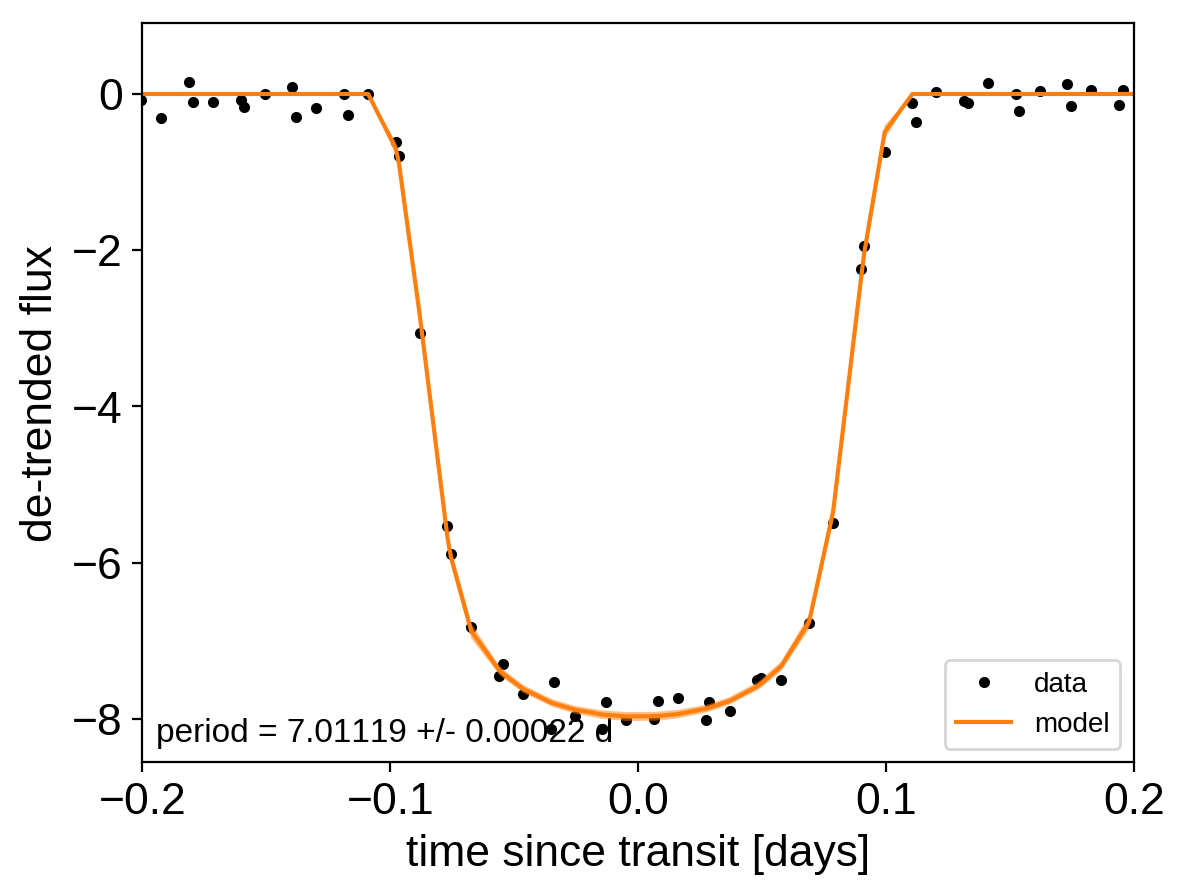

In [17]:
# Compute the GP prediction
gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)

# Get the posterior median orbital parameters
p = np.median(trace["period"])
t0 = np.median(trace["t0"])

# Plot the folded data
x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
plt.plot(x_fold, y[mask] - gp_mod, ".k", label="data", zorder=-1000)

# Plot the folded model
inds = np.argsort(x_fold)
inds = inds[np.abs(x_fold)[inds] < 0.3]
pred = trace["light_curves"][:, inds, 0]
pred = np.percentile(pred, [16, 50, 84], axis=0)
plt.plot(x_fold[inds], pred[1], color="C1", label="model")
art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                       zorder=1000)
art.set_edgecolor("none")

# Annotate the plot with the planet's period
txt = "period = {0:.5f} +/- {1:.5f} d".format(
    np.mean(trace["period"]), np.std(trace["period"]))
plt.annotate(txt, (0, 0), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom", fontsize=12)

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5*p, 0.5*p)
plt.xlabel("time since transit [days]")
plt.ylabel("de-trended flux")
plt.xlim(-0.2, 0.2);

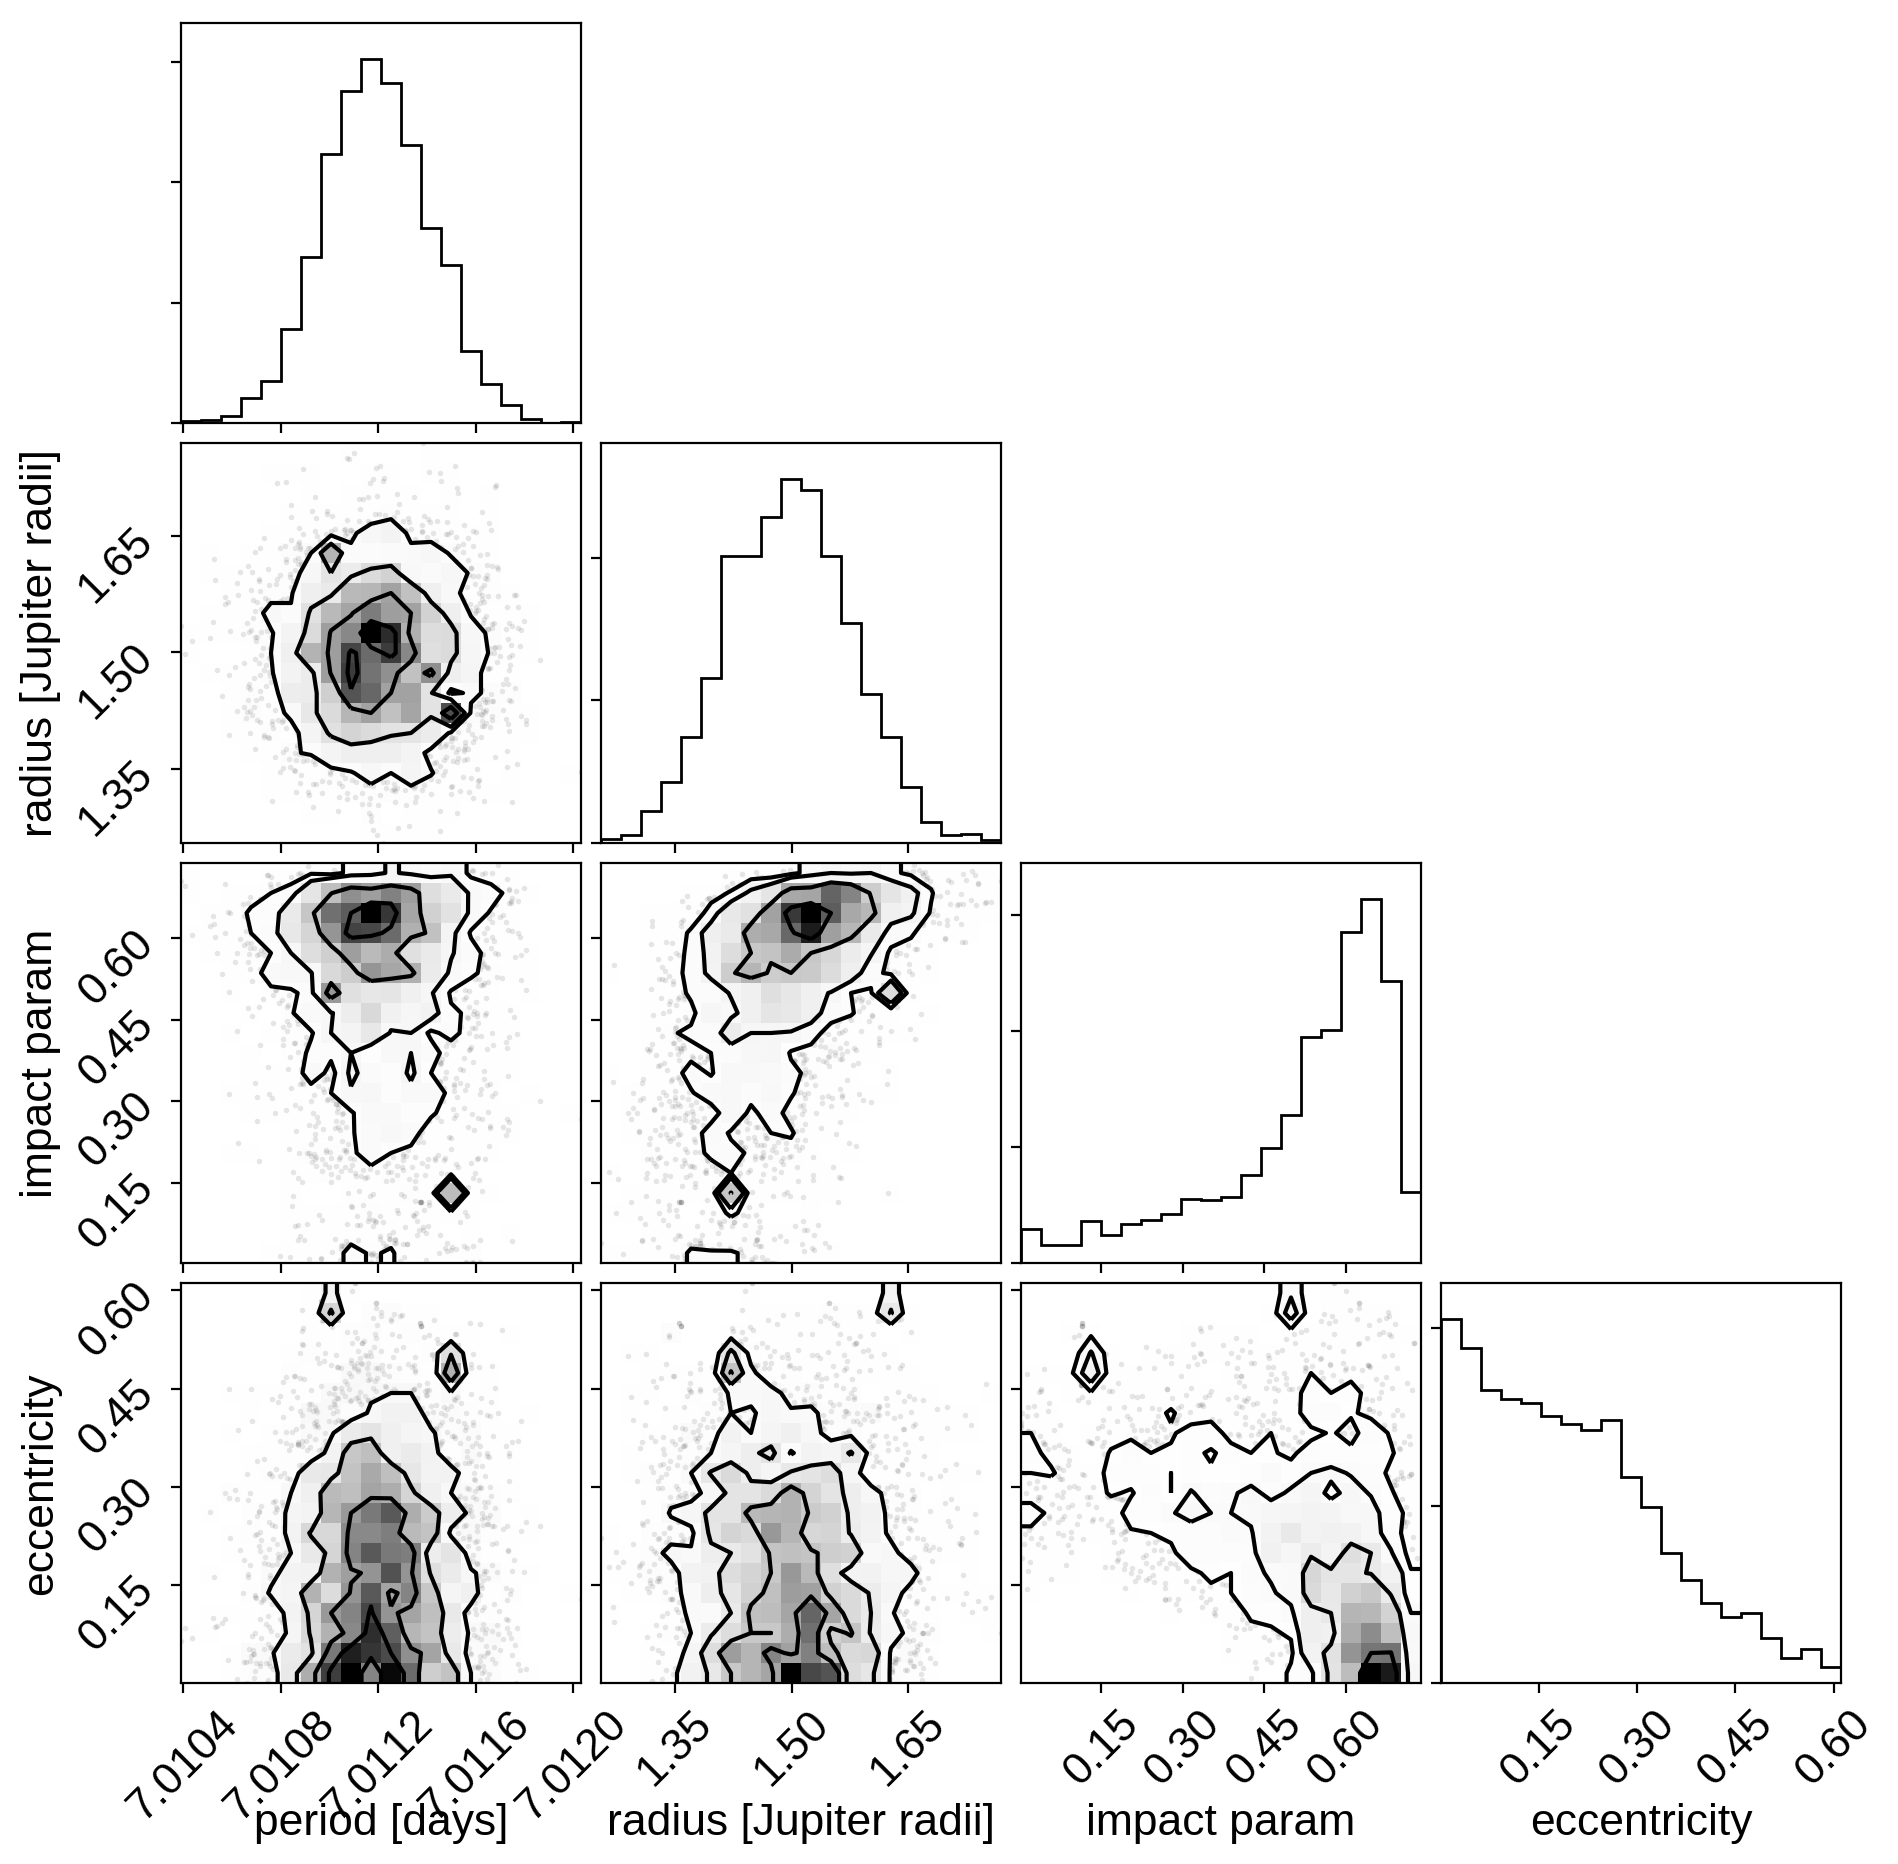

In [18]:
import corner
import astropy.units as u
varnames = ["period", "b", "ecc", "r_pl"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)

# Convert the radius to Earth radii
samples["r_pl"] = (np.array(samples["r_pl"]) * u.R_sun).to(u.R_jupiter).value

corner.corner(
    samples[["period", "r_pl", "b", "ecc"]],
    labels=["period [days]", "radius [Jupiter radii]", "impact param", "eccentricity"]);

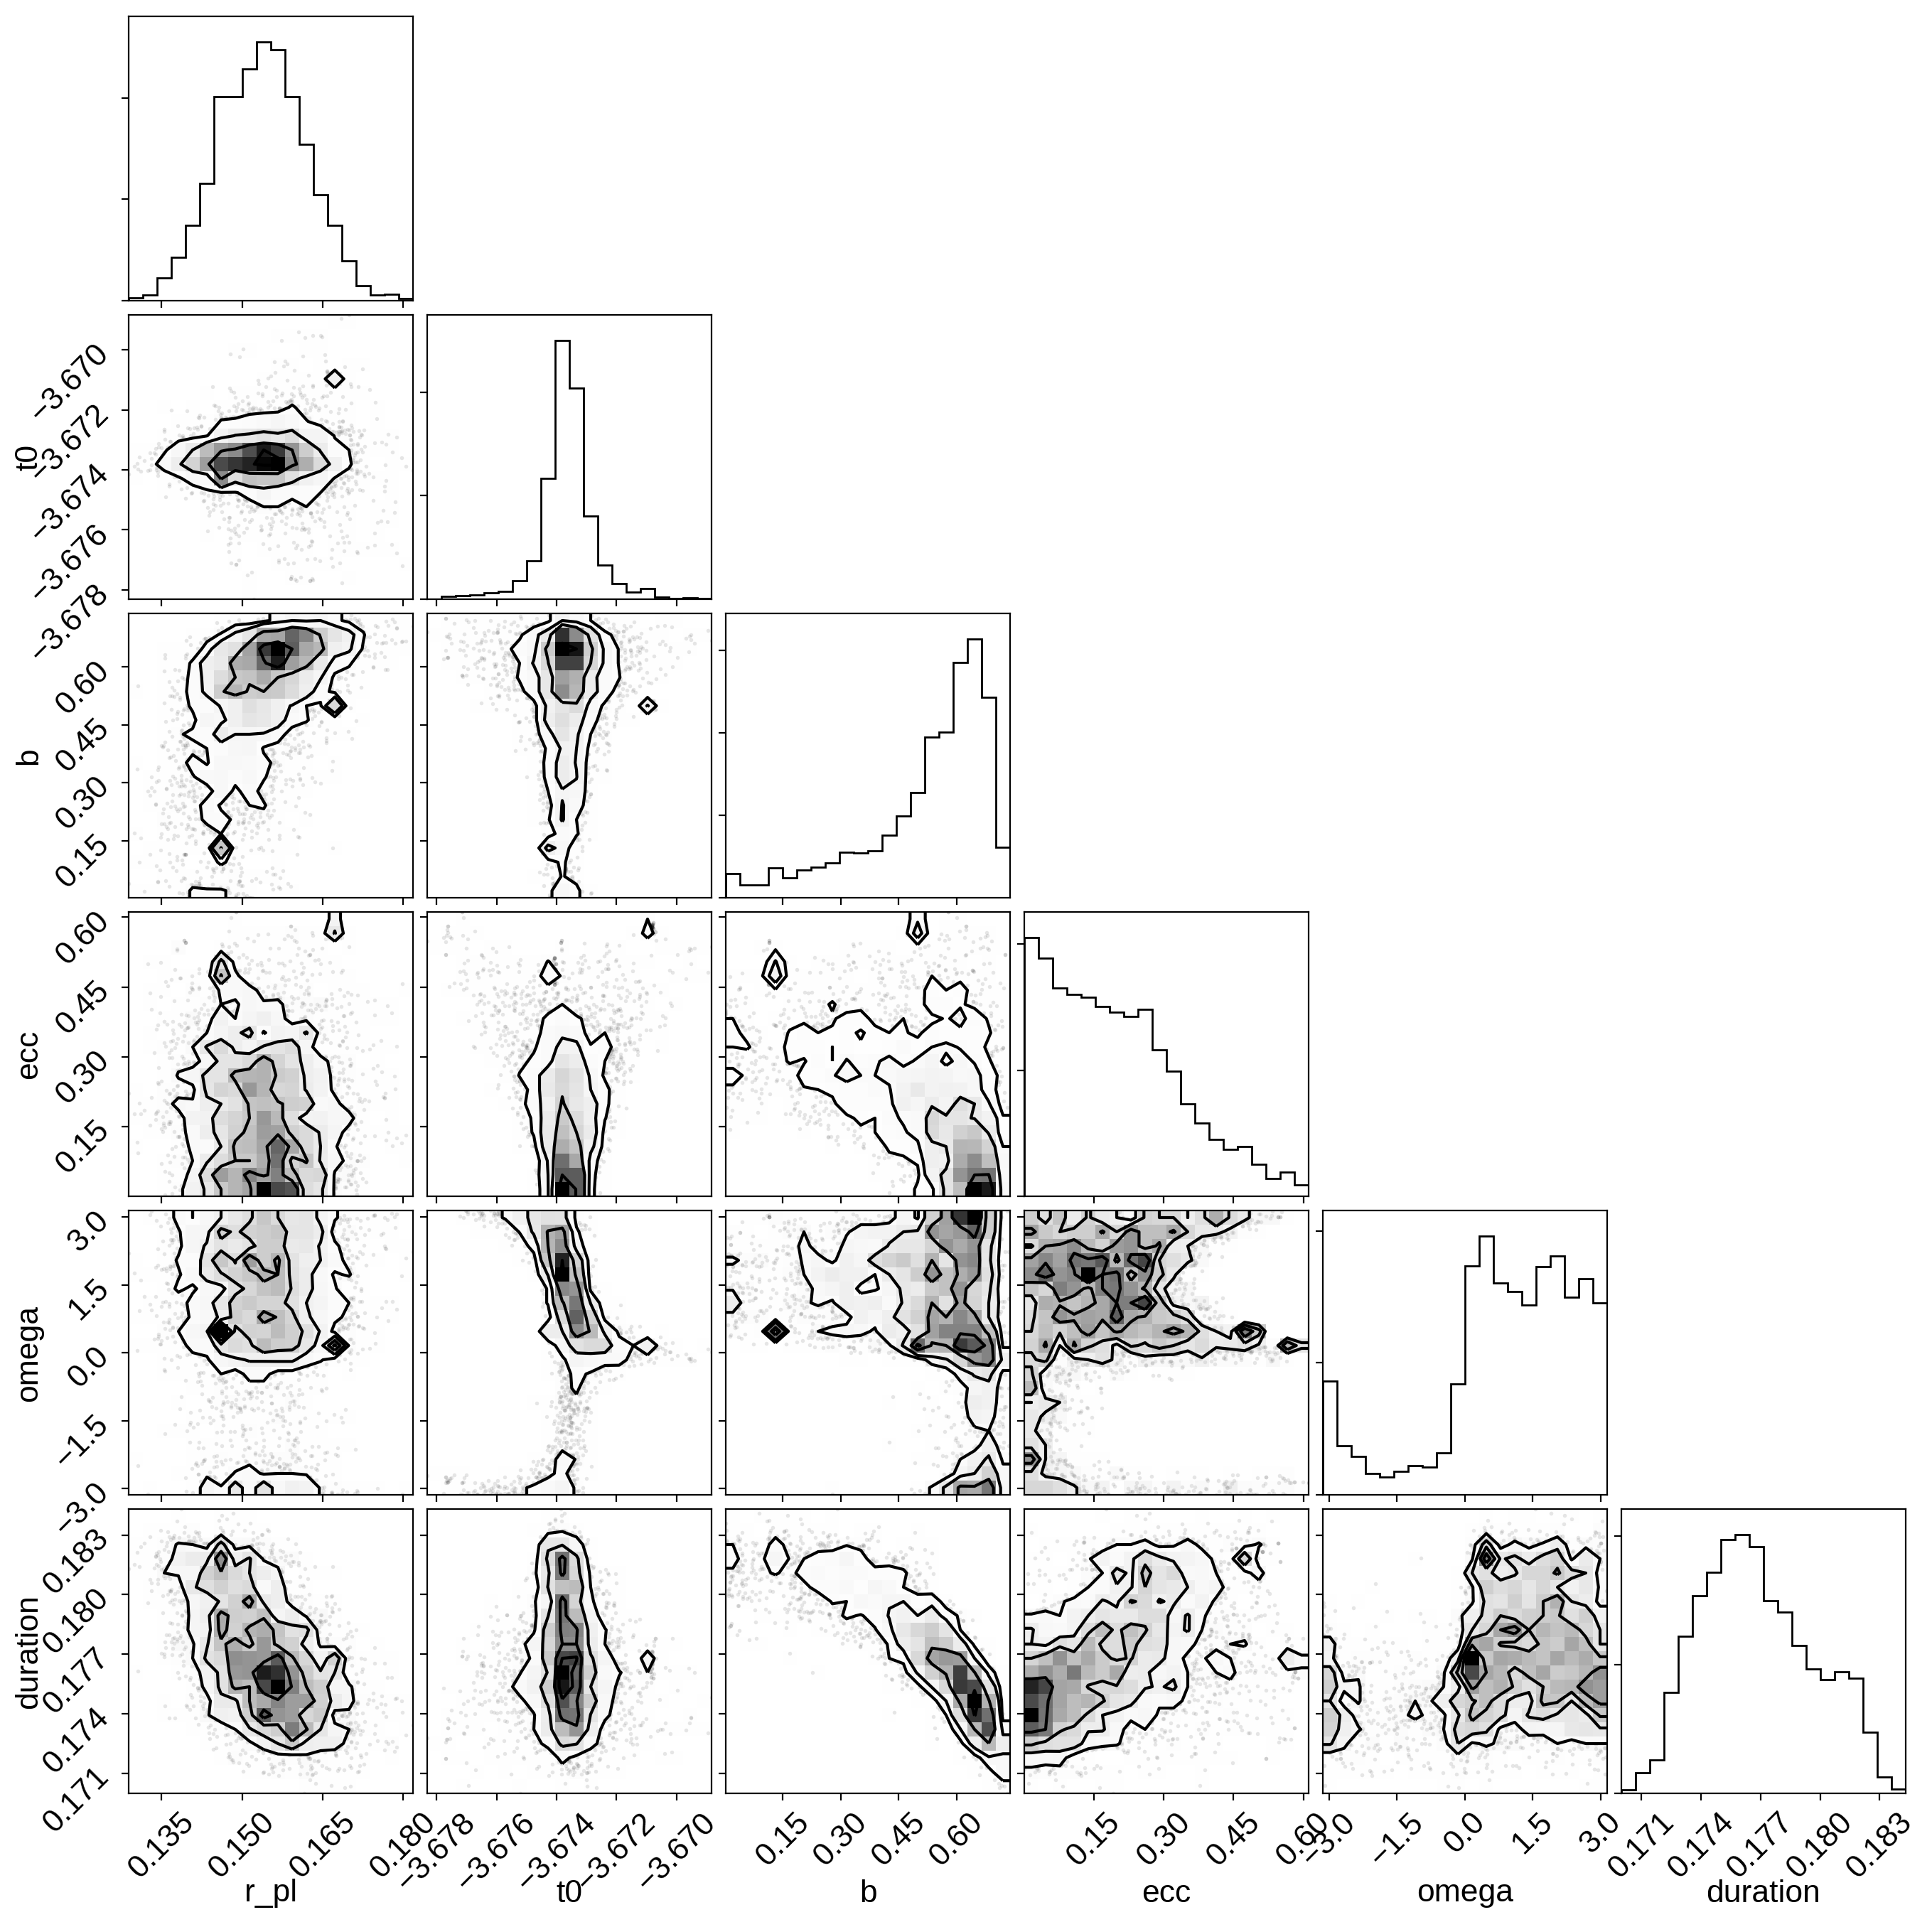

In [19]:
aor = -trace["a"] / trace["r_star"]
e = trace["ecc"]
w = trace["omega"]
i = trace["incl"]
b = trace["b"]
k = trace["r_pl"] / trace["r_star"]
P = trace["period"]

T_tot = P/np.pi * np.arcsin(np.sqrt(1 - b**2) / np.sin(i) / aor)
dur = T_tot * np.sqrt(1 - e**2) / (1 + e * np.sin(w))

samples = pm.trace_to_dataframe(trace, varnames=["r_pl", "t0", "b", "ecc", "omega"])
samples["duration"] = dur
corner.corner(samples);